# The Diffusion Transformer (DiT)

In the previous notebook, we built a working generative model using a CNN (U-Net). It successfully learned to transform noise into digits. But that architecture has fundamental limitations that become apparent at scale.

In this notebook, we replace the CNN with a **Diffusion Transformer (DiT)** - the same architecture that powers Stable Diffusion 3, Sora, and other state-of-the-art image and video generators.

## Why Move Beyond CNNs?

CNNs process images through local convolution kernels:

```
Layer 1: Each pixel sees 3×3 = 9 neighbors
Layer 2: Each pixel sees 5×5 = 25 pixels  
Layer 3: Each pixel sees 7×7 = 49 pixels
  ...
Layer N: Receptive field grows linearly
```

To "see" the entire 28×28 image, you need many layers. Information must propagate step-by-step through the network, like a game of telephone.

Transformers take a different approach: **every position can attend to every other position in a single layer**.

| Aspect | CNN (U-Net) | Transformer (DiT) |
|--------|-------------|-------------------|
| **Receptive field** | Local, grows with depth | Global from layer 1 |
| **Long-range dependencies** | Requires many layers | Direct attention |
| **Scaling behavior** | Diminishing returns | Predictable improvement |
| **Conditioning** | Add/concatenate features | Modulate every operation |

The key finding from the [DiT paper](https://arxiv.org/abs/2212.09748): transformers follow **scaling laws**. Double the compute, get predictably better results. This is why modern image generators have switched to transformers.

## What We'll Build

By the end of this notebook, you'll understand:

1. **Patchification** - Converting images to token sequences
2. **Positional embeddings** - Encoding 2D spatial structure
3. **Self-attention** - The mathematical heart of transformers
4. **Adaptive Layer Norm (adaLN)** - Superior timestep conditioning

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

# Set up device
from from_noise_to_images import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## Step 1: Patchification - Images as Token Sequences

Transformers were designed for **sequences** - words in a sentence, tokens in code. To apply them to images, we need to convert the 2D pixel grid into a 1D sequence.

### The Patchification Process

For an image $x \in \mathbb{R}^{H \times W \times C}$ with patch size $P$:

1. **Divide into patches**: Split into $N = \frac{H}{P} \times \frac{W}{P}$ non-overlapping patches
2. **Flatten each patch**: Each patch becomes a vector of dimension $P^2 \cdot C$
3. **Project to embedding space**: Linear projection $E \in \mathbb{R}^{(P^2 C) \times D}$

$$\text{patches} = \text{Reshape}(x) \cdot E \in \mathbb{R}^{N \times D}$$

### Concrete Example: Our MNIST Setup

For MNIST (28×28×1) with patch size 4:

| Step | Calculation | Result |
|------|-------------|--------|
| Number of patches | $\frac{28}{4} \times \frac{28}{4}$ | $7 \times 7 = 49$ patches |
| Pixels per patch | $4 \times 4 \times 1$ | 16 values |
| Embedding dimension | (hyperparameter) | $D = 256$ |
| Projection matrix | $E \in \mathbb{R}^{16 \times 256}$ | 4,096 parameters |

### The Computational Win

Self-attention has $O(N^2)$ complexity where $N$ is sequence length. Patches dramatically reduce this:

| Approach | Sequence Length | Attention Cost |
|----------|-----------------|----------------|
| Pixel-level | $28 \times 28 = 784$ | $784^2 = 614,656$ |
| Patch-level (P=4) | $7 \times 7 = 49$ | $49^2 = 2,401$ |
| **Speedup** | | **256×** |

The tradeoff: larger patches = fewer tokens = faster, but lose fine detail within each patch. For small images like MNIST, $P=4$ strikes a good balance.

In [2]:
# Load MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

sample_img, label = train_dataset[0]
print(f"Image shape: {sample_img.shape}")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Label: 5


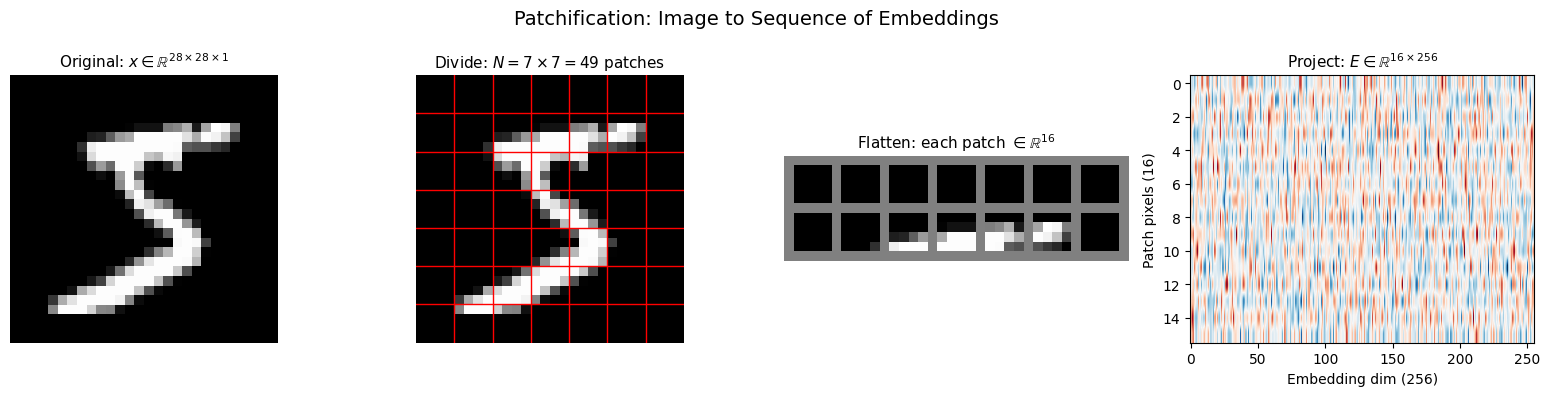


Patchification Summary:
  Input:  28×28×1 = 784 pixel values
  Patches: 49 patches, each 4×4 = 16 pixels
  Output: 49 tokens, each 256-dimensional
  Attention cost: 784² = 614,656 → 49² = 2,401 (256× reduction)


In [3]:
def visualize_patchification(img, patch_size=4):
    """
    Visualize the patchification process step by step.
    """
    img_display = (img[0] + 1) / 2  # Denormalize
    H, W = img_display.shape
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    N = num_patches_h * num_patches_w
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Original image
    axes[0].imshow(img_display.numpy(), cmap='gray')
    axes[0].set_title(f'Original: $x \\in \\mathbb{{R}}^{{{H}\\times{W}\\times1}}$', fontsize=11)
    axes[0].axis('off')
    
    # Image with patch grid
    axes[1].imshow(img_display.numpy(), cmap='gray')
    for i in range(1, num_patches_h):
        axes[1].axhline(y=i * patch_size - 0.5, color='red', linewidth=1)
    for j in range(1, num_patches_w):
        axes[1].axvline(x=j * patch_size - 0.5, color='red', linewidth=1)
    axes[1].set_title(f'Divide: $N = {num_patches_h}\\times{num_patches_w} = {N}$ patches', fontsize=11)
    axes[1].axis('off')
    
    # Extract and show patches as sequence
    patches = img_display.unfold(0, patch_size, patch_size).unfold(1, patch_size, patch_size)
    patches = patches.reshape(-1, patch_size, patch_size)
    
    patch_grid = torchvision.utils.make_grid(
        patches[:14].unsqueeze(1), nrow=7, padding=1, pad_value=0.5
    )
    axes[2].imshow(patch_grid[0].numpy(), cmap='gray')
    axes[2].set_title(f'Flatten: each patch $\\in \\mathbb{{R}}^{{{patch_size**2}}}$', fontsize=11)
    axes[2].axis('off')
    
    # Show embedding projection conceptually
    embed_dim = 256
    projection = np.random.randn(patch_size**2, embed_dim) * 0.1
    axes[3].imshow(projection, aspect='auto', cmap='RdBu', vmin=-0.3, vmax=0.3)
    axes[3].set_xlabel(f'Embedding dim ({embed_dim})')
    axes[3].set_ylabel(f'Patch pixels ({patch_size**2})')
    axes[3].set_title(f'Project: $E \\in \\mathbb{{R}}^{{{patch_size**2}\\times{embed_dim}}}$', fontsize=11)
    
    plt.suptitle('Patchification: Image to Sequence of Embeddings', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"\nPatchification Summary:")
    print(f"  Input:  {H}×{W}×1 = {H*W} pixel values")
    print(f"  Patches: {N} patches, each {patch_size}×{patch_size} = {patch_size**2} pixels")
    print(f"  Output: {N} tokens, each {embed_dim}-dimensional")
    print(f"  Attention cost: {H*W}² = {(H*W)**2:,} → {N}² = {N**2:,} ({(H*W)**2 // N**2}× reduction)")

visualize_patchification(sample_img, patch_size=4)

## Step 2: Positional Embeddings - Encoding Spatial Structure

When we flatten patches into a sequence, we lose spatial information. The transformer sees:

$$[p_1, p_2, p_3, \ldots, p_{49}]$$

But it doesn't know that $p_1$ is in the top-left corner and $p_{49}$ is in the bottom-right!

### The Solution: Add Position Information

We add a **positional embedding** to each patch embedding:

$$z_i = p_i + \text{PE}(\text{row}_i, \text{col}_i)$$

### Sinusoidal Positional Encoding

We use the sinusoidal encoding from "Attention Is All You Need":

$$\text{PE}(\text{pos}, 2i) = \sin\left(\frac{\text{pos}}{10000^{2i/d}}\right)$$
$$\text{PE}(\text{pos}, 2i+1) = \cos\left(\frac{\text{pos}}{10000^{2i/d}}\right)$$

where $i$ is the dimension index and $d$ is the total embedding dimension.

### Why Sinusoids Work

| Property | Explanation |
|----------|-------------|
| **Unique encoding** | Each position gets a distinct pattern |
| **Relative positions** | $\text{PE}(\text{pos}+k)$ is a linear function of $\text{PE}(\text{pos})$ |
| **Bounded values** | All outputs in $[-1, 1]$ |
| **No learned parameters** | Works for any sequence length |

The key insight: different dimensions oscillate at different frequencies. Low dimensions change slowly (capture long-range position), high dimensions change quickly (capture fine position).

### 2D Extension for Images

For images, we encode both row and column:

$$\text{PE}_{2D}(r, c) = [\text{PE}_{1D}(r), \text{PE}_{1D}(c)]$$

Each position gets a $D$-dimensional vector: half for row, half for column.

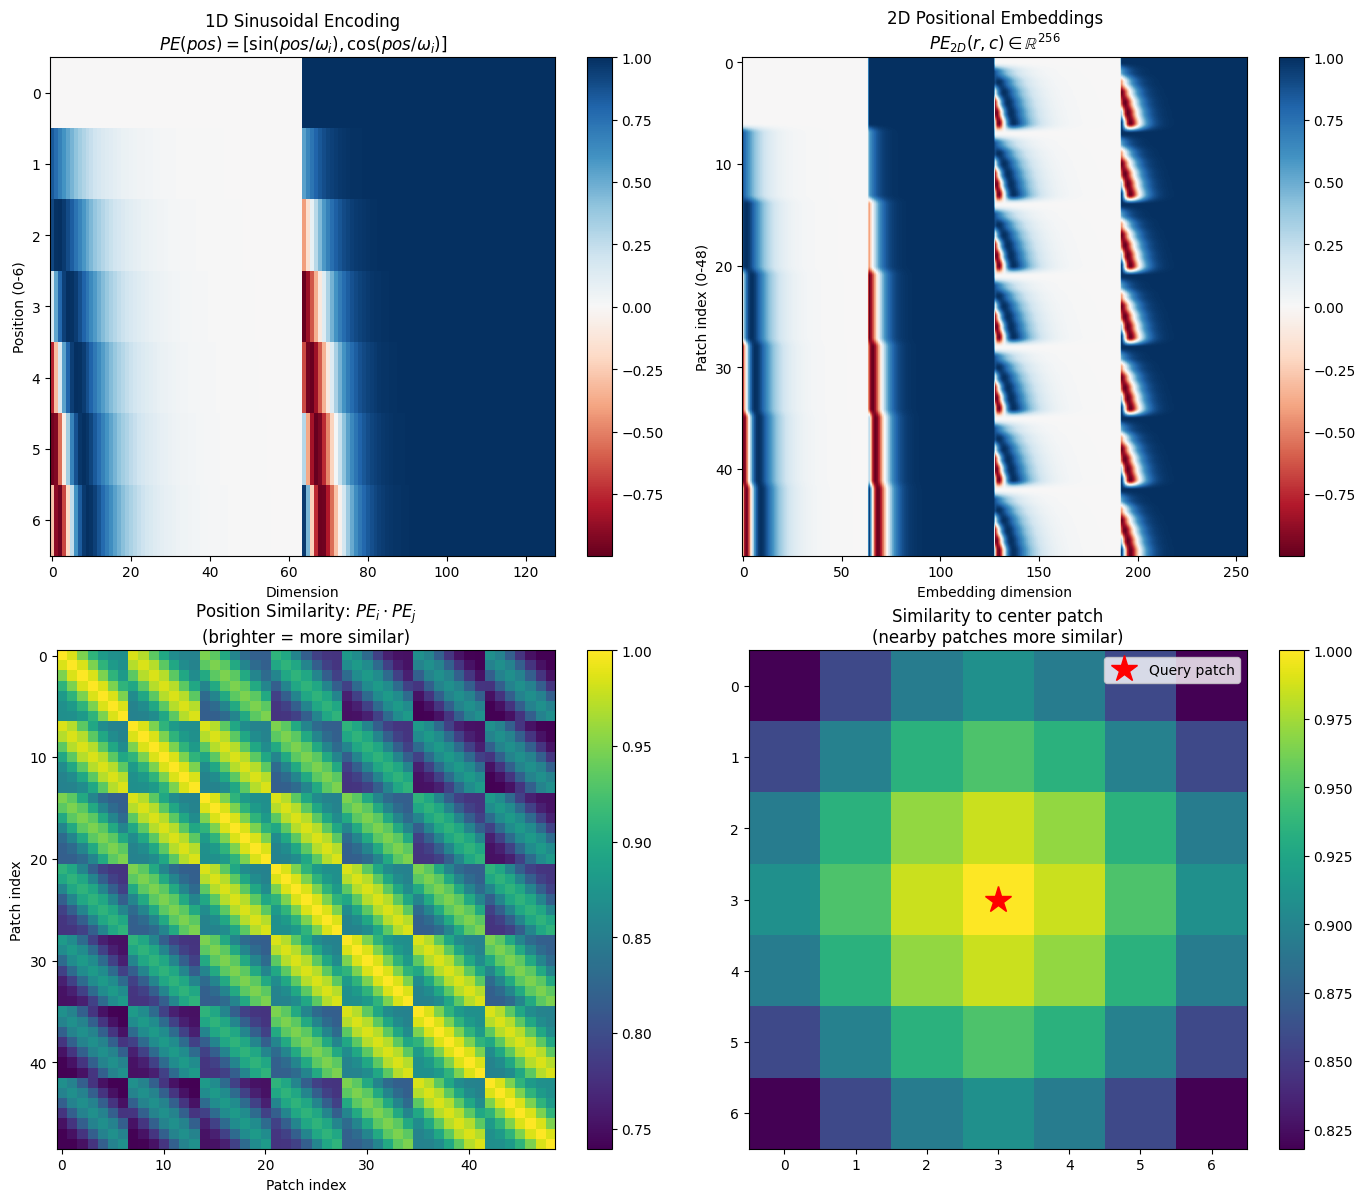


Positional Embedding Properties:
  • Each position gets a unique 256D vector
  • Nearby patches have similar embeddings (high dot product)
  • Distant patches have dissimilar embeddings (low dot product)
  • The model learns to interpret these patterns


In [4]:
def visualize_positional_embeddings(grid_size=7, embed_dim=256):
    """
    Visualize 2D sinusoidal positional embeddings.
    """
    import math
    
    # Create 1D sinusoidal embeddings
    half_dim = embed_dim // 4  # sin_row, cos_row, sin_col, cos_col
    
    # Frequency bands: 10000^(-2i/d)
    freq = math.log(10000) / (half_dim - 1)
    freq = torch.exp(torch.arange(half_dim) * -freq)
    
    # Position indices
    pos = torch.arange(grid_size).float()
    
    # Compute PE: pos × freq gives the angle
    angles = pos[:, None] * freq[None, :]  # (grid_size, half_dim)
    sin_emb = torch.sin(angles)
    cos_emb = torch.cos(angles)
    pos_1d = torch.cat([sin_emb, cos_emb], dim=-1)  # (grid_size, embed_dim/2)
    
    # Create 2D embeddings
    row_emb = pos_1d.unsqueeze(1).expand(-1, grid_size, -1)
    col_emb = pos_1d.unsqueeze(0).expand(grid_size, -1, -1)
    pos_2d = torch.cat([row_emb, col_emb], dim=-1)  # (7, 7, 256)
    pos_flat = pos_2d.view(-1, embed_dim)  # (49, 256)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1D embeddings
    im = axes[0, 0].imshow(pos_1d.numpy(), aspect='auto', cmap='RdBu')
    axes[0, 0].set_xlabel('Dimension')
    axes[0, 0].set_ylabel('Position (0-6)')
    axes[0, 0].set_title('1D Sinusoidal Encoding\n$PE(pos) = [\\sin(pos/\\omega_i), \\cos(pos/\\omega_i)]$')
    plt.colorbar(im, ax=axes[0, 0])
    
    # Full 2D embedding matrix
    im = axes[0, 1].imshow(pos_flat.numpy(), aspect='auto', cmap='RdBu')
    axes[0, 1].set_xlabel('Embedding dimension')
    axes[0, 1].set_ylabel('Patch index (0-48)')
    axes[0, 1].set_title(f'2D Positional Embeddings\n$PE_{{2D}}(r,c) \\in \\mathbb{{R}}^{{{embed_dim}}}$')
    plt.colorbar(im, ax=axes[0, 1])
    
    # Dot-product similarity
    similarity = torch.mm(pos_flat, pos_flat.T)
    similarity = similarity / similarity.max()
    im = axes[1, 0].imshow(similarity.numpy(), cmap='viridis')
    axes[1, 0].set_xlabel('Patch index')
    axes[1, 0].set_ylabel('Patch index')
    axes[1, 0].set_title('Position Similarity: $PE_i \\cdot PE_j$\n(brighter = more similar)')
    plt.colorbar(im, ax=axes[1, 0])
    
    # Spatial similarity from center
    center = 24  # Center of 7×7 grid
    center_sim = similarity[center].view(grid_size, grid_size)
    im = axes[1, 1].imshow(center_sim.numpy(), cmap='viridis')
    axes[1, 1].plot(3, 3, 'r*', markersize=20, label='Query patch')
    axes[1, 1].set_title(f'Similarity to center patch\n(nearby patches more similar)')
    axes[1, 1].legend()
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    print("\nPositional Embedding Properties:")
    print(f"  • Each position gets a unique {embed_dim}D vector")
    print(f"  • Nearby patches have similar embeddings (high dot product)")
    print(f"  • Distant patches have dissimilar embeddings (low dot product)")
    print(f"  • The model learns to interpret these patterns")

visualize_positional_embeddings()

## Step 3: Self-Attention - The Heart of Transformers

Self-attention is what gives transformers their power. Unlike CNNs where each location only sees its local neighborhood, attention lets **every token interact with every other token** in a single operation.

### The Attention Mechanism

Given input tokens $X \in \mathbb{R}^{N \times D}$ (N tokens, D dimensions each):

**Step 1: Project to Query, Key, Value**

$$Q = XW_Q, \quad K = XW_K, \quad V = XW_V$$

where $W_Q, W_K, W_V \in \mathbb{R}^{D \times D}$ are learned projection matrices.

**Step 2: Compute attention scores**

$$A = \text{softmax}\left(\frac{QK^T}{\sqrt{D}}\right) \in \mathbb{R}^{N \times N}$$

Entry $A_{ij}$ tells us: "How much should token $i$ attend to token $j$?"

**Step 3: Aggregate values**

$$\text{Output} = AV \in \mathbb{R}^{N \times D}$$

Each output token is a weighted combination of all value vectors, with weights from the attention matrix.

### Understanding Q, K, V

| Component | Intuition | Question It Answers |
|-----------|-----------|--------------------|
| **Query (Q)** | "What am I looking for?" | What information does this token need? |
| **Key (K)** | "What do I contain?" | What information does this token have? |
| **Value (V)** | "What do I provide?" | What content should be passed along? |

When $Q_i \cdot K_j$ is large, token $i$ strongly attends to token $j$.

### The Scaling Factor $\sqrt{D}$

Why divide by $\sqrt{D}$? Without it:

- Dot products $Q_i \cdot K_j$ have variance proportional to $D$
- Large values make softmax nearly one-hot
- Gradients vanish, training fails

Dividing by $\sqrt{D}$ normalizes the variance to ~1, keeping gradients healthy.

### Multi-Head Attention

Instead of one attention operation, we run $H$ parallel "heads":

$$\text{MultiHead}(X) = \text{Concat}(\text{head}_1, \ldots, \text{head}_H) W_O$$

where each head uses dimension $D/H$. This lets the model attend to different aspects simultaneously - one head might focus on local structure, another on global patterns.

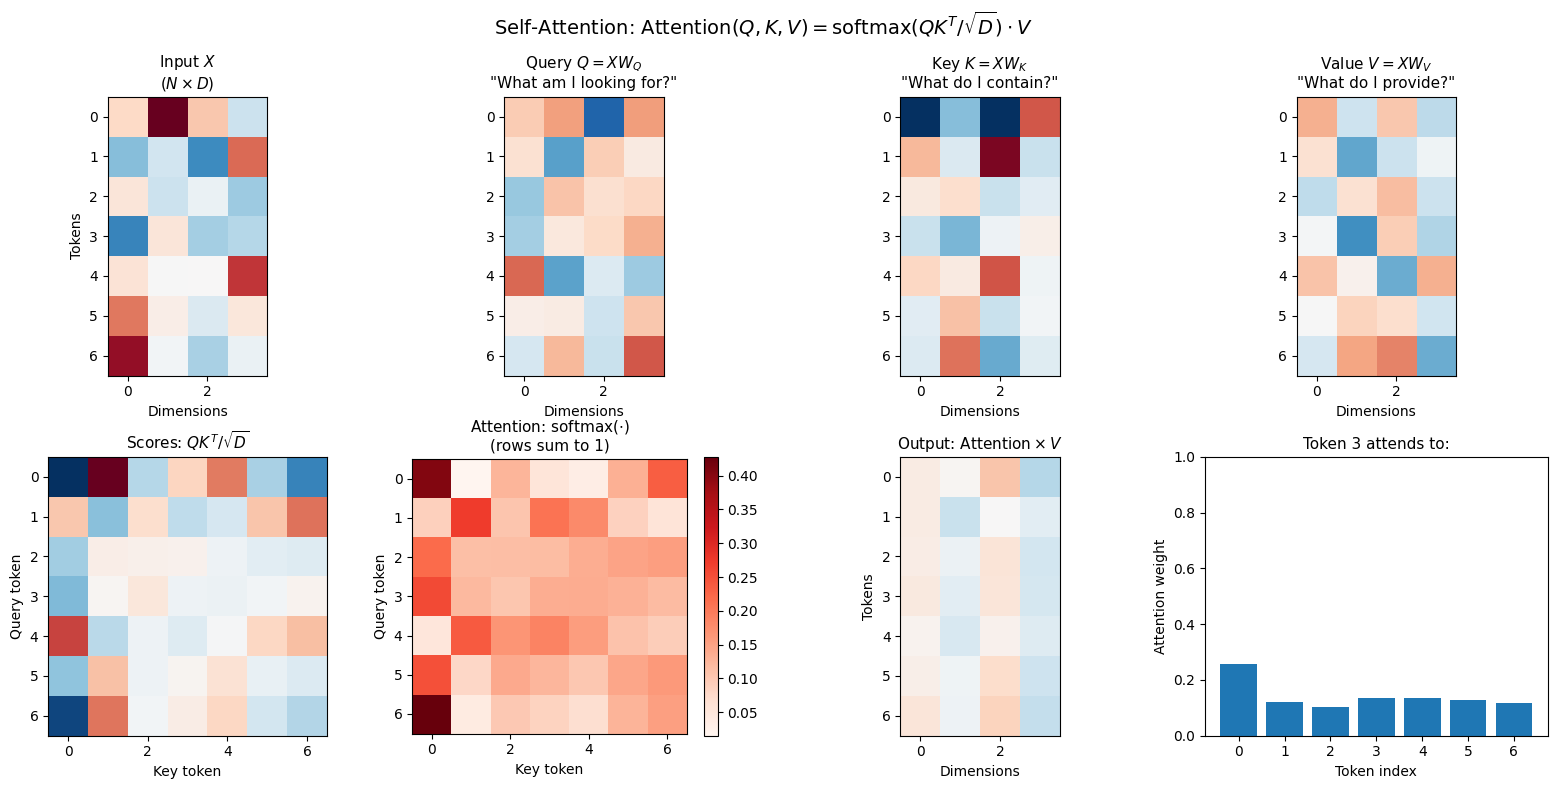


Attention Properties:
  • Input: 7 tokens × 4 dimensions
  • Attention matrix: 7×7 = 49 pairwise interactions
  • Each row sums to 1 (probability distribution over keys)
  • Complexity: O(N²D) - quadratic in sequence length


In [5]:
def visualize_attention_mechanism():
    """
    Visualize the self-attention computation step by step.
    """
    N = 7  # 7 tokens (simplified for visualization)
    D = 4  # 4 dimensions
    
    # Create sample input
    np.random.seed(42)
    X = torch.randn(N, D)
    
    # Learned projections (random for illustration)
    W_Q = torch.randn(D, D) * 0.5
    W_K = torch.randn(D, D) * 0.5
    W_V = torch.randn(D, D) * 0.5
    
    # Compute Q, K, V
    Q = X @ W_Q
    K = X @ W_K
    V = X @ W_V
    
    # Compute attention scores
    scores = Q @ K.T / np.sqrt(D)
    attention = torch.softmax(scores, dim=-1)
    
    # Compute output
    output = attention @ V
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    # Row 1: The computation
    vmin, vmax = -2, 2
    
    axes[0, 0].imshow(X.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[0, 0].set_title('Input $X$\n$(N \\times D)$', fontsize=11)
    axes[0, 0].set_xlabel('Dimensions')
    axes[0, 0].set_ylabel('Tokens')
    
    axes[0, 1].imshow(Q.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[0, 1].set_title('Query $Q = XW_Q$\n"What am I looking for?"', fontsize=11)
    axes[0, 1].set_xlabel('Dimensions')
    
    axes[0, 2].imshow(K.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[0, 2].set_title('Key $K = XW_K$\n"What do I contain?"', fontsize=11)
    axes[0, 2].set_xlabel('Dimensions')
    
    axes[0, 3].imshow(V.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[0, 3].set_title('Value $V = XW_V$\n"What do I provide?"', fontsize=11)
    axes[0, 3].set_xlabel('Dimensions')
    
    # Row 2: Attention computation
    axes[1, 0].imshow(scores.numpy(), cmap='RdBu')
    axes[1, 0].set_title('Scores: $QK^T / \\sqrt{D}$', fontsize=11)
    axes[1, 0].set_xlabel('Key token')
    axes[1, 0].set_ylabel('Query token')
    
    im = axes[1, 1].imshow(attention.numpy(), cmap='Reds')
    axes[1, 1].set_title('Attention: $\\text{softmax}(\\cdot)$\n(rows sum to 1)', fontsize=11)
    axes[1, 1].set_xlabel('Key token')
    axes[1, 1].set_ylabel('Query token')
    plt.colorbar(im, ax=axes[1, 1])
    
    axes[1, 2].imshow(output.numpy(), cmap='RdBu', vmin=vmin, vmax=vmax)
    axes[1, 2].set_title('Output: $\\text{Attention} \\times V$', fontsize=11)
    axes[1, 2].set_xlabel('Dimensions')
    axes[1, 2].set_ylabel('Tokens')
    
    # Show attention pattern for one query
    query_idx = 3
    axes[1, 3].bar(range(N), attention[query_idx].numpy())
    axes[1, 3].set_title(f'Token {query_idx} attends to:', fontsize=11)
    axes[1, 3].set_xlabel('Token index')
    axes[1, 3].set_ylabel('Attention weight')
    axes[1, 3].set_ylim(0, 1)
    
    plt.suptitle('Self-Attention: $\\text{Attention}(Q,K,V) = \\text{softmax}(QK^T/\\sqrt{D}) \\cdot V$', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print(f"\nAttention Properties:")
    print(f"  • Input: {N} tokens × {D} dimensions")
    print(f"  • Attention matrix: {N}×{N} = {N**2} pairwise interactions")
    print(f"  • Each row sums to 1 (probability distribution over keys)")
    print(f"  • Complexity: O(N²D) - quadratic in sequence length")

visualize_attention_mechanism()

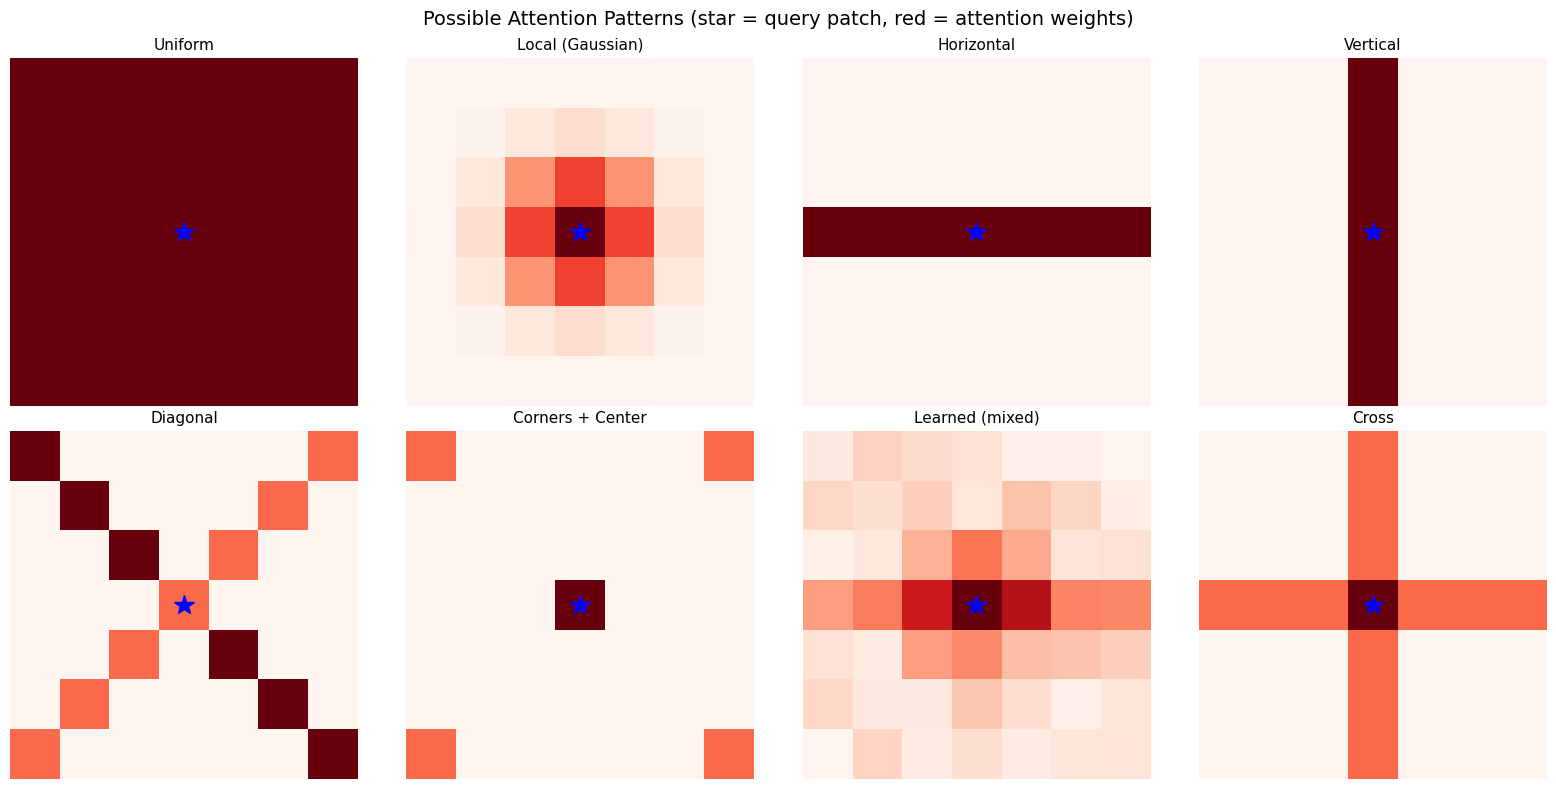


Patterns the model might learn:
  • Early layers: Local patterns (like CNN kernels)
  • Middle layers: Structural patterns (horizontal, vertical strokes)
  • Late layers: Semantic patterns (attend to digit-specific regions)
  • The model learns which patterns are useful!


In [6]:
def visualize_image_attention_patterns():
    """
    Show what attention patterns might look like for image patches.
    """
    grid_size = 7
    N = grid_size ** 2  # 49 patches
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    query_pos = (3, 3)  # Center patch
    query_idx = query_pos[0] * grid_size + query_pos[1]
    
    patterns = [
        ('Uniform', np.ones((grid_size, grid_size)) / N),
        ('Local (Gaussian)', None),
        ('Horizontal', None),
        ('Vertical', None),
        ('Diagonal', None),
        ('Sparse', None),
        ('Learned (example)', None),
        ('Cross', None),
    ]
    
    # Compute patterns
    # Local Gaussian
    local = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            dist = np.sqrt((i - query_pos[0])**2 + (j - query_pos[1])**2)
            local[i, j] = np.exp(-dist**2 / 2)
    patterns[1] = ('Local (Gaussian)', local / local.sum())
    
    # Horizontal
    horiz = np.zeros((grid_size, grid_size))
    horiz[query_pos[0], :] = 1
    patterns[2] = ('Horizontal', horiz / horiz.sum())
    
    # Vertical
    vert = np.zeros((grid_size, grid_size))
    vert[:, query_pos[1]] = 1
    patterns[3] = ('Vertical', vert / vert.sum())
    
    # Diagonal
    diag = np.zeros((grid_size, grid_size))
    for i in range(grid_size):
        diag[i, i] = 1
        if grid_size - 1 - i >= 0:
            diag[i, grid_size - 1 - i] = 0.5
    patterns[4] = ('Diagonal', diag / diag.sum())
    
    # Sparse (corners + center)
    sparse = np.zeros((grid_size, grid_size))
    sparse[0, 0] = sparse[0, -1] = sparse[-1, 0] = sparse[-1, -1] = 1
    sparse[3, 3] = 2
    patterns[5] = ('Corners + Center', sparse / sparse.sum())
    
    # Learned-like (mixture)
    learned = local + 0.5 * horiz + 0.3 * np.random.rand(grid_size, grid_size)
    patterns[6] = ('Learned (mixed)', learned / learned.sum())
    
    # Cross
    cross = horiz + vert
    patterns[7] = ('Cross', cross / cross.sum())
    
    for idx, (name, pattern) in enumerate(patterns):
        ax = axes[idx // 4, idx % 4]
        im = ax.imshow(pattern, cmap='Reds', vmin=0)
        ax.plot(query_pos[1], query_pos[0], 'b*', markersize=15)
        ax.set_title(name, fontsize=11)
        ax.axis('off')
    
    plt.suptitle('Possible Attention Patterns (star = query patch, red = attention weights)', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nPatterns the model might learn:")
    print("  • Early layers: Local patterns (like CNN kernels)")
    print("  • Middle layers: Structural patterns (horizontal, vertical strokes)")
    print("  • Late layers: Semantic patterns (attend to digit-specific regions)")
    print("  • The model learns which patterns are useful!")

visualize_image_attention_patterns()

## Step 4: Adaptive Layer Normalization (adaLN)

How do we tell the model what timestep we're at? In the previous notebook, we simply added the timestep embedding to feature maps. DiT uses a more powerful approach: **Adaptive Layer Normalization**.

### Standard Layer Normalization

Layer norm normalizes activations and applies a learned affine transform:

$$\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sigma} + \beta$$

where:
- $\mu, \sigma$ = mean and std of $x$ (computed per-sample)
- $\gamma, \beta$ = **learned** scale and shift parameters (same for all inputs)

### Adaptive Layer Norm (adaLN)

Instead of **learned** $\gamma, \beta$, we **predict** them from the timestep:

$$[\gamma(t), \beta(t)] = \text{MLP}(\text{time\_embed}(t))$$
$$\text{adaLN}(x, t) = \gamma(t) \odot \frac{x - \mu}{\sigma} + \beta(t)$$

### Why adaLN Is Powerful

| Approach | What It Does | Conditioning Strength |
|----------|--------------|----------------------|
| **Additive** $(x + t_{emb})$ | Shifts activations | Weak |
| **Concatenation** $[x, t_{emb}]$ | Separate channels | Medium |
| **adaLN** | Scales AND shifts every activation | Strong |

adaLN modulates the **entire distribution** of activations. At each timestep, the model can:
- **Amplify** certain features ($\gamma > 1$)
- **Suppress** others ($\gamma \approx 0$)
- **Shift** the operating point ($\beta$)

### Timestep-Dependent Behavior

Consider how the task changes with timestep:
- **$t \approx 1$ (mostly noise)**: Find large-scale structure, ignore high-frequency details
- **$t \approx 0$ (mostly data)**: Refine fine details, preserve structure

adaLN lets the model behave **completely differently** at different timesteps by controlling which features are active.

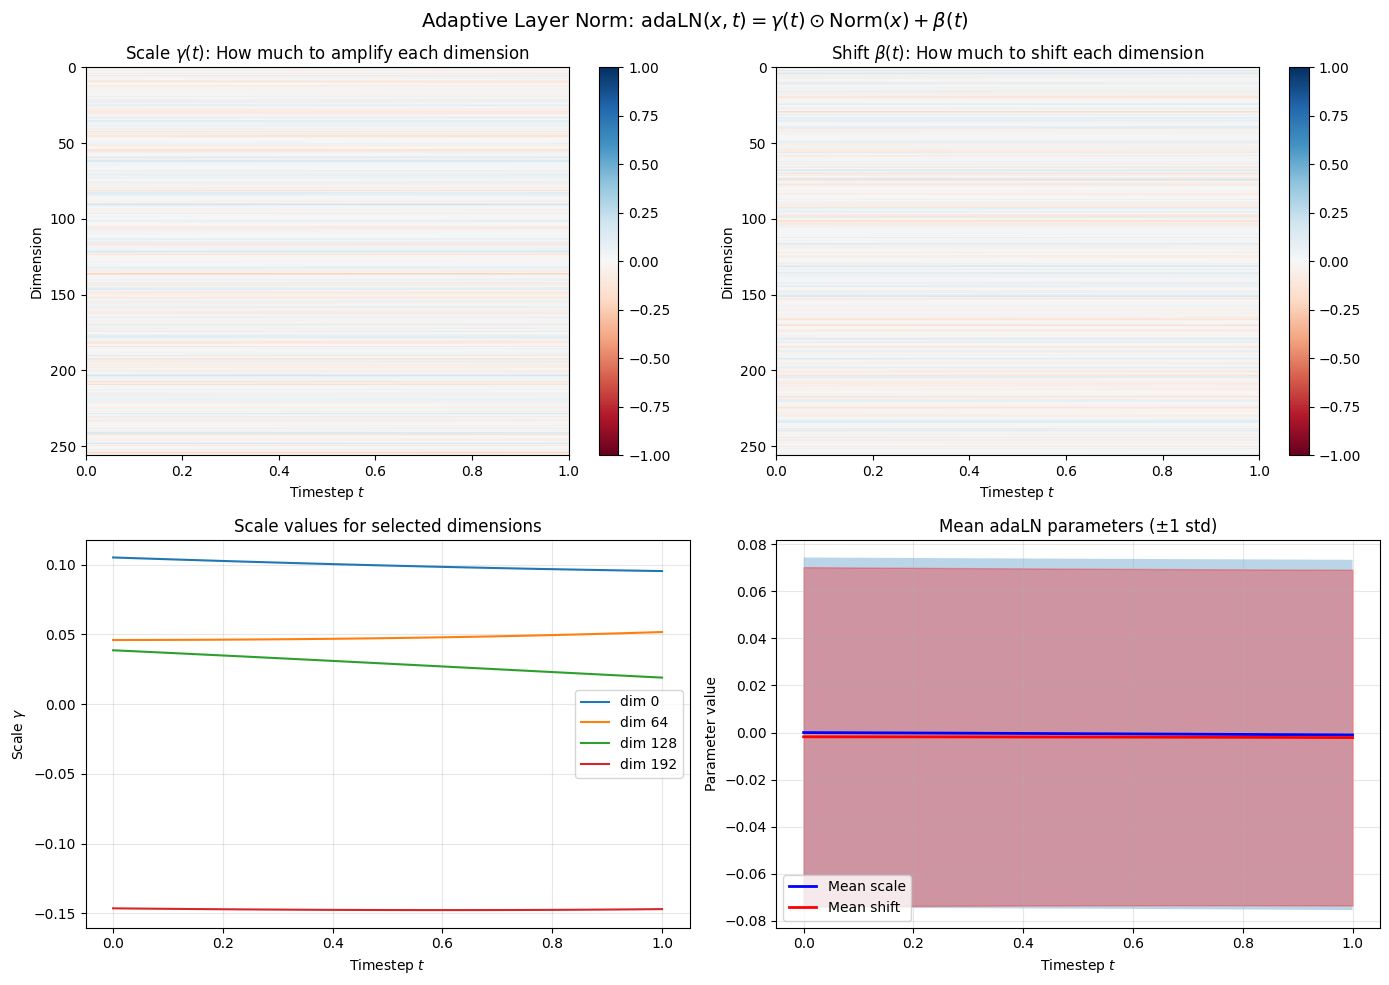


adaLN Insights:
  • Each timestep produces different γ and β values
  • The model can amplify/suppress different features at different t
  • This is much more expressive than just adding timestep embeddings
  • Formula: output = γ(t) × LayerNorm(x) + β(t)


In [7]:
from from_noise_to_images.dit import TimestepEmbedding, AdaLN

def visualize_adaln_modulation():
    """
    Show how adaLN parameters vary with timestep.
    """
    embed_dim = 256
    cond_dim = embed_dim * 4
    
    time_embed = TimestepEmbedding(embed_dim, cond_dim)
    adaln = AdaLN(embed_dim, cond_dim)
    
    timesteps = torch.linspace(0, 1, 100)
    
    scales = []
    shifts = []
    
    with torch.no_grad():
        for t in timesteps:
            cond = time_embed(t.unsqueeze(0))
            params = adaln.proj(cond)
            scale, shift = params.chunk(2, dim=-1)
            scales.append(scale.squeeze().numpy())
            shifts.append(shift.squeeze().numpy())
    
    scales = np.array(scales)  # (100, 256)
    shifts = np.array(shifts)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Scale heatmap
    im = axes[0, 0].imshow(scales.T, aspect='auto', cmap='RdBu', 
                           extent=[0, 1, embed_dim, 0], vmin=-1, vmax=1)
    axes[0, 0].set_xlabel('Timestep $t$')
    axes[0, 0].set_ylabel('Dimension')
    axes[0, 0].set_title('Scale $\\gamma(t)$: How much to amplify each dimension')
    plt.colorbar(im, ax=axes[0, 0])
    
    # Shift heatmap
    im = axes[0, 1].imshow(shifts.T, aspect='auto', cmap='RdBu',
                           extent=[0, 1, embed_dim, 0], vmin=-1, vmax=1)
    axes[0, 1].set_xlabel('Timestep $t$')
    axes[0, 1].set_ylabel('Dimension')
    axes[0, 1].set_title('Shift $\\beta(t)$: How much to shift each dimension')
    plt.colorbar(im, ax=axes[0, 1])
    
    # Selected dimensions
    for d in [0, 64, 128, 192]:
        axes[1, 0].plot(timesteps.numpy(), scales[:, d], label=f'dim {d}')
    axes[1, 0].set_xlabel('Timestep $t$')
    axes[1, 0].set_ylabel('Scale $\\gamma$')
    axes[1, 0].set_title('Scale values for selected dimensions')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Mean ± std
    mean_scale = scales.mean(axis=1)
    std_scale = scales.std(axis=1)
    mean_shift = shifts.mean(axis=1)
    std_shift = shifts.std(axis=1)
    
    axes[1, 1].plot(timesteps.numpy(), mean_scale, 'b-', label='Mean scale', linewidth=2)
    axes[1, 1].fill_between(timesteps.numpy(), mean_scale - std_scale, mean_scale + std_scale, alpha=0.3)
    axes[1, 1].plot(timesteps.numpy(), mean_shift, 'r-', label='Mean shift', linewidth=2)
    axes[1, 1].fill_between(timesteps.numpy(), mean_shift - std_shift, mean_shift + std_shift, alpha=0.3, color='red')
    axes[1, 1].set_xlabel('Timestep $t$')
    axes[1, 1].set_ylabel('Parameter value')
    axes[1, 1].set_title('Mean adaLN parameters (±1 std)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Adaptive Layer Norm: $\\text{adaLN}(x, t) = \\gamma(t) \\odot \\text{Norm}(x) + \\beta(t)$', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    print("\nadaLN Insights:")
    print("  • Each timestep produces different γ and β values")
    print("  • The model can amplify/suppress different features at different t")
    print("  • This is much more expressive than just adding timestep embeddings")
    print(f"  • Formula: output = γ(t) × LayerNorm(x) + β(t)")

visualize_adaln_modulation()

## Step 5: The Complete DiT Architecture

Now we put all the pieces together. The DiT processes images through:

### Forward Pass

1. **Patchify**: $x \in \mathbb{R}^{H \times W \times C} \rightarrow p \in \mathbb{R}^{N \times (P^2 C)}$
2. **Embed + Position**: $z = pE + \text{PE}_{2D} \in \mathbb{R}^{N \times D}$
3. **Timestep Conditioning**: $c = \text{MLP}(\text{sinusoidal}(t)) \in \mathbb{R}^{D_c}$
4. **Transformer Blocks** (repeat $L$ times):
   - $z' = z + \text{Attention}(\text{adaLN}(z, c))$
   - $z = z' + \text{MLP}(\text{adaLN}(z', c))$
5. **Unpatchify**: $z \in \mathbb{R}^{N \times D} \rightarrow v \in \mathbb{R}^{H \times W \times C}$

### DiT Block Structure

```
Input z
   │
   ├───────────────────────────────────┐
   │                                   │ (residual)
   ▼                                   │
adaLN(z, c) ──► Self-Attention ──► + ──┤
                                       │
   ├───────────────────────────────────┘
   │                                   │ (residual)
   ▼                                   │
adaLN(z, c) ──► MLP ──────────────► + ──┘
   │
   ▼
Output z
```

### Computational Complexity

| Component | Complexity | For MNIST (N=49, D=256) |
|-----------|------------|-------------------------|
| Self-Attention | $O(N^2 D)$ | 49² × 256 ≈ 600K ops |
| MLP | $O(N D^2)$ | 49 × 256² ≈ 3.2M ops |
| Per Block | $O(N^2 D + N D^2)$ | ≈ 3.8M ops |
| Full Model (6 blocks) | | ≈ 23M ops |

In [8]:
from from_noise_to_images.dit import DiT

# Create DiT model
model = DiT(
    img_size=28,       # MNIST
    patch_size=4,      # 7×7 = 49 patches
    in_channels=1,     # Grayscale
    embed_dim=256,     # Embedding dimension D
    depth=6,           # Number of transformer blocks L
    num_heads=8,       # Attention heads H (256/8 = 32 dim per head)
    mlp_ratio=4.0,     # MLP hidden = 256 × 4 = 1024
).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"DiT Parameters: {num_params:,}")
print(f"\nArchitecture:")
print(f"  Patches: 7×7 = 49 (sequence length N)")
print(f"  Embedding: D = 256")
print(f"  Heads: H = 8 (head dim = 256/8 = 32)")
print(f"  MLP hidden: 256 × 4 = 1024")
print(f"  Blocks: L = 6")

# Test forward pass
test_x = torch.randn(4, 1, 28, 28, device=device)
test_t = torch.rand(4, device=device)

with torch.no_grad():
    test_out = model(test_x, test_t)

print(f"\nForward pass:")
print(f"  Input:  {test_x.shape}")
print(f"  Output: {test_out.shape}")
print(f"  Output matches input shape (predicts velocity field)")

DiT Parameters: 12,351,760

Architecture:
  Patches: 7×7 = 49 (sequence length N)
  Embedding: D = 256
  Heads: H = 8 (head dim = 256/8 = 32)
  MLP hidden: 256 × 4 = 1024
  Blocks: L = 6



Forward pass:
  Input:  torch.Size([4, 1, 28, 28])
  Output: torch.Size([4, 1, 28, 28])
  Output matches input shape (predicts velocity field)


In [9]:
# Trace through the model step by step
print("=" * 65)
print("TRACING DiT FORWARD PASS")
print("=" * 65)

x = torch.randn(1, 1, 28, 28, device=device)
t = torch.tensor([0.5], device=device)

print(f"\n1. INPUT")
print(f"   x: {tuple(x.shape)} (image)")
print(f"   t = {t.item():.1f} (timestep)")

with torch.no_grad():
    # Patchify
    patches = model.patch_embed(x)
    print(f"\n2. PATCHIFY")
    print(f"   {x.shape} → {patches.shape}")
    print(f"   (28×28 image → 49 patches × 256 dim)")
    
    # Position embed
    patches_pos = model.pos_embed(patches)
    print(f"\n3. POSITIONAL EMBEDDING")
    print(f"   Add PE: {patches_pos.shape}")
    print(f"   (Each patch now knows its 2D position)")
    
    # Time embed
    cond = model.time_embed(t)
    print(f"\n4. TIMESTEP CONDITIONING")
    print(f"   t={t.item():.1f} → cond: {tuple(cond.shape)}")
    print(f"   (Sinusoidal → MLP → conditioning vector)")
    
    # Transformer blocks
    print(f"\n5. TRANSFORMER BLOCKS (×{len(model.blocks)})")
    print(f"   Each block: adaLN → Attention → adaLN → MLP")
    print(f"   Residual connections preserve information")
    
    # Output
    output = model(x, t)
    print(f"\n6. OUTPUT")
    print(f"   Final norm → Linear → Unpatchify")
    print(f"   {patches.shape} → {output.shape}")
    print(f"   (Predicted velocity field)")

TRACING DiT FORWARD PASS

1. INPUT
   x: (1, 1, 28, 28) (image)
   t = 0.5 (timestep)

2. PATCHIFY
   torch.Size([1, 1, 28, 28]) → torch.Size([1, 49, 256])
   (28×28 image → 49 patches × 256 dim)

3. POSITIONAL EMBEDDING
   Add PE: torch.Size([1, 49, 256])
   (Each patch now knows its 2D position)

4. TIMESTEP CONDITIONING
   t=0.5 → cond: (1, 1024)
   (Sinusoidal → MLP → conditioning vector)

5. TRANSFORMER BLOCKS (×6)
   Each block: adaLN → Attention → adaLN → MLP
   Residual connections preserve information

6. OUTPUT
   Final norm → Linear → Unpatchify
   torch.Size([1, 49, 256]) → torch.Size([1, 1, 28, 28])
   (Predicted velocity field)


## Step 6: Training

The beauty of flow matching: the training objective is **architecture-agnostic**:

$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t}\left[\|v_\theta(x_t, t) - (x_1 - x_0)\|^2\right]$$

We can swap U-Net for DiT without changing anything else:
- Same forward process: $x_t = (1-t)x_0 + tx_1$
- Same velocity target: $v = x_1 - x_0$
- Same loss: MSE between predicted and true velocity
- Same sampling: Euler integration of the ODE

### CNN vs DiT Training

| Aspect | U-Net (CNN) | DiT |
|--------|-------------|-----|
| Parameters | ~1.8M | ~12.4M |
| Memory | Lower | Higher (attention matrices) |
| Speed per step | Faster | Slower |
| Convergence | Quick | Needs more epochs |
| Scaling | Diminishing returns | Predictable improvement |

In [10]:
from from_noise_to_images.train import Trainer

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

trainer = Trainer(
    model=model,
    dataloader=train_loader,
    lr=1e-4,
    weight_decay=0.01,
    device=device,
)

print("Training DiT with flow matching objective...")
print(f"Loss: L = ||v_theta(x_t, t) - (x_1 - x_0)||^2")
print()

NUM_EPOCHS = 30
losses = trainer.train(num_epochs=NUM_EPOCHS)

Training DiT with flow matching objective...
Loss: L = ||v_theta(x_t, t) - (x_1 - x_0)||^2

Training on cuda
Model parameters: 12,351,760


Epoch 1/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 1/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=1.9237]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<02:01,  3.85it/s, loss=1.9237]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<02:01,  3.85it/s, loss=1.9026]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<02:01,  3.85it/s, loss=1.8547]

Epoch 1/30:   0%|▏                                                            | 1/468 [00:00<02:01,  3.85it/s, loss=1.8210]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:40, 11.58it/s, loss=1.8210]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:40, 11.58it/s, loss=1.7849]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:40, 11.58it/s, loss=1.7558]

Epoch 1/30:   1%|▌                                                            | 4/468 [00:00<00:40, 11.58it/s, loss=1.7434]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:29, 15.81it/s, loss=1.7434]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:29, 15.81it/s, loss=1.7073]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:29, 15.81it/s, loss=1.6630]

Epoch 1/30:   1%|▉                                                            | 7/468 [00:00<00:29, 15.81it/s, loss=1.6413]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 18.31it/s, loss=1.6413]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 18.31it/s, loss=1.6220]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 18.31it/s, loss=1.6008]

Epoch 1/30:   2%|█▎                                                          | 10/468 [00:00<00:25, 18.31it/s, loss=1.5787]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 19.90it/s, loss=1.5787]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 19.90it/s, loss=1.5512]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 19.90it/s, loss=1.5444]

Epoch 1/30:   3%|█▋                                                          | 13/468 [00:00<00:22, 19.90it/s, loss=1.5271]

Epoch 1/30:   3%|██                                                          | 16/468 [00:00<00:21, 20.95it/s, loss=1.5271]

Epoch 1/30:   3%|██                                                          | 16/468 [00:00<00:21, 20.95it/s, loss=1.5001]

Epoch 1/30:   3%|██                                                          | 16/468 [00:01<00:21, 20.95it/s, loss=1.4778]

Epoch 1/30:   3%|██                                                          | 16/468 [00:01<00:21, 20.95it/s, loss=1.4623]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:20, 21.66it/s, loss=1.4623]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:20, 21.66it/s, loss=1.4545]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:20, 21.66it/s, loss=1.4543]

Epoch 1/30:   4%|██▍                                                         | 19/468 [00:01<00:20, 21.66it/s, loss=1.4187]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:20, 22.16it/s, loss=1.4187]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:20, 22.16it/s, loss=1.4263]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:20, 22.16it/s, loss=1.4201]

Epoch 1/30:   5%|██▊                                                         | 22/468 [00:01<00:20, 22.16it/s, loss=1.4154]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:19, 22.51it/s, loss=1.4154]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:19, 22.51it/s, loss=1.4089]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:19, 22.51it/s, loss=1.3931]

Epoch 1/30:   5%|███▏                                                        | 25/468 [00:01<00:19, 22.51it/s, loss=1.3920]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:19, 22.72it/s, loss=1.3920]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:19, 22.72it/s, loss=1.3871]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:19, 22.72it/s, loss=1.3958]

Epoch 1/30:   6%|███▌                                                        | 28/468 [00:01<00:19, 22.72it/s, loss=1.3982]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:19, 22.87it/s, loss=1.3982]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:19, 22.87it/s, loss=1.3964]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:19, 22.87it/s, loss=1.3703]

Epoch 1/30:   7%|███▉                                                        | 31/468 [00:01<00:19, 22.87it/s, loss=1.3707]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:18, 22.97it/s, loss=1.3707]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:18, 22.97it/s, loss=1.3844]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:18, 22.97it/s, loss=1.3724]

Epoch 1/30:   7%|████▎                                                       | 34/468 [00:01<00:18, 22.97it/s, loss=1.3635]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:18, 23.00it/s, loss=1.3635]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:18, 23.00it/s, loss=1.3753]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:18, 23.00it/s, loss=1.3800]

Epoch 1/30:   8%|████▋                                                       | 37/468 [00:01<00:18, 23.00it/s, loss=1.3883]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:01<00:18, 23.05it/s, loss=1.3883]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:01<00:18, 23.05it/s, loss=1.3764]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:02<00:18, 23.05it/s, loss=1.3742]

Epoch 1/30:   9%|█████▏                                                      | 40/468 [00:02<00:18, 23.05it/s, loss=1.3683]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:18, 23.12it/s, loss=1.3683]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:18, 23.12it/s, loss=1.3803]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:18, 23.12it/s, loss=1.3706]

Epoch 1/30:   9%|█████▌                                                      | 43/468 [00:02<00:18, 23.12it/s, loss=1.3795]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:18, 23.18it/s, loss=1.3795]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:18, 23.18it/s, loss=1.3541]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:18, 23.18it/s, loss=1.3615]

Epoch 1/30:  10%|█████▉                                                      | 46/468 [00:02<00:18, 23.18it/s, loss=1.3426]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:18, 23.21it/s, loss=1.3426]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:18, 23.21it/s, loss=1.3325]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:18, 23.21it/s, loss=1.3232]

Epoch 1/30:  10%|██████▎                                                     | 49/468 [00:02<00:18, 23.21it/s, loss=1.3133]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:17, 23.21it/s, loss=1.3133]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:17, 23.21it/s, loss=1.3109]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:17, 23.21it/s, loss=1.3016]

Epoch 1/30:  11%|██████▋                                                     | 52/468 [00:02<00:17, 23.21it/s, loss=1.2856]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:17, 23.24it/s, loss=1.2856]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:17, 23.24it/s, loss=1.2898]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:17, 23.24it/s, loss=1.2633]

Epoch 1/30:  12%|███████                                                     | 55/468 [00:02<00:17, 23.24it/s, loss=1.2813]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:17, 23.26it/s, loss=1.2813]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:17, 23.26it/s, loss=1.2833]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:17, 23.26it/s, loss=1.2676]

Epoch 1/30:  12%|███████▍                                                    | 58/468 [00:02<00:17, 23.26it/s, loss=1.2666]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:17, 23.27it/s, loss=1.2666]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:17, 23.27it/s, loss=1.2798]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:17, 23.27it/s, loss=1.2681]

Epoch 1/30:  13%|███████▊                                                    | 61/468 [00:02<00:17, 23.27it/s, loss=1.2647]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:02<00:17, 23.27it/s, loss=1.2647]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:03<00:17, 23.27it/s, loss=1.2638]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:03<00:17, 23.27it/s, loss=1.2554]

Epoch 1/30:  14%|████████▏                                                   | 64/468 [00:03<00:17, 23.27it/s, loss=1.2625]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:03<00:17, 23.28it/s, loss=1.2625]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:03<00:17, 23.28it/s, loss=1.2486]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:03<00:17, 23.28it/s, loss=1.2490]

Epoch 1/30:  14%|████████▌                                                   | 67/468 [00:03<00:17, 23.28it/s, loss=1.2816]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:17, 23.30it/s, loss=1.2816]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:17, 23.30it/s, loss=1.2490]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:17, 23.30it/s, loss=1.2449]

Epoch 1/30:  15%|████████▉                                                   | 70/468 [00:03<00:17, 23.30it/s, loss=1.2677]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:16, 23.29it/s, loss=1.2677]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:16, 23.29it/s, loss=1.2652]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:16, 23.29it/s, loss=1.2550]

Epoch 1/30:  16%|█████████▎                                                  | 73/468 [00:03<00:16, 23.29it/s, loss=1.2456]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:16, 23.31it/s, loss=1.2456]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:16, 23.31it/s, loss=1.2395]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:16, 23.31it/s, loss=1.2590]

Epoch 1/30:  16%|█████████▋                                                  | 76/468 [00:03<00:16, 23.31it/s, loss=1.2517]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:16, 23.24it/s, loss=1.2517]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:16, 23.24it/s, loss=1.2395]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:16, 23.24it/s, loss=1.2389]

Epoch 1/30:  17%|██████████▏                                                 | 79/468 [00:03<00:16, 23.24it/s, loss=1.2510]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:16, 23.14it/s, loss=1.2510]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:16, 23.14it/s, loss=1.2434]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:16, 23.14it/s, loss=1.2480]

Epoch 1/30:  18%|██████████▌                                                 | 82/468 [00:03<00:16, 23.14it/s, loss=1.2438]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:03<00:16, 23.09it/s, loss=1.2438]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:03<00:16, 23.09it/s, loss=1.2386]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:03<00:16, 23.09it/s, loss=1.2426]

Epoch 1/30:  18%|██████████▉                                                 | 85/468 [00:04<00:16, 23.09it/s, loss=1.2406]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:04<00:16, 23.12it/s, loss=1.2406]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:04<00:16, 23.12it/s, loss=1.2423]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:04<00:16, 23.12it/s, loss=1.2458]

Epoch 1/30:  19%|███████████▎                                                | 88/468 [00:04<00:16, 23.12it/s, loss=1.2340]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:04<00:16, 23.12it/s, loss=1.2340]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:04<00:16, 23.12it/s, loss=1.2246]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:04<00:16, 23.12it/s, loss=1.2311]

Epoch 1/30:  19%|███████████▋                                                | 91/468 [00:04<00:16, 23.12it/s, loss=1.2406]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:04<00:16, 23.13it/s, loss=1.2406]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:04<00:16, 23.13it/s, loss=1.2328]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:04<00:16, 23.13it/s, loss=1.2194]

Epoch 1/30:  20%|████████████                                                | 94/468 [00:04<00:16, 23.13it/s, loss=1.2182]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:16, 23.07it/s, loss=1.2182]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:16, 23.07it/s, loss=1.2294]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:16, 23.07it/s, loss=1.2157]

Epoch 1/30:  21%|████████████▍                                               | 97/468 [00:04<00:16, 23.07it/s, loss=1.2157]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:15, 23.15it/s, loss=1.2157]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:15, 23.15it/s, loss=1.2365]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:15, 23.15it/s, loss=1.2181]

Epoch 1/30:  21%|████████████▌                                              | 100/468 [00:04<00:15, 23.15it/s, loss=1.2230]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:15, 23.22it/s, loss=1.2230]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:15, 23.22it/s, loss=1.2128]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:15, 23.22it/s, loss=1.2394]

Epoch 1/30:  22%|████████████▉                                              | 103/468 [00:04<00:15, 23.22it/s, loss=1.2247]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:15, 23.17it/s, loss=1.2247]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:15, 23.17it/s, loss=1.2183]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:15, 23.17it/s, loss=1.2113]

Epoch 1/30:  23%|█████████████▎                                             | 106/468 [00:04<00:15, 23.17it/s, loss=1.2182]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:04<00:15, 23.21it/s, loss=1.2182]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:04<00:15, 23.21it/s, loss=1.2089]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:05<00:15, 23.21it/s, loss=1.2106]

Epoch 1/30:  23%|█████████████▋                                             | 109/468 [00:05<00:15, 23.21it/s, loss=1.2162]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:05<00:15, 23.23it/s, loss=1.2162]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:05<00:15, 23.23it/s, loss=1.2110]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:05<00:15, 23.23it/s, loss=1.2123]

Epoch 1/30:  24%|██████████████                                             | 112/468 [00:05<00:15, 23.23it/s, loss=1.2207]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:05<00:15, 23.28it/s, loss=1.2207]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:05<00:15, 23.28it/s, loss=1.2056]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:05<00:15, 23.28it/s, loss=1.2053]

Epoch 1/30:  25%|██████████████▍                                            | 115/468 [00:05<00:15, 23.28it/s, loss=1.2063]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:05<00:15, 23.26it/s, loss=1.2063]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:05<00:15, 23.26it/s, loss=1.2126]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:05<00:15, 23.26it/s, loss=1.2098]

Epoch 1/30:  25%|██████████████▉                                            | 118/468 [00:05<00:15, 23.26it/s, loss=1.2101]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:05<00:14, 23.29it/s, loss=1.2101]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:05<00:14, 23.29it/s, loss=1.1971]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:05<00:14, 23.29it/s, loss=1.1964]

Epoch 1/30:  26%|███████████████▎                                           | 121/468 [00:05<00:14, 23.29it/s, loss=1.2036]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:14, 23.31it/s, loss=1.2036]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:14, 23.31it/s, loss=1.1909]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:14, 23.31it/s, loss=1.2025]

Epoch 1/30:  26%|███████████████▋                                           | 124/468 [00:05<00:14, 23.31it/s, loss=1.1856]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:14, 23.26it/s, loss=1.1856]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:14, 23.26it/s, loss=1.2076]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:14, 23.26it/s, loss=1.2117]

Epoch 1/30:  27%|████████████████                                           | 127/468 [00:05<00:14, 23.26it/s, loss=1.1793]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:14, 23.22it/s, loss=1.1793]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:14, 23.22it/s, loss=1.1848]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:14, 23.22it/s, loss=1.2205]

Epoch 1/30:  28%|████████████████▍                                          | 130/468 [00:05<00:14, 23.22it/s, loss=1.1692]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:05<00:14, 23.23it/s, loss=1.1692]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:05<00:14, 23.23it/s, loss=1.1812]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:06<00:14, 23.23it/s, loss=1.1864]

Epoch 1/30:  28%|████████████████▊                                          | 133/468 [00:06<00:14, 23.23it/s, loss=1.1889]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:06<00:14, 23.22it/s, loss=1.1889]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:06<00:14, 23.22it/s, loss=1.1739]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:06<00:14, 23.22it/s, loss=1.1674]

Epoch 1/30:  29%|█████████████████▏                                         | 136/468 [00:06<00:14, 23.22it/s, loss=1.1645]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:06<00:14, 23.17it/s, loss=1.1645]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:06<00:14, 23.17it/s, loss=1.1626]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:06<00:14, 23.17it/s, loss=1.1528]

Epoch 1/30:  30%|█████████████████▌                                         | 139/468 [00:06<00:14, 23.17it/s, loss=1.1592]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:06<00:14, 23.18it/s, loss=1.1592]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:06<00:14, 23.18it/s, loss=1.1586]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:06<00:14, 23.18it/s, loss=1.1577]

Epoch 1/30:  30%|█████████████████▉                                         | 142/468 [00:06<00:14, 23.18it/s, loss=1.1619]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:06<00:13, 23.21it/s, loss=1.1619]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:06<00:13, 23.21it/s, loss=1.1502]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:06<00:13, 23.21it/s, loss=1.1472]

Epoch 1/30:  31%|██████████████████▎                                        | 145/468 [00:06<00:13, 23.21it/s, loss=1.1323]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:06<00:13, 23.21it/s, loss=1.1323]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:06<00:13, 23.21it/s, loss=1.1432]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:06<00:13, 23.21it/s, loss=1.1432]

Epoch 1/30:  32%|██████████████████▋                                        | 148/468 [00:06<00:13, 23.21it/s, loss=1.1347]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:13, 23.23it/s, loss=1.1347]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:13, 23.23it/s, loss=1.1252]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:13, 23.23it/s, loss=1.1259]

Epoch 1/30:  32%|███████████████████                                        | 151/468 [00:06<00:13, 23.23it/s, loss=1.1240]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:13, 23.21it/s, loss=1.1240]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:13, 23.21it/s, loss=1.1175]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:13, 23.21it/s, loss=1.1180]

Epoch 1/30:  33%|███████████████████▍                                       | 154/468 [00:06<00:13, 23.21it/s, loss=1.1273]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:06<00:13, 23.27it/s, loss=1.1273]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:07<00:13, 23.27it/s, loss=1.1160]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:07<00:13, 23.27it/s, loss=1.0971]

Epoch 1/30:  34%|███████████████████▊                                       | 157/468 [00:07<00:13, 23.27it/s, loss=1.0971]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:07<00:13, 23.27it/s, loss=1.0971]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:07<00:13, 23.27it/s, loss=1.1050]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:07<00:13, 23.27it/s, loss=1.0733]

Epoch 1/30:  34%|████████████████████▏                                      | 160/468 [00:07<00:13, 23.27it/s, loss=1.1007]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:07<00:13, 23.27it/s, loss=1.1007]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:07<00:13, 23.27it/s, loss=1.0941]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:07<00:13, 23.27it/s, loss=1.0831]

Epoch 1/30:  35%|████████████████████▌                                      | 163/468 [00:07<00:13, 23.27it/s, loss=1.0861]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:07<00:13, 23.22it/s, loss=1.0861]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:07<00:13, 23.22it/s, loss=1.0673]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:07<00:13, 23.22it/s, loss=1.0645]

Epoch 1/30:  35%|████████████████████▉                                      | 166/468 [00:07<00:13, 23.22it/s, loss=1.0561]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:07<00:12, 23.23it/s, loss=1.0561]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:07<00:12, 23.23it/s, loss=1.0530]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:07<00:12, 23.23it/s, loss=1.0534]

Epoch 1/30:  36%|█████████████████████▎                                     | 169/468 [00:07<00:12, 23.23it/s, loss=1.0346]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:07<00:12, 23.16it/s, loss=1.0346]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:07<00:12, 23.16it/s, loss=1.0445]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:07<00:12, 23.16it/s, loss=1.0284]

Epoch 1/30:  37%|█████████████████████▋                                     | 172/468 [00:07<00:12, 23.16it/s, loss=1.0360]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:07<00:12, 23.20it/s, loss=1.0360]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:07<00:12, 23.20it/s, loss=1.0396]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:07<00:12, 23.20it/s, loss=1.0353]

Epoch 1/30:  37%|██████████████████████                                     | 175/468 [00:07<00:12, 23.20it/s, loss=1.0273]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:07<00:12, 23.24it/s, loss=1.0273]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:07<00:12, 23.24it/s, loss=1.0110]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:07<00:12, 23.24it/s, loss=1.0162]

Epoch 1/30:  38%|██████████████████████▍                                    | 178/468 [00:08<00:12, 23.24it/s, loss=1.0088]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:08<00:12, 23.24it/s, loss=1.0088]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:08<00:12, 23.24it/s, loss=1.0123]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:08<00:12, 23.24it/s, loss=0.9873]

Epoch 1/30:  39%|██████████████████████▊                                    | 181/468 [00:08<00:12, 23.24it/s, loss=0.9716]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:08<00:12, 23.29it/s, loss=0.9716]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:08<00:12, 23.29it/s, loss=0.9859]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:08<00:12, 23.29it/s, loss=0.9859]

Epoch 1/30:  39%|███████████████████████▏                                   | 184/468 [00:08<00:12, 23.29it/s, loss=0.9681]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:08<00:12, 23.32it/s, loss=0.9681]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:08<00:12, 23.32it/s, loss=0.9887]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:08<00:12, 23.32it/s, loss=0.9763]

Epoch 1/30:  40%|███████████████████████▌                                   | 187/468 [00:08<00:12, 23.32it/s, loss=0.9561]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:08<00:11, 23.31it/s, loss=0.9561]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:08<00:11, 23.31it/s, loss=0.9691]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:08<00:11, 23.31it/s, loss=0.9579]

Epoch 1/30:  41%|███████████████████████▉                                   | 190/468 [00:08<00:11, 23.31it/s, loss=0.9614]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:08<00:11, 23.27it/s, loss=0.9614]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:08<00:11, 23.27it/s, loss=0.9364]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:08<00:11, 23.27it/s, loss=0.9499]

Epoch 1/30:  41%|████████████████████████▎                                  | 193/468 [00:08<00:11, 23.27it/s, loss=0.9262]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:08<00:11, 23.28it/s, loss=0.9262]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:08<00:11, 23.28it/s, loss=0.9352]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:08<00:11, 23.28it/s, loss=0.9266]

Epoch 1/30:  42%|████████████████████████▋                                  | 196/468 [00:08<00:11, 23.28it/s, loss=0.9310]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:08<00:11, 23.31it/s, loss=0.9310]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:08<00:11, 23.31it/s, loss=0.9152]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:08<00:11, 23.31it/s, loss=0.9102]

Epoch 1/30:  43%|█████████████████████████                                  | 199/468 [00:08<00:11, 23.31it/s, loss=0.9078]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:08<00:11, 23.24it/s, loss=0.9078]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:08<00:11, 23.24it/s, loss=0.9047]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:09<00:11, 23.24it/s, loss=0.9146]

Epoch 1/30:  43%|█████████████████████████▍                                 | 202/468 [00:09<00:11, 23.24it/s, loss=0.8902]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:09<00:11, 23.24it/s, loss=0.8902]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:09<00:11, 23.24it/s, loss=0.8751]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:09<00:11, 23.24it/s, loss=0.8897]

Epoch 1/30:  44%|█████████████████████████▊                                 | 205/468 [00:09<00:11, 23.24it/s, loss=0.8953]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:09<00:11, 23.22it/s, loss=0.8953]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:09<00:11, 23.22it/s, loss=0.8809]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:09<00:11, 23.22it/s, loss=0.8854]

Epoch 1/30:  44%|██████████████████████████▏                                | 208/468 [00:09<00:11, 23.22it/s, loss=0.8793]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:09<00:11, 23.07it/s, loss=0.8793]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:09<00:11, 23.07it/s, loss=0.8759]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:09<00:11, 23.07it/s, loss=0.8716]

Epoch 1/30:  45%|██████████████████████████▌                                | 211/468 [00:09<00:11, 23.07it/s, loss=0.8607]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:09<00:11, 23.02it/s, loss=0.8607]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:09<00:11, 23.02it/s, loss=0.8454]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:09<00:11, 23.02it/s, loss=0.8295]

Epoch 1/30:  46%|██████████████████████████▉                                | 214/468 [00:09<00:11, 23.02it/s, loss=0.8418]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:09<00:10, 23.08it/s, loss=0.8418]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:09<00:10, 23.08it/s, loss=0.8333]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:09<00:10, 23.08it/s, loss=0.8544]

Epoch 1/30:  46%|███████████████████████████▎                               | 217/468 [00:09<00:10, 23.08it/s, loss=0.8211]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:09<00:10, 23.14it/s, loss=0.8211]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:09<00:10, 23.14it/s, loss=0.8156]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:09<00:10, 23.14it/s, loss=0.8114]

Epoch 1/30:  47%|███████████████████████████▋                               | 220/468 [00:09<00:10, 23.14it/s, loss=0.8212]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:09<00:10, 23.16it/s, loss=0.8212]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:09<00:10, 23.16it/s, loss=0.8039]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:09<00:10, 23.16it/s, loss=0.8014]

Epoch 1/30:  48%|████████████████████████████                               | 223/468 [00:09<00:10, 23.16it/s, loss=0.7956]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:09<00:10, 23.19it/s, loss=0.7956]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:10<00:10, 23.19it/s, loss=0.7864]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:10<00:10, 23.19it/s, loss=0.7727]

Epoch 1/30:  48%|████████████████████████████▍                              | 226/468 [00:10<00:10, 23.19it/s, loss=0.7529]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:10<00:10, 23.26it/s, loss=0.7529]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:10<00:10, 23.26it/s, loss=0.7690]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:10<00:10, 23.26it/s, loss=0.7678]

Epoch 1/30:  49%|████████████████████████████▊                              | 229/468 [00:10<00:10, 23.26it/s, loss=0.7654]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:10<00:10, 23.29it/s, loss=0.7654]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:10<00:10, 23.29it/s, loss=0.7780]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:10<00:10, 23.29it/s, loss=0.7833]

Epoch 1/30:  50%|█████████████████████████████▏                             | 232/468 [00:10<00:10, 23.29it/s, loss=0.7602]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:10<00:10, 23.26it/s, loss=0.7602]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:10<00:10, 23.26it/s, loss=0.7637]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:10<00:10, 23.26it/s, loss=0.7535]

Epoch 1/30:  50%|█████████████████████████████▋                             | 235/468 [00:10<00:10, 23.26it/s, loss=0.7507]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:10<00:09, 23.28it/s, loss=0.7507]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:10<00:09, 23.28it/s, loss=0.7438]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:10<00:09, 23.28it/s, loss=0.7359]

Epoch 1/30:  51%|██████████████████████████████                             | 238/468 [00:10<00:09, 23.28it/s, loss=0.7401]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:10<00:09, 23.21it/s, loss=0.7401]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:10<00:09, 23.21it/s, loss=0.7337]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:10<00:09, 23.21it/s, loss=0.7177]

Epoch 1/30:  51%|██████████████████████████████▍                            | 241/468 [00:10<00:09, 23.21it/s, loss=0.7252]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:10<00:09, 23.25it/s, loss=0.7252]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:10<00:09, 23.25it/s, loss=0.7066]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:10<00:09, 23.25it/s, loss=0.7086]

Epoch 1/30:  52%|██████████████████████████████▊                            | 244/468 [00:10<00:09, 23.25it/s, loss=0.7033]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:10<00:09, 23.25it/s, loss=0.7033]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:10<00:09, 23.25it/s, loss=0.6870]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:10<00:09, 23.25it/s, loss=0.7030]

Epoch 1/30:  53%|███████████████████████████████▏                           | 247/468 [00:10<00:09, 23.25it/s, loss=0.6877]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:10<00:09, 23.27it/s, loss=0.6877]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:11<00:09, 23.27it/s, loss=0.7016]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:11<00:09, 23.27it/s, loss=0.6918]

Epoch 1/30:  53%|███████████████████████████████▌                           | 250/468 [00:11<00:09, 23.27it/s, loss=0.6846]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:11<00:09, 23.25it/s, loss=0.6846]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:11<00:09, 23.25it/s, loss=0.6786]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:11<00:09, 23.25it/s, loss=0.6745]

Epoch 1/30:  54%|███████████████████████████████▉                           | 253/468 [00:11<00:09, 23.25it/s, loss=0.6805]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:11<00:09, 23.22it/s, loss=0.6805]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:11<00:09, 23.22it/s, loss=0.6820]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:11<00:09, 23.22it/s, loss=0.6757]

Epoch 1/30:  55%|████████████████████████████████▎                          | 256/468 [00:11<00:09, 23.22it/s, loss=0.6654]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:11<00:09, 23.21it/s, loss=0.6654]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:11<00:09, 23.21it/s, loss=0.6509]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:11<00:09, 23.21it/s, loss=0.6644]

Epoch 1/30:  55%|████████████████████████████████▋                          | 259/468 [00:11<00:09, 23.21it/s, loss=0.6609]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:11<00:08, 23.25it/s, loss=0.6609]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:11<00:08, 23.25it/s, loss=0.6421]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:11<00:08, 23.25it/s, loss=0.6358]

Epoch 1/30:  56%|█████████████████████████████████                          | 262/468 [00:11<00:08, 23.25it/s, loss=0.6487]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:11<00:08, 23.27it/s, loss=0.6487]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:11<00:08, 23.27it/s, loss=0.6259]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:11<00:08, 23.27it/s, loss=0.6294]

Epoch 1/30:  57%|█████████████████████████████████▍                         | 265/468 [00:11<00:08, 23.27it/s, loss=0.6468]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:11<00:08, 23.29it/s, loss=0.6468]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:11<00:08, 23.29it/s, loss=0.6148]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:11<00:08, 23.29it/s, loss=0.6441]

Epoch 1/30:  57%|█████████████████████████████████▊                         | 268/468 [00:11<00:08, 23.29it/s, loss=0.6221]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:11<00:08, 23.31it/s, loss=0.6221]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:11<00:08, 23.31it/s, loss=0.6227]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:11<00:08, 23.31it/s, loss=0.6281]

Epoch 1/30:  58%|██████████████████████████████████▏                        | 271/468 [00:12<00:08, 23.31it/s, loss=0.6012]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:12<00:08, 23.22it/s, loss=0.6012]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:12<00:08, 23.22it/s, loss=0.6193]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:12<00:08, 23.22it/s, loss=0.6074]

Epoch 1/30:  59%|██████████████████████████████████▌                        | 274/468 [00:12<00:08, 23.22it/s, loss=0.6011]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:12<00:08, 23.23it/s, loss=0.6011]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:12<00:08, 23.23it/s, loss=0.6002]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:12<00:08, 23.23it/s, loss=0.5740]

Epoch 1/30:  59%|██████████████████████████████████▉                        | 277/468 [00:12<00:08, 23.23it/s, loss=0.5905]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:12<00:08, 23.12it/s, loss=0.5905]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:12<00:08, 23.12it/s, loss=0.6001]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:12<00:08, 23.12it/s, loss=0.5780]

Epoch 1/30:  60%|███████████████████████████████████▎                       | 280/468 [00:12<00:08, 23.12it/s, loss=0.6071]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:12<00:07, 23.15it/s, loss=0.6071]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:12<00:07, 23.15it/s, loss=0.5941]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:12<00:07, 23.15it/s, loss=0.5621]

Epoch 1/30:  60%|███████████████████████████████████▋                       | 283/468 [00:12<00:07, 23.15it/s, loss=0.5781]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:12<00:07, 23.17it/s, loss=0.5781]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:12<00:07, 23.17it/s, loss=0.5711]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:12<00:07, 23.17it/s, loss=0.5638]

Epoch 1/30:  61%|████████████████████████████████████                       | 286/468 [00:12<00:07, 23.17it/s, loss=0.5609]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:12<00:07, 23.18it/s, loss=0.5609]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:12<00:07, 23.18it/s, loss=0.5625]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:12<00:07, 23.18it/s, loss=0.5806]

Epoch 1/30:  62%|████████████████████████████████████▍                      | 289/468 [00:12<00:07, 23.18it/s, loss=0.5885]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:12<00:07, 23.23it/s, loss=0.5885]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:12<00:07, 23.23it/s, loss=0.5588]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:12<00:07, 23.23it/s, loss=0.5609]

Epoch 1/30:  62%|████████████████████████████████████▊                      | 292/468 [00:12<00:07, 23.23it/s, loss=0.5349]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:12<00:07, 23.28it/s, loss=0.5349]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:12<00:07, 23.28it/s, loss=0.5536]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:13<00:07, 23.28it/s, loss=0.5334]

Epoch 1/30:  63%|█████████████████████████████████████▏                     | 295/468 [00:13<00:07, 23.28it/s, loss=0.5589]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:13<00:07, 23.30it/s, loss=0.5589]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:13<00:07, 23.30it/s, loss=0.5438]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:13<00:07, 23.30it/s, loss=0.5521]

Epoch 1/30:  64%|█████████████████████████████████████▌                     | 298/468 [00:13<00:07, 23.30it/s, loss=0.5508]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:13<00:07, 23.31it/s, loss=0.5508]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:13<00:07, 23.31it/s, loss=0.5379]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:13<00:07, 23.31it/s, loss=0.5387]

Epoch 1/30:  64%|█████████████████████████████████████▉                     | 301/468 [00:13<00:07, 23.31it/s, loss=0.5466]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:13<00:07, 23.33it/s, loss=0.5466]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:13<00:07, 23.33it/s, loss=0.5495]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:13<00:07, 23.33it/s, loss=0.5263]

Epoch 1/30:  65%|██████████████████████████████████████▎                    | 304/468 [00:13<00:07, 23.33it/s, loss=0.5306]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:13<00:06, 23.32it/s, loss=0.5306]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:13<00:06, 23.32it/s, loss=0.5142]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:13<00:06, 23.32it/s, loss=0.5337]

Epoch 1/30:  66%|██████████████████████████████████████▋                    | 307/468 [00:13<00:06, 23.32it/s, loss=0.5175]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:13<00:06, 23.27it/s, loss=0.5175]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:13<00:06, 23.27it/s, loss=0.5340]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:13<00:06, 23.27it/s, loss=0.5091]

Epoch 1/30:  66%|███████████████████████████████████████                    | 310/468 [00:13<00:06, 23.27it/s, loss=0.5028]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:13<00:06, 23.25it/s, loss=0.5028]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:13<00:06, 23.25it/s, loss=0.5102]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:13<00:06, 23.25it/s, loss=0.5072]

Epoch 1/30:  67%|███████████████████████████████████████▍                   | 313/468 [00:13<00:06, 23.25it/s, loss=0.5093]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:13<00:06, 23.29it/s, loss=0.5093]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:13<00:06, 23.29it/s, loss=0.5067]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:13<00:06, 23.29it/s, loss=0.5103]

Epoch 1/30:  68%|███████████████████████████████████████▊                   | 316/468 [00:13<00:06, 23.29it/s, loss=0.4940]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:13<00:06, 23.29it/s, loss=0.4940]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:14<00:06, 23.29it/s, loss=0.4935]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:14<00:06, 23.29it/s, loss=0.4815]

Epoch 1/30:  68%|████████████████████████████████████████▏                  | 319/468 [00:14<00:06, 23.29it/s, loss=0.4832]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:14<00:06, 23.27it/s, loss=0.4832]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:14<00:06, 23.27it/s, loss=0.4873]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:14<00:06, 23.27it/s, loss=0.4867]

Epoch 1/30:  69%|████████████████████████████████████████▌                  | 322/468 [00:14<00:06, 23.27it/s, loss=0.4659]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:14<00:06, 23.25it/s, loss=0.4659]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:14<00:06, 23.25it/s, loss=0.4741]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:14<00:06, 23.25it/s, loss=0.4683]

Epoch 1/30:  69%|████████████████████████████████████████▉                  | 325/468 [00:14<00:06, 23.25it/s, loss=0.4945]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:14<00:06, 23.24it/s, loss=0.4945]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:14<00:06, 23.24it/s, loss=0.4810]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:14<00:06, 23.24it/s, loss=0.4890]

Epoch 1/30:  70%|█████████████████████████████████████████▎                 | 328/468 [00:14<00:06, 23.24it/s, loss=0.4619]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:14<00:05, 23.28it/s, loss=0.4619]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:14<00:05, 23.28it/s, loss=0.4738]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:14<00:05, 23.28it/s, loss=0.4483]

Epoch 1/30:  71%|█████████████████████████████████████████▋                 | 331/468 [00:14<00:05, 23.28it/s, loss=0.4592]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:14<00:05, 23.27it/s, loss=0.4592]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:14<00:05, 23.27it/s, loss=0.4670]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:14<00:05, 23.27it/s, loss=0.4636]

Epoch 1/30:  71%|██████████████████████████████████████████                 | 334/468 [00:14<00:05, 23.27it/s, loss=0.4594]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:14<00:05, 23.27it/s, loss=0.4594]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:14<00:05, 23.27it/s, loss=0.4480]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:14<00:05, 23.27it/s, loss=0.4796]

Epoch 1/30:  72%|██████████████████████████████████████████▍                | 337/468 [00:14<00:05, 23.27it/s, loss=0.4530]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:14<00:05, 23.30it/s, loss=0.4530]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:14<00:05, 23.30it/s, loss=0.4377]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:14<00:05, 23.30it/s, loss=0.4532]

Epoch 1/30:  73%|██████████████████████████████████████████▊                | 340/468 [00:14<00:05, 23.30it/s, loss=0.4542]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:14<00:05, 23.29it/s, loss=0.4542]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:15<00:05, 23.29it/s, loss=0.4640]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:15<00:05, 23.29it/s, loss=0.4493]

Epoch 1/30:  73%|███████████████████████████████████████████▏               | 343/468 [00:15<00:05, 23.29it/s, loss=0.4585]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:15<00:05, 23.34it/s, loss=0.4585]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:15<00:05, 23.34it/s, loss=0.4490]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:15<00:05, 23.34it/s, loss=0.4309]

Epoch 1/30:  74%|███████████████████████████████████████████▌               | 346/468 [00:15<00:05, 23.34it/s, loss=0.4589]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:15<00:05, 23.34it/s, loss=0.4589]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:15<00:05, 23.34it/s, loss=0.4530]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:15<00:05, 23.34it/s, loss=0.4365]

Epoch 1/30:  75%|███████████████████████████████████████████▉               | 349/468 [00:15<00:05, 23.34it/s, loss=0.4417]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:15<00:04, 23.33it/s, loss=0.4417]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:15<00:04, 23.33it/s, loss=0.4429]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:15<00:04, 23.33it/s, loss=0.4385]

Epoch 1/30:  75%|████████████████████████████████████████████▍              | 352/468 [00:15<00:04, 23.33it/s, loss=0.4366]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:15<00:04, 23.33it/s, loss=0.4366]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:15<00:04, 23.33it/s, loss=0.4392]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:15<00:04, 23.33it/s, loss=0.4533]

Epoch 1/30:  76%|████████████████████████████████████████████▊              | 355/468 [00:15<00:04, 23.33it/s, loss=0.4244]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:15<00:04, 23.28it/s, loss=0.4244]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:15<00:04, 23.28it/s, loss=0.4344]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:15<00:04, 23.28it/s, loss=0.4344]

Epoch 1/30:  76%|█████████████████████████████████████████████▏             | 358/468 [00:15<00:04, 23.28it/s, loss=0.4502]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:15<00:04, 23.33it/s, loss=0.4502]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:15<00:04, 23.33it/s, loss=0.4494]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:15<00:04, 23.33it/s, loss=0.4337]

Epoch 1/30:  77%|█████████████████████████████████████████████▌             | 361/468 [00:15<00:04, 23.33it/s, loss=0.4369]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:15<00:04, 23.30it/s, loss=0.4369]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:15<00:04, 23.30it/s, loss=0.4352]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:15<00:04, 23.30it/s, loss=0.4305]

Epoch 1/30:  78%|█████████████████████████████████████████████▉             | 364/468 [00:16<00:04, 23.30it/s, loss=0.4273]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:16<00:04, 23.32it/s, loss=0.4273]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:16<00:04, 23.32it/s, loss=0.4325]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:16<00:04, 23.32it/s, loss=0.4473]

Epoch 1/30:  78%|██████████████████████████████████████████████▎            | 367/468 [00:16<00:04, 23.32it/s, loss=0.4255]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:16<00:04, 23.28it/s, loss=0.4255]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:16<00:04, 23.28it/s, loss=0.4274]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:16<00:04, 23.28it/s, loss=0.4258]

Epoch 1/30:  79%|██████████████████████████████████████████████▋            | 370/468 [00:16<00:04, 23.28it/s, loss=0.4253]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:16<00:04, 23.28it/s, loss=0.4253]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:16<00:04, 23.28it/s, loss=0.4243]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:16<00:04, 23.28it/s, loss=0.4201]

Epoch 1/30:  80%|███████████████████████████████████████████████            | 373/468 [00:16<00:04, 23.28it/s, loss=0.4332]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:16<00:03, 23.29it/s, loss=0.4332]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:16<00:03, 23.29it/s, loss=0.4369]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:16<00:03, 23.29it/s, loss=0.4368]

Epoch 1/30:  80%|███████████████████████████████████████████████▍           | 376/468 [00:16<00:03, 23.29it/s, loss=0.4465]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:16<00:03, 23.27it/s, loss=0.4465]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:16<00:03, 23.27it/s, loss=0.4148]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:16<00:03, 23.27it/s, loss=0.4352]

Epoch 1/30:  81%|███████████████████████████████████████████████▊           | 379/468 [00:16<00:03, 23.27it/s, loss=0.4292]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:16<00:03, 23.25it/s, loss=0.4292]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:16<00:03, 23.25it/s, loss=0.4302]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:16<00:03, 23.25it/s, loss=0.4217]

Epoch 1/30:  82%|████████████████████████████████████████████████▏          | 382/468 [00:16<00:03, 23.25it/s, loss=0.4249]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:16<00:03, 23.27it/s, loss=0.4249]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:16<00:03, 23.27it/s, loss=0.4145]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:16<00:03, 23.27it/s, loss=0.4265]

Epoch 1/30:  82%|████████████████████████████████████████████████▌          | 385/468 [00:16<00:03, 23.27it/s, loss=0.4102]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:16<00:03, 23.27it/s, loss=0.4102]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:16<00:03, 23.27it/s, loss=0.4388]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:17<00:03, 23.27it/s, loss=0.4131]

Epoch 1/30:  83%|████████████████████████████████████████████████▉          | 388/468 [00:17<00:03, 23.27it/s, loss=0.4233]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:17<00:03, 23.27it/s, loss=0.4233]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:17<00:03, 23.27it/s, loss=0.4031]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:17<00:03, 23.27it/s, loss=0.4117]

Epoch 1/30:  84%|█████████████████████████████████████████████████▎         | 391/468 [00:17<00:03, 23.27it/s, loss=0.4261]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:17<00:03, 23.29it/s, loss=0.4261]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:17<00:03, 23.29it/s, loss=0.4178]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:17<00:03, 23.29it/s, loss=0.4066]

Epoch 1/30:  84%|█████████████████████████████████████████████████▋         | 394/468 [00:17<00:03, 23.29it/s, loss=0.4092]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:17<00:03, 23.28it/s, loss=0.4092]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:17<00:03, 23.28it/s, loss=0.4345]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:17<00:03, 23.28it/s, loss=0.3858]

Epoch 1/30:  85%|██████████████████████████████████████████████████         | 397/468 [00:17<00:03, 23.28it/s, loss=0.4273]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:17<00:02, 23.29it/s, loss=0.4273]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:17<00:02, 23.29it/s, loss=0.4399]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:17<00:02, 23.29it/s, loss=0.4275]

Epoch 1/30:  85%|██████████████████████████████████████████████████▍        | 400/468 [00:17<00:02, 23.29it/s, loss=0.4252]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:17<00:02, 23.30it/s, loss=0.4252]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:17<00:02, 23.30it/s, loss=0.4221]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:17<00:02, 23.30it/s, loss=0.4027]

Epoch 1/30:  86%|██████████████████████████████████████████████████▊        | 403/468 [00:17<00:02, 23.30it/s, loss=0.4014]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:17<00:02, 23.32it/s, loss=0.4014]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:17<00:02, 23.32it/s, loss=0.4083]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:17<00:02, 23.32it/s, loss=0.4058]

Epoch 1/30:  87%|███████████████████████████████████████████████████▏       | 406/468 [00:17<00:02, 23.32it/s, loss=0.3966]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:17<00:02, 23.31it/s, loss=0.3966]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:17<00:02, 23.31it/s, loss=0.3986]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:17<00:02, 23.31it/s, loss=0.4004]

Epoch 1/30:  87%|███████████████████████████████████████████████████▌       | 409/468 [00:17<00:02, 23.31it/s, loss=0.4003]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:17<00:02, 23.29it/s, loss=0.4003]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:17<00:02, 23.29it/s, loss=0.4093]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:18<00:02, 23.29it/s, loss=0.4145]

Epoch 1/30:  88%|███████████████████████████████████████████████████▉       | 412/468 [00:18<00:02, 23.29it/s, loss=0.4044]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:18<00:02, 23.29it/s, loss=0.4044]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:18<00:02, 23.29it/s, loss=0.4158]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:18<00:02, 23.29it/s, loss=0.3904]

Epoch 1/30:  89%|████████████████████████████████████████████████████▎      | 415/468 [00:18<00:02, 23.29it/s, loss=0.4040]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:18<00:02, 23.30it/s, loss=0.4040]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:18<00:02, 23.30it/s, loss=0.3914]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:18<00:02, 23.30it/s, loss=0.4122]

Epoch 1/30:  89%|████████████████████████████████████████████████████▋      | 418/468 [00:18<00:02, 23.30it/s, loss=0.4031]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:18<00:02, 23.29it/s, loss=0.4031]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:18<00:02, 23.29it/s, loss=0.4062]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:18<00:02, 23.29it/s, loss=0.3842]

Epoch 1/30:  90%|█████████████████████████████████████████████████████      | 421/468 [00:18<00:02, 23.29it/s, loss=0.3962]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:18<00:01, 23.30it/s, loss=0.3962]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:18<00:01, 23.30it/s, loss=0.4063]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:18<00:01, 23.30it/s, loss=0.3974]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▍     | 424/468 [00:18<00:01, 23.30it/s, loss=0.3870]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:18<00:01, 23.33it/s, loss=0.3870]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:18<00:01, 23.33it/s, loss=0.3912]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:18<00:01, 23.33it/s, loss=0.3863]

Epoch 1/30:  91%|█████████████████████████████████████████████████████▊     | 427/468 [00:18<00:01, 23.33it/s, loss=0.3932]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:18<00:01, 23.33it/s, loss=0.3932]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:18<00:01, 23.33it/s, loss=0.3867]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:18<00:01, 23.33it/s, loss=0.3734]

Epoch 1/30:  92%|██████████████████████████████████████████████████████▏    | 430/468 [00:18<00:01, 23.33it/s, loss=0.3879]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:18<00:01, 23.31it/s, loss=0.3879]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:18<00:01, 23.31it/s, loss=0.4066]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:18<00:01, 23.31it/s, loss=0.3849]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▌    | 433/468 [00:18<00:01, 23.31it/s, loss=0.3885]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:18<00:01, 23.33it/s, loss=0.3885]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:19<00:01, 23.33it/s, loss=0.3888]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:19<00:01, 23.33it/s, loss=0.4010]

Epoch 1/30:  93%|██████████████████████████████████████████████████████▉    | 436/468 [00:19<00:01, 23.33it/s, loss=0.3727]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:19<00:01, 23.33it/s, loss=0.3727]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:19<00:01, 23.33it/s, loss=0.3889]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:19<00:01, 23.33it/s, loss=0.3908]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▎   | 439/468 [00:19<00:01, 23.33it/s, loss=0.3651]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:19<00:01, 23.35it/s, loss=0.3651]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:19<00:01, 23.35it/s, loss=0.3970]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:19<00:01, 23.35it/s, loss=0.3782]

Epoch 1/30:  94%|███████████████████████████████████████████████████████▋   | 442/468 [00:19<00:01, 23.35it/s, loss=0.3639]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:19<00:00, 23.34it/s, loss=0.3639]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:19<00:00, 23.34it/s, loss=0.3844]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:19<00:00, 23.34it/s, loss=0.3835]

Epoch 1/30:  95%|████████████████████████████████████████████████████████   | 445/468 [00:19<00:00, 23.34it/s, loss=0.3767]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:19<00:00, 23.36it/s, loss=0.3767]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:19<00:00, 23.36it/s, loss=0.3747]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:19<00:00, 23.36it/s, loss=0.3941]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▍  | 448/468 [00:19<00:00, 23.36it/s, loss=0.3929]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:19<00:00, 23.34it/s, loss=0.3929]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:19<00:00, 23.34it/s, loss=0.3800]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:19<00:00, 23.34it/s, loss=0.3675]

Epoch 1/30:  96%|████████████████████████████████████████████████████████▊  | 451/468 [00:19<00:00, 23.34it/s, loss=0.3839]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:19<00:00, 23.35it/s, loss=0.3839]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:19<00:00, 23.35it/s, loss=0.3925]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:19<00:00, 23.35it/s, loss=0.3677]

Epoch 1/30:  97%|█████████████████████████████████████████████████████████▏ | 454/468 [00:19<00:00, 23.35it/s, loss=0.3727]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:19<00:00, 23.33it/s, loss=0.3727]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:19<00:00, 23.33it/s, loss=0.3645]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:19<00:00, 23.33it/s, loss=0.4082]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▌ | 457/468 [00:20<00:00, 23.33it/s, loss=0.3753]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:20<00:00, 23.34it/s, loss=0.3753]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:20<00:00, 23.34it/s, loss=0.4039]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:20<00:00, 23.34it/s, loss=0.3785]

Epoch 1/30:  98%|█████████████████████████████████████████████████████████▉ | 460/468 [00:20<00:00, 23.34it/s, loss=0.4051]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:20<00:00, 23.33it/s, loss=0.4051]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:20<00:00, 23.33it/s, loss=0.3890]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:20<00:00, 23.33it/s, loss=0.3793]

Epoch 1/30:  99%|██████████████████████████████████████████████████████████▎| 463/468 [00:20<00:00, 23.33it/s, loss=0.3776]

Epoch 1/30: 100%|██████████████████████████████████████████████████████████▋| 466/468 [00:20<00:00, 23.32it/s, loss=0.3776]

Epoch 1/30: 100%|██████████████████████████████████████████████████████████▋| 466/468 [00:20<00:00, 23.32it/s, loss=0.3859]

Epoch 1/30: 100%|██████████████████████████████████████████████████████████▋| 466/468 [00:20<00:00, 23.32it/s, loss=0.3544]

Epoch 1/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.99it/s, loss=0.3544]

Epoch 1: avg_loss = 0.8372


Epoch 2/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 2/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3885]

Epoch 2/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3617]

Epoch 2/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3755]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.05it/s, loss=0.3755]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.05it/s, loss=0.3578]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.05it/s, loss=0.3780]

Epoch 2/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.05it/s, loss=0.3782]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.20it/s, loss=0.3782]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.20it/s, loss=0.3813]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.20it/s, loss=0.3659]

Epoch 2/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.20it/s, loss=0.3603]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.29it/s, loss=0.3603]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.29it/s, loss=0.3770]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.29it/s, loss=0.3807]

Epoch 2/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.29it/s, loss=0.3734]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.28it/s, loss=0.3734]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.28it/s, loss=0.3601]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.28it/s, loss=0.3849]

Epoch 2/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.28it/s, loss=0.3649]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.23it/s, loss=0.3649]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.23it/s, loss=0.3780]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.23it/s, loss=0.3729]

Epoch 2/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.23it/s, loss=0.3602]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.29it/s, loss=0.3602]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.29it/s, loss=0.3671]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.29it/s, loss=0.3541]

Epoch 2/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.29it/s, loss=0.3736]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.29it/s, loss=0.3736]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.29it/s, loss=0.3685]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.29it/s, loss=0.3549]

Epoch 2/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.29it/s, loss=0.3695]

Epoch 2/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.33it/s, loss=0.3695]

Epoch 2/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.33it/s, loss=0.3756]

Epoch 2/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.33it/s, loss=0.3579]

Epoch 2/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.33it/s, loss=0.3861]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.32it/s, loss=0.3861]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.32it/s, loss=0.3609]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.32it/s, loss=0.3600]

Epoch 2/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.32it/s, loss=0.3768]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.34it/s, loss=0.3768]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.34it/s, loss=0.3865]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.34it/s, loss=0.3769]

Epoch 2/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.34it/s, loss=0.3684]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.18it/s, loss=0.3684]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.18it/s, loss=0.3747]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.18it/s, loss=0.3843]

Epoch 2/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.18it/s, loss=0.3806]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.15it/s, loss=0.3806]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.15it/s, loss=0.3802]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.15it/s, loss=0.3812]

Epoch 2/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.15it/s, loss=0.3755]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.10it/s, loss=0.3755]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.10it/s, loss=0.3942]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.10it/s, loss=0.3671]

Epoch 2/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.10it/s, loss=0.3839]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.10it/s, loss=0.3839]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.10it/s, loss=0.3901]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.10it/s, loss=0.3736]

Epoch 2/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.10it/s, loss=0.3716]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.20it/s, loss=0.3716]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.20it/s, loss=0.3658]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.20it/s, loss=0.3616]

Epoch 2/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.20it/s, loss=0.3630]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.19it/s, loss=0.3630]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.19it/s, loss=0.3650]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.19it/s, loss=0.3722]

Epoch 2/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.19it/s, loss=0.3569]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.22it/s, loss=0.3569]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.22it/s, loss=0.3713]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.22it/s, loss=0.3632]

Epoch 2/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.22it/s, loss=0.3609]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.22it/s, loss=0.3609]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.22it/s, loss=0.3551]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.22it/s, loss=0.3627]

Epoch 2/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.22it/s, loss=0.3459]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.23it/s, loss=0.3459]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.23it/s, loss=0.3631]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.23it/s, loss=0.3670]

Epoch 2/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.23it/s, loss=0.3905]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.27it/s, loss=0.3905]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.27it/s, loss=0.3817]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.27it/s, loss=0.3572]

Epoch 2/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.27it/s, loss=0.3631]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.30it/s, loss=0.3631]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.30it/s, loss=0.3689]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.30it/s, loss=0.3786]

Epoch 2/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.30it/s, loss=0.3710]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.20it/s, loss=0.3710]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.20it/s, loss=0.3556]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.20it/s, loss=0.3706]

Epoch 2/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.20it/s, loss=0.3608]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.26it/s, loss=0.3608]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.26it/s, loss=0.3672]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.26it/s, loss=0.3805]

Epoch 2/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.26it/s, loss=0.3484]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.22it/s, loss=0.3484]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.22it/s, loss=0.3658]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.22it/s, loss=0.3597]

Epoch 2/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.22it/s, loss=0.3565]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.23it/s, loss=0.3565]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.23it/s, loss=0.3775]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.23it/s, loss=0.3450]

Epoch 2/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.23it/s, loss=0.3641]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.23it/s, loss=0.3641]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.23it/s, loss=0.3547]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.23it/s, loss=0.3605]

Epoch 2/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.23it/s, loss=0.3541]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.27it/s, loss=0.3541]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.27it/s, loss=0.3520]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.27it/s, loss=0.3755]

Epoch 2/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.27it/s, loss=0.3525]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.30it/s, loss=0.3525]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.30it/s, loss=0.3766]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.30it/s, loss=0.3477]

Epoch 2/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.30it/s, loss=0.3443]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.34it/s, loss=0.3443]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.34it/s, loss=0.3544]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.34it/s, loss=0.3472]

Epoch 2/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.34it/s, loss=0.3540]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.32it/s, loss=0.3540]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.32it/s, loss=0.3479]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.32it/s, loss=0.3509]

Epoch 2/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.32it/s, loss=0.3706]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:03<00:16, 23.36it/s, loss=0.3706]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.36it/s, loss=0.3483]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.36it/s, loss=0.3633]

Epoch 2/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.36it/s, loss=0.3811]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.37it/s, loss=0.3811]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.37it/s, loss=0.3634]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.37it/s, loss=0.3879]

Epoch 2/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.37it/s, loss=0.3618]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.37it/s, loss=0.3618]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.37it/s, loss=0.3573]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.37it/s, loss=0.3881]

Epoch 2/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.37it/s, loss=0.3512]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.37it/s, loss=0.3512]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.37it/s, loss=0.3674]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.37it/s, loss=0.3588]

Epoch 2/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.37it/s, loss=0.3472]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.36it/s, loss=0.3472]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.36it/s, loss=0.3457]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.36it/s, loss=0.3565]

Epoch 2/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.36it/s, loss=0.3488]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.38it/s, loss=0.3488]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.38it/s, loss=0.3621]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.38it/s, loss=0.3593]

Epoch 2/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.38it/s, loss=0.3564]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.38it/s, loss=0.3564]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.38it/s, loss=0.3524]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.38it/s, loss=0.3388]

Epoch 2/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.38it/s, loss=0.3475]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.37it/s, loss=0.3475]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.37it/s, loss=0.3617]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.37it/s, loss=0.3674]

Epoch 2/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.37it/s, loss=0.3557]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.38it/s, loss=0.3557]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.38it/s, loss=0.3371]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.38it/s, loss=0.3596]

Epoch 2/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.38it/s, loss=0.3505]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.30it/s, loss=0.3505]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.30it/s, loss=0.3593]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.30it/s, loss=0.3596]

Epoch 2/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.30it/s, loss=0.3457]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.27it/s, loss=0.3457]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.27it/s, loss=0.3323]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.27it/s, loss=0.3475]

Epoch 2/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.27it/s, loss=0.3532]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.26it/s, loss=0.3532]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.26it/s, loss=0.3684]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.26it/s, loss=0.3495]

Epoch 2/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.26it/s, loss=0.3456]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.20it/s, loss=0.3456]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.20it/s, loss=0.3695]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.20it/s, loss=0.3550]

Epoch 2/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.20it/s, loss=0.3553]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.24it/s, loss=0.3553]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.24it/s, loss=0.3497]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.24it/s, loss=0.3318]

Epoch 2/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.24it/s, loss=0.3560]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.21it/s, loss=0.3560]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.21it/s, loss=0.3582]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.21it/s, loss=0.3525]

Epoch 2/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.21it/s, loss=0.3459]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.25it/s, loss=0.3459]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.25it/s, loss=0.3531]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.25it/s, loss=0.3457]

Epoch 2/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.25it/s, loss=0.3441]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.22it/s, loss=0.3441]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.22it/s, loss=0.3455]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.22it/s, loss=0.3576]

Epoch 2/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.22it/s, loss=0.3335]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.24it/s, loss=0.3335]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.24it/s, loss=0.3438]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.24it/s, loss=0.3464]

Epoch 2/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.24it/s, loss=0.3507]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.26it/s, loss=0.3507]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.26it/s, loss=0.3506]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.26it/s, loss=0.3501]

Epoch 2/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.26it/s, loss=0.3543]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.27it/s, loss=0.3543]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.27it/s, loss=0.3647]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.27it/s, loss=0.3335]

Epoch 2/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.27it/s, loss=0.3626]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.31it/s, loss=0.3626]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.31it/s, loss=0.3523]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.31it/s, loss=0.3452]

Epoch 2/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.31it/s, loss=0.3651]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.33it/s, loss=0.3651]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.33it/s, loss=0.3559]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.33it/s, loss=0.3508]

Epoch 2/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.33it/s, loss=0.3408]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.33it/s, loss=0.3408]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.33it/s, loss=0.3423]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.33it/s, loss=0.3654]

Epoch 2/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.33it/s, loss=0.3663]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:13, 23.27it/s, loss=0.3663]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.27it/s, loss=0.3370]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.27it/s, loss=0.3584]

Epoch 2/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.27it/s, loss=0.3363]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.3363]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.3559]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.3586]

Epoch 2/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.3455]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.28it/s, loss=0.3455]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.28it/s, loss=0.3461]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.28it/s, loss=0.3386]

Epoch 2/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.28it/s, loss=0.3372]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.24it/s, loss=0.3372]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.24it/s, loss=0.3337]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.24it/s, loss=0.3421]

Epoch 2/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.24it/s, loss=0.3407]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.28it/s, loss=0.3407]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.28it/s, loss=0.3434]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.28it/s, loss=0.3570]

Epoch 2/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.28it/s, loss=0.3458]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.25it/s, loss=0.3458]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.25it/s, loss=0.3364]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.25it/s, loss=0.3330]

Epoch 2/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.25it/s, loss=0.3351]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.25it/s, loss=0.3351]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.25it/s, loss=0.3662]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.25it/s, loss=0.3453]

Epoch 2/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.25it/s, loss=0.3448]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.18it/s, loss=0.3448]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.18it/s, loss=0.3496]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.18it/s, loss=0.3501]

Epoch 2/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.18it/s, loss=0.3550]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:12, 23.19it/s, loss=0.3550]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.19it/s, loss=0.3378]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.19it/s, loss=0.3369]

Epoch 2/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.19it/s, loss=0.3369]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.23it/s, loss=0.3369]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.23it/s, loss=0.3327]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.23it/s, loss=0.3300]

Epoch 2/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.23it/s, loss=0.3336]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.3336]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.3441]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.3538]

Epoch 2/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.3422]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.24it/s, loss=0.3422]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.24it/s, loss=0.3406]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.24it/s, loss=0.3493]

Epoch 2/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.24it/s, loss=0.3426]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.15it/s, loss=0.3426]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.15it/s, loss=0.3402]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.15it/s, loss=0.3386]

Epoch 2/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.15it/s, loss=0.3487]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.18it/s, loss=0.3487]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.18it/s, loss=0.3475]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.18it/s, loss=0.3367]

Epoch 2/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.18it/s, loss=0.3441]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.19it/s, loss=0.3441]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.19it/s, loss=0.3397]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.19it/s, loss=0.3498]

Epoch 2/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.19it/s, loss=0.3445]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.23it/s, loss=0.3445]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.23it/s, loss=0.3478]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.23it/s, loss=0.3289]

Epoch 2/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.23it/s, loss=0.3398]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.24it/s, loss=0.3398]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.24it/s, loss=0.3622]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.24it/s, loss=0.3273]

Epoch 2/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.24it/s, loss=0.3441]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.22it/s, loss=0.3441]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.22it/s, loss=0.3428]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.22it/s, loss=0.3519]

Epoch 2/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.22it/s, loss=0.3411]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.21it/s, loss=0.3411]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.21it/s, loss=0.3335]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.21it/s, loss=0.3591]

Epoch 2/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.21it/s, loss=0.3548]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.24it/s, loss=0.3548]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.24it/s, loss=0.3367]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.24it/s, loss=0.3251]

Epoch 2/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.24it/s, loss=0.3540]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.24it/s, loss=0.3540]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.24it/s, loss=0.3491]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.24it/s, loss=0.3472]

Epoch 2/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.24it/s, loss=0.3313]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.24it/s, loss=0.3313]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.24it/s, loss=0.3277]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.24it/s, loss=0.3437]

Epoch 2/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.24it/s, loss=0.3329]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.26it/s, loss=0.3329]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.26it/s, loss=0.3383]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.26it/s, loss=0.3489]

Epoch 2/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.26it/s, loss=0.3432]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.26it/s, loss=0.3432]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.26it/s, loss=0.3310]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.26it/s, loss=0.3341]

Epoch 2/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.26it/s, loss=0.3519]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.19it/s, loss=0.3519]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.19it/s, loss=0.3412]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.19it/s, loss=0.3286]

Epoch 2/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.19it/s, loss=0.3424]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.11it/s, loss=0.3424]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.11it/s, loss=0.3505]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.11it/s, loss=0.3311]

Epoch 2/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.11it/s, loss=0.3153]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.19it/s, loss=0.3153]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.19it/s, loss=0.3220]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.19it/s, loss=0.3297]

Epoch 2/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.19it/s, loss=0.3398]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.3398]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.3391]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.3164]

Epoch 2/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.3275]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.18it/s, loss=0.3275]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.18it/s, loss=0.3269]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.18it/s, loss=0.3338]

Epoch 2/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.18it/s, loss=0.3384]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.16it/s, loss=0.3384]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.16it/s, loss=0.3197]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.16it/s, loss=0.3242]

Epoch 2/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.16it/s, loss=0.3467]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.22it/s, loss=0.3467]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.22it/s, loss=0.3235]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.22it/s, loss=0.3258]

Epoch 2/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.22it/s, loss=0.3413]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:10<00:09, 23.25it/s, loss=0.3413]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.25it/s, loss=0.3240]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.25it/s, loss=0.3334]

Epoch 2/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.25it/s, loss=0.3456]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.29it/s, loss=0.3456]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.29it/s, loss=0.3142]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.29it/s, loss=0.3358]

Epoch 2/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.29it/s, loss=0.3217]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.28it/s, loss=0.3217]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.28it/s, loss=0.3477]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.28it/s, loss=0.3168]

Epoch 2/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.28it/s, loss=0.3270]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.30it/s, loss=0.3270]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.30it/s, loss=0.3476]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.30it/s, loss=0.3327]

Epoch 2/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.30it/s, loss=0.3297]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.32it/s, loss=0.3297]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.32it/s, loss=0.3408]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.32it/s, loss=0.3407]

Epoch 2/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.32it/s, loss=0.3226]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.28it/s, loss=0.3226]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.28it/s, loss=0.3441]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.28it/s, loss=0.3203]

Epoch 2/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.28it/s, loss=0.3396]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.22it/s, loss=0.3396]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.22it/s, loss=0.3381]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.22it/s, loss=0.3399]

Epoch 2/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.22it/s, loss=0.3347]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.24it/s, loss=0.3347]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.24it/s, loss=0.3155]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.24it/s, loss=0.3354]

Epoch 2/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.24it/s, loss=0.3035]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:11<00:08, 23.25it/s, loss=0.3035]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.3432]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.3503]

Epoch 2/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.3070]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.24it/s, loss=0.3070]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.24it/s, loss=0.3142]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.24it/s, loss=0.3269]

Epoch 2/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.24it/s, loss=0.3361]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.32it/s, loss=0.3361]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.32it/s, loss=0.3195]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.32it/s, loss=0.3317]

Epoch 2/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.32it/s, loss=0.3212]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.34it/s, loss=0.3212]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.34it/s, loss=0.3161]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.34it/s, loss=0.3399]

Epoch 2/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.34it/s, loss=0.3146]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.33it/s, loss=0.3146]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.33it/s, loss=0.3159]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.33it/s, loss=0.3316]

Epoch 2/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.33it/s, loss=0.3293]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.26it/s, loss=0.3293]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.26it/s, loss=0.3356]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.26it/s, loss=0.3231]

Epoch 2/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.26it/s, loss=0.3171]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.21it/s, loss=0.3171]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.21it/s, loss=0.3178]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.21it/s, loss=0.3218]

Epoch 2/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.21it/s, loss=0.3276]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.20it/s, loss=0.3276]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.20it/s, loss=0.3309]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.20it/s, loss=0.3365]

Epoch 2/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.20it/s, loss=0.3266]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.18it/s, loss=0.3266]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.18it/s, loss=0.3367]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.18it/s, loss=0.3222]

Epoch 2/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.18it/s, loss=0.3281]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.19it/s, loss=0.3281]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.19it/s, loss=0.3406]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.19it/s, loss=0.3373]

Epoch 2/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.19it/s, loss=0.3165]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.23it/s, loss=0.3165]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.23it/s, loss=0.3127]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.23it/s, loss=0.3341]

Epoch 2/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.23it/s, loss=0.3421]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.23it/s, loss=0.3421]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.23it/s, loss=0.3384]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.23it/s, loss=0.3203]

Epoch 2/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.23it/s, loss=0.3404]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.3404]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.3168]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.3254]

Epoch 2/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.3235]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.28it/s, loss=0.3235]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.28it/s, loss=0.3330]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.28it/s, loss=0.3257]

Epoch 2/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.28it/s, loss=0.3090]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.30it/s, loss=0.3090]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.30it/s, loss=0.3162]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.30it/s, loss=0.3270]

Epoch 2/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.30it/s, loss=0.3088]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.32it/s, loss=0.3088]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.32it/s, loss=0.3348]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.32it/s, loss=0.3280]

Epoch 2/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.32it/s, loss=0.3377]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.33it/s, loss=0.3377]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.33it/s, loss=0.3054]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.33it/s, loss=0.3214]

Epoch 2/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.33it/s, loss=0.3226]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.33it/s, loss=0.3226]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.33it/s, loss=0.3130]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.33it/s, loss=0.3250]

Epoch 2/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.33it/s, loss=0.3163]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.34it/s, loss=0.3163]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.34it/s, loss=0.3114]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.34it/s, loss=0.3187]

Epoch 2/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.34it/s, loss=0.3343]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.37it/s, loss=0.3343]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.37it/s, loss=0.3249]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.37it/s, loss=0.3174]

Epoch 2/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.37it/s, loss=0.3314]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.37it/s, loss=0.3314]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.37it/s, loss=0.3162]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.37it/s, loss=0.3262]

Epoch 2/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.37it/s, loss=0.3244]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.38it/s, loss=0.3244]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.38it/s, loss=0.3405]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.38it/s, loss=0.3417]

Epoch 2/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.38it/s, loss=0.3342]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.37it/s, loss=0.3342]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.37it/s, loss=0.3108]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.37it/s, loss=0.3110]

Epoch 2/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.37it/s, loss=0.3215]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:14<00:05, 23.37it/s, loss=0.3215]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.37it/s, loss=0.3407]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.37it/s, loss=0.3244]

Epoch 2/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.37it/s, loss=0.3361]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.37it/s, loss=0.3361]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.37it/s, loss=0.3302]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.37it/s, loss=0.3234]

Epoch 2/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.37it/s, loss=0.3228]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.36it/s, loss=0.3228]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.36it/s, loss=0.3210]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.36it/s, loss=0.3464]

Epoch 2/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.36it/s, loss=0.3192]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.36it/s, loss=0.3192]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.36it/s, loss=0.3253]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.36it/s, loss=0.3209]

Epoch 2/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.36it/s, loss=0.3226]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.34it/s, loss=0.3226]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.34it/s, loss=0.3248]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.34it/s, loss=0.3254]

Epoch 2/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.34it/s, loss=0.3141]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.35it/s, loss=0.3141]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.35it/s, loss=0.3291]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.35it/s, loss=0.3351]

Epoch 2/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.35it/s, loss=0.3089]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.35it/s, loss=0.3089]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.35it/s, loss=0.3422]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.35it/s, loss=0.3228]

Epoch 2/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.35it/s, loss=0.3188]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.30it/s, loss=0.3188]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.30it/s, loss=0.3311]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.30it/s, loss=0.3294]

Epoch 2/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.30it/s, loss=0.3181]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:15<00:04, 23.27it/s, loss=0.3181]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.27it/s, loss=0.3204]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.27it/s, loss=0.3325]

Epoch 2/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.27it/s, loss=0.3024]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.21it/s, loss=0.3024]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.21it/s, loss=0.3171]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.21it/s, loss=0.3355]

Epoch 2/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.21it/s, loss=0.3022]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.22it/s, loss=0.3022]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.22it/s, loss=0.3109]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.22it/s, loss=0.3200]

Epoch 2/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.22it/s, loss=0.3219]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.25it/s, loss=0.3219]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.25it/s, loss=0.3341]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.25it/s, loss=0.3197]

Epoch 2/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.25it/s, loss=0.3163]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.26it/s, loss=0.3163]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.26it/s, loss=0.3129]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.26it/s, loss=0.3020]

Epoch 2/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.26it/s, loss=0.3142]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.28it/s, loss=0.3142]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.28it/s, loss=0.3185]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.28it/s, loss=0.3153]

Epoch 2/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.28it/s, loss=0.3108]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.26it/s, loss=0.3108]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.26it/s, loss=0.3227]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.26it/s, loss=0.3195]

Epoch 2/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.26it/s, loss=0.3114]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.29it/s, loss=0.3114]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.29it/s, loss=0.3210]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.29it/s, loss=0.3041]

Epoch 2/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.29it/s, loss=0.3092]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.29it/s, loss=0.3092]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.29it/s, loss=0.3083]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.29it/s, loss=0.3407]

Epoch 2/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.29it/s, loss=0.3107]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.32it/s, loss=0.3107]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.32it/s, loss=0.3223]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.32it/s, loss=0.3196]

Epoch 2/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.32it/s, loss=0.3072]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.35it/s, loss=0.3072]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.35it/s, loss=0.3046]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.35it/s, loss=0.2961]

Epoch 2/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.35it/s, loss=0.3149]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.36it/s, loss=0.3149]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.36it/s, loss=0.3079]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.36it/s, loss=0.3464]

Epoch 2/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.36it/s, loss=0.3044]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.36it/s, loss=0.3044]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.36it/s, loss=0.3088]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.36it/s, loss=0.3104]

Epoch 2/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.36it/s, loss=0.3244]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.34it/s, loss=0.3244]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.34it/s, loss=0.3101]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.34it/s, loss=0.3302]

Epoch 2/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.34it/s, loss=0.3102]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.34it/s, loss=0.3102]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.34it/s, loss=0.2977]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.34it/s, loss=0.3106]

Epoch 2/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.34it/s, loss=0.3096]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.32it/s, loss=0.3096]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.32it/s, loss=0.3089]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.32it/s, loss=0.3318]

Epoch 2/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.32it/s, loss=0.3038]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.35it/s, loss=0.3038]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.35it/s, loss=0.3319]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.35it/s, loss=0.3138]

Epoch 2/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.35it/s, loss=0.3115]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.32it/s, loss=0.3115]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.32it/s, loss=0.3023]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.32it/s, loss=0.3316]

Epoch 2/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.32it/s, loss=0.3147]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.35it/s, loss=0.3147]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.35it/s, loss=0.2946]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.35it/s, loss=0.3217]

Epoch 2/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.35it/s, loss=0.3189]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.35it/s, loss=0.3189]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.35it/s, loss=0.3121]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.35it/s, loss=0.3046]

Epoch 2/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.35it/s, loss=0.2948]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.36it/s, loss=0.2948]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.36it/s, loss=0.3244]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.36it/s, loss=0.3325]

Epoch 2/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.36it/s, loss=0.3215]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.36it/s, loss=0.3215]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.36it/s, loss=0.3161]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.36it/s, loss=0.3028]

Epoch 2/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.36it/s, loss=0.3152]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.35it/s, loss=0.3152]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.35it/s, loss=0.3194]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.35it/s, loss=0.3173]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.35it/s, loss=0.3098]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:18<00:01, 23.36it/s, loss=0.3098]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:18<00:01, 23.36it/s, loss=0.3190]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.36it/s, loss=0.3261]

Epoch 2/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.36it/s, loss=0.3081]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.35it/s, loss=0.3081]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.35it/s, loss=0.3143]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.35it/s, loss=0.3005]

Epoch 2/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.35it/s, loss=0.3188]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.33it/s, loss=0.3188]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.33it/s, loss=0.3042]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.33it/s, loss=0.3264]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.33it/s, loss=0.3134]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.32it/s, loss=0.3134]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.32it/s, loss=0.3157]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.32it/s, loss=0.3029]

Epoch 2/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.32it/s, loss=0.3118]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.31it/s, loss=0.3118]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.31it/s, loss=0.3249]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.31it/s, loss=0.2963]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.31it/s, loss=0.3124]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.31it/s, loss=0.3124]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.31it/s, loss=0.2966]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.31it/s, loss=0.3092]

Epoch 2/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.31it/s, loss=0.3161]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.28it/s, loss=0.3161]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.28it/s, loss=0.3088]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.28it/s, loss=0.3118]

Epoch 2/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.28it/s, loss=0.3136]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.31it/s, loss=0.3136]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.31it/s, loss=0.3097]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.31it/s, loss=0.3158]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.31it/s, loss=0.3201]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:19<00:00, 23.34it/s, loss=0.3201]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.34it/s, loss=0.3160]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.34it/s, loss=0.3097]

Epoch 2/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.34it/s, loss=0.3194]

Epoch 2/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.37it/s, loss=0.3194]

Epoch 2/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.28it/s, loss=0.3194]

Epoch 2: avg_loss = 0.3391


Epoch 3/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 3/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3040]

Epoch 3/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3100]

Epoch 3/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3095]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.71it/s, loss=0.3095]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.71it/s, loss=0.3310]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.71it/s, loss=0.3115]

Epoch 3/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.71it/s, loss=0.3359]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.01it/s, loss=0.3359]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.01it/s, loss=0.3360]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.01it/s, loss=0.3132]

Epoch 3/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.01it/s, loss=0.3090]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.14it/s, loss=0.3090]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.14it/s, loss=0.3105]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.14it/s, loss=0.3145]

Epoch 3/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.14it/s, loss=0.2954]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.16it/s, loss=0.2954]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.16it/s, loss=0.3036]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.16it/s, loss=0.3062]

Epoch 3/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.16it/s, loss=0.3036]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.26it/s, loss=0.3036]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.26it/s, loss=0.3077]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.26it/s, loss=0.3187]

Epoch 3/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.26it/s, loss=0.3045]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.31it/s, loss=0.3045]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.31it/s, loss=0.3184]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.31it/s, loss=0.3190]

Epoch 3/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.31it/s, loss=0.3157]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.34it/s, loss=0.3157]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.34it/s, loss=0.3219]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.34it/s, loss=0.3162]

Epoch 3/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.34it/s, loss=0.3178]

Epoch 3/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.36it/s, loss=0.3178]

Epoch 3/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.36it/s, loss=0.3084]

Epoch 3/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.36it/s, loss=0.3303]

Epoch 3/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.36it/s, loss=0.3073]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.37it/s, loss=0.3073]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.37it/s, loss=0.3174]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.37it/s, loss=0.2951]

Epoch 3/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.37it/s, loss=0.3077]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.37it/s, loss=0.3077]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.37it/s, loss=0.3183]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.37it/s, loss=0.3081]

Epoch 3/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.37it/s, loss=0.3025]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.38it/s, loss=0.3025]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.38it/s, loss=0.3106]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.38it/s, loss=0.3105]

Epoch 3/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.38it/s, loss=0.3284]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.39it/s, loss=0.3284]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.39it/s, loss=0.3260]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.39it/s, loss=0.2943]

Epoch 3/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.39it/s, loss=0.3244]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.34it/s, loss=0.3244]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.34it/s, loss=0.3282]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.34it/s, loss=0.3076]

Epoch 3/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.34it/s, loss=0.3227]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.36it/s, loss=0.3227]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.36it/s, loss=0.3257]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.36it/s, loss=0.3124]

Epoch 3/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.36it/s, loss=0.3087]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.34it/s, loss=0.3087]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.34it/s, loss=0.3076]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.34it/s, loss=0.3126]

Epoch 3/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.34it/s, loss=0.3113]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:02<00:17, 23.34it/s, loss=0.3113]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:02<00:17, 23.34it/s, loss=0.3041]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:02<00:17, 23.34it/s, loss=0.3247]

Epoch 3/30:  10%|██████▏                                                     | 48/468 [00:02<00:17, 23.34it/s, loss=0.3071]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.35it/s, loss=0.3071]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.35it/s, loss=0.3067]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.35it/s, loss=0.3273]

Epoch 3/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.35it/s, loss=0.3026]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.30it/s, loss=0.3026]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.30it/s, loss=0.3153]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.30it/s, loss=0.3285]

Epoch 3/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.30it/s, loss=0.3022]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.30it/s, loss=0.3022]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.30it/s, loss=0.3076]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.30it/s, loss=0.3146]

Epoch 3/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.30it/s, loss=0.3156]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.30it/s, loss=0.3156]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.30it/s, loss=0.3065]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.30it/s, loss=0.3101]

Epoch 3/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.30it/s, loss=0.3129]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.29it/s, loss=0.3129]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.29it/s, loss=0.2959]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.29it/s, loss=0.3077]

Epoch 3/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.29it/s, loss=0.2977]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.31it/s, loss=0.2977]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.31it/s, loss=0.3084]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.31it/s, loss=0.3206]

Epoch 3/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.31it/s, loss=0.3265]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.34it/s, loss=0.3265]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.34it/s, loss=0.3183]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.34it/s, loss=0.3128]

Epoch 3/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.34it/s, loss=0.3079]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:03<00:16, 23.36it/s, loss=0.3079]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:03<00:16, 23.36it/s, loss=0.3133]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:03<00:16, 23.36it/s, loss=0.3235]

Epoch 3/30:  15%|█████████▏                                                  | 72/468 [00:03<00:16, 23.36it/s, loss=0.3030]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.29it/s, loss=0.3030]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.29it/s, loss=0.3267]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.29it/s, loss=0.3265]

Epoch 3/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.29it/s, loss=0.2956]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.29it/s, loss=0.2956]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.29it/s, loss=0.3152]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.29it/s, loss=0.3166]

Epoch 3/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.29it/s, loss=0.3119]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.31it/s, loss=0.3119]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.31it/s, loss=0.3066]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.31it/s, loss=0.3286]

Epoch 3/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.31it/s, loss=0.3002]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.35it/s, loss=0.3002]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.35it/s, loss=0.3218]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.35it/s, loss=0.3053]

Epoch 3/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.35it/s, loss=0.3123]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.35it/s, loss=0.3123]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.35it/s, loss=0.3138]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.35it/s, loss=0.3036]

Epoch 3/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.35it/s, loss=0.3190]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.36it/s, loss=0.3190]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.36it/s, loss=0.3286]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.36it/s, loss=0.3009]

Epoch 3/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.36it/s, loss=0.3086]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:03<00:16, 23.34it/s, loss=0.3086]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.34it/s, loss=0.3053]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.34it/s, loss=0.3266]

Epoch 3/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.34it/s, loss=0.3179]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.34it/s, loss=0.3179]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.34it/s, loss=0.3061]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.34it/s, loss=0.3066]

Epoch 3/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.34it/s, loss=0.3055]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.31it/s, loss=0.3055]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.31it/s, loss=0.3198]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.31it/s, loss=0.3068]

Epoch 3/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.31it/s, loss=0.3081]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.31it/s, loss=0.3081]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.31it/s, loss=0.3042]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.31it/s, loss=0.3325]

Epoch 3/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.31it/s, loss=0.3163]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.31it/s, loss=0.3163]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.31it/s, loss=0.3211]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.31it/s, loss=0.3044]

Epoch 3/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.31it/s, loss=0.3023]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.30it/s, loss=0.3023]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.30it/s, loss=0.3040]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.30it/s, loss=0.3022]

Epoch 3/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.30it/s, loss=0.3215]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.29it/s, loss=0.3215]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.29it/s, loss=0.3044]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.29it/s, loss=0.3260]

Epoch 3/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.29it/s, loss=0.2914]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.28it/s, loss=0.2914]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.28it/s, loss=0.3093]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.28it/s, loss=0.2982]

Epoch 3/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.28it/s, loss=0.3117]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.17it/s, loss=0.3117]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.17it/s, loss=0.2970]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.17it/s, loss=0.3219]

Epoch 3/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.17it/s, loss=0.3085]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.20it/s, loss=0.3085]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.20it/s, loss=0.3054]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.20it/s, loss=0.3012]

Epoch 3/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.20it/s, loss=0.3089]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.19it/s, loss=0.3089]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.19it/s, loss=0.3086]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.19it/s, loss=0.2926]

Epoch 3/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.19it/s, loss=0.3287]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.23it/s, loss=0.3287]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.23it/s, loss=0.3159]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.23it/s, loss=0.3064]

Epoch 3/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.23it/s, loss=0.3039]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.17it/s, loss=0.3039]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.17it/s, loss=0.2974]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.17it/s, loss=0.3150]

Epoch 3/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.17it/s, loss=0.2995]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.09it/s, loss=0.2995]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.09it/s, loss=0.2912]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.09it/s, loss=0.3096]

Epoch 3/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.09it/s, loss=0.3063]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.12it/s, loss=0.3063]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.12it/s, loss=0.3006]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.12it/s, loss=0.3043]

Epoch 3/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.12it/s, loss=0.3198]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.09it/s, loss=0.3198]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.09it/s, loss=0.3112]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.09it/s, loss=0.3161]

Epoch 3/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.09it/s, loss=0.3129]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.15it/s, loss=0.3129]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.15it/s, loss=0.2974]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.15it/s, loss=0.3005]

Epoch 3/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.15it/s, loss=0.3124]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.19it/s, loss=0.3124]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.19it/s, loss=0.3034]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.19it/s, loss=0.3078]

Epoch 3/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.19it/s, loss=0.3259]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.22it/s, loss=0.3259]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.22it/s, loss=0.2965]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.22it/s, loss=0.2891]

Epoch 3/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.22it/s, loss=0.3211]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.17it/s, loss=0.3211]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.17it/s, loss=0.3139]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.17it/s, loss=0.3098]

Epoch 3/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.17it/s, loss=0.3021]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.3021]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.3093]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.3173]

Epoch 3/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.2895]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.23it/s, loss=0.2895]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.23it/s, loss=0.3188]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.23it/s, loss=0.2968]

Epoch 3/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.23it/s, loss=0.3094]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.21it/s, loss=0.3094]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.21it/s, loss=0.3010]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.21it/s, loss=0.3010]

Epoch 3/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.21it/s, loss=0.3007]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:13, 23.23it/s, loss=0.3007]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.23it/s, loss=0.2995]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.23it/s, loss=0.2868]

Epoch 3/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.23it/s, loss=0.3263]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.3263]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.3094]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.3037]

Epoch 3/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.3027]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.20it/s, loss=0.3027]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.20it/s, loss=0.3143]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.20it/s, loss=0.3164]

Epoch 3/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.20it/s, loss=0.3097]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.17it/s, loss=0.3097]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.17it/s, loss=0.3138]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.17it/s, loss=0.2992]

Epoch 3/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.17it/s, loss=0.3027]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.18it/s, loss=0.3027]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.18it/s, loss=0.3036]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.18it/s, loss=0.2984]

Epoch 3/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.18it/s, loss=0.2972]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.23it/s, loss=0.2972]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.23it/s, loss=0.3096]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.23it/s, loss=0.2968]

Epoch 3/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.23it/s, loss=0.3020]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.24it/s, loss=0.3020]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.24it/s, loss=0.2994]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.24it/s, loss=0.2939]

Epoch 3/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.24it/s, loss=0.3078]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.24it/s, loss=0.3078]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.24it/s, loss=0.3206]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.24it/s, loss=0.3096]

Epoch 3/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.24it/s, loss=0.2971]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:12, 23.23it/s, loss=0.2971]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.23it/s, loss=0.2888]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.23it/s, loss=0.3092]

Epoch 3/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.23it/s, loss=0.3020]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.25it/s, loss=0.3020]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.25it/s, loss=0.2946]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.25it/s, loss=0.2906]

Epoch 3/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.25it/s, loss=0.3092]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.14it/s, loss=0.3092]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.14it/s, loss=0.3225]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.14it/s, loss=0.3075]

Epoch 3/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.14it/s, loss=0.3190]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.16it/s, loss=0.3190]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.16it/s, loss=0.3061]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.16it/s, loss=0.3205]

Epoch 3/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.16it/s, loss=0.3011]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.17it/s, loss=0.3011]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.17it/s, loss=0.3015]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.17it/s, loss=0.2982]

Epoch 3/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.17it/s, loss=0.3035]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.15it/s, loss=0.3035]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.15it/s, loss=0.3131]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.15it/s, loss=0.2986]

Epoch 3/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.15it/s, loss=0.2952]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.18it/s, loss=0.2952]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.18it/s, loss=0.2975]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.18it/s, loss=0.3043]

Epoch 3/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.18it/s, loss=0.3032]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.24it/s, loss=0.3032]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.24it/s, loss=0.3051]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.24it/s, loss=0.3180]

Epoch 3/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.24it/s, loss=0.3202]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.24it/s, loss=0.3202]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.24it/s, loss=0.3044]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.24it/s, loss=0.3089]

Epoch 3/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.24it/s, loss=0.3209]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.19it/s, loss=0.3209]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.19it/s, loss=0.3133]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.19it/s, loss=0.2932]

Epoch 3/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.19it/s, loss=0.3148]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.22it/s, loss=0.3148]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.22it/s, loss=0.3034]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.22it/s, loss=0.3093]

Epoch 3/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.22it/s, loss=0.3183]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.21it/s, loss=0.3183]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.21it/s, loss=0.2986]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.21it/s, loss=0.2864]

Epoch 3/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.21it/s, loss=0.3072]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.23it/s, loss=0.3072]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.23it/s, loss=0.2876]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.23it/s, loss=0.3154]

Epoch 3/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.23it/s, loss=0.2978]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.27it/s, loss=0.2978]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.27it/s, loss=0.3035]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.27it/s, loss=0.3013]

Epoch 3/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.27it/s, loss=0.3052]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.21it/s, loss=0.3052]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.21it/s, loss=0.3088]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.21it/s, loss=0.3086]

Epoch 3/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.21it/s, loss=0.2979]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.21it/s, loss=0.2979]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.21it/s, loss=0.3036]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.21it/s, loss=0.2904]

Epoch 3/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.21it/s, loss=0.3037]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.21it/s, loss=0.3037]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.21it/s, loss=0.3107]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.21it/s, loss=0.3102]

Epoch 3/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.21it/s, loss=0.2884]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.22it/s, loss=0.2884]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.22it/s, loss=0.3067]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.22it/s, loss=0.3047]

Epoch 3/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.22it/s, loss=0.3133]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.18it/s, loss=0.3133]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.18it/s, loss=0.2846]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.18it/s, loss=0.2980]

Epoch 3/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.18it/s, loss=0.3005]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.3005]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.3172]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.2910]

Epoch 3/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.2954]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.18it/s, loss=0.2954]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.18it/s, loss=0.2929]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.18it/s, loss=0.2914]

Epoch 3/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.18it/s, loss=0.2969]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.19it/s, loss=0.2969]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.19it/s, loss=0.3057]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.19it/s, loss=0.2950]

Epoch 3/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.19it/s, loss=0.3065]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.23it/s, loss=0.3065]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.23it/s, loss=0.2952]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.23it/s, loss=0.3030]

Epoch 3/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.23it/s, loss=0.2879]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:10<00:09, 23.27it/s, loss=0.2879]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.27it/s, loss=0.2940]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.27it/s, loss=0.2990]

Epoch 3/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.27it/s, loss=0.2929]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.27it/s, loss=0.2929]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.27it/s, loss=0.2919]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.27it/s, loss=0.3005]

Epoch 3/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.27it/s, loss=0.2932]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.25it/s, loss=0.2932]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.25it/s, loss=0.3165]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.25it/s, loss=0.2901]

Epoch 3/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.25it/s, loss=0.2930]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.24it/s, loss=0.2930]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.24it/s, loss=0.3109]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.24it/s, loss=0.2857]

Epoch 3/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.24it/s, loss=0.3051]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.3051]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2904]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.3016]

Epoch 3/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2881]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.24it/s, loss=0.2881]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.24it/s, loss=0.2947]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.24it/s, loss=0.3147]

Epoch 3/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.24it/s, loss=0.3077]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.3077]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2957]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.3115]

Epoch 3/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.3058]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.25it/s, loss=0.3058]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.25it/s, loss=0.2908]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.25it/s, loss=0.3132]

Epoch 3/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.25it/s, loss=0.3000]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.27it/s, loss=0.3000]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.27it/s, loss=0.3084]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.27it/s, loss=0.2971]

Epoch 3/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.27it/s, loss=0.3067]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.3067]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.3077]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.3150]

Epoch 3/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.3057]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.24it/s, loss=0.3057]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.24it/s, loss=0.3014]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.24it/s, loss=0.2945]

Epoch 3/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.24it/s, loss=0.3098]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.25it/s, loss=0.3098]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.25it/s, loss=0.3052]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.25it/s, loss=0.2925]

Epoch 3/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.25it/s, loss=0.3251]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.3251]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.3071]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.2808]

Epoch 3/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.3078]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.22it/s, loss=0.3078]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.22it/s, loss=0.3009]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.22it/s, loss=0.3055]

Epoch 3/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.22it/s, loss=0.3033]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.25it/s, loss=0.3033]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.25it/s, loss=0.2988]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.25it/s, loss=0.3034]

Epoch 3/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.25it/s, loss=0.2899]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.27it/s, loss=0.2899]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.27it/s, loss=0.2965]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.27it/s, loss=0.2895]

Epoch 3/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.27it/s, loss=0.2908]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.27it/s, loss=0.2908]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.27it/s, loss=0.2992]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.27it/s, loss=0.3093]

Epoch 3/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.27it/s, loss=0.2992]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.29it/s, loss=0.2992]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.29it/s, loss=0.2952]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.29it/s, loss=0.3096]

Epoch 3/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.29it/s, loss=0.3175]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.28it/s, loss=0.3175]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.28it/s, loss=0.3031]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.28it/s, loss=0.2899]

Epoch 3/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.28it/s, loss=0.3011]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.28it/s, loss=0.3011]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.28it/s, loss=0.3017]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.28it/s, loss=0.3017]

Epoch 3/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.28it/s, loss=0.2982]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.2982]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.3093]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.3102]

Epoch 3/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.3029]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.29it/s, loss=0.3029]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.29it/s, loss=0.3026]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.29it/s, loss=0.3060]

Epoch 3/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.29it/s, loss=0.3069]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.34it/s, loss=0.3069]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.34it/s, loss=0.3108]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.34it/s, loss=0.3102]

Epoch 3/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.34it/s, loss=0.3011]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.32it/s, loss=0.3011]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.32it/s, loss=0.3111]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.32it/s, loss=0.3034]

Epoch 3/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.32it/s, loss=0.2900]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.34it/s, loss=0.2900]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.34it/s, loss=0.2950]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.34it/s, loss=0.2870]

Epoch 3/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.34it/s, loss=0.2940]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.35it/s, loss=0.2940]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.35it/s, loss=0.3109]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.35it/s, loss=0.3059]

Epoch 3/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.35it/s, loss=0.3008]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.27it/s, loss=0.3008]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.27it/s, loss=0.2974]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.27it/s, loss=0.2995]

Epoch 3/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.27it/s, loss=0.2966]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.21it/s, loss=0.2966]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.21it/s, loss=0.2988]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.21it/s, loss=0.2957]

Epoch 3/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.21it/s, loss=0.2959]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.23it/s, loss=0.2959]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.23it/s, loss=0.3021]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.23it/s, loss=0.2922]

Epoch 3/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.23it/s, loss=0.3038]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.22it/s, loss=0.3038]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.22it/s, loss=0.2984]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.22it/s, loss=0.2970]

Epoch 3/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.22it/s, loss=0.2997]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.2997]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.3056]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.3026]

Epoch 3/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.2809]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:14<00:05, 23.24it/s, loss=0.2809]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.24it/s, loss=0.2891]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.24it/s, loss=0.3003]

Epoch 3/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.24it/s, loss=0.2968]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.18it/s, loss=0.2968]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.18it/s, loss=0.2958]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.18it/s, loss=0.2846]

Epoch 3/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.18it/s, loss=0.3081]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.18it/s, loss=0.3081]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.18it/s, loss=0.3014]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.18it/s, loss=0.2953]

Epoch 3/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.18it/s, loss=0.2876]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.14it/s, loss=0.2876]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.14it/s, loss=0.3029]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.14it/s, loss=0.3034]

Epoch 3/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.14it/s, loss=0.2790]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.18it/s, loss=0.2790]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.18it/s, loss=0.2963]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.18it/s, loss=0.3042]

Epoch 3/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.18it/s, loss=0.2940]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.17it/s, loss=0.2940]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.17it/s, loss=0.2903]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.17it/s, loss=0.2922]

Epoch 3/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.17it/s, loss=0.2965]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.19it/s, loss=0.2965]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.19it/s, loss=0.2974]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.19it/s, loss=0.2992]

Epoch 3/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.19it/s, loss=0.2940]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.21it/s, loss=0.2940]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.21it/s, loss=0.2982]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.21it/s, loss=0.2853]

Epoch 3/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.21it/s, loss=0.3191]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.15it/s, loss=0.3191]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.15it/s, loss=0.2996]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.15it/s, loss=0.3062]

Epoch 3/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.15it/s, loss=0.2864]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2864]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2962]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2837]

Epoch 3/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2856]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.19it/s, loss=0.2856]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.19it/s, loss=0.3093]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.19it/s, loss=0.2767]

Epoch 3/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.19it/s, loss=0.3047]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.19it/s, loss=0.3047]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.19it/s, loss=0.2983]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.19it/s, loss=0.2896]

Epoch 3/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.19it/s, loss=0.3026]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.23it/s, loss=0.3026]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.23it/s, loss=0.2934]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.23it/s, loss=0.3007]

Epoch 3/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.23it/s, loss=0.3015]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.24it/s, loss=0.3015]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.24it/s, loss=0.2900]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.24it/s, loss=0.3061]

Epoch 3/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.24it/s, loss=0.2910]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.25it/s, loss=0.2910]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.25it/s, loss=0.3052]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.25it/s, loss=0.2990]

Epoch 3/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.25it/s, loss=0.2911]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.26it/s, loss=0.2911]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.26it/s, loss=0.2690]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.26it/s, loss=0.3187]

Epoch 3/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.26it/s, loss=0.2984]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.29it/s, loss=0.2984]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.29it/s, loss=0.2962]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.29it/s, loss=0.2965]

Epoch 3/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.29it/s, loss=0.3087]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.23it/s, loss=0.3087]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.23it/s, loss=0.2952]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.23it/s, loss=0.2850]

Epoch 3/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.23it/s, loss=0.2857]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.23it/s, loss=0.2857]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.23it/s, loss=0.2867]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.23it/s, loss=0.2993]

Epoch 3/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.23it/s, loss=0.3030]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.23it/s, loss=0.3030]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.23it/s, loss=0.3157]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.23it/s, loss=0.2980]

Epoch 3/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.23it/s, loss=0.2982]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.20it/s, loss=0.2982]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.20it/s, loss=0.2793]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.20it/s, loss=0.2911]

Epoch 3/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.20it/s, loss=0.3113]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.23it/s, loss=0.3113]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2961]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.23it/s, loss=0.3012]

Epoch 3/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2904]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2904]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2971]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.3098]

Epoch 3/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.3192]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.26it/s, loss=0.3192]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.26it/s, loss=0.2952]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.26it/s, loss=0.2979]

Epoch 3/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.26it/s, loss=0.2952]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.27it/s, loss=0.2952]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.27it/s, loss=0.2934]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.27it/s, loss=0.3120]

Epoch 3/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.27it/s, loss=0.3011]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.25it/s, loss=0.3011]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.25it/s, loss=0.2981]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.25it/s, loss=0.3253]

Epoch 3/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.25it/s, loss=0.3023]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.24it/s, loss=0.3023]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2944]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2740]

Epoch 3/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2934]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2934]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2955]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2760]

Epoch 3/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.3103]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.24it/s, loss=0.3103]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.24it/s, loss=0.3010]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.24it/s, loss=0.3041]

Epoch 3/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.24it/s, loss=0.2808]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.22it/s, loss=0.2808]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.22it/s, loss=0.2837]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.22it/s, loss=0.2842]

Epoch 3/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.22it/s, loss=0.3047]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.20it/s, loss=0.3047]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.20it/s, loss=0.3018]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.20it/s, loss=0.3041]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.20it/s, loss=0.3009]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:18<00:01, 23.21it/s, loss=0.3009]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.21it/s, loss=0.2845]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.21it/s, loss=0.2935]

Epoch 3/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.21it/s, loss=0.3126]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.19it/s, loss=0.3126]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.19it/s, loss=0.3176]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.19it/s, loss=0.3037]

Epoch 3/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.19it/s, loss=0.2902]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2902]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2979]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2987]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.3053]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.17it/s, loss=0.3053]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.17it/s, loss=0.2924]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.17it/s, loss=0.3117]

Epoch 3/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.17it/s, loss=0.2930]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.18it/s, loss=0.2930]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.18it/s, loss=0.3019]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.18it/s, loss=0.3225]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.18it/s, loss=0.3044]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.17it/s, loss=0.3044]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.17it/s, loss=0.2977]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.17it/s, loss=0.2950]

Epoch 3/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.17it/s, loss=0.2893]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.18it/s, loss=0.2893]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.18it/s, loss=0.3094]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.18it/s, loss=0.2986]

Epoch 3/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.18it/s, loss=0.2796]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.16it/s, loss=0.2796]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.16it/s, loss=0.2994]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.16it/s, loss=0.3001]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.16it/s, loss=0.2987]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.16it/s, loss=0.2987]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.16it/s, loss=0.3063]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.16it/s, loss=0.2815]

Epoch 3/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.16it/s, loss=0.3010]

Epoch 3/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.18it/s, loss=0.3010]

Epoch 3/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.24it/s, loss=0.3010]

Epoch 3: avg_loss = 0.3041


Epoch 4/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 4/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2780]

Epoch 4/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2914]

Epoch 4/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2904]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.03it/s, loss=0.2904]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.03it/s, loss=0.3114]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.03it/s, loss=0.2993]

Epoch 4/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.03it/s, loss=0.3027]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.17it/s, loss=0.3027]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.17it/s, loss=0.2997]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.17it/s, loss=0.3143]

Epoch 4/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.17it/s, loss=0.3036]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.21it/s, loss=0.3036]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.21it/s, loss=0.2942]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.21it/s, loss=0.2885]

Epoch 4/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.21it/s, loss=0.3037]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.27it/s, loss=0.3037]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.27it/s, loss=0.3055]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.27it/s, loss=0.2815]

Epoch 4/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.27it/s, loss=0.3012]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.27it/s, loss=0.3012]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.27it/s, loss=0.3182]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.27it/s, loss=0.2894]

Epoch 4/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.27it/s, loss=0.2856]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.23it/s, loss=0.2856]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.23it/s, loss=0.2902]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.23it/s, loss=0.2987]

Epoch 4/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.23it/s, loss=0.2942]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.28it/s, loss=0.2942]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.28it/s, loss=0.2875]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.28it/s, loss=0.3003]

Epoch 4/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.28it/s, loss=0.2835]

Epoch 4/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.25it/s, loss=0.2835]

Epoch 4/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.25it/s, loss=0.2909]

Epoch 4/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.25it/s, loss=0.2956]

Epoch 4/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.25it/s, loss=0.2945]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.28it/s, loss=0.2945]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.28it/s, loss=0.3043]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.28it/s, loss=0.2817]

Epoch 4/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.28it/s, loss=0.2902]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.25it/s, loss=0.2902]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.25it/s, loss=0.2850]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.25it/s, loss=0.2971]

Epoch 4/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.25it/s, loss=0.3014]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.30it/s, loss=0.3014]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.30it/s, loss=0.2973]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.30it/s, loss=0.2854]

Epoch 4/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.30it/s, loss=0.2835]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.32it/s, loss=0.2835]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.32it/s, loss=0.3077]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.32it/s, loss=0.2952]

Epoch 4/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.32it/s, loss=0.3032]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.34it/s, loss=0.3032]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.34it/s, loss=0.3007]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.34it/s, loss=0.2974]

Epoch 4/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.34it/s, loss=0.3031]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.37it/s, loss=0.3031]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.37it/s, loss=0.2904]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.37it/s, loss=0.2990]

Epoch 4/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.37it/s, loss=0.2897]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.36it/s, loss=0.2897]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.36it/s, loss=0.2858]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.36it/s, loss=0.2903]

Epoch 4/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.36it/s, loss=0.3064]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.29it/s, loss=0.3064]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.29it/s, loss=0.2807]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.29it/s, loss=0.2761]

Epoch 4/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.29it/s, loss=0.3036]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.27it/s, loss=0.3036]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.27it/s, loss=0.2923]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.27it/s, loss=0.2893]

Epoch 4/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.27it/s, loss=0.3011]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.3011]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.2902]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.2919]

Epoch 4/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.3032]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.30it/s, loss=0.3032]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.30it/s, loss=0.3030]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.30it/s, loss=0.3168]

Epoch 4/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.30it/s, loss=0.2889]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.32it/s, loss=0.2889]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.32it/s, loss=0.3017]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.32it/s, loss=0.3018]

Epoch 4/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.32it/s, loss=0.3127]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.28it/s, loss=0.3127]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.28it/s, loss=0.2984]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.28it/s, loss=0.2851]

Epoch 4/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.28it/s, loss=0.2956]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.23it/s, loss=0.2956]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.23it/s, loss=0.2971]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.23it/s, loss=0.3110]

Epoch 4/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.23it/s, loss=0.3088]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.17it/s, loss=0.3088]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.17it/s, loss=0.3032]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.17it/s, loss=0.3010]

Epoch 4/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.17it/s, loss=0.2987]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2987]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2971]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2854]

Epoch 4/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2894]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.22it/s, loss=0.2894]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.22it/s, loss=0.3057]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.22it/s, loss=0.2880]

Epoch 4/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.22it/s, loss=0.3061]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.25it/s, loss=0.3061]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.25it/s, loss=0.2946]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.25it/s, loss=0.3113]

Epoch 4/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.25it/s, loss=0.2922]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.26it/s, loss=0.2922]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.26it/s, loss=0.2894]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.26it/s, loss=0.2773]

Epoch 4/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.26it/s, loss=0.2983]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.25it/s, loss=0.2983]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.25it/s, loss=0.3057]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.25it/s, loss=0.2689]

Epoch 4/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.25it/s, loss=0.2944]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.22it/s, loss=0.2944]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.22it/s, loss=0.2880]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.22it/s, loss=0.2902]

Epoch 4/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.22it/s, loss=0.3135]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.19it/s, loss=0.3135]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.19it/s, loss=0.2937]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.19it/s, loss=0.3040]

Epoch 4/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.19it/s, loss=0.2888]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:03<00:16, 23.22it/s, loss=0.2888]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.22it/s, loss=0.2940]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.22it/s, loss=0.3006]

Epoch 4/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.22it/s, loss=0.2863]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.25it/s, loss=0.2863]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.25it/s, loss=0.2873]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.25it/s, loss=0.3023]

Epoch 4/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.25it/s, loss=0.2895]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.25it/s, loss=0.2895]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.25it/s, loss=0.2772]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.25it/s, loss=0.2788]

Epoch 4/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.25it/s, loss=0.3058]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.25it/s, loss=0.3058]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.25it/s, loss=0.2930]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.25it/s, loss=0.2921]

Epoch 4/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.25it/s, loss=0.2855]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.23it/s, loss=0.2855]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.23it/s, loss=0.2958]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.23it/s, loss=0.2910]

Epoch 4/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.23it/s, loss=0.2875]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.24it/s, loss=0.2875]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.24it/s, loss=0.3051]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.24it/s, loss=0.2938]

Epoch 4/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.24it/s, loss=0.2894]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.25it/s, loss=0.2894]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.25it/s, loss=0.3000]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.25it/s, loss=0.2947]

Epoch 4/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.25it/s, loss=0.3173]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.27it/s, loss=0.3173]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.27it/s, loss=0.2820]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.27it/s, loss=0.3037]

Epoch 4/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.27it/s, loss=0.2975]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.29it/s, loss=0.2975]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.29it/s, loss=0.2969]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.29it/s, loss=0.3004]

Epoch 4/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.29it/s, loss=0.2941]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.29it/s, loss=0.2941]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.29it/s, loss=0.2759]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.29it/s, loss=0.2722]

Epoch 4/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.29it/s, loss=0.3041]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.30it/s, loss=0.3041]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.30it/s, loss=0.2897]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.30it/s, loss=0.2805]

Epoch 4/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.30it/s, loss=0.2960]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.28it/s, loss=0.2960]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.28it/s, loss=0.3056]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.28it/s, loss=0.2949]

Epoch 4/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.28it/s, loss=0.2836]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.32it/s, loss=0.2836]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.32it/s, loss=0.2869]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.32it/s, loss=0.2895]

Epoch 4/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.32it/s, loss=0.2954]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.33it/s, loss=0.2954]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.33it/s, loss=0.2946]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.33it/s, loss=0.3036]

Epoch 4/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.33it/s, loss=0.2799]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.33it/s, loss=0.2799]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.33it/s, loss=0.2776]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.33it/s, loss=0.2873]

Epoch 4/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.33it/s, loss=0.2994]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.31it/s, loss=0.2994]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.31it/s, loss=0.2930]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.31it/s, loss=0.2795]

Epoch 4/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.31it/s, loss=0.2970]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.32it/s, loss=0.2970]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.32it/s, loss=0.2931]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.32it/s, loss=0.2884]

Epoch 4/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.32it/s, loss=0.2936]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.31it/s, loss=0.2936]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.31it/s, loss=0.3028]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.31it/s, loss=0.3020]

Epoch 4/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.31it/s, loss=0.3053]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.24it/s, loss=0.3053]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.24it/s, loss=0.2837]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.24it/s, loss=0.2951]

Epoch 4/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.24it/s, loss=0.2919]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.29it/s, loss=0.2919]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.29it/s, loss=0.2843]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.29it/s, loss=0.2885]

Epoch 4/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.29it/s, loss=0.3004]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.25it/s, loss=0.3004]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.25it/s, loss=0.2994]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.25it/s, loss=0.3113]

Epoch 4/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.25it/s, loss=0.2912]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.27it/s, loss=0.2912]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.27it/s, loss=0.3039]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.27it/s, loss=0.2862]

Epoch 4/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.27it/s, loss=0.2909]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.28it/s, loss=0.2909]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.28it/s, loss=0.2872]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.28it/s, loss=0.2873]

Epoch 4/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.28it/s, loss=0.2862]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:13, 23.29it/s, loss=0.2862]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.29it/s, loss=0.2812]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.29it/s, loss=0.3052]

Epoch 4/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.29it/s, loss=0.3109]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:12, 23.33it/s, loss=0.3109]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:12, 23.33it/s, loss=0.2915]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:12, 23.33it/s, loss=0.2992]

Epoch 4/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:12, 23.33it/s, loss=0.2967]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.33it/s, loss=0.2967]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.33it/s, loss=0.2916]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.33it/s, loss=0.2999]

Epoch 4/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.33it/s, loss=0.3110]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.32it/s, loss=0.3110]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.32it/s, loss=0.3019]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.32it/s, loss=0.2976]

Epoch 4/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.32it/s, loss=0.2923]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.35it/s, loss=0.2923]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.35it/s, loss=0.2882]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.35it/s, loss=0.3050]

Epoch 4/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.35it/s, loss=0.3036]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.34it/s, loss=0.3036]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.34it/s, loss=0.2905]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.34it/s, loss=0.2852]

Epoch 4/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.34it/s, loss=0.2961]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.33it/s, loss=0.2961]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.33it/s, loss=0.2885]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.33it/s, loss=0.3110]

Epoch 4/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.33it/s, loss=0.2931]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.30it/s, loss=0.2931]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.30it/s, loss=0.3007]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.30it/s, loss=0.2886]

Epoch 4/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.30it/s, loss=0.2885]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:07<00:12, 23.30it/s, loss=0.2885]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.30it/s, loss=0.2956]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.30it/s, loss=0.2899]

Epoch 4/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.30it/s, loss=0.2712]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.23it/s, loss=0.2712]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.23it/s, loss=0.2942]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.23it/s, loss=0.3077]

Epoch 4/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.23it/s, loss=0.2914]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.26it/s, loss=0.2914]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.26it/s, loss=0.2795]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.26it/s, loss=0.2906]

Epoch 4/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.26it/s, loss=0.3087]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.28it/s, loss=0.3087]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.28it/s, loss=0.2886]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.28it/s, loss=0.2973]

Epoch 4/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.28it/s, loss=0.2973]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.26it/s, loss=0.2973]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.26it/s, loss=0.2858]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.26it/s, loss=0.3012]

Epoch 4/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.26it/s, loss=0.2872]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.19it/s, loss=0.2872]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.19it/s, loss=0.2880]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.19it/s, loss=0.3039]

Epoch 4/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.19it/s, loss=0.2957]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.21it/s, loss=0.2957]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.21it/s, loss=0.3005]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.21it/s, loss=0.2992]

Epoch 4/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.21it/s, loss=0.2831]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.20it/s, loss=0.2831]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.20it/s, loss=0.3035]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.20it/s, loss=0.3066]

Epoch 4/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.20it/s, loss=0.2946]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.13it/s, loss=0.2946]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.13it/s, loss=0.3079]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.13it/s, loss=0.2898]

Epoch 4/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.13it/s, loss=0.2803]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.15it/s, loss=0.2803]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.15it/s, loss=0.2775]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.15it/s, loss=0.3060]

Epoch 4/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.15it/s, loss=0.2884]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.16it/s, loss=0.2884]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.16it/s, loss=0.2868]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.16it/s, loss=0.2800]

Epoch 4/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.16it/s, loss=0.2843]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.18it/s, loss=0.2843]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.18it/s, loss=0.2819]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.18it/s, loss=0.2887]

Epoch 4/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.18it/s, loss=0.2980]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.17it/s, loss=0.2980]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.17it/s, loss=0.2841]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.17it/s, loss=0.3033]

Epoch 4/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.17it/s, loss=0.2926]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.20it/s, loss=0.2926]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.20it/s, loss=0.3013]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.20it/s, loss=0.2999]

Epoch 4/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.20it/s, loss=0.2999]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.17it/s, loss=0.2999]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.17it/s, loss=0.3102]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.17it/s, loss=0.2940]

Epoch 4/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.17it/s, loss=0.2928]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.18it/s, loss=0.2928]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.18it/s, loss=0.2826]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.18it/s, loss=0.2921]

Epoch 4/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.18it/s, loss=0.2849]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.21it/s, loss=0.2849]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.21it/s, loss=0.3077]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.21it/s, loss=0.2898]

Epoch 4/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.21it/s, loss=0.2777]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.18it/s, loss=0.2777]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.18it/s, loss=0.2945]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.18it/s, loss=0.2852]

Epoch 4/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.18it/s, loss=0.3006]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.22it/s, loss=0.3006]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.22it/s, loss=0.2894]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.22it/s, loss=0.2947]

Epoch 4/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.22it/s, loss=0.2782]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.23it/s, loss=0.2782]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.23it/s, loss=0.2995]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.23it/s, loss=0.2867]

Epoch 4/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.23it/s, loss=0.2752]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.24it/s, loss=0.2752]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.24it/s, loss=0.2801]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.24it/s, loss=0.3032]

Epoch 4/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.24it/s, loss=0.2733]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.29it/s, loss=0.2733]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.29it/s, loss=0.2869]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.29it/s, loss=0.2928]

Epoch 4/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.29it/s, loss=0.2842]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.32it/s, loss=0.2842]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.32it/s, loss=0.2757]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.32it/s, loss=0.2887]

Epoch 4/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.32it/s, loss=0.2928]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:10<00:09, 23.31it/s, loss=0.2928]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.31it/s, loss=0.2757]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.31it/s, loss=0.3163]

Epoch 4/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.31it/s, loss=0.2874]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.28it/s, loss=0.2874]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.28it/s, loss=0.2874]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.28it/s, loss=0.2709]

Epoch 4/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.28it/s, loss=0.2942]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.28it/s, loss=0.2942]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.28it/s, loss=0.2931]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.28it/s, loss=0.2875]

Epoch 4/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.28it/s, loss=0.2750]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.28it/s, loss=0.2750]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.28it/s, loss=0.2765]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.28it/s, loss=0.2861]

Epoch 4/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.28it/s, loss=0.2757]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2757]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2819]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2980]

Epoch 4/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2931]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.25it/s, loss=0.2931]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.25it/s, loss=0.2918]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.25it/s, loss=0.2670]

Epoch 4/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.25it/s, loss=0.2967]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2967]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2998]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2902]

Epoch 4/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2777]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.2777]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.2877]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.3074]

Epoch 4/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.2886]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:11<00:08, 23.28it/s, loss=0.2886]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.28it/s, loss=0.3060]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.28it/s, loss=0.2905]

Epoch 4/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.28it/s, loss=0.2811]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:07, 23.31it/s, loss=0.2811]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:07, 23.31it/s, loss=0.2916]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:07, 23.31it/s, loss=0.2926]

Epoch 4/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:07, 23.31it/s, loss=0.3003]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.29it/s, loss=0.3003]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.29it/s, loss=0.2941]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.29it/s, loss=0.2774]

Epoch 4/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.29it/s, loss=0.3042]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.27it/s, loss=0.3042]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.27it/s, loss=0.2849]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.27it/s, loss=0.2937]

Epoch 4/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.27it/s, loss=0.2919]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.28it/s, loss=0.2919]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.28it/s, loss=0.3079]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.28it/s, loss=0.2927]

Epoch 4/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.28it/s, loss=0.2926]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.30it/s, loss=0.2926]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.30it/s, loss=0.2915]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.30it/s, loss=0.3054]

Epoch 4/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.30it/s, loss=0.3064]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.29it/s, loss=0.3064]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.29it/s, loss=0.3061]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.29it/s, loss=0.2896]

Epoch 4/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.29it/s, loss=0.2825]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.29it/s, loss=0.2825]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.29it/s, loss=0.2975]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.29it/s, loss=0.2906]

Epoch 4/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.29it/s, loss=0.3000]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.28it/s, loss=0.3000]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.28it/s, loss=0.2680]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.28it/s, loss=0.2976]

Epoch 4/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.28it/s, loss=0.2865]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2865]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.3005]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2956]

Epoch 4/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2885]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.27it/s, loss=0.2885]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.27it/s, loss=0.2855]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.27it/s, loss=0.2828]

Epoch 4/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.27it/s, loss=0.2741]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.31it/s, loss=0.2741]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.31it/s, loss=0.2779]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.31it/s, loss=0.2612]

Epoch 4/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.31it/s, loss=0.2921]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.23it/s, loss=0.2921]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.23it/s, loss=0.2852]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.23it/s, loss=0.2909]

Epoch 4/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.23it/s, loss=0.2984]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.25it/s, loss=0.2984]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.25it/s, loss=0.2792]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.25it/s, loss=0.2992]

Epoch 4/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.25it/s, loss=0.2761]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.2761]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.3037]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.2712]

Epoch 4/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.2840]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.14it/s, loss=0.2840]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.14it/s, loss=0.2990]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.14it/s, loss=0.2993]

Epoch 4/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.14it/s, loss=0.2855]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.15it/s, loss=0.2855]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.15it/s, loss=0.2894]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.15it/s, loss=0.2851]

Epoch 4/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.15it/s, loss=0.2979]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.20it/s, loss=0.2979]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.20it/s, loss=0.2846]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.20it/s, loss=0.2931]

Epoch 4/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.20it/s, loss=0.2894]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.21it/s, loss=0.2894]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.21it/s, loss=0.2718]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.21it/s, loss=0.2717]

Epoch 4/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.21it/s, loss=0.2955]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2955]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.3086]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2976]

Epoch 4/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.3004]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.15it/s, loss=0.3004]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.15it/s, loss=0.2786]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.15it/s, loss=0.2832]

Epoch 4/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.15it/s, loss=0.2780]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.16it/s, loss=0.2780]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.16it/s, loss=0.2912]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.16it/s, loss=0.2929]

Epoch 4/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.16it/s, loss=0.2891]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.2891]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.2927]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.3063]

Epoch 4/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.2818]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:14<00:05, 23.17it/s, loss=0.2818]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.17it/s, loss=0.2955]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.17it/s, loss=0.3036]

Epoch 4/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.17it/s, loss=0.2826]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.15it/s, loss=0.2826]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.15it/s, loss=0.2787]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.15it/s, loss=0.3049]

Epoch 4/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.15it/s, loss=0.2995]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.13it/s, loss=0.2995]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.13it/s, loss=0.2963]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.13it/s, loss=0.2717]

Epoch 4/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.13it/s, loss=0.2944]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.15it/s, loss=0.2944]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.15it/s, loss=0.3013]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.15it/s, loss=0.2945]

Epoch 4/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.15it/s, loss=0.2914]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.16it/s, loss=0.2914]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.16it/s, loss=0.2861]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.16it/s, loss=0.3156]

Epoch 4/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.16it/s, loss=0.2923]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.21it/s, loss=0.2923]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.21it/s, loss=0.2965]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.21it/s, loss=0.2790]

Epoch 4/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.21it/s, loss=0.2854]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.19it/s, loss=0.2854]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.19it/s, loss=0.2917]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.19it/s, loss=0.2945]

Epoch 4/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.19it/s, loss=0.2944]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.14it/s, loss=0.2944]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.14it/s, loss=0.2921]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.14it/s, loss=0.3006]

Epoch 4/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.14it/s, loss=0.2992]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.16it/s, loss=0.2992]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.16it/s, loss=0.2937]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.16it/s, loss=0.2980]

Epoch 4/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.16it/s, loss=0.2870]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2870]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2741]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.18it/s, loss=0.3156]

Epoch 4/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.18it/s, loss=0.3209]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.18it/s, loss=0.3209]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.18it/s, loss=0.3100]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.18it/s, loss=0.2928]

Epoch 4/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.18it/s, loss=0.2835]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.10it/s, loss=0.2835]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.10it/s, loss=0.3029]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.10it/s, loss=0.3074]

Epoch 4/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.10it/s, loss=0.3098]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.07it/s, loss=0.3098]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.07it/s, loss=0.2957]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.07it/s, loss=0.2776]

Epoch 4/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.07it/s, loss=0.2858]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.03it/s, loss=0.2858]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.03it/s, loss=0.2815]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.03it/s, loss=0.2795]

Epoch 4/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.03it/s, loss=0.2790]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.07it/s, loss=0.2790]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.07it/s, loss=0.2824]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.07it/s, loss=0.2981]

Epoch 4/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.07it/s, loss=0.2943]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.04it/s, loss=0.2943]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.04it/s, loss=0.2970]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.04it/s, loss=0.3162]

Epoch 4/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.04it/s, loss=0.3149]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.11it/s, loss=0.3149]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.11it/s, loss=0.2925]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.11it/s, loss=0.2932]

Epoch 4/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.11it/s, loss=0.2880]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.14it/s, loss=0.2880]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.14it/s, loss=0.3023]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.14it/s, loss=0.2814]

Epoch 4/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.14it/s, loss=0.2759]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.16it/s, loss=0.2759]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.16it/s, loss=0.2615]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.16it/s, loss=0.2948]

Epoch 4/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.16it/s, loss=0.2926]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.14it/s, loss=0.2926]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.14it/s, loss=0.2797]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.14it/s, loss=0.2955]

Epoch 4/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.14it/s, loss=0.2984]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.18it/s, loss=0.2984]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.18it/s, loss=0.2975]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.18it/s, loss=0.2791]

Epoch 4/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.18it/s, loss=0.3080]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.14it/s, loss=0.3080]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.14it/s, loss=0.2932]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.14it/s, loss=0.2807]

Epoch 4/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.14it/s, loss=0.2931]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.15it/s, loss=0.2931]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.15it/s, loss=0.2889]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.15it/s, loss=0.2922]

Epoch 4/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.15it/s, loss=0.2842]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.15it/s, loss=0.2842]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.15it/s, loss=0.2951]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.15it/s, loss=0.2720]

Epoch 4/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.15it/s, loss=0.2874]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2874]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.22it/s, loss=0.3088]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2907]

Epoch 4/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.22it/s, loss=0.3026]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.26it/s, loss=0.3026]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.26it/s, loss=0.2844]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.26it/s, loss=0.2991]

Epoch 4/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.26it/s, loss=0.3106]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.29it/s, loss=0.3106]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.29it/s, loss=0.2929]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.29it/s, loss=0.2875]

Epoch 4/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.29it/s, loss=0.2726]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2726]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2760]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2813]

Epoch 4/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2958]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.33it/s, loss=0.2958]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.33it/s, loss=0.2845]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.33it/s, loss=0.2777]

Epoch 4/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.33it/s, loss=0.2715]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.33it/s, loss=0.2715]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.33it/s, loss=0.2892]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.33it/s, loss=0.2930]

Epoch 4/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.33it/s, loss=0.2883]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.22it/s, loss=0.2883]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.22it/s, loss=0.2828]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.22it/s, loss=0.2771]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.22it/s, loss=0.2967]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:18<00:01, 23.21it/s, loss=0.2967]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.21it/s, loss=0.2984]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.21it/s, loss=0.2863]

Epoch 4/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.21it/s, loss=0.2876]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.24it/s, loss=0.2876]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.24it/s, loss=0.2729]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.24it/s, loss=0.2787]

Epoch 4/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.24it/s, loss=0.2833]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.26it/s, loss=0.2833]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.26it/s, loss=0.3009]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.26it/s, loss=0.2979]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.26it/s, loss=0.2837]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.29it/s, loss=0.2837]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.29it/s, loss=0.2845]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.29it/s, loss=0.3066]

Epoch 4/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.29it/s, loss=0.2908]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.34it/s, loss=0.2908]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.34it/s, loss=0.2901]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.34it/s, loss=0.2967]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.34it/s, loss=0.2868]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.37it/s, loss=0.2868]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.37it/s, loss=0.3077]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.37it/s, loss=0.2845]

Epoch 4/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.37it/s, loss=0.2791]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.36it/s, loss=0.2791]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.36it/s, loss=0.2991]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.36it/s, loss=0.2942]

Epoch 4/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.36it/s, loss=0.2850]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.35it/s, loss=0.2850]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.35it/s, loss=0.3009]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.35it/s, loss=0.2781]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.35it/s, loss=0.2904]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.34it/s, loss=0.2904]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.34it/s, loss=0.2768]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.34it/s, loss=0.2848]

Epoch 4/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.34it/s, loss=0.3033]

Epoch 4/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.31it/s, loss=0.3033]

Epoch 4/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.24it/s, loss=0.3033]

Epoch 4: avg_loss = 0.2924


Epoch 5/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 5/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2901]

Epoch 5/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.3004]

Epoch 5/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2819]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.74it/s, loss=0.2819]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.74it/s, loss=0.2898]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.74it/s, loss=0.2764]

Epoch 5/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.74it/s, loss=0.2825]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.92it/s, loss=0.2825]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.92it/s, loss=0.2895]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.92it/s, loss=0.2845]

Epoch 5/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.92it/s, loss=0.2954]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.06it/s, loss=0.2954]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.06it/s, loss=0.2868]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.06it/s, loss=0.2986]

Epoch 5/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.06it/s, loss=0.2833]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.11it/s, loss=0.2833]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.11it/s, loss=0.2918]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.11it/s, loss=0.2920]

Epoch 5/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.11it/s, loss=0.2853]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.14it/s, loss=0.2853]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.14it/s, loss=0.2867]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.14it/s, loss=0.2924]

Epoch 5/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.14it/s, loss=0.2886]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.09it/s, loss=0.2886]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.09it/s, loss=0.2771]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.09it/s, loss=0.3061]

Epoch 5/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.09it/s, loss=0.2801]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.12it/s, loss=0.2801]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.12it/s, loss=0.2940]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.12it/s, loss=0.3034]

Epoch 5/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.12it/s, loss=0.2916]

Epoch 5/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.21it/s, loss=0.2916]

Epoch 5/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.21it/s, loss=0.2825]

Epoch 5/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.21it/s, loss=0.2917]

Epoch 5/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.21it/s, loss=0.2960]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.18it/s, loss=0.2960]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.18it/s, loss=0.2822]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.18it/s, loss=0.2943]

Epoch 5/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.18it/s, loss=0.2882]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.23it/s, loss=0.2882]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.23it/s, loss=0.2828]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.23it/s, loss=0.2706]

Epoch 5/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.23it/s, loss=0.2890]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.32it/s, loss=0.2890]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.32it/s, loss=0.2750]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.32it/s, loss=0.2977]

Epoch 5/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.32it/s, loss=0.2760]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.32it/s, loss=0.2760]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.32it/s, loss=0.2767]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.32it/s, loss=0.2807]

Epoch 5/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.32it/s, loss=0.2778]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.36it/s, loss=0.2778]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.36it/s, loss=0.2826]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.36it/s, loss=0.2916]

Epoch 5/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.36it/s, loss=0.2752]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.32it/s, loss=0.2752]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.32it/s, loss=0.2819]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.32it/s, loss=0.2662]

Epoch 5/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.32it/s, loss=0.2835]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.33it/s, loss=0.2835]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.33it/s, loss=0.3014]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.33it/s, loss=0.2797]

Epoch 5/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.33it/s, loss=0.2874]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.33it/s, loss=0.2874]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.33it/s, loss=0.2842]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.33it/s, loss=0.2949]

Epoch 5/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.33it/s, loss=0.2880]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.32it/s, loss=0.2880]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.32it/s, loss=0.2875]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.32it/s, loss=0.2925]

Epoch 5/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.32it/s, loss=0.2778]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.2778]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.3037]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.2927]

Epoch 5/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.2704]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.26it/s, loss=0.2704]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.26it/s, loss=0.2751]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.26it/s, loss=0.2855]

Epoch 5/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.26it/s, loss=0.2801]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.24it/s, loss=0.2801]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.24it/s, loss=0.2982]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.24it/s, loss=0.2884]

Epoch 5/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.24it/s, loss=0.2971]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.25it/s, loss=0.2971]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.25it/s, loss=0.2856]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.25it/s, loss=0.2989]

Epoch 5/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.25it/s, loss=0.3011]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.15it/s, loss=0.3011]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.15it/s, loss=0.2908]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.15it/s, loss=0.2911]

Epoch 5/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.15it/s, loss=0.2833]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.15it/s, loss=0.2833]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.15it/s, loss=0.2895]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.15it/s, loss=0.2955]

Epoch 5/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.15it/s, loss=0.2873]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2873]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2728]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2909]

Epoch 5/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2847]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.21it/s, loss=0.2847]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.21it/s, loss=0.3013]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.21it/s, loss=0.2766]

Epoch 5/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.21it/s, loss=0.2881]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.20it/s, loss=0.2881]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.20it/s, loss=0.2794]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.20it/s, loss=0.3137]

Epoch 5/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.20it/s, loss=0.2942]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.09it/s, loss=0.2942]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.09it/s, loss=0.2894]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.09it/s, loss=0.2792]

Epoch 5/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.09it/s, loss=0.2822]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.07it/s, loss=0.2822]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.07it/s, loss=0.2848]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.07it/s, loss=0.2807]

Epoch 5/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.07it/s, loss=0.2795]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.14it/s, loss=0.2795]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.14it/s, loss=0.2920]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.14it/s, loss=0.2955]

Epoch 5/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.14it/s, loss=0.2971]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.15it/s, loss=0.2971]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.15it/s, loss=0.2823]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.15it/s, loss=0.2797]

Epoch 5/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.15it/s, loss=0.2949]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.16it/s, loss=0.2949]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.16it/s, loss=0.2858]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.16it/s, loss=0.2855]

Epoch 5/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.16it/s, loss=0.2960]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.15it/s, loss=0.2960]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.15it/s, loss=0.3016]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.15it/s, loss=0.2918]

Epoch 5/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.15it/s, loss=0.2870]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.18it/s, loss=0.2870]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.18it/s, loss=0.2761]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.18it/s, loss=0.2754]

Epoch 5/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.18it/s, loss=0.2765]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.12it/s, loss=0.2765]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.12it/s, loss=0.2888]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.12it/s, loss=0.2926]

Epoch 5/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.12it/s, loss=0.2820]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.10it/s, loss=0.2820]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.10it/s, loss=0.2938]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.10it/s, loss=0.2824]

Epoch 5/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.10it/s, loss=0.2832]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.93it/s, loss=0.2832]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.93it/s, loss=0.2821]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.93it/s, loss=0.2844]

Epoch 5/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 22.93it/s, loss=0.2876]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.96it/s, loss=0.2876]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.96it/s, loss=0.2743]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.96it/s, loss=0.2829]

Epoch 5/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 22.96it/s, loss=0.2830]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 22.99it/s, loss=0.2830]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 22.99it/s, loss=0.2697]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.99it/s, loss=0.2672]

Epoch 5/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 22.99it/s, loss=0.2737]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.02it/s, loss=0.2737]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.02it/s, loss=0.2820]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.02it/s, loss=0.2878]

Epoch 5/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.02it/s, loss=0.2877]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.98it/s, loss=0.2877]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.98it/s, loss=0.2869]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.98it/s, loss=0.2926]

Epoch 5/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 22.98it/s, loss=0.2932]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.01it/s, loss=0.2932]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.01it/s, loss=0.2938]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.01it/s, loss=0.2758]

Epoch 5/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.01it/s, loss=0.2776]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.05it/s, loss=0.2776]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.05it/s, loss=0.2972]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.05it/s, loss=0.2735]

Epoch 5/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.05it/s, loss=0.2805]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.2805]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.2797]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.2768]

Epoch 5/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.2764]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.09it/s, loss=0.2764]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.09it/s, loss=0.2655]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.09it/s, loss=0.2832]

Epoch 5/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.09it/s, loss=0.2852]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.15it/s, loss=0.2852]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.15it/s, loss=0.2987]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.15it/s, loss=0.2931]

Epoch 5/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.15it/s, loss=0.2924]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.22it/s, loss=0.2924]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.22it/s, loss=0.2699]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.22it/s, loss=0.2780]

Epoch 5/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.22it/s, loss=0.2980]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.25it/s, loss=0.2980]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.25it/s, loss=0.2808]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.25it/s, loss=0.2962]

Epoch 5/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.25it/s, loss=0.2958]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.28it/s, loss=0.2958]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.28it/s, loss=0.2820]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.28it/s, loss=0.2954]

Epoch 5/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.28it/s, loss=0.2782]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.25it/s, loss=0.2782]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.25it/s, loss=0.2898]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.25it/s, loss=0.2760]

Epoch 5/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.25it/s, loss=0.2841]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2841]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2833]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2917]

Epoch 5/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2670]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.18it/s, loss=0.2670]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.18it/s, loss=0.2964]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.18it/s, loss=0.2889]

Epoch 5/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.18it/s, loss=0.3024]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.14it/s, loss=0.3024]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.14it/s, loss=0.2857]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.14it/s, loss=0.2946]

Epoch 5/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.14it/s, loss=0.2907]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.19it/s, loss=0.2907]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.19it/s, loss=0.2924]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.19it/s, loss=0.2978]

Epoch 5/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.19it/s, loss=0.2707]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:13, 23.23it/s, loss=0.2707]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.23it/s, loss=0.2944]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.23it/s, loss=0.2942]

Epoch 5/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.23it/s, loss=0.2777]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.2777]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.2778]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.2811]

Epoch 5/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.28it/s, loss=0.2740]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.30it/s, loss=0.2740]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.30it/s, loss=0.2866]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.30it/s, loss=0.2719]

Epoch 5/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.30it/s, loss=0.2900]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.26it/s, loss=0.2900]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.26it/s, loss=0.3006]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.26it/s, loss=0.2907]

Epoch 5/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.26it/s, loss=0.2992]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.29it/s, loss=0.2992]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.29it/s, loss=0.2760]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.29it/s, loss=0.2844]

Epoch 5/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.29it/s, loss=0.2895]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.28it/s, loss=0.2895]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.28it/s, loss=0.2677]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.28it/s, loss=0.3013]

Epoch 5/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.28it/s, loss=0.2763]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.25it/s, loss=0.2763]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.25it/s, loss=0.2875]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.25it/s, loss=0.2774]

Epoch 5/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.25it/s, loss=0.2769]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.23it/s, loss=0.2769]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.23it/s, loss=0.2914]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.23it/s, loss=0.2753]

Epoch 5/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 23.23it/s, loss=0.2899]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.21it/s, loss=0.2899]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.21it/s, loss=0.2938]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.21it/s, loss=0.2815]

Epoch 5/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.21it/s, loss=0.2800]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.20it/s, loss=0.2800]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.20it/s, loss=0.2761]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.20it/s, loss=0.3056]

Epoch 5/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.20it/s, loss=0.2974]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.23it/s, loss=0.2974]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.23it/s, loss=0.2743]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.23it/s, loss=0.2851]

Epoch 5/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.23it/s, loss=0.2780]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.18it/s, loss=0.2780]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.18it/s, loss=0.2944]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.18it/s, loss=0.2910]

Epoch 5/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.18it/s, loss=0.2832]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.20it/s, loss=0.2832]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.20it/s, loss=0.2839]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.20it/s, loss=0.2922]

Epoch 5/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.20it/s, loss=0.2775]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.21it/s, loss=0.2775]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.21it/s, loss=0.2797]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.21it/s, loss=0.2779]

Epoch 5/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.21it/s, loss=0.2810]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.20it/s, loss=0.2810]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.20it/s, loss=0.2790]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.20it/s, loss=0.2801]

Epoch 5/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.20it/s, loss=0.2983]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.24it/s, loss=0.2983]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.24it/s, loss=0.2847]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.24it/s, loss=0.2789]

Epoch 5/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.24it/s, loss=0.2735]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.22it/s, loss=0.2735]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.22it/s, loss=0.2787]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.22it/s, loss=0.2838]

Epoch 5/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.22it/s, loss=0.2819]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.25it/s, loss=0.2819]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.25it/s, loss=0.2896]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.25it/s, loss=0.2808]

Epoch 5/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.25it/s, loss=0.2736]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.23it/s, loss=0.2736]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.23it/s, loss=0.2947]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.23it/s, loss=0.2836]

Epoch 5/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.23it/s, loss=0.2853]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.15it/s, loss=0.2853]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.15it/s, loss=0.2831]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.15it/s, loss=0.2885]

Epoch 5/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.15it/s, loss=0.2936]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.12it/s, loss=0.2936]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.12it/s, loss=0.2720]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.12it/s, loss=0.2790]

Epoch 5/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.12it/s, loss=0.3067]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.3067]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.3062]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.2829]

Epoch 5/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.2770]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.15it/s, loss=0.2770]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.15it/s, loss=0.2712]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.15it/s, loss=0.3134]

Epoch 5/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.15it/s, loss=0.2773]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.19it/s, loss=0.2773]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.19it/s, loss=0.2808]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.19it/s, loss=0.3042]

Epoch 5/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.19it/s, loss=0.2957]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.10it/s, loss=0.2957]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.10it/s, loss=0.2874]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.10it/s, loss=0.2978]

Epoch 5/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.10it/s, loss=0.2953]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.10it/s, loss=0.2953]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.10it/s, loss=0.2886]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.10it/s, loss=0.2825]

Epoch 5/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:10, 23.10it/s, loss=0.2777]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.2777]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.3002]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.2769]

Epoch 5/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.2760]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.16it/s, loss=0.2760]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.16it/s, loss=0.2987]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.16it/s, loss=0.2873]

Epoch 5/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.16it/s, loss=0.2842]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.21it/s, loss=0.2842]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.21it/s, loss=0.2676]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.21it/s, loss=0.2942]

Epoch 5/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.21it/s, loss=0.2737]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.25it/s, loss=0.2737]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.25it/s, loss=0.2695]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.25it/s, loss=0.2866]

Epoch 5/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.25it/s, loss=0.3031]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.26it/s, loss=0.3031]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.26it/s, loss=0.2692]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.26it/s, loss=0.2655]

Epoch 5/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.26it/s, loss=0.2784]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:10<00:09, 23.30it/s, loss=0.2784]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.30it/s, loss=0.2828]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.30it/s, loss=0.2754]

Epoch 5/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.30it/s, loss=0.2754]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.27it/s, loss=0.2754]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.27it/s, loss=0.2741]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.27it/s, loss=0.2822]

Epoch 5/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.27it/s, loss=0.2815]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.26it/s, loss=0.2815]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.26it/s, loss=0.2909]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.26it/s, loss=0.2944]

Epoch 5/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.26it/s, loss=0.2832]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.25it/s, loss=0.2832]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.25it/s, loss=0.2873]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.25it/s, loss=0.2989]

Epoch 5/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.25it/s, loss=0.2836]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.20it/s, loss=0.2836]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.20it/s, loss=0.2989]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.20it/s, loss=0.2758]

Epoch 5/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.20it/s, loss=0.2871]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.21it/s, loss=0.2871]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.21it/s, loss=0.2861]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.21it/s, loss=0.3043]

Epoch 5/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.21it/s, loss=0.2817]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.23it/s, loss=0.2817]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.23it/s, loss=0.2945]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.23it/s, loss=0.2877]

Epoch 5/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.23it/s, loss=0.2981]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.2981]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.2710]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.2767]

Epoch 5/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.26it/s, loss=0.2884]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.26it/s, loss=0.2884]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.26it/s, loss=0.2876]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.26it/s, loss=0.2824]

Epoch 5/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.26it/s, loss=0.2696]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.2696]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.2829]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.2878]

Epoch 5/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.2701]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.16it/s, loss=0.2701]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.16it/s, loss=0.2959]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.16it/s, loss=0.2796]

Epoch 5/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.16it/s, loss=0.2934]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.21it/s, loss=0.2934]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.21it/s, loss=0.2894]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.21it/s, loss=0.2935]

Epoch 5/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.21it/s, loss=0.2837]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.15it/s, loss=0.2837]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.15it/s, loss=0.2909]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.15it/s, loss=0.2911]

Epoch 5/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.15it/s, loss=0.2952]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.20it/s, loss=0.2952]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.20it/s, loss=0.2894]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.20it/s, loss=0.2903]

Epoch 5/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.20it/s, loss=0.2840]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.22it/s, loss=0.2840]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.22it/s, loss=0.2760]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.22it/s, loss=0.2929]

Epoch 5/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.22it/s, loss=0.2782]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.22it/s, loss=0.2782]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.22it/s, loss=0.2721]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.22it/s, loss=0.2908]

Epoch 5/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.22it/s, loss=0.2806]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.23it/s, loss=0.2806]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.23it/s, loss=0.2901]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.23it/s, loss=0.2856]

Epoch 5/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.23it/s, loss=0.2802]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2802]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2914]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2820]

Epoch 5/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2599]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.27it/s, loss=0.2599]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.27it/s, loss=0.3020]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.27it/s, loss=0.2865]

Epoch 5/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.27it/s, loss=0.2736]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.25it/s, loss=0.2736]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.25it/s, loss=0.2873]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.25it/s, loss=0.2762]

Epoch 5/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.25it/s, loss=0.2811]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.27it/s, loss=0.2811]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.27it/s, loss=0.2954]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.27it/s, loss=0.2833]

Epoch 5/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.27it/s, loss=0.2729]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.27it/s, loss=0.2729]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.27it/s, loss=0.2915]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.27it/s, loss=0.2962]

Epoch 5/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.27it/s, loss=0.2761]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.20it/s, loss=0.2761]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.20it/s, loss=0.2734]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.20it/s, loss=0.2885]

Epoch 5/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.20it/s, loss=0.2785]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.22it/s, loss=0.2785]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.22it/s, loss=0.2730]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.22it/s, loss=0.2937]

Epoch 5/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.22it/s, loss=0.2917]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.23it/s, loss=0.2917]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.23it/s, loss=0.2890]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.23it/s, loss=0.2904]

Epoch 5/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.23it/s, loss=0.2861]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2861]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2717]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2915]

Epoch 5/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2752]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.25it/s, loss=0.2752]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.25it/s, loss=0.2982]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.25it/s, loss=0.2833]

Epoch 5/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.25it/s, loss=0.2830]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.26it/s, loss=0.2830]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.26it/s, loss=0.2827]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.26it/s, loss=0.2683]

Epoch 5/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.26it/s, loss=0.2777]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.24it/s, loss=0.2777]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.24it/s, loss=0.2835]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.24it/s, loss=0.2624]

Epoch 5/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.24it/s, loss=0.2902]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.15it/s, loss=0.2902]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.15it/s, loss=0.2859]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.15it/s, loss=0.2884]

Epoch 5/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.15it/s, loss=0.2819]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.15it/s, loss=0.2819]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.15it/s, loss=0.2847]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.15it/s, loss=0.2960]

Epoch 5/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.15it/s, loss=0.2986]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.20it/s, loss=0.2986]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.20it/s, loss=0.2581]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.20it/s, loss=0.2891]

Epoch 5/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.20it/s, loss=0.2872]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.20it/s, loss=0.2872]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.20it/s, loss=0.2793]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.20it/s, loss=0.2754]

Epoch 5/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.20it/s, loss=0.2789]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.21it/s, loss=0.2789]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.21it/s, loss=0.2914]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.21it/s, loss=0.2867]

Epoch 5/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.21it/s, loss=0.2766]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.22it/s, loss=0.2766]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.22it/s, loss=0.2915]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.22it/s, loss=0.2692]

Epoch 5/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.22it/s, loss=0.2773]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.25it/s, loss=0.2773]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.25it/s, loss=0.2694]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.25it/s, loss=0.2819]

Epoch 5/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.25it/s, loss=0.2840]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.27it/s, loss=0.2840]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.27it/s, loss=0.2865]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.27it/s, loss=0.2744]

Epoch 5/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.27it/s, loss=0.2831]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.24it/s, loss=0.2831]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.24it/s, loss=0.3020]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.24it/s, loss=0.2765]

Epoch 5/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.24it/s, loss=0.2802]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.26it/s, loss=0.2802]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.26it/s, loss=0.2953]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.26it/s, loss=0.2891]

Epoch 5/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.26it/s, loss=0.2960]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.24it/s, loss=0.2960]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.24it/s, loss=0.3023]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.24it/s, loss=0.2977]

Epoch 5/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.24it/s, loss=0.2980]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.22it/s, loss=0.2980]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.22it/s, loss=0.2804]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.22it/s, loss=0.2802]

Epoch 5/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.22it/s, loss=0.2919]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.20it/s, loss=0.2919]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.20it/s, loss=0.2696]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.20it/s, loss=0.3024]

Epoch 5/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.20it/s, loss=0.2732]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.17it/s, loss=0.2732]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.17it/s, loss=0.2720]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.17it/s, loss=0.2736]

Epoch 5/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.17it/s, loss=0.2886]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.21it/s, loss=0.2886]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.21it/s, loss=0.2689]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.21it/s, loss=0.2684]

Epoch 5/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.21it/s, loss=0.3096]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.17it/s, loss=0.3096]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.17it/s, loss=0.2767]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.17it/s, loss=0.2773]

Epoch 5/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.17it/s, loss=0.2829]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.14it/s, loss=0.2829]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.14it/s, loss=0.2828]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.14it/s, loss=0.2862]

Epoch 5/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.14it/s, loss=0.2894]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.14it/s, loss=0.2894]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.14it/s, loss=0.2959]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.14it/s, loss=0.2616]

Epoch 5/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.14it/s, loss=0.3003]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.15it/s, loss=0.3003]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.15it/s, loss=0.2896]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.15it/s, loss=0.2804]

Epoch 5/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.15it/s, loss=0.2846]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.17it/s, loss=0.2846]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.17it/s, loss=0.2951]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.17it/s, loss=0.2933]

Epoch 5/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.17it/s, loss=0.2878]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.21it/s, loss=0.2878]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.21it/s, loss=0.2931]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.21it/s, loss=0.2991]

Epoch 5/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.21it/s, loss=0.2783]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2783]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2905]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2775]

Epoch 5/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2903]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.22it/s, loss=0.2903]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.22it/s, loss=0.2752]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.22it/s, loss=0.2967]

Epoch 5/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.22it/s, loss=0.2883]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.27it/s, loss=0.2883]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.27it/s, loss=0.2834]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.27it/s, loss=0.2692]

Epoch 5/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.27it/s, loss=0.2673]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.26it/s, loss=0.2673]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.26it/s, loss=0.2806]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.26it/s, loss=0.2946]

Epoch 5/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.26it/s, loss=0.2761]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.20it/s, loss=0.2761]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.20it/s, loss=0.2758]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.20it/s, loss=0.3025]

Epoch 5/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.20it/s, loss=0.3026]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.20it/s, loss=0.3026]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.20it/s, loss=0.2998]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.20it/s, loss=0.2854]

Epoch 5/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.20it/s, loss=0.3013]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.14it/s, loss=0.3013]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.14it/s, loss=0.2807]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.14it/s, loss=0.2860]

Epoch 5/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.14it/s, loss=0.2887]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.13it/s, loss=0.2887]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.13it/s, loss=0.3225]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.13it/s, loss=0.2828]

Epoch 5/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.13it/s, loss=0.2880]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.18it/s, loss=0.2880]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.18it/s, loss=0.2912]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.18it/s, loss=0.3013]

Epoch 5/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.18it/s, loss=0.2753]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.17it/s, loss=0.2753]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.17it/s, loss=0.2839]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.17it/s, loss=0.2768]

Epoch 5/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.17it/s, loss=0.2886]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.20it/s, loss=0.2886]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.20it/s, loss=0.2936]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.20it/s, loss=0.2928]

Epoch 5/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.20it/s, loss=0.2933]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.16it/s, loss=0.2933]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.16it/s, loss=0.2745]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.16it/s, loss=0.2823]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.16it/s, loss=0.2748]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.23it/s, loss=0.2748]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.23it/s, loss=0.2718]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.23it/s, loss=0.2707]

Epoch 5/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.23it/s, loss=0.2790]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.26it/s, loss=0.2790]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.26it/s, loss=0.2761]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.26it/s, loss=0.2805]

Epoch 5/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.26it/s, loss=0.2863]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.26it/s, loss=0.2863]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.26it/s, loss=0.3008]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.26it/s, loss=0.3027]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.26it/s, loss=0.2674]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.24it/s, loss=0.2674]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.24it/s, loss=0.2821]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.24it/s, loss=0.2831]

Epoch 5/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.24it/s, loss=0.2923]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.25it/s, loss=0.2923]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.25it/s, loss=0.2659]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.25it/s, loss=0.2823]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.25it/s, loss=0.2718]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2718]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2918]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2783]

Epoch 5/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2985]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.21it/s, loss=0.2985]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.21it/s, loss=0.2783]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.21it/s, loss=0.2968]

Epoch 5/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.21it/s, loss=0.2682]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.20it/s, loss=0.2682]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.20it/s, loss=0.2795]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.20it/s, loss=0.2799]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.20it/s, loss=0.2790]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.22it/s, loss=0.2790]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.22it/s, loss=0.2801]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.22it/s, loss=0.2854]

Epoch 5/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.22it/s, loss=0.2747]

Epoch 5/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.17it/s, loss=0.2747]

Epoch 5/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.20it/s, loss=0.2747]

Epoch 5: avg_loss = 0.2853


Epoch 6/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 6/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2869]

Epoch 6/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2744]

Epoch 6/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2778]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.65it/s, loss=0.2778]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.65it/s, loss=0.2825]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.65it/s, loss=0.2841]

Epoch 6/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.65it/s, loss=0.2816]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.98it/s, loss=0.2816]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.98it/s, loss=0.2707]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.98it/s, loss=0.2695]

Epoch 6/30:   1%|▊                                                            | 6/468 [00:00<00:20, 22.98it/s, loss=0.2895]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.13it/s, loss=0.2895]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.13it/s, loss=0.2809]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.13it/s, loss=0.2833]

Epoch 6/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.13it/s, loss=0.2826]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.17it/s, loss=0.2826]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.17it/s, loss=0.2795]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.17it/s, loss=0.2697]

Epoch 6/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.17it/s, loss=0.2904]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.16it/s, loss=0.2904]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.16it/s, loss=0.2889]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.16it/s, loss=0.2620]

Epoch 6/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.16it/s, loss=0.2942]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.14it/s, loss=0.2942]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.14it/s, loss=0.2814]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.14it/s, loss=0.2809]

Epoch 6/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.14it/s, loss=0.2624]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.16it/s, loss=0.2624]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.16it/s, loss=0.2742]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.16it/s, loss=0.2675]

Epoch 6/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.16it/s, loss=0.2971]

Epoch 6/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.11it/s, loss=0.2971]

Epoch 6/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.11it/s, loss=0.2811]

Epoch 6/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.11it/s, loss=0.2748]

Epoch 6/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.11it/s, loss=0.2810]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.18it/s, loss=0.2810]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.18it/s, loss=0.2811]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.18it/s, loss=0.2795]

Epoch 6/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.18it/s, loss=0.2918]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.22it/s, loss=0.2918]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.22it/s, loss=0.2772]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.22it/s, loss=0.2786]

Epoch 6/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.22it/s, loss=0.2957]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.23it/s, loss=0.2957]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.23it/s, loss=0.2743]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.23it/s, loss=0.2775]

Epoch 6/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.23it/s, loss=0.2861]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.22it/s, loss=0.2861]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.22it/s, loss=0.3048]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.22it/s, loss=0.2839]

Epoch 6/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.22it/s, loss=0.2887]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.25it/s, loss=0.2887]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.25it/s, loss=0.2849]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.25it/s, loss=0.2852]

Epoch 6/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.25it/s, loss=0.2966]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.25it/s, loss=0.2966]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.25it/s, loss=0.2668]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.25it/s, loss=0.2929]

Epoch 6/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.25it/s, loss=0.3012]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.25it/s, loss=0.3012]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.25it/s, loss=0.2694]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.25it/s, loss=0.2667]

Epoch 6/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.25it/s, loss=0.2881]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.31it/s, loss=0.2881]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.31it/s, loss=0.2693]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.31it/s, loss=0.2990]

Epoch 6/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.31it/s, loss=0.2814]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.29it/s, loss=0.2814]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.29it/s, loss=0.2853]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.29it/s, loss=0.2745]

Epoch 6/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.29it/s, loss=0.2882]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.2882]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.2798]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.2929]

Epoch 6/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.29it/s, loss=0.2926]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.26it/s, loss=0.2926]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.26it/s, loss=0.2832]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.26it/s, loss=0.2783]

Epoch 6/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.26it/s, loss=0.3002]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.28it/s, loss=0.3002]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.28it/s, loss=0.3011]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.28it/s, loss=0.2816]

Epoch 6/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.28it/s, loss=0.2704]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.20it/s, loss=0.2704]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.20it/s, loss=0.3087]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.20it/s, loss=0.2928]

Epoch 6/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.20it/s, loss=0.2702]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.17it/s, loss=0.2702]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.17it/s, loss=0.2960]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.17it/s, loss=0.2771]

Epoch 6/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.17it/s, loss=0.2749]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.18it/s, loss=0.2749]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.18it/s, loss=0.2760]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.18it/s, loss=0.2819]

Epoch 6/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.18it/s, loss=0.2843]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.25it/s, loss=0.2843]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.25it/s, loss=0.2959]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.25it/s, loss=0.2862]

Epoch 6/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.25it/s, loss=0.2820]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.26it/s, loss=0.2820]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.26it/s, loss=0.2805]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.26it/s, loss=0.2808]

Epoch 6/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.26it/s, loss=0.2867]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.30it/s, loss=0.2867]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.30it/s, loss=0.2906]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.30it/s, loss=0.2843]

Epoch 6/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.30it/s, loss=0.2713]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.29it/s, loss=0.2713]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.29it/s, loss=0.2841]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.29it/s, loss=0.2890]

Epoch 6/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.29it/s, loss=0.2655]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.21it/s, loss=0.2655]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.21it/s, loss=0.2975]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.21it/s, loss=0.2848]

Epoch 6/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.21it/s, loss=0.2884]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.25it/s, loss=0.2884]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.25it/s, loss=0.2671]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.25it/s, loss=0.2711]

Epoch 6/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.25it/s, loss=0.2828]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.24it/s, loss=0.2828]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.24it/s, loss=0.2772]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.24it/s, loss=0.2830]

Epoch 6/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.24it/s, loss=0.2867]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.26it/s, loss=0.2867]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.26it/s, loss=0.2757]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.26it/s, loss=0.2646]

Epoch 6/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.26it/s, loss=0.2643]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.28it/s, loss=0.2643]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.28it/s, loss=0.2817]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.28it/s, loss=0.2721]

Epoch 6/30:  21%|████████████▎                                               | 96/468 [00:04<00:15, 23.28it/s, loss=0.2702]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.29it/s, loss=0.2702]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.29it/s, loss=0.2824]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.29it/s, loss=0.2812]

Epoch 6/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.29it/s, loss=0.2786]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.30it/s, loss=0.2786]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.30it/s, loss=0.2910]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.30it/s, loss=0.2721]

Epoch 6/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.30it/s, loss=0.2752]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.27it/s, loss=0.2752]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.27it/s, loss=0.2763]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.27it/s, loss=0.2792]

Epoch 6/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.27it/s, loss=0.2824]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.18it/s, loss=0.2824]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.18it/s, loss=0.2897]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.18it/s, loss=0.2640]

Epoch 6/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.18it/s, loss=0.2849]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.21it/s, loss=0.2849]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.21it/s, loss=0.2892]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.21it/s, loss=0.2640]

Epoch 6/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.21it/s, loss=0.2807]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.23it/s, loss=0.2807]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.23it/s, loss=0.2931]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.23it/s, loss=0.2803]

Epoch 6/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.23it/s, loss=0.2747]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.26it/s, loss=0.2747]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.26it/s, loss=0.2634]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.26it/s, loss=0.3024]

Epoch 6/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.26it/s, loss=0.2787]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.24it/s, loss=0.2787]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.24it/s, loss=0.2617]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.24it/s, loss=0.2869]

Epoch 6/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.24it/s, loss=0.2729]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.2729]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.2871]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.2729]

Epoch 6/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.04it/s, loss=0.2906]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.06it/s, loss=0.2906]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.06it/s, loss=0.2934]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.06it/s, loss=0.2732]

Epoch 6/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.06it/s, loss=0.2582]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.12it/s, loss=0.2582]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.12it/s, loss=0.2865]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.12it/s, loss=0.2732]

Epoch 6/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.12it/s, loss=0.2679]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.18it/s, loss=0.2679]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.18it/s, loss=0.2709]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.18it/s, loss=0.2833]

Epoch 6/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.18it/s, loss=0.2865]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.22it/s, loss=0.2865]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.22it/s, loss=0.2761]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.22it/s, loss=0.2764]

Epoch 6/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.22it/s, loss=0.2823]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.27it/s, loss=0.2823]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.27it/s, loss=0.2728]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.27it/s, loss=0.2862]

Epoch 6/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.27it/s, loss=0.2826]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.26it/s, loss=0.2826]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.26it/s, loss=0.2681]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.26it/s, loss=0.2761]

Epoch 6/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.26it/s, loss=0.2811]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.26it/s, loss=0.2811]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.26it/s, loss=0.2845]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.26it/s, loss=0.2690]

Epoch 6/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.26it/s, loss=0.2675]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.26it/s, loss=0.2675]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.26it/s, loss=0.2658]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.26it/s, loss=0.2844]

Epoch 6/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.26it/s, loss=0.2886]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2886]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2829]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2810]

Epoch 6/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2773]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.26it/s, loss=0.2773]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.26it/s, loss=0.2743]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.26it/s, loss=0.2776]

Epoch 6/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.26it/s, loss=0.2835]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.28it/s, loss=0.2835]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.28it/s, loss=0.2596]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.28it/s, loss=0.2671]

Epoch 6/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.28it/s, loss=0.2869]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.19it/s, loss=0.2869]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.19it/s, loss=0.2892]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.19it/s, loss=0.2699]

Epoch 6/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.19it/s, loss=0.2847]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:13, 23.26it/s, loss=0.2847]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.26it/s, loss=0.2982]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.26it/s, loss=0.2699]

Epoch 6/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.26it/s, loss=0.2737]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.29it/s, loss=0.2737]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.29it/s, loss=0.2842]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.29it/s, loss=0.2686]

Epoch 6/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.29it/s, loss=0.2895]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.32it/s, loss=0.2895]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.32it/s, loss=0.2873]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.32it/s, loss=0.2723]

Epoch 6/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.32it/s, loss=0.2937]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.32it/s, loss=0.2937]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.32it/s, loss=0.2821]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.32it/s, loss=0.2781]

Epoch 6/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.32it/s, loss=0.2850]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.34it/s, loss=0.2850]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.34it/s, loss=0.2885]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.34it/s, loss=0.2801]

Epoch 6/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.34it/s, loss=0.2777]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.36it/s, loss=0.2777]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.36it/s, loss=0.2790]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.36it/s, loss=0.2894]

Epoch 6/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.36it/s, loss=0.2910]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.32it/s, loss=0.2910]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.32it/s, loss=0.2849]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.32it/s, loss=0.2833]

Epoch 6/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.32it/s, loss=0.3044]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.32it/s, loss=0.3044]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.32it/s, loss=0.2909]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.32it/s, loss=0.2639]

Epoch 6/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 23.32it/s, loss=0.2789]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.34it/s, loss=0.2789]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.34it/s, loss=0.2804]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.34it/s, loss=0.2992]

Epoch 6/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.34it/s, loss=0.2603]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.26it/s, loss=0.2603]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.26it/s, loss=0.2723]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.26it/s, loss=0.2788]

Epoch 6/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.26it/s, loss=0.2898]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.27it/s, loss=0.2898]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.27it/s, loss=0.2780]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.27it/s, loss=0.3026]

Epoch 6/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.27it/s, loss=0.2735]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.26it/s, loss=0.2735]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.26it/s, loss=0.2884]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.26it/s, loss=0.2726]

Epoch 6/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.26it/s, loss=0.2748]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.27it/s, loss=0.2748]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.27it/s, loss=0.2892]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.27it/s, loss=0.2767]

Epoch 6/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.27it/s, loss=0.2767]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.28it/s, loss=0.2767]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.28it/s, loss=0.2756]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.28it/s, loss=0.2774]

Epoch 6/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.28it/s, loss=0.2720]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.31it/s, loss=0.2720]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.31it/s, loss=0.2811]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.31it/s, loss=0.2778]

Epoch 6/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.31it/s, loss=0.2714]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.31it/s, loss=0.2714]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.31it/s, loss=0.2867]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.31it/s, loss=0.3023]

Epoch 6/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.31it/s, loss=0.2885]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.34it/s, loss=0.2885]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.34it/s, loss=0.2769]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.34it/s, loss=0.2700]

Epoch 6/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.34it/s, loss=0.2751]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.35it/s, loss=0.2751]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.35it/s, loss=0.2911]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.35it/s, loss=0.2711]

Epoch 6/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.35it/s, loss=0.2930]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.35it/s, loss=0.2930]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.35it/s, loss=0.2826]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.35it/s, loss=0.2855]

Epoch 6/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.35it/s, loss=0.2781]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.32it/s, loss=0.2781]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.32it/s, loss=0.2890]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.32it/s, loss=0.2961]

Epoch 6/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.32it/s, loss=0.2887]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.33it/s, loss=0.2887]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.33it/s, loss=0.2648]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.33it/s, loss=0.2790]

Epoch 6/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.33it/s, loss=0.2829]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.26it/s, loss=0.2829]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.26it/s, loss=0.2845]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.26it/s, loss=0.2895]

Epoch 6/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.26it/s, loss=0.2674]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.29it/s, loss=0.2674]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.29it/s, loss=0.2713]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.29it/s, loss=0.2729]

Epoch 6/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.29it/s, loss=0.2884]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.32it/s, loss=0.2884]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.32it/s, loss=0.2808]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.32it/s, loss=0.2861]

Epoch 6/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.32it/s, loss=0.2847]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.22it/s, loss=0.2847]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.22it/s, loss=0.2597]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.22it/s, loss=0.2865]

Epoch 6/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.22it/s, loss=0.2917]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.23it/s, loss=0.2917]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.23it/s, loss=0.2749]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.23it/s, loss=0.2735]

Epoch 6/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.23it/s, loss=0.2679]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.24it/s, loss=0.2679]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.24it/s, loss=0.2870]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.24it/s, loss=0.2843]

Epoch 6/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.24it/s, loss=0.2980]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.25it/s, loss=0.2980]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.25it/s, loss=0.2833]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.25it/s, loss=0.2768]

Epoch 6/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.25it/s, loss=0.2727]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.23it/s, loss=0.2727]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.23it/s, loss=0.2867]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.23it/s, loss=0.2723]

Epoch 6/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.23it/s, loss=0.2514]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.25it/s, loss=0.2514]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.25it/s, loss=0.2670]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.25it/s, loss=0.2825]

Epoch 6/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.25it/s, loss=0.2666]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.25it/s, loss=0.2666]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.25it/s, loss=0.2741]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.25it/s, loss=0.2717]

Epoch 6/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.25it/s, loss=0.2797]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:10<00:09, 23.23it/s, loss=0.2797]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.23it/s, loss=0.2746]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.23it/s, loss=0.2603]

Epoch 6/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.23it/s, loss=0.2813]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.22it/s, loss=0.2813]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.22it/s, loss=0.2713]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.22it/s, loss=0.3008]

Epoch 6/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.22it/s, loss=0.2865]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2865]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2686]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2829]

Epoch 6/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2674]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.22it/s, loss=0.2674]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.22it/s, loss=0.2876]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.22it/s, loss=0.2811]

Epoch 6/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.22it/s, loss=0.2684]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.18it/s, loss=0.2684]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.18it/s, loss=0.2800]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.18it/s, loss=0.2804]

Epoch 6/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.18it/s, loss=0.2935]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.17it/s, loss=0.2935]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.17it/s, loss=0.2768]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.17it/s, loss=0.2685]

Epoch 6/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.17it/s, loss=0.2798]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.17it/s, loss=0.2798]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.17it/s, loss=0.2839]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.17it/s, loss=0.2712]

Epoch 6/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.17it/s, loss=0.2807]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.20it/s, loss=0.2807]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.20it/s, loss=0.2983]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.20it/s, loss=0.2705]

Epoch 6/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.20it/s, loss=0.2877]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.17it/s, loss=0.2877]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.17it/s, loss=0.2755]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.17it/s, loss=0.2833]

Epoch 6/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.17it/s, loss=0.2933]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.19it/s, loss=0.2933]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.19it/s, loss=0.2738]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.19it/s, loss=0.2654]

Epoch 6/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.19it/s, loss=0.2804]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.22it/s, loss=0.2804]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.22it/s, loss=0.2858]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.22it/s, loss=0.2824]

Epoch 6/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.22it/s, loss=0.2860]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.24it/s, loss=0.2860]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.24it/s, loss=0.2749]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.24it/s, loss=0.2941]

Epoch 6/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.24it/s, loss=0.2679]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.2679]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.2815]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.2717]

Epoch 6/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.2700]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.22it/s, loss=0.2700]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.22it/s, loss=0.2818]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.22it/s, loss=0.2630]

Epoch 6/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.22it/s, loss=0.2745]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.22it/s, loss=0.2745]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.22it/s, loss=0.2860]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.22it/s, loss=0.2943]

Epoch 6/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.22it/s, loss=0.2805]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.24it/s, loss=0.2805]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.24it/s, loss=0.2636]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.24it/s, loss=0.2733]

Epoch 6/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.24it/s, loss=0.2700]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.22it/s, loss=0.2700]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.22it/s, loss=0.2998]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.22it/s, loss=0.2701]

Epoch 6/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.22it/s, loss=0.2960]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2960]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2772]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2764]

Epoch 6/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2733]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.29it/s, loss=0.2733]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.29it/s, loss=0.2801]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.29it/s, loss=0.2838]

Epoch 6/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.29it/s, loss=0.2647]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.29it/s, loss=0.2647]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.29it/s, loss=0.2633]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.29it/s, loss=0.2870]

Epoch 6/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.29it/s, loss=0.2800]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.28it/s, loss=0.2800]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.28it/s, loss=0.2722]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.28it/s, loss=0.2716]

Epoch 6/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.28it/s, loss=0.2735]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.28it/s, loss=0.2735]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.28it/s, loss=0.2820]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.28it/s, loss=0.2812]

Epoch 6/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.28it/s, loss=0.2869]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.28it/s, loss=0.2869]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.28it/s, loss=0.2902]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.28it/s, loss=0.2775]

Epoch 6/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.28it/s, loss=0.2748]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.29it/s, loss=0.2748]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.29it/s, loss=0.2831]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.29it/s, loss=0.2734]

Epoch 6/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.29it/s, loss=0.2655]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.28it/s, loss=0.2655]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.28it/s, loss=0.2780]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.28it/s, loss=0.2807]

Epoch 6/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.28it/s, loss=0.2739]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.26it/s, loss=0.2739]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.26it/s, loss=0.2780]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.26it/s, loss=0.2795]

Epoch 6/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.26it/s, loss=0.2719]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.29it/s, loss=0.2719]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.29it/s, loss=0.2874]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.29it/s, loss=0.2800]

Epoch 6/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.29it/s, loss=0.2761]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.27it/s, loss=0.2761]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.27it/s, loss=0.2823]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.27it/s, loss=0.2812]

Epoch 6/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.27it/s, loss=0.2721]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.31it/s, loss=0.2721]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.31it/s, loss=0.2633]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.31it/s, loss=0.2750]

Epoch 6/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.31it/s, loss=0.2839]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.33it/s, loss=0.2839]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.33it/s, loss=0.2826]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.33it/s, loss=0.2747]

Epoch 6/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.33it/s, loss=0.2702]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.32it/s, loss=0.2702]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.32it/s, loss=0.2800]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.32it/s, loss=0.2864]

Epoch 6/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.32it/s, loss=0.2922]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:14<00:05, 23.33it/s, loss=0.2922]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.33it/s, loss=0.2671]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.33it/s, loss=0.2795]

Epoch 6/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.33it/s, loss=0.2828]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.32it/s, loss=0.2828]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.32it/s, loss=0.2744]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.32it/s, loss=0.2784]

Epoch 6/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.32it/s, loss=0.2803]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.31it/s, loss=0.2803]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.31it/s, loss=0.2922]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.31it/s, loss=0.2820]

Epoch 6/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.31it/s, loss=0.2841]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.31it/s, loss=0.2841]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.31it/s, loss=0.2703]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.31it/s, loss=0.2595]

Epoch 6/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.31it/s, loss=0.3002]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.30it/s, loss=0.3002]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.30it/s, loss=0.2793]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.30it/s, loss=0.2745]

Epoch 6/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.30it/s, loss=0.2985]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.28it/s, loss=0.2985]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.28it/s, loss=0.2931]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.28it/s, loss=0.2794]

Epoch 6/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.28it/s, loss=0.2917]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.29it/s, loss=0.2917]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.29it/s, loss=0.2793]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.29it/s, loss=0.2738]

Epoch 6/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.29it/s, loss=0.2785]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.29it/s, loss=0.2785]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.29it/s, loss=0.2773]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.29it/s, loss=0.2866]

Epoch 6/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.29it/s, loss=0.2649]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:15<00:04, 23.28it/s, loss=0.2649]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.28it/s, loss=0.2700]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.28it/s, loss=0.2758]

Epoch 6/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.28it/s, loss=0.2905]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2905]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2751]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2815]

Epoch 6/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2648]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.22it/s, loss=0.2648]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.22it/s, loss=0.2746]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.22it/s, loss=0.2911]

Epoch 6/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.22it/s, loss=0.2831]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.24it/s, loss=0.2831]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.24it/s, loss=0.2717]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.24it/s, loss=0.2830]

Epoch 6/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.24it/s, loss=0.2846]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2846]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2687]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2743]

Epoch 6/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2933]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.22it/s, loss=0.2933]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.22it/s, loss=0.2660]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.22it/s, loss=0.2800]

Epoch 6/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.22it/s, loss=0.2828]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.22it/s, loss=0.2828]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.22it/s, loss=0.2793]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.22it/s, loss=0.2807]

Epoch 6/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.22it/s, loss=0.2917]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.25it/s, loss=0.2917]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.25it/s, loss=0.2798]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.25it/s, loss=0.2851]

Epoch 6/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.25it/s, loss=0.2745]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.25it/s, loss=0.2745]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.25it/s, loss=0.2885]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.25it/s, loss=0.2759]

Epoch 6/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.25it/s, loss=0.2753]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.23it/s, loss=0.2753]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.23it/s, loss=0.2744]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.23it/s, loss=0.2760]

Epoch 6/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.23it/s, loss=0.2823]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.25it/s, loss=0.2823]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.25it/s, loss=0.2621]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.25it/s, loss=0.2804]

Epoch 6/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.25it/s, loss=0.2706]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.26it/s, loss=0.2706]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.26it/s, loss=0.2886]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.26it/s, loss=0.2773]

Epoch 6/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.26it/s, loss=0.2671]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.29it/s, loss=0.2671]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.29it/s, loss=0.2748]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.29it/s, loss=0.2741]

Epoch 6/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.29it/s, loss=0.2694]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.20it/s, loss=0.2694]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.20it/s, loss=0.2852]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.20it/s, loss=0.2704]

Epoch 6/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.20it/s, loss=0.2934]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2934]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2742]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2787]

Epoch 6/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2873]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.22it/s, loss=0.2873]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.22it/s, loss=0.2670]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.22it/s, loss=0.2753]

Epoch 6/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.22it/s, loss=0.2862]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.20it/s, loss=0.2862]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.20it/s, loss=0.2654]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.20it/s, loss=0.2628]

Epoch 6/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.20it/s, loss=0.2864]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.20it/s, loss=0.2864]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.20it/s, loss=0.2790]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.20it/s, loss=0.2816]

Epoch 6/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.20it/s, loss=0.2613]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2613]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2806]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2841]

Epoch 6/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2679]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.22it/s, loss=0.2679]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.22it/s, loss=0.2735]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.22it/s, loss=0.2816]

Epoch 6/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.22it/s, loss=0.2687]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.18it/s, loss=0.2687]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.18it/s, loss=0.2683]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.18it/s, loss=0.2826]

Epoch 6/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.18it/s, loss=0.2698]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.19it/s, loss=0.2698]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.19it/s, loss=0.2709]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.19it/s, loss=0.2814]

Epoch 6/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.19it/s, loss=0.2844]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.20it/s, loss=0.2844]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.20it/s, loss=0.2758]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.20it/s, loss=0.2828]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.20it/s, loss=0.2829]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:18<00:01, 23.20it/s, loss=0.2829]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.20it/s, loss=0.2686]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.20it/s, loss=0.2746]

Epoch 6/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.20it/s, loss=0.2746]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2746]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2583]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2852]

Epoch 6/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2829]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2829]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2844]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2628]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2881]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.20it/s, loss=0.2881]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.20it/s, loss=0.2666]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.20it/s, loss=0.2912]

Epoch 6/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.20it/s, loss=0.2930]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.22it/s, loss=0.2930]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.22it/s, loss=0.2759]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.22it/s, loss=0.2899]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.22it/s, loss=0.2850]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.25it/s, loss=0.2850]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.25it/s, loss=0.2697]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.25it/s, loss=0.2591]

Epoch 6/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.25it/s, loss=0.2899]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.27it/s, loss=0.2899]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.27it/s, loss=0.2947]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.27it/s, loss=0.2608]

Epoch 6/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.27it/s, loss=0.2784]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.29it/s, loss=0.2784]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.29it/s, loss=0.2582]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.29it/s, loss=0.2914]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.29it/s, loss=0.2733]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.27it/s, loss=0.2733]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.27it/s, loss=0.2728]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.27it/s, loss=0.2776]

Epoch 6/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.27it/s, loss=0.2731]

Epoch 6/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.30it/s, loss=0.2731]

Epoch 6/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.24it/s, loss=0.2731]

Epoch 6: avg_loss = 0.2796


Epoch 7/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 7/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2650]

Epoch 7/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2721]

Epoch 7/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2781]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.02it/s, loss=0.2781]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.02it/s, loss=0.2936]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.02it/s, loss=0.2747]

Epoch 7/30:   1%|▍                                                            | 3/468 [00:00<00:20, 23.02it/s, loss=0.2921]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.18it/s, loss=0.2921]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.18it/s, loss=0.2833]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.18it/s, loss=0.2834]

Epoch 7/30:   1%|▊                                                            | 6/468 [00:00<00:19, 23.18it/s, loss=0.2622]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.21it/s, loss=0.2622]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.21it/s, loss=0.2848]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.21it/s, loss=0.2870]

Epoch 7/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.21it/s, loss=0.2846]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.28it/s, loss=0.2846]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.28it/s, loss=0.2698]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.28it/s, loss=0.2720]

Epoch 7/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.28it/s, loss=0.2773]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.25it/s, loss=0.2773]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.25it/s, loss=0.2763]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.25it/s, loss=0.2674]

Epoch 7/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.25it/s, loss=0.2804]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.28it/s, loss=0.2804]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.28it/s, loss=0.2632]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.28it/s, loss=0.2655]

Epoch 7/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.28it/s, loss=0.2714]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.28it/s, loss=0.2714]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.28it/s, loss=0.2791]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.28it/s, loss=0.2865]

Epoch 7/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.28it/s, loss=0.2831]

Epoch 7/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.31it/s, loss=0.2831]

Epoch 7/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.31it/s, loss=0.2703]

Epoch 7/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.31it/s, loss=0.2843]

Epoch 7/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.31it/s, loss=0.2698]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.31it/s, loss=0.2698]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.31it/s, loss=0.2926]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.31it/s, loss=0.2633]

Epoch 7/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.31it/s, loss=0.2844]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.30it/s, loss=0.2844]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.30it/s, loss=0.2772]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.30it/s, loss=0.2725]

Epoch 7/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.30it/s, loss=0.2742]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.36it/s, loss=0.2742]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.36it/s, loss=0.2820]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.36it/s, loss=0.2655]

Epoch 7/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.36it/s, loss=0.2836]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.31it/s, loss=0.2836]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.31it/s, loss=0.2682]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.31it/s, loss=0.2642]

Epoch 7/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.31it/s, loss=0.2671]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.30it/s, loss=0.2671]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.30it/s, loss=0.2823]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.30it/s, loss=0.2853]

Epoch 7/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.30it/s, loss=0.2697]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.30it/s, loss=0.2697]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.30it/s, loss=0.2819]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.30it/s, loss=0.2801]

Epoch 7/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.30it/s, loss=0.2855]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.25it/s, loss=0.2855]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.25it/s, loss=0.2822]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.25it/s, loss=0.2725]

Epoch 7/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.25it/s, loss=0.2680]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.26it/s, loss=0.2680]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.26it/s, loss=0.2834]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.26it/s, loss=0.2720]

Epoch 7/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.26it/s, loss=0.2762]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.25it/s, loss=0.2762]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.25it/s, loss=0.2755]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.25it/s, loss=0.2775]

Epoch 7/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.25it/s, loss=0.2887]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.30it/s, loss=0.2887]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.30it/s, loss=0.2793]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.30it/s, loss=0.2755]

Epoch 7/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.30it/s, loss=0.2784]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.27it/s, loss=0.2784]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.27it/s, loss=0.2676]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.27it/s, loss=0.2591]

Epoch 7/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.27it/s, loss=0.2747]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.28it/s, loss=0.2747]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.28it/s, loss=0.2667]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.28it/s, loss=0.2876]

Epoch 7/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.28it/s, loss=0.2869]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.29it/s, loss=0.2869]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.29it/s, loss=0.2879]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.29it/s, loss=0.2782]

Epoch 7/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.29it/s, loss=0.2770]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.30it/s, loss=0.2770]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.30it/s, loss=0.2650]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.30it/s, loss=0.2880]

Epoch 7/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.30it/s, loss=0.2734]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.28it/s, loss=0.2734]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.28it/s, loss=0.2740]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.28it/s, loss=0.2822]

Epoch 7/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.28it/s, loss=0.2682]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.27it/s, loss=0.2682]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.27it/s, loss=0.2684]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.27it/s, loss=0.2921]

Epoch 7/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.27it/s, loss=0.2803]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.26it/s, loss=0.2803]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.26it/s, loss=0.2927]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.26it/s, loss=0.2806]

Epoch 7/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.26it/s, loss=0.2668]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.22it/s, loss=0.2668]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.22it/s, loss=0.2848]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.22it/s, loss=0.2688]

Epoch 7/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.22it/s, loss=0.2692]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.26it/s, loss=0.2692]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.26it/s, loss=0.2722]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.26it/s, loss=0.2872]

Epoch 7/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.26it/s, loss=0.2732]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.18it/s, loss=0.2732]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.18it/s, loss=0.2765]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.18it/s, loss=0.2823]

Epoch 7/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.18it/s, loss=0.2710]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.22it/s, loss=0.2710]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.22it/s, loss=0.2831]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.22it/s, loss=0.2761]

Epoch 7/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.22it/s, loss=0.2894]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.22it/s, loss=0.2894]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.22it/s, loss=0.2799]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.22it/s, loss=0.2762]

Epoch 7/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.22it/s, loss=0.2928]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:03<00:16, 23.25it/s, loss=0.2928]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.25it/s, loss=0.2765]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.25it/s, loss=0.2790]

Epoch 7/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.25it/s, loss=0.2903]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.23it/s, loss=0.2903]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.23it/s, loss=0.2792]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.23it/s, loss=0.2744]

Epoch 7/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.23it/s, loss=0.2790]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.18it/s, loss=0.2790]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.18it/s, loss=0.2778]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.18it/s, loss=0.2593]

Epoch 7/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.18it/s, loss=0.2737]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.16it/s, loss=0.2737]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.16it/s, loss=0.2833]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.16it/s, loss=0.2770]

Epoch 7/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.16it/s, loss=0.2974]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.21it/s, loss=0.2974]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.21it/s, loss=0.2825]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.21it/s, loss=0.2788]

Epoch 7/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.21it/s, loss=0.2770]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.23it/s, loss=0.2770]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.23it/s, loss=0.2721]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.23it/s, loss=0.2583]

Epoch 7/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.23it/s, loss=0.2705]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.21it/s, loss=0.2705]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.21it/s, loss=0.3032]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.21it/s, loss=0.2803]

Epoch 7/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.21it/s, loss=0.2750]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.17it/s, loss=0.2750]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.17it/s, loss=0.2826]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.17it/s, loss=0.2554]

Epoch 7/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.17it/s, loss=0.2901]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.19it/s, loss=0.2901]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.19it/s, loss=0.2783]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.19it/s, loss=0.2832]

Epoch 7/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.19it/s, loss=0.2829]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.18it/s, loss=0.2829]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.18it/s, loss=0.2747]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.18it/s, loss=0.2785]

Epoch 7/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.18it/s, loss=0.2743]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.18it/s, loss=0.2743]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.18it/s, loss=0.2954]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.18it/s, loss=0.2651]

Epoch 7/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.18it/s, loss=0.2708]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.12it/s, loss=0.2708]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.12it/s, loss=0.2776]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.12it/s, loss=0.2736]

Epoch 7/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.12it/s, loss=0.2833]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.18it/s, loss=0.2833]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.18it/s, loss=0.2897]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.18it/s, loss=0.2729]

Epoch 7/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.18it/s, loss=0.2713]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.13it/s, loss=0.2713]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.13it/s, loss=0.2817]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.13it/s, loss=0.2804]

Epoch 7/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.13it/s, loss=0.2652]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.14it/s, loss=0.2652]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.14it/s, loss=0.3043]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.14it/s, loss=0.2705]

Epoch 7/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.14it/s, loss=0.2677]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.17it/s, loss=0.2677]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.17it/s, loss=0.2611]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.17it/s, loss=0.2865]

Epoch 7/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.17it/s, loss=0.2731]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.16it/s, loss=0.2731]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.16it/s, loss=0.2709]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.16it/s, loss=0.2964]

Epoch 7/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.16it/s, loss=0.2865]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.20it/s, loss=0.2865]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.20it/s, loss=0.2701]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.20it/s, loss=0.2751]

Epoch 7/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.20it/s, loss=0.2816]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.21it/s, loss=0.2816]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.21it/s, loss=0.2746]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.21it/s, loss=0.2990]

Epoch 7/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.21it/s, loss=0.2810]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2810]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2734]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2731]

Epoch 7/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.26it/s, loss=0.2683]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.26it/s, loss=0.2683]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.26it/s, loss=0.2685]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.26it/s, loss=0.2718]

Epoch 7/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.26it/s, loss=0.2765]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.22it/s, loss=0.2765]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.22it/s, loss=0.2702]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.22it/s, loss=0.2571]

Epoch 7/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.22it/s, loss=0.2620]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.25it/s, loss=0.2620]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.25it/s, loss=0.2638]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.25it/s, loss=0.2706]

Epoch 7/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.25it/s, loss=0.2873]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:13, 23.26it/s, loss=0.2873]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.26it/s, loss=0.2808]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.26it/s, loss=0.2741]

Epoch 7/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.26it/s, loss=0.2810]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.27it/s, loss=0.2810]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.27it/s, loss=0.2667]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.27it/s, loss=0.2769]

Epoch 7/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.27it/s, loss=0.2808]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.25it/s, loss=0.2808]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.25it/s, loss=0.2870]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.25it/s, loss=0.2469]

Epoch 7/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.25it/s, loss=0.2763]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.25it/s, loss=0.2763]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.25it/s, loss=0.2677]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.25it/s, loss=0.2646]

Epoch 7/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.25it/s, loss=0.2662]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.25it/s, loss=0.2662]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.25it/s, loss=0.2726]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.25it/s, loss=0.2641]

Epoch 7/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.25it/s, loss=0.2895]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.22it/s, loss=0.2895]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.22it/s, loss=0.2687]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.22it/s, loss=0.2832]

Epoch 7/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.22it/s, loss=0.2840]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.23it/s, loss=0.2840]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.23it/s, loss=0.2750]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.23it/s, loss=0.2832]

Epoch 7/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.23it/s, loss=0.2686]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.26it/s, loss=0.2686]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.26it/s, loss=0.2775]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.26it/s, loss=0.2853]

Epoch 7/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 23.26it/s, loss=0.2715]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.26it/s, loss=0.2715]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.26it/s, loss=0.2961]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.26it/s, loss=0.2753]

Epoch 7/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.26it/s, loss=0.2636]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.20it/s, loss=0.2636]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.20it/s, loss=0.2688]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.20it/s, loss=0.2648]

Epoch 7/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.20it/s, loss=0.2690]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.18it/s, loss=0.2690]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.18it/s, loss=0.2739]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.18it/s, loss=0.2600]

Epoch 7/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.18it/s, loss=0.2840]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.17it/s, loss=0.2840]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.17it/s, loss=0.2569]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.17it/s, loss=0.2866]

Epoch 7/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.17it/s, loss=0.2764]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.18it/s, loss=0.2764]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.18it/s, loss=0.2880]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.18it/s, loss=0.2602]

Epoch 7/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.18it/s, loss=0.2679]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.18it/s, loss=0.2679]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.18it/s, loss=0.2730]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.18it/s, loss=0.2672]

Epoch 7/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.18it/s, loss=0.2729]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.21it/s, loss=0.2729]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.21it/s, loss=0.2750]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.21it/s, loss=0.2798]

Epoch 7/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.21it/s, loss=0.2801]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.20it/s, loss=0.2801]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.20it/s, loss=0.2495]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.20it/s, loss=0.2892]

Epoch 7/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.20it/s, loss=0.2896]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.21it/s, loss=0.2896]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.21it/s, loss=0.2628]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.21it/s, loss=0.2629]

Epoch 7/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.21it/s, loss=0.2778]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.18it/s, loss=0.2778]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.18it/s, loss=0.2709]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.18it/s, loss=0.2925]

Epoch 7/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.18it/s, loss=0.2625]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.17it/s, loss=0.2625]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.17it/s, loss=0.2714]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.17it/s, loss=0.2801]

Epoch 7/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.17it/s, loss=0.2733]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.19it/s, loss=0.2733]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.19it/s, loss=0.2856]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.19it/s, loss=0.2613]

Epoch 7/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.19it/s, loss=0.2695]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.08it/s, loss=0.2695]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.08it/s, loss=0.2764]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.08it/s, loss=0.2745]

Epoch 7/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.08it/s, loss=0.2698]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.11it/s, loss=0.2698]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.11it/s, loss=0.2683]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.11it/s, loss=0.2697]

Epoch 7/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.11it/s, loss=0.2796]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.15it/s, loss=0.2796]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.15it/s, loss=0.2809]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.15it/s, loss=0.2825]

Epoch 7/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.15it/s, loss=0.2837]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.22it/s, loss=0.2837]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.22it/s, loss=0.2790]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.22it/s, loss=0.2582]

Epoch 7/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.22it/s, loss=0.2872]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.27it/s, loss=0.2872]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.27it/s, loss=0.2852]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.27it/s, loss=0.2775]

Epoch 7/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.27it/s, loss=0.2806]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.26it/s, loss=0.2806]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.26it/s, loss=0.2832]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.26it/s, loss=0.2745]

Epoch 7/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.26it/s, loss=0.2763]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.28it/s, loss=0.2763]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.28it/s, loss=0.2969]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.28it/s, loss=0.2777]

Epoch 7/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.28it/s, loss=0.2509]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.29it/s, loss=0.2509]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.29it/s, loss=0.2777]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.29it/s, loss=0.2790]

Epoch 7/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.29it/s, loss=0.2681]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.30it/s, loss=0.2681]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.30it/s, loss=0.2757]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.30it/s, loss=0.2775]

Epoch 7/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.30it/s, loss=0.2829]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.28it/s, loss=0.2829]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.28it/s, loss=0.2875]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.28it/s, loss=0.2750]

Epoch 7/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.28it/s, loss=0.2701]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.25it/s, loss=0.2701]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.25it/s, loss=0.2793]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.25it/s, loss=0.2717]

Epoch 7/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.25it/s, loss=0.2603]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:10<00:09, 23.28it/s, loss=0.2603]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.28it/s, loss=0.2670]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.28it/s, loss=0.2645]

Epoch 7/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.28it/s, loss=0.2809]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.22it/s, loss=0.2809]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.22it/s, loss=0.2659]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.22it/s, loss=0.2604]

Epoch 7/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.22it/s, loss=0.2700]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2700]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2893]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2654]

Epoch 7/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2701]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.22it/s, loss=0.2701]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.22it/s, loss=0.2830]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.22it/s, loss=0.2782]

Epoch 7/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.22it/s, loss=0.2902]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.28it/s, loss=0.2902]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.28it/s, loss=0.2778]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.28it/s, loss=0.2879]

Epoch 7/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.28it/s, loss=0.2768]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.29it/s, loss=0.2768]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.29it/s, loss=0.2523]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.29it/s, loss=0.2810]

Epoch 7/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.29it/s, loss=0.2773]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.30it/s, loss=0.2773]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.30it/s, loss=0.2708]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.30it/s, loss=0.2727]

Epoch 7/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.30it/s, loss=0.2775]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.2775]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.2784]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.26it/s, loss=0.2842]

Epoch 7/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.26it/s, loss=0.2837]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.2837]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.2628]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.2613]

Epoch 7/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.2630]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:07, 23.28it/s, loss=0.2630]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:07, 23.28it/s, loss=0.2747]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:07, 23.28it/s, loss=0.2665]

Epoch 7/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:07, 23.28it/s, loss=0.2642]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.27it/s, loss=0.2642]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.27it/s, loss=0.2487]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.27it/s, loss=0.2625]

Epoch 7/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.27it/s, loss=0.2688]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.30it/s, loss=0.2688]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.30it/s, loss=0.2741]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.30it/s, loss=0.2745]

Epoch 7/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.30it/s, loss=0.2656]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.31it/s, loss=0.2656]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.31it/s, loss=0.2743]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.31it/s, loss=0.2549]

Epoch 7/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.31it/s, loss=0.2709]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.34it/s, loss=0.2709]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.34it/s, loss=0.2786]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.34it/s, loss=0.2849]

Epoch 7/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.34it/s, loss=0.2773]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.38it/s, loss=0.2773]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.38it/s, loss=0.2757]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.38it/s, loss=0.2772]

Epoch 7/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.38it/s, loss=0.2718]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.39it/s, loss=0.2718]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.39it/s, loss=0.2624]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.39it/s, loss=0.2802]

Epoch 7/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.39it/s, loss=0.2732]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.30it/s, loss=0.2732]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.30it/s, loss=0.2693]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.30it/s, loss=0.2782]

Epoch 7/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.30it/s, loss=0.2859]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2859]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2717]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2685]

Epoch 7/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.27it/s, loss=0.2722]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.18it/s, loss=0.2722]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.18it/s, loss=0.2792]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.18it/s, loss=0.2701]

Epoch 7/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.18it/s, loss=0.2738]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.19it/s, loss=0.2738]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.19it/s, loss=0.2710]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.19it/s, loss=0.2541]

Epoch 7/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.19it/s, loss=0.2723]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.2723]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.2927]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.2723]

Epoch 7/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.2691]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.25it/s, loss=0.2691]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.25it/s, loss=0.2805]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.25it/s, loss=0.2622]

Epoch 7/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.25it/s, loss=0.2783]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.28it/s, loss=0.2783]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.28it/s, loss=0.2654]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.28it/s, loss=0.2714]

Epoch 7/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.28it/s, loss=0.2852]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.26it/s, loss=0.2852]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.26it/s, loss=0.2647]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.26it/s, loss=0.2677]

Epoch 7/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.26it/s, loss=0.2920]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.22it/s, loss=0.2920]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.22it/s, loss=0.2691]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.22it/s, loss=0.2796]

Epoch 7/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.22it/s, loss=0.2765]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2765]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2714]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2731]

Epoch 7/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2747]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.23it/s, loss=0.2747]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.23it/s, loss=0.2586]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.23it/s, loss=0.2656]

Epoch 7/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.23it/s, loss=0.2713]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2713]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2837]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2692]

Epoch 7/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2612]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.23it/s, loss=0.2612]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.23it/s, loss=0.2713]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.23it/s, loss=0.2688]

Epoch 7/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.23it/s, loss=0.2469]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.18it/s, loss=0.2469]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.18it/s, loss=0.2580]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.18it/s, loss=0.2849]

Epoch 7/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.18it/s, loss=0.2617]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.2617]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.2664]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.2693]

Epoch 7/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.19it/s, loss=0.2720]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:14<00:05, 23.20it/s, loss=0.2720]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.20it/s, loss=0.2603]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.20it/s, loss=0.2619]

Epoch 7/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.20it/s, loss=0.2866]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.22it/s, loss=0.2866]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.22it/s, loss=0.2767]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.22it/s, loss=0.2817]

Epoch 7/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.22it/s, loss=0.2792]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.21it/s, loss=0.2792]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.21it/s, loss=0.2825]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.21it/s, loss=0.2811]

Epoch 7/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.21it/s, loss=0.2796]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.21it/s, loss=0.2796]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.21it/s, loss=0.2569]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.21it/s, loss=0.2862]

Epoch 7/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.21it/s, loss=0.2810]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2810]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2897]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2762]

Epoch 7/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2680]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.14it/s, loss=0.2680]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.14it/s, loss=0.2794]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.14it/s, loss=0.2813]

Epoch 7/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.14it/s, loss=0.2934]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.13it/s, loss=0.2934]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.13it/s, loss=0.2793]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.13it/s, loss=0.2696]

Epoch 7/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.13it/s, loss=0.2706]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.18it/s, loss=0.2706]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.18it/s, loss=0.2895]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.18it/s, loss=0.2906]

Epoch 7/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.18it/s, loss=0.2785]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.09it/s, loss=0.2785]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.09it/s, loss=0.2907]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.09it/s, loss=0.2763]

Epoch 7/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.09it/s, loss=0.2712]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.10it/s, loss=0.2712]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.10it/s, loss=0.2897]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.10it/s, loss=0.2843]

Epoch 7/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.10it/s, loss=0.2756]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.12it/s, loss=0.2756]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.12it/s, loss=0.2690]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.12it/s, loss=0.2695]

Epoch 7/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.12it/s, loss=0.2740]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.14it/s, loss=0.2740]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.14it/s, loss=0.2772]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.14it/s, loss=0.2702]

Epoch 7/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.14it/s, loss=0.2810]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.17it/s, loss=0.2810]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.17it/s, loss=0.2949]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.17it/s, loss=0.2737]

Epoch 7/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.17it/s, loss=0.2684]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.18it/s, loss=0.2684]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.18it/s, loss=0.2737]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.18it/s, loss=0.2822]

Epoch 7/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.18it/s, loss=0.2666]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.21it/s, loss=0.2666]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.21it/s, loss=0.2722]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.21it/s, loss=0.2821]

Epoch 7/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.21it/s, loss=0.2795]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.23it/s, loss=0.2795]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.23it/s, loss=0.2790]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.23it/s, loss=0.2695]

Epoch 7/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.23it/s, loss=0.2791]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.22it/s, loss=0.2791]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.22it/s, loss=0.2759]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.22it/s, loss=0.2711]

Epoch 7/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.22it/s, loss=0.2912]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.26it/s, loss=0.2912]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.26it/s, loss=0.2653]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.26it/s, loss=0.2778]

Epoch 7/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.26it/s, loss=0.2761]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.26it/s, loss=0.2761]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.26it/s, loss=0.2619]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.26it/s, loss=0.2853]

Epoch 7/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.26it/s, loss=0.2811]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2811]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2820]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2772]

Epoch 7/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2785]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.25it/s, loss=0.2785]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.25it/s, loss=0.2685]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.25it/s, loss=0.2592]

Epoch 7/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.25it/s, loss=0.2484]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2484]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2631]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2759]

Epoch 7/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2803]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.24it/s, loss=0.2803]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.24it/s, loss=0.2811]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.24it/s, loss=0.2733]

Epoch 7/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.24it/s, loss=0.2859]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.23it/s, loss=0.2859]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.23it/s, loss=0.2671]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.23it/s, loss=0.2767]

Epoch 7/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.23it/s, loss=0.2671]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.21it/s, loss=0.2671]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.21it/s, loss=0.2893]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.21it/s, loss=0.2756]

Epoch 7/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.21it/s, loss=0.2726]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.24it/s, loss=0.2726]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.24it/s, loss=0.2813]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.24it/s, loss=0.2696]

Epoch 7/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.24it/s, loss=0.2675]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.27it/s, loss=0.2675]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.27it/s, loss=0.2661]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.27it/s, loss=0.2700]

Epoch 7/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.27it/s, loss=0.2656]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2656]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2675]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2728]

Epoch 7/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.26it/s, loss=0.2755]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.25it/s, loss=0.2755]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.25it/s, loss=0.2687]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.25it/s, loss=0.2760]

Epoch 7/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.25it/s, loss=0.2881]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.28it/s, loss=0.2881]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.28it/s, loss=0.2854]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.28it/s, loss=0.2651]

Epoch 7/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.28it/s, loss=0.2547]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.26it/s, loss=0.2547]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.26it/s, loss=0.2580]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.26it/s, loss=0.2708]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.26it/s, loss=0.2920]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:18<00:01, 23.27it/s, loss=0.2920]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.27it/s, loss=0.2660]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.27it/s, loss=0.2714]

Epoch 7/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.27it/s, loss=0.2655]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.26it/s, loss=0.2655]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.26it/s, loss=0.2712]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.26it/s, loss=0.2648]

Epoch 7/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.26it/s, loss=0.2656]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.27it/s, loss=0.2656]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.27it/s, loss=0.2613]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.27it/s, loss=0.2784]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.27it/s, loss=0.2746]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.24it/s, loss=0.2746]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.24it/s, loss=0.2826]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.24it/s, loss=0.2739]

Epoch 7/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.24it/s, loss=0.2733]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.25it/s, loss=0.2733]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.25it/s, loss=0.2810]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.25it/s, loss=0.2759]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.25it/s, loss=0.2729]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.24it/s, loss=0.2729]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.24it/s, loss=0.2758]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.24it/s, loss=0.2848]

Epoch 7/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.24it/s, loss=0.2804]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.27it/s, loss=0.2804]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.27it/s, loss=0.2829]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.27it/s, loss=0.2642]

Epoch 7/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.27it/s, loss=0.2664]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.26it/s, loss=0.2664]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.26it/s, loss=0.2778]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.26it/s, loss=0.2686]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.26it/s, loss=0.2604]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.26it/s, loss=0.2604]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.26it/s, loss=0.2776]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.26it/s, loss=0.2706]

Epoch 7/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.26it/s, loss=0.2608]

Epoch 7/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.26it/s, loss=0.2608]

Epoch 7/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.23it/s, loss=0.2608]

Epoch 7: avg_loss = 0.2750


Epoch 8/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 8/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2901]

Epoch 8/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2666]

Epoch 8/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2890]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.72it/s, loss=0.2890]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.72it/s, loss=0.2689]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.72it/s, loss=0.2535]

Epoch 8/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.72it/s, loss=0.2826]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.05it/s, loss=0.2826]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.05it/s, loss=0.2781]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.05it/s, loss=0.2557]

Epoch 8/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.05it/s, loss=0.2690]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.17it/s, loss=0.2690]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.17it/s, loss=0.2618]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.17it/s, loss=0.2611]

Epoch 8/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.17it/s, loss=0.2596]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.13it/s, loss=0.2596]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.13it/s, loss=0.2944]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.13it/s, loss=0.2668]

Epoch 8/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.13it/s, loss=0.2860]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.14it/s, loss=0.2860]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.14it/s, loss=0.2858]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.14it/s, loss=0.2770]

Epoch 8/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.14it/s, loss=0.2727]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.18it/s, loss=0.2727]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.18it/s, loss=0.2745]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.18it/s, loss=0.2629]

Epoch 8/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.18it/s, loss=0.2729]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.20it/s, loss=0.2729]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.20it/s, loss=0.2687]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.20it/s, loss=0.2790]

Epoch 8/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.20it/s, loss=0.2576]

Epoch 8/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.25it/s, loss=0.2576]

Epoch 8/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.25it/s, loss=0.2635]

Epoch 8/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.25it/s, loss=0.2703]

Epoch 8/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.25it/s, loss=0.2711]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.21it/s, loss=0.2711]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.21it/s, loss=0.2672]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.21it/s, loss=0.2788]

Epoch 8/30:   6%|███▍                                                        | 27/468 [00:01<00:18, 23.21it/s, loss=0.2775]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.19it/s, loss=0.2775]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.19it/s, loss=0.2753]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.19it/s, loss=0.2743]

Epoch 8/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.19it/s, loss=0.2737]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.19it/s, loss=0.2737]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.19it/s, loss=0.2836]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.19it/s, loss=0.2789]

Epoch 8/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.19it/s, loss=0.2635]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.10it/s, loss=0.2635]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.10it/s, loss=0.2698]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.10it/s, loss=0.2731]

Epoch 8/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.10it/s, loss=0.2688]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.12it/s, loss=0.2688]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.12it/s, loss=0.2841]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.12it/s, loss=0.2594]

Epoch 8/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.12it/s, loss=0.2752]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.10it/s, loss=0.2752]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.10it/s, loss=0.2654]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.10it/s, loss=0.2684]

Epoch 8/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.10it/s, loss=0.2887]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.08it/s, loss=0.2887]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.08it/s, loss=0.2783]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.08it/s, loss=0.2747]

Epoch 8/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.08it/s, loss=0.2804]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2804]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2813]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2867]

Epoch 8/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2606]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.10it/s, loss=0.2606]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.10it/s, loss=0.2825]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.10it/s, loss=0.2860]

Epoch 8/30:  11%|██████▌                                                     | 51/468 [00:02<00:18, 23.10it/s, loss=0.2769]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.11it/s, loss=0.2769]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.11it/s, loss=0.2799]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.11it/s, loss=0.2668]

Epoch 8/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.11it/s, loss=0.2753]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.11it/s, loss=0.2753]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.11it/s, loss=0.2519]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.11it/s, loss=0.2824]

Epoch 8/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.11it/s, loss=0.2900]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.14it/s, loss=0.2900]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.14it/s, loss=0.2856]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.14it/s, loss=0.2730]

Epoch 8/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.14it/s, loss=0.2691]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.13it/s, loss=0.2691]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.13it/s, loss=0.2570]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.13it/s, loss=0.2564]

Epoch 8/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.13it/s, loss=0.2925]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.15it/s, loss=0.2925]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.15it/s, loss=0.2936]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.15it/s, loss=0.2679]

Epoch 8/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.15it/s, loss=0.2685]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.21it/s, loss=0.2685]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.21it/s, loss=0.2657]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.21it/s, loss=0.2664]

Epoch 8/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.21it/s, loss=0.2972]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.25it/s, loss=0.2972]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.25it/s, loss=0.2640]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.25it/s, loss=0.2761]

Epoch 8/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.25it/s, loss=0.2606]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.20it/s, loss=0.2606]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.20it/s, loss=0.2665]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.20it/s, loss=0.2735]

Epoch 8/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.20it/s, loss=0.2756]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.14it/s, loss=0.2756]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.14it/s, loss=0.2638]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.14it/s, loss=0.2741]

Epoch 8/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.14it/s, loss=0.2699]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.21it/s, loss=0.2699]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.21it/s, loss=0.2923]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.21it/s, loss=0.2735]

Epoch 8/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.21it/s, loss=0.2579]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.12it/s, loss=0.2579]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.12it/s, loss=0.2727]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.12it/s, loss=0.2751]

Epoch 8/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.12it/s, loss=0.2870]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.16it/s, loss=0.2870]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.16it/s, loss=0.2607]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.16it/s, loss=0.2600]

Epoch 8/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.16it/s, loss=0.2897]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.13it/s, loss=0.2897]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.13it/s, loss=0.2721]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.13it/s, loss=0.2608]

Epoch 8/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.13it/s, loss=0.2938]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.19it/s, loss=0.2938]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.19it/s, loss=0.2587]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.19it/s, loss=0.2920]

Epoch 8/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.19it/s, loss=0.2428]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.14it/s, loss=0.2428]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.14it/s, loss=0.2836]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.14it/s, loss=0.2597]

Epoch 8/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.14it/s, loss=0.2737]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.10it/s, loss=0.2737]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.10it/s, loss=0.2771]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.10it/s, loss=0.2675]

Epoch 8/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.10it/s, loss=0.2737]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.15it/s, loss=0.2737]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.15it/s, loss=0.2738]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.15it/s, loss=0.2635]

Epoch 8/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.15it/s, loss=0.2760]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.15it/s, loss=0.2760]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.15it/s, loss=0.2578]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.15it/s, loss=0.2630]

Epoch 8/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.15it/s, loss=0.2576]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.16it/s, loss=0.2576]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.16it/s, loss=0.2770]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.16it/s, loss=0.2797]

Epoch 8/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.16it/s, loss=0.2698]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.22it/s, loss=0.2698]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.22it/s, loss=0.2707]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.22it/s, loss=0.2549]

Epoch 8/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.22it/s, loss=0.2722]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.22it/s, loss=0.2722]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.22it/s, loss=0.2782]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.22it/s, loss=0.2685]

Epoch 8/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.22it/s, loss=0.2727]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.21it/s, loss=0.2727]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.21it/s, loss=0.2646]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.21it/s, loss=0.2631]

Epoch 8/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.21it/s, loss=0.2648]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.23it/s, loss=0.2648]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.23it/s, loss=0.2724]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.23it/s, loss=0.2661]

Epoch 8/30:  26%|███████████████▏                                           | 120/468 [00:05<00:14, 23.23it/s, loss=0.2638]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.24it/s, loss=0.2638]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.24it/s, loss=0.2825]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.24it/s, loss=0.2699]

Epoch 8/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.24it/s, loss=0.2597]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.22it/s, loss=0.2597]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.22it/s, loss=0.2636]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.22it/s, loss=0.2779]

Epoch 8/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.22it/s, loss=0.2754]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.22it/s, loss=0.2754]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.22it/s, loss=0.2500]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.22it/s, loss=0.2831]

Epoch 8/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.22it/s, loss=0.2682]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.21it/s, loss=0.2682]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.21it/s, loss=0.2793]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.21it/s, loss=0.2773]

Epoch 8/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.21it/s, loss=0.2742]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.22it/s, loss=0.2742]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.22it/s, loss=0.2663]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.22it/s, loss=0.2820]

Epoch 8/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.22it/s, loss=0.2623]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.24it/s, loss=0.2623]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.24it/s, loss=0.2811]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.24it/s, loss=0.2688]

Epoch 8/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.24it/s, loss=0.2570]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.24it/s, loss=0.2570]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.24it/s, loss=0.2682]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.24it/s, loss=0.2675]

Epoch 8/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.24it/s, loss=0.2724]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.26it/s, loss=0.2724]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.26it/s, loss=0.2538]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.26it/s, loss=0.2703]

Epoch 8/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.26it/s, loss=0.2799]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.16it/s, loss=0.2799]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.16it/s, loss=0.2811]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.16it/s, loss=0.2603]

Epoch 8/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.16it/s, loss=0.2709]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.20it/s, loss=0.2709]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.20it/s, loss=0.2688]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.20it/s, loss=0.2772]

Epoch 8/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.20it/s, loss=0.2630]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.21it/s, loss=0.2630]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.21it/s, loss=0.2795]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.21it/s, loss=0.2697]

Epoch 8/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.21it/s, loss=0.2735]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.23it/s, loss=0.2735]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.23it/s, loss=0.2679]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.23it/s, loss=0.2748]

Epoch 8/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.23it/s, loss=0.2727]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.26it/s, loss=0.2727]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.26it/s, loss=0.2759]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.26it/s, loss=0.2715]

Epoch 8/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.26it/s, loss=0.2803]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:13, 23.22it/s, loss=0.2803]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.22it/s, loss=0.2725]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.22it/s, loss=0.2793]

Epoch 8/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.22it/s, loss=0.2697]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.23it/s, loss=0.2697]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.23it/s, loss=0.2730]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.23it/s, loss=0.2682]

Epoch 8/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.23it/s, loss=0.2680]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.21it/s, loss=0.2680]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.21it/s, loss=0.2715]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.21it/s, loss=0.2720]

Epoch 8/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.21it/s, loss=0.2600]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.27it/s, loss=0.2600]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.27it/s, loss=0.2785]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.27it/s, loss=0.2717]

Epoch 8/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.27it/s, loss=0.2759]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.28it/s, loss=0.2759]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.28it/s, loss=0.2565]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.28it/s, loss=0.2573]

Epoch 8/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.28it/s, loss=0.2684]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.32it/s, loss=0.2684]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.32it/s, loss=0.2848]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.32it/s, loss=0.2579]

Epoch 8/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.32it/s, loss=0.2811]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.29it/s, loss=0.2811]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.29it/s, loss=0.2693]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.29it/s, loss=0.2691]

Epoch 8/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.29it/s, loss=0.2757]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.27it/s, loss=0.2757]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.27it/s, loss=0.2677]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.27it/s, loss=0.2695]

Epoch 8/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 23.27it/s, loss=0.2693]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.29it/s, loss=0.2693]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.29it/s, loss=0.2865]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.29it/s, loss=0.2728]

Epoch 8/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.29it/s, loss=0.2509]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.27it/s, loss=0.2509]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.27it/s, loss=0.2563]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.27it/s, loss=0.2786]

Epoch 8/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:11, 23.27it/s, loss=0.2839]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.27it/s, loss=0.2839]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.27it/s, loss=0.2659]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.27it/s, loss=0.2684]

Epoch 8/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.27it/s, loss=0.2725]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.27it/s, loss=0.2725]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.27it/s, loss=0.2577]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.27it/s, loss=0.2765]

Epoch 8/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.27it/s, loss=0.2644]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.31it/s, loss=0.2644]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.31it/s, loss=0.2916]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.31it/s, loss=0.2534]

Epoch 8/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.31it/s, loss=0.2696]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.28it/s, loss=0.2696]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.28it/s, loss=0.2611]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.28it/s, loss=0.2543]

Epoch 8/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.28it/s, loss=0.2673]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.27it/s, loss=0.2673]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.27it/s, loss=0.2592]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.27it/s, loss=0.2660]

Epoch 8/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.27it/s, loss=0.2945]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.25it/s, loss=0.2945]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.25it/s, loss=0.2730]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.25it/s, loss=0.2654]

Epoch 8/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.25it/s, loss=0.2787]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.25it/s, loss=0.2787]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.25it/s, loss=0.2803]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.25it/s, loss=0.2659]

Epoch 8/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.25it/s, loss=0.2513]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.27it/s, loss=0.2513]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.27it/s, loss=0.2749]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.27it/s, loss=0.2860]

Epoch 8/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:10, 23.27it/s, loss=0.2774]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.24it/s, loss=0.2774]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.24it/s, loss=0.2772]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.24it/s, loss=0.2565]

Epoch 8/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.24it/s, loss=0.2494]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.26it/s, loss=0.2494]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.26it/s, loss=0.2727]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.26it/s, loss=0.2774]

Epoch 8/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.26it/s, loss=0.2628]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.28it/s, loss=0.2628]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.28it/s, loss=0.2716]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.28it/s, loss=0.2736]

Epoch 8/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.28it/s, loss=0.2639]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.28it/s, loss=0.2639]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.28it/s, loss=0.2751]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.28it/s, loss=0.2730]

Epoch 8/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.28it/s, loss=0.2691]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.30it/s, loss=0.2691]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.30it/s, loss=0.2736]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.30it/s, loss=0.2616]

Epoch 8/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.30it/s, loss=0.2762]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.31it/s, loss=0.2762]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.31it/s, loss=0.2711]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.31it/s, loss=0.2734]

Epoch 8/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.31it/s, loss=0.2519]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.32it/s, loss=0.2519]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.32it/s, loss=0.2681]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.32it/s, loss=0.2621]

Epoch 8/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.32it/s, loss=0.2738]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.31it/s, loss=0.2738]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.31it/s, loss=0.2630]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.31it/s, loss=0.2474]

Epoch 8/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.31it/s, loss=0.2673]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.25it/s, loss=0.2673]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.25it/s, loss=0.2617]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.25it/s, loss=0.2628]

Epoch 8/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.25it/s, loss=0.2622]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.2622]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.2764]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.2673]

Epoch 8/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.2751]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.11it/s, loss=0.2751]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.11it/s, loss=0.2685]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.11it/s, loss=0.2571]

Epoch 8/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.11it/s, loss=0.2599]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.20it/s, loss=0.2599]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.20it/s, loss=0.2727]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.20it/s, loss=0.2777]

Epoch 8/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.20it/s, loss=0.2803]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.22it/s, loss=0.2803]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.22it/s, loss=0.2735]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.22it/s, loss=0.2710]

Epoch 8/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.22it/s, loss=0.2688]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:10<00:09, 23.20it/s, loss=0.2688]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.20it/s, loss=0.2737]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.20it/s, loss=0.2636]

Epoch 8/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.20it/s, loss=0.2757]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.19it/s, loss=0.2757]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.19it/s, loss=0.2842]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.19it/s, loss=0.2559]

Epoch 8/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.19it/s, loss=0.2710]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.21it/s, loss=0.2710]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.21it/s, loss=0.2588]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.21it/s, loss=0.2656]

Epoch 8/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.21it/s, loss=0.2808]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.20it/s, loss=0.2808]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.20it/s, loss=0.2637]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.20it/s, loss=0.2597]

Epoch 8/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.20it/s, loss=0.2694]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.12it/s, loss=0.2694]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.12it/s, loss=0.2626]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.12it/s, loss=0.2718]

Epoch 8/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.12it/s, loss=0.2669]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.15it/s, loss=0.2669]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.15it/s, loss=0.2869]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.15it/s, loss=0.2658]

Epoch 8/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.15it/s, loss=0.2704]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.10it/s, loss=0.2704]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.10it/s, loss=0.2705]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.10it/s, loss=0.2726]

Epoch 8/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.10it/s, loss=0.2887]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.11it/s, loss=0.2887]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.11it/s, loss=0.2592]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.11it/s, loss=0.2756]

Epoch 8/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.11it/s, loss=0.2658]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2658]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2611]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2610]

Epoch 8/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2841]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.16it/s, loss=0.2841]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.16it/s, loss=0.2661]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.16it/s, loss=0.2655]

Epoch 8/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.16it/s, loss=0.2687]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.15it/s, loss=0.2687]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.15it/s, loss=0.2679]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.15it/s, loss=0.2763]

Epoch 8/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 23.15it/s, loss=0.2600]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.17it/s, loss=0.2600]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.17it/s, loss=0.2604]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.17it/s, loss=0.2557]

Epoch 8/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.17it/s, loss=0.2712]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.14it/s, loss=0.2712]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.14it/s, loss=0.2610]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.14it/s, loss=0.2656]

Epoch 8/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.14it/s, loss=0.2684]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.16it/s, loss=0.2684]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.16it/s, loss=0.2682]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.16it/s, loss=0.2696]

Epoch 8/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.16it/s, loss=0.2578]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.15it/s, loss=0.2578]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.15it/s, loss=0.2594]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.15it/s, loss=0.2710]

Epoch 8/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.15it/s, loss=0.2660]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.18it/s, loss=0.2660]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.18it/s, loss=0.2867]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.18it/s, loss=0.2605]

Epoch 8/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.18it/s, loss=0.2762]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.22it/s, loss=0.2762]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.22it/s, loss=0.2559]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.22it/s, loss=0.2733]

Epoch 8/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.22it/s, loss=0.2791]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.24it/s, loss=0.2791]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.24it/s, loss=0.2646]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.24it/s, loss=0.2610]

Epoch 8/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.24it/s, loss=0.2642]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.18it/s, loss=0.2642]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.18it/s, loss=0.2866]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.18it/s, loss=0.2819]

Epoch 8/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.18it/s, loss=0.2709]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.17it/s, loss=0.2709]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.17it/s, loss=0.2599]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.17it/s, loss=0.2986]

Epoch 8/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.17it/s, loss=0.2655]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2655]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2790]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2632]

Epoch 8/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2670]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.04it/s, loss=0.2670]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.04it/s, loss=0.2508]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.04it/s, loss=0.2626]

Epoch 8/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.04it/s, loss=0.2623]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.2623]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.2763]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.2673]

Epoch 8/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.2741]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.08it/s, loss=0.2741]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.08it/s, loss=0.2693]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.08it/s, loss=0.2634]

Epoch 8/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.08it/s, loss=0.2811]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.2811]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.2736]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.2748]

Epoch 8/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.2618]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.17it/s, loss=0.2618]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.17it/s, loss=0.2591]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.17it/s, loss=0.2626]

Epoch 8/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.17it/s, loss=0.2495]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.17it/s, loss=0.2495]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.17it/s, loss=0.2737]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.17it/s, loss=0.2871]

Epoch 8/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.17it/s, loss=0.2658]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.20it/s, loss=0.2658]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.20it/s, loss=0.2636]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.20it/s, loss=0.2723]

Epoch 8/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.20it/s, loss=0.2688]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.17it/s, loss=0.2688]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.17it/s, loss=0.2760]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.17it/s, loss=0.2543]

Epoch 8/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.17it/s, loss=0.2574]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.21it/s, loss=0.2574]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.21it/s, loss=0.2536]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.21it/s, loss=0.2578]

Epoch 8/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.21it/s, loss=0.2737]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.24it/s, loss=0.2737]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.24it/s, loss=0.2741]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.24it/s, loss=0.2560]

Epoch 8/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.24it/s, loss=0.2787]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.11it/s, loss=0.2787]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.11it/s, loss=0.2845]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.11it/s, loss=0.2816]

Epoch 8/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.11it/s, loss=0.2501]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2501]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2753]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2691]

Epoch 8/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2513]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2513]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2783]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2648]

Epoch 8/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2727]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.07it/s, loss=0.2727]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.07it/s, loss=0.2683]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.07it/s, loss=0.2686]

Epoch 8/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.07it/s, loss=0.2863]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.06it/s, loss=0.2863]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.06it/s, loss=0.2660]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.06it/s, loss=0.2709]

Epoch 8/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.06it/s, loss=0.2571]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.00it/s, loss=0.2571]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.00it/s, loss=0.2666]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.00it/s, loss=0.2599]

Epoch 8/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.00it/s, loss=0.2838]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.04it/s, loss=0.2838]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.04it/s, loss=0.2615]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.04it/s, loss=0.2627]

Epoch 8/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.04it/s, loss=0.2723]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.10it/s, loss=0.2723]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.10it/s, loss=0.2701]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.10it/s, loss=0.2577]

Epoch 8/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.10it/s, loss=0.2881]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.13it/s, loss=0.2881]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.13it/s, loss=0.2572]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.13it/s, loss=0.2650]

Epoch 8/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.13it/s, loss=0.2745]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.12it/s, loss=0.2745]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.12it/s, loss=0.2790]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.12it/s, loss=0.2611]

Epoch 8/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.12it/s, loss=0.2665]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2665]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2640]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2686]

Epoch 8/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2711]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.21it/s, loss=0.2711]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.21it/s, loss=0.2779]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.21it/s, loss=0.2678]

Epoch 8/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.21it/s, loss=0.2658]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2658]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2734]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2604]

Epoch 8/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2770]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.23it/s, loss=0.2770]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.23it/s, loss=0.2539]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.23it/s, loss=0.2597]

Epoch 8/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.23it/s, loss=0.2751]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.27it/s, loss=0.2751]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.27it/s, loss=0.2482]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.27it/s, loss=0.2546]

Epoch 8/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.27it/s, loss=0.2591]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.25it/s, loss=0.2591]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.25it/s, loss=0.2721]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.25it/s, loss=0.2468]

Epoch 8/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.25it/s, loss=0.2676]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.24it/s, loss=0.2676]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.24it/s, loss=0.2680]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.24it/s, loss=0.2670]

Epoch 8/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.24it/s, loss=0.2581]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.24it/s, loss=0.2581]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.24it/s, loss=0.2604]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.24it/s, loss=0.2684]

Epoch 8/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.24it/s, loss=0.2517]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.24it/s, loss=0.2517]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.24it/s, loss=0.2735]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.24it/s, loss=0.2547]

Epoch 8/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.24it/s, loss=0.2541]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2541]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2524]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2733]

Epoch 8/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.24it/s, loss=0.2638]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.23it/s, loss=0.2638]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.23it/s, loss=0.2551]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.23it/s, loss=0.2863]

Epoch 8/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.23it/s, loss=0.2604]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.19it/s, loss=0.2604]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.19it/s, loss=0.2661]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.19it/s, loss=0.2601]

Epoch 8/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.19it/s, loss=0.2573]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2573]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2458]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2696]

Epoch 8/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2558]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.24it/s, loss=0.2558]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.24it/s, loss=0.2774]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.24it/s, loss=0.2683]

Epoch 8/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.24it/s, loss=0.2605]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.16it/s, loss=0.2605]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.16it/s, loss=0.2595]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.16it/s, loss=0.2659]

Epoch 8/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.16it/s, loss=0.2631]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.14it/s, loss=0.2631]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.14it/s, loss=0.2675]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.14it/s, loss=0.2651]

Epoch 8/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.14it/s, loss=0.2531]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.12it/s, loss=0.2531]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.12it/s, loss=0.2708]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.12it/s, loss=0.2763]

Epoch 8/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.12it/s, loss=0.2517]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.14it/s, loss=0.2517]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.14it/s, loss=0.2686]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.14it/s, loss=0.2496]

Epoch 8/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.14it/s, loss=0.2569]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.12it/s, loss=0.2569]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.12it/s, loss=0.2558]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.12it/s, loss=0.2645]

Epoch 8/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.12it/s, loss=0.2636]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.14it/s, loss=0.2636]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.14it/s, loss=0.2606]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.14it/s, loss=0.2664]

Epoch 8/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.14it/s, loss=0.2627]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.15it/s, loss=0.2627]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.15it/s, loss=0.2746]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.15it/s, loss=0.2723]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.15it/s, loss=0.2582]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.15it/s, loss=0.2582]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.15it/s, loss=0.2551]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.15it/s, loss=0.2504]

Epoch 8/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.15it/s, loss=0.2725]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2725]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2777]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2699]

Epoch 8/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2600]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.17it/s, loss=0.2600]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.17it/s, loss=0.2530]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.17it/s, loss=0.2626]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.17it/s, loss=0.2634]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.16it/s, loss=0.2634]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.16it/s, loss=0.2745]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.16it/s, loss=0.2457]

Epoch 8/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.16it/s, loss=0.2745]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.18it/s, loss=0.2745]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.18it/s, loss=0.2671]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.18it/s, loss=0.2575]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.18it/s, loss=0.2501]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.21it/s, loss=0.2501]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.21it/s, loss=0.2465]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.21it/s, loss=0.2655]

Epoch 8/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.21it/s, loss=0.2504]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.26it/s, loss=0.2504]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.26it/s, loss=0.2494]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.26it/s, loss=0.2594]

Epoch 8/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.26it/s, loss=0.2516]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.23it/s, loss=0.2516]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.23it/s, loss=0.2452]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.23it/s, loss=0.2698]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.23it/s, loss=0.2506]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.24it/s, loss=0.2506]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.24it/s, loss=0.2514]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.24it/s, loss=0.2514]

Epoch 8/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.24it/s, loss=0.2672]

Epoch 8/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.19it/s, loss=0.2672]

Epoch 8/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.18it/s, loss=0.2672]

Epoch 8: avg_loss = 0.2686


Epoch 9/30:   0%|                                                                                  | 0/468 [00:00<?, ?it/s]

Epoch 9/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2817]

Epoch 9/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2606]

Epoch 9/30:   0%|                                                                     | 0/468 [00:00<?, ?it/s, loss=0.2851]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.81it/s, loss=0.2851]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.81it/s, loss=0.2530]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.81it/s, loss=0.2820]

Epoch 9/30:   1%|▍                                                            | 3/468 [00:00<00:20, 22.81it/s, loss=0.2593]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.04it/s, loss=0.2593]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.04it/s, loss=0.2571]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.04it/s, loss=0.2670]

Epoch 9/30:   1%|▊                                                            | 6/468 [00:00<00:20, 23.04it/s, loss=0.2599]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.03it/s, loss=0.2599]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.03it/s, loss=0.2591]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.03it/s, loss=0.2601]

Epoch 9/30:   2%|█▏                                                           | 9/468 [00:00<00:19, 23.03it/s, loss=0.2665]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.07it/s, loss=0.2665]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.07it/s, loss=0.2577]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.07it/s, loss=0.2562]

Epoch 9/30:   3%|█▌                                                          | 12/468 [00:00<00:19, 23.07it/s, loss=0.2571]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.09it/s, loss=0.2571]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.09it/s, loss=0.2687]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.09it/s, loss=0.2587]

Epoch 9/30:   3%|█▉                                                          | 15/468 [00:00<00:19, 23.09it/s, loss=0.2589]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.17it/s, loss=0.2589]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.17it/s, loss=0.2744]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.17it/s, loss=0.2488]

Epoch 9/30:   4%|██▎                                                         | 18/468 [00:00<00:19, 23.17it/s, loss=0.2605]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.20it/s, loss=0.2605]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.20it/s, loss=0.2627]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:00<00:19, 23.20it/s, loss=0.2561]

Epoch 9/30:   4%|██▋                                                         | 21/468 [00:01<00:19, 23.20it/s, loss=0.2535]

Epoch 9/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.17it/s, loss=0.2535]

Epoch 9/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.17it/s, loss=0.2613]

Epoch 9/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.17it/s, loss=0.2720]

Epoch 9/30:   5%|███                                                         | 24/468 [00:01<00:19, 23.17it/s, loss=0.2532]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.12it/s, loss=0.2532]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.12it/s, loss=0.2474]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.12it/s, loss=0.2576]

Epoch 9/30:   6%|███▍                                                        | 27/468 [00:01<00:19, 23.12it/s, loss=0.2507]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.18it/s, loss=0.2507]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.18it/s, loss=0.2472]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.18it/s, loss=0.2472]

Epoch 9/30:   6%|███▊                                                        | 30/468 [00:01<00:18, 23.18it/s, loss=0.2499]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.16it/s, loss=0.2499]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.16it/s, loss=0.2450]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.16it/s, loss=0.2509]

Epoch 9/30:   7%|████▏                                                       | 33/468 [00:01<00:18, 23.16it/s, loss=0.2481]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.18it/s, loss=0.2481]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.18it/s, loss=0.2699]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.18it/s, loss=0.2585]

Epoch 9/30:   8%|████▌                                                       | 36/468 [00:01<00:18, 23.18it/s, loss=0.2556]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.22it/s, loss=0.2556]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.22it/s, loss=0.2651]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.22it/s, loss=0.2590]

Epoch 9/30:   8%|█████                                                       | 39/468 [00:01<00:18, 23.22it/s, loss=0.2558]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.23it/s, loss=0.2558]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.23it/s, loss=0.2574]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.23it/s, loss=0.2554]

Epoch 9/30:   9%|█████▍                                                      | 42/468 [00:01<00:18, 23.23it/s, loss=0.2506]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.25it/s, loss=0.2506]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:01<00:18, 23.25it/s, loss=0.2781]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.25it/s, loss=0.2763]

Epoch 9/30:  10%|█████▊                                                      | 45/468 [00:02<00:18, 23.25it/s, loss=0.2559]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.23it/s, loss=0.2559]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.23it/s, loss=0.2659]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.23it/s, loss=0.2527]

Epoch 9/30:  10%|██████▏                                                     | 48/468 [00:02<00:18, 23.23it/s, loss=0.2510]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.25it/s, loss=0.2510]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.25it/s, loss=0.2665]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.25it/s, loss=0.2790]

Epoch 9/30:  11%|██████▌                                                     | 51/468 [00:02<00:17, 23.25it/s, loss=0.2475]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.27it/s, loss=0.2475]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.27it/s, loss=0.2610]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.27it/s, loss=0.2486]

Epoch 9/30:  12%|██████▉                                                     | 54/468 [00:02<00:17, 23.27it/s, loss=0.2747]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.24it/s, loss=0.2747]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.24it/s, loss=0.2577]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.24it/s, loss=0.2661]

Epoch 9/30:  12%|███████▎                                                    | 57/468 [00:02<00:17, 23.24it/s, loss=0.2465]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.19it/s, loss=0.2465]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.19it/s, loss=0.2737]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.19it/s, loss=0.2527]

Epoch 9/30:  13%|███████▋                                                    | 60/468 [00:02<00:17, 23.19it/s, loss=0.2618]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.13it/s, loss=0.2618]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.13it/s, loss=0.2640]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.13it/s, loss=0.2705]

Epoch 9/30:  13%|████████                                                    | 63/468 [00:02<00:17, 23.13it/s, loss=0.2428]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.13it/s, loss=0.2428]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.13it/s, loss=0.2696]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.13it/s, loss=0.2565]

Epoch 9/30:  14%|████████▍                                                   | 66/468 [00:02<00:17, 23.13it/s, loss=0.2519]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:02<00:17, 23.16it/s, loss=0.2519]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.16it/s, loss=0.2552]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.16it/s, loss=0.2458]

Epoch 9/30:  15%|████████▊                                                   | 69/468 [00:03<00:17, 23.16it/s, loss=0.2533]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.16it/s, loss=0.2533]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.16it/s, loss=0.2682]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.16it/s, loss=0.2573]

Epoch 9/30:  15%|█████████▏                                                  | 72/468 [00:03<00:17, 23.16it/s, loss=0.2542]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.18it/s, loss=0.2542]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.18it/s, loss=0.2664]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.18it/s, loss=0.2789]

Epoch 9/30:  16%|█████████▌                                                  | 75/468 [00:03<00:16, 23.18it/s, loss=0.2632]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.18it/s, loss=0.2632]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.18it/s, loss=0.2546]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.18it/s, loss=0.2496]

Epoch 9/30:  17%|██████████                                                  | 78/468 [00:03<00:16, 23.18it/s, loss=0.2457]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.16it/s, loss=0.2457]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.16it/s, loss=0.2715]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.16it/s, loss=0.2565]

Epoch 9/30:  17%|██████████▍                                                 | 81/468 [00:03<00:16, 23.16it/s, loss=0.2515]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.15it/s, loss=0.2515]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.15it/s, loss=0.2472]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.15it/s, loss=0.2723]

Epoch 9/30:  18%|██████████▊                                                 | 84/468 [00:03<00:16, 23.15it/s, loss=0.2634]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.17it/s, loss=0.2634]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.17it/s, loss=0.2678]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.17it/s, loss=0.2627]

Epoch 9/30:  19%|███████████▏                                                | 87/468 [00:03<00:16, 23.17it/s, loss=0.2388]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.15it/s, loss=0.2388]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.15it/s, loss=0.2720]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:03<00:16, 23.15it/s, loss=0.2556]

Epoch 9/30:  19%|███████████▌                                                | 90/468 [00:04<00:16, 23.15it/s, loss=0.2546]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.17it/s, loss=0.2546]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.17it/s, loss=0.2519]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.17it/s, loss=0.2646]

Epoch 9/30:  20%|███████████▉                                                | 93/468 [00:04<00:16, 23.17it/s, loss=0.2523]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.17it/s, loss=0.2523]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.17it/s, loss=0.2511]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.17it/s, loss=0.2760]

Epoch 9/30:  21%|████████████▎                                               | 96/468 [00:04<00:16, 23.17it/s, loss=0.2719]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.22it/s, loss=0.2719]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.22it/s, loss=0.2461]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.22it/s, loss=0.2582]

Epoch 9/30:  21%|████████████▋                                               | 99/468 [00:04<00:15, 23.22it/s, loss=0.2531]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.22it/s, loss=0.2531]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.22it/s, loss=0.2676]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.22it/s, loss=0.2566]

Epoch 9/30:  22%|████████████▊                                              | 102/468 [00:04<00:15, 23.22it/s, loss=0.2638]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.21it/s, loss=0.2638]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.21it/s, loss=0.2691]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.21it/s, loss=0.2662]

Epoch 9/30:  22%|█████████████▏                                             | 105/468 [00:04<00:15, 23.21it/s, loss=0.2463]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.25it/s, loss=0.2463]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.25it/s, loss=0.2685]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.25it/s, loss=0.2559]

Epoch 9/30:  23%|█████████████▌                                             | 108/468 [00:04<00:15, 23.25it/s, loss=0.2548]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.25it/s, loss=0.2548]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.25it/s, loss=0.2577]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.25it/s, loss=0.2452]

Epoch 9/30:  24%|█████████████▉                                             | 111/468 [00:04<00:15, 23.25it/s, loss=0.2503]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.24it/s, loss=0.2503]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:04<00:15, 23.24it/s, loss=0.2478]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.24it/s, loss=0.2444]

Epoch 9/30:  24%|██████████████▎                                            | 114/468 [00:05<00:15, 23.24it/s, loss=0.2623]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.26it/s, loss=0.2623]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.26it/s, loss=0.2612]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.26it/s, loss=0.2617]

Epoch 9/30:  25%|██████████████▊                                            | 117/468 [00:05<00:15, 23.26it/s, loss=0.2663]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.16it/s, loss=0.2663]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.16it/s, loss=0.2515]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.16it/s, loss=0.2536]

Epoch 9/30:  26%|███████████████▏                                           | 120/468 [00:05<00:15, 23.16it/s, loss=0.2558]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.17it/s, loss=0.2558]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.17it/s, loss=0.2547]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.17it/s, loss=0.2892]

Epoch 9/30:  26%|███████████████▌                                           | 123/468 [00:05<00:14, 23.17it/s, loss=0.2964]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.15it/s, loss=0.2964]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.15it/s, loss=0.2534]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.15it/s, loss=0.2578]

Epoch 9/30:  27%|███████████████▉                                           | 126/468 [00:05<00:14, 23.15it/s, loss=0.2611]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2611]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2624]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2757]

Epoch 9/30:  28%|████████████████▎                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2710]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.18it/s, loss=0.2710]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.18it/s, loss=0.2806]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.18it/s, loss=0.2843]

Epoch 9/30:  28%|████████████████▋                                          | 132/468 [00:05<00:14, 23.18it/s, loss=0.2514]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.21it/s, loss=0.2514]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.21it/s, loss=0.2679]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.21it/s, loss=0.2593]

Epoch 9/30:  29%|█████████████████                                          | 135/468 [00:05<00:14, 23.21it/s, loss=0.2620]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.22it/s, loss=0.2620]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:05<00:14, 23.22it/s, loss=0.2524]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.22it/s, loss=0.2657]

Epoch 9/30:  29%|█████████████████▍                                         | 138/468 [00:06<00:14, 23.22it/s, loss=0.2664]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.21it/s, loss=0.2664]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.21it/s, loss=0.2636]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.21it/s, loss=0.2805]

Epoch 9/30:  30%|█████████████████▊                                         | 141/468 [00:06<00:14, 23.21it/s, loss=0.2611]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2611]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2625]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2705]

Epoch 9/30:  31%|██████████████████▏                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2524]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.15it/s, loss=0.2524]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.15it/s, loss=0.2685]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.15it/s, loss=0.2722]

Epoch 9/30:  31%|██████████████████▌                                        | 147/468 [00:06<00:13, 23.15it/s, loss=0.2442]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.19it/s, loss=0.2442]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.19it/s, loss=0.2729]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.19it/s, loss=0.2433]

Epoch 9/30:  32%|██████████████████▉                                        | 150/468 [00:06<00:13, 23.19it/s, loss=0.2580]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.2580]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.2592]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.2528]

Epoch 9/30:  33%|███████████████████▎                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.2728]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.21it/s, loss=0.2728]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.21it/s, loss=0.2576]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.21it/s, loss=0.2466]

Epoch 9/30:  33%|███████████████████▋                                       | 156/468 [00:06<00:13, 23.21it/s, loss=0.2778]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.21it/s, loss=0.2778]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.21it/s, loss=0.2504]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.21it/s, loss=0.2373]

Epoch 9/30:  34%|████████████████████                                       | 159/468 [00:06<00:13, 23.21it/s, loss=0.2446]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:06<00:13, 23.24it/s, loss=0.2446]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.24it/s, loss=0.2445]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.24it/s, loss=0.2515]

Epoch 9/30:  35%|████████████████████▍                                      | 162/468 [00:07<00:13, 23.24it/s, loss=0.2581]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.25it/s, loss=0.2581]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.25it/s, loss=0.2451]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.25it/s, loss=0.2701]

Epoch 9/30:  35%|████████████████████▊                                      | 165/468 [00:07<00:13, 23.25it/s, loss=0.2521]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.26it/s, loss=0.2521]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.26it/s, loss=0.2469]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.26it/s, loss=0.2628]

Epoch 9/30:  36%|█████████████████████▏                                     | 168/468 [00:07<00:12, 23.26it/s, loss=0.2543]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.27it/s, loss=0.2543]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.27it/s, loss=0.2658]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.27it/s, loss=0.2612]

Epoch 9/30:  37%|█████████████████████▌                                     | 171/468 [00:07<00:12, 23.27it/s, loss=0.2657]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.26it/s, loss=0.2657]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.26it/s, loss=0.2666]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.26it/s, loss=0.2496]

Epoch 9/30:  37%|█████████████████████▉                                     | 174/468 [00:07<00:12, 23.26it/s, loss=0.2442]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.23it/s, loss=0.2442]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.23it/s, loss=0.2656]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.23it/s, loss=0.2480]

Epoch 9/30:  38%|██████████████████████▎                                    | 177/468 [00:07<00:12, 23.23it/s, loss=0.2451]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.24it/s, loss=0.2451]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.24it/s, loss=0.2518]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.24it/s, loss=0.2419]

Epoch 9/30:  38%|██████████████████████▋                                    | 180/468 [00:07<00:12, 23.24it/s, loss=0.2647]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.24it/s, loss=0.2647]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.24it/s, loss=0.2572]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:07<00:12, 23.24it/s, loss=0.2519]

Epoch 9/30:  39%|███████████████████████                                    | 183/468 [00:08<00:12, 23.24it/s, loss=0.2586]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.24it/s, loss=0.2586]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.24it/s, loss=0.2570]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.24it/s, loss=0.2445]

Epoch 9/30:  40%|███████████████████████▍                                   | 186/468 [00:08<00:12, 23.24it/s, loss=0.2682]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.15it/s, loss=0.2682]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.15it/s, loss=0.2575]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.15it/s, loss=0.2432]

Epoch 9/30:  40%|███████████████████████▊                                   | 189/468 [00:08<00:12, 23.15it/s, loss=0.2503]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.11it/s, loss=0.2503]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.11it/s, loss=0.2523]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.11it/s, loss=0.2532]

Epoch 9/30:  41%|████████████████████████▏                                  | 192/468 [00:08<00:11, 23.11it/s, loss=0.2416]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.12it/s, loss=0.2416]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.12it/s, loss=0.2506]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.12it/s, loss=0.2483]

Epoch 9/30:  42%|████████████████████████▌                                  | 195/468 [00:08<00:11, 23.12it/s, loss=0.2533]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.16it/s, loss=0.2533]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.16it/s, loss=0.2581]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.16it/s, loss=0.2581]

Epoch 9/30:  42%|████████████████████████▉                                  | 198/468 [00:08<00:11, 23.16it/s, loss=0.2598]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.17it/s, loss=0.2598]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.17it/s, loss=0.2556]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.17it/s, loss=0.2539]

Epoch 9/30:  43%|█████████████████████████▎                                 | 201/468 [00:08<00:11, 23.17it/s, loss=0.2376]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.17it/s, loss=0.2376]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.17it/s, loss=0.2520]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.17it/s, loss=0.2509]

Epoch 9/30:  44%|█████████████████████████▋                                 | 204/468 [00:08<00:11, 23.17it/s, loss=0.2439]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.10it/s, loss=0.2439]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:08<00:11, 23.10it/s, loss=0.2508]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.10it/s, loss=0.2337]

Epoch 9/30:  44%|██████████████████████████                                 | 207/468 [00:09<00:11, 23.10it/s, loss=0.2375]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.14it/s, loss=0.2375]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.14it/s, loss=0.2400]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.14it/s, loss=0.2692]

Epoch 9/30:  45%|██████████████████████████▍                                | 210/468 [00:09<00:11, 23.14it/s, loss=0.2436]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.17it/s, loss=0.2436]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.17it/s, loss=0.2511]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.17it/s, loss=0.2522]

Epoch 9/30:  46%|██████████████████████████▊                                | 213/468 [00:09<00:11, 23.17it/s, loss=0.2467]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.19it/s, loss=0.2467]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.19it/s, loss=0.2442]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.19it/s, loss=0.2421]

Epoch 9/30:  46%|███████████████████████████▏                               | 216/468 [00:09<00:10, 23.19it/s, loss=0.2531]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.23it/s, loss=0.2531]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.23it/s, loss=0.2411]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.23it/s, loss=0.2512]

Epoch 9/30:  47%|███████████████████████████▌                               | 219/468 [00:09<00:10, 23.23it/s, loss=0.2477]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.25it/s, loss=0.2477]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.25it/s, loss=0.2535]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.25it/s, loss=0.2369]

Epoch 9/30:  47%|███████████████████████████▉                               | 222/468 [00:09<00:10, 23.25it/s, loss=0.2428]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.24it/s, loss=0.2428]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.24it/s, loss=0.2621]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.24it/s, loss=0.2405]

Epoch 9/30:  48%|████████████████████████████▎                              | 225/468 [00:09<00:10, 23.24it/s, loss=0.2313]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.22it/s, loss=0.2313]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.22it/s, loss=0.2393]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.22it/s, loss=0.2362]

Epoch 9/30:  49%|████████████████████████████▋                              | 228/468 [00:09<00:10, 23.22it/s, loss=0.2407]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:09<00:10, 23.24it/s, loss=0.2407]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.24it/s, loss=0.2582]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.24it/s, loss=0.2462]

Epoch 9/30:  49%|█████████████████████████████                              | 231/468 [00:10<00:10, 23.24it/s, loss=0.2564]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2564]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2566]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2465]

Epoch 9/30:  50%|█████████████████████████████▌                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2530]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.14it/s, loss=0.2530]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.14it/s, loss=0.2514]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.14it/s, loss=0.2538]

Epoch 9/30:  51%|█████████████████████████████▉                             | 237/468 [00:10<00:09, 23.14it/s, loss=0.2388]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.13it/s, loss=0.2388]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.13it/s, loss=0.2466]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.13it/s, loss=0.2591]

Epoch 9/30:  51%|██████████████████████████████▎                            | 240/468 [00:10<00:09, 23.13it/s, loss=0.2290]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.13it/s, loss=0.2290]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.13it/s, loss=0.2548]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.13it/s, loss=0.2488]

Epoch 9/30:  52%|██████████████████████████████▋                            | 243/468 [00:10<00:09, 23.13it/s, loss=0.2486]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.16it/s, loss=0.2486]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.16it/s, loss=0.2525]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.16it/s, loss=0.2375]

Epoch 9/30:  53%|███████████████████████████████                            | 246/468 [00:10<00:09, 23.16it/s, loss=0.2642]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.14it/s, loss=0.2642]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.14it/s, loss=0.2530]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.14it/s, loss=0.2654]

Epoch 9/30:  53%|███████████████████████████████▍                           | 249/468 [00:10<00:09, 23.14it/s, loss=0.2470]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.05it/s, loss=0.2470]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.05it/s, loss=0.2544]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.05it/s, loss=0.2640]

Epoch 9/30:  54%|███████████████████████████████▊                           | 252/468 [00:10<00:09, 23.05it/s, loss=0.2493]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:10<00:09, 23.12it/s, loss=0.2493]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2379]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2567]

Epoch 9/30:  54%|████████████████████████████████▏                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2459]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.17it/s, loss=0.2459]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.17it/s, loss=0.2360]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.17it/s, loss=0.2545]

Epoch 9/30:  55%|████████████████████████████████▌                          | 258/468 [00:11<00:09, 23.17it/s, loss=0.2542]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2542]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2535]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2510]

Epoch 9/30:  56%|████████████████████████████████▉                          | 261/468 [00:11<00:08, 23.20it/s, loss=0.2550]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.21it/s, loss=0.2550]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.21it/s, loss=0.2515]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.21it/s, loss=0.2455]

Epoch 9/30:  56%|█████████████████████████████████▎                         | 264/468 [00:11<00:08, 23.21it/s, loss=0.2454]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.22it/s, loss=0.2454]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.22it/s, loss=0.2459]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.22it/s, loss=0.2493]

Epoch 9/30:  57%|█████████████████████████████████▋                         | 267/468 [00:11<00:08, 23.22it/s, loss=0.2567]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.21it/s, loss=0.2567]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.21it/s, loss=0.2484]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.21it/s, loss=0.2412]

Epoch 9/30:  58%|██████████████████████████████████                         | 270/468 [00:11<00:08, 23.21it/s, loss=0.2565]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.2565]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.2715]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.2486]

Epoch 9/30:  58%|██████████████████████████████████▍                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.2399]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.13it/s, loss=0.2399]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.13it/s, loss=0.2354]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:11<00:08, 23.13it/s, loss=0.2471]

Epoch 9/30:  59%|██████████████████████████████████▊                        | 276/468 [00:12<00:08, 23.13it/s, loss=0.2498]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2498]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2586]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2446]

Epoch 9/30:  60%|███████████████████████████████████▏                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2601]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.04it/s, loss=0.2601]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.04it/s, loss=0.2557]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.04it/s, loss=0.2456]

Epoch 9/30:  60%|███████████████████████████████████▌                       | 282/468 [00:12<00:08, 23.04it/s, loss=0.2337]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.2337]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.2328]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.2622]

Epoch 9/30:  61%|███████████████████████████████████▉                       | 285/468 [00:12<00:07, 22.99it/s, loss=0.2455]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2455]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2466]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2251]

Epoch 9/30:  62%|████████████████████████████████████▎                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2493]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.10it/s, loss=0.2493]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.10it/s, loss=0.2540]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.10it/s, loss=0.2529]

Epoch 9/30:  62%|████████████████████████████████████▋                      | 291/468 [00:12<00:07, 23.10it/s, loss=0.2545]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.12it/s, loss=0.2545]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.12it/s, loss=0.2434]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.12it/s, loss=0.2393]

Epoch 9/30:  63%|█████████████████████████████████████                      | 294/468 [00:12<00:07, 23.12it/s, loss=0.2425]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.09it/s, loss=0.2425]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.09it/s, loss=0.2452]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.09it/s, loss=0.2603]

Epoch 9/30:  63%|█████████████████████████████████████▍                     | 297/468 [00:12<00:07, 23.09it/s, loss=0.2488]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.10it/s, loss=0.2488]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:12<00:07, 23.10it/s, loss=0.2477]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.10it/s, loss=0.2410]

Epoch 9/30:  64%|█████████████████████████████████████▊                     | 300/468 [00:13<00:07, 23.10it/s, loss=0.2475]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.15it/s, loss=0.2475]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.15it/s, loss=0.2475]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.15it/s, loss=0.2444]

Epoch 9/30:  65%|██████████████████████████████████████▏                    | 303/468 [00:13<00:07, 23.15it/s, loss=0.2533]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.22it/s, loss=0.2533]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.22it/s, loss=0.2410]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.22it/s, loss=0.2370]

Epoch 9/30:  65%|██████████████████████████████████████▌                    | 306/468 [00:13<00:06, 23.22it/s, loss=0.2508]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.24it/s, loss=0.2508]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.24it/s, loss=0.2544]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.24it/s, loss=0.2405]

Epoch 9/30:  66%|██████████████████████████████████████▉                    | 309/468 [00:13<00:06, 23.24it/s, loss=0.2381]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.29it/s, loss=0.2381]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.29it/s, loss=0.2418]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.29it/s, loss=0.2556]

Epoch 9/30:  67%|███████████████████████████████████████▎                   | 312/468 [00:13<00:06, 23.29it/s, loss=0.2513]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.30it/s, loss=0.2513]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.30it/s, loss=0.2252]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.30it/s, loss=0.2334]

Epoch 9/30:  67%|███████████████████████████████████████▋                   | 315/468 [00:13<00:06, 23.30it/s, loss=0.2557]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.24it/s, loss=0.2557]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.24it/s, loss=0.2427]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.24it/s, loss=0.2442]

Epoch 9/30:  68%|████████████████████████████████████████                   | 318/468 [00:13<00:06, 23.24it/s, loss=0.2550]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.27it/s, loss=0.2550]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.27it/s, loss=0.2368]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.27it/s, loss=0.2411]

Epoch 9/30:  69%|████████████████████████████████████████▍                  | 321/468 [00:13<00:06, 23.27it/s, loss=0.2563]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:13<00:06, 23.24it/s, loss=0.2563]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.24it/s, loss=0.2461]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.24it/s, loss=0.2428]

Epoch 9/30:  69%|████████████████████████████████████████▊                  | 324/468 [00:14<00:06, 23.24it/s, loss=0.2328]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.25it/s, loss=0.2328]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.25it/s, loss=0.2631]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.25it/s, loss=0.2470]

Epoch 9/30:  70%|█████████████████████████████████████████▏                 | 327/468 [00:14<00:06, 23.25it/s, loss=0.2424]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.25it/s, loss=0.2424]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.25it/s, loss=0.2406]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.25it/s, loss=0.2547]

Epoch 9/30:  71%|█████████████████████████████████████████▌                 | 330/468 [00:14<00:05, 23.25it/s, loss=0.2364]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.22it/s, loss=0.2364]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.22it/s, loss=0.2461]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.22it/s, loss=0.2499]

Epoch 9/30:  71%|█████████████████████████████████████████▉                 | 333/468 [00:14<00:05, 23.22it/s, loss=0.2475]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2475]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2368]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2348]

Epoch 9/30:  72%|██████████████████████████████████████████▎                | 336/468 [00:14<00:05, 23.22it/s, loss=0.2557]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2557]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2475]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2472]

Epoch 9/30:  72%|██████████████████████████████████████████▋                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2430]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.21it/s, loss=0.2430]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.21it/s, loss=0.2485]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.21it/s, loss=0.2453]

Epoch 9/30:  73%|███████████████████████████████████████████                | 342/468 [00:14<00:05, 23.21it/s, loss=0.2423]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.22it/s, loss=0.2423]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.22it/s, loss=0.2584]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:14<00:05, 23.22it/s, loss=0.2621]

Epoch 9/30:  74%|███████████████████████████████████████████▍               | 345/468 [00:15<00:05, 23.22it/s, loss=0.2456]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.22it/s, loss=0.2456]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.22it/s, loss=0.2438]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.22it/s, loss=0.2364]

Epoch 9/30:  74%|███████████████████████████████████████████▊               | 348/468 [00:15<00:05, 23.22it/s, loss=0.2229]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.23it/s, loss=0.2229]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.23it/s, loss=0.2316]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.23it/s, loss=0.2413]

Epoch 9/30:  75%|████████████████████████████████████████████▎              | 351/468 [00:15<00:05, 23.23it/s, loss=0.2363]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.23it/s, loss=0.2363]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.23it/s, loss=0.2417]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.23it/s, loss=0.2392]

Epoch 9/30:  76%|████████████████████████████████████████████▋              | 354/468 [00:15<00:04, 23.23it/s, loss=0.2511]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.25it/s, loss=0.2511]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.25it/s, loss=0.2463]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.25it/s, loss=0.2537]

Epoch 9/30:  76%|█████████████████████████████████████████████              | 357/468 [00:15<00:04, 23.25it/s, loss=0.2565]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2565]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2421]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2462]

Epoch 9/30:  77%|█████████████████████████████████████████████▍             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2442]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.22it/s, loss=0.2442]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.22it/s, loss=0.2298]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.22it/s, loss=0.2441]

Epoch 9/30:  78%|█████████████████████████████████████████████▊             | 363/468 [00:15<00:04, 23.22it/s, loss=0.2573]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.24it/s, loss=0.2573]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.24it/s, loss=0.2351]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.24it/s, loss=0.2321]

Epoch 9/30:  78%|██████████████████████████████████████████████▏            | 366/468 [00:15<00:04, 23.24it/s, loss=0.2514]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.18it/s, loss=0.2514]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:15<00:04, 23.18it/s, loss=0.2439]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.18it/s, loss=0.2712]

Epoch 9/30:  79%|██████████████████████████████████████████████▌            | 369/468 [00:16<00:04, 23.18it/s, loss=0.2429]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.17it/s, loss=0.2429]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.17it/s, loss=0.2255]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.17it/s, loss=0.2352]

Epoch 9/30:  79%|██████████████████████████████████████████████▉            | 372/468 [00:16<00:04, 23.17it/s, loss=0.2495]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.19it/s, loss=0.2495]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.19it/s, loss=0.2430]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.19it/s, loss=0.2429]

Epoch 9/30:  80%|███████████████████████████████████████████████▎           | 375/468 [00:16<00:04, 23.19it/s, loss=0.2534]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.23it/s, loss=0.2534]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.23it/s, loss=0.2347]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.23it/s, loss=0.2456]

Epoch 9/30:  81%|███████████████████████████████████████████████▋           | 378/468 [00:16<00:03, 23.23it/s, loss=0.2626]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.24it/s, loss=0.2626]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.24it/s, loss=0.2440]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.24it/s, loss=0.2345]

Epoch 9/30:  81%|████████████████████████████████████████████████           | 381/468 [00:16<00:03, 23.24it/s, loss=0.2292]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.25it/s, loss=0.2292]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.25it/s, loss=0.2425]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.25it/s, loss=0.2479]

Epoch 9/30:  82%|████████████████████████████████████████████████▍          | 384/468 [00:16<00:03, 23.25it/s, loss=0.2427]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.24it/s, loss=0.2427]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.24it/s, loss=0.2394]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.24it/s, loss=0.2517]

Epoch 9/30:  83%|████████████████████████████████████████████████▊          | 387/468 [00:16<00:03, 23.24it/s, loss=0.2477]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.26it/s, loss=0.2477]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.26it/s, loss=0.2234]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.26it/s, loss=0.2483]

Epoch 9/30:  83%|█████████████████████████████████████████████████▏         | 390/468 [00:16<00:03, 23.26it/s, loss=0.2414]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.25it/s, loss=0.2414]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:16<00:03, 23.25it/s, loss=0.2401]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.25it/s, loss=0.2419]

Epoch 9/30:  84%|█████████████████████████████████████████████████▌         | 393/468 [00:17<00:03, 23.25it/s, loss=0.2475]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.24it/s, loss=0.2475]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.24it/s, loss=0.2459]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.24it/s, loss=0.2429]

Epoch 9/30:  85%|█████████████████████████████████████████████████▉         | 396/468 [00:17<00:03, 23.24it/s, loss=0.2376]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.25it/s, loss=0.2376]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.25it/s, loss=0.2367]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.25it/s, loss=0.2530]

Epoch 9/30:  85%|██████████████████████████████████████████████████▎        | 399/468 [00:17<00:02, 23.25it/s, loss=0.2334]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.23it/s, loss=0.2334]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.23it/s, loss=0.2438]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.23it/s, loss=0.2452]

Epoch 9/30:  86%|██████████████████████████████████████████████████▋        | 402/468 [00:17<00:02, 23.23it/s, loss=0.2324]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.23it/s, loss=0.2324]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.23it/s, loss=0.2368]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.23it/s, loss=0.2384]

Epoch 9/30:  87%|███████████████████████████████████████████████████        | 405/468 [00:17<00:02, 23.23it/s, loss=0.2315]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.26it/s, loss=0.2315]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.26it/s, loss=0.2428]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.26it/s, loss=0.2387]

Epoch 9/30:  87%|███████████████████████████████████████████████████▍       | 408/468 [00:17<00:02, 23.26it/s, loss=0.2336]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.26it/s, loss=0.2336]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.26it/s, loss=0.2467]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.26it/s, loss=0.2386]

Epoch 9/30:  88%|███████████████████████████████████████████████████▊       | 411/468 [00:17<00:02, 23.26it/s, loss=0.2343]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2343]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2474]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2594]

Epoch 9/30:  88%|████████████████████████████████████████████████████▏      | 414/468 [00:17<00:02, 23.23it/s, loss=0.2416]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:17<00:02, 23.24it/s, loss=0.2416]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.24it/s, loss=0.2505]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.24it/s, loss=0.2358]

Epoch 9/30:  89%|████████████████████████████████████████████████████▌      | 417/468 [00:18<00:02, 23.24it/s, loss=0.2465]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2465]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2291]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2378]

Epoch 9/30:  90%|████████████████████████████████████████████████████▉      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2414]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.20it/s, loss=0.2414]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.20it/s, loss=0.2394]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.20it/s, loss=0.2295]

Epoch 9/30:  90%|█████████████████████████████████████████████████████▎     | 423/468 [00:18<00:01, 23.20it/s, loss=0.2353]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.17it/s, loss=0.2353]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.17it/s, loss=0.2368]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.17it/s, loss=0.2356]

Epoch 9/30:  91%|█████████████████████████████████████████████████████▋     | 426/468 [00:18<00:01, 23.17it/s, loss=0.2305]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.18it/s, loss=0.2305]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.18it/s, loss=0.2499]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.18it/s, loss=0.2199]

Epoch 9/30:  92%|██████████████████████████████████████████████████████     | 429/468 [00:18<00:01, 23.18it/s, loss=0.2466]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.19it/s, loss=0.2466]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.19it/s, loss=0.2404]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.19it/s, loss=0.2378]

Epoch 9/30:  92%|██████████████████████████████████████████████████████▍    | 432/468 [00:18<00:01, 23.19it/s, loss=0.2546]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.18it/s, loss=0.2546]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.18it/s, loss=0.2397]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.18it/s, loss=0.2518]

Epoch 9/30:  93%|██████████████████████████████████████████████████████▊    | 435/468 [00:18<00:01, 23.18it/s, loss=0.2221]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.06it/s, loss=0.2221]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.06it/s, loss=0.2329]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:18<00:01, 23.06it/s, loss=0.2331]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▏   | 438/468 [00:19<00:01, 23.06it/s, loss=0.2355]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.12it/s, loss=0.2355]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.12it/s, loss=0.2432]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.12it/s, loss=0.2324]

Epoch 9/30:  94%|███████████████████████████████████████████████████████▌   | 441/468 [00:19<00:01, 23.12it/s, loss=0.2368]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.15it/s, loss=0.2368]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.15it/s, loss=0.2202]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.15it/s, loss=0.2468]

Epoch 9/30:  95%|███████████████████████████████████████████████████████▉   | 444/468 [00:19<00:01, 23.15it/s, loss=0.2320]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2320]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2400]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2301]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▎  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2310]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.18it/s, loss=0.2310]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.18it/s, loss=0.2439]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.18it/s, loss=0.2294]

Epoch 9/30:  96%|████████████████████████████████████████████████████████▋  | 450/468 [00:19<00:00, 23.18it/s, loss=0.2358]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.21it/s, loss=0.2358]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.21it/s, loss=0.2374]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.21it/s, loss=0.2521]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████  | 453/468 [00:19<00:00, 23.21it/s, loss=0.2403]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.22it/s, loss=0.2403]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.22it/s, loss=0.2454]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.22it/s, loss=0.2489]

Epoch 9/30:  97%|█████████████████████████████████████████████████████████▍ | 456/468 [00:19<00:00, 23.22it/s, loss=0.2378]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.23it/s, loss=0.2378]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.23it/s, loss=0.2418]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.23it/s, loss=0.2260]

Epoch 9/30:  98%|█████████████████████████████████████████████████████████▊ | 459/468 [00:19<00:00, 23.23it/s, loss=0.2315]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.21it/s, loss=0.2315]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:19<00:00, 23.21it/s, loss=0.2470]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.21it/s, loss=0.2296]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▏| 462/468 [00:20<00:00, 23.21it/s, loss=0.2465]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.21it/s, loss=0.2465]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.21it/s, loss=0.2256]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.21it/s, loss=0.2437]

Epoch 9/30:  99%|██████████████████████████████████████████████████████████▌| 465/468 [00:20<00:00, 23.21it/s, loss=0.2448]

Epoch 9/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.17it/s, loss=0.2448]

Epoch 9/30: 100%|███████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.19it/s, loss=0.2448]

Epoch 9: avg_loss = 0.2506


Epoch 10/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 10/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2434]

Epoch 10/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2366]

Epoch 10/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2242]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.60it/s, loss=0.2242]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.60it/s, loss=0.2366]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.60it/s, loss=0.2266]

Epoch 10/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.60it/s, loss=0.2422]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.88it/s, loss=0.2422]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.88it/s, loss=0.2299]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.88it/s, loss=0.2522]

Epoch 10/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.88it/s, loss=0.2568]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.06it/s, loss=0.2568]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.06it/s, loss=0.2462]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.06it/s, loss=0.2457]

Epoch 10/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.06it/s, loss=0.2530]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.12it/s, loss=0.2530]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.12it/s, loss=0.2313]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.12it/s, loss=0.2310]

Epoch 10/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.12it/s, loss=0.2338]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.16it/s, loss=0.2338]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.16it/s, loss=0.2454]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.16it/s, loss=0.2419]

Epoch 10/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.16it/s, loss=0.2479]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.20it/s, loss=0.2479]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.20it/s, loss=0.2508]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.20it/s, loss=0.2355]

Epoch 10/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.20it/s, loss=0.2406]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.24it/s, loss=0.2406]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.24it/s, loss=0.2231]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.24it/s, loss=0.2424]

Epoch 10/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.24it/s, loss=0.2367]

Epoch 10/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.23it/s, loss=0.2367]

Epoch 10/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.23it/s, loss=0.2405]

Epoch 10/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.23it/s, loss=0.2335]

Epoch 10/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.23it/s, loss=0.2430]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:18, 23.23it/s, loss=0.2430]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:18, 23.23it/s, loss=0.2366]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:18, 23.23it/s, loss=0.2361]

Epoch 10/30:   6%|███▍                                                       | 27/468 [00:01<00:18, 23.23it/s, loss=0.2357]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.22it/s, loss=0.2357]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.22it/s, loss=0.2361]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.22it/s, loss=0.2271]

Epoch 10/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.22it/s, loss=0.2403]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.16it/s, loss=0.2403]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.16it/s, loss=0.2299]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.16it/s, loss=0.2510]

Epoch 10/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.16it/s, loss=0.2265]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.2265]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.2292]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.2550]

Epoch 10/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.2446]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.17it/s, loss=0.2446]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.17it/s, loss=0.2358]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.17it/s, loss=0.2351]

Epoch 10/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.17it/s, loss=0.2257]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.15it/s, loss=0.2257]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.15it/s, loss=0.2324]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.15it/s, loss=0.2337]

Epoch 10/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.15it/s, loss=0.2188]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.19it/s, loss=0.2188]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.19it/s, loss=0.2377]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.19it/s, loss=0.2415]

Epoch 10/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.19it/s, loss=0.2427]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.23it/s, loss=0.2427]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.23it/s, loss=0.2212]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.23it/s, loss=0.2323]

Epoch 10/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.23it/s, loss=0.2321]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.24it/s, loss=0.2321]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.24it/s, loss=0.2423]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.24it/s, loss=0.2546]

Epoch 10/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.24it/s, loss=0.2422]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.24it/s, loss=0.2422]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.24it/s, loss=0.2486]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.24it/s, loss=0.2279]

Epoch 10/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.24it/s, loss=0.2334]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.26it/s, loss=0.2334]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.26it/s, loss=0.2322]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.26it/s, loss=0.2237]

Epoch 10/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.26it/s, loss=0.2303]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.24it/s, loss=0.2303]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.24it/s, loss=0.2447]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.24it/s, loss=0.2286]

Epoch 10/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.24it/s, loss=0.2484]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.20it/s, loss=0.2484]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.20it/s, loss=0.2384]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.20it/s, loss=0.2398]

Epoch 10/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.20it/s, loss=0.2380]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.20it/s, loss=0.2380]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.20it/s, loss=0.2441]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.20it/s, loss=0.2310]

Epoch 10/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.20it/s, loss=0.2373]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.24it/s, loss=0.2373]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.24it/s, loss=0.2302]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.24it/s, loss=0.2258]

Epoch 10/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.24it/s, loss=0.2340]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.24it/s, loss=0.2340]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.24it/s, loss=0.2477]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.24it/s, loss=0.2425]

Epoch 10/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.24it/s, loss=0.2369]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.24it/s, loss=0.2369]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.24it/s, loss=0.2385]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.24it/s, loss=0.2388]

Epoch 10/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.24it/s, loss=0.2487]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.25it/s, loss=0.2487]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.25it/s, loss=0.2363]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.25it/s, loss=0.2373]

Epoch 10/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.25it/s, loss=0.2373]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.20it/s, loss=0.2373]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.20it/s, loss=0.2325]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.20it/s, loss=0.2406]

Epoch 10/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.20it/s, loss=0.2597]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.21it/s, loss=0.2597]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.21it/s, loss=0.2336]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.21it/s, loss=0.2549]

Epoch 10/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.21it/s, loss=0.2485]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.21it/s, loss=0.2485]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.21it/s, loss=0.2398]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.21it/s, loss=0.2446]

Epoch 10/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.21it/s, loss=0.2661]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.24it/s, loss=0.2661]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.24it/s, loss=0.2534]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.24it/s, loss=0.2488]

Epoch 10/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.24it/s, loss=0.2388]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.24it/s, loss=0.2388]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.24it/s, loss=0.2365]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.24it/s, loss=0.2227]

Epoch 10/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.24it/s, loss=0.2462]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.23it/s, loss=0.2462]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.23it/s, loss=0.2284]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.23it/s, loss=0.2427]

Epoch 10/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.23it/s, loss=0.2519]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.18it/s, loss=0.2519]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.18it/s, loss=0.2438]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.18it/s, loss=0.2418]

Epoch 10/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.18it/s, loss=0.2420]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.19it/s, loss=0.2420]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.19it/s, loss=0.2309]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.19it/s, loss=0.2290]

Epoch 10/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.19it/s, loss=0.2350]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.14it/s, loss=0.2350]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.14it/s, loss=0.2289]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.14it/s, loss=0.2345]

Epoch 10/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.14it/s, loss=0.2421]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.11it/s, loss=0.2421]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.11it/s, loss=0.2440]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.11it/s, loss=0.2326]

Epoch 10/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.11it/s, loss=0.2344]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.14it/s, loss=0.2344]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.14it/s, loss=0.2384]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.14it/s, loss=0.2241]

Epoch 10/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.14it/s, loss=0.2426]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.21it/s, loss=0.2426]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.21it/s, loss=0.2387]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.21it/s, loss=0.2493]

Epoch 10/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.21it/s, loss=0.2297]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.18it/s, loss=0.2297]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.18it/s, loss=0.2448]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.18it/s, loss=0.2511]

Epoch 10/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.18it/s, loss=0.2471]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.10it/s, loss=0.2471]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.10it/s, loss=0.2460]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.10it/s, loss=0.2468]

Epoch 10/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.10it/s, loss=0.2325]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.14it/s, loss=0.2325]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.14it/s, loss=0.2345]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.14it/s, loss=0.2295]

Epoch 10/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.14it/s, loss=0.2377]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.15it/s, loss=0.2377]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.15it/s, loss=0.2388]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.15it/s, loss=0.2637]

Epoch 10/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.15it/s, loss=0.2458]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.13it/s, loss=0.2458]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.13it/s, loss=0.2383]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.13it/s, loss=0.2494]

Epoch 10/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.13it/s, loss=0.2409]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.15it/s, loss=0.2409]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.15it/s, loss=0.2148]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.15it/s, loss=0.2306]

Epoch 10/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.15it/s, loss=0.2381]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.16it/s, loss=0.2381]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.16it/s, loss=0.2417]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.16it/s, loss=0.2245]

Epoch 10/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.16it/s, loss=0.2460]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.18it/s, loss=0.2460]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.18it/s, loss=0.2433]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.18it/s, loss=0.2421]

Epoch 10/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.18it/s, loss=0.2597]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.19it/s, loss=0.2597]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.19it/s, loss=0.2415]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.19it/s, loss=0.2346]

Epoch 10/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.19it/s, loss=0.2255]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2255]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2285]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2173]

Epoch 10/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2291]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.22it/s, loss=0.2291]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.22it/s, loss=0.2444]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.22it/s, loss=0.2301]

Epoch 10/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.22it/s, loss=0.2275]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.16it/s, loss=0.2275]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.16it/s, loss=0.2303]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.16it/s, loss=0.2367]

Epoch 10/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.16it/s, loss=0.2448]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2448]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2356]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2465]

Epoch 10/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2371]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2371]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2462]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2367]

Epoch 10/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2396]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.15it/s, loss=0.2396]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.15it/s, loss=0.2342]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.15it/s, loss=0.2442]

Epoch 10/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.15it/s, loss=0.2350]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:06<00:13, 23.11it/s, loss=0.2350]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.11it/s, loss=0.2253]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.11it/s, loss=0.2427]

Epoch 10/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.11it/s, loss=0.2424]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.09it/s, loss=0.2424]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.09it/s, loss=0.2332]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.09it/s, loss=0.2280]

Epoch 10/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.09it/s, loss=0.2546]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.2546]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.2366]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.2363]

Epoch 10/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.2211]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.07it/s, loss=0.2211]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.07it/s, loss=0.2321]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.07it/s, loss=0.2406]

Epoch 10/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.07it/s, loss=0.2380]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2380]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2366]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2407]

Epoch 10/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2557]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.2557]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.2488]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.2406]

Epoch 10/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.2645]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.2645]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.2310]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.2393]

Epoch 10/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.2284]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.13it/s, loss=0.2284]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.13it/s, loss=0.2311]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.13it/s, loss=0.2275]

Epoch 10/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.13it/s, loss=0.2369]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.17it/s, loss=0.2369]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.17it/s, loss=0.2319]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.17it/s, loss=0.2421]

Epoch 10/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.17it/s, loss=0.2405]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.18it/s, loss=0.2405]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.18it/s, loss=0.2394]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.18it/s, loss=0.2381]

Epoch 10/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.18it/s, loss=0.2404]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.22it/s, loss=0.2404]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.22it/s, loss=0.2381]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.22it/s, loss=0.2234]

Epoch 10/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.22it/s, loss=0.2266]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2266]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2198]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2231]

Epoch 10/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2362]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.21it/s, loss=0.2362]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.21it/s, loss=0.2347]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.21it/s, loss=0.2299]

Epoch 10/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.21it/s, loss=0.2465]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.20it/s, loss=0.2465]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.20it/s, loss=0.2433]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.20it/s, loss=0.2247]

Epoch 10/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.20it/s, loss=0.2436]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.22it/s, loss=0.2436]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.22it/s, loss=0.2379]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.22it/s, loss=0.2427]

Epoch 10/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.22it/s, loss=0.2303]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.22it/s, loss=0.2303]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.22it/s, loss=0.2268]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.22it/s, loss=0.2309]

Epoch 10/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.22it/s, loss=0.2419]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.22it/s, loss=0.2419]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.22it/s, loss=0.2371]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.22it/s, loss=0.2379]

Epoch 10/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.22it/s, loss=0.2458]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.24it/s, loss=0.2458]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.24it/s, loss=0.2390]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.24it/s, loss=0.2299]

Epoch 10/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.24it/s, loss=0.2350]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.24it/s, loss=0.2350]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.24it/s, loss=0.2273]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.24it/s, loss=0.2396]

Epoch 10/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.24it/s, loss=0.2205]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.26it/s, loss=0.2205]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.26it/s, loss=0.2376]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.26it/s, loss=0.2389]

Epoch 10/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.26it/s, loss=0.2362]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.26it/s, loss=0.2362]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.26it/s, loss=0.2220]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.26it/s, loss=0.2338]

Epoch 10/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.26it/s, loss=0.2235]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.27it/s, loss=0.2235]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.27it/s, loss=0.2151]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.27it/s, loss=0.2236]

Epoch 10/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.27it/s, loss=0.2287]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.28it/s, loss=0.2287]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.28it/s, loss=0.2395]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.28it/s, loss=0.2422]

Epoch 10/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.28it/s, loss=0.2344]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:09<00:10, 23.27it/s, loss=0.2344]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.27it/s, loss=0.2373]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.27it/s, loss=0.2461]

Epoch 10/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.27it/s, loss=0.2406]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.30it/s, loss=0.2406]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.30it/s, loss=0.2345]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.30it/s, loss=0.2302]

Epoch 10/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.30it/s, loss=0.2400]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.29it/s, loss=0.2400]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.29it/s, loss=0.2388]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.29it/s, loss=0.2329]

Epoch 10/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.29it/s, loss=0.2319]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.27it/s, loss=0.2319]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.27it/s, loss=0.2447]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.27it/s, loss=0.2477]

Epoch 10/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.27it/s, loss=0.2333]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.2333]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.2279]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.2607]

Epoch 10/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.24it/s, loss=0.2401]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.25it/s, loss=0.2401]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.25it/s, loss=0.2293]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.25it/s, loss=0.2253]

Epoch 10/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.25it/s, loss=0.2356]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.26it/s, loss=0.2356]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.26it/s, loss=0.2580]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.26it/s, loss=0.2389]

Epoch 10/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.26it/s, loss=0.2504]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.25it/s, loss=0.2504]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.25it/s, loss=0.2281]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.25it/s, loss=0.2259]

Epoch 10/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.25it/s, loss=0.2366]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:10<00:09, 23.22it/s, loss=0.2366]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.22it/s, loss=0.2214]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.22it/s, loss=0.2453]

Epoch 10/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.22it/s, loss=0.2345]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.26it/s, loss=0.2345]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.26it/s, loss=0.2624]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.26it/s, loss=0.2267]

Epoch 10/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.26it/s, loss=0.2485]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.26it/s, loss=0.2485]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.26it/s, loss=0.2464]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.26it/s, loss=0.2222]

Epoch 10/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.26it/s, loss=0.2271]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.27it/s, loss=0.2271]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.27it/s, loss=0.2258]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.27it/s, loss=0.2356]

Epoch 10/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.27it/s, loss=0.2418]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.24it/s, loss=0.2418]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.24it/s, loss=0.2221]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.24it/s, loss=0.2332]

Epoch 10/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.24it/s, loss=0.2300]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.22it/s, loss=0.2300]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.22it/s, loss=0.2497]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.22it/s, loss=0.2445]

Epoch 10/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.22it/s, loss=0.2300]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.21it/s, loss=0.2300]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.21it/s, loss=0.2213]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.21it/s, loss=0.2298]

Epoch 10/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.21it/s, loss=0.2315]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.24it/s, loss=0.2315]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.24it/s, loss=0.2225]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.24it/s, loss=0.2381]

Epoch 10/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.24it/s, loss=0.2250]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.2250]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.2324]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.2382]

Epoch 10/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.25it/s, loss=0.2266]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.21it/s, loss=0.2266]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.21it/s, loss=0.2357]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.21it/s, loss=0.2314]

Epoch 10/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.21it/s, loss=0.2286]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.23it/s, loss=0.2286]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.23it/s, loss=0.2270]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.23it/s, loss=0.2375]

Epoch 10/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.23it/s, loss=0.2550]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.23it/s, loss=0.2550]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.23it/s, loss=0.2473]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.23it/s, loss=0.2335]

Epoch 10/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.23it/s, loss=0.2302]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.2302]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.2436]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.2298]

Epoch 10/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.24it/s, loss=0.2281]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.23it/s, loss=0.2281]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.23it/s, loss=0.2264]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.23it/s, loss=0.2350]

Epoch 10/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.23it/s, loss=0.2344]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.14it/s, loss=0.2344]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.14it/s, loss=0.2414]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.14it/s, loss=0.2422]

Epoch 10/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.14it/s, loss=0.2449]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.10it/s, loss=0.2449]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.10it/s, loss=0.2249]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.10it/s, loss=0.2367]

Epoch 10/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.10it/s, loss=0.2295]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2295]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2238]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2264]

Epoch 10/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2347]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.07it/s, loss=0.2347]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.07it/s, loss=0.2506]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.07it/s, loss=0.2366]

Epoch 10/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.07it/s, loss=0.2383]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.06it/s, loss=0.2383]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.06it/s, loss=0.2286]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.06it/s, loss=0.2256]

Epoch 10/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.06it/s, loss=0.2325]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2325]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2349]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2337]

Epoch 10/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2439]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.10it/s, loss=0.2439]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.10it/s, loss=0.2320]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.10it/s, loss=0.2429]

Epoch 10/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.10it/s, loss=0.2189]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.13it/s, loss=0.2189]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.13it/s, loss=0.2354]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.13it/s, loss=0.2304]

Epoch 10/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.13it/s, loss=0.2307]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.2307]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.2178]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.2347]

Epoch 10/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.2391]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:13<00:06, 23.16it/s, loss=0.2391]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.16it/s, loss=0.2330]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.16it/s, loss=0.2270]

Epoch 10/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.16it/s, loss=0.2330]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.10it/s, loss=0.2330]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.10it/s, loss=0.2288]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.10it/s, loss=0.2359]

Epoch 10/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.10it/s, loss=0.2193]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.12it/s, loss=0.2193]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.12it/s, loss=0.2424]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.12it/s, loss=0.2347]

Epoch 10/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.12it/s, loss=0.2219]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.18it/s, loss=0.2219]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.18it/s, loss=0.2528]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.18it/s, loss=0.2347]

Epoch 10/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.18it/s, loss=0.2258]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.18it/s, loss=0.2258]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.18it/s, loss=0.2319]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.18it/s, loss=0.2454]

Epoch 10/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.18it/s, loss=0.2308]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2308]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2179]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2274]

Epoch 10/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2368]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.25it/s, loss=0.2368]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.25it/s, loss=0.2261]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.25it/s, loss=0.2252]

Epoch 10/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.25it/s, loss=0.2239]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.25it/s, loss=0.2239]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.25it/s, loss=0.2213]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.25it/s, loss=0.2412]

Epoch 10/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.25it/s, loss=0.2254]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.28it/s, loss=0.2254]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.28it/s, loss=0.2445]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.28it/s, loss=0.2311]

Epoch 10/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.28it/s, loss=0.2483]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.27it/s, loss=0.2483]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.27it/s, loss=0.2375]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.27it/s, loss=0.2406]

Epoch 10/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.27it/s, loss=0.2435]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.18it/s, loss=0.2435]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.18it/s, loss=0.2393]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.18it/s, loss=0.2304]

Epoch 10/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.18it/s, loss=0.2290]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.16it/s, loss=0.2290]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.16it/s, loss=0.2291]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.16it/s, loss=0.2471]

Epoch 10/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.16it/s, loss=0.2386]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.13it/s, loss=0.2386]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.13it/s, loss=0.2369]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.13it/s, loss=0.2399]

Epoch 10/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.13it/s, loss=0.2439]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.16it/s, loss=0.2439]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.16it/s, loss=0.2452]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.16it/s, loss=0.2400]

Epoch 10/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.16it/s, loss=0.2380]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.18it/s, loss=0.2380]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.18it/s, loss=0.2365]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.18it/s, loss=0.2320]

Epoch 10/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.18it/s, loss=0.2408]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.21it/s, loss=0.2408]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.21it/s, loss=0.2356]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.21it/s, loss=0.2565]

Epoch 10/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.21it/s, loss=0.2442]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.19it/s, loss=0.2442]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.19it/s, loss=0.2217]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.19it/s, loss=0.2306]

Epoch 10/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.19it/s, loss=0.2429]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.22it/s, loss=0.2429]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.22it/s, loss=0.2403]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.22it/s, loss=0.2352]

Epoch 10/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.22it/s, loss=0.2131]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.24it/s, loss=0.2131]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.24it/s, loss=0.2375]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.24it/s, loss=0.2243]

Epoch 10/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.24it/s, loss=0.2461]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.23it/s, loss=0.2461]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.23it/s, loss=0.2253]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.23it/s, loss=0.2262]

Epoch 10/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.23it/s, loss=0.2275]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.2275]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.2407]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.2490]

Epoch 10/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.2259]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.2259]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.2175]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.2198]

Epoch 10/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.2359]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.18it/s, loss=0.2359]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.18it/s, loss=0.2309]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.18it/s, loss=0.2236]

Epoch 10/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.18it/s, loss=0.2335]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:16<00:03, 23.19it/s, loss=0.2335]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:16<00:03, 23.19it/s, loss=0.2361]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.19it/s, loss=0.2311]

Epoch 10/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.19it/s, loss=0.2302]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.17it/s, loss=0.2302]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.17it/s, loss=0.2293]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.17it/s, loss=0.2199]

Epoch 10/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.17it/s, loss=0.2279]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.19it/s, loss=0.2279]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.19it/s, loss=0.2282]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.19it/s, loss=0.2355]

Epoch 10/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.19it/s, loss=0.2418]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.22it/s, loss=0.2418]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.22it/s, loss=0.2396]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.22it/s, loss=0.2323]

Epoch 10/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.22it/s, loss=0.2416]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.22it/s, loss=0.2416]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.22it/s, loss=0.2147]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.22it/s, loss=0.2272]

Epoch 10/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.22it/s, loss=0.2342]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.24it/s, loss=0.2342]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.24it/s, loss=0.2251]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.24it/s, loss=0.2238]

Epoch 10/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.24it/s, loss=0.2256]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2256]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2254]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2342]

Epoch 10/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.23it/s, loss=0.2186]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.22it/s, loss=0.2186]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.22it/s, loss=0.2307]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.22it/s, loss=0.2291]

Epoch 10/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.22it/s, loss=0.2276]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:17<00:02, 23.22it/s, loss=0.2276]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.22it/s, loss=0.2362]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.22it/s, loss=0.2349]

Epoch 10/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.22it/s, loss=0.2264]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2264]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2257]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2335]

Epoch 10/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.22it/s, loss=0.2218]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.24it/s, loss=0.2218]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.24it/s, loss=0.2221]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.24it/s, loss=0.2356]

Epoch 10/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.24it/s, loss=0.2281]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2281]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2467]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2343]

Epoch 10/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.24it/s, loss=0.2222]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.23it/s, loss=0.2222]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.23it/s, loss=0.2330]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.23it/s, loss=0.2369]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.23it/s, loss=0.2378]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.22it/s, loss=0.2378]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.22it/s, loss=0.2319]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.22it/s, loss=0.2302]

Epoch 10/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.22it/s, loss=0.2369]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.23it/s, loss=0.2369]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.23it/s, loss=0.2224]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.23it/s, loss=0.2294]

Epoch 10/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.23it/s, loss=0.2330]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.25it/s, loss=0.2330]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.25it/s, loss=0.2213]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.25it/s, loss=0.2257]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.25it/s, loss=0.2442]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.24it/s, loss=0.2442]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.24it/s, loss=0.2499]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.24it/s, loss=0.2487]

Epoch 10/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.24it/s, loss=0.2299]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.27it/s, loss=0.2299]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.27it/s, loss=0.2181]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.27it/s, loss=0.2226]

Epoch 10/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.27it/s, loss=0.2351]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.28it/s, loss=0.2351]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.28it/s, loss=0.2252]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.28it/s, loss=0.2380]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.28it/s, loss=0.2235]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.25it/s, loss=0.2235]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.25it/s, loss=0.2183]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.25it/s, loss=0.2320]

Epoch 10/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.25it/s, loss=0.2190]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.27it/s, loss=0.2190]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.27it/s, loss=0.2267]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.27it/s, loss=0.2326]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.27it/s, loss=0.2284]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.27it/s, loss=0.2284]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.27it/s, loss=0.2376]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.27it/s, loss=0.2367]

Epoch 10/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.27it/s, loss=0.2463]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.19it/s, loss=0.2463]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.19it/s, loss=0.2252]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.19it/s, loss=0.2357]

Epoch 10/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.19it/s, loss=0.2240]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.20it/s, loss=0.2240]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.20it/s, loss=0.2214]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.20it/s, loss=0.2349]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.20it/s, loss=0.2269]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.21it/s, loss=0.2269]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.21it/s, loss=0.2320]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.21it/s, loss=0.2148]

Epoch 10/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.21it/s, loss=0.2253]

Epoch 10/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.22it/s, loss=0.2253]

Epoch 10/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.19it/s, loss=0.2253]

Epoch 10: avg_loss = 0.2353


Epoch 11/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 11/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2152]

Epoch 11/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2237]

Epoch 11/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2190]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.91it/s, loss=0.2190]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.91it/s, loss=0.2214]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.91it/s, loss=0.2348]

Epoch 11/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.91it/s, loss=0.2360]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.02it/s, loss=0.2360]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.02it/s, loss=0.2278]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.02it/s, loss=0.2363]

Epoch 11/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.02it/s, loss=0.2285]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.12it/s, loss=0.2285]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.12it/s, loss=0.2217]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.12it/s, loss=0.2107]

Epoch 11/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.12it/s, loss=0.2285]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.18it/s, loss=0.2285]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.18it/s, loss=0.2222]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.18it/s, loss=0.2211]

Epoch 11/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.18it/s, loss=0.2360]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.23it/s, loss=0.2360]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.23it/s, loss=0.2335]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.23it/s, loss=0.2317]

Epoch 11/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.23it/s, loss=0.2308]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.20it/s, loss=0.2308]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.20it/s, loss=0.2252]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.20it/s, loss=0.2330]

Epoch 11/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.20it/s, loss=0.2200]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.22it/s, loss=0.2200]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.22it/s, loss=0.2356]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.22it/s, loss=0.2391]

Epoch 11/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.22it/s, loss=0.2390]

Epoch 11/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.21it/s, loss=0.2390]

Epoch 11/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.21it/s, loss=0.2472]

Epoch 11/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.21it/s, loss=0.2173]

Epoch 11/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.21it/s, loss=0.2212]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.21it/s, loss=0.2212]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.21it/s, loss=0.2440]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.21it/s, loss=0.2373]

Epoch 11/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.21it/s, loss=0.2341]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.22it/s, loss=0.2341]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.22it/s, loss=0.2246]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.22it/s, loss=0.2555]

Epoch 11/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.22it/s, loss=0.2347]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.19it/s, loss=0.2347]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.19it/s, loss=0.2287]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.19it/s, loss=0.2119]

Epoch 11/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.19it/s, loss=0.2428]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.20it/s, loss=0.2428]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.20it/s, loss=0.2416]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.20it/s, loss=0.2196]

Epoch 11/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.20it/s, loss=0.2222]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.2222]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.2311]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.2195]

Epoch 11/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.2418]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.11it/s, loss=0.2418]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.11it/s, loss=0.2247]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.11it/s, loss=0.2303]

Epoch 11/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.11it/s, loss=0.2463]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.16it/s, loss=0.2463]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.16it/s, loss=0.2255]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.16it/s, loss=0.2266]

Epoch 11/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.16it/s, loss=0.2302]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.19it/s, loss=0.2302]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.19it/s, loss=0.2235]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.19it/s, loss=0.2264]

Epoch 11/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.19it/s, loss=0.2247]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.21it/s, loss=0.2247]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.21it/s, loss=0.2176]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.21it/s, loss=0.2295]

Epoch 11/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.21it/s, loss=0.2331]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.21it/s, loss=0.2331]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.21it/s, loss=0.2253]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.21it/s, loss=0.2396]

Epoch 11/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.21it/s, loss=0.2060]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.24it/s, loss=0.2060]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.24it/s, loss=0.2322]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.24it/s, loss=0.2301]

Epoch 11/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.24it/s, loss=0.2273]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.22it/s, loss=0.2273]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.22it/s, loss=0.2235]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.22it/s, loss=0.2112]

Epoch 11/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.22it/s, loss=0.2418]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.18it/s, loss=0.2418]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.18it/s, loss=0.2429]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.18it/s, loss=0.2342]

Epoch 11/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.18it/s, loss=0.2220]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.23it/s, loss=0.2220]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.23it/s, loss=0.2318]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.23it/s, loss=0.2249]

Epoch 11/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.23it/s, loss=0.2304]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.26it/s, loss=0.2304]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.26it/s, loss=0.2380]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.26it/s, loss=0.2353]

Epoch 11/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.26it/s, loss=0.2355]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.24it/s, loss=0.2355]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.24it/s, loss=0.2281]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.24it/s, loss=0.2262]

Epoch 11/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.24it/s, loss=0.2162]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.15it/s, loss=0.2162]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.15it/s, loss=0.2395]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.15it/s, loss=0.2352]

Epoch 11/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.15it/s, loss=0.2320]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.17it/s, loss=0.2320]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.17it/s, loss=0.2419]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.17it/s, loss=0.2257]

Epoch 11/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.17it/s, loss=0.2225]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.20it/s, loss=0.2225]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.20it/s, loss=0.2185]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.20it/s, loss=0.2401]

Epoch 11/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.20it/s, loss=0.2376]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.25it/s, loss=0.2376]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.25it/s, loss=0.2299]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.25it/s, loss=0.2405]

Epoch 11/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.25it/s, loss=0.2413]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.27it/s, loss=0.2413]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.27it/s, loss=0.2464]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.27it/s, loss=0.2252]

Epoch 11/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.27it/s, loss=0.2142]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.29it/s, loss=0.2142]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.29it/s, loss=0.2414]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.29it/s, loss=0.2547]

Epoch 11/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.29it/s, loss=0.2288]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.28it/s, loss=0.2288]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.28it/s, loss=0.2308]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.28it/s, loss=0.2178]

Epoch 11/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.28it/s, loss=0.2177]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.24it/s, loss=0.2177]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.24it/s, loss=0.2216]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.24it/s, loss=0.2332]

Epoch 11/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.24it/s, loss=0.2231]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.24it/s, loss=0.2231]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.24it/s, loss=0.2222]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.24it/s, loss=0.2289]

Epoch 11/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.24it/s, loss=0.2372]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.25it/s, loss=0.2372]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.25it/s, loss=0.2439]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.25it/s, loss=0.2319]

Epoch 11/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.25it/s, loss=0.2320]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.22it/s, loss=0.2320]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.22it/s, loss=0.2220]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.22it/s, loss=0.2290]

Epoch 11/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.22it/s, loss=0.2218]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.23it/s, loss=0.2218]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.23it/s, loss=0.2225]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.23it/s, loss=0.2321]

Epoch 11/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.23it/s, loss=0.2274]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.23it/s, loss=0.2274]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.23it/s, loss=0.2316]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.23it/s, loss=0.2223]

Epoch 11/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.23it/s, loss=0.2175]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.19it/s, loss=0.2175]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.19it/s, loss=0.2260]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.19it/s, loss=0.2333]

Epoch 11/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.19it/s, loss=0.2279]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.12it/s, loss=0.2279]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.12it/s, loss=0.2144]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.12it/s, loss=0.2328]

Epoch 11/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.12it/s, loss=0.2192]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.01it/s, loss=0.2192]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.01it/s, loss=0.2165]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.01it/s, loss=0.2054]

Epoch 11/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.01it/s, loss=0.2365]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.10it/s, loss=0.2365]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.10it/s, loss=0.2357]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.10it/s, loss=0.2215]

Epoch 11/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.10it/s, loss=0.2266]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.13it/s, loss=0.2266]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.13it/s, loss=0.2234]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.13it/s, loss=0.2258]

Epoch 11/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.13it/s, loss=0.2223]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2223]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2410]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2236]

Epoch 11/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2338]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.15it/s, loss=0.2338]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.15it/s, loss=0.2193]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.15it/s, loss=0.2185]

Epoch 11/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.15it/s, loss=0.2247]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.15it/s, loss=0.2247]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.15it/s, loss=0.2335]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.15it/s, loss=0.2271]

Epoch 11/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.15it/s, loss=0.2449]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.19it/s, loss=0.2449]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.19it/s, loss=0.2190]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.19it/s, loss=0.2138]

Epoch 11/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.19it/s, loss=0.2237]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.14it/s, loss=0.2237]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.14it/s, loss=0.2336]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.14it/s, loss=0.2226]

Epoch 11/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.14it/s, loss=0.2362]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.17it/s, loss=0.2362]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.17it/s, loss=0.2286]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.17it/s, loss=0.2263]

Epoch 11/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.17it/s, loss=0.2387]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.18it/s, loss=0.2387]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.18it/s, loss=0.2478]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.18it/s, loss=0.2266]

Epoch 11/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.18it/s, loss=0.2367]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2367]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2248]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2150]

Epoch 11/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2387]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.13it/s, loss=0.2387]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.13it/s, loss=0.2409]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.13it/s, loss=0.2183]

Epoch 11/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.13it/s, loss=0.2489]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.17it/s, loss=0.2489]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.17it/s, loss=0.2130]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.17it/s, loss=0.2172]

Epoch 11/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.17it/s, loss=0.2238]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.15it/s, loss=0.2238]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.15it/s, loss=0.2228]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.15it/s, loss=0.2441]

Epoch 11/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.15it/s, loss=0.2314]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:06<00:13, 23.22it/s, loss=0.2314]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.22it/s, loss=0.2263]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.22it/s, loss=0.2298]

Epoch 11/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.22it/s, loss=0.2167]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.21it/s, loss=0.2167]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.21it/s, loss=0.2127]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.21it/s, loss=0.2329]

Epoch 11/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.21it/s, loss=0.2222]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.19it/s, loss=0.2222]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.19it/s, loss=0.2154]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.19it/s, loss=0.2166]

Epoch 11/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.19it/s, loss=0.2314]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.23it/s, loss=0.2314]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.23it/s, loss=0.2233]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.23it/s, loss=0.2309]

Epoch 11/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.23it/s, loss=0.2187]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.20it/s, loss=0.2187]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.20it/s, loss=0.2211]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.20it/s, loss=0.2237]

Epoch 11/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.20it/s, loss=0.2145]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.17it/s, loss=0.2145]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.17it/s, loss=0.2406]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.17it/s, loss=0.2146]

Epoch 11/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.17it/s, loss=0.2287]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.19it/s, loss=0.2287]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.19it/s, loss=0.2292]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.19it/s, loss=0.2280]

Epoch 11/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.19it/s, loss=0.2160]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.13it/s, loss=0.2160]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.13it/s, loss=0.2263]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.13it/s, loss=0.2295]

Epoch 11/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.13it/s, loss=0.2314]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.10it/s, loss=0.2314]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.10it/s, loss=0.2306]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.10it/s, loss=0.2282]

Epoch 11/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.10it/s, loss=0.2297]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.13it/s, loss=0.2297]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.13it/s, loss=0.2118]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.13it/s, loss=0.2157]

Epoch 11/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.13it/s, loss=0.2204]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2204]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2124]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2381]

Epoch 11/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2363]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.09it/s, loss=0.2363]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.09it/s, loss=0.2326]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.09it/s, loss=0.2202]

Epoch 11/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.09it/s, loss=0.2152]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.10it/s, loss=0.2152]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.10it/s, loss=0.2253]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.10it/s, loss=0.2179]

Epoch 11/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.10it/s, loss=0.2396]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.05it/s, loss=0.2396]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.05it/s, loss=0.2180]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.05it/s, loss=0.2263]

Epoch 11/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.05it/s, loss=0.2313]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.2313]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.2269]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.2325]

Epoch 11/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.2214]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.15it/s, loss=0.2214]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.15it/s, loss=0.2358]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.15it/s, loss=0.2215]

Epoch 11/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.15it/s, loss=0.2356]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.18it/s, loss=0.2356]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.18it/s, loss=0.2236]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.18it/s, loss=0.2411]

Epoch 11/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.18it/s, loss=0.2295]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.19it/s, loss=0.2295]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.19it/s, loss=0.2381]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.19it/s, loss=0.2391]

Epoch 11/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.19it/s, loss=0.2260]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.16it/s, loss=0.2260]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.16it/s, loss=0.2243]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.16it/s, loss=0.2460]

Epoch 11/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.16it/s, loss=0.2357]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.17it/s, loss=0.2357]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.17it/s, loss=0.2339]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.17it/s, loss=0.2418]

Epoch 11/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.17it/s, loss=0.2403]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.20it/s, loss=0.2403]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.20it/s, loss=0.2274]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.20it/s, loss=0.2167]

Epoch 11/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.20it/s, loss=0.2107]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.20it/s, loss=0.2107]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.20it/s, loss=0.2316]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.20it/s, loss=0.2261]

Epoch 11/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.20it/s, loss=0.2144]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.22it/s, loss=0.2144]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.22it/s, loss=0.2376]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.22it/s, loss=0.2178]

Epoch 11/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.22it/s, loss=0.2242]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:09<00:10, 23.23it/s, loss=0.2242]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.23it/s, loss=0.2259]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.23it/s, loss=0.2128]

Epoch 11/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.23it/s, loss=0.2305]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.23it/s, loss=0.2305]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.23it/s, loss=0.2265]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.23it/s, loss=0.2397]

Epoch 11/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.23it/s, loss=0.2333]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.25it/s, loss=0.2333]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.25it/s, loss=0.2372]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.25it/s, loss=0.2247]

Epoch 11/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.25it/s, loss=0.2162]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.26it/s, loss=0.2162]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.26it/s, loss=0.2255]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.26it/s, loss=0.2238]

Epoch 11/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.26it/s, loss=0.2439]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.26it/s, loss=0.2439]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.26it/s, loss=0.2289]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.26it/s, loss=0.2260]

Epoch 11/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.26it/s, loss=0.2131]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.21it/s, loss=0.2131]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.21it/s, loss=0.2412]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.21it/s, loss=0.2233]

Epoch 11/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.21it/s, loss=0.2304]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.23it/s, loss=0.2304]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.23it/s, loss=0.2256]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.23it/s, loss=0.2356]

Epoch 11/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.23it/s, loss=0.2115]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.24it/s, loss=0.2115]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.24it/s, loss=0.2330]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.24it/s, loss=0.2267]

Epoch 11/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.24it/s, loss=0.2139]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:10<00:09, 23.26it/s, loss=0.2139]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.26it/s, loss=0.2046]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.26it/s, loss=0.2387]

Epoch 11/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.26it/s, loss=0.2253]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.25it/s, loss=0.2253]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.25it/s, loss=0.2247]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.25it/s, loss=0.2339]

Epoch 11/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.25it/s, loss=0.2246]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.23it/s, loss=0.2246]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.23it/s, loss=0.2379]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.23it/s, loss=0.2116]

Epoch 11/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.23it/s, loss=0.2250]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.26it/s, loss=0.2250]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.26it/s, loss=0.2217]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.26it/s, loss=0.2468]

Epoch 11/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.26it/s, loss=0.2381]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.22it/s, loss=0.2381]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.22it/s, loss=0.2342]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.22it/s, loss=0.2231]

Epoch 11/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.22it/s, loss=0.2294]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.22it/s, loss=0.2294]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.22it/s, loss=0.2208]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.22it/s, loss=0.2254]

Epoch 11/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.22it/s, loss=0.2185]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2185]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2384]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2295]

Epoch 11/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2236]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.24it/s, loss=0.2236]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.24it/s, loss=0.2189]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.24it/s, loss=0.2338]

Epoch 11/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.24it/s, loss=0.2439]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.24it/s, loss=0.2439]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.24it/s, loss=0.2421]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.24it/s, loss=0.2292]

Epoch 11/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.24it/s, loss=0.2357]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:07, 23.25it/s, loss=0.2357]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:07, 23.25it/s, loss=0.2199]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:07, 23.25it/s, loss=0.2358]

Epoch 11/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:07, 23.25it/s, loss=0.2186]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.26it/s, loss=0.2186]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.26it/s, loss=0.2129]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.26it/s, loss=0.2480]

Epoch 11/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.26it/s, loss=0.2338]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.28it/s, loss=0.2338]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.28it/s, loss=0.2045]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.28it/s, loss=0.2291]

Epoch 11/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.28it/s, loss=0.2130]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2130]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2177]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2284]

Epoch 11/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2254]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.14it/s, loss=0.2254]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.14it/s, loss=0.2210]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.14it/s, loss=0.2251]

Epoch 11/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.14it/s, loss=0.2275]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.15it/s, loss=0.2275]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.15it/s, loss=0.2221]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.15it/s, loss=0.2339]

Epoch 11/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.15it/s, loss=0.2226]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.20it/s, loss=0.2226]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.20it/s, loss=0.2327]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.20it/s, loss=0.2151]

Epoch 11/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.20it/s, loss=0.2112]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.16it/s, loss=0.2112]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.16it/s, loss=0.2218]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.16it/s, loss=0.2287]

Epoch 11/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.16it/s, loss=0.2159]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.13it/s, loss=0.2159]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.13it/s, loss=0.2346]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.13it/s, loss=0.2322]

Epoch 11/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.13it/s, loss=0.2133]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.14it/s, loss=0.2133]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.14it/s, loss=0.2372]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.14it/s, loss=0.2186]

Epoch 11/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.14it/s, loss=0.2234]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.17it/s, loss=0.2234]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.17it/s, loss=0.2386]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.17it/s, loss=0.2271]

Epoch 11/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.17it/s, loss=0.2335]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.21it/s, loss=0.2335]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.21it/s, loss=0.2314]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.21it/s, loss=0.2195]

Epoch 11/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.21it/s, loss=0.2223]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.17it/s, loss=0.2223]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.17it/s, loss=0.2159]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.17it/s, loss=0.2173]

Epoch 11/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.17it/s, loss=0.2386]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.16it/s, loss=0.2386]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.16it/s, loss=0.2291]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.16it/s, loss=0.2262]

Epoch 11/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.16it/s, loss=0.2173]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:13<00:06, 23.15it/s, loss=0.2173]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.15it/s, loss=0.2249]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.15it/s, loss=0.2109]

Epoch 11/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.15it/s, loss=0.2079]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.19it/s, loss=0.2079]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.19it/s, loss=0.2266]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.19it/s, loss=0.2075]

Epoch 11/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.19it/s, loss=0.2281]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.20it/s, loss=0.2281]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.20it/s, loss=0.2330]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.20it/s, loss=0.2238]

Epoch 11/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.20it/s, loss=0.2036]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.23it/s, loss=0.2036]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.23it/s, loss=0.2242]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.23it/s, loss=0.2148]

Epoch 11/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.23it/s, loss=0.2108]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.25it/s, loss=0.2108]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.25it/s, loss=0.2195]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.25it/s, loss=0.2404]

Epoch 11/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.25it/s, loss=0.2287]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.24it/s, loss=0.2287]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.24it/s, loss=0.2212]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.24it/s, loss=0.2161]

Epoch 11/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.24it/s, loss=0.2256]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.22it/s, loss=0.2256]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.22it/s, loss=0.2131]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.22it/s, loss=0.2397]

Epoch 11/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.22it/s, loss=0.2157]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.24it/s, loss=0.2157]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.24it/s, loss=0.2168]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.24it/s, loss=0.2192]

Epoch 11/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.24it/s, loss=0.2285]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.27it/s, loss=0.2285]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.27it/s, loss=0.2218]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.27it/s, loss=0.2237]

Epoch 11/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.27it/s, loss=0.2274]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.24it/s, loss=0.2274]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.24it/s, loss=0.2304]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.24it/s, loss=0.2169]

Epoch 11/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.24it/s, loss=0.2050]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.24it/s, loss=0.2050]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.24it/s, loss=0.2241]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.24it/s, loss=0.2012]

Epoch 11/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.24it/s, loss=0.2336]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.24it/s, loss=0.2336]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.24it/s, loss=0.2340]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.24it/s, loss=0.2257]

Epoch 11/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.24it/s, loss=0.2285]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.21it/s, loss=0.2285]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.21it/s, loss=0.2478]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.21it/s, loss=0.2226]

Epoch 11/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.21it/s, loss=0.2263]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.23it/s, loss=0.2263]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.23it/s, loss=0.2284]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.23it/s, loss=0.2277]

Epoch 11/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.23it/s, loss=0.2203]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.28it/s, loss=0.2203]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.28it/s, loss=0.2446]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.28it/s, loss=0.2076]

Epoch 11/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.28it/s, loss=0.2351]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.26it/s, loss=0.2351]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.26it/s, loss=0.2123]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.26it/s, loss=0.2156]

Epoch 11/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.26it/s, loss=0.2097]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.21it/s, loss=0.2097]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.21it/s, loss=0.2170]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.21it/s, loss=0.2290]

Epoch 11/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.21it/s, loss=0.2396]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2396]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2221]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2170]

Epoch 11/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.18it/s, loss=0.2187]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.18it/s, loss=0.2187]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.18it/s, loss=0.2086]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.18it/s, loss=0.2311]

Epoch 11/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.18it/s, loss=0.2256]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.2256]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.2327]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.2303]

Epoch 11/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.2303]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2303]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2359]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2220]

Epoch 11/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2188]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.2188]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.2265]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.2272]

Epoch 11/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.2341]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.2341]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.2218]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.2282]

Epoch 11/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.2244]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:16<00:03, 23.17it/s, loss=0.2244]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:16<00:03, 23.17it/s, loss=0.2371]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.17it/s, loss=0.2322]

Epoch 11/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.17it/s, loss=0.2228]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.2228]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.2212]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.2038]

Epoch 11/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.2333]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.11it/s, loss=0.2333]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.11it/s, loss=0.2205]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.11it/s, loss=0.2249]

Epoch 11/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.11it/s, loss=0.2082]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.2082]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.2138]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.2424]

Epoch 11/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.2352]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.08it/s, loss=0.2352]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.08it/s, loss=0.2176]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.08it/s, loss=0.2468]

Epoch 11/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.08it/s, loss=0.2170]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.12it/s, loss=0.2170]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.12it/s, loss=0.2390]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.12it/s, loss=0.2216]

Epoch 11/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.12it/s, loss=0.2278]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.14it/s, loss=0.2278]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.14it/s, loss=0.2270]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.14it/s, loss=0.2286]

Epoch 11/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.14it/s, loss=0.2221]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.11it/s, loss=0.2221]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.11it/s, loss=0.2227]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.11it/s, loss=0.2382]

Epoch 11/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.11it/s, loss=0.2325]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:17<00:02, 23.14it/s, loss=0.2325]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.2316]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.2296]

Epoch 11/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.2418]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.13it/s, loss=0.2418]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.13it/s, loss=0.2296]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.13it/s, loss=0.2162]

Epoch 11/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.13it/s, loss=0.2103]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.2103]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.2304]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.2290]

Epoch 11/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.2335]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.2335]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.2244]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.2273]

Epoch 11/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.2387]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.2387]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.2056]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.2217]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.2306]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.2306]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.2216]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.2243]

Epoch 11/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.2285]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.18it/s, loss=0.2285]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.18it/s, loss=0.2314]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.18it/s, loss=0.2309]

Epoch 11/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.18it/s, loss=0.2192]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.13it/s, loss=0.2192]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.13it/s, loss=0.2239]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.13it/s, loss=0.2147]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.13it/s, loss=0.2489]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.15it/s, loss=0.2489]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.15it/s, loss=0.2268]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.15it/s, loss=0.2193]

Epoch 11/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.15it/s, loss=0.2193]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.16it/s, loss=0.2193]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.16it/s, loss=0.2265]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.16it/s, loss=0.2261]

Epoch 11/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.16it/s, loss=0.2261]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.15it/s, loss=0.2261]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.15it/s, loss=0.2293]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.15it/s, loss=0.2262]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.15it/s, loss=0.2181]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.16it/s, loss=0.2181]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.16it/s, loss=0.2044]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.16it/s, loss=0.2467]

Epoch 11/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.16it/s, loss=0.2243]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.16it/s, loss=0.2243]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.16it/s, loss=0.2146]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.16it/s, loss=0.2316]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.16it/s, loss=0.2368]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2368]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2277]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2291]

Epoch 11/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2199]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.19it/s, loss=0.2199]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.19it/s, loss=0.2259]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.19it/s, loss=0.2255]

Epoch 11/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.19it/s, loss=0.2147]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.17it/s, loss=0.2147]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.17it/s, loss=0.2166]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.17it/s, loss=0.2171]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.17it/s, loss=0.2166]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.11it/s, loss=0.2166]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.11it/s, loss=0.2308]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.11it/s, loss=0.2341]

Epoch 11/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.11it/s, loss=0.2270]

Epoch 11/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.10it/s, loss=0.2270]

Epoch 11/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.18it/s, loss=0.2270]

Epoch 11: avg_loss = 0.2268


Epoch 12/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 12/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2197]

Epoch 12/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2102]

Epoch 12/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2386]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.67it/s, loss=0.2386]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.67it/s, loss=0.2243]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.67it/s, loss=0.2196]

Epoch 12/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.67it/s, loss=0.2364]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.99it/s, loss=0.2364]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.99it/s, loss=0.2218]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.99it/s, loss=0.2212]

Epoch 12/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.99it/s, loss=0.2262]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.11it/s, loss=0.2262]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.11it/s, loss=0.2141]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.11it/s, loss=0.2209]

Epoch 12/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.11it/s, loss=0.2148]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.14it/s, loss=0.2148]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.14it/s, loss=0.2347]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.14it/s, loss=0.2495]

Epoch 12/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.14it/s, loss=0.2286]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.17it/s, loss=0.2286]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.17it/s, loss=0.2159]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.17it/s, loss=0.2306]

Epoch 12/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.17it/s, loss=0.2447]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.2447]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.2329]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.2401]

Epoch 12/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.2310]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.10it/s, loss=0.2310]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.10it/s, loss=0.2224]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.10it/s, loss=0.2159]

Epoch 12/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.10it/s, loss=0.2192]

Epoch 12/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.15it/s, loss=0.2192]

Epoch 12/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.15it/s, loss=0.2171]

Epoch 12/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.15it/s, loss=0.2373]

Epoch 12/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.15it/s, loss=0.2053]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.11it/s, loss=0.2053]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.11it/s, loss=0.2154]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.11it/s, loss=0.2212]

Epoch 12/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.11it/s, loss=0.2179]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.14it/s, loss=0.2179]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.14it/s, loss=0.2237]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.14it/s, loss=0.2167]

Epoch 12/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.14it/s, loss=0.2277]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.12it/s, loss=0.2277]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.12it/s, loss=0.2400]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.12it/s, loss=0.2321]

Epoch 12/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.12it/s, loss=0.2068]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.09it/s, loss=0.2068]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.09it/s, loss=0.2312]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.09it/s, loss=0.2324]

Epoch 12/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.09it/s, loss=0.2087]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.05it/s, loss=0.2087]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.05it/s, loss=0.2238]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.05it/s, loss=0.2128]

Epoch 12/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.05it/s, loss=0.2404]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.2404]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.2287]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.2508]

Epoch 12/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.2282]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.02it/s, loss=0.2282]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.02it/s, loss=0.2275]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.02it/s, loss=0.2272]

Epoch 12/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.02it/s, loss=0.2339]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.06it/s, loss=0.2339]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.06it/s, loss=0.2142]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.06it/s, loss=0.2439]

Epoch 12/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.06it/s, loss=0.2375]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2375]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2403]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2361]

Epoch 12/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2254]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.10it/s, loss=0.2254]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.10it/s, loss=0.2122]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.10it/s, loss=0.2218]

Epoch 12/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.10it/s, loss=0.2147]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.16it/s, loss=0.2147]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.16it/s, loss=0.2237]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.16it/s, loss=0.2195]

Epoch 12/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.16it/s, loss=0.2167]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.18it/s, loss=0.2167]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.18it/s, loss=0.2212]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.18it/s, loss=0.2200]

Epoch 12/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.18it/s, loss=0.2228]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.16it/s, loss=0.2228]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.16it/s, loss=0.2267]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.16it/s, loss=0.2229]

Epoch 12/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.16it/s, loss=0.2212]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.13it/s, loss=0.2212]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.13it/s, loss=0.2217]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.13it/s, loss=0.2181]

Epoch 12/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.13it/s, loss=0.2346]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.11it/s, loss=0.2346]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.11it/s, loss=0.2312]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.11it/s, loss=0.2012]

Epoch 12/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.11it/s, loss=0.2246]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.14it/s, loss=0.2246]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.14it/s, loss=0.2250]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.14it/s, loss=0.2327]

Epoch 12/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.14it/s, loss=0.2207]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.16it/s, loss=0.2207]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.16it/s, loss=0.2310]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.16it/s, loss=0.2213]

Epoch 12/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.16it/s, loss=0.2269]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.23it/s, loss=0.2269]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.23it/s, loss=0.2136]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.23it/s, loss=0.2320]

Epoch 12/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.23it/s, loss=0.2257]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.16it/s, loss=0.2257]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.16it/s, loss=0.2292]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.16it/s, loss=0.2198]

Epoch 12/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.16it/s, loss=0.2336]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.19it/s, loss=0.2336]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.19it/s, loss=0.2085]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.19it/s, loss=0.2245]

Epoch 12/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.19it/s, loss=0.2300]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.17it/s, loss=0.2300]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.17it/s, loss=0.2214]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.17it/s, loss=0.2273]

Epoch 12/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.17it/s, loss=0.2273]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.17it/s, loss=0.2273]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.17it/s, loss=0.2265]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.17it/s, loss=0.2224]

Epoch 12/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.17it/s, loss=0.2198]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.18it/s, loss=0.2198]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.18it/s, loss=0.2291]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.18it/s, loss=0.2316]

Epoch 12/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.18it/s, loss=0.2380]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.19it/s, loss=0.2380]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.19it/s, loss=0.2216]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.19it/s, loss=0.2260]

Epoch 12/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.19it/s, loss=0.2229]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.22it/s, loss=0.2229]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.22it/s, loss=0.2197]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.22it/s, loss=0.2324]

Epoch 12/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.22it/s, loss=0.2386]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.22it/s, loss=0.2386]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.22it/s, loss=0.2151]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.22it/s, loss=0.2111]

Epoch 12/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.22it/s, loss=0.2364]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.24it/s, loss=0.2364]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.24it/s, loss=0.2287]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.24it/s, loss=0.2355]

Epoch 12/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.24it/s, loss=0.2210]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.25it/s, loss=0.2210]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.25it/s, loss=0.2190]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.25it/s, loss=0.2480]

Epoch 12/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.25it/s, loss=0.2044]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.24it/s, loss=0.2044]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.24it/s, loss=0.2323]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.24it/s, loss=0.2252]

Epoch 12/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.24it/s, loss=0.2342]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.24it/s, loss=0.2342]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.24it/s, loss=0.2301]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.24it/s, loss=0.2187]

Epoch 12/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.24it/s, loss=0.2288]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.25it/s, loss=0.2288]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.25it/s, loss=0.2249]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.25it/s, loss=0.2326]

Epoch 12/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.25it/s, loss=0.2234]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.27it/s, loss=0.2234]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.27it/s, loss=0.2281]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.27it/s, loss=0.2191]

Epoch 12/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.27it/s, loss=0.2157]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.26it/s, loss=0.2157]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.26it/s, loss=0.2292]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.26it/s, loss=0.2412]

Epoch 12/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.26it/s, loss=0.2049]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.28it/s, loss=0.2049]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.28it/s, loss=0.2238]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.28it/s, loss=0.2134]

Epoch 12/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.28it/s, loss=0.2179]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.27it/s, loss=0.2179]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.27it/s, loss=0.2263]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.27it/s, loss=0.2294]

Epoch 12/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.27it/s, loss=0.2121]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.20it/s, loss=0.2121]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.20it/s, loss=0.2214]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.20it/s, loss=0.2304]

Epoch 12/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.20it/s, loss=0.2136]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.19it/s, loss=0.2136]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.19it/s, loss=0.2111]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.19it/s, loss=0.2236]

Epoch 12/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.19it/s, loss=0.2241]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.09it/s, loss=0.2241]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.09it/s, loss=0.2192]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.09it/s, loss=0.2181]

Epoch 12/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.09it/s, loss=0.2125]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.11it/s, loss=0.2125]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.11it/s, loss=0.2254]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.11it/s, loss=0.2236]

Epoch 12/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.11it/s, loss=0.1928]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.19it/s, loss=0.1928]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.19it/s, loss=0.2199]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.19it/s, loss=0.2368]

Epoch 12/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.19it/s, loss=0.2250]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.20it/s, loss=0.2250]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.20it/s, loss=0.1979]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.20it/s, loss=0.2434]

Epoch 12/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.20it/s, loss=0.2291]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2291]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2186]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2240]

Epoch 12/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2295]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.21it/s, loss=0.2295]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.21it/s, loss=0.2259]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.21it/s, loss=0.2060]

Epoch 12/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.21it/s, loss=0.2335]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.22it/s, loss=0.2335]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.22it/s, loss=0.2102]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.22it/s, loss=0.2013]

Epoch 12/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.22it/s, loss=0.2376]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.22it/s, loss=0.2376]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.22it/s, loss=0.2237]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.22it/s, loss=0.2306]

Epoch 12/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.22it/s, loss=0.2235]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:06<00:13, 23.18it/s, loss=0.2235]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.18it/s, loss=0.2251]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.18it/s, loss=0.2605]

Epoch 12/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.18it/s, loss=0.2138]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.19it/s, loss=0.2138]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.19it/s, loss=0.2258]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.19it/s, loss=0.1982]

Epoch 12/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.19it/s, loss=0.2223]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.20it/s, loss=0.2223]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.20it/s, loss=0.2310]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.20it/s, loss=0.2338]

Epoch 12/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.20it/s, loss=0.2426]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.20it/s, loss=0.2426]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.20it/s, loss=0.2116]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.20it/s, loss=0.2168]

Epoch 12/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.20it/s, loss=0.2229]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.23it/s, loss=0.2229]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.23it/s, loss=0.2164]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.23it/s, loss=0.2165]

Epoch 12/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.23it/s, loss=0.2167]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.22it/s, loss=0.2167]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.22it/s, loss=0.2234]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.22it/s, loss=0.2321]

Epoch 12/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.22it/s, loss=0.2302]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.25it/s, loss=0.2302]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.25it/s, loss=0.2246]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.25it/s, loss=0.2224]

Epoch 12/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.25it/s, loss=0.2251]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.25it/s, loss=0.2251]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.25it/s, loss=0.2194]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.25it/s, loss=0.2138]

Epoch 12/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.25it/s, loss=0.2165]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.26it/s, loss=0.2165]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.26it/s, loss=0.2196]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.26it/s, loss=0.2187]

Epoch 12/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.26it/s, loss=0.2168]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.24it/s, loss=0.2168]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.24it/s, loss=0.1962]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.24it/s, loss=0.2201]

Epoch 12/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.24it/s, loss=0.2093]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.22it/s, loss=0.2093]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.22it/s, loss=0.2318]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.22it/s, loss=0.2205]

Epoch 12/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.22it/s, loss=0.2218]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.20it/s, loss=0.2218]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.20it/s, loss=0.2277]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.20it/s, loss=0.2181]

Epoch 12/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.20it/s, loss=0.2232]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.22it/s, loss=0.2232]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.22it/s, loss=0.2200]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.22it/s, loss=0.2276]

Epoch 12/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.22it/s, loss=0.2238]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.23it/s, loss=0.2238]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.23it/s, loss=0.2207]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.23it/s, loss=0.2237]

Epoch 12/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.23it/s, loss=0.2156]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.15it/s, loss=0.2156]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.15it/s, loss=0.2235]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.15it/s, loss=0.2108]

Epoch 12/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.15it/s, loss=0.2434]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.18it/s, loss=0.2434]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.18it/s, loss=0.2141]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.18it/s, loss=0.2189]

Epoch 12/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.18it/s, loss=0.2045]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.16it/s, loss=0.2045]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.16it/s, loss=0.2166]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.16it/s, loss=0.2110]

Epoch 12/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.16it/s, loss=0.2305]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.20it/s, loss=0.2305]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.20it/s, loss=0.2107]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.20it/s, loss=0.2215]

Epoch 12/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.20it/s, loss=0.2203]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.17it/s, loss=0.2203]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.17it/s, loss=0.2021]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.17it/s, loss=0.2236]

Epoch 12/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.17it/s, loss=0.2373]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.18it/s, loss=0.2373]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.18it/s, loss=0.2191]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.18it/s, loss=0.2322]

Epoch 12/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.18it/s, loss=0.2253]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.19it/s, loss=0.2253]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.19it/s, loss=0.2212]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.19it/s, loss=0.2208]

Epoch 12/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.19it/s, loss=0.2217]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.16it/s, loss=0.2217]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.16it/s, loss=0.2328]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.16it/s, loss=0.2084]

Epoch 12/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.16it/s, loss=0.2238]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.19it/s, loss=0.2238]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.19it/s, loss=0.2300]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.19it/s, loss=0.2180]

Epoch 12/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.19it/s, loss=0.2201]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:09<00:10, 23.15it/s, loss=0.2201]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.15it/s, loss=0.2334]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.15it/s, loss=0.2307]

Epoch 12/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.15it/s, loss=0.2090]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2090]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2209]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2260]

Epoch 12/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2192]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.16it/s, loss=0.2192]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.16it/s, loss=0.2352]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.16it/s, loss=0.2147]

Epoch 12/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.16it/s, loss=0.2212]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.18it/s, loss=0.2212]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.18it/s, loss=0.2063]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.18it/s, loss=0.2281]

Epoch 12/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.18it/s, loss=0.2304]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.15it/s, loss=0.2304]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.15it/s, loss=0.2232]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.15it/s, loss=0.2281]

Epoch 12/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.15it/s, loss=0.2217]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.15it/s, loss=0.2217]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.15it/s, loss=0.2099]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.15it/s, loss=0.2285]

Epoch 12/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.15it/s, loss=0.2105]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.16it/s, loss=0.2105]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.16it/s, loss=0.2103]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.16it/s, loss=0.2236]

Epoch 12/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.16it/s, loss=0.2171]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.18it/s, loss=0.2171]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.18it/s, loss=0.2192]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.18it/s, loss=0.2124]

Epoch 12/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.18it/s, loss=0.2253]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.19it/s, loss=0.2253]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.19it/s, loss=0.2176]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.19it/s, loss=0.2235]

Epoch 12/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.19it/s, loss=0.2215]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.15it/s, loss=0.2215]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.15it/s, loss=0.2209]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.15it/s, loss=0.2381]

Epoch 12/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.15it/s, loss=0.2409]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.03it/s, loss=0.2409]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.03it/s, loss=0.2279]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.03it/s, loss=0.2258]

Epoch 12/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.03it/s, loss=0.2211]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.05it/s, loss=0.2211]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.05it/s, loss=0.2078]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.05it/s, loss=0.2368]

Epoch 12/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.05it/s, loss=0.2249]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.2249]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.2158]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.2356]

Epoch 12/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.09it/s, loss=0.2053]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.12it/s, loss=0.2053]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.12it/s, loss=0.2145]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.12it/s, loss=0.2208]

Epoch 12/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.12it/s, loss=0.2312]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.16it/s, loss=0.2312]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.16it/s, loss=0.2343]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.16it/s, loss=0.2089]

Epoch 12/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.16it/s, loss=0.2221]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.16it/s, loss=0.2221]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.16it/s, loss=0.2270]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.16it/s, loss=0.2150]

Epoch 12/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.16it/s, loss=0.2266]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.20it/s, loss=0.2266]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.20it/s, loss=0.2407]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.20it/s, loss=0.2098]

Epoch 12/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.20it/s, loss=0.2163]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.2163]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.2303]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.2307]

Epoch 12/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.22it/s, loss=0.2284]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.23it/s, loss=0.2284]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.23it/s, loss=0.2086]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.23it/s, loss=0.2187]

Epoch 12/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.23it/s, loss=0.2232]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.25it/s, loss=0.2232]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.25it/s, loss=0.2367]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.25it/s, loss=0.2233]

Epoch 12/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.25it/s, loss=0.2239]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2239]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2309]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2223]

Epoch 12/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2338]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.18it/s, loss=0.2338]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.18it/s, loss=0.2149]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.18it/s, loss=0.2366]

Epoch 12/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.18it/s, loss=0.2108]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.16it/s, loss=0.2108]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.16it/s, loss=0.2208]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.16it/s, loss=0.2289]

Epoch 12/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.16it/s, loss=0.2262]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.16it/s, loss=0.2262]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.16it/s, loss=0.2284]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.16it/s, loss=0.2212]

Epoch 12/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.16it/s, loss=0.2154]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.2154]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.2187]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.2589]

Epoch 12/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.2323]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.2323]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.2290]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.2192]

Epoch 12/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.2443]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.14it/s, loss=0.2443]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.14it/s, loss=0.2261]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.14it/s, loss=0.2180]

Epoch 12/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.14it/s, loss=0.2335]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.16it/s, loss=0.2335]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.16it/s, loss=0.2283]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.16it/s, loss=0.2201]

Epoch 12/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.16it/s, loss=0.2100]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.13it/s, loss=0.2100]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.13it/s, loss=0.2214]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.13it/s, loss=0.2234]

Epoch 12/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.13it/s, loss=0.2099]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.19it/s, loss=0.2099]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.19it/s, loss=0.2279]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.19it/s, loss=0.2177]

Epoch 12/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.19it/s, loss=0.2248]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.21it/s, loss=0.2248]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.21it/s, loss=0.2296]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.21it/s, loss=0.2236]

Epoch 12/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.21it/s, loss=0.2154]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:13<00:06, 23.22it/s, loss=0.2154]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.22it/s, loss=0.2283]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.22it/s, loss=0.2134]

Epoch 12/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.22it/s, loss=0.2199]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.24it/s, loss=0.2199]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.24it/s, loss=0.2230]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.24it/s, loss=0.2108]

Epoch 12/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.24it/s, loss=0.1971]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.1971]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2241]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2149]

Epoch 12/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.22it/s, loss=0.2312]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.22it/s, loss=0.2312]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.22it/s, loss=0.2175]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.22it/s, loss=0.2376]

Epoch 12/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.22it/s, loss=0.2272]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.21it/s, loss=0.2272]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.21it/s, loss=0.2262]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.21it/s, loss=0.2052]

Epoch 12/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.21it/s, loss=0.2343]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2343]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2195]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2331]

Epoch 12/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.22it/s, loss=0.2200]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.24it/s, loss=0.2200]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.24it/s, loss=0.2014]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.24it/s, loss=0.2148]

Epoch 12/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.24it/s, loss=0.2159]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.23it/s, loss=0.2159]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.23it/s, loss=0.2338]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.23it/s, loss=0.2329]

Epoch 12/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.23it/s, loss=0.2297]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.21it/s, loss=0.2297]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.21it/s, loss=0.2183]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.21it/s, loss=0.2123]

Epoch 12/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.21it/s, loss=0.2114]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.20it/s, loss=0.2114]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.20it/s, loss=0.2062]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.20it/s, loss=0.2053]

Epoch 12/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.20it/s, loss=0.2089]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.24it/s, loss=0.2089]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.24it/s, loss=0.2116]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.24it/s, loss=0.2213]

Epoch 12/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.24it/s, loss=0.2238]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.25it/s, loss=0.2238]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.25it/s, loss=0.2212]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.25it/s, loss=0.2144]

Epoch 12/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.25it/s, loss=0.2131]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2131]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2176]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2225]

Epoch 12/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.24it/s, loss=0.2242]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.27it/s, loss=0.2242]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.27it/s, loss=0.2249]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.27it/s, loss=0.2301]

Epoch 12/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.27it/s, loss=0.2093]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.28it/s, loss=0.2093]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.28it/s, loss=0.2154]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.28it/s, loss=0.2269]

Epoch 12/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.28it/s, loss=0.2297]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.27it/s, loss=0.2297]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.27it/s, loss=0.2209]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.27it/s, loss=0.2122]

Epoch 12/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.27it/s, loss=0.2255]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.29it/s, loss=0.2255]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.29it/s, loss=0.2374]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.29it/s, loss=0.2309]

Epoch 12/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.29it/s, loss=0.2143]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:03, 23.27it/s, loss=0.2143]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:03, 23.27it/s, loss=0.2247]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:03, 23.27it/s, loss=0.2209]

Epoch 12/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:03, 23.27it/s, loss=0.2151]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.26it/s, loss=0.2151]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.26it/s, loss=0.2161]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.26it/s, loss=0.2351]

Epoch 12/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.26it/s, loss=0.2251]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.25it/s, loss=0.2251]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.25it/s, loss=0.2310]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.25it/s, loss=0.2152]

Epoch 12/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.25it/s, loss=0.2280]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2280]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2222]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2245]

Epoch 12/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.24it/s, loss=0.2206]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.17it/s, loss=0.2206]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.17it/s, loss=0.2273]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.17it/s, loss=0.2342]

Epoch 12/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.17it/s, loss=0.2014]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.21it/s, loss=0.2014]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.21it/s, loss=0.2167]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.21it/s, loss=0.2229]

Epoch 12/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.21it/s, loss=0.2103]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:16<00:03, 23.17it/s, loss=0.2103]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:16<00:03, 23.17it/s, loss=0.2115]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.17it/s, loss=0.2147]

Epoch 12/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.17it/s, loss=0.2203]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.20it/s, loss=0.2203]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.20it/s, loss=0.2255]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.20it/s, loss=0.2119]

Epoch 12/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.20it/s, loss=0.2230]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.21it/s, loss=0.2230]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.21it/s, loss=0.2196]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.21it/s, loss=0.2193]

Epoch 12/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.21it/s, loss=0.2205]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.09it/s, loss=0.2205]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.09it/s, loss=0.2327]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.09it/s, loss=0.2188]

Epoch 12/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.09it/s, loss=0.2207]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.2207]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.2040]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.2211]

Epoch 12/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.2327]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.13it/s, loss=0.2327]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.13it/s, loss=0.2252]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.13it/s, loss=0.2211]

Epoch 12/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.13it/s, loss=0.2153]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.15it/s, loss=0.2153]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.15it/s, loss=0.1986]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.15it/s, loss=0.2117]

Epoch 12/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.15it/s, loss=0.2110]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.16it/s, loss=0.2110]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.16it/s, loss=0.2204]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.16it/s, loss=0.2185]

Epoch 12/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.16it/s, loss=0.2453]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:17<00:02, 23.19it/s, loss=0.2453]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.19it/s, loss=0.2206]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.19it/s, loss=0.2268]

Epoch 12/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.19it/s, loss=0.2119]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.17it/s, loss=0.2119]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.17it/s, loss=0.2236]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.17it/s, loss=0.2212]

Epoch 12/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.17it/s, loss=0.2121]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.13it/s, loss=0.2121]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.13it/s, loss=0.2330]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.13it/s, loss=0.2195]

Epoch 12/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.13it/s, loss=0.2339]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.17it/s, loss=0.2339]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.17it/s, loss=0.2181]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.17it/s, loss=0.2206]

Epoch 12/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.17it/s, loss=0.2064]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2064]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2025]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2255]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2244]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.2244]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.2265]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.2193]

Epoch 12/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.2237]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.16it/s, loss=0.2237]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.16it/s, loss=0.2102]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.16it/s, loss=0.2309]

Epoch 12/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.16it/s, loss=0.2255]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.02it/s, loss=0.2255]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.02it/s, loss=0.2097]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.02it/s, loss=0.2364]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.02it/s, loss=0.2183]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2183]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2116]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2046]

Epoch 12/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2366]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2366]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2104]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2449]

Epoch 12/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.94it/s, loss=0.2202]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.00it/s, loss=0.2202]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.00it/s, loss=0.2089]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.00it/s, loss=0.2013]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.00it/s, loss=0.2267]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.2267]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.2240]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.2219]

Epoch 12/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.2188]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.2188]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.2076]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.2319]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.2136]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.11it/s, loss=0.2136]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.11it/s, loss=0.2354]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.11it/s, loss=0.2234]

Epoch 12/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.11it/s, loss=0.2142]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.14it/s, loss=0.2142]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.14it/s, loss=0.2214]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.14it/s, loss=0.2103]

Epoch 12/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.14it/s, loss=0.2142]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.12it/s, loss=0.2142]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.12it/s, loss=0.2230]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.12it/s, loss=0.2126]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.12it/s, loss=0.2126]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.19it/s, loss=0.2126]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.19it/s, loss=0.2133]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.19it/s, loss=0.2218]

Epoch 12/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.19it/s, loss=0.2117]

Epoch 12/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.19it/s, loss=0.2117]

Epoch 12/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.17it/s, loss=0.2117]

Epoch 12: avg_loss = 0.2224


Epoch 13/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 13/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2094]

Epoch 13/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2221]

Epoch 13/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2016]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.79it/s, loss=0.2016]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.79it/s, loss=0.2168]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.79it/s, loss=0.2301]

Epoch 13/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.79it/s, loss=0.2176]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.03it/s, loss=0.2176]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.03it/s, loss=0.2337]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.03it/s, loss=0.2284]

Epoch 13/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.03it/s, loss=0.2023]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.03it/s, loss=0.2023]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.03it/s, loss=0.2190]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.03it/s, loss=0.2298]

Epoch 13/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.03it/s, loss=0.2262]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.10it/s, loss=0.2262]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.10it/s, loss=0.2137]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.10it/s, loss=0.2221]

Epoch 13/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.10it/s, loss=0.2175]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.16it/s, loss=0.2175]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.16it/s, loss=0.2270]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.16it/s, loss=0.2117]

Epoch 13/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.16it/s, loss=0.2217]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.16it/s, loss=0.2217]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.16it/s, loss=0.2045]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.16it/s, loss=0.2236]

Epoch 13/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.16it/s, loss=0.2226]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.08it/s, loss=0.2226]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.08it/s, loss=0.1994]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.08it/s, loss=0.2199]

Epoch 13/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.08it/s, loss=0.2330]

Epoch 13/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.07it/s, loss=0.2330]

Epoch 13/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.07it/s, loss=0.2092]

Epoch 13/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.07it/s, loss=0.2155]

Epoch 13/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.07it/s, loss=0.2099]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.00it/s, loss=0.2099]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.00it/s, loss=0.2215]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.00it/s, loss=0.2351]

Epoch 13/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.00it/s, loss=0.2206]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.04it/s, loss=0.2206]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.04it/s, loss=0.2116]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.04it/s, loss=0.2125]

Epoch 13/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.04it/s, loss=0.2126]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.09it/s, loss=0.2126]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.09it/s, loss=0.2192]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.09it/s, loss=0.2137]

Epoch 13/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.09it/s, loss=0.2246]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.09it/s, loss=0.2246]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.09it/s, loss=0.2022]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.09it/s, loss=0.2264]

Epoch 13/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.09it/s, loss=0.2231]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.02it/s, loss=0.2231]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.02it/s, loss=0.2266]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.02it/s, loss=0.2291]

Epoch 13/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.02it/s, loss=0.2222]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.08it/s, loss=0.2222]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.08it/s, loss=0.2236]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.08it/s, loss=0.2116]

Epoch 13/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.08it/s, loss=0.2269]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.09it/s, loss=0.2269]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.09it/s, loss=0.2169]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.09it/s, loss=0.2270]

Epoch 13/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.09it/s, loss=0.2330]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.08it/s, loss=0.2330]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.08it/s, loss=0.2093]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.08it/s, loss=0.2173]

Epoch 13/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.08it/s, loss=0.2099]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.08it/s, loss=0.2099]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.08it/s, loss=0.2110]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.08it/s, loss=0.2160]

Epoch 13/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.08it/s, loss=0.2138]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.17it/s, loss=0.2138]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.17it/s, loss=0.2218]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.17it/s, loss=0.2277]

Epoch 13/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.17it/s, loss=0.2096]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.15it/s, loss=0.2096]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.15it/s, loss=0.2276]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.15it/s, loss=0.2269]

Epoch 13/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.15it/s, loss=0.2221]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.21it/s, loss=0.2221]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.21it/s, loss=0.2089]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.21it/s, loss=0.2298]

Epoch 13/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.21it/s, loss=0.2236]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.18it/s, loss=0.2236]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.18it/s, loss=0.2128]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.18it/s, loss=0.2195]

Epoch 13/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.18it/s, loss=0.2053]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.23it/s, loss=0.2053]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.23it/s, loss=0.2084]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.23it/s, loss=0.2174]

Epoch 13/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.23it/s, loss=0.2201]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.22it/s, loss=0.2201]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.22it/s, loss=0.1982]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.22it/s, loss=0.2245]

Epoch 13/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.22it/s, loss=0.2168]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2168]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2294]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2209]

Epoch 13/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.20it/s, loss=0.2000]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.22it/s, loss=0.2000]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.22it/s, loss=0.2091]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.22it/s, loss=0.2140]

Epoch 13/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.22it/s, loss=0.2137]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.23it/s, loss=0.2137]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.23it/s, loss=0.2222]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.23it/s, loss=0.2244]

Epoch 13/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.23it/s, loss=0.2218]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.26it/s, loss=0.2218]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.26it/s, loss=0.2164]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.26it/s, loss=0.2149]

Epoch 13/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.26it/s, loss=0.2290]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.22it/s, loss=0.2290]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.22it/s, loss=0.2224]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.22it/s, loss=0.2275]

Epoch 13/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.22it/s, loss=0.2278]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.15it/s, loss=0.2278]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.15it/s, loss=0.2165]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.15it/s, loss=0.2167]

Epoch 13/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.15it/s, loss=0.2276]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.17it/s, loss=0.2276]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.17it/s, loss=0.2075]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.17it/s, loss=0.2222]

Epoch 13/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.17it/s, loss=0.2238]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.22it/s, loss=0.2238]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.22it/s, loss=0.2067]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.22it/s, loss=0.2207]

Epoch 13/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.22it/s, loss=0.2174]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.14it/s, loss=0.2174]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.14it/s, loss=0.2096]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.14it/s, loss=0.2019]

Epoch 13/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.14it/s, loss=0.2231]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.12it/s, loss=0.2231]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.12it/s, loss=0.2026]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.12it/s, loss=0.2349]

Epoch 13/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.12it/s, loss=0.2133]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.14it/s, loss=0.2133]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.14it/s, loss=0.2249]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.14it/s, loss=0.2154]

Epoch 13/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.14it/s, loss=0.2181]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.18it/s, loss=0.2181]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.18it/s, loss=0.2117]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.18it/s, loss=0.2162]

Epoch 13/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.18it/s, loss=0.2185]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.19it/s, loss=0.2185]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.19it/s, loss=0.2151]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.19it/s, loss=0.2149]

Epoch 13/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.19it/s, loss=0.2234]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.19it/s, loss=0.2234]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.19it/s, loss=0.2045]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.19it/s, loss=0.2121]

Epoch 13/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.19it/s, loss=0.2046]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.19it/s, loss=0.2046]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.19it/s, loss=0.2135]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.19it/s, loss=0.2168]

Epoch 13/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.19it/s, loss=0.2073]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.20it/s, loss=0.2073]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.20it/s, loss=0.2080]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.20it/s, loss=0.2005]

Epoch 13/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.20it/s, loss=0.2181]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.12it/s, loss=0.2181]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.12it/s, loss=0.2221]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.12it/s, loss=0.2061]

Epoch 13/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.12it/s, loss=0.2236]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.10it/s, loss=0.2236]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.10it/s, loss=0.2267]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.10it/s, loss=0.2050]

Epoch 13/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.10it/s, loss=0.2052]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.05it/s, loss=0.2052]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.05it/s, loss=0.2075]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.05it/s, loss=0.2183]

Epoch 13/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.05it/s, loss=0.2129]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.07it/s, loss=0.2129]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.07it/s, loss=0.2206]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.07it/s, loss=0.2273]

Epoch 13/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.07it/s, loss=0.2222]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.08it/s, loss=0.2222]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.08it/s, loss=0.2387]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.08it/s, loss=0.1951]

Epoch 13/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.08it/s, loss=0.2128]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2128]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2437]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2288]

Epoch 13/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2066]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.06it/s, loss=0.2066]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.06it/s, loss=0.2237]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.06it/s, loss=0.2032]

Epoch 13/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.06it/s, loss=0.2306]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.04it/s, loss=0.2306]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.04it/s, loss=0.2259]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.04it/s, loss=0.2150]

Epoch 13/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.04it/s, loss=0.2171]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.03it/s, loss=0.2171]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.03it/s, loss=0.2194]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.03it/s, loss=0.2288]

Epoch 13/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.03it/s, loss=0.2147]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.2147]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.2133]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.2181]

Epoch 13/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.2204]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.2204]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.2103]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.2296]

Epoch 13/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.2122]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2122]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2293]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2403]

Epoch 13/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2054]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.12it/s, loss=0.2054]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.12it/s, loss=0.2274]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.12it/s, loss=0.2082]

Epoch 13/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.12it/s, loss=0.2178]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.16it/s, loss=0.2178]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.16it/s, loss=0.2144]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.16it/s, loss=0.2362]

Epoch 13/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.16it/s, loss=0.2208]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.20it/s, loss=0.2208]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.20it/s, loss=0.2073]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.20it/s, loss=0.2185]

Epoch 13/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.20it/s, loss=0.2157]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.22it/s, loss=0.2157]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.22it/s, loss=0.2147]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.22it/s, loss=0.2212]

Epoch 13/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.22it/s, loss=0.2395]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.25it/s, loss=0.2395]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.25it/s, loss=0.2135]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.25it/s, loss=0.2178]

Epoch 13/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.25it/s, loss=0.2162]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.26it/s, loss=0.2162]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.26it/s, loss=0.2281]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.26it/s, loss=0.2138]

Epoch 13/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.26it/s, loss=0.2034]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.25it/s, loss=0.2034]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.25it/s, loss=0.2284]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.25it/s, loss=0.2076]

Epoch 13/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.25it/s, loss=0.2190]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.21it/s, loss=0.2190]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.21it/s, loss=0.2187]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.21it/s, loss=0.2199]

Epoch 13/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.21it/s, loss=0.2268]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.22it/s, loss=0.2268]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.22it/s, loss=0.2073]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.22it/s, loss=0.2093]

Epoch 13/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.22it/s, loss=0.2384]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.17it/s, loss=0.2384]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.17it/s, loss=0.2270]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.17it/s, loss=0.2228]

Epoch 13/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.17it/s, loss=0.2156]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.10it/s, loss=0.2156]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.10it/s, loss=0.2156]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.10it/s, loss=0.2218]

Epoch 13/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.10it/s, loss=0.2262]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.13it/s, loss=0.2262]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.13it/s, loss=0.2133]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.13it/s, loss=0.2200]

Epoch 13/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.13it/s, loss=0.2223]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.11it/s, loss=0.2223]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.11it/s, loss=0.2045]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.11it/s, loss=0.2039]

Epoch 13/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.11it/s, loss=0.2023]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2023]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2103]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2098]

Epoch 13/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2352]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.15it/s, loss=0.2352]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.15it/s, loss=0.2090]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.15it/s, loss=0.2178]

Epoch 13/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.15it/s, loss=0.2181]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.2181]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.2036]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.2133]

Epoch 13/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.2127]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.18it/s, loss=0.2127]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.18it/s, loss=0.1990]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.18it/s, loss=0.2276]

Epoch 13/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.18it/s, loss=0.2276]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.18it/s, loss=0.2276]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.18it/s, loss=0.2215]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.18it/s, loss=0.2177]

Epoch 13/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.18it/s, loss=0.2137]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.17it/s, loss=0.2137]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.17it/s, loss=0.2171]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.17it/s, loss=0.2395]

Epoch 13/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.17it/s, loss=0.2162]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.18it/s, loss=0.2162]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.18it/s, loss=0.2182]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.18it/s, loss=0.2164]

Epoch 13/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.18it/s, loss=0.2267]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.18it/s, loss=0.2267]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.18it/s, loss=0.2177]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.18it/s, loss=0.2218]

Epoch 13/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.18it/s, loss=0.1966]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.18it/s, loss=0.1966]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.18it/s, loss=0.2180]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.18it/s, loss=0.2075]

Epoch 13/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.18it/s, loss=0.2191]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.19it/s, loss=0.2191]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.19it/s, loss=0.2197]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.19it/s, loss=0.2219]

Epoch 13/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.19it/s, loss=0.2160]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.19it/s, loss=0.2160]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.19it/s, loss=0.2228]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.19it/s, loss=0.2191]

Epoch 13/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.19it/s, loss=0.2210]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.21it/s, loss=0.2210]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.21it/s, loss=0.2230]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.21it/s, loss=0.2215]

Epoch 13/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.21it/s, loss=0.2075]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:09<00:10, 23.22it/s, loss=0.2075]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.22it/s, loss=0.2238]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.22it/s, loss=0.2082]

Epoch 13/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.22it/s, loss=0.2132]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.25it/s, loss=0.2132]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.25it/s, loss=0.2195]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.25it/s, loss=0.2192]

Epoch 13/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.25it/s, loss=0.2071]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.25it/s, loss=0.2071]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.25it/s, loss=0.2033]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.25it/s, loss=0.2190]

Epoch 13/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.25it/s, loss=0.2235]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.27it/s, loss=0.2235]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.27it/s, loss=0.2303]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.27it/s, loss=0.2178]

Epoch 13/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.27it/s, loss=0.2245]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.27it/s, loss=0.2245]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.27it/s, loss=0.2317]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.27it/s, loss=0.2282]

Epoch 13/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.27it/s, loss=0.2291]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.22it/s, loss=0.2291]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.22it/s, loss=0.2219]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.22it/s, loss=0.2313]

Epoch 13/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.22it/s, loss=0.2141]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.22it/s, loss=0.2141]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.22it/s, loss=0.2235]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.22it/s, loss=0.2398]

Epoch 13/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.22it/s, loss=0.2222]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.21it/s, loss=0.2222]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.21it/s, loss=0.2228]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.21it/s, loss=0.2226]

Epoch 13/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.21it/s, loss=0.2196]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.17it/s, loss=0.2196]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.17it/s, loss=0.2092]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.17it/s, loss=0.2123]

Epoch 13/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.17it/s, loss=0.2021]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.16it/s, loss=0.2021]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.16it/s, loss=0.2124]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.16it/s, loss=0.2168]

Epoch 13/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.16it/s, loss=0.2161]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.14it/s, loss=0.2161]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.14it/s, loss=0.2023]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.14it/s, loss=0.2162]

Epoch 13/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.14it/s, loss=0.2209]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.16it/s, loss=0.2209]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.16it/s, loss=0.2046]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.16it/s, loss=0.2193]

Epoch 13/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.16it/s, loss=0.2258]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.19it/s, loss=0.2258]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.19it/s, loss=0.2526]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.19it/s, loss=0.2171]

Epoch 13/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.19it/s, loss=0.2123]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.18it/s, loss=0.2123]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.18it/s, loss=0.2229]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.18it/s, loss=0.2239]

Epoch 13/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.18it/s, loss=0.2203]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.21it/s, loss=0.2203]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.21it/s, loss=0.2205]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.21it/s, loss=0.2134]

Epoch 13/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.21it/s, loss=0.2286]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.23it/s, loss=0.2286]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.23it/s, loss=0.2054]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.23it/s, loss=0.2073]

Epoch 13/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.23it/s, loss=0.2160]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.21it/s, loss=0.2160]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.21it/s, loss=0.2239]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.21it/s, loss=0.2295]

Epoch 13/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.21it/s, loss=0.2196]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.23it/s, loss=0.2196]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.23it/s, loss=0.2110]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.23it/s, loss=0.2096]

Epoch 13/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.23it/s, loss=0.2005]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.20it/s, loss=0.2005]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.20it/s, loss=0.2220]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.20it/s, loss=0.2147]

Epoch 13/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.20it/s, loss=0.2153]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.21it/s, loss=0.2153]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.21it/s, loss=0.2098]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.21it/s, loss=0.2063]

Epoch 13/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.21it/s, loss=0.2014]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2014]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2158]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2251]

Epoch 13/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.21it/s, loss=0.2214]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.24it/s, loss=0.2214]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.24it/s, loss=0.1987]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.24it/s, loss=0.2274]

Epoch 13/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.24it/s, loss=0.2225]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.26it/s, loss=0.2225]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.26it/s, loss=0.2201]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.26it/s, loss=0.2248]

Epoch 13/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.26it/s, loss=0.2213]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.27it/s, loss=0.2213]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.27it/s, loss=0.2287]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.27it/s, loss=0.2028]

Epoch 13/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.27it/s, loss=0.2091]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.21it/s, loss=0.2091]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.21it/s, loss=0.2218]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.21it/s, loss=0.2216]

Epoch 13/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.21it/s, loss=0.2247]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:06, 23.22it/s, loss=0.2247]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:06, 23.22it/s, loss=0.2323]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:06, 23.22it/s, loss=0.2148]

Epoch 13/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:06, 23.22it/s, loss=0.2158]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.23it/s, loss=0.2158]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.23it/s, loss=0.2314]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.23it/s, loss=0.2039]

Epoch 13/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.23it/s, loss=0.2198]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.25it/s, loss=0.2198]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.25it/s, loss=0.2272]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.25it/s, loss=0.2216]

Epoch 13/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.25it/s, loss=0.2157]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.2157]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.2066]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.2307]

Epoch 13/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.26it/s, loss=0.2211]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.23it/s, loss=0.2211]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.23it/s, loss=0.2165]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.23it/s, loss=0.2222]

Epoch 13/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.23it/s, loss=0.2109]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.23it/s, loss=0.2109]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.23it/s, loss=0.2270]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.23it/s, loss=0.2295]

Epoch 13/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.23it/s, loss=0.2133]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:13<00:06, 23.23it/s, loss=0.2133]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.23it/s, loss=0.2178]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.23it/s, loss=0.2129]

Epoch 13/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.23it/s, loss=0.2256]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.24it/s, loss=0.2256]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.24it/s, loss=0.2260]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.24it/s, loss=0.2119]

Epoch 13/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.24it/s, loss=0.2180]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.24it/s, loss=0.2180]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.24it/s, loss=0.2175]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.24it/s, loss=0.2315]

Epoch 13/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.24it/s, loss=0.2111]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.18it/s, loss=0.2111]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.18it/s, loss=0.2080]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.18it/s, loss=0.2235]

Epoch 13/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.18it/s, loss=0.2310]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.16it/s, loss=0.2310]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.16it/s, loss=0.2088]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.16it/s, loss=0.2417]

Epoch 13/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.16it/s, loss=0.2083]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.05it/s, loss=0.2083]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.05it/s, loss=0.2213]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.05it/s, loss=0.2131]

Epoch 13/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.05it/s, loss=0.2168]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.06it/s, loss=0.2168]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.06it/s, loss=0.2332]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.06it/s, loss=0.2286]

Epoch 13/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.06it/s, loss=0.2098]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.07it/s, loss=0.2098]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.07it/s, loss=0.2085]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.07it/s, loss=0.2278]

Epoch 13/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.07it/s, loss=0.2257]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.2257]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.2159]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.2089]

Epoch 13/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.2284]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.06it/s, loss=0.2284]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.06it/s, loss=0.2091]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.06it/s, loss=0.1988]

Epoch 13/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.06it/s, loss=0.2260]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2260]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2182]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2123]

Epoch 13/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2276]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.2276]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.2069]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.2038]

Epoch 13/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.2197]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.09it/s, loss=0.2197]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.09it/s, loss=0.1977]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.09it/s, loss=0.2098]

Epoch 13/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.09it/s, loss=0.2164]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.06it/s, loss=0.2164]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.06it/s, loss=0.2055]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.06it/s, loss=0.2342]

Epoch 13/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.06it/s, loss=0.2184]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.13it/s, loss=0.2184]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.13it/s, loss=0.2189]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.13it/s, loss=0.2246]

Epoch 13/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.13it/s, loss=0.2307]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.12it/s, loss=0.2307]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.12it/s, loss=0.2177]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.12it/s, loss=0.2215]

Epoch 13/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.12it/s, loss=0.2106]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.2106]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.1996]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.2055]

Epoch 13/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.2185]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2185]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2059]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2322]

Epoch 13/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2146]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2146]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2291]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2044]

Epoch 13/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2132]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.18it/s, loss=0.2132]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.18it/s, loss=0.2356]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.18it/s, loss=0.2121]

Epoch 13/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.18it/s, loss=0.2376]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2376]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2211]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2073]

Epoch 13/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2196]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.16it/s, loss=0.2196]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.16it/s, loss=0.2252]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.16it/s, loss=0.2062]

Epoch 13/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.16it/s, loss=0.2197]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.2197]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.2226]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.2124]

Epoch 13/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.2321]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:16<00:03, 23.17it/s, loss=0.2321]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.17it/s, loss=0.2119]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.17it/s, loss=0.2264]

Epoch 13/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.17it/s, loss=0.2050]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.18it/s, loss=0.2050]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.18it/s, loss=0.1985]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.18it/s, loss=0.2367]

Epoch 13/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.18it/s, loss=0.2387]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.18it/s, loss=0.2387]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.18it/s, loss=0.2269]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.18it/s, loss=0.2065]

Epoch 13/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.18it/s, loss=0.2107]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.20it/s, loss=0.2107]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.20it/s, loss=0.2138]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.20it/s, loss=0.2218]

Epoch 13/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.20it/s, loss=0.2042]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.12it/s, loss=0.2042]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.12it/s, loss=0.2130]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.12it/s, loss=0.2129]

Epoch 13/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.12it/s, loss=0.2141]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.17it/s, loss=0.2141]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.17it/s, loss=0.2326]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.17it/s, loss=0.2121]

Epoch 13/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.17it/s, loss=0.2154]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.17it/s, loss=0.2154]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.17it/s, loss=0.2208]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.17it/s, loss=0.2290]

Epoch 13/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.17it/s, loss=0.2242]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.10it/s, loss=0.2242]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.10it/s, loss=0.2284]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.10it/s, loss=0.2123]

Epoch 13/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.10it/s, loss=0.2149]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.07it/s, loss=0.2149]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.07it/s, loss=0.2198]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.07it/s, loss=0.2153]

Epoch 13/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.07it/s, loss=0.2141]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.06it/s, loss=0.2141]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.06it/s, loss=0.2163]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.06it/s, loss=0.2040]

Epoch 13/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.06it/s, loss=0.2399]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.2399]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.2100]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.2081]

Epoch 13/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.2217]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.2217]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.2220]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.2104]

Epoch 13/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.2202]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.05it/s, loss=0.2202]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.05it/s, loss=0.2220]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.05it/s, loss=0.2019]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.05it/s, loss=0.2141]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.10it/s, loss=0.2141]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.10it/s, loss=0.2159]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.10it/s, loss=0.2168]

Epoch 13/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.10it/s, loss=0.2084]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.16it/s, loss=0.2084]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.16it/s, loss=0.2107]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.16it/s, loss=0.2264]

Epoch 13/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.16it/s, loss=0.2082]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.19it/s, loss=0.2082]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.19it/s, loss=0.2105]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.19it/s, loss=0.2072]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.19it/s, loss=0.2281]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.19it/s, loss=0.2281]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.19it/s, loss=0.2217]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.19it/s, loss=0.2068]

Epoch 13/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.19it/s, loss=0.2177]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.18it/s, loss=0.2177]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.18it/s, loss=0.2176]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.18it/s, loss=0.2249]

Epoch 13/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.18it/s, loss=0.2141]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2141]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2127]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2263]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.18it/s, loss=0.2137]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.15it/s, loss=0.2137]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.15it/s, loss=0.2197]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.15it/s, loss=0.2084]

Epoch 13/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.15it/s, loss=0.2066]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.18it/s, loss=0.2066]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.18it/s, loss=0.2367]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.18it/s, loss=0.2100]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.18it/s, loss=0.2023]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2023]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2092]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2359]

Epoch 13/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.18it/s, loss=0.2112]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.15it/s, loss=0.2112]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.15it/s, loss=0.2106]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.15it/s, loss=0.2230]

Epoch 13/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.15it/s, loss=0.2201]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.17it/s, loss=0.2201]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.17it/s, loss=0.2009]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.17it/s, loss=0.2141]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.17it/s, loss=0.2265]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.16it/s, loss=0.2265]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.16it/s, loss=0.2079]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.16it/s, loss=0.1991]

Epoch 13/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.16it/s, loss=0.2126]

Epoch 13/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.16it/s, loss=0.2126]

Epoch 13/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.15it/s, loss=0.2126]

Epoch 13: avg_loss = 0.2177


Epoch 14/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 14/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2097]

Epoch 14/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2113]

Epoch 14/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2244]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.77it/s, loss=0.2244]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.77it/s, loss=0.2059]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.77it/s, loss=0.2021]

Epoch 14/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.77it/s, loss=0.2075]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.00it/s, loss=0.2075]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.00it/s, loss=0.2125]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.00it/s, loss=0.2059]

Epoch 14/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.00it/s, loss=0.2157]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.10it/s, loss=0.2157]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.10it/s, loss=0.2302]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.10it/s, loss=0.2160]

Epoch 14/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.10it/s, loss=0.2235]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.13it/s, loss=0.2235]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.13it/s, loss=0.2090]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.13it/s, loss=0.2101]

Epoch 14/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.13it/s, loss=0.2067]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.10it/s, loss=0.2067]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.10it/s, loss=0.2191]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.10it/s, loss=0.2136]

Epoch 14/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.10it/s, loss=0.2145]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.08it/s, loss=0.2145]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.08it/s, loss=0.2190]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.08it/s, loss=0.2224]

Epoch 14/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.08it/s, loss=0.2247]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.06it/s, loss=0.2247]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.06it/s, loss=0.2155]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.06it/s, loss=0.2103]

Epoch 14/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.06it/s, loss=0.2266]

Epoch 14/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2266]

Epoch 14/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2021]

Epoch 14/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2255]

Epoch 14/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2206]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.15it/s, loss=0.2206]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.15it/s, loss=0.2160]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.15it/s, loss=0.2079]

Epoch 14/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.15it/s, loss=0.2158]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.18it/s, loss=0.2158]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.18it/s, loss=0.2185]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.18it/s, loss=0.2219]

Epoch 14/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.18it/s, loss=0.2109]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.18it/s, loss=0.2109]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.18it/s, loss=0.2180]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.18it/s, loss=0.2073]

Epoch 14/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.18it/s, loss=0.1963]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.17it/s, loss=0.1963]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.17it/s, loss=0.2001]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.17it/s, loss=0.2115]

Epoch 14/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.17it/s, loss=0.2212]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.13it/s, loss=0.2212]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.13it/s, loss=0.2019]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.13it/s, loss=0.2133]

Epoch 14/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.13it/s, loss=0.2158]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.12it/s, loss=0.2158]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.12it/s, loss=0.2308]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.12it/s, loss=0.2138]

Epoch 14/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.12it/s, loss=0.2095]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.16it/s, loss=0.2095]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.16it/s, loss=0.2330]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.16it/s, loss=0.2113]

Epoch 14/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.16it/s, loss=0.2012]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.17it/s, loss=0.2012]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.17it/s, loss=0.2220]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.17it/s, loss=0.2276]

Epoch 14/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.17it/s, loss=0.2141]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.11it/s, loss=0.2141]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.11it/s, loss=0.2171]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.11it/s, loss=0.2049]

Epoch 14/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.11it/s, loss=0.2119]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.08it/s, loss=0.2119]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.08it/s, loss=0.2138]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.08it/s, loss=0.2302]

Epoch 14/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.08it/s, loss=0.2264]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.03it/s, loss=0.2264]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.03it/s, loss=0.2154]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.03it/s, loss=0.2227]

Epoch 14/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.03it/s, loss=0.2264]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.05it/s, loss=0.2264]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.05it/s, loss=0.2308]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.05it/s, loss=0.2106]

Epoch 14/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.05it/s, loss=0.2258]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.2258]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.2153]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.2243]

Epoch 14/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.2155]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.15it/s, loss=0.2155]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.15it/s, loss=0.2182]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.15it/s, loss=0.2104]

Epoch 14/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.15it/s, loss=0.2171]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.19it/s, loss=0.2171]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.19it/s, loss=0.2163]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.19it/s, loss=0.2179]

Epoch 14/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.19it/s, loss=0.2057]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.23it/s, loss=0.2057]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.23it/s, loss=0.2075]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.23it/s, loss=0.2091]

Epoch 14/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.23it/s, loss=0.2236]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.22it/s, loss=0.2236]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.22it/s, loss=0.2317]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.22it/s, loss=0.2252]

Epoch 14/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.22it/s, loss=0.2272]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.20it/s, loss=0.2272]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.20it/s, loss=0.2247]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.20it/s, loss=0.2159]

Epoch 14/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.20it/s, loss=0.2113]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.17it/s, loss=0.2113]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.17it/s, loss=0.2188]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.17it/s, loss=0.2024]

Epoch 14/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.17it/s, loss=0.2038]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.19it/s, loss=0.2038]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.19it/s, loss=0.2230]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.19it/s, loss=0.2164]

Epoch 14/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.19it/s, loss=0.2206]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.21it/s, loss=0.2206]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.21it/s, loss=0.2237]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.21it/s, loss=0.2166]

Epoch 14/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.21it/s, loss=0.2359]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.25it/s, loss=0.2359]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.25it/s, loss=0.2087]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.25it/s, loss=0.2190]

Epoch 14/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.25it/s, loss=0.2218]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.26it/s, loss=0.2218]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.26it/s, loss=0.1988]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.26it/s, loss=0.2210]

Epoch 14/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.26it/s, loss=0.2256]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:04<00:15, 23.28it/s, loss=0.2256]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:04<00:15, 23.28it/s, loss=0.2198]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:04<00:15, 23.28it/s, loss=0.2103]

Epoch 14/30:  21%|████████████                                               | 96/468 [00:04<00:15, 23.28it/s, loss=0.2393]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.27it/s, loss=0.2393]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.27it/s, loss=0.2061]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.27it/s, loss=0.2196]

Epoch 14/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.27it/s, loss=0.2152]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.26it/s, loss=0.2152]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.26it/s, loss=0.2053]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.26it/s, loss=0.2002]

Epoch 14/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.26it/s, loss=0.2254]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.22it/s, loss=0.2254]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.22it/s, loss=0.2248]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.22it/s, loss=0.2183]

Epoch 14/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.22it/s, loss=0.2163]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.21it/s, loss=0.2163]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.21it/s, loss=0.2024]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.21it/s, loss=0.2207]

Epoch 14/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.21it/s, loss=0.2102]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.21it/s, loss=0.2102]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.21it/s, loss=0.2296]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.21it/s, loss=0.2238]

Epoch 14/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.21it/s, loss=0.2156]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.24it/s, loss=0.2156]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.24it/s, loss=0.2215]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.24it/s, loss=0.2025]

Epoch 14/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.24it/s, loss=0.2214]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.26it/s, loss=0.2214]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.26it/s, loss=0.2014]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.26it/s, loss=0.2079]

Epoch 14/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.26it/s, loss=0.2324]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.25it/s, loss=0.2324]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.25it/s, loss=0.2086]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.25it/s, loss=0.2078]

Epoch 14/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.25it/s, loss=0.2055]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.26it/s, loss=0.2055]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.26it/s, loss=0.2142]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.26it/s, loss=0.2152]

Epoch 14/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.26it/s, loss=0.2103]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.27it/s, loss=0.2103]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.27it/s, loss=0.2034]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.27it/s, loss=0.2184]

Epoch 14/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.27it/s, loss=0.2036]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.25it/s, loss=0.2036]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.25it/s, loss=0.1974]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.25it/s, loss=0.2118]

Epoch 14/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.25it/s, loss=0.2152]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.29it/s, loss=0.2152]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.29it/s, loss=0.2197]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.29it/s, loss=0.2155]

Epoch 14/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.29it/s, loss=0.2015]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.29it/s, loss=0.2015]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.29it/s, loss=0.2072]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.29it/s, loss=0.2103]

Epoch 14/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.29it/s, loss=0.2232]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.24it/s, loss=0.2232]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.24it/s, loss=0.1839]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.24it/s, loss=0.2181]

Epoch 14/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.24it/s, loss=0.2138]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.22it/s, loss=0.2138]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.22it/s, loss=0.2158]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.22it/s, loss=0.2150]

Epoch 14/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.22it/s, loss=0.1980]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.1980]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2201]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2146]

Epoch 14/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.22it/s, loss=0.2181]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.22it/s, loss=0.2181]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.22it/s, loss=0.2188]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.22it/s, loss=0.2066]

Epoch 14/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.22it/s, loss=0.2214]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2214]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2185]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2046]

Epoch 14/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.18it/s, loss=0.2225]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.12it/s, loss=0.2225]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.12it/s, loss=0.2254]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.12it/s, loss=0.2118]

Epoch 14/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.12it/s, loss=0.2199]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2199]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2168]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2137]

Epoch 14/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2002]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.13it/s, loss=0.2002]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.13it/s, loss=0.2256]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.13it/s, loss=0.1918]

Epoch 14/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.13it/s, loss=0.2199]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:06<00:13, 23.15it/s, loss=0.2199]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.15it/s, loss=0.2238]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.15it/s, loss=0.2173]

Epoch 14/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.15it/s, loss=0.2267]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.17it/s, loss=0.2267]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.17it/s, loss=0.2069]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.17it/s, loss=0.2238]

Epoch 14/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.17it/s, loss=0.2226]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.2226]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.2231]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.2053]

Epoch 14/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.1939]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.19it/s, loss=0.1939]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.19it/s, loss=0.2148]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.19it/s, loss=0.2188]

Epoch 14/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.19it/s, loss=0.2199]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.16it/s, loss=0.2199]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.16it/s, loss=0.2187]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.16it/s, loss=0.2035]

Epoch 14/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.16it/s, loss=0.2028]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.19it/s, loss=0.2028]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.19it/s, loss=0.2046]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.19it/s, loss=0.1915]

Epoch 14/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.19it/s, loss=0.2218]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.20it/s, loss=0.2218]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.20it/s, loss=0.2392]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.20it/s, loss=0.2017]

Epoch 14/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.20it/s, loss=0.2099]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.17it/s, loss=0.2099]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.17it/s, loss=0.2135]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.17it/s, loss=0.2192]

Epoch 14/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.17it/s, loss=0.2150]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.21it/s, loss=0.2150]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.21it/s, loss=0.2139]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.21it/s, loss=0.2112]

Epoch 14/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.21it/s, loss=0.2073]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.21it/s, loss=0.2073]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.21it/s, loss=0.2134]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.21it/s, loss=0.2300]

Epoch 14/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.21it/s, loss=0.2296]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.2296]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.2097]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.2212]

Epoch 14/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.2197]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2197]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2260]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2116]

Epoch 14/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.17it/s, loss=0.2156]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.11it/s, loss=0.2156]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.11it/s, loss=0.2254]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.11it/s, loss=0.2212]

Epoch 14/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.11it/s, loss=0.2114]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.11it/s, loss=0.2114]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.11it/s, loss=0.2217]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.11it/s, loss=0.2329]

Epoch 14/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.11it/s, loss=0.2211]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.08it/s, loss=0.2211]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.08it/s, loss=0.1888]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.08it/s, loss=0.2067]

Epoch 14/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.08it/s, loss=0.2086]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.09it/s, loss=0.2086]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.09it/s, loss=0.2081]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.09it/s, loss=0.2140]

Epoch 14/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.09it/s, loss=0.2126]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.15it/s, loss=0.2126]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.15it/s, loss=0.2075]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.15it/s, loss=0.2292]

Epoch 14/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.15it/s, loss=0.2115]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.19it/s, loss=0.2115]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.19it/s, loss=0.2392]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.19it/s, loss=0.2238]

Epoch 14/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.19it/s, loss=0.2041]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.14it/s, loss=0.2041]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.14it/s, loss=0.2212]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.14it/s, loss=0.2181]

Epoch 14/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.14it/s, loss=0.2046]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.15it/s, loss=0.2046]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.15it/s, loss=0.2294]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.15it/s, loss=0.2139]

Epoch 14/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.15it/s, loss=0.2249]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.14it/s, loss=0.2249]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.14it/s, loss=0.2332]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.14it/s, loss=0.2164]

Epoch 14/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.14it/s, loss=0.2089]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.13it/s, loss=0.2089]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.13it/s, loss=0.2005]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.13it/s, loss=0.2272]

Epoch 14/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.13it/s, loss=0.2150]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.15it/s, loss=0.2150]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.15it/s, loss=0.2130]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.15it/s, loss=0.2134]

Epoch 14/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.15it/s, loss=0.2299]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:09<00:10, 23.19it/s, loss=0.2299]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.19it/s, loss=0.2207]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.19it/s, loss=0.2145]

Epoch 14/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.19it/s, loss=0.1990]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.19it/s, loss=0.1990]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.19it/s, loss=0.2010]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.19it/s, loss=0.2072]

Epoch 14/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.19it/s, loss=0.1946]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.22it/s, loss=0.1946]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.22it/s, loss=0.2223]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.22it/s, loss=0.2229]

Epoch 14/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.22it/s, loss=0.2097]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.24it/s, loss=0.2097]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.24it/s, loss=0.2125]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.24it/s, loss=0.2038]

Epoch 14/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.24it/s, loss=0.2148]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.26it/s, loss=0.2148]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.26it/s, loss=0.2303]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.26it/s, loss=0.2017]

Epoch 14/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.26it/s, loss=0.2067]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.25it/s, loss=0.2067]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.25it/s, loss=0.2200]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.25it/s, loss=0.2041]

Epoch 14/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.25it/s, loss=0.2160]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.27it/s, loss=0.2160]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.27it/s, loss=0.2209]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.27it/s, loss=0.2244]

Epoch 14/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.27it/s, loss=0.2221]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.27it/s, loss=0.2221]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.27it/s, loss=0.2173]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.27it/s, loss=0.2164]

Epoch 14/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.27it/s, loss=0.2113]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:10<00:09, 23.27it/s, loss=0.2113]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.27it/s, loss=0.2083]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.27it/s, loss=0.2167]

Epoch 14/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.27it/s, loss=0.2059]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.26it/s, loss=0.2059]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.26it/s, loss=0.2237]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.26it/s, loss=0.2207]

Epoch 14/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.26it/s, loss=0.2132]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.24it/s, loss=0.2132]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.24it/s, loss=0.2249]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.24it/s, loss=0.2183]

Epoch 14/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.24it/s, loss=0.2109]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.25it/s, loss=0.2109]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.25it/s, loss=0.2062]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.25it/s, loss=0.2146]

Epoch 14/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.25it/s, loss=0.2092]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2092]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2008]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2193]

Epoch 14/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.25it/s, loss=0.2061]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.26it/s, loss=0.2061]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.26it/s, loss=0.2023]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.26it/s, loss=0.2170]

Epoch 14/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.26it/s, loss=0.2237]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2237]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2163]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.1930]

Epoch 14/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.24it/s, loss=0.2277]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.19it/s, loss=0.2277]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.19it/s, loss=0.1898]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.19it/s, loss=0.2039]

Epoch 14/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.19it/s, loss=0.2091]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.07it/s, loss=0.2091]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.07it/s, loss=0.2159]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.07it/s, loss=0.2067]

Epoch 14/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.07it/s, loss=0.2129]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.14it/s, loss=0.2129]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.14it/s, loss=0.2031]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.14it/s, loss=0.2141]

Epoch 14/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.14it/s, loss=0.2163]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.13it/s, loss=0.2163]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.13it/s, loss=0.2157]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.13it/s, loss=0.1981]

Epoch 14/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.13it/s, loss=0.2119]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.10it/s, loss=0.2119]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.10it/s, loss=0.2075]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.10it/s, loss=0.2032]

Epoch 14/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.10it/s, loss=0.2253]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.08it/s, loss=0.2253]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.08it/s, loss=0.2015]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.08it/s, loss=0.2141]

Epoch 14/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.08it/s, loss=0.2228]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.12it/s, loss=0.2228]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.12it/s, loss=0.2030]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.12it/s, loss=0.2295]

Epoch 14/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.12it/s, loss=0.2103]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.14it/s, loss=0.2103]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.14it/s, loss=0.2287]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.14it/s, loss=0.2180]

Epoch 14/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.14it/s, loss=0.2030]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.13it/s, loss=0.2030]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.13it/s, loss=0.2060]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.13it/s, loss=0.2044]

Epoch 14/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.13it/s, loss=0.2154]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.2154]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.2204]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.2298]

Epoch 14/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.2242]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.2242]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.2189]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.2205]

Epoch 14/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.2117]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.11it/s, loss=0.2117]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.11it/s, loss=0.2224]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.11it/s, loss=0.2239]

Epoch 14/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.11it/s, loss=0.2138]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2138]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2088]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2053]

Epoch 14/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2109]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2109]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2092]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2215]

Epoch 14/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2137]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.17it/s, loss=0.2137]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.17it/s, loss=0.2043]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.17it/s, loss=0.2077]

Epoch 14/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.17it/s, loss=0.2079]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.18it/s, loss=0.2079]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.18it/s, loss=0.2017]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.18it/s, loss=0.2041]

Epoch 14/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.18it/s, loss=0.2162]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:13<00:06, 23.10it/s, loss=0.2162]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.10it/s, loss=0.2264]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.10it/s, loss=0.2223]

Epoch 14/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.10it/s, loss=0.2063]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2063]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2116]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2195]

Epoch 14/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2149]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.03it/s, loss=0.2149]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.03it/s, loss=0.2109]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.03it/s, loss=0.2077]

Epoch 14/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.03it/s, loss=0.2185]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.05it/s, loss=0.2185]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.05it/s, loss=0.2185]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.05it/s, loss=0.2036]

Epoch 14/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.05it/s, loss=0.2232]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2232]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2185]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2126]

Epoch 14/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2099]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.15it/s, loss=0.2099]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.15it/s, loss=0.1989]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.15it/s, loss=0.2088]

Epoch 14/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.15it/s, loss=0.2245]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.19it/s, loss=0.2245]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.19it/s, loss=0.2172]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.19it/s, loss=0.2151]

Epoch 14/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.19it/s, loss=0.2216]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.20it/s, loss=0.2216]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.20it/s, loss=0.2045]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.20it/s, loss=0.2189]

Epoch 14/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.20it/s, loss=0.2106]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.21it/s, loss=0.2106]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.21it/s, loss=0.1957]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.21it/s, loss=0.2101]

Epoch 14/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.21it/s, loss=0.2160]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.22it/s, loss=0.2160]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.22it/s, loss=0.2059]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.22it/s, loss=0.2073]

Epoch 14/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.22it/s, loss=0.2159]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.20it/s, loss=0.2159]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.20it/s, loss=0.2235]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.20it/s, loss=0.2179]

Epoch 14/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.20it/s, loss=0.2241]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.20it/s, loss=0.2241]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.20it/s, loss=0.2197]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.20it/s, loss=0.2230]

Epoch 14/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.20it/s, loss=0.2134]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.22it/s, loss=0.2134]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.22it/s, loss=0.2147]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.22it/s, loss=0.2042]

Epoch 14/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.22it/s, loss=0.2146]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.25it/s, loss=0.2146]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.25it/s, loss=0.2247]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.25it/s, loss=0.2215]

Epoch 14/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.25it/s, loss=0.2161]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.22it/s, loss=0.2161]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.22it/s, loss=0.2082]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.22it/s, loss=0.2260]

Epoch 14/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.22it/s, loss=0.2008]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.26it/s, loss=0.2008]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.26it/s, loss=0.2174]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.26it/s, loss=0.2039]

Epoch 14/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.26it/s, loss=0.2029]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.20it/s, loss=0.2029]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.20it/s, loss=0.2154]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.20it/s, loss=0.1951]

Epoch 14/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.20it/s, loss=0.2152]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2152]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2230]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2184]

Epoch 14/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.17it/s, loss=0.2188]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.03it/s, loss=0.2188]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.03it/s, loss=0.2192]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.03it/s, loss=0.2083]

Epoch 14/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.03it/s, loss=0.2081]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.06it/s, loss=0.2081]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.06it/s, loss=0.2147]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.06it/s, loss=0.2112]

Epoch 14/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.06it/s, loss=0.2092]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.12it/s, loss=0.2092]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.12it/s, loss=0.2075]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.12it/s, loss=0.2207]

Epoch 14/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.12it/s, loss=0.2099]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.2099]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.2187]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.2041]

Epoch 14/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.2159]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.08it/s, loss=0.2159]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.08it/s, loss=0.2152]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.08it/s, loss=0.2050]

Epoch 14/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.08it/s, loss=0.2072]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:16<00:03, 23.07it/s, loss=0.2072]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.2143]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.2185]

Epoch 14/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.2107]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.01it/s, loss=0.2107]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.01it/s, loss=0.2011]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.01it/s, loss=0.2337]

Epoch 14/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.01it/s, loss=0.2207]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.08it/s, loss=0.2207]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.08it/s, loss=0.2132]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.08it/s, loss=0.2041]

Epoch 14/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.08it/s, loss=0.2217]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.12it/s, loss=0.2217]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.12it/s, loss=0.2181]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.12it/s, loss=0.2138]

Epoch 14/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.12it/s, loss=0.2324]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.14it/s, loss=0.2324]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.14it/s, loss=0.2084]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.14it/s, loss=0.2018]

Epoch 14/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.14it/s, loss=0.2225]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.14it/s, loss=0.2225]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.14it/s, loss=0.2034]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.14it/s, loss=0.2095]

Epoch 14/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.14it/s, loss=0.2222]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.16it/s, loss=0.2222]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.16it/s, loss=0.2125]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.16it/s, loss=0.2209]

Epoch 14/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.16it/s, loss=0.2234]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.13it/s, loss=0.2234]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.13it/s, loss=0.2401]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.13it/s, loss=0.2220]

Epoch 14/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.13it/s, loss=0.2109]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2109]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2294]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2222]

Epoch 14/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2128]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2128]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2105]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2128]

Epoch 14/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2333]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.2333]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.2204]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.2116]

Epoch 14/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.2168]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.01it/s, loss=0.2168]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.01it/s, loss=0.2373]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.01it/s, loss=0.2156]

Epoch 14/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.01it/s, loss=0.2183]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.08it/s, loss=0.2183]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.08it/s, loss=0.2233]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.08it/s, loss=0.2196]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.08it/s, loss=0.2034]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.06it/s, loss=0.2034]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.06it/s, loss=0.2142]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.06it/s, loss=0.2111]

Epoch 14/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.06it/s, loss=0.2063]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.06it/s, loss=0.2063]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.06it/s, loss=0.2173]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.06it/s, loss=0.2310]

Epoch 14/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.06it/s, loss=0.2170]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.10it/s, loss=0.2170]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.10it/s, loss=0.2107]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.10it/s, loss=0.2139]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.10it/s, loss=0.2060]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.2060]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.2099]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.2258]

Epoch 14/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.2206]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.09it/s, loss=0.2206]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.09it/s, loss=0.2129]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.09it/s, loss=0.2156]

Epoch 14/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.09it/s, loss=0.2310]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.13it/s, loss=0.2310]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.13it/s, loss=0.2150]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.13it/s, loss=0.2036]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.13it/s, loss=0.2204]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.14it/s, loss=0.2204]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.14it/s, loss=0.2250]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.14it/s, loss=0.2020]

Epoch 14/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.14it/s, loss=0.2148]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.15it/s, loss=0.2148]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.15it/s, loss=0.2179]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.15it/s, loss=0.2118]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.15it/s, loss=0.2133]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.13it/s, loss=0.2133]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.13it/s, loss=0.2130]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.13it/s, loss=0.2066]

Epoch 14/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.13it/s, loss=0.2131]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.04it/s, loss=0.2131]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.04it/s, loss=0.2254]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.04it/s, loss=0.2133]

Epoch 14/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.04it/s, loss=0.2176]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.11it/s, loss=0.2176]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.11it/s, loss=0.2105]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.2184]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.2127]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.2127]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.2159]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.2031]

Epoch 14/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.2215]

Epoch 14/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.11it/s, loss=0.2215]

Epoch 14/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.16it/s, loss=0.2215]

Epoch 14: avg_loss = 0.2147


Epoch 15/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 15/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2203]

Epoch 15/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2083]

Epoch 15/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2142]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.74it/s, loss=0.2142]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.74it/s, loss=0.2075]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.74it/s, loss=0.2185]

Epoch 15/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.74it/s, loss=0.2058]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.93it/s, loss=0.2058]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.93it/s, loss=0.2297]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.93it/s, loss=0.2265]

Epoch 15/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.93it/s, loss=0.1998]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.96it/s, loss=0.1998]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.96it/s, loss=0.2114]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.96it/s, loss=0.2110]

Epoch 15/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.96it/s, loss=0.2162]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.93it/s, loss=0.2162]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.93it/s, loss=0.2201]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.93it/s, loss=0.2049]

Epoch 15/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.93it/s, loss=0.2107]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.01it/s, loss=0.2107]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.01it/s, loss=0.2121]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.01it/s, loss=0.2039]

Epoch 15/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.01it/s, loss=0.2126]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.01it/s, loss=0.2126]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.01it/s, loss=0.2219]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.01it/s, loss=0.2195]

Epoch 15/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.01it/s, loss=0.2178]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.06it/s, loss=0.2178]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.06it/s, loss=0.2240]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.06it/s, loss=0.1966]

Epoch 15/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.06it/s, loss=0.2004]

Epoch 15/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.10it/s, loss=0.2004]

Epoch 15/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.10it/s, loss=0.2092]

Epoch 15/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.10it/s, loss=0.2106]

Epoch 15/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.10it/s, loss=0.2068]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.2068]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.2183]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.2267]

Epoch 15/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.2074]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.16it/s, loss=0.2074]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.16it/s, loss=0.2081]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.16it/s, loss=0.2107]

Epoch 15/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.16it/s, loss=0.2078]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.07it/s, loss=0.2078]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.07it/s, loss=0.2079]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.07it/s, loss=0.2102]

Epoch 15/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.07it/s, loss=0.1973]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.04it/s, loss=0.1973]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.04it/s, loss=0.2254]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.04it/s, loss=0.2200]

Epoch 15/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.04it/s, loss=0.2245]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.00it/s, loss=0.2245]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.00it/s, loss=0.2056]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.00it/s, loss=0.2165]

Epoch 15/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.00it/s, loss=0.2201]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.05it/s, loss=0.2201]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.05it/s, loss=0.2089]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.05it/s, loss=0.2180]

Epoch 15/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.05it/s, loss=0.2098]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.07it/s, loss=0.2098]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.07it/s, loss=0.2168]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.07it/s, loss=0.2117]

Epoch 15/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.07it/s, loss=0.2171]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.2171]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.2127]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.2097]

Epoch 15/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.2277]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.12it/s, loss=0.2277]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.12it/s, loss=0.2168]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.12it/s, loss=0.2179]

Epoch 15/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.12it/s, loss=0.2073]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.16it/s, loss=0.2073]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.16it/s, loss=0.2182]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.16it/s, loss=0.2054]

Epoch 15/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.16it/s, loss=0.2106]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.17it/s, loss=0.2106]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.17it/s, loss=0.2234]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.17it/s, loss=0.2141]

Epoch 15/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.17it/s, loss=0.2075]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.21it/s, loss=0.2075]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.21it/s, loss=0.2045]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.21it/s, loss=0.2077]

Epoch 15/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.21it/s, loss=0.2205]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.23it/s, loss=0.2205]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.23it/s, loss=0.2120]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.23it/s, loss=0.2300]

Epoch 15/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.23it/s, loss=0.2121]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.16it/s, loss=0.2121]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.16it/s, loss=0.2146]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.16it/s, loss=0.2269]

Epoch 15/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.16it/s, loss=0.2071]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.16it/s, loss=0.2071]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.16it/s, loss=0.2004]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.16it/s, loss=0.2262]

Epoch 15/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.16it/s, loss=0.2244]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.16it/s, loss=0.2244]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.16it/s, loss=0.2083]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.16it/s, loss=0.1948]

Epoch 15/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.16it/s, loss=0.2133]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.18it/s, loss=0.2133]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.18it/s, loss=0.2227]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.18it/s, loss=0.2032]

Epoch 15/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.18it/s, loss=0.2128]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.12it/s, loss=0.2128]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.12it/s, loss=0.2096]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.12it/s, loss=0.2025]

Epoch 15/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.12it/s, loss=0.2146]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.15it/s, loss=0.2146]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.15it/s, loss=0.2004]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.15it/s, loss=0.2195]

Epoch 15/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.15it/s, loss=0.2063]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.17it/s, loss=0.2063]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.17it/s, loss=0.2008]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.17it/s, loss=0.2050]

Epoch 15/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.17it/s, loss=0.2252]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.20it/s, loss=0.2252]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.20it/s, loss=0.2162]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.20it/s, loss=0.2130]

Epoch 15/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.20it/s, loss=0.2117]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.12it/s, loss=0.2117]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.12it/s, loss=0.2156]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.12it/s, loss=0.2070]

Epoch 15/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.12it/s, loss=0.2091]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.16it/s, loss=0.2091]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.16it/s, loss=0.2165]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.16it/s, loss=0.2256]

Epoch 15/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.16it/s, loss=0.2325]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.19it/s, loss=0.2325]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.19it/s, loss=0.2153]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.19it/s, loss=0.2060]

Epoch 15/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.19it/s, loss=0.2230]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.18it/s, loss=0.2230]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.18it/s, loss=0.2209]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.18it/s, loss=0.2201]

Epoch 15/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.18it/s, loss=0.2217]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.11it/s, loss=0.2217]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.11it/s, loss=0.2165]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.11it/s, loss=0.2038]

Epoch 15/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.11it/s, loss=0.2116]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.13it/s, loss=0.2116]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.13it/s, loss=0.2350]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.13it/s, loss=0.2276]

Epoch 15/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.13it/s, loss=0.2148]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.15it/s, loss=0.2148]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.15it/s, loss=0.2039]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.15it/s, loss=0.2227]

Epoch 15/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.15it/s, loss=0.2093]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.17it/s, loss=0.2093]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.17it/s, loss=0.2122]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.17it/s, loss=0.2292]

Epoch 15/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.17it/s, loss=0.2065]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.22it/s, loss=0.2065]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.22it/s, loss=0.2138]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.22it/s, loss=0.2151]

Epoch 15/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.22it/s, loss=0.2371]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.24it/s, loss=0.2371]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.24it/s, loss=0.2125]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.24it/s, loss=0.2128]

Epoch 15/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.24it/s, loss=0.2207]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.22it/s, loss=0.2207]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.22it/s, loss=0.1918]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.22it/s, loss=0.2092]

Epoch 15/30:  26%|██████████████▊                                           | 120/468 [00:05<00:14, 23.22it/s, loss=0.2154]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.23it/s, loss=0.2154]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.23it/s, loss=0.2196]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.23it/s, loss=0.2211]

Epoch 15/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.23it/s, loss=0.2329]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.26it/s, loss=0.2329]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.26it/s, loss=0.2088]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.26it/s, loss=0.2072]

Epoch 15/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.26it/s, loss=0.2112]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.27it/s, loss=0.2112]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.27it/s, loss=0.2080]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.27it/s, loss=0.1943]

Epoch 15/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.27it/s, loss=0.2215]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.23it/s, loss=0.2215]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.23it/s, loss=0.2111]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.23it/s, loss=0.2201]

Epoch 15/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.23it/s, loss=0.2021]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.20it/s, loss=0.2021]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.20it/s, loss=0.2118]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.20it/s, loss=0.1930]

Epoch 15/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.20it/s, loss=0.2079]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.23it/s, loss=0.2079]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.23it/s, loss=0.2032]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.23it/s, loss=0.2136]

Epoch 15/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.23it/s, loss=0.2055]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.24it/s, loss=0.2055]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.24it/s, loss=0.2140]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.24it/s, loss=0.2167]

Epoch 15/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.24it/s, loss=0.2063]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.24it/s, loss=0.2063]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.24it/s, loss=0.2151]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.24it/s, loss=0.2184]

Epoch 15/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:13, 23.24it/s, loss=0.2095]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.23it/s, loss=0.2095]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.23it/s, loss=0.2134]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.23it/s, loss=0.2214]

Epoch 15/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.23it/s, loss=0.2153]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.22it/s, loss=0.2153]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.22it/s, loss=0.2270]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.22it/s, loss=0.2301]

Epoch 15/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.22it/s, loss=0.2199]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.2199]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.2229]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.2306]

Epoch 15/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.20it/s, loss=0.2262]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.23it/s, loss=0.2262]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.23it/s, loss=0.2076]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.23it/s, loss=0.2145]

Epoch 15/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.23it/s, loss=0.2101]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.14it/s, loss=0.2101]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.14it/s, loss=0.2311]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.14it/s, loss=0.2164]

Epoch 15/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.14it/s, loss=0.2032]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:06<00:13, 23.12it/s, loss=0.2032]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.12it/s, loss=0.2039]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.12it/s, loss=0.2041]

Epoch 15/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.12it/s, loss=0.2076]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.2076]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.2190]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.1998]

Epoch 15/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.2069]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.07it/s, loss=0.2069]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.07it/s, loss=0.2170]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.07it/s, loss=0.1940]

Epoch 15/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.07it/s, loss=0.2080]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.12it/s, loss=0.2080]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.12it/s, loss=0.2044]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.12it/s, loss=0.2195]

Epoch 15/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.12it/s, loss=0.2092]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.11it/s, loss=0.2092]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.11it/s, loss=0.2011]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.11it/s, loss=0.2127]

Epoch 15/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.11it/s, loss=0.2189]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.09it/s, loss=0.2189]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.09it/s, loss=0.2206]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.09it/s, loss=0.2290]

Epoch 15/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.09it/s, loss=0.2199]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.09it/s, loss=0.2199]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.09it/s, loss=0.1944]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.09it/s, loss=0.2136]

Epoch 15/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.09it/s, loss=0.2103]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.11it/s, loss=0.2103]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.11it/s, loss=0.2044]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.11it/s, loss=0.2209]

Epoch 15/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.11it/s, loss=0.2260]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.14it/s, loss=0.2260]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.14it/s, loss=0.2071]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.14it/s, loss=0.2205]

Epoch 15/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.14it/s, loss=0.2249]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.15it/s, loss=0.2249]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.15it/s, loss=0.2042]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.15it/s, loss=0.2050]

Epoch 15/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.15it/s, loss=0.2156]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.18it/s, loss=0.2156]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.18it/s, loss=0.2172]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.18it/s, loss=0.2040]

Epoch 15/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.18it/s, loss=0.2191]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.19it/s, loss=0.2191]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.19it/s, loss=0.1922]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.19it/s, loss=0.2066]

Epoch 15/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.19it/s, loss=0.2359]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.21it/s, loss=0.2359]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.21it/s, loss=0.1971]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.21it/s, loss=0.2068]

Epoch 15/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.21it/s, loss=0.2056]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.22it/s, loss=0.2056]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.22it/s, loss=0.2051]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.22it/s, loss=0.2103]

Epoch 15/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.22it/s, loss=0.2091]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.22it/s, loss=0.2091]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.22it/s, loss=0.2019]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.22it/s, loss=0.1993]

Epoch 15/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.22it/s, loss=0.1994]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.22it/s, loss=0.1994]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.22it/s, loss=0.2111]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.22it/s, loss=0.2035]

Epoch 15/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.22it/s, loss=0.1975]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.26it/s, loss=0.1975]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.26it/s, loss=0.2050]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.26it/s, loss=0.2115]

Epoch 15/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.26it/s, loss=0.2097]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.25it/s, loss=0.2097]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.25it/s, loss=0.2003]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.25it/s, loss=0.2147]

Epoch 15/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:10, 23.25it/s, loss=0.2196]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.25it/s, loss=0.2196]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.25it/s, loss=0.2157]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.25it/s, loss=0.2101]

Epoch 15/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.25it/s, loss=0.2115]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.22it/s, loss=0.2115]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.22it/s, loss=0.2105]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.22it/s, loss=0.2061]

Epoch 15/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.22it/s, loss=0.2129]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.22it/s, loss=0.2129]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.22it/s, loss=0.2274]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.22it/s, loss=0.2143]

Epoch 15/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.22it/s, loss=0.2128]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.22it/s, loss=0.2128]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.22it/s, loss=0.2182]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.22it/s, loss=0.2201]

Epoch 15/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.22it/s, loss=0.1968]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.22it/s, loss=0.1968]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.22it/s, loss=0.1935]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.22it/s, loss=0.2219]

Epoch 15/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.22it/s, loss=0.2093]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:09<00:10, 23.19it/s, loss=0.2093]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.19it/s, loss=0.2024]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.19it/s, loss=0.2082]

Epoch 15/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.19it/s, loss=0.2216]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.14it/s, loss=0.2216]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.14it/s, loss=0.2119]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.14it/s, loss=0.2102]

Epoch 15/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.14it/s, loss=0.2047]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.11it/s, loss=0.2047]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.11it/s, loss=0.2048]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.11it/s, loss=0.1967]

Epoch 15/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.11it/s, loss=0.2171]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.09it/s, loss=0.2171]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.09it/s, loss=0.2106]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.09it/s, loss=0.1966]

Epoch 15/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.09it/s, loss=0.2055]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.10it/s, loss=0.2055]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.10it/s, loss=0.2133]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.10it/s, loss=0.2195]

Epoch 15/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.10it/s, loss=0.2081]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.06it/s, loss=0.2081]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.06it/s, loss=0.2133]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.06it/s, loss=0.2045]

Epoch 15/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.06it/s, loss=0.2074]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2074]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2126]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2099]

Epoch 15/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2154]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.10it/s, loss=0.2154]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.10it/s, loss=0.2422]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.10it/s, loss=0.2150]

Epoch 15/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.10it/s, loss=0.2356]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2356]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2205]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2213]

Epoch 15/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2208]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.10it/s, loss=0.2208]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.10it/s, loss=0.2212]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.10it/s, loss=0.2168]

Epoch 15/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.10it/s, loss=0.2175]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.10it/s, loss=0.2175]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.10it/s, loss=0.2103]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.10it/s, loss=0.2227]

Epoch 15/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.10it/s, loss=0.2271]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.05it/s, loss=0.2271]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.05it/s, loss=0.2231]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.05it/s, loss=0.2042]

Epoch 15/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.05it/s, loss=0.2218]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.07it/s, loss=0.2218]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.07it/s, loss=0.2329]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.07it/s, loss=0.2025]

Epoch 15/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.07it/s, loss=0.2023]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.07it/s, loss=0.2023]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.07it/s, loss=0.2161]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.07it/s, loss=0.2073]

Epoch 15/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.07it/s, loss=0.2113]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.09it/s, loss=0.2113]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.09it/s, loss=0.2204]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.09it/s, loss=0.2151]

Epoch 15/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.09it/s, loss=0.2062]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.08it/s, loss=0.2062]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.08it/s, loss=0.2158]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.08it/s, loss=0.2151]

Epoch 15/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.08it/s, loss=0.2211]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.06it/s, loss=0.2211]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.06it/s, loss=0.2039]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.06it/s, loss=0.2153]

Epoch 15/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.06it/s, loss=0.2043]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.02it/s, loss=0.2043]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.02it/s, loss=0.2055]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.02it/s, loss=0.2417]

Epoch 15/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.02it/s, loss=0.2245]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.04it/s, loss=0.2245]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.04it/s, loss=0.2089]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.04it/s, loss=0.2197]

Epoch 15/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.04it/s, loss=0.2024]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2024]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2135]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2120]

Epoch 15/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2252]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.03it/s, loss=0.2252]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.03it/s, loss=0.2073]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.03it/s, loss=0.2166]

Epoch 15/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.03it/s, loss=0.2139]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.04it/s, loss=0.2139]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.04it/s, loss=0.2146]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.04it/s, loss=0.2179]

Epoch 15/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.04it/s, loss=0.2052]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.02it/s, loss=0.2052]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.02it/s, loss=0.2237]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.02it/s, loss=0.2132]

Epoch 15/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.02it/s, loss=0.2070]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 22.98it/s, loss=0.2070]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.98it/s, loss=0.2024]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.98it/s, loss=0.2126]

Epoch 15/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.98it/s, loss=0.2139]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.95it/s, loss=0.2139]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.95it/s, loss=0.2018]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.95it/s, loss=0.2114]

Epoch 15/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.95it/s, loss=0.2041]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.99it/s, loss=0.2041]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.99it/s, loss=0.2157]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.99it/s, loss=0.2124]

Epoch 15/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.99it/s, loss=0.2077]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.2077]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.2114]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.2156]

Epoch 15/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.1999]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.1999]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.2278]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.2042]

Epoch 15/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.2131]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2131]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2030]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2019]

Epoch 15/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.12it/s, loss=0.2129]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.10it/s, loss=0.2129]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.10it/s, loss=0.2129]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.10it/s, loss=0.1985]

Epoch 15/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.10it/s, loss=0.2096]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.2096]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.2237]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.2169]

Epoch 15/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.06it/s, loss=0.1944]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.09it/s, loss=0.1944]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.09it/s, loss=0.2137]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.09it/s, loss=0.2042]

Epoch 15/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.09it/s, loss=0.2204]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.12it/s, loss=0.2204]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.12it/s, loss=0.2202]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.12it/s, loss=0.2172]

Epoch 15/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.12it/s, loss=0.2208]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.10it/s, loss=0.2208]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.10it/s, loss=0.2151]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.10it/s, loss=0.2189]

Epoch 15/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.10it/s, loss=0.2157]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.13it/s, loss=0.2157]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.13it/s, loss=0.2146]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.13it/s, loss=0.2098]

Epoch 15/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.13it/s, loss=0.2141]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.10it/s, loss=0.2141]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.10it/s, loss=0.2201]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.10it/s, loss=0.2196]

Epoch 15/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.10it/s, loss=0.2288]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.05it/s, loss=0.2288]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.05it/s, loss=0.2226]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.05it/s, loss=0.2164]

Epoch 15/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.05it/s, loss=0.2115]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.00it/s, loss=0.2115]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.00it/s, loss=0.2216]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.00it/s, loss=0.2252]

Epoch 15/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.00it/s, loss=0.2063]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.01it/s, loss=0.2063]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.01it/s, loss=0.2073]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.01it/s, loss=0.2304]

Epoch 15/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.01it/s, loss=0.2100]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.00it/s, loss=0.2100]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.00it/s, loss=0.2224]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.00it/s, loss=0.2175]

Epoch 15/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.00it/s, loss=0.2092]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.03it/s, loss=0.2092]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.03it/s, loss=0.2087]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.03it/s, loss=0.1952]

Epoch 15/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.03it/s, loss=0.2078]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.05it/s, loss=0.2078]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.05it/s, loss=0.1958]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.05it/s, loss=0.2311]

Epoch 15/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.05it/s, loss=0.2153]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.07it/s, loss=0.2153]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.07it/s, loss=0.2134]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.07it/s, loss=0.2003]

Epoch 15/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.07it/s, loss=0.2204]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2204]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2016]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2171]

Epoch 15/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2180]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.03it/s, loss=0.2180]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.03it/s, loss=0.2283]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.03it/s, loss=0.1945]

Epoch 15/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.03it/s, loss=0.2031]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.2031]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.2010]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.2221]

Epoch 15/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.2211]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.06it/s, loss=0.2211]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.06it/s, loss=0.1899]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.06it/s, loss=0.2043]

Epoch 15/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.06it/s, loss=0.2096]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.05it/s, loss=0.2096]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.05it/s, loss=0.2013]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.05it/s, loss=0.2025]

Epoch 15/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.05it/s, loss=0.2334]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.09it/s, loss=0.2334]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.09it/s, loss=0.2278]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.09it/s, loss=0.2157]

Epoch 15/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.09it/s, loss=0.1994]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.1994]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.2272]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.2215]

Epoch 15/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.2064]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.10it/s, loss=0.2064]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.10it/s, loss=0.2095]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.10it/s, loss=0.2289]

Epoch 15/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.10it/s, loss=0.2085]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2085]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2163]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2178]

Epoch 15/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2037]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.07it/s, loss=0.2037]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.07it/s, loss=0.2027]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.07it/s, loss=0.2124]

Epoch 15/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.07it/s, loss=0.2111]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.10it/s, loss=0.2111]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.10it/s, loss=0.2090]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.10it/s, loss=0.2022]

Epoch 15/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.10it/s, loss=0.2038]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.08it/s, loss=0.2038]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.08it/s, loss=0.2194]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.08it/s, loss=0.2076]

Epoch 15/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.08it/s, loss=0.2263]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2263]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2119]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2001]

Epoch 15/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2209]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.03it/s, loss=0.2209]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.03it/s, loss=0.2123]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.03it/s, loss=0.1995]

Epoch 15/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.03it/s, loss=0.2151]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.00it/s, loss=0.2151]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.00it/s, loss=0.2100]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.00it/s, loss=0.2182]

Epoch 15/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.00it/s, loss=0.2051]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.00it/s, loss=0.2051]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.00it/s, loss=0.2137]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.00it/s, loss=0.2066]

Epoch 15/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.00it/s, loss=0.2124]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2124]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2022]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2138]

Epoch 15/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2106]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.99it/s, loss=0.2106]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.99it/s, loss=0.2045]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.99it/s, loss=0.2170]

Epoch 15/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.99it/s, loss=0.2090]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 22.98it/s, loss=0.2090]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 22.98it/s, loss=0.2042]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.98it/s, loss=0.2079]

Epoch 15/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 22.98it/s, loss=0.2124]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.99it/s, loss=0.2124]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.99it/s, loss=0.2101]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.99it/s, loss=0.2094]

Epoch 15/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 22.99it/s, loss=0.2209]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.04it/s, loss=0.2209]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.04it/s, loss=0.2153]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.04it/s, loss=0.2047]

Epoch 15/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.04it/s, loss=0.2188]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.97it/s, loss=0.2188]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.97it/s, loss=0.2167]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.97it/s, loss=0.2049]

Epoch 15/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 22.97it/s, loss=0.2049]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.01it/s, loss=0.2049]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.01it/s, loss=0.2048]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.01it/s, loss=0.2257]

Epoch 15/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.01it/s, loss=0.1951]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.98it/s, loss=0.1951]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.98it/s, loss=0.2317]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.98it/s, loss=0.2157]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.98it/s, loss=0.2055]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.97it/s, loss=0.2055]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.97it/s, loss=0.2075]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.97it/s, loss=0.2111]

Epoch 15/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.97it/s, loss=0.2224]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.94it/s, loss=0.2224]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.94it/s, loss=0.1996]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.94it/s, loss=0.2041]

Epoch 15/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.94it/s, loss=0.2084]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 22.92it/s, loss=0.2084]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.2108]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.2054]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.92it/s, loss=0.1889]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.99it/s, loss=0.1889]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.99it/s, loss=0.2056]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.99it/s, loss=0.2274]

Epoch 15/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.99it/s, loss=0.2016]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.03it/s, loss=0.2016]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.03it/s, loss=0.2339]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.03it/s, loss=0.2130]

Epoch 15/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.03it/s, loss=0.2246]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.08it/s, loss=0.2246]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.08it/s, loss=0.2025]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.08it/s, loss=0.1963]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.08it/s, loss=0.2149]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2149]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2116]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2274]

Epoch 15/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2218]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.05it/s, loss=0.2218]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.05it/s, loss=0.2108]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.05it/s, loss=0.2074]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.05it/s, loss=0.2043]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.02it/s, loss=0.2043]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.02it/s, loss=0.2303]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.02it/s, loss=0.2080]

Epoch 15/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.02it/s, loss=0.2075]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.03it/s, loss=0.2075]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.03it/s, loss=0.2098]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.03it/s, loss=0.2237]

Epoch 15/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.03it/s, loss=0.2066]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.08it/s, loss=0.2066]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.08it/s, loss=0.2172]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.08it/s, loss=0.2006]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.08it/s, loss=0.2117]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.10it/s, loss=0.2117]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.10it/s, loss=0.2065]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.10it/s, loss=0.2203]

Epoch 15/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.10it/s, loss=0.2028]

Epoch 15/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.06it/s, loss=0.2028]

Epoch 15/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.10it/s, loss=0.2028]

Epoch 15: avg_loss = 0.2127


Epoch 16/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 16/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2110]

Epoch 16/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2093]

Epoch 16/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2107]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.59it/s, loss=0.2107]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.59it/s, loss=0.2054]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.59it/s, loss=0.2227]

Epoch 16/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.59it/s, loss=0.1961]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.85it/s, loss=0.1961]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.85it/s, loss=0.2378]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.85it/s, loss=0.2093]

Epoch 16/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.85it/s, loss=0.2316]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.89it/s, loss=0.2316]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.89it/s, loss=0.2132]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.89it/s, loss=0.2002]

Epoch 16/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.89it/s, loss=0.2084]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.96it/s, loss=0.2084]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.96it/s, loss=0.2145]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.96it/s, loss=0.2160]

Epoch 16/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.96it/s, loss=0.2053]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.2053]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.1867]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.2041]

Epoch 16/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.2224]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.07it/s, loss=0.2224]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.07it/s, loss=0.2108]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.07it/s, loss=0.2125]

Epoch 16/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.07it/s, loss=0.2317]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.07it/s, loss=0.2317]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.07it/s, loss=0.2260]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.07it/s, loss=0.2019]

Epoch 16/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.07it/s, loss=0.2132]

Epoch 16/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.2132]

Epoch 16/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.2111]

Epoch 16/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.1951]

Epoch 16/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.2176]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.07it/s, loss=0.2176]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.07it/s, loss=0.2101]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.07it/s, loss=0.2065]

Epoch 16/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.07it/s, loss=0.2017]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.98it/s, loss=0.2017]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.98it/s, loss=0.2129]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.98it/s, loss=0.2040]

Epoch 16/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.98it/s, loss=0.2056]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.98it/s, loss=0.2056]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.98it/s, loss=0.2187]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.98it/s, loss=0.2127]

Epoch 16/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.98it/s, loss=0.1939]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.97it/s, loss=0.1939]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.97it/s, loss=0.2093]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.97it/s, loss=0.2146]

Epoch 16/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.97it/s, loss=0.2063]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.99it/s, loss=0.2063]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.99it/s, loss=0.2128]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.99it/s, loss=0.2073]

Epoch 16/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.99it/s, loss=0.2112]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.00it/s, loss=0.2112]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.00it/s, loss=0.2197]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.00it/s, loss=0.2136]

Epoch 16/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.00it/s, loss=0.2172]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.04it/s, loss=0.2172]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.04it/s, loss=0.2272]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.04it/s, loss=0.1914]

Epoch 16/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.04it/s, loss=0.2197]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2197]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2197]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2143]

Epoch 16/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2045]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.10it/s, loss=0.2045]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.10it/s, loss=0.2241]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.10it/s, loss=0.2209]

Epoch 16/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.10it/s, loss=0.2023]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.09it/s, loss=0.2023]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.09it/s, loss=0.2007]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.09it/s, loss=0.2186]

Epoch 16/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.09it/s, loss=0.2118]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.11it/s, loss=0.2118]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.11it/s, loss=0.2230]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.11it/s, loss=0.2248]

Epoch 16/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.11it/s, loss=0.2071]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.11it/s, loss=0.2071]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.11it/s, loss=0.2288]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.11it/s, loss=0.2083]

Epoch 16/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.11it/s, loss=0.2070]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.15it/s, loss=0.2070]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.15it/s, loss=0.2188]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.15it/s, loss=0.2095]

Epoch 16/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.15it/s, loss=0.2128]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2128]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2205]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2066]

Epoch 16/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2196]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.07it/s, loss=0.2196]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.07it/s, loss=0.2047]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.07it/s, loss=0.2134]

Epoch 16/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.07it/s, loss=0.2124]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.06it/s, loss=0.2124]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.06it/s, loss=0.2104]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.06it/s, loss=0.2006]

Epoch 16/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.06it/s, loss=0.2132]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.00it/s, loss=0.2132]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.00it/s, loss=0.2071]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.00it/s, loss=0.2086]

Epoch 16/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.00it/s, loss=0.2053]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.02it/s, loss=0.2053]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.02it/s, loss=0.2182]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.02it/s, loss=0.2103]

Epoch 16/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.02it/s, loss=0.2205]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.03it/s, loss=0.2205]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.03it/s, loss=0.2036]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.03it/s, loss=0.1992]

Epoch 16/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.03it/s, loss=0.2168]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.2168]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.2146]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.2235]

Epoch 16/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.2120]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.2120]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.2102]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.2046]

Epoch 16/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.2074]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.07it/s, loss=0.2074]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.07it/s, loss=0.2064]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.07it/s, loss=0.2113]

Epoch 16/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.07it/s, loss=0.2081]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.10it/s, loss=0.2081]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.10it/s, loss=0.2047]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.10it/s, loss=0.2044]

Epoch 16/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.10it/s, loss=0.2091]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.10it/s, loss=0.2091]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.10it/s, loss=0.2107]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.10it/s, loss=0.1964]

Epoch 16/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.10it/s, loss=0.1884]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.07it/s, loss=0.1884]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.07it/s, loss=0.2165]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.07it/s, loss=0.2058]

Epoch 16/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.07it/s, loss=0.2171]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.05it/s, loss=0.2171]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.05it/s, loss=0.2101]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.05it/s, loss=0.2161]

Epoch 16/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.05it/s, loss=0.2093]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.04it/s, loss=0.2093]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.04it/s, loss=0.2082]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.04it/s, loss=0.2079]

Epoch 16/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.04it/s, loss=0.2037]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.05it/s, loss=0.2037]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.05it/s, loss=0.1961]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.05it/s, loss=0.2190]

Epoch 16/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.05it/s, loss=0.2148]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2148]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2023]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2152]

Epoch 16/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2093]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.05it/s, loss=0.2093]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.05it/s, loss=0.2096]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.05it/s, loss=0.2079]

Epoch 16/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.05it/s, loss=0.1959]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.07it/s, loss=0.1959]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.07it/s, loss=0.2130]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.07it/s, loss=0.1967]

Epoch 16/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.07it/s, loss=0.1995]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.09it/s, loss=0.1995]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.09it/s, loss=0.2130]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.09it/s, loss=0.2051]

Epoch 16/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.09it/s, loss=0.2150]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.11it/s, loss=0.2150]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.11it/s, loss=0.2211]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.11it/s, loss=0.2073]

Epoch 16/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.11it/s, loss=0.2179]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.04it/s, loss=0.2179]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.04it/s, loss=0.2219]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.04it/s, loss=0.2075]

Epoch 16/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.04it/s, loss=0.2207]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.2207]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.2131]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.2193]

Epoch 16/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.2009]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.02it/s, loss=0.2009]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.02it/s, loss=0.2059]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.02it/s, loss=0.1842]

Epoch 16/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.02it/s, loss=0.2175]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.03it/s, loss=0.2175]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.03it/s, loss=0.2014]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.03it/s, loss=0.2038]

Epoch 16/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.03it/s, loss=0.2165]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 22.97it/s, loss=0.2165]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.2278]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.2163]

Epoch 16/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.97it/s, loss=0.2255]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.96it/s, loss=0.2255]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.96it/s, loss=0.2002]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.96it/s, loss=0.2162]

Epoch 16/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.96it/s, loss=0.2079]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.2079]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.2078]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.2263]

Epoch 16/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.93it/s, loss=0.2200]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.2200]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.2069]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.2072]

Epoch 16/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 22.95it/s, loss=0.1942]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.89it/s, loss=0.1942]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.89it/s, loss=0.1926]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.89it/s, loss=0.2341]

Epoch 16/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.89it/s, loss=0.2049]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.2049]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1967]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.2087]

Epoch 16/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.2028]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.99it/s, loss=0.2028]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.99it/s, loss=0.2156]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.99it/s, loss=0.2101]

Epoch 16/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.99it/s, loss=0.2096]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.02it/s, loss=0.2096]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.02it/s, loss=0.2130]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.02it/s, loss=0.2002]

Epoch 16/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.02it/s, loss=0.2136]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2136]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2248]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2008]

Epoch 16/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2190]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.03it/s, loss=0.2190]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.03it/s, loss=0.1923]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.03it/s, loss=0.2089]

Epoch 16/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.03it/s, loss=0.2160]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.09it/s, loss=0.2160]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.09it/s, loss=0.2122]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.09it/s, loss=0.2075]

Epoch 16/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.09it/s, loss=0.2041]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2041]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2076]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2069]

Epoch 16/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2156]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2156]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2166]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2110]

Epoch 16/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2016]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.2016]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.2150]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.2141]

Epoch 16/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.2209]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.06it/s, loss=0.2209]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.06it/s, loss=0.2033]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.06it/s, loss=0.2239]

Epoch 16/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.06it/s, loss=0.2203]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.97it/s, loss=0.2203]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.97it/s, loss=0.2241]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.97it/s, loss=0.2199]

Epoch 16/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.97it/s, loss=0.2184]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2184]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2222]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2224]

Epoch 16/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2020]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.2020]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.2118]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.1974]

Epoch 16/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.1996]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.01it/s, loss=0.1996]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.01it/s, loss=0.2052]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.01it/s, loss=0.2087]

Epoch 16/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.01it/s, loss=0.1987]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.1987]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.2071]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.2238]

Epoch 16/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.2258]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.05it/s, loss=0.2258]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.05it/s, loss=0.2110]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.05it/s, loss=0.2212]

Epoch 16/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.05it/s, loss=0.2018]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.99it/s, loss=0.2018]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.99it/s, loss=0.2228]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.99it/s, loss=0.1900]

Epoch 16/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.99it/s, loss=0.1936]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.97it/s, loss=0.1936]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.97it/s, loss=0.2140]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.97it/s, loss=0.2134]

Epoch 16/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 22.97it/s, loss=0.1952]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 22.97it/s, loss=0.1952]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.97it/s, loss=0.2060]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.97it/s, loss=0.2320]

Epoch 16/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.97it/s, loss=0.2158]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.97it/s, loss=0.2158]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.97it/s, loss=0.2125]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.97it/s, loss=0.2082]

Epoch 16/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.97it/s, loss=0.2233]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.01it/s, loss=0.2233]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.01it/s, loss=0.2232]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.01it/s, loss=0.2186]

Epoch 16/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.01it/s, loss=0.2182]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.03it/s, loss=0.2182]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.03it/s, loss=0.1989]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.03it/s, loss=0.2046]

Epoch 16/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.03it/s, loss=0.2144]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.03it/s, loss=0.2144]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.03it/s, loss=0.2164]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.03it/s, loss=0.2054]

Epoch 16/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.03it/s, loss=0.2103]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.96it/s, loss=0.2103]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.96it/s, loss=0.2078]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.96it/s, loss=0.2085]

Epoch 16/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 22.96it/s, loss=0.2056]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.02it/s, loss=0.2056]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.02it/s, loss=0.2123]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.02it/s, loss=0.2094]

Epoch 16/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.02it/s, loss=0.2124]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.96it/s, loss=0.2124]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.96it/s, loss=0.2232]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 22.96it/s, loss=0.2112]

Epoch 16/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 22.96it/s, loss=0.2168]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.97it/s, loss=0.2168]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.97it/s, loss=0.2067]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.97it/s, loss=0.2056]

Epoch 16/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.97it/s, loss=0.2015]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.89it/s, loss=0.2015]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.89it/s, loss=0.2025]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.89it/s, loss=0.2159]

Epoch 16/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.89it/s, loss=0.2164]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.2164]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1977]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.1980]

Epoch 16/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.91it/s, loss=0.2102]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.97it/s, loss=0.2102]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.97it/s, loss=0.2091]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.97it/s, loss=0.2044]

Epoch 16/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 22.97it/s, loss=0.2275]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.00it/s, loss=0.2275]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.00it/s, loss=0.2051]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.00it/s, loss=0.1955]

Epoch 16/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.00it/s, loss=0.2187]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.06it/s, loss=0.2187]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.06it/s, loss=0.2065]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.06it/s, loss=0.1853]

Epoch 16/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.06it/s, loss=0.2011]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2011]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2062]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2036]

Epoch 16/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.00it/s, loss=0.2089]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.00it/s, loss=0.2089]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.00it/s, loss=0.2112]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.00it/s, loss=0.2026]

Epoch 16/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.00it/s, loss=0.2224]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.05it/s, loss=0.2224]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.05it/s, loss=0.2058]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.05it/s, loss=0.2043]

Epoch 16/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.05it/s, loss=0.2126]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.02it/s, loss=0.2126]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.02it/s, loss=0.2180]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.02it/s, loss=0.2266]

Epoch 16/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.02it/s, loss=0.2046]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.05it/s, loss=0.2046]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.05it/s, loss=0.2157]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.05it/s, loss=0.2175]

Epoch 16/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.05it/s, loss=0.2002]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.03it/s, loss=0.2002]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.03it/s, loss=0.2157]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.03it/s, loss=0.2062]

Epoch 16/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.03it/s, loss=0.1845]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.01it/s, loss=0.1845]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.01it/s, loss=0.2040]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.01it/s, loss=0.2109]

Epoch 16/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.01it/s, loss=0.2117]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.99it/s, loss=0.2117]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.99it/s, loss=0.2079]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.99it/s, loss=0.2187]

Epoch 16/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.99it/s, loss=0.1917]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.95it/s, loss=0.1917]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.95it/s, loss=0.2190]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.95it/s, loss=0.2074]

Epoch 16/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.95it/s, loss=0.2268]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 22.93it/s, loss=0.2268]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.2067]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.2182]

Epoch 16/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.2119]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.00it/s, loss=0.2119]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.00it/s, loss=0.2221]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.00it/s, loss=0.2209]

Epoch 16/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.00it/s, loss=0.2171]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.00it/s, loss=0.2171]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.00it/s, loss=0.2075]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.00it/s, loss=0.2149]

Epoch 16/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.00it/s, loss=0.2074]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.98it/s, loss=0.2074]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.98it/s, loss=0.1998]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.98it/s, loss=0.2059]

Epoch 16/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.98it/s, loss=0.2075]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.2075]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.2171]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.2083]

Epoch 16/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.1940]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.99it/s, loss=0.1940]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.99it/s, loss=0.2099]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.99it/s, loss=0.2242]

Epoch 16/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.99it/s, loss=0.2100]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.00it/s, loss=0.2100]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.00it/s, loss=0.2125]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.00it/s, loss=0.2157]

Epoch 16/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.00it/s, loss=0.2105]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.07it/s, loss=0.2105]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.07it/s, loss=0.1993]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.07it/s, loss=0.1889]

Epoch 16/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.07it/s, loss=0.2118]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.03it/s, loss=0.2118]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.03it/s, loss=0.2011]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.03it/s, loss=0.2099]

Epoch 16/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.03it/s, loss=0.2080]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.04it/s, loss=0.2080]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.04it/s, loss=0.2199]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.04it/s, loss=0.2063]

Epoch 16/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.04it/s, loss=0.2096]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.2096]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.1952]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.2008]

Epoch 16/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.2027]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.03it/s, loss=0.2027]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.03it/s, loss=0.2083]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.03it/s, loss=0.2058]

Epoch 16/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.03it/s, loss=0.2169]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.2169]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.2011]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.1921]

Epoch 16/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.2030]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.07it/s, loss=0.2030]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.07it/s, loss=0.2093]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.07it/s, loss=0.2004]

Epoch 16/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.07it/s, loss=0.2111]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.11it/s, loss=0.2111]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.11it/s, loss=0.2045]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.11it/s, loss=0.2035]

Epoch 16/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.11it/s, loss=0.2113]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.2113]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.1975]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.14it/s, loss=0.2028]

Epoch 16/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.14it/s, loss=0.2230]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.15it/s, loss=0.2230]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.15it/s, loss=0.2108]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.15it/s, loss=0.1983]

Epoch 16/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.15it/s, loss=0.2163]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.2163]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.2087]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.2047]

Epoch 16/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.2047]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.11it/s, loss=0.2047]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.11it/s, loss=0.2051]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.11it/s, loss=0.2079]

Epoch 16/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.11it/s, loss=0.2209]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.11it/s, loss=0.2209]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.11it/s, loss=0.1824]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.11it/s, loss=0.2228]

Epoch 16/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.11it/s, loss=0.2160]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.16it/s, loss=0.2160]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.16it/s, loss=0.2069]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.16it/s, loss=0.2011]

Epoch 16/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.16it/s, loss=0.1978]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.17it/s, loss=0.1978]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.17it/s, loss=0.2047]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.17it/s, loss=0.2062]

Epoch 16/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.17it/s, loss=0.2178]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.17it/s, loss=0.2178]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.17it/s, loss=0.2110]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.17it/s, loss=0.2183]

Epoch 16/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.17it/s, loss=0.2091]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.17it/s, loss=0.2091]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.17it/s, loss=0.2184]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.17it/s, loss=0.2169]

Epoch 16/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.17it/s, loss=0.2204]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.18it/s, loss=0.2204]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.18it/s, loss=0.1918]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.18it/s, loss=0.2180]

Epoch 16/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.18it/s, loss=0.2245]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.14it/s, loss=0.2245]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.14it/s, loss=0.2266]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.14it/s, loss=0.2100]

Epoch 16/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.14it/s, loss=0.2205]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.14it/s, loss=0.2205]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.14it/s, loss=0.1980]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.14it/s, loss=0.2195]

Epoch 16/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.14it/s, loss=0.2158]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.2158]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.1941]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.1991]

Epoch 16/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.2065]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.13it/s, loss=0.2065]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.13it/s, loss=0.2073]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.13it/s, loss=0.2143]

Epoch 16/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.13it/s, loss=0.2004]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2004]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2200]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2133]

Epoch 16/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2021]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.2021]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.2138]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.2205]

Epoch 16/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.11it/s, loss=0.2178]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.10it/s, loss=0.2178]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.10it/s, loss=0.2217]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.10it/s, loss=0.2082]

Epoch 16/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.10it/s, loss=0.2196]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.2196]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.2046]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.2215]

Epoch 16/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.2000]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.07it/s, loss=0.2000]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.07it/s, loss=0.2118]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.07it/s, loss=0.2036]

Epoch 16/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.07it/s, loss=0.2055]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.02it/s, loss=0.2055]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.02it/s, loss=0.2095]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.02it/s, loss=0.2124]

Epoch 16/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.02it/s, loss=0.2013]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.00it/s, loss=0.2013]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.00it/s, loss=0.2021]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.00it/s, loss=0.2113]

Epoch 16/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.00it/s, loss=0.2152]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.02it/s, loss=0.2152]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.02it/s, loss=0.2078]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.02it/s, loss=0.2304]

Epoch 16/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.02it/s, loss=0.2105]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2105]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.1992]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2174]

Epoch 16/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2144]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.99it/s, loss=0.2144]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.99it/s, loss=0.2031]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.99it/s, loss=0.2127]

Epoch 16/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.99it/s, loss=0.2111]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.00it/s, loss=0.2111]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.00it/s, loss=0.2220]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.00it/s, loss=0.2119]

Epoch 16/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.00it/s, loss=0.2149]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2149]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2053]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2098]

Epoch 16/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2114]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2114]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2019]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2249]

Epoch 16/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1943]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.1943]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2108]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2255]

Epoch 16/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2038]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.99it/s, loss=0.2038]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.99it/s, loss=0.2292]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.99it/s, loss=0.2058]

Epoch 16/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.99it/s, loss=0.2107]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.03it/s, loss=0.2107]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.03it/s, loss=0.2145]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.03it/s, loss=0.2174]

Epoch 16/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.03it/s, loss=0.2119]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.03it/s, loss=0.2119]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.03it/s, loss=0.2104]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.03it/s, loss=0.1998]

Epoch 16/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.03it/s, loss=0.2293]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.07it/s, loss=0.2293]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.07it/s, loss=0.2083]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.07it/s, loss=0.2021]

Epoch 16/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.07it/s, loss=0.2175]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2175]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2060]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2086]

Epoch 16/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2186]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.13it/s, loss=0.2186]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.13it/s, loss=0.2111]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.13it/s, loss=0.2107]

Epoch 16/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.13it/s, loss=0.2138]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.13it/s, loss=0.2138]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.13it/s, loss=0.1988]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.13it/s, loss=0.2093]

Epoch 16/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.13it/s, loss=0.2058]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.13it/s, loss=0.2058]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.13it/s, loss=0.2035]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.13it/s, loss=0.2218]

Epoch 16/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.13it/s, loss=0.1910]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.11it/s, loss=0.1910]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.11it/s, loss=0.2054]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.11it/s, loss=0.2210]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.11it/s, loss=0.2099]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.08it/s, loss=0.2099]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.08it/s, loss=0.2233]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.08it/s, loss=0.2059]

Epoch 16/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.08it/s, loss=0.1926]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.11it/s, loss=0.1926]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.11it/s, loss=0.2164]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.11it/s, loss=0.2014]

Epoch 16/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 23.11it/s, loss=0.1992]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.15it/s, loss=0.1992]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.15it/s, loss=0.2095]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.15it/s, loss=0.1983]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.15it/s, loss=0.2085]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.12it/s, loss=0.2085]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.12it/s, loss=0.2065]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.12it/s, loss=0.2036]

Epoch 16/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.12it/s, loss=0.2127]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2127]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2191]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2090]

Epoch 16/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2073]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.10it/s, loss=0.2073]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.10it/s, loss=0.2186]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.10it/s, loss=0.2039]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.10it/s, loss=0.2138]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2138]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.1961]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.1955]

Epoch 16/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2054]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.08it/s, loss=0.2054]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.08it/s, loss=0.2197]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.08it/s, loss=0.2083]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.08it/s, loss=0.2046]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.12it/s, loss=0.2046]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.12it/s, loss=0.2109]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.12it/s, loss=0.2135]

Epoch 16/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.12it/s, loss=0.2050]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.09it/s, loss=0.2050]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.09it/s, loss=0.2051]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.09it/s, loss=0.2121]

Epoch 16/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.09it/s, loss=0.2206]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.06it/s, loss=0.2206]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.06it/s, loss=0.2030]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.06it/s, loss=0.2160]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.06it/s, loss=0.2116]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.2116]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.2109]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.2078]

Epoch 16/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.1884]

Epoch 16/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.06it/s, loss=0.1884]

Epoch 16/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.04it/s, loss=0.1884]

Epoch 16: avg_loss = 0.2101


Epoch 17/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 17/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2019]

Epoch 17/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2223]

Epoch 17/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1990]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.74it/s, loss=0.1990]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.74it/s, loss=0.2189]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.74it/s, loss=0.1984]

Epoch 17/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.74it/s, loss=0.2000]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.93it/s, loss=0.2000]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.93it/s, loss=0.1985]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.93it/s, loss=0.1996]

Epoch 17/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.93it/s, loss=0.2010]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.92it/s, loss=0.2010]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.92it/s, loss=0.1997]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.92it/s, loss=0.2203]

Epoch 17/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.92it/s, loss=0.2137]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.92it/s, loss=0.2137]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.92it/s, loss=0.2009]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.92it/s, loss=0.2165]

Epoch 17/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.92it/s, loss=0.2130]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.00it/s, loss=0.2130]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.00it/s, loss=0.2029]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.00it/s, loss=0.2182]

Epoch 17/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.00it/s, loss=0.2015]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2015]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2160]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2128]

Epoch 17/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.1933]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.98it/s, loss=0.1933]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.98it/s, loss=0.2094]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.98it/s, loss=0.2098]

Epoch 17/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.98it/s, loss=0.2172]

Epoch 17/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.98it/s, loss=0.2172]

Epoch 17/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.98it/s, loss=0.2082]

Epoch 17/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.98it/s, loss=0.2244]

Epoch 17/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.98it/s, loss=0.2336]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.97it/s, loss=0.2336]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.97it/s, loss=0.2113]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.97it/s, loss=0.2203]

Epoch 17/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.97it/s, loss=0.2221]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.99it/s, loss=0.2221]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.99it/s, loss=0.2146]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.99it/s, loss=0.1914]

Epoch 17/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.99it/s, loss=0.2141]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.04it/s, loss=0.2141]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.04it/s, loss=0.2108]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.04it/s, loss=0.2203]

Epoch 17/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.04it/s, loss=0.2119]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.2119]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.2091]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.2194]

Epoch 17/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.2021]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.06it/s, loss=0.2021]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.06it/s, loss=0.2082]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.06it/s, loss=0.2157]

Epoch 17/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.06it/s, loss=0.2354]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.2354]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.1962]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.2153]

Epoch 17/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.2131]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.04it/s, loss=0.2131]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.04it/s, loss=0.2074]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.04it/s, loss=0.2095]

Epoch 17/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.04it/s, loss=0.1993]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.1993]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2167]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.2262]

Epoch 17/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.07it/s, loss=0.1961]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.10it/s, loss=0.1961]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.10it/s, loss=0.2210]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.10it/s, loss=0.2157]

Epoch 17/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.10it/s, loss=0.1968]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.12it/s, loss=0.1968]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.12it/s, loss=0.2067]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.12it/s, loss=0.1968]

Epoch 17/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.12it/s, loss=0.2061]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.13it/s, loss=0.2061]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.13it/s, loss=0.2250]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.13it/s, loss=0.2119]

Epoch 17/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.13it/s, loss=0.2041]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.11it/s, loss=0.2041]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.11it/s, loss=0.2271]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.11it/s, loss=0.2097]

Epoch 17/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.11it/s, loss=0.1855]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.10it/s, loss=0.1855]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.10it/s, loss=0.1945]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.10it/s, loss=0.2034]

Epoch 17/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.10it/s, loss=0.2159]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.13it/s, loss=0.2159]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.13it/s, loss=0.2101]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.13it/s, loss=0.2074]

Epoch 17/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.13it/s, loss=0.2070]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.10it/s, loss=0.2070]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.10it/s, loss=0.2004]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.10it/s, loss=0.1971]

Epoch 17/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.10it/s, loss=0.1942]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.1942]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2114]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.1992]

Epoch 17/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2238]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.12it/s, loss=0.2238]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.12it/s, loss=0.2057]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.12it/s, loss=0.2151]

Epoch 17/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.12it/s, loss=0.2169]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.05it/s, loss=0.2169]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.05it/s, loss=0.1954]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.05it/s, loss=0.1993]

Epoch 17/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.05it/s, loss=0.2145]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.08it/s, loss=0.2145]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.08it/s, loss=0.2085]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.08it/s, loss=0.2137]

Epoch 17/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.08it/s, loss=0.1997]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.09it/s, loss=0.1997]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.09it/s, loss=0.2137]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.09it/s, loss=0.2007]

Epoch 17/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.09it/s, loss=0.1943]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.11it/s, loss=0.1943]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.11it/s, loss=0.2243]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.11it/s, loss=0.1946]

Epoch 17/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.11it/s, loss=0.2118]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.16it/s, loss=0.2118]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.16it/s, loss=0.2010]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.16it/s, loss=0.2160]

Epoch 17/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.16it/s, loss=0.2031]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.2031]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.2189]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.2040]

Epoch 17/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.2058]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.04it/s, loss=0.2058]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.04it/s, loss=0.2027]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.04it/s, loss=0.2143]

Epoch 17/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.04it/s, loss=0.1986]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.03it/s, loss=0.1986]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.03it/s, loss=0.2022]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.03it/s, loss=0.2209]

Epoch 17/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.03it/s, loss=0.2132]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.02it/s, loss=0.2132]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.02it/s, loss=0.2142]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.02it/s, loss=0.2043]

Epoch 17/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.02it/s, loss=0.1991]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.98it/s, loss=0.1991]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.98it/s, loss=0.1972]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.98it/s, loss=0.2173]

Epoch 17/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.98it/s, loss=0.2103]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.97it/s, loss=0.2103]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.97it/s, loss=0.2118]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.97it/s, loss=0.1979]

Epoch 17/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.97it/s, loss=0.2033]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.96it/s, loss=0.2033]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.96it/s, loss=0.2038]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.96it/s, loss=0.2052]

Epoch 17/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.96it/s, loss=0.2056]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.98it/s, loss=0.2056]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.98it/s, loss=0.1966]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.98it/s, loss=0.2139]

Epoch 17/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.98it/s, loss=0.1971]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.96it/s, loss=0.1971]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.96it/s, loss=0.1915]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.96it/s, loss=0.1949]

Epoch 17/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.96it/s, loss=0.1960]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.99it/s, loss=0.1960]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.99it/s, loss=0.2095]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.99it/s, loss=0.2099]

Epoch 17/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 22.99it/s, loss=0.2041]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.2041]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.2021]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.1906]

Epoch 17/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.2186]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.04it/s, loss=0.2186]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.04it/s, loss=0.2038]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.04it/s, loss=0.2082]

Epoch 17/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.04it/s, loss=0.2205]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.98it/s, loss=0.2205]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.98it/s, loss=0.1969]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.98it/s, loss=0.2147]

Epoch 17/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.98it/s, loss=0.2109]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.03it/s, loss=0.2109]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.03it/s, loss=0.2056]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.03it/s, loss=0.2138]

Epoch 17/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.03it/s, loss=0.2090]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.03it/s, loss=0.2090]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.03it/s, loss=0.1916]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.03it/s, loss=0.2099]

Epoch 17/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.03it/s, loss=0.2081]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.05it/s, loss=0.2081]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.05it/s, loss=0.2055]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.05it/s, loss=0.1999]

Epoch 17/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.05it/s, loss=0.2112]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.01it/s, loss=0.2112]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.01it/s, loss=0.2053]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.01it/s, loss=0.2164]

Epoch 17/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.01it/s, loss=0.2037]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.02it/s, loss=0.2037]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.02it/s, loss=0.2109]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.02it/s, loss=0.2127]

Epoch 17/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.02it/s, loss=0.1988]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.1988]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.1999]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.2004]

Epoch 17/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.1970]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.1970]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2087]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2108]

Epoch 17/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2112]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.08it/s, loss=0.2112]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.08it/s, loss=0.2140]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.08it/s, loss=0.2061]

Epoch 17/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.08it/s, loss=0.2028]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.11it/s, loss=0.2028]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.11it/s, loss=0.2068]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.11it/s, loss=0.1972]

Epoch 17/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.11it/s, loss=0.2199]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.12it/s, loss=0.2199]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.12it/s, loss=0.2125]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.12it/s, loss=0.2094]

Epoch 17/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.12it/s, loss=0.2036]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.2036]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.2090]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.2210]

Epoch 17/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.2046]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.14it/s, loss=0.2046]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.14it/s, loss=0.1936]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.14it/s, loss=0.2163]

Epoch 17/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.14it/s, loss=0.2364]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.2364]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.2107]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.2098]

Epoch 17/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.1931]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.18it/s, loss=0.1931]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.18it/s, loss=0.2229]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.18it/s, loss=0.2051]

Epoch 17/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.18it/s, loss=0.2120]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.15it/s, loss=0.2120]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.15it/s, loss=0.2177]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.15it/s, loss=0.2078]

Epoch 17/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.15it/s, loss=0.1904]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.20it/s, loss=0.1904]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.20it/s, loss=0.2202]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.20it/s, loss=0.2052]

Epoch 17/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.20it/s, loss=0.2098]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.19it/s, loss=0.2098]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.19it/s, loss=0.2109]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.19it/s, loss=0.2334]

Epoch 17/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.19it/s, loss=0.2038]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.18it/s, loss=0.2038]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.18it/s, loss=0.2019]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.18it/s, loss=0.2188]

Epoch 17/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.18it/s, loss=0.2171]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.18it/s, loss=0.2171]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.18it/s, loss=0.2031]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.18it/s, loss=0.2231]

Epoch 17/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.18it/s, loss=0.2081]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.19it/s, loss=0.2081]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.19it/s, loss=0.2117]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.19it/s, loss=0.2139]

Epoch 17/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.19it/s, loss=0.2107]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.2107]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.2093]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.2025]

Epoch 17/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.1996]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.19it/s, loss=0.1996]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.19it/s, loss=0.2067]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.19it/s, loss=0.2154]

Epoch 17/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.19it/s, loss=0.1893]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.14it/s, loss=0.1893]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.14it/s, loss=0.2047]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.14it/s, loss=0.2088]

Epoch 17/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.14it/s, loss=0.2169]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.2169]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.1999]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.2016]

Epoch 17/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.2021]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.17it/s, loss=0.2021]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.17it/s, loss=0.2229]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.17it/s, loss=0.2175]

Epoch 17/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.17it/s, loss=0.1992]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.07it/s, loss=0.1992]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.07it/s, loss=0.2041]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.07it/s, loss=0.2039]

Epoch 17/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.07it/s, loss=0.2121]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.2121]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.1868]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.2003]

Epoch 17/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.2107]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.08it/s, loss=0.2107]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.08it/s, loss=0.1943]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.08it/s, loss=0.2107]

Epoch 17/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.08it/s, loss=0.2008]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2008]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2165]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2077]

Epoch 17/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2219]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.2219]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.2146]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.2139]

Epoch 17/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.2109]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.03it/s, loss=0.2109]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.03it/s, loss=0.2074]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.03it/s, loss=0.2140]

Epoch 17/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.03it/s, loss=0.1959]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.06it/s, loss=0.1959]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.06it/s, loss=0.2098]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.06it/s, loss=0.2234]

Epoch 17/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.06it/s, loss=0.2033]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.08it/s, loss=0.2033]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.08it/s, loss=0.2198]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.08it/s, loss=0.2067]

Epoch 17/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.08it/s, loss=0.2039]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.08it/s, loss=0.2039]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.08it/s, loss=0.2299]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.08it/s, loss=0.2067]

Epoch 17/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.08it/s, loss=0.2098]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.05it/s, loss=0.2098]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.05it/s, loss=0.2177]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.05it/s, loss=0.2144]

Epoch 17/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.05it/s, loss=0.1985]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.1985]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.2237]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.1842]

Epoch 17/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.2073]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2073]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2030]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2190]

Epoch 17/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2056]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.00it/s, loss=0.2056]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.00it/s, loss=0.2161]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.00it/s, loss=0.2220]

Epoch 17/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.00it/s, loss=0.2185]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.02it/s, loss=0.2185]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.02it/s, loss=0.2046]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.02it/s, loss=0.2012]

Epoch 17/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.02it/s, loss=0.2008]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.03it/s, loss=0.2008]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.03it/s, loss=0.2143]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.03it/s, loss=0.2051]

Epoch 17/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.03it/s, loss=0.2042]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.05it/s, loss=0.2042]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.05it/s, loss=0.2026]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.05it/s, loss=0.2002]

Epoch 17/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.05it/s, loss=0.2103]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.2103]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.1890]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.2200]

Epoch 17/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.2267]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.01it/s, loss=0.2267]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.01it/s, loss=0.2111]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.01it/s, loss=0.2043]

Epoch 17/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.01it/s, loss=0.1959]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 23.00it/s, loss=0.1959]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 23.00it/s, loss=0.1973]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 23.00it/s, loss=0.1988]

Epoch 17/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 23.00it/s, loss=0.2101]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.99it/s, loss=0.2101]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.99it/s, loss=0.2153]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.99it/s, loss=0.2248]

Epoch 17/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.99it/s, loss=0.2079]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.99it/s, loss=0.2079]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.99it/s, loss=0.2134]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.99it/s, loss=0.2009]

Epoch 17/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.99it/s, loss=0.2202]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.2202]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.2063]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.2072]

Epoch 17/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.95it/s, loss=0.2040]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.99it/s, loss=0.2040]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.99it/s, loss=0.2114]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.99it/s, loss=0.2069]

Epoch 17/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.99it/s, loss=0.2210]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.04it/s, loss=0.2210]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.04it/s, loss=0.2216]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.04it/s, loss=0.2136]

Epoch 17/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.04it/s, loss=0.2052]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.11it/s, loss=0.2052]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.11it/s, loss=0.1998]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.11it/s, loss=0.1981]

Epoch 17/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.11it/s, loss=0.2087]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.15it/s, loss=0.2087]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.15it/s, loss=0.1960]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.15it/s, loss=0.2135]

Epoch 17/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.15it/s, loss=0.2033]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.14it/s, loss=0.2033]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.14it/s, loss=0.2009]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.14it/s, loss=0.2126]

Epoch 17/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.14it/s, loss=0.2011]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.14it/s, loss=0.2011]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.14it/s, loss=0.2016]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.14it/s, loss=0.1921]

Epoch 17/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.14it/s, loss=0.2248]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.14it/s, loss=0.2248]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.14it/s, loss=0.2137]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.14it/s, loss=0.2081]

Epoch 17/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.14it/s, loss=0.2014]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.16it/s, loss=0.2014]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.16it/s, loss=0.2109]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.16it/s, loss=0.2009]

Epoch 17/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.16it/s, loss=0.2208]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.16it/s, loss=0.2208]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.16it/s, loss=0.1942]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.16it/s, loss=0.2031]

Epoch 17/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.16it/s, loss=0.2045]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.13it/s, loss=0.2045]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.13it/s, loss=0.2073]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.13it/s, loss=0.2117]

Epoch 17/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.13it/s, loss=0.2211]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.10it/s, loss=0.2211]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.10it/s, loss=0.2107]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.10it/s, loss=0.2242]

Epoch 17/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.10it/s, loss=0.2220]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.2220]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.2040]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.1943]

Epoch 17/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.1987]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.07it/s, loss=0.1987]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.07it/s, loss=0.2136]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.07it/s, loss=0.2038]

Epoch 17/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.07it/s, loss=0.2235]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2235]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2065]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2127]

Epoch 17/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2038]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.09it/s, loss=0.2038]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.09it/s, loss=0.2059]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.09it/s, loss=0.2321]

Epoch 17/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.09it/s, loss=0.2336]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.07it/s, loss=0.2336]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.07it/s, loss=0.2162]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.07it/s, loss=0.1998]

Epoch 17/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.07it/s, loss=0.1988]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.09it/s, loss=0.1988]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.09it/s, loss=0.2232]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.09it/s, loss=0.2146]

Epoch 17/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.09it/s, loss=0.1998]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.09it/s, loss=0.1998]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.09it/s, loss=0.2135]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.09it/s, loss=0.2168]

Epoch 17/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.09it/s, loss=0.2119]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.12it/s, loss=0.2119]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.12it/s, loss=0.2001]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.12it/s, loss=0.2095]

Epoch 17/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.12it/s, loss=0.2105]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.16it/s, loss=0.2105]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.16it/s, loss=0.2274]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.16it/s, loss=0.2224]

Epoch 17/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.16it/s, loss=0.1971]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.15it/s, loss=0.1971]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.15it/s, loss=0.2098]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.15it/s, loss=0.2193]

Epoch 17/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.15it/s, loss=0.2045]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.2045]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.2206]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.2226]

Epoch 17/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.1800]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.04it/s, loss=0.1800]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.04it/s, loss=0.1947]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.04it/s, loss=0.2054]

Epoch 17/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.04it/s, loss=0.1999]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.04it/s, loss=0.1999]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.04it/s, loss=0.2084]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.04it/s, loss=0.2023]

Epoch 17/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.04it/s, loss=0.2084]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.03it/s, loss=0.2084]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.03it/s, loss=0.2021]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.03it/s, loss=0.1985]

Epoch 17/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.03it/s, loss=0.2193]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.05it/s, loss=0.2193]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.05it/s, loss=0.1969]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.05it/s, loss=0.2001]

Epoch 17/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.05it/s, loss=0.2180]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2180]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2140]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2310]

Epoch 17/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2052]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.09it/s, loss=0.2052]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.09it/s, loss=0.2099]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.09it/s, loss=0.2170]

Epoch 17/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.09it/s, loss=0.2041]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.08it/s, loss=0.2041]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.08it/s, loss=0.2247]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.08it/s, loss=0.2048]

Epoch 17/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.08it/s, loss=0.2086]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.12it/s, loss=0.2086]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.12it/s, loss=0.1946]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.12it/s, loss=0.2112]

Epoch 17/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.12it/s, loss=0.2154]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2154]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2041]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2174]

Epoch 17/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2035]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.10it/s, loss=0.2035]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.10it/s, loss=0.2085]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.10it/s, loss=0.2291]

Epoch 17/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.10it/s, loss=0.1916]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.12it/s, loss=0.1916]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.12it/s, loss=0.1990]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.12it/s, loss=0.1928]

Epoch 17/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.12it/s, loss=0.2073]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.13it/s, loss=0.2073]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.13it/s, loss=0.2239]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.13it/s, loss=0.1998]

Epoch 17/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.13it/s, loss=0.2159]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.16it/s, loss=0.2159]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.16it/s, loss=0.2074]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.16it/s, loss=0.2013]

Epoch 17/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.16it/s, loss=0.2062]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.12it/s, loss=0.2062]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.12it/s, loss=0.2141]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.12it/s, loss=0.2027]

Epoch 17/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.12it/s, loss=0.2239]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.2239]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.1975]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.2149]

Epoch 17/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.1985]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.1985]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.2034]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.1980]

Epoch 17/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.1991]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.1991]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.2077]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.2052]

Epoch 17/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.2081]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.13it/s, loss=0.2081]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.13it/s, loss=0.2165]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.13it/s, loss=0.2124]

Epoch 17/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.13it/s, loss=0.2093]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.16it/s, loss=0.2093]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.16it/s, loss=0.2066]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.16it/s, loss=0.2140]

Epoch 17/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.16it/s, loss=0.2174]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.2174]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.1993]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.2006]

Epoch 17/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.2315]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.14it/s, loss=0.2315]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.14it/s, loss=0.2259]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.14it/s, loss=0.2030]

Epoch 17/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.14it/s, loss=0.2106]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.2106]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.2039]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.2011]

Epoch 17/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.1994]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.1994]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.2085]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.1974]

Epoch 17/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.2072]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.10it/s, loss=0.2072]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.10it/s, loss=0.2060]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.10it/s, loss=0.2042]

Epoch 17/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.10it/s, loss=0.2130]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.09it/s, loss=0.2130]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.09it/s, loss=0.2050]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.09it/s, loss=0.2149]

Epoch 17/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.09it/s, loss=0.2198]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.10it/s, loss=0.2198]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.10it/s, loss=0.2042]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.10it/s, loss=0.2074]

Epoch 17/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.10it/s, loss=0.2109]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.2109]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.1854]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.2108]

Epoch 17/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.2054]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.11it/s, loss=0.2054]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.11it/s, loss=0.2118]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.11it/s, loss=0.2105]

Epoch 17/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.11it/s, loss=0.2198]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.11it/s, loss=0.2198]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.11it/s, loss=0.2058]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.11it/s, loss=0.1999]

Epoch 17/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.11it/s, loss=0.2100]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.08it/s, loss=0.2100]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.08it/s, loss=0.2001]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.08it/s, loss=0.2091]

Epoch 17/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.08it/s, loss=0.1975]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.1975]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.2037]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.2305]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.2016]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.03it/s, loss=0.2016]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.03it/s, loss=0.2130]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.03it/s, loss=0.1986]

Epoch 17/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.03it/s, loss=0.1966]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.04it/s, loss=0.1966]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.04it/s, loss=0.2036]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.04it/s, loss=0.2117]

Epoch 17/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.04it/s, loss=0.2021]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 22.98it/s, loss=0.2021]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.98it/s, loss=0.1945]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.98it/s, loss=0.2166]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.98it/s, loss=0.2030]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.98it/s, loss=0.2030]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.98it/s, loss=0.1980]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.98it/s, loss=0.2099]

Epoch 17/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.98it/s, loss=0.2161]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.97it/s, loss=0.2161]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.97it/s, loss=0.1986]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.97it/s, loss=0.2106]

Epoch 17/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.97it/s, loss=0.2141]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.00it/s, loss=0.2141]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.00it/s, loss=0.1944]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.00it/s, loss=0.1999]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.00it/s, loss=0.1995]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.01it/s, loss=0.1995]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.01it/s, loss=0.2086]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.01it/s, loss=0.1987]

Epoch 17/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.01it/s, loss=0.2148]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.01it/s, loss=0.2148]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.01it/s, loss=0.2190]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.01it/s, loss=0.1958]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.01it/s, loss=0.2045]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.2045]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.2060]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.2094]

Epoch 17/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.1972]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.08it/s, loss=0.1972]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.08it/s, loss=0.2297]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.08it/s, loss=0.2117]

Epoch 17/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.08it/s, loss=0.2085]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.2085]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.1950]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.2108]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.2088]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.16it/s, loss=0.2088]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.16it/s, loss=0.2123]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.16it/s, loss=0.2114]

Epoch 17/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.16it/s, loss=0.2075]

Epoch 17/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.15it/s, loss=0.2075]

Epoch 17/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.07it/s, loss=0.2075]

Epoch 17: avg_loss = 0.2083


Epoch 18/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 18/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2084]

Epoch 18/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2156]

Epoch 18/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1910]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.77it/s, loss=0.1910]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.77it/s, loss=0.1946]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.77it/s, loss=0.2024]

Epoch 18/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.77it/s, loss=0.2076]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.94it/s, loss=0.2076]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.94it/s, loss=0.1999]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.94it/s, loss=0.2139]

Epoch 18/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.94it/s, loss=0.2019]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.10it/s, loss=0.2019]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.10it/s, loss=0.2074]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.10it/s, loss=0.2045]

Epoch 18/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.10it/s, loss=0.1988]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.13it/s, loss=0.1988]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.13it/s, loss=0.2051]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.13it/s, loss=0.1985]

Epoch 18/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.13it/s, loss=0.1908]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.14it/s, loss=0.1908]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.14it/s, loss=0.1934]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.14it/s, loss=0.2158]

Epoch 18/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.14it/s, loss=0.2130]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.12it/s, loss=0.2130]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.12it/s, loss=0.2080]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.12it/s, loss=0.2141]

Epoch 18/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.12it/s, loss=0.2070]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.12it/s, loss=0.2070]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.12it/s, loss=0.2145]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.12it/s, loss=0.1935]

Epoch 18/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.12it/s, loss=0.2009]

Epoch 18/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2009]

Epoch 18/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2116]

Epoch 18/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2088]

Epoch 18/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2000]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.2000]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.1938]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.1998]

Epoch 18/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.2023]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.12it/s, loss=0.2023]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.12it/s, loss=0.2146]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.12it/s, loss=0.2129]

Epoch 18/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.12it/s, loss=0.2110]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.13it/s, loss=0.2110]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.13it/s, loss=0.1962]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.13it/s, loss=0.2056]

Epoch 18/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.13it/s, loss=0.2074]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.16it/s, loss=0.2074]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.16it/s, loss=0.2106]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.16it/s, loss=0.2276]

Epoch 18/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.16it/s, loss=0.2093]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.14it/s, loss=0.2093]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.14it/s, loss=0.2124]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.14it/s, loss=0.2070]

Epoch 18/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.14it/s, loss=0.1981]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.19it/s, loss=0.1981]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.19it/s, loss=0.2038]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.19it/s, loss=0.2002]

Epoch 18/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.19it/s, loss=0.2038]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.18it/s, loss=0.2038]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.18it/s, loss=0.2107]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.18it/s, loss=0.1970]

Epoch 18/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.18it/s, loss=0.2171]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.18it/s, loss=0.2171]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.18it/s, loss=0.1980]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.18it/s, loss=0.2222]

Epoch 18/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.18it/s, loss=0.2040]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.18it/s, loss=0.2040]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.18it/s, loss=0.2066]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.18it/s, loss=0.1940]

Epoch 18/30:  11%|██████▍                                                    | 51/468 [00:02<00:17, 23.18it/s, loss=0.2019]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.15it/s, loss=0.2019]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.15it/s, loss=0.1882]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.15it/s, loss=0.1985]

Epoch 18/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.15it/s, loss=0.2111]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.07it/s, loss=0.2111]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.07it/s, loss=0.1893]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.07it/s, loss=0.2143]

Epoch 18/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.07it/s, loss=0.2143]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.08it/s, loss=0.2143]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.08it/s, loss=0.2109]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.08it/s, loss=0.2034]

Epoch 18/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.08it/s, loss=0.1967]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.1967]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.2146]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.2055]

Epoch 18/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.2264]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2264]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2159]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2261]

Epoch 18/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2249]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.13it/s, loss=0.2249]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.13it/s, loss=0.2100]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.13it/s, loss=0.2106]

Epoch 18/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.13it/s, loss=0.1943]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.11it/s, loss=0.1943]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.11it/s, loss=0.1980]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.11it/s, loss=0.2005]

Epoch 18/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.11it/s, loss=0.2098]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.2098]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.1938]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.2031]

Epoch 18/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.1954]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.14it/s, loss=0.1954]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.14it/s, loss=0.2125]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.14it/s, loss=0.2164]

Epoch 18/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.14it/s, loss=0.2227]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.14it/s, loss=0.2227]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.14it/s, loss=0.2092]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.14it/s, loss=0.2159]

Epoch 18/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.14it/s, loss=0.2071]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.11it/s, loss=0.2071]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.11it/s, loss=0.2125]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.11it/s, loss=0.2080]

Epoch 18/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.11it/s, loss=0.2187]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.10it/s, loss=0.2187]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.10it/s, loss=0.2094]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.10it/s, loss=0.2102]

Epoch 18/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.10it/s, loss=0.2184]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.12it/s, loss=0.2184]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.12it/s, loss=0.2026]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.12it/s, loss=0.2144]

Epoch 18/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.12it/s, loss=0.2074]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.10it/s, loss=0.2074]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.10it/s, loss=0.1973]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.10it/s, loss=0.2045]

Epoch 18/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.10it/s, loss=0.2008]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.10it/s, loss=0.2008]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.10it/s, loss=0.2113]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.10it/s, loss=0.1990]

Epoch 18/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.10it/s, loss=0.2072]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.10it/s, loss=0.2072]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.10it/s, loss=0.2038]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.10it/s, loss=0.2099]

Epoch 18/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.10it/s, loss=0.2028]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.10it/s, loss=0.2028]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.10it/s, loss=0.2295]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.10it/s, loss=0.2121]

Epoch 18/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.10it/s, loss=0.2130]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.2130]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.2098]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.1986]

Epoch 18/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.2177]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.00it/s, loss=0.2177]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.00it/s, loss=0.2102]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.00it/s, loss=0.2011]

Epoch 18/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.00it/s, loss=0.2125]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.00it/s, loss=0.2125]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.00it/s, loss=0.1968]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.00it/s, loss=0.2040]

Epoch 18/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.00it/s, loss=0.2009]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.00it/s, loss=0.2009]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.00it/s, loss=0.2194]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.00it/s, loss=0.2162]

Epoch 18/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.00it/s, loss=0.2083]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.04it/s, loss=0.2083]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.04it/s, loss=0.2014]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.04it/s, loss=0.2098]

Epoch 18/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.04it/s, loss=0.1951]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.1951]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.2124]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.2125]

Epoch 18/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.2087]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.05it/s, loss=0.2087]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.05it/s, loss=0.2064]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.05it/s, loss=0.1923]

Epoch 18/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.05it/s, loss=0.2142]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.02it/s, loss=0.2142]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.02it/s, loss=0.2144]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.02it/s, loss=0.1949]

Epoch 18/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.02it/s, loss=0.1864]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.1864]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.1958]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.2126]

Epoch 18/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.2173]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.05it/s, loss=0.2173]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.05it/s, loss=0.2090]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.05it/s, loss=0.2059]

Epoch 18/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.05it/s, loss=0.2035]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.01it/s, loss=0.2035]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.01it/s, loss=0.1975]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.01it/s, loss=0.2061]

Epoch 18/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.01it/s, loss=0.2185]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 22.99it/s, loss=0.2185]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.2096]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.2268]

Epoch 18/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.2095]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.07it/s, loss=0.2095]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.07it/s, loss=0.2259]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.07it/s, loss=0.2206]

Epoch 18/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.07it/s, loss=0.2101]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2101]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2000]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2176]

Epoch 18/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2009]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.13it/s, loss=0.2009]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.13it/s, loss=0.2060]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.13it/s, loss=0.2114]

Epoch 18/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.13it/s, loss=0.2097]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.14it/s, loss=0.2097]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.14it/s, loss=0.2146]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.14it/s, loss=0.2131]

Epoch 18/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.14it/s, loss=0.2219]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2219]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2010]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2015]

Epoch 18/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.11it/s, loss=0.2031]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.15it/s, loss=0.2031]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.15it/s, loss=0.2134]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.15it/s, loss=0.2079]

Epoch 18/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.15it/s, loss=0.2118]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.10it/s, loss=0.2118]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.10it/s, loss=0.2181]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.10it/s, loss=0.2271]

Epoch 18/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.10it/s, loss=0.1960]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.1960]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.1981]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.2191]

Epoch 18/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.2003]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.2003]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.2029]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.2064]

Epoch 18/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.1900]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.1900]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.1956]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.2332]

Epoch 18/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.2021]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2021]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2233]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2071]

Epoch 18/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.1977]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.1977]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2020]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2034]

Epoch 18/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2162]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.05it/s, loss=0.2162]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.05it/s, loss=0.2017]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.05it/s, loss=0.2302]

Epoch 18/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.05it/s, loss=0.2055]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.01it/s, loss=0.2055]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.01it/s, loss=0.2123]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.01it/s, loss=0.2035]

Epoch 18/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.01it/s, loss=0.2084]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.03it/s, loss=0.2084]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.03it/s, loss=0.1967]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.03it/s, loss=0.1956]

Epoch 18/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.03it/s, loss=0.2027]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.04it/s, loss=0.2027]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.04it/s, loss=0.2143]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.04it/s, loss=0.2214]

Epoch 18/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.04it/s, loss=0.2078]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.07it/s, loss=0.2078]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.07it/s, loss=0.2109]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.07it/s, loss=0.2043]

Epoch 18/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.07it/s, loss=0.2041]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2041]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2051]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2154]

Epoch 18/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2013]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.08it/s, loss=0.2013]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.08it/s, loss=0.2300]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.08it/s, loss=0.2009]

Epoch 18/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.08it/s, loss=0.2071]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.10it/s, loss=0.2071]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.10it/s, loss=0.1978]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.10it/s, loss=0.2108]

Epoch 18/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.10it/s, loss=0.2090]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.07it/s, loss=0.2090]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.07it/s, loss=0.2115]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.07it/s, loss=0.2032]

Epoch 18/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.07it/s, loss=0.2044]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.2044]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.1975]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.2111]

Epoch 18/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.2188]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.06it/s, loss=0.2188]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.06it/s, loss=0.2076]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.06it/s, loss=0.2189]

Epoch 18/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.06it/s, loss=0.2191]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2191]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2040]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2137]

Epoch 18/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2076]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.03it/s, loss=0.2076]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.03it/s, loss=0.2126]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.03it/s, loss=0.2022]

Epoch 18/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.03it/s, loss=0.2043]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2043]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2079]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2105]

Epoch 18/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2045]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2045]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2103]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2120]

Epoch 18/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2060]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.04it/s, loss=0.2060]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.04it/s, loss=0.2236]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.04it/s, loss=0.2096]

Epoch 18/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.04it/s, loss=0.2115]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.2115]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.2152]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.1974]

Epoch 18/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.1984]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.10it/s, loss=0.1984]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.10it/s, loss=0.2306]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.10it/s, loss=0.2010]

Epoch 18/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.10it/s, loss=0.1993]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.13it/s, loss=0.1993]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.13it/s, loss=0.2194]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.13it/s, loss=0.2173]

Epoch 18/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.13it/s, loss=0.2080]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.08it/s, loss=0.2080]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.08it/s, loss=0.2133]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.08it/s, loss=0.2083]

Epoch 18/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.08it/s, loss=0.2036]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.2036]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.2166]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.2067]

Epoch 18/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.01it/s, loss=0.1948]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.03it/s, loss=0.1948]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.03it/s, loss=0.2117]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.03it/s, loss=0.2119]

Epoch 18/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.03it/s, loss=0.2037]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.98it/s, loss=0.2037]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.98it/s, loss=0.2182]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.98it/s, loss=0.2024]

Epoch 18/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 22.98it/s, loss=0.2040]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.00it/s, loss=0.2040]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.00it/s, loss=0.1969]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.00it/s, loss=0.1969]

Epoch 18/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.00it/s, loss=0.2043]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.99it/s, loss=0.2043]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.99it/s, loss=0.1997]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.99it/s, loss=0.1947]

Epoch 18/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 22.99it/s, loss=0.2084]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 22.96it/s, loss=0.2084]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 22.96it/s, loss=0.1943]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.96it/s, loss=0.2022]

Epoch 18/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 22.96it/s, loss=0.1934]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.97it/s, loss=0.1934]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.97it/s, loss=0.2185]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.97it/s, loss=0.1988]

Epoch 18/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 22.97it/s, loss=0.2137]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.99it/s, loss=0.2137]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.99it/s, loss=0.2042]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.99it/s, loss=0.2137]

Epoch 18/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.99it/s, loss=0.2082]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.01it/s, loss=0.2082]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.01it/s, loss=0.2150]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.01it/s, loss=0.2215]

Epoch 18/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.01it/s, loss=0.2125]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.01it/s, loss=0.2125]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.01it/s, loss=0.2151]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.01it/s, loss=0.1969]

Epoch 18/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.01it/s, loss=0.2122]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.04it/s, loss=0.2122]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.04it/s, loss=0.2165]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.04it/s, loss=0.1945]

Epoch 18/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.04it/s, loss=0.1928]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.1928]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.2095]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.1926]

Epoch 18/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.1907]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.98it/s, loss=0.1907]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.98it/s, loss=0.2054]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.98it/s, loss=0.2129]

Epoch 18/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.98it/s, loss=0.1942]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 22.92it/s, loss=0.1942]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.92it/s, loss=0.2188]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.92it/s, loss=0.2257]

Epoch 18/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.92it/s, loss=0.2038]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.2038]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.2010]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.1987]

Epoch 18/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.1925]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.03it/s, loss=0.1925]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.03it/s, loss=0.2101]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.03it/s, loss=0.1985]

Epoch 18/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.03it/s, loss=0.2193]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.02it/s, loss=0.2193]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.02it/s, loss=0.2117]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.02it/s, loss=0.2022]

Epoch 18/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.02it/s, loss=0.2069]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.02it/s, loss=0.2069]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.02it/s, loss=0.2052]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.02it/s, loss=0.1932]

Epoch 18/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.02it/s, loss=0.2078]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.00it/s, loss=0.2078]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.00it/s, loss=0.2118]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.00it/s, loss=0.2116]

Epoch 18/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.00it/s, loss=0.2119]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.2119]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.2011]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.2130]

Epoch 18/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.2219]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.02it/s, loss=0.2219]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.02it/s, loss=0.2121]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.02it/s, loss=0.2171]

Epoch 18/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.02it/s, loss=0.2114]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.2114]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.2076]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.2049]

Epoch 18/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.2021]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2021]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.1999]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.1985]

Epoch 18/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2102]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.01it/s, loss=0.2102]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.01it/s, loss=0.2220]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.01it/s, loss=0.2027]

Epoch 18/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.01it/s, loss=0.2230]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.06it/s, loss=0.2230]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.06it/s, loss=0.2121]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.06it/s, loss=0.2029]

Epoch 18/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.06it/s, loss=0.2176]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.2176]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.1904]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.2048]

Epoch 18/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.1999]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1999]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2028]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2111]

Epoch 18/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2174]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2174]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2099]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2035]

Epoch 18/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2184]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.05it/s, loss=0.2184]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.05it/s, loss=0.1979]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.05it/s, loss=0.2105]

Epoch 18/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.05it/s, loss=0.2008]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.05it/s, loss=0.2008]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.05it/s, loss=0.2121]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.05it/s, loss=0.2134]

Epoch 18/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.05it/s, loss=0.2129]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.05it/s, loss=0.2129]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.05it/s, loss=0.2101]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.05it/s, loss=0.2127]

Epoch 18/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.05it/s, loss=0.2080]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.08it/s, loss=0.2080]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.08it/s, loss=0.2057]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.08it/s, loss=0.1972]

Epoch 18/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.08it/s, loss=0.2185]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.04it/s, loss=0.2185]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.04it/s, loss=0.1961]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.04it/s, loss=0.2019]

Epoch 18/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.04it/s, loss=0.1961]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.02it/s, loss=0.1961]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.02it/s, loss=0.1857]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.02it/s, loss=0.2039]

Epoch 18/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.02it/s, loss=0.1944]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.01it/s, loss=0.1944]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.01it/s, loss=0.1998]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.01it/s, loss=0.2101]

Epoch 18/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.01it/s, loss=0.2054]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.01it/s, loss=0.2054]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.01it/s, loss=0.2009]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.01it/s, loss=0.2193]

Epoch 18/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.01it/s, loss=0.2039]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.00it/s, loss=0.2039]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.00it/s, loss=0.2069]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.00it/s, loss=0.2126]

Epoch 18/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.00it/s, loss=0.2173]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.03it/s, loss=0.2173]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.03it/s, loss=0.2062]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.03it/s, loss=0.2173]

Epoch 18/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.03it/s, loss=0.1995]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.04it/s, loss=0.1995]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.04it/s, loss=0.2047]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.04it/s, loss=0.2135]

Epoch 18/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.04it/s, loss=0.2040]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.08it/s, loss=0.2040]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.08it/s, loss=0.1963]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.08it/s, loss=0.2040]

Epoch 18/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.08it/s, loss=0.2047]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.10it/s, loss=0.2047]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.10it/s, loss=0.2004]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.10it/s, loss=0.1911]

Epoch 18/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.10it/s, loss=0.1940]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.07it/s, loss=0.1940]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.07it/s, loss=0.2054]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.07it/s, loss=0.1958]

Epoch 18/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.07it/s, loss=0.1940]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.01it/s, loss=0.1940]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.01it/s, loss=0.2044]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.01it/s, loss=0.1920]

Epoch 18/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.01it/s, loss=0.2123]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.2123]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.2050]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.2193]

Epoch 18/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.05it/s, loss=0.1970]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.00it/s, loss=0.1970]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.00it/s, loss=0.1933]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.00it/s, loss=0.1984]

Epoch 18/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.00it/s, loss=0.2123]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.01it/s, loss=0.2123]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.01it/s, loss=0.2107]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.01it/s, loss=0.1798]

Epoch 18/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.01it/s, loss=0.1943]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.01it/s, loss=0.1943]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.01it/s, loss=0.2139]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.01it/s, loss=0.1962]

Epoch 18/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.01it/s, loss=0.2046]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.01it/s, loss=0.2046]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.01it/s, loss=0.2071]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.01it/s, loss=0.2125]

Epoch 18/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.01it/s, loss=0.2111]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.01it/s, loss=0.2111]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.01it/s, loss=0.1944]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.01it/s, loss=0.2075]

Epoch 18/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.01it/s, loss=0.2074]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.97it/s, loss=0.2074]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.97it/s, loss=0.2151]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.97it/s, loss=0.2125]

Epoch 18/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.97it/s, loss=0.2018]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2018]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2094]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2145]

Epoch 18/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2115]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.98it/s, loss=0.2115]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.98it/s, loss=0.2098]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.98it/s, loss=0.2087]

Epoch 18/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.98it/s, loss=0.2040]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.05it/s, loss=0.2040]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.05it/s, loss=0.1938]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.05it/s, loss=0.2180]

Epoch 18/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.05it/s, loss=0.2063]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.98it/s, loss=0.2063]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.98it/s, loss=0.2015]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.98it/s, loss=0.2050]

Epoch 18/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.98it/s, loss=0.1964]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.1964]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.2097]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.1981]

Epoch 18/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.2070]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.03it/s, loss=0.2070]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.03it/s, loss=0.2048]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.03it/s, loss=0.2045]

Epoch 18/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.03it/s, loss=0.2113]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.07it/s, loss=0.2113]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.07it/s, loss=0.2152]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.07it/s, loss=0.2036]

Epoch 18/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.07it/s, loss=0.1951]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.09it/s, loss=0.1951]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.09it/s, loss=0.2048]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.09it/s, loss=0.1993]

Epoch 18/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.09it/s, loss=0.2046]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.2046]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.1979]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.1872]

Epoch 18/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.2076]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.09it/s, loss=0.2076]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.09it/s, loss=0.1939]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.09it/s, loss=0.2025]

Epoch 18/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.09it/s, loss=0.2058]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2058]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2122]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2092]

Epoch 18/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2022]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2022]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.1824]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2206]

Epoch 18/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.1957]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.1957]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.2147]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.1996]

Epoch 18/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.2048]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.2048]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.1866]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.2020]

Epoch 18/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.1970]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.1970]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.2149]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.2104]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.2035]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.06it/s, loss=0.2035]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.06it/s, loss=0.2056]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.06it/s, loss=0.1955]

Epoch 18/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.06it/s, loss=0.2033]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.03it/s, loss=0.2033]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.03it/s, loss=0.1905]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.03it/s, loss=0.2055]

Epoch 18/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.03it/s, loss=0.2003]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.04it/s, loss=0.2003]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.04it/s, loss=0.2127]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.04it/s, loss=0.1945]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.04it/s, loss=0.2435]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.07it/s, loss=0.2435]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.07it/s, loss=0.2174]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.07it/s, loss=0.2037]

Epoch 18/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.07it/s, loss=0.2013]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.08it/s, loss=0.2013]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.08it/s, loss=0.2045]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.08it/s, loss=0.1948]

Epoch 18/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.08it/s, loss=0.2114]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.04it/s, loss=0.2114]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.04it/s, loss=0.1977]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.04it/s, loss=0.2039]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.04it/s, loss=0.2095]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.2095]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.1935]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.2155]

Epoch 18/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.00it/s, loss=0.2011]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.03it/s, loss=0.2011]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.03it/s, loss=0.2149]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.03it/s, loss=0.2100]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.03it/s, loss=0.2071]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.2071]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.2170]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.1959]

Epoch 18/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.2046]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.04it/s, loss=0.2046]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.04it/s, loss=0.2078]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.04it/s, loss=0.2061]

Epoch 18/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.04it/s, loss=0.2060]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.06it/s, loss=0.2060]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.06it/s, loss=0.1953]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.06it/s, loss=0.2092]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.06it/s, loss=0.2075]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.08it/s, loss=0.2075]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.08it/s, loss=0.1914]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.08it/s, loss=0.1973]

Epoch 18/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.08it/s, loss=0.2089]

Epoch 18/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.2089]

Epoch 18/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.06it/s, loss=0.2089]

Epoch 18: avg_loss = 0.2066


Epoch 19/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 19/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2021]

Epoch 19/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1955]

Epoch 19/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2149]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.62it/s, loss=0.2149]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.62it/s, loss=0.2027]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.62it/s, loss=0.2123]

Epoch 19/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.62it/s, loss=0.2096]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.89it/s, loss=0.2096]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.89it/s, loss=0.1913]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.89it/s, loss=0.1991]

Epoch 19/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.89it/s, loss=0.1984]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.01it/s, loss=0.1984]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.01it/s, loss=0.1947]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.01it/s, loss=0.1979]

Epoch 19/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.01it/s, loss=0.2008]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.02it/s, loss=0.2008]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.02it/s, loss=0.2021]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.02it/s, loss=0.2010]

Epoch 19/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.02it/s, loss=0.2026]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.04it/s, loss=0.2026]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.04it/s, loss=0.2002]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.04it/s, loss=0.2073]

Epoch 19/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.04it/s, loss=0.2150]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.05it/s, loss=0.2150]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.05it/s, loss=0.1933]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.05it/s, loss=0.2088]

Epoch 19/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.05it/s, loss=0.2051]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.02it/s, loss=0.2051]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.02it/s, loss=0.1984]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.02it/s, loss=0.2198]

Epoch 19/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.02it/s, loss=0.2075]

Epoch 19/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.06it/s, loss=0.2075]

Epoch 19/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.06it/s, loss=0.2220]

Epoch 19/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.06it/s, loss=0.1986]

Epoch 19/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.06it/s, loss=0.2080]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.06it/s, loss=0.2080]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.06it/s, loss=0.1757]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.06it/s, loss=0.2007]

Epoch 19/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.06it/s, loss=0.2184]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.04it/s, loss=0.2184]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.04it/s, loss=0.2051]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.04it/s, loss=0.1898]

Epoch 19/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.04it/s, loss=0.1923]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.98it/s, loss=0.1923]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.98it/s, loss=0.1976]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.98it/s, loss=0.2107]

Epoch 19/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.98it/s, loss=0.2124]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.98it/s, loss=0.2124]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.98it/s, loss=0.2115]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.98it/s, loss=0.1994]

Epoch 19/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.98it/s, loss=0.2064]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.96it/s, loss=0.2064]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.96it/s, loss=0.2083]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.96it/s, loss=0.2238]

Epoch 19/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.96it/s, loss=0.1951]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.99it/s, loss=0.1951]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.99it/s, loss=0.1795]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.99it/s, loss=0.2039]

Epoch 19/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 22.99it/s, loss=0.1948]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.00it/s, loss=0.1948]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.00it/s, loss=0.2214]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.00it/s, loss=0.1923]

Epoch 19/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.00it/s, loss=0.1985]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.1985]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.2061]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.2176]

Epoch 19/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.2100]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2100]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2004]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2101]

Epoch 19/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2106]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.01it/s, loss=0.2106]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.01it/s, loss=0.2124]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.01it/s, loss=0.2069]

Epoch 19/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.01it/s, loss=0.2128]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.2128]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.2055]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.2036]

Epoch 19/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.2162]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.2162]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.2005]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.1978]

Epoch 19/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.2017]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.04it/s, loss=0.2017]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.04it/s, loss=0.2017]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.04it/s, loss=0.2163]

Epoch 19/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.04it/s, loss=0.2062]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.2062]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.2229]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.2017]

Epoch 19/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.1930]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.04it/s, loss=0.1930]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.04it/s, loss=0.2033]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.04it/s, loss=0.2162]

Epoch 19/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.04it/s, loss=0.2102]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.07it/s, loss=0.2102]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.07it/s, loss=0.2141]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.07it/s, loss=0.2081]

Epoch 19/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.07it/s, loss=0.2107]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.10it/s, loss=0.2107]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.10it/s, loss=0.2013]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.10it/s, loss=0.2107]

Epoch 19/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.10it/s, loss=0.2202]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.13it/s, loss=0.2202]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.13it/s, loss=0.2132]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.13it/s, loss=0.2101]

Epoch 19/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.13it/s, loss=0.2005]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.12it/s, loss=0.2005]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.12it/s, loss=0.1987]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.12it/s, loss=0.2045]

Epoch 19/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.12it/s, loss=0.1944]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.13it/s, loss=0.1944]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.13it/s, loss=0.2075]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.13it/s, loss=0.2101]

Epoch 19/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.13it/s, loss=0.2117]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.09it/s, loss=0.2117]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.09it/s, loss=0.1952]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.09it/s, loss=0.1975]

Epoch 19/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.09it/s, loss=0.2052]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.04it/s, loss=0.2052]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.04it/s, loss=0.2080]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.04it/s, loss=0.1947]

Epoch 19/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.04it/s, loss=0.2098]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.2098]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.1928]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.2022]

Epoch 19/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.1928]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.03it/s, loss=0.1928]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.03it/s, loss=0.2092]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.03it/s, loss=0.2150]

Epoch 19/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.03it/s, loss=0.1999]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.06it/s, loss=0.1999]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.06it/s, loss=0.2135]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.06it/s, loss=0.2084]

Epoch 19/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.06it/s, loss=0.2003]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.04it/s, loss=0.2003]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.04it/s, loss=0.1998]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.04it/s, loss=0.2152]

Epoch 19/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.04it/s, loss=0.1911]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.1911]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.2087]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.2139]

Epoch 19/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.2246]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.11it/s, loss=0.2246]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.11it/s, loss=0.2096]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.11it/s, loss=0.2108]

Epoch 19/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.11it/s, loss=0.2100]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.05it/s, loss=0.2100]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.05it/s, loss=0.2146]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.05it/s, loss=0.2188]

Epoch 19/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.05it/s, loss=0.2009]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.07it/s, loss=0.2009]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.07it/s, loss=0.1978]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.07it/s, loss=0.2140]

Epoch 19/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.07it/s, loss=0.2094]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.01it/s, loss=0.2094]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.01it/s, loss=0.2184]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.01it/s, loss=0.2074]

Epoch 19/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.01it/s, loss=0.1844]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.04it/s, loss=0.1844]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.04it/s, loss=0.1919]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.04it/s, loss=0.1946]

Epoch 19/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.04it/s, loss=0.2015]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.07it/s, loss=0.2015]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.07it/s, loss=0.2104]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.07it/s, loss=0.1891]

Epoch 19/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.07it/s, loss=0.1956]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.05it/s, loss=0.1956]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.05it/s, loss=0.1959]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.05it/s, loss=0.1854]

Epoch 19/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.05it/s, loss=0.1913]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.00it/s, loss=0.1913]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.00it/s, loss=0.1992]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.00it/s, loss=0.2058]

Epoch 19/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.00it/s, loss=0.2017]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.99it/s, loss=0.2017]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.99it/s, loss=0.2157]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.99it/s, loss=0.2205]

Epoch 19/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.99it/s, loss=0.1949]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.1949]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.1955]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.2087]

Epoch 19/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.2135]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.01it/s, loss=0.2135]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.01it/s, loss=0.2019]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.01it/s, loss=0.2025]

Epoch 19/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.01it/s, loss=0.2030]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.03it/s, loss=0.2030]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.03it/s, loss=0.2104]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.03it/s, loss=0.1974]

Epoch 19/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.03it/s, loss=0.2131]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.03it/s, loss=0.2131]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.03it/s, loss=0.2159]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.03it/s, loss=0.1938]

Epoch 19/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.03it/s, loss=0.2033]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.06it/s, loss=0.2033]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.06it/s, loss=0.2034]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.06it/s, loss=0.2098]

Epoch 19/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.06it/s, loss=0.2054]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2054]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2178]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2212]

Epoch 19/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.05it/s, loss=0.2028]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.07it/s, loss=0.2028]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.07it/s, loss=0.2158]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.07it/s, loss=0.2012]

Epoch 19/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.07it/s, loss=0.2103]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.12it/s, loss=0.2103]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.12it/s, loss=0.2033]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.12it/s, loss=0.1771]

Epoch 19/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.12it/s, loss=0.2058]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.12it/s, loss=0.2058]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.12it/s, loss=0.2125]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.12it/s, loss=0.2123]

Epoch 19/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.12it/s, loss=0.2052]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.12it/s, loss=0.2052]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.12it/s, loss=0.2096]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.12it/s, loss=0.2176]

Epoch 19/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.12it/s, loss=0.1968]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.12it/s, loss=0.1968]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.12it/s, loss=0.1939]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.12it/s, loss=0.1957]

Epoch 19/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.12it/s, loss=0.2166]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.98it/s, loss=0.2166]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.98it/s, loss=0.2073]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.98it/s, loss=0.1964]

Epoch 19/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.98it/s, loss=0.1961]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.1961]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2099]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2025]

Epoch 19/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.03it/s, loss=0.2076]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.03it/s, loss=0.2076]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.03it/s, loss=0.2104]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.03it/s, loss=0.1971]

Epoch 19/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.03it/s, loss=0.2123]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.2123]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.2127]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.2120]

Epoch 19/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.1953]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.1953]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.2108]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.2053]

Epoch 19/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.1928]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.09it/s, loss=0.1928]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.09it/s, loss=0.2025]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.09it/s, loss=0.2009]

Epoch 19/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.09it/s, loss=0.2262]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.07it/s, loss=0.2262]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.07it/s, loss=0.1961]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.07it/s, loss=0.2058]

Epoch 19/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.07it/s, loss=0.2113]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.10it/s, loss=0.2113]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.10it/s, loss=0.2046]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.10it/s, loss=0.2098]

Epoch 19/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.10it/s, loss=0.2114]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2114]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2186]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2034]

Epoch 19/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.07it/s, loss=0.2038]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.03it/s, loss=0.2038]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.03it/s, loss=0.2108]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.03it/s, loss=0.2228]

Epoch 19/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.03it/s, loss=0.2048]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.05it/s, loss=0.2048]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.05it/s, loss=0.2147]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.05it/s, loss=0.2099]

Epoch 19/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.05it/s, loss=0.1912]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.04it/s, loss=0.1912]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.04it/s, loss=0.2210]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.04it/s, loss=0.2036]

Epoch 19/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.04it/s, loss=0.2159]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.07it/s, loss=0.2159]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.07it/s, loss=0.1969]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.07it/s, loss=0.2032]

Epoch 19/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.07it/s, loss=0.2043]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.08it/s, loss=0.2043]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.08it/s, loss=0.2065]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.08it/s, loss=0.1960]

Epoch 19/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.08it/s, loss=0.1973]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.04it/s, loss=0.1973]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.04it/s, loss=0.2100]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.04it/s, loss=0.2176]

Epoch 19/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.04it/s, loss=0.2098]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.06it/s, loss=0.2098]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.06it/s, loss=0.2041]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.06it/s, loss=0.2028]

Epoch 19/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.06it/s, loss=0.1922]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.07it/s, loss=0.1922]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.07it/s, loss=0.2191]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.07it/s, loss=0.2064]

Epoch 19/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.07it/s, loss=0.2165]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.11it/s, loss=0.2165]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.11it/s, loss=0.1960]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.11it/s, loss=0.1947]

Epoch 19/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.11it/s, loss=0.1925]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.14it/s, loss=0.1925]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.14it/s, loss=0.2114]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.14it/s, loss=0.2099]

Epoch 19/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.14it/s, loss=0.1931]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.12it/s, loss=0.1931]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.12it/s, loss=0.1992]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.12it/s, loss=0.2124]

Epoch 19/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.12it/s, loss=0.2012]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.14it/s, loss=0.2012]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.14it/s, loss=0.2082]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.14it/s, loss=0.1977]

Epoch 19/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.14it/s, loss=0.2098]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.16it/s, loss=0.2098]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.16it/s, loss=0.2009]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.16it/s, loss=0.1979]

Epoch 19/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.16it/s, loss=0.2192]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.14it/s, loss=0.2192]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.14it/s, loss=0.2049]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.14it/s, loss=0.2002]

Epoch 19/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.14it/s, loss=0.1964]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.14it/s, loss=0.1964]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.14it/s, loss=0.1942]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.14it/s, loss=0.1899]

Epoch 19/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.14it/s, loss=0.1948]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.1948]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.1989]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.1945]

Epoch 19/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.2066]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.09it/s, loss=0.2066]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.09it/s, loss=0.2189]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.09it/s, loss=0.2103]

Epoch 19/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.09it/s, loss=0.1911]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.1911]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.2015]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.2146]

Epoch 19/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.1918]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.12it/s, loss=0.1918]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.12it/s, loss=0.1900]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.12it/s, loss=0.2213]

Epoch 19/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.12it/s, loss=0.2015]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.09it/s, loss=0.2015]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.09it/s, loss=0.1877]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.09it/s, loss=0.2003]

Epoch 19/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.09it/s, loss=0.1901]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.1901]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.1975]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.2058]

Epoch 19/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.2023]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.08it/s, loss=0.2023]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.08it/s, loss=0.2090]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.08it/s, loss=0.2053]

Epoch 19/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.08it/s, loss=0.1999]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.09it/s, loss=0.1999]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.09it/s, loss=0.2062]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.09it/s, loss=0.2225]

Epoch 19/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.09it/s, loss=0.1866]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.10it/s, loss=0.1866]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.10it/s, loss=0.1942]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.10it/s, loss=0.2080]

Epoch 19/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.10it/s, loss=0.1922]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.13it/s, loss=0.1922]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.13it/s, loss=0.2154]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.13it/s, loss=0.2079]

Epoch 19/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.13it/s, loss=0.2198]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.14it/s, loss=0.2198]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.14it/s, loss=0.2137]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.14it/s, loss=0.2246]

Epoch 19/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.14it/s, loss=0.2109]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.12it/s, loss=0.2109]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.12it/s, loss=0.2067]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.12it/s, loss=0.1964]

Epoch 19/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.12it/s, loss=0.2090]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.10it/s, loss=0.2090]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.10it/s, loss=0.1925]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.10it/s, loss=0.2123]

Epoch 19/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.10it/s, loss=0.1941]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.1941]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.1876]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.2035]

Epoch 19/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.99it/s, loss=0.2005]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.2005]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.2051]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.2034]

Epoch 19/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.2138]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.91it/s, loss=0.2138]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.91it/s, loss=0.1986]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.91it/s, loss=0.1974]

Epoch 19/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.91it/s, loss=0.1955]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.1955]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.2169]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.2085]

Epoch 19/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.93it/s, loss=0.2050]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.99it/s, loss=0.2050]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.99it/s, loss=0.2042]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.99it/s, loss=0.2048]

Epoch 19/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.99it/s, loss=0.1860]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.1860]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.1993]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.2103]

Epoch 19/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.2024]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.03it/s, loss=0.2024]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.03it/s, loss=0.2148]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.03it/s, loss=0.1990]

Epoch 19/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.03it/s, loss=0.2128]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.04it/s, loss=0.2128]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.04it/s, loss=0.2077]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.04it/s, loss=0.2133]

Epoch 19/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.04it/s, loss=0.2059]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.10it/s, loss=0.2059]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.10it/s, loss=0.1894]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.10it/s, loss=0.1989]

Epoch 19/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.10it/s, loss=0.2113]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.11it/s, loss=0.2113]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.11it/s, loss=0.1936]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.11it/s, loss=0.2078]

Epoch 19/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.11it/s, loss=0.2101]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.04it/s, loss=0.2101]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.04it/s, loss=0.1973]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.04it/s, loss=0.2253]

Epoch 19/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.04it/s, loss=0.1968]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.06it/s, loss=0.1968]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.06it/s, loss=0.1979]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.06it/s, loss=0.2069]

Epoch 19/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.06it/s, loss=0.2162]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.00it/s, loss=0.2162]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.00it/s, loss=0.2028]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.00it/s, loss=0.1933]

Epoch 19/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.00it/s, loss=0.2139]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.03it/s, loss=0.2139]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.03it/s, loss=0.2114]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.03it/s, loss=0.2151]

Epoch 19/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.03it/s, loss=0.2145]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.02it/s, loss=0.2145]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.02it/s, loss=0.2014]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.02it/s, loss=0.1974]

Epoch 19/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.02it/s, loss=0.1993]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.01it/s, loss=0.1993]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.01it/s, loss=0.2135]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.01it/s, loss=0.2158]

Epoch 19/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.01it/s, loss=0.1999]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.05it/s, loss=0.1999]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.05it/s, loss=0.2011]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.05it/s, loss=0.2176]

Epoch 19/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.05it/s, loss=0.2118]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.2118]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.1993]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.2086]

Epoch 19/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.2058]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.03it/s, loss=0.2058]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.03it/s, loss=0.1986]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.03it/s, loss=0.2070]

Epoch 19/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.03it/s, loss=0.2098]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.04it/s, loss=0.2098]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.04it/s, loss=0.2184]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.04it/s, loss=0.1963]

Epoch 19/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.04it/s, loss=0.2169]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2169]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2105]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2009]

Epoch 19/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.98it/s, loss=0.2030]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.97it/s, loss=0.2030]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.97it/s, loss=0.1988]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.97it/s, loss=0.1939]

Epoch 19/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.97it/s, loss=0.2111]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.02it/s, loss=0.2111]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.02it/s, loss=0.1972]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.02it/s, loss=0.2051]

Epoch 19/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.02it/s, loss=0.2163]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.05it/s, loss=0.2163]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.05it/s, loss=0.1940]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.05it/s, loss=0.2021]

Epoch 19/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.05it/s, loss=0.2162]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.11it/s, loss=0.2162]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.11it/s, loss=0.2023]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.11it/s, loss=0.2151]

Epoch 19/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.11it/s, loss=0.2127]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.13it/s, loss=0.2127]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.13it/s, loss=0.2041]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.13it/s, loss=0.1943]

Epoch 19/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.13it/s, loss=0.1921]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.10it/s, loss=0.1921]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.10it/s, loss=0.2106]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.10it/s, loss=0.2164]

Epoch 19/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.10it/s, loss=0.2225]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.11it/s, loss=0.2225]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.11it/s, loss=0.1996]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.11it/s, loss=0.2162]

Epoch 19/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.11it/s, loss=0.2138]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.07it/s, loss=0.2138]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.07it/s, loss=0.1936]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.07it/s, loss=0.2118]

Epoch 19/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.07it/s, loss=0.2063]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.09it/s, loss=0.2063]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.09it/s, loss=0.1994]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.09it/s, loss=0.1909]

Epoch 19/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.09it/s, loss=0.2034]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.08it/s, loss=0.2034]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.08it/s, loss=0.1942]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.08it/s, loss=0.2051]

Epoch 19/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.08it/s, loss=0.2196]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.11it/s, loss=0.2196]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.11it/s, loss=0.2064]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.11it/s, loss=0.2088]

Epoch 19/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.11it/s, loss=0.2047]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.06it/s, loss=0.2047]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.06it/s, loss=0.2170]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.06it/s, loss=0.2004]

Epoch 19/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.06it/s, loss=0.1949]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.03it/s, loss=0.1949]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.03it/s, loss=0.1990]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.03it/s, loss=0.2123]

Epoch 19/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.03it/s, loss=0.2036]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.2036]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.1867]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.2031]

Epoch 19/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.97it/s, loss=0.2106]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.99it/s, loss=0.2106]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.99it/s, loss=0.2161]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.99it/s, loss=0.2058]

Epoch 19/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 22.99it/s, loss=0.1981]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.96it/s, loss=0.1981]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.96it/s, loss=0.1909]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.96it/s, loss=0.2187]

Epoch 19/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.96it/s, loss=0.2218]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.91it/s, loss=0.2218]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.91it/s, loss=0.1984]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.91it/s, loss=0.2031]

Epoch 19/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.91it/s, loss=0.2107]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.93it/s, loss=0.2107]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.93it/s, loss=0.2002]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.93it/s, loss=0.2087]

Epoch 19/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.93it/s, loss=0.2109]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.2109]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.2203]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.2089]

Epoch 19/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.2167]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.03it/s, loss=0.2167]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.03it/s, loss=0.1923]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.03it/s, loss=0.2108]

Epoch 19/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.03it/s, loss=0.2107]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.10it/s, loss=0.2107]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.10it/s, loss=0.1888]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.10it/s, loss=0.1999]

Epoch 19/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.10it/s, loss=0.2144]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.12it/s, loss=0.2144]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.12it/s, loss=0.2109]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.12it/s, loss=0.2047]

Epoch 19/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.12it/s, loss=0.1986]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.13it/s, loss=0.1986]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.13it/s, loss=0.2040]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.13it/s, loss=0.1862]

Epoch 19/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.13it/s, loss=0.2032]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.2032]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.1933]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.2036]

Epoch 19/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.2002]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.09it/s, loss=0.2002]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.09it/s, loss=0.2016]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.09it/s, loss=0.2101]

Epoch 19/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.09it/s, loss=0.2094]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.08it/s, loss=0.2094]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.08it/s, loss=0.2149]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.08it/s, loss=0.2121]

Epoch 19/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.08it/s, loss=0.2044]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.11it/s, loss=0.2044]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.11it/s, loss=0.2117]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.11it/s, loss=0.1867]

Epoch 19/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.11it/s, loss=0.1866]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.07it/s, loss=0.1866]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.07it/s, loss=0.2129]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.07it/s, loss=0.1998]

Epoch 19/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.07it/s, loss=0.2061]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.08it/s, loss=0.2061]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.08it/s, loss=0.2022]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.08it/s, loss=0.2115]

Epoch 19/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.08it/s, loss=0.2165]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.2165]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.2173]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.2050]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.2121]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.07it/s, loss=0.2121]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.07it/s, loss=0.1971]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.07it/s, loss=0.2169]

Epoch 19/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.07it/s, loss=0.2166]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.09it/s, loss=0.2166]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.09it/s, loss=0.2015]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.09it/s, loss=0.2213]

Epoch 19/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.09it/s, loss=0.1995]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.09it/s, loss=0.1995]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.09it/s, loss=0.2001]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.09it/s, loss=0.1928]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.09it/s, loss=0.1894]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.09it/s, loss=0.1894]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.09it/s, loss=0.1958]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.09it/s, loss=0.2035]

Epoch 19/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.09it/s, loss=0.2167]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.2167]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.2115]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.2018]

Epoch 19/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.1964]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.08it/s, loss=0.1964]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.08it/s, loss=0.2123]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.08it/s, loss=0.2013]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.08it/s, loss=0.2127]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.08it/s, loss=0.2127]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.08it/s, loss=0.1975]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.08it/s, loss=0.2009]

Epoch 19/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.08it/s, loss=0.2017]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.11it/s, loss=0.2017]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.11it/s, loss=0.1973]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.11it/s, loss=0.2185]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.11it/s, loss=0.2053]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.2053]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.1987]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.2107]

Epoch 19/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.2012]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.2012]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.1941]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.2008]

Epoch 19/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.11it/s, loss=0.1942]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.1942]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.2036]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.2101]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.11it/s, loss=0.1967]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.13it/s, loss=0.1967]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.13it/s, loss=0.2185]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.13it/s, loss=0.2218]

Epoch 19/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.13it/s, loss=0.2065]

Epoch 19/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.16it/s, loss=0.2065]

Epoch 19/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.06it/s, loss=0.2065]

Epoch 19: avg_loss = 0.2050


Epoch 20/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 20/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2316]

Epoch 20/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2011]

Epoch 20/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2084]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.85it/s, loss=0.2084]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.85it/s, loss=0.1888]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.85it/s, loss=0.1987]

Epoch 20/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.85it/s, loss=0.2012]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.02it/s, loss=0.2012]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.02it/s, loss=0.2121]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.02it/s, loss=0.1906]

Epoch 20/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.02it/s, loss=0.2007]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.11it/s, loss=0.2007]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.11it/s, loss=0.2139]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.11it/s, loss=0.2047]

Epoch 20/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.11it/s, loss=0.2001]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.12it/s, loss=0.2001]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.12it/s, loss=0.1977]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.12it/s, loss=0.2037]

Epoch 20/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.12it/s, loss=0.1973]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.15it/s, loss=0.1973]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.15it/s, loss=0.2040]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.15it/s, loss=0.1885]

Epoch 20/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.15it/s, loss=0.2072]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.17it/s, loss=0.2072]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.17it/s, loss=0.1911]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.17it/s, loss=0.2139]

Epoch 20/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.17it/s, loss=0.2076]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.12it/s, loss=0.2076]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.12it/s, loss=0.1943]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.12it/s, loss=0.2090]

Epoch 20/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.12it/s, loss=0.2108]

Epoch 20/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.2108]

Epoch 20/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.2079]

Epoch 20/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.2116]

Epoch 20/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.2083]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.2083]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.2137]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.2217]

Epoch 20/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.1913]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.15it/s, loss=0.1913]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.15it/s, loss=0.2009]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.15it/s, loss=0.2125]

Epoch 20/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.15it/s, loss=0.2206]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.13it/s, loss=0.2206]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.13it/s, loss=0.1894]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.13it/s, loss=0.1994]

Epoch 20/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.13it/s, loss=0.2109]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.2109]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.1988]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.1959]

Epoch 20/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.2138]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.11it/s, loss=0.2138]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.11it/s, loss=0.2008]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.11it/s, loss=0.2062]

Epoch 20/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.11it/s, loss=0.1982]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.11it/s, loss=0.1982]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.11it/s, loss=0.2115]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.11it/s, loss=0.1945]

Epoch 20/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.11it/s, loss=0.1988]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.08it/s, loss=0.1988]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.08it/s, loss=0.2042]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.08it/s, loss=0.2103]

Epoch 20/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.08it/s, loss=0.2141]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.10it/s, loss=0.2141]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.10it/s, loss=0.1904]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.10it/s, loss=0.2157]

Epoch 20/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.10it/s, loss=0.2078]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.08it/s, loss=0.2078]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.08it/s, loss=0.1965]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.08it/s, loss=0.2079]

Epoch 20/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.08it/s, loss=0.2110]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.03it/s, loss=0.2110]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.03it/s, loss=0.1993]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.03it/s, loss=0.2263]

Epoch 20/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.03it/s, loss=0.1966]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.1966]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.2004]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.2141]

Epoch 20/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.2015]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.01it/s, loss=0.2015]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.01it/s, loss=0.2022]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.01it/s, loss=0.1995]

Epoch 20/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.01it/s, loss=0.1918]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.01it/s, loss=0.1918]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.01it/s, loss=0.1905]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.01it/s, loss=0.2076]

Epoch 20/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.01it/s, loss=0.2039]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.01it/s, loss=0.2039]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.01it/s, loss=0.2076]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.01it/s, loss=0.1977]

Epoch 20/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.01it/s, loss=0.1959]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.06it/s, loss=0.1959]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.06it/s, loss=0.1877]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.06it/s, loss=0.2080]

Epoch 20/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.06it/s, loss=0.2057]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2057]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.1886]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.1942]

Epoch 20/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2078]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.2078]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.1968]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.1910]

Epoch 20/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.2119]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.09it/s, loss=0.2119]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.09it/s, loss=0.2000]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.09it/s, loss=0.2066]

Epoch 20/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.09it/s, loss=0.2013]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.08it/s, loss=0.2013]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.08it/s, loss=0.1988]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.08it/s, loss=0.2165]

Epoch 20/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.08it/s, loss=0.2072]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.2072]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.2146]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.1852]

Epoch 20/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.2034]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.07it/s, loss=0.2034]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.07it/s, loss=0.1935]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.07it/s, loss=0.2215]

Epoch 20/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.07it/s, loss=0.1980]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.11it/s, loss=0.1980]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.11it/s, loss=0.2028]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.11it/s, loss=0.1954]

Epoch 20/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.11it/s, loss=0.2188]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.12it/s, loss=0.2188]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.12it/s, loss=0.2056]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.12it/s, loss=0.2076]

Epoch 20/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.12it/s, loss=0.2102]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.13it/s, loss=0.2102]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.13it/s, loss=0.2124]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.13it/s, loss=0.2185]

Epoch 20/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.13it/s, loss=0.2132]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.15it/s, loss=0.2132]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.15it/s, loss=0.1932]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.15it/s, loss=0.1944]

Epoch 20/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.15it/s, loss=0.1869]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.16it/s, loss=0.1869]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.16it/s, loss=0.2119]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.16it/s, loss=0.1964]

Epoch 20/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.16it/s, loss=0.1972]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.14it/s, loss=0.1972]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.14it/s, loss=0.2054]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.14it/s, loss=0.2077]

Epoch 20/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.14it/s, loss=0.2099]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.16it/s, loss=0.2099]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.16it/s, loss=0.2046]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.16it/s, loss=0.1962]

Epoch 20/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.16it/s, loss=0.1927]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.16it/s, loss=0.1927]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.16it/s, loss=0.1978]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.16it/s, loss=0.2153]

Epoch 20/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.16it/s, loss=0.2001]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.13it/s, loss=0.2001]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.13it/s, loss=0.2078]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.13it/s, loss=0.2110]

Epoch 20/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.13it/s, loss=0.2112]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.07it/s, loss=0.2112]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.07it/s, loss=0.1933]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.07it/s, loss=0.2028]

Epoch 20/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.07it/s, loss=0.1961]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.10it/s, loss=0.1961]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.10it/s, loss=0.2032]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.10it/s, loss=0.2034]

Epoch 20/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.10it/s, loss=0.2044]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.13it/s, loss=0.2044]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.13it/s, loss=0.1985]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.13it/s, loss=0.2198]

Epoch 20/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.13it/s, loss=0.2066]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.14it/s, loss=0.2066]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.14it/s, loss=0.2115]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.14it/s, loss=0.2052]

Epoch 20/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.14it/s, loss=0.1998]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.1998]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2049]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.1871]

Epoch 20/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.16it/s, loss=0.2079]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.12it/s, loss=0.2079]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.12it/s, loss=0.2164]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.12it/s, loss=0.2088]

Epoch 20/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.12it/s, loss=0.1870]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.1870]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2121]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2042]

Epoch 20/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2104]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 22.99it/s, loss=0.2104]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.2028]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.2008]

Epoch 20/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.99it/s, loss=0.2061]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.94it/s, loss=0.2061]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.94it/s, loss=0.2044]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.94it/s, loss=0.2093]

Epoch 20/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.94it/s, loss=0.2077]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.95it/s, loss=0.2077]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.95it/s, loss=0.2215]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.95it/s, loss=0.2017]

Epoch 20/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.95it/s, loss=0.2140]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.04it/s, loss=0.2140]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.04it/s, loss=0.1956]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.04it/s, loss=0.2053]

Epoch 20/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.04it/s, loss=0.2025]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.04it/s, loss=0.2025]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.04it/s, loss=0.1917]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.04it/s, loss=0.1879]

Epoch 20/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.04it/s, loss=0.2182]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.06it/s, loss=0.2182]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.06it/s, loss=0.1983]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.06it/s, loss=0.1958]

Epoch 20/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.06it/s, loss=0.2029]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.06it/s, loss=0.2029]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.06it/s, loss=0.2080]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.06it/s, loss=0.2008]

Epoch 20/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.06it/s, loss=0.1927]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.03it/s, loss=0.1927]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.03it/s, loss=0.1904]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.03it/s, loss=0.2058]

Epoch 20/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.03it/s, loss=0.1966]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.05it/s, loss=0.1966]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.05it/s, loss=0.2111]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.05it/s, loss=0.2085]

Epoch 20/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.05it/s, loss=0.2156]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.04it/s, loss=0.2156]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.04it/s, loss=0.1837]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.04it/s, loss=0.2016]

Epoch 20/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.04it/s, loss=0.2049]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.04it/s, loss=0.2049]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.04it/s, loss=0.2105]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.04it/s, loss=0.2043]

Epoch 20/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.04it/s, loss=0.1966]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.01it/s, loss=0.1966]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.01it/s, loss=0.1962]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.01it/s, loss=0.2011]

Epoch 20/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.01it/s, loss=0.2068]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.05it/s, loss=0.2068]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.05it/s, loss=0.2089]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.05it/s, loss=0.1913]

Epoch 20/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.05it/s, loss=0.2012]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.08it/s, loss=0.2012]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.08it/s, loss=0.2052]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.08it/s, loss=0.2096]

Epoch 20/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.08it/s, loss=0.2065]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.02it/s, loss=0.2065]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.02it/s, loss=0.1942]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.02it/s, loss=0.1888]

Epoch 20/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.02it/s, loss=0.2012]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.02it/s, loss=0.2012]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.02it/s, loss=0.2106]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.02it/s, loss=0.2106]

Epoch 20/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.02it/s, loss=0.1987]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.98it/s, loss=0.1987]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.98it/s, loss=0.2098]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.98it/s, loss=0.2061]

Epoch 20/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.98it/s, loss=0.2057]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.96it/s, loss=0.2057]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.96it/s, loss=0.2001]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.96it/s, loss=0.2206]

Epoch 20/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.96it/s, loss=0.1907]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.97it/s, loss=0.1907]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.97it/s, loss=0.2073]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.97it/s, loss=0.2007]

Epoch 20/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:12, 22.97it/s, loss=0.2028]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.2028]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.1974]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.2011]

Epoch 20/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.96it/s, loss=0.2015]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.99it/s, loss=0.2015]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.99it/s, loss=0.2165]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.99it/s, loss=0.1910]

Epoch 20/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.99it/s, loss=0.1985]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.02it/s, loss=0.1985]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.02it/s, loss=0.2036]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.02it/s, loss=0.1975]

Epoch 20/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.02it/s, loss=0.2105]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.03it/s, loss=0.2105]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.03it/s, loss=0.2078]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.03it/s, loss=0.2043]

Epoch 20/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.03it/s, loss=0.2003]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.03it/s, loss=0.2003]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.03it/s, loss=0.2016]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.03it/s, loss=0.2069]

Epoch 20/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.03it/s, loss=0.1923]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.1923]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2093]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2070]

Epoch 20/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2037]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.00it/s, loss=0.2037]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.00it/s, loss=0.2099]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.00it/s, loss=0.1972]

Epoch 20/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.00it/s, loss=0.2212]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2212]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2143]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.1989]

Epoch 20/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.1972]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.1972]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2186]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.1988]

Epoch 20/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2033]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.07it/s, loss=0.2033]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.07it/s, loss=0.2152]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.07it/s, loss=0.1993]

Epoch 20/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.07it/s, loss=0.2064]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.2064]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.2008]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.2125]

Epoch 20/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.1955]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.00it/s, loss=0.1955]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.00it/s, loss=0.2170]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.00it/s, loss=0.2099]

Epoch 20/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.00it/s, loss=0.1995]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.98it/s, loss=0.1995]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.98it/s, loss=0.1980]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.98it/s, loss=0.2014]

Epoch 20/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 22.98it/s, loss=0.2126]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2126]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.1869]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2086]

Epoch 20/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 22.97it/s, loss=0.2023]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.98it/s, loss=0.2023]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.98it/s, loss=0.1966]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.98it/s, loss=0.2126]

Epoch 20/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 22.98it/s, loss=0.2110]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2110]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.1993]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.1911]

Epoch 20/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.01it/s, loss=0.2117]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.05it/s, loss=0.2117]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.05it/s, loss=0.2072]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.05it/s, loss=0.2066]

Epoch 20/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.05it/s, loss=0.1898]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.04it/s, loss=0.1898]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.04it/s, loss=0.2210]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.04it/s, loss=0.2105]

Epoch 20/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.04it/s, loss=0.2026]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2026]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.1999]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2123]

Epoch 20/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.07it/s, loss=0.2148]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.09it/s, loss=0.2148]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.09it/s, loss=0.2135]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.09it/s, loss=0.1916]

Epoch 20/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.09it/s, loss=0.1939]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.09it/s, loss=0.1939]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.09it/s, loss=0.2029]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.09it/s, loss=0.2051]

Epoch 20/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.09it/s, loss=0.1848]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.12it/s, loss=0.1848]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.12it/s, loss=0.2166]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.12it/s, loss=0.2072]

Epoch 20/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.12it/s, loss=0.2039]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.11it/s, loss=0.2039]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.11it/s, loss=0.1947]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.11it/s, loss=0.1863]

Epoch 20/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.11it/s, loss=0.2100]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.10it/s, loss=0.2100]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.10it/s, loss=0.1910]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.10it/s, loss=0.2042]

Epoch 20/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.10it/s, loss=0.2074]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.05it/s, loss=0.2074]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.05it/s, loss=0.1994]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.05it/s, loss=0.1994]

Epoch 20/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.05it/s, loss=0.2019]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.05it/s, loss=0.2019]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.05it/s, loss=0.2099]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.05it/s, loss=0.2089]

Epoch 20/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.05it/s, loss=0.2116]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.01it/s, loss=0.2116]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.01it/s, loss=0.1994]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.01it/s, loss=0.1958]

Epoch 20/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.01it/s, loss=0.1867]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.02it/s, loss=0.1867]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.02it/s, loss=0.2068]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.02it/s, loss=0.2084]

Epoch 20/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.02it/s, loss=0.2196]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.01it/s, loss=0.2196]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.01it/s, loss=0.2017]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.01it/s, loss=0.2027]

Epoch 20/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.01it/s, loss=0.2002]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.04it/s, loss=0.2002]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.04it/s, loss=0.2305]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.04it/s, loss=0.2062]

Epoch 20/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.04it/s, loss=0.2130]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.98it/s, loss=0.2130]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.98it/s, loss=0.1825]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.98it/s, loss=0.1993]

Epoch 20/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.98it/s, loss=0.2164]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.2164]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.2114]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.2173]

Epoch 20/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.99it/s, loss=0.1941]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.1941]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.2087]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.2284]

Epoch 20/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.1987]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.91it/s, loss=0.1987]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.91it/s, loss=0.1932]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.91it/s, loss=0.1986]

Epoch 20/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.91it/s, loss=0.2138]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.98it/s, loss=0.2138]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.98it/s, loss=0.2141]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.98it/s, loss=0.2018]

Epoch 20/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.98it/s, loss=0.2065]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.03it/s, loss=0.2065]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.03it/s, loss=0.1875]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.03it/s, loss=0.1886]

Epoch 20/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.03it/s, loss=0.1875]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.08it/s, loss=0.1875]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.08it/s, loss=0.1898]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.08it/s, loss=0.2162]

Epoch 20/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.08it/s, loss=0.1925]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.1925]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2023]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2093]

Epoch 20/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.98it/s, loss=0.2033]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.03it/s, loss=0.2033]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.03it/s, loss=0.1870]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.03it/s, loss=0.2211]

Epoch 20/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.03it/s, loss=0.1930]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.04it/s, loss=0.1930]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.04it/s, loss=0.2034]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.04it/s, loss=0.1956]

Epoch 20/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.04it/s, loss=0.2079]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.04it/s, loss=0.2079]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.04it/s, loss=0.1980]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.04it/s, loss=0.2102]

Epoch 20/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.04it/s, loss=0.1977]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.1977]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2020]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2115]

Epoch 20/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.1947]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.1947]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.2088]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.06it/s, loss=0.1991]

Epoch 20/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.06it/s, loss=0.2076]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.03it/s, loss=0.2076]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.03it/s, loss=0.2286]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.03it/s, loss=0.1895]

Epoch 20/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.03it/s, loss=0.1991]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.1991]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.1995]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.2044]

Epoch 20/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.96it/s, loss=0.2064]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.02it/s, loss=0.2064]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.02it/s, loss=0.2098]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.02it/s, loss=0.1903]

Epoch 20/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.02it/s, loss=0.1958]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.04it/s, loss=0.1958]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.04it/s, loss=0.2137]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.04it/s, loss=0.2021]

Epoch 20/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.04it/s, loss=0.2035]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.99it/s, loss=0.2035]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.99it/s, loss=0.1981]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.99it/s, loss=0.1928]

Epoch 20/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.99it/s, loss=0.2073]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.00it/s, loss=0.2073]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.00it/s, loss=0.1981]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.00it/s, loss=0.2164]

Epoch 20/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.00it/s, loss=0.1996]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.02it/s, loss=0.1996]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.02it/s, loss=0.1948]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.02it/s, loss=0.1897]

Epoch 20/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.02it/s, loss=0.1999]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.03it/s, loss=0.1999]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.03it/s, loss=0.2073]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.03it/s, loss=0.2028]

Epoch 20/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.03it/s, loss=0.2128]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.03it/s, loss=0.2128]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.03it/s, loss=0.2241]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.03it/s, loss=0.2115]

Epoch 20/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.03it/s, loss=0.2253]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.05it/s, loss=0.2253]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.05it/s, loss=0.2063]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.05it/s, loss=0.2050]

Epoch 20/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.05it/s, loss=0.1794]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.05it/s, loss=0.1794]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.05it/s, loss=0.2090]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.05it/s, loss=0.2010]

Epoch 20/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.05it/s, loss=0.2017]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.02it/s, loss=0.2017]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.02it/s, loss=0.1975]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.02it/s, loss=0.2027]

Epoch 20/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.02it/s, loss=0.1945]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.99it/s, loss=0.1945]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.99it/s, loss=0.2066]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.99it/s, loss=0.2026]

Epoch 20/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.99it/s, loss=0.2033]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.05it/s, loss=0.2033]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.05it/s, loss=0.2101]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.05it/s, loss=0.2152]

Epoch 20/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.05it/s, loss=0.2069]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.10it/s, loss=0.2069]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.10it/s, loss=0.2153]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.10it/s, loss=0.2070]

Epoch 20/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.10it/s, loss=0.1855]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.07it/s, loss=0.1855]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.07it/s, loss=0.2159]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.07it/s, loss=0.2147]

Epoch 20/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.07it/s, loss=0.2054]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.09it/s, loss=0.2054]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.09it/s, loss=0.2009]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.09it/s, loss=0.1974]

Epoch 20/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.09it/s, loss=0.1941]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.12it/s, loss=0.1941]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.12it/s, loss=0.2182]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.12it/s, loss=0.1959]

Epoch 20/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.12it/s, loss=0.2178]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.09it/s, loss=0.2178]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.09it/s, loss=0.2091]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.09it/s, loss=0.2018]

Epoch 20/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.09it/s, loss=0.2013]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.15it/s, loss=0.2013]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.15it/s, loss=0.1928]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.15it/s, loss=0.2061]

Epoch 20/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.15it/s, loss=0.1997]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.12it/s, loss=0.1997]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.12it/s, loss=0.2001]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.12it/s, loss=0.2127]

Epoch 20/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.12it/s, loss=0.2152]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.2152]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.1903]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.1916]

Epoch 20/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.2016]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.09it/s, loss=0.2016]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.09it/s, loss=0.2060]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.09it/s, loss=0.2066]

Epoch 20/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.09it/s, loss=0.1969]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.1969]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.2069]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.1977]

Epoch 20/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.2148]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.10it/s, loss=0.2148]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.10it/s, loss=0.2151]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.10it/s, loss=0.1922]

Epoch 20/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.10it/s, loss=0.1937]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.06it/s, loss=0.1937]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.06it/s, loss=0.2141]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.06it/s, loss=0.2074]

Epoch 20/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.06it/s, loss=0.2113]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.07it/s, loss=0.2113]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.07it/s, loss=0.1889]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.07it/s, loss=0.2052]

Epoch 20/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.07it/s, loss=0.2044]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.08it/s, loss=0.2044]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.08it/s, loss=0.1988]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.08it/s, loss=0.1978]

Epoch 20/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.08it/s, loss=0.2047]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.08it/s, loss=0.2047]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.08it/s, loss=0.1995]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.08it/s, loss=0.1974]

Epoch 20/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.08it/s, loss=0.2031]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.01it/s, loss=0.2031]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.01it/s, loss=0.1996]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.01it/s, loss=0.2215]

Epoch 20/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.01it/s, loss=0.2063]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.06it/s, loss=0.2063]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.06it/s, loss=0.2059]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.06it/s, loss=0.1880]

Epoch 20/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.06it/s, loss=0.2031]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.04it/s, loss=0.2031]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.04it/s, loss=0.2065]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.04it/s, loss=0.1967]

Epoch 20/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.04it/s, loss=0.1930]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.05it/s, loss=0.1930]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.05it/s, loss=0.2132]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.05it/s, loss=0.2011]

Epoch 20/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.05it/s, loss=0.1978]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.07it/s, loss=0.1978]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.07it/s, loss=0.2046]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.07it/s, loss=0.2035]

Epoch 20/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.07it/s, loss=0.1974]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.1974]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.2029]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.1944]

Epoch 20/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.1996]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.07it/s, loss=0.1996]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.07it/s, loss=0.1976]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.07it/s, loss=0.2028]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.07it/s, loss=0.2026]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.99it/s, loss=0.2026]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.99it/s, loss=0.1935]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.99it/s, loss=0.1976]

Epoch 20/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 22.99it/s, loss=0.1991]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.03it/s, loss=0.1991]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.03it/s, loss=0.1923]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.03it/s, loss=0.2133]

Epoch 20/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.03it/s, loss=0.2024]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.96it/s, loss=0.2024]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.96it/s, loss=0.1994]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.96it/s, loss=0.1969]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.96it/s, loss=0.1946]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.01it/s, loss=0.1946]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.01it/s, loss=0.1989]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.01it/s, loss=0.1880]

Epoch 20/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.01it/s, loss=0.1911]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.06it/s, loss=0.1911]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.06it/s, loss=0.2079]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.06it/s, loss=0.2114]

Epoch 20/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.06it/s, loss=0.2070]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.05it/s, loss=0.2070]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.05it/s, loss=0.1963]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.05it/s, loss=0.2069]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.05it/s, loss=0.1957]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.06it/s, loss=0.1957]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.06it/s, loss=0.2033]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.06it/s, loss=0.2077]

Epoch 20/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.06it/s, loss=0.1882]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.1882]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.2118]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.2126]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.2017]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.08it/s, loss=0.2017]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.08it/s, loss=0.2176]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.08it/s, loss=0.1955]

Epoch 20/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.08it/s, loss=0.2203]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.2203]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.1982]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.2062]

Epoch 20/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.11it/s, loss=0.2170]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.13it/s, loss=0.2170]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.13it/s, loss=0.2054]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.13it/s, loss=0.1966]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.13it/s, loss=0.1998]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.13it/s, loss=0.1998]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.13it/s, loss=0.2138]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.13it/s, loss=0.2065]

Epoch 20/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.13it/s, loss=0.2005]

Epoch 20/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.09it/s, loss=0.2005]

Epoch 20/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.2005]

Epoch 20: avg_loss = 0.2035


Epoch 21/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 21/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2171]

Epoch 21/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1973]

Epoch 21/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1940]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.49it/s, loss=0.1940]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.49it/s, loss=0.1890]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.49it/s, loss=0.2163]

Epoch 21/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.49it/s, loss=0.2174]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.44it/s, loss=0.2174]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.44it/s, loss=0.2164]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.44it/s, loss=0.2111]

Epoch 21/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.44it/s, loss=0.2159]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.68it/s, loss=0.2159]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.68it/s, loss=0.2018]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.68it/s, loss=0.2035]

Epoch 21/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.68it/s, loss=0.1987]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.1987]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.2071]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.2054]

Epoch 21/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.82it/s, loss=0.2030]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.92it/s, loss=0.2030]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.92it/s, loss=0.2142]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.92it/s, loss=0.1944]

Epoch 21/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.92it/s, loss=0.2046]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2046]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2061]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2035]

Epoch 21/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2167]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.01it/s, loss=0.2167]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.01it/s, loss=0.1987]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.01it/s, loss=0.2057]

Epoch 21/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.01it/s, loss=0.2072]

Epoch 21/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.99it/s, loss=0.2072]

Epoch 21/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.99it/s, loss=0.2037]

Epoch 21/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.99it/s, loss=0.2109]

Epoch 21/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.99it/s, loss=0.2067]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.95it/s, loss=0.2067]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.95it/s, loss=0.1890]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.95it/s, loss=0.2185]

Epoch 21/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.95it/s, loss=0.1891]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.98it/s, loss=0.1891]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.98it/s, loss=0.2107]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.98it/s, loss=0.2046]

Epoch 21/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.98it/s, loss=0.2088]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.93it/s, loss=0.2088]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.93it/s, loss=0.2041]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.93it/s, loss=0.2101]

Epoch 21/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.93it/s, loss=0.2015]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.97it/s, loss=0.2015]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.97it/s, loss=0.2069]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.97it/s, loss=0.2115]

Epoch 21/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.97it/s, loss=0.2077]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.03it/s, loss=0.2077]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.03it/s, loss=0.2100]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.03it/s, loss=0.1963]

Epoch 21/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.03it/s, loss=0.2081]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.04it/s, loss=0.2081]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.04it/s, loss=0.2061]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.04it/s, loss=0.2049]

Epoch 21/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.04it/s, loss=0.1991]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.07it/s, loss=0.1991]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.07it/s, loss=0.2048]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.07it/s, loss=0.2099]

Epoch 21/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.07it/s, loss=0.1993]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.1993]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.1958]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.2123]

Epoch 21/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.2099]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2099]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.1982]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.1923]

Epoch 21/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.06it/s, loss=0.2103]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.81it/s, loss=0.2103]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.81it/s, loss=0.2174]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.81it/s, loss=0.1941]

Epoch 21/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.81it/s, loss=0.2005]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.2005]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1895]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.2164]

Epoch 21/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.92it/s, loss=0.1835]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.97it/s, loss=0.1835]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.97it/s, loss=0.2060]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.97it/s, loss=0.2049]

Epoch 21/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.97it/s, loss=0.2098]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.99it/s, loss=0.2098]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.99it/s, loss=0.2016]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.99it/s, loss=0.2016]

Epoch 21/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.99it/s, loss=0.2165]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.2165]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.2134]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.1929]

Epoch 21/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 23.02it/s, loss=0.1978]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.08it/s, loss=0.1978]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.08it/s, loss=0.1964]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.08it/s, loss=0.2096]

Epoch 21/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.08it/s, loss=0.2015]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2015]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2073]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2025]

Epoch 21/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2057]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.12it/s, loss=0.2057]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.12it/s, loss=0.2080]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.12it/s, loss=0.1911]

Epoch 21/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.12it/s, loss=0.2039]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.09it/s, loss=0.2039]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.09it/s, loss=0.1966]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.09it/s, loss=0.2055]

Epoch 21/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.09it/s, loss=0.2123]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.13it/s, loss=0.2123]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.13it/s, loss=0.2048]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.13it/s, loss=0.2154]

Epoch 21/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.13it/s, loss=0.1980]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.13it/s, loss=0.1980]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.13it/s, loss=0.2049]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.13it/s, loss=0.2051]

Epoch 21/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.13it/s, loss=0.2038]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.13it/s, loss=0.2038]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.13it/s, loss=0.2038]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.13it/s, loss=0.1926]

Epoch 21/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.13it/s, loss=0.2002]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.10it/s, loss=0.2002]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.10it/s, loss=0.2073]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.10it/s, loss=0.2021]

Epoch 21/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.10it/s, loss=0.2028]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.2028]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.2173]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.1970]

Epoch 21/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.2029]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.08it/s, loss=0.2029]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.08it/s, loss=0.2158]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.08it/s, loss=0.1902]

Epoch 21/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.08it/s, loss=0.1928]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.11it/s, loss=0.1928]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.11it/s, loss=0.2038]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.11it/s, loss=0.1887]

Epoch 21/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.11it/s, loss=0.1890]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.12it/s, loss=0.1890]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.12it/s, loss=0.2001]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.12it/s, loss=0.1890]

Epoch 21/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.12it/s, loss=0.1949]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.12it/s, loss=0.1949]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.12it/s, loss=0.1976]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.12it/s, loss=0.1796]

Epoch 21/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.12it/s, loss=0.1909]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.15it/s, loss=0.1909]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.15it/s, loss=0.1983]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.15it/s, loss=0.1909]

Epoch 21/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.15it/s, loss=0.2074]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.15it/s, loss=0.2074]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.15it/s, loss=0.1952]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.15it/s, loss=0.1963]

Epoch 21/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.15it/s, loss=0.1941]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.16it/s, loss=0.1941]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.16it/s, loss=0.2022]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.16it/s, loss=0.1974]

Epoch 21/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.16it/s, loss=0.2198]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.17it/s, loss=0.2198]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.17it/s, loss=0.2059]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.17it/s, loss=0.2074]

Epoch 21/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.17it/s, loss=0.1881]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.12it/s, loss=0.1881]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.12it/s, loss=0.2056]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.12it/s, loss=0.1988]

Epoch 21/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.12it/s, loss=0.2117]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.11it/s, loss=0.2117]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.11it/s, loss=0.2087]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.11it/s, loss=0.2048]

Epoch 21/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.11it/s, loss=0.1959]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.01it/s, loss=0.1959]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.01it/s, loss=0.2174]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.01it/s, loss=0.2289]

Epoch 21/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.01it/s, loss=0.2043]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.04it/s, loss=0.2043]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.04it/s, loss=0.2131]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.04it/s, loss=0.2018]

Epoch 21/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.04it/s, loss=0.1897]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.07it/s, loss=0.1897]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.07it/s, loss=0.2054]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.07it/s, loss=0.2163]

Epoch 21/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.07it/s, loss=0.2114]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2114]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2012]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2088]

Epoch 21/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2050]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.12it/s, loss=0.2050]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.12it/s, loss=0.2129]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.12it/s, loss=0.2103]

Epoch 21/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.12it/s, loss=0.1919]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.12it/s, loss=0.1919]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.12it/s, loss=0.2043]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.12it/s, loss=0.2102]

Epoch 21/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.12it/s, loss=0.2230]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.11it/s, loss=0.2230]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.11it/s, loss=0.1963]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.11it/s, loss=0.1908]

Epoch 21/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.11it/s, loss=0.2059]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.12it/s, loss=0.2059]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.12it/s, loss=0.2000]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.12it/s, loss=0.1892]

Epoch 21/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.12it/s, loss=0.2115]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.14it/s, loss=0.2115]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.14it/s, loss=0.2028]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.14it/s, loss=0.2040]

Epoch 21/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.14it/s, loss=0.2093]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.16it/s, loss=0.2093]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.16it/s, loss=0.2107]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.16it/s, loss=0.2024]

Epoch 21/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.16it/s, loss=0.2123]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2123]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2227]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.1867]

Epoch 21/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.13it/s, loss=0.2062]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.13it/s, loss=0.2062]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.13it/s, loss=0.2032]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.13it/s, loss=0.1953]

Epoch 21/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.13it/s, loss=0.1914]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.1914]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.2015]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.2055]

Epoch 21/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.13it/s, loss=0.1928]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.14it/s, loss=0.1928]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.14it/s, loss=0.2057]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.14it/s, loss=0.1912]

Epoch 21/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.14it/s, loss=0.1984]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.14it/s, loss=0.1984]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.14it/s, loss=0.2011]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.14it/s, loss=0.2038]

Epoch 21/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.14it/s, loss=0.2020]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.10it/s, loss=0.2020]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.10it/s, loss=0.1889]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.10it/s, loss=0.2174]

Epoch 21/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.10it/s, loss=0.1971]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.13it/s, loss=0.1971]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.13it/s, loss=0.2004]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.13it/s, loss=0.2077]

Epoch 21/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.13it/s, loss=0.2068]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.10it/s, loss=0.2068]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.10it/s, loss=0.2107]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.10it/s, loss=0.1885]

Epoch 21/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.10it/s, loss=0.2100]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.10it/s, loss=0.2100]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.10it/s, loss=0.1982]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.10it/s, loss=0.1923]

Epoch 21/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.10it/s, loss=0.2126]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.08it/s, loss=0.2126]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.08it/s, loss=0.1931]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.08it/s, loss=0.2041]

Epoch 21/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.08it/s, loss=0.2005]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.08it/s, loss=0.2005]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.08it/s, loss=0.2092]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.08it/s, loss=0.1978]

Epoch 21/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.08it/s, loss=0.1991]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.04it/s, loss=0.1991]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.04it/s, loss=0.2070]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.04it/s, loss=0.2010]

Epoch 21/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.04it/s, loss=0.2058]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.2058]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.2030]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.2138]

Epoch 21/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.2031]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.03it/s, loss=0.2031]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.03it/s, loss=0.2013]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.03it/s, loss=0.2127]

Epoch 21/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.03it/s, loss=0.2012]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.07it/s, loss=0.2012]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.07it/s, loss=0.2088]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.07it/s, loss=0.2117]

Epoch 21/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.07it/s, loss=0.2018]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.07it/s, loss=0.2018]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.07it/s, loss=0.2070]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.07it/s, loss=0.2079]

Epoch 21/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.07it/s, loss=0.2065]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.09it/s, loss=0.2065]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.09it/s, loss=0.2035]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.09it/s, loss=0.2039]

Epoch 21/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.09it/s, loss=0.2152]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.07it/s, loss=0.2152]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.07it/s, loss=0.1969]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.07it/s, loss=0.2272]

Epoch 21/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.07it/s, loss=0.1889]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.02it/s, loss=0.1889]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.02it/s, loss=0.1848]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.02it/s, loss=0.1981]

Epoch 21/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.02it/s, loss=0.2009]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.07it/s, loss=0.2009]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.07it/s, loss=0.2188]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.07it/s, loss=0.1966]

Epoch 21/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.07it/s, loss=0.2176]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.09it/s, loss=0.2176]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.09it/s, loss=0.2034]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.09it/s, loss=0.2033]

Epoch 21/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.09it/s, loss=0.1742]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.1742]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.1993]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.1903]

Epoch 21/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.2055]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.09it/s, loss=0.2055]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.09it/s, loss=0.2098]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.09it/s, loss=0.2040]

Epoch 21/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.09it/s, loss=0.2135]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.11it/s, loss=0.2135]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.11it/s, loss=0.2031]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.11it/s, loss=0.1954]

Epoch 21/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.11it/s, loss=0.1961]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.11it/s, loss=0.1961]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.11it/s, loss=0.2047]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.11it/s, loss=0.2124]

Epoch 21/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.11it/s, loss=0.2090]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.12it/s, loss=0.2090]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.12it/s, loss=0.2022]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.12it/s, loss=0.2144]

Epoch 21/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.12it/s, loss=0.2078]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.2078]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.2037]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1905]

Epoch 21/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1959]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.1959]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.1907]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.2043]

Epoch 21/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.2059]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.2059]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.2088]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.2140]

Epoch 21/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.1810]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.17it/s, loss=0.1810]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.17it/s, loss=0.2094]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.17it/s, loss=0.2020]

Epoch 21/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.17it/s, loss=0.2097]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.15it/s, loss=0.2097]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.15it/s, loss=0.1968]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.15it/s, loss=0.1943]

Epoch 21/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.15it/s, loss=0.1955]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.19it/s, loss=0.1955]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.19it/s, loss=0.1937]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.19it/s, loss=0.2034]

Epoch 21/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.19it/s, loss=0.1996]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.14it/s, loss=0.1996]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.14it/s, loss=0.2075]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.14it/s, loss=0.1959]

Epoch 21/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.14it/s, loss=0.2023]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.16it/s, loss=0.2023]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.16it/s, loss=0.1973]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.16it/s, loss=0.2030]

Epoch 21/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.16it/s, loss=0.1958]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.12it/s, loss=0.1958]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.12it/s, loss=0.2069]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.12it/s, loss=0.2075]

Epoch 21/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.12it/s, loss=0.1897]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.08it/s, loss=0.1897]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.08it/s, loss=0.2032]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.08it/s, loss=0.1887]

Epoch 21/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.08it/s, loss=0.1918]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.11it/s, loss=0.1918]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.11it/s, loss=0.2012]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.11it/s, loss=0.1942]

Epoch 21/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.11it/s, loss=0.1889]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.11it/s, loss=0.1889]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.11it/s, loss=0.2018]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.11it/s, loss=0.2009]

Epoch 21/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.11it/s, loss=0.1923]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.1923]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.2095]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.2042]

Epoch 21/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.2122]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.14it/s, loss=0.2122]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.14it/s, loss=0.1928]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.14it/s, loss=0.2088]

Epoch 21/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.14it/s, loss=0.1990]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.12it/s, loss=0.1990]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.12it/s, loss=0.2321]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.12it/s, loss=0.1937]

Epoch 21/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.12it/s, loss=0.2114]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.12it/s, loss=0.2114]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.12it/s, loss=0.2068]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.12it/s, loss=0.1971]

Epoch 21/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.12it/s, loss=0.1954]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.12it/s, loss=0.1954]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.12it/s, loss=0.1935]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.12it/s, loss=0.2058]

Epoch 21/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.12it/s, loss=0.2139]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.2139]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.1888]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.1962]

Epoch 21/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.2176]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2176]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2138]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.2075]

Epoch 21/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.04it/s, loss=0.1978]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.01it/s, loss=0.1978]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.01it/s, loss=0.2119]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.01it/s, loss=0.2021]

Epoch 21/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.01it/s, loss=0.2088]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.96it/s, loss=0.2088]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.96it/s, loss=0.2021]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.96it/s, loss=0.1934]

Epoch 21/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.96it/s, loss=0.1956]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.97it/s, loss=0.1956]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.97it/s, loss=0.2027]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.97it/s, loss=0.2048]

Epoch 21/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.97it/s, loss=0.2131]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.96it/s, loss=0.2131]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.96it/s, loss=0.2134]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.96it/s, loss=0.2022]

Epoch 21/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.96it/s, loss=0.1962]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.1962]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2060]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2101]

Epoch 21/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.01it/s, loss=0.2028]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.06it/s, loss=0.2028]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.06it/s, loss=0.2129]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.06it/s, loss=0.1974]

Epoch 21/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.06it/s, loss=0.2042]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.07it/s, loss=0.2042]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.07it/s, loss=0.2114]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.07it/s, loss=0.2118]

Epoch 21/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.07it/s, loss=0.1996]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.07it/s, loss=0.1996]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.07it/s, loss=0.2087]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.07it/s, loss=0.1985]

Epoch 21/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.07it/s, loss=0.1970]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1970]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2083]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1901]

Epoch 21/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.2060]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2060]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2095]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.1920]

Epoch 21/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.1928]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.08it/s, loss=0.1928]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.08it/s, loss=0.2271]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.08it/s, loss=0.2109]

Epoch 21/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.08it/s, loss=0.2128]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.06it/s, loss=0.2128]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.06it/s, loss=0.2146]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.06it/s, loss=0.1986]

Epoch 21/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.06it/s, loss=0.1929]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.01it/s, loss=0.1929]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.01it/s, loss=0.2149]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.01it/s, loss=0.2013]

Epoch 21/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.01it/s, loss=0.2098]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.99it/s, loss=0.2098]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.99it/s, loss=0.2122]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.99it/s, loss=0.2037]

Epoch 21/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.99it/s, loss=0.2037]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.2037]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1962]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1828]

Epoch 21/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1953]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.02it/s, loss=0.1953]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.02it/s, loss=0.1920]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.02it/s, loss=0.1936]

Epoch 21/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.02it/s, loss=0.2070]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.00it/s, loss=0.2070]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.00it/s, loss=0.1922]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.00it/s, loss=0.2091]

Epoch 21/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.00it/s, loss=0.2122]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.05it/s, loss=0.2122]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.05it/s, loss=0.1903]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.05it/s, loss=0.1911]

Epoch 21/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.05it/s, loss=0.1957]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.00it/s, loss=0.1957]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.00it/s, loss=0.1838]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.00it/s, loss=0.2027]

Epoch 21/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.00it/s, loss=0.1839]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.02it/s, loss=0.1839]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.02it/s, loss=0.2028]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.02it/s, loss=0.1946]

Epoch 21/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.02it/s, loss=0.1948]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.05it/s, loss=0.1948]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.05it/s, loss=0.1943]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.05it/s, loss=0.1973]

Epoch 21/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.05it/s, loss=0.1994]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.02it/s, loss=0.1994]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.02it/s, loss=0.1892]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.02it/s, loss=0.2143]

Epoch 21/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.02it/s, loss=0.2111]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.2111]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.2087]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.2074]

Epoch 21/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.1958]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.1958]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2036]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2000]

Epoch 21/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2055]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.05it/s, loss=0.2055]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.05it/s, loss=0.2045]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.05it/s, loss=0.1902]

Epoch 21/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.05it/s, loss=0.2006]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.02it/s, loss=0.2006]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.02it/s, loss=0.2141]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.02it/s, loss=0.2022]

Epoch 21/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.02it/s, loss=0.2165]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.05it/s, loss=0.2165]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.05it/s, loss=0.2131]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.05it/s, loss=0.1970]

Epoch 21/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.05it/s, loss=0.2154]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.02it/s, loss=0.2154]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.02it/s, loss=0.2073]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.02it/s, loss=0.1958]

Epoch 21/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.02it/s, loss=0.1868]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.02it/s, loss=0.1868]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.02it/s, loss=0.1912]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.02it/s, loss=0.2119]

Epoch 21/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.02it/s, loss=0.1847]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.04it/s, loss=0.1847]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.04it/s, loss=0.2064]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.04it/s, loss=0.1807]

Epoch 21/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.04it/s, loss=0.2054]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.07it/s, loss=0.2054]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.07it/s, loss=0.1937]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.07it/s, loss=0.2003]

Epoch 21/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.07it/s, loss=0.2038]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.06it/s, loss=0.2038]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.06it/s, loss=0.2123]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.06it/s, loss=0.2011]

Epoch 21/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.06it/s, loss=0.2041]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2041]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2091]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2014]

Epoch 21/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.98it/s, loss=0.2105]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.91it/s, loss=0.2105]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.91it/s, loss=0.1895]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.91it/s, loss=0.2072]

Epoch 21/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.91it/s, loss=0.1987]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.90it/s, loss=0.1987]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.90it/s, loss=0.2024]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.90it/s, loss=0.1984]

Epoch 21/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.90it/s, loss=0.1907]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.93it/s, loss=0.1907]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.93it/s, loss=0.1917]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.93it/s, loss=0.1970]

Epoch 21/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.93it/s, loss=0.1885]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.1885]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2034]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2031]

Epoch 21/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.98it/s, loss=0.2135]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.95it/s, loss=0.2135]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.95it/s, loss=0.2167]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.95it/s, loss=0.1929]

Epoch 21/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.95it/s, loss=0.2117]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.96it/s, loss=0.2117]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.96it/s, loss=0.1967]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.96it/s, loss=0.2132]

Epoch 21/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.96it/s, loss=0.2087]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.02it/s, loss=0.2087]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.02it/s, loss=0.1987]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.02it/s, loss=0.1975]

Epoch 21/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.02it/s, loss=0.1969]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.05it/s, loss=0.1969]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.05it/s, loss=0.1924]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.05it/s, loss=0.2070]

Epoch 21/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.05it/s, loss=0.1903]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.06it/s, loss=0.1903]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.06it/s, loss=0.1847]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.06it/s, loss=0.1887]

Epoch 21/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.06it/s, loss=0.2050]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.07it/s, loss=0.2050]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.07it/s, loss=0.1968]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.07it/s, loss=0.2104]

Epoch 21/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.07it/s, loss=0.2030]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.07it/s, loss=0.2030]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.07it/s, loss=0.2204]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.07it/s, loss=0.1871]

Epoch 21/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.07it/s, loss=0.1953]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.10it/s, loss=0.1953]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.10it/s, loss=0.1995]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.10it/s, loss=0.2007]

Epoch 21/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.10it/s, loss=0.2055]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.13it/s, loss=0.2055]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.13it/s, loss=0.1973]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.13it/s, loss=0.1999]

Epoch 21/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.13it/s, loss=0.2055]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2055]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2037]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2083]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2101]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.16it/s, loss=0.2101]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.16it/s, loss=0.2009]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.16it/s, loss=0.2007]

Epoch 21/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.16it/s, loss=0.1944]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.17it/s, loss=0.1944]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.17it/s, loss=0.2082]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.17it/s, loss=0.1931]

Epoch 21/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.17it/s, loss=0.1894]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.18it/s, loss=0.1894]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.18it/s, loss=0.2118]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.18it/s, loss=0.2004]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.18it/s, loss=0.1959]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1959]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1827]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1914]

Epoch 21/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.00it/s, loss=0.1983]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.05it/s, loss=0.1983]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.05it/s, loss=0.1920]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.05it/s, loss=0.2118]

Epoch 21/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.05it/s, loss=0.2053]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.03it/s, loss=0.2053]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.03it/s, loss=0.2052]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.03it/s, loss=0.2102]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.03it/s, loss=0.1967]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.94it/s, loss=0.1967]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.94it/s, loss=0.2113]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.94it/s, loss=0.2030]

Epoch 21/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.94it/s, loss=0.1963]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.93it/s, loss=0.1963]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.93it/s, loss=0.2207]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.93it/s, loss=0.1923]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.93it/s, loss=0.2019]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.96it/s, loss=0.2019]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.96it/s, loss=0.2012]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.96it/s, loss=0.1913]

Epoch 21/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.96it/s, loss=0.2128]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 22.95it/s, loss=0.2128]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 22.95it/s, loss=0.2043]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 22.95it/s, loss=0.1959]

Epoch 21/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 22.95it/s, loss=0.1891]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.89it/s, loss=0.1891]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.89it/s, loss=0.2199]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.89it/s, loss=0.2051]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.89it/s, loss=0.1959]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.96it/s, loss=0.1959]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.96it/s, loss=0.2215]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.96it/s, loss=0.1938]

Epoch 21/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.96it/s, loss=0.2063]

Epoch 21/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.94it/s, loss=0.2063]

Epoch 21/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.2063]

Epoch 21: avg_loss = 0.2025


Epoch 22/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 22/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1942]

Epoch 22/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2087]

Epoch 22/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2068]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.63it/s, loss=0.2068]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.63it/s, loss=0.2047]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.63it/s, loss=0.2217]

Epoch 22/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.63it/s, loss=0.1998]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.90it/s, loss=0.1998]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.90it/s, loss=0.1897]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.90it/s, loss=0.1984]

Epoch 22/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.90it/s, loss=0.2008]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.00it/s, loss=0.2008]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.00it/s, loss=0.1943]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.00it/s, loss=0.2038]

Epoch 22/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.00it/s, loss=0.2049]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.08it/s, loss=0.2049]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.08it/s, loss=0.1940]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.08it/s, loss=0.2048]

Epoch 22/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.08it/s, loss=0.2065]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.14it/s, loss=0.2065]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.14it/s, loss=0.2228]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.14it/s, loss=0.2009]

Epoch 22/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.14it/s, loss=0.1949]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.1949]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.1853]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.2117]

Epoch 22/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.2030]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.13it/s, loss=0.2030]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.13it/s, loss=0.2093]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.13it/s, loss=0.1885]

Epoch 22/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.13it/s, loss=0.1981]

Epoch 22/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.1981]

Epoch 22/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2010]

Epoch 22/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.2165]

Epoch 22/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.12it/s, loss=0.1916]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.15it/s, loss=0.1916]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.15it/s, loss=0.2144]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.15it/s, loss=0.2032]

Epoch 22/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.15it/s, loss=0.2116]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.17it/s, loss=0.2116]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.17it/s, loss=0.1856]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.17it/s, loss=0.2153]

Epoch 22/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.17it/s, loss=0.1914]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.11it/s, loss=0.1914]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.11it/s, loss=0.1890]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.11it/s, loss=0.1959]

Epoch 22/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.11it/s, loss=0.2137]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.2137]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.1937]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.1990]

Epoch 22/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.2121]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.2121]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.1905]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.1939]

Epoch 22/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.2132]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.14it/s, loss=0.2132]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.14it/s, loss=0.1851]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.14it/s, loss=0.2193]

Epoch 22/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.14it/s, loss=0.1882]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.12it/s, loss=0.1882]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.12it/s, loss=0.2139]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.12it/s, loss=0.1906]

Epoch 22/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.12it/s, loss=0.2067]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.15it/s, loss=0.2067]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.15it/s, loss=0.2023]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.15it/s, loss=0.2196]

Epoch 22/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.15it/s, loss=0.2105]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.15it/s, loss=0.2105]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.15it/s, loss=0.2016]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.15it/s, loss=0.2071]

Epoch 22/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.15it/s, loss=0.1918]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.17it/s, loss=0.1918]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.17it/s, loss=0.2017]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.17it/s, loss=0.1969]

Epoch 22/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.17it/s, loss=0.2108]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.16it/s, loss=0.2108]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.16it/s, loss=0.2116]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.16it/s, loss=0.1913]

Epoch 22/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.16it/s, loss=0.1912]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.13it/s, loss=0.1912]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.13it/s, loss=0.2199]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.13it/s, loss=0.2025]

Epoch 22/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.13it/s, loss=0.1895]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.15it/s, loss=0.1895]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.15it/s, loss=0.2112]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.15it/s, loss=0.1939]

Epoch 22/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.15it/s, loss=0.1843]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.14it/s, loss=0.1843]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.14it/s, loss=0.1877]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.14it/s, loss=0.2191]

Epoch 22/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.14it/s, loss=0.2100]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.14it/s, loss=0.2100]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.14it/s, loss=0.2018]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.14it/s, loss=0.1974]

Epoch 22/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.14it/s, loss=0.2024]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.13it/s, loss=0.2024]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.13it/s, loss=0.2073]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.13it/s, loss=0.2031]

Epoch 22/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.13it/s, loss=0.2104]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.16it/s, loss=0.2104]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.16it/s, loss=0.2228]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.16it/s, loss=0.1923]

Epoch 22/30:  16%|█████████▍                                                 | 75/468 [00:03<00:16, 23.16it/s, loss=0.1889]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.05it/s, loss=0.1889]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.05it/s, loss=0.1887]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.05it/s, loss=0.2059]

Epoch 22/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.05it/s, loss=0.1844]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.09it/s, loss=0.1844]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.09it/s, loss=0.2041]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.09it/s, loss=0.2076]

Epoch 22/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.09it/s, loss=0.2005]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.15it/s, loss=0.2005]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.15it/s, loss=0.1931]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.15it/s, loss=0.1960]

Epoch 22/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.15it/s, loss=0.2032]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.16it/s, loss=0.2032]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.16it/s, loss=0.2115]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.16it/s, loss=0.1940]

Epoch 22/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.16it/s, loss=0.1994]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.10it/s, loss=0.1994]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.10it/s, loss=0.1957]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.10it/s, loss=0.2061]

Epoch 22/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.10it/s, loss=0.2030]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.2030]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.2052]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.1968]

Epoch 22/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.1988]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.06it/s, loss=0.1988]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.06it/s, loss=0.2219]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.06it/s, loss=0.2355]

Epoch 22/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.06it/s, loss=0.1947]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.09it/s, loss=0.1947]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.09it/s, loss=0.1945]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.09it/s, loss=0.2063]

Epoch 22/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.09it/s, loss=0.2091]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.12it/s, loss=0.2091]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.12it/s, loss=0.2013]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.12it/s, loss=0.1965]

Epoch 22/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.12it/s, loss=0.2164]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.2164]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.2096]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.2038]

Epoch 22/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.1941]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.10it/s, loss=0.1941]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.10it/s, loss=0.2045]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.10it/s, loss=0.2089]

Epoch 22/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.10it/s, loss=0.1965]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.1965]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.1895]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.2157]

Epoch 22/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.92it/s, loss=0.2083]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.00it/s, loss=0.2083]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.00it/s, loss=0.1992]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.00it/s, loss=0.1976]

Epoch 22/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.00it/s, loss=0.2100]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.06it/s, loss=0.2100]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.06it/s, loss=0.1800]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.06it/s, loss=0.2083]

Epoch 22/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.06it/s, loss=0.1948]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.05it/s, loss=0.1948]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.05it/s, loss=0.2052]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.05it/s, loss=0.1945]

Epoch 22/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.05it/s, loss=0.1852]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.08it/s, loss=0.1852]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.08it/s, loss=0.2004]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.08it/s, loss=0.1957]

Epoch 22/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.08it/s, loss=0.1983]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.08it/s, loss=0.1983]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.08it/s, loss=0.1907]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.08it/s, loss=0.2207]

Epoch 22/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.08it/s, loss=0.2140]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.08it/s, loss=0.2140]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.08it/s, loss=0.1931]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.08it/s, loss=0.1941]

Epoch 22/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.08it/s, loss=0.2117]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.09it/s, loss=0.2117]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.09it/s, loss=0.2083]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.09it/s, loss=0.2009]

Epoch 22/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.09it/s, loss=0.2136]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.09it/s, loss=0.2136]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.09it/s, loss=0.2035]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.09it/s, loss=0.2000]

Epoch 22/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.09it/s, loss=0.2102]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.11it/s, loss=0.2102]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.11it/s, loss=0.2050]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.11it/s, loss=0.2026]

Epoch 22/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.11it/s, loss=0.1961]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.11it/s, loss=0.1961]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.11it/s, loss=0.1891]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.11it/s, loss=0.2096]

Epoch 22/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.11it/s, loss=0.2046]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2046]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2056]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2106]

Epoch 22/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2151]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.07it/s, loss=0.2151]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.07it/s, loss=0.2052]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.07it/s, loss=0.2033]

Epoch 22/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.07it/s, loss=0.1992]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.08it/s, loss=0.1992]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.08it/s, loss=0.2009]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.08it/s, loss=0.2021]

Epoch 22/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.08it/s, loss=0.2020]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.12it/s, loss=0.2020]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.12it/s, loss=0.1958]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.12it/s, loss=0.2059]

Epoch 22/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.12it/s, loss=0.2007]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.09it/s, loss=0.2007]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.09it/s, loss=0.1997]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.09it/s, loss=0.1894]

Epoch 22/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.09it/s, loss=0.2091]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.10it/s, loss=0.2091]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.10it/s, loss=0.2172]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.10it/s, loss=0.1952]

Epoch 22/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.10it/s, loss=0.1881]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.07it/s, loss=0.1881]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.07it/s, loss=0.1986]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.07it/s, loss=0.2026]

Epoch 22/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.07it/s, loss=0.2039]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.01it/s, loss=0.2039]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.01it/s, loss=0.1917]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.01it/s, loss=0.1881]

Epoch 22/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.01it/s, loss=0.2133]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.03it/s, loss=0.2133]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.03it/s, loss=0.1954]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.03it/s, loss=0.2024]

Epoch 22/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.03it/s, loss=0.2079]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.04it/s, loss=0.2079]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.04it/s, loss=0.2007]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.04it/s, loss=0.2057]

Epoch 22/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.04it/s, loss=0.1967]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.12it/s, loss=0.1967]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.12it/s, loss=0.2057]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.12it/s, loss=0.1957]

Epoch 22/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.12it/s, loss=0.1962]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.04it/s, loss=0.1962]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.04it/s, loss=0.2002]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.04it/s, loss=0.1966]

Epoch 22/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.04it/s, loss=0.1979]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.98it/s, loss=0.1979]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.98it/s, loss=0.1887]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.98it/s, loss=0.2126]

Epoch 22/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.98it/s, loss=0.2051]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.98it/s, loss=0.2051]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 22.98it/s, loss=0.2024]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.98it/s, loss=0.1896]

Epoch 22/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 22.98it/s, loss=0.2029]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.93it/s, loss=0.2029]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.93it/s, loss=0.1936]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.93it/s, loss=0.2086]

Epoch 22/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.93it/s, loss=0.2130]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.2130]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.2171]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.1915]

Epoch 22/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.97it/s, loss=0.2080]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.2080]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.1984]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.1952]

Epoch 22/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.05it/s, loss=0.2134]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.92it/s, loss=0.2134]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.92it/s, loss=0.1968]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.92it/s, loss=0.1995]

Epoch 22/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 22.92it/s, loss=0.2005]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.97it/s, loss=0.2005]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.97it/s, loss=0.1918]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.97it/s, loss=0.1954]

Epoch 22/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 22.97it/s, loss=0.1864]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.05it/s, loss=0.1864]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.05it/s, loss=0.2130]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.05it/s, loss=0.1885]

Epoch 22/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.05it/s, loss=0.1822]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.03it/s, loss=0.1822]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.03it/s, loss=0.2178]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.03it/s, loss=0.2090]

Epoch 22/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.03it/s, loss=0.1857]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.05it/s, loss=0.1857]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.05it/s, loss=0.1954]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.05it/s, loss=0.1978]

Epoch 22/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.05it/s, loss=0.1942]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.10it/s, loss=0.1942]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.10it/s, loss=0.1985]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.10it/s, loss=0.1970]

Epoch 22/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.10it/s, loss=0.1958]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.06it/s, loss=0.1958]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.06it/s, loss=0.2138]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.06it/s, loss=0.2067]

Epoch 22/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.06it/s, loss=0.2133]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.06it/s, loss=0.2133]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.06it/s, loss=0.1855]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.06it/s, loss=0.2116]

Epoch 22/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.06it/s, loss=0.1968]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.1968]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.1975]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2066]

Epoch 22/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2043]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.04it/s, loss=0.2043]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.04it/s, loss=0.2040]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.04it/s, loss=0.2043]

Epoch 22/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.04it/s, loss=0.2017]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.2017]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.1996]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.2014]

Epoch 22/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.1943]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.09it/s, loss=0.1943]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.09it/s, loss=0.1840]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.09it/s, loss=0.2141]

Epoch 22/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.09it/s, loss=0.1773]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.07it/s, loss=0.1773]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.07it/s, loss=0.2023]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.07it/s, loss=0.2154]

Epoch 22/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.07it/s, loss=0.2101]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.06it/s, loss=0.2101]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.06it/s, loss=0.1942]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.06it/s, loss=0.1964]

Epoch 22/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.06it/s, loss=0.1898]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.09it/s, loss=0.1898]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.09it/s, loss=0.2009]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.09it/s, loss=0.1898]

Epoch 22/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.09it/s, loss=0.1956]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.07it/s, loss=0.1956]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.07it/s, loss=0.2124]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.07it/s, loss=0.1926]

Epoch 22/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.07it/s, loss=0.2098]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.06it/s, loss=0.2098]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.06it/s, loss=0.2089]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.06it/s, loss=0.1933]

Epoch 22/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.06it/s, loss=0.1960]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.1960]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.2167]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.2032]

Epoch 22/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.2082]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.06it/s, loss=0.2082]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.06it/s, loss=0.2069]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.06it/s, loss=0.1944]

Epoch 22/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.06it/s, loss=0.2231]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.04it/s, loss=0.2231]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.04it/s, loss=0.1948]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.04it/s, loss=0.1950]

Epoch 22/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.04it/s, loss=0.2060]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.07it/s, loss=0.2060]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.07it/s, loss=0.2021]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.07it/s, loss=0.1908]

Epoch 22/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.07it/s, loss=0.2017]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.11it/s, loss=0.2017]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.11it/s, loss=0.2117]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.11it/s, loss=0.2015]

Epoch 22/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.11it/s, loss=0.1700]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.07it/s, loss=0.1700]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.07it/s, loss=0.1816]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.07it/s, loss=0.1916]

Epoch 22/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.07it/s, loss=0.2025]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.09it/s, loss=0.2025]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.09it/s, loss=0.1842]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.09it/s, loss=0.1965]

Epoch 22/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.09it/s, loss=0.2090]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.06it/s, loss=0.2090]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.06it/s, loss=0.2113]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.06it/s, loss=0.2070]

Epoch 22/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.06it/s, loss=0.2049]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.03it/s, loss=0.2049]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.03it/s, loss=0.2096]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.03it/s, loss=0.2079]

Epoch 22/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.03it/s, loss=0.1956]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.97it/s, loss=0.1956]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.97it/s, loss=0.2016]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.97it/s, loss=0.1898]

Epoch 22/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.97it/s, loss=0.1949]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.02it/s, loss=0.1949]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.02it/s, loss=0.2167]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.02it/s, loss=0.2109]

Epoch 22/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.02it/s, loss=0.2084]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.05it/s, loss=0.2084]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.05it/s, loss=0.1985]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.05it/s, loss=0.2034]

Epoch 22/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.05it/s, loss=0.2102]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.08it/s, loss=0.2102]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.08it/s, loss=0.1921]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.08it/s, loss=0.1995]

Epoch 22/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.08it/s, loss=0.1945]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.11it/s, loss=0.1945]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.11it/s, loss=0.1951]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.11it/s, loss=0.2085]

Epoch 22/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.11it/s, loss=0.1949]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.11it/s, loss=0.1949]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.11it/s, loss=0.1875]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.11it/s, loss=0.2037]

Epoch 22/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.11it/s, loss=0.2102]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.13it/s, loss=0.2102]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.13it/s, loss=0.1954]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.13it/s, loss=0.2182]

Epoch 22/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.13it/s, loss=0.1879]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.13it/s, loss=0.1879]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.13it/s, loss=0.1936]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.13it/s, loss=0.2087]

Epoch 22/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.13it/s, loss=0.1782]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.12it/s, loss=0.1782]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.12it/s, loss=0.1960]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.12it/s, loss=0.2065]

Epoch 22/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.12it/s, loss=0.1899]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.13it/s, loss=0.1899]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.13it/s, loss=0.2320]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.13it/s, loss=0.2181]

Epoch 22/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.13it/s, loss=0.1980]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.16it/s, loss=0.1980]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.16it/s, loss=0.2057]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.16it/s, loss=0.1913]

Epoch 22/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.16it/s, loss=0.1953]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.1953]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.1845]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.2047]

Epoch 22/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.14it/s, loss=0.1897]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.16it/s, loss=0.1897]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.16it/s, loss=0.2026]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.16it/s, loss=0.1989]

Epoch 22/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.16it/s, loss=0.1989]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.18it/s, loss=0.1989]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.18it/s, loss=0.2090]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.18it/s, loss=0.2039]

Epoch 22/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.18it/s, loss=0.1880]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.10it/s, loss=0.1880]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.10it/s, loss=0.1853]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.10it/s, loss=0.1915]

Epoch 22/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.10it/s, loss=0.2054]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.03it/s, loss=0.2054]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.03it/s, loss=0.2126]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.03it/s, loss=0.1929]

Epoch 22/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.03it/s, loss=0.2044]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 22.90it/s, loss=0.2044]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 22.90it/s, loss=0.1969]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 22.90it/s, loss=0.1887]

Epoch 22/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.90it/s, loss=0.2019]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.86it/s, loss=0.2019]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.86it/s, loss=0.2211]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.86it/s, loss=0.2208]

Epoch 22/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.86it/s, loss=0.2001]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.92it/s, loss=0.2001]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.92it/s, loss=0.2173]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.92it/s, loss=0.2062]

Epoch 22/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.92it/s, loss=0.1835]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.95it/s, loss=0.1835]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.95it/s, loss=0.1855]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.95it/s, loss=0.2061]

Epoch 22/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.95it/s, loss=0.2074]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.00it/s, loss=0.2074]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.00it/s, loss=0.1946]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.00it/s, loss=0.1979]

Epoch 22/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.00it/s, loss=0.2068]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.05it/s, loss=0.2068]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.05it/s, loss=0.2081]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.05it/s, loss=0.2128]

Epoch 22/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.05it/s, loss=0.1989]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.06it/s, loss=0.1989]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.06it/s, loss=0.1985]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.06it/s, loss=0.1988]

Epoch 22/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.06it/s, loss=0.2028]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.08it/s, loss=0.2028]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.08it/s, loss=0.1988]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.08it/s, loss=0.1953]

Epoch 22/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.08it/s, loss=0.1901]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.08it/s, loss=0.1901]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.08it/s, loss=0.2150]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.08it/s, loss=0.2016]

Epoch 22/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.08it/s, loss=0.2235]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.11it/s, loss=0.2235]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.11it/s, loss=0.2029]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.11it/s, loss=0.2042]

Epoch 22/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.11it/s, loss=0.2021]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2021]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2162]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2106]

Epoch 22/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.1938]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.10it/s, loss=0.1938]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.10it/s, loss=0.2147]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.10it/s, loss=0.2089]

Epoch 22/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.10it/s, loss=0.2032]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.09it/s, loss=0.2032]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.09it/s, loss=0.1897]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.09it/s, loss=0.2039]

Epoch 22/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.09it/s, loss=0.1921]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.1921]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2052]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.1987]

Epoch 22/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2038]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.10it/s, loss=0.2038]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.10it/s, loss=0.1863]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.10it/s, loss=0.1954]

Epoch 22/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.10it/s, loss=0.1830]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.15it/s, loss=0.1830]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.15it/s, loss=0.2007]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.15it/s, loss=0.1931]

Epoch 22/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.15it/s, loss=0.1927]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.12it/s, loss=0.1927]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.12it/s, loss=0.1923]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.12it/s, loss=0.1914]

Epoch 22/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.12it/s, loss=0.1954]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.10it/s, loss=0.1954]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.10it/s, loss=0.1831]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.10it/s, loss=0.2139]

Epoch 22/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.10it/s, loss=0.1940]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.12it/s, loss=0.1940]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.12it/s, loss=0.2046]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.12it/s, loss=0.1966]

Epoch 22/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.12it/s, loss=0.1893]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.1893]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.1968]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.2077]

Epoch 22/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.2018]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.12it/s, loss=0.2018]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.12it/s, loss=0.1982]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.12it/s, loss=0.2056]

Epoch 22/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.12it/s, loss=0.2010]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.2010]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.1931]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.2021]

Epoch 22/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.10it/s, loss=0.1970]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.10it/s, loss=0.1970]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.10it/s, loss=0.1938]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.10it/s, loss=0.2013]

Epoch 22/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.10it/s, loss=0.2022]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.09it/s, loss=0.2022]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.09it/s, loss=0.2224]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.09it/s, loss=0.2032]

Epoch 22/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.09it/s, loss=0.1978]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.1978]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.2013]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.2114]

Epoch 22/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.07it/s, loss=0.2073]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.07it/s, loss=0.2073]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.07it/s, loss=0.1937]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.07it/s, loss=0.2190]

Epoch 22/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.07it/s, loss=0.2035]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.09it/s, loss=0.2035]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.09it/s, loss=0.2082]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.09it/s, loss=0.2052]

Epoch 22/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.09it/s, loss=0.2089]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.08it/s, loss=0.2089]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.08it/s, loss=0.2024]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.08it/s, loss=0.1885]

Epoch 22/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.08it/s, loss=0.1853]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.07it/s, loss=0.1853]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.07it/s, loss=0.2030]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.07it/s, loss=0.2220]

Epoch 22/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.07it/s, loss=0.1865]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.12it/s, loss=0.1865]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.12it/s, loss=0.2075]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.12it/s, loss=0.2051]

Epoch 22/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.12it/s, loss=0.1998]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.1998]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.2116]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.2044]

Epoch 22/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.1991]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.08it/s, loss=0.1991]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.08it/s, loss=0.2088]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.08it/s, loss=0.1923]

Epoch 22/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.08it/s, loss=0.2005]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.05it/s, loss=0.2005]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.05it/s, loss=0.2026]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.05it/s, loss=0.2048]

Epoch 22/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.05it/s, loss=0.2096]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.07it/s, loss=0.2096]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.07it/s, loss=0.2122]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.07it/s, loss=0.2159]

Epoch 22/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.07it/s, loss=0.2011]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.12it/s, loss=0.2011]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.12it/s, loss=0.1865]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.12it/s, loss=0.1929]

Epoch 22/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.12it/s, loss=0.2101]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.2101]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.2073]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.1818]

Epoch 22/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.1949]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.07it/s, loss=0.1949]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.07it/s, loss=0.2122]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.07it/s, loss=0.1990]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.07it/s, loss=0.1905]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.09it/s, loss=0.1905]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.09it/s, loss=0.1928]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.09it/s, loss=0.2030]

Epoch 22/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.09it/s, loss=0.2085]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.02it/s, loss=0.2085]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.02it/s, loss=0.1927]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.02it/s, loss=0.2132]

Epoch 22/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.02it/s, loss=0.2086]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 22.94it/s, loss=0.2086]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.94it/s, loss=0.2018]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.94it/s, loss=0.2033]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 22.94it/s, loss=0.1976]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.02it/s, loss=0.1976]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.02it/s, loss=0.2022]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.02it/s, loss=0.1884]

Epoch 22/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.02it/s, loss=0.1799]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.00it/s, loss=0.1799]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.00it/s, loss=0.1940]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.00it/s, loss=0.1945]

Epoch 22/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.00it/s, loss=0.1949]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.97it/s, loss=0.1949]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.97it/s, loss=0.1941]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.97it/s, loss=0.1997]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.97it/s, loss=0.1993]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.93it/s, loss=0.1993]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.93it/s, loss=0.1881]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.93it/s, loss=0.2207]

Epoch 22/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.93it/s, loss=0.1999]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.94it/s, loss=0.1999]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.94it/s, loss=0.1906]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.94it/s, loss=0.1999]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.94it/s, loss=0.1989]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.97it/s, loss=0.1989]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.97it/s, loss=0.1962]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.97it/s, loss=0.2049]

Epoch 22/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 22.97it/s, loss=0.2167]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.01it/s, loss=0.2167]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.01it/s, loss=0.2025]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.01it/s, loss=0.2161]

Epoch 22/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.01it/s, loss=0.1680]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.02it/s, loss=0.1680]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.02it/s, loss=0.1923]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.02it/s, loss=0.2099]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.02it/s, loss=0.1895]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.95it/s, loss=0.1895]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.95it/s, loss=0.1916]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.95it/s, loss=0.1955]

Epoch 22/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.95it/s, loss=0.2018]

Epoch 22/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.96it/s, loss=0.2018]

Epoch 22/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.07it/s, loss=0.2018]

Epoch 22: avg_loss = 0.2011


Epoch 23/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 23/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2000]

Epoch 23/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1862]

Epoch 23/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2023]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.37it/s, loss=0.2023]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.37it/s, loss=0.2088]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.37it/s, loss=0.2007]

Epoch 23/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.37it/s, loss=0.2021]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.57it/s, loss=0.2021]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.57it/s, loss=0.2003]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.57it/s, loss=0.2045]

Epoch 23/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.57it/s, loss=0.2012]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.70it/s, loss=0.2012]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.70it/s, loss=0.2075]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.70it/s, loss=0.2033]

Epoch 23/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.70it/s, loss=0.2130]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.2130]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.2042]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.2101]

Epoch 23/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.87it/s, loss=0.2108]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.97it/s, loss=0.2108]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.97it/s, loss=0.1929]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.97it/s, loss=0.1981]

Epoch 23/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 22.97it/s, loss=0.1852]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.1852]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2035]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2073]

Epoch 23/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 22.97it/s, loss=0.2032]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.85it/s, loss=0.2032]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 22.85it/s, loss=0.2008]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.85it/s, loss=0.1984]

Epoch 23/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 22.85it/s, loss=0.1925]

Epoch 23/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.1925]

Epoch 23/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.2080]

Epoch 23/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.2099]

Epoch 23/30:   5%|███                                                        | 24/468 [00:01<00:19, 22.89it/s, loss=0.2018]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.95it/s, loss=0.2018]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.95it/s, loss=0.2055]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.95it/s, loss=0.1919]

Epoch 23/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 22.95it/s, loss=0.2133]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.97it/s, loss=0.2133]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.97it/s, loss=0.1945]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.97it/s, loss=0.2146]

Epoch 23/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 22.97it/s, loss=0.2078]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.96it/s, loss=0.2078]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.96it/s, loss=0.2000]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.96it/s, loss=0.1775]

Epoch 23/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 22.96it/s, loss=0.2015]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.02it/s, loss=0.2015]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.02it/s, loss=0.1922]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.02it/s, loss=0.2007]

Epoch 23/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.02it/s, loss=0.1968]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.99it/s, loss=0.1968]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.99it/s, loss=0.1919]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.99it/s, loss=0.2019]

Epoch 23/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 22.99it/s, loss=0.1917]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.01it/s, loss=0.1917]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.01it/s, loss=0.1962]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.01it/s, loss=0.1992]

Epoch 23/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.01it/s, loss=0.2114]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.04it/s, loss=0.2114]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.04it/s, loss=0.2008]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.04it/s, loss=0.1961]

Epoch 23/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.04it/s, loss=0.1940]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.1940]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.2080]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.1922]

Epoch 23/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.1967]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.01it/s, loss=0.1967]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.01it/s, loss=0.2002]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.01it/s, loss=0.1954]

Epoch 23/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.01it/s, loss=0.1938]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.02it/s, loss=0.1938]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.02it/s, loss=0.1993]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.02it/s, loss=0.2081]

Epoch 23/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.02it/s, loss=0.2007]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.03it/s, loss=0.2007]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.03it/s, loss=0.1906]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.03it/s, loss=0.1861]

Epoch 23/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.03it/s, loss=0.2003]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.2003]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.1906]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.1955]

Epoch 23/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.2113]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.03it/s, loss=0.2113]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.03it/s, loss=0.1847]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.03it/s, loss=0.2174]

Epoch 23/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.03it/s, loss=0.2096]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.04it/s, loss=0.2096]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.04it/s, loss=0.2097]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.04it/s, loss=0.1966]

Epoch 23/30:  14%|████████▎                                                  | 66/468 [00:03<00:17, 23.04it/s, loss=0.2020]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.07it/s, loss=0.2020]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.07it/s, loss=0.2117]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.07it/s, loss=0.2016]

Epoch 23/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.07it/s, loss=0.2089]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.11it/s, loss=0.2089]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.11it/s, loss=0.2162]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.11it/s, loss=0.1861]

Epoch 23/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.11it/s, loss=0.2011]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.07it/s, loss=0.2011]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.07it/s, loss=0.2109]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.07it/s, loss=0.1930]

Epoch 23/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.07it/s, loss=0.1976]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.07it/s, loss=0.1976]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.07it/s, loss=0.1875]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.07it/s, loss=0.2027]

Epoch 23/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.07it/s, loss=0.1997]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.1997]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.1942]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.1930]

Epoch 23/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.1916]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.02it/s, loss=0.1916]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.02it/s, loss=0.2029]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.02it/s, loss=0.1779]

Epoch 23/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.02it/s, loss=0.1932]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.00it/s, loss=0.1932]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.00it/s, loss=0.1901]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.00it/s, loss=0.1998]

Epoch 23/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.00it/s, loss=0.2103]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.03it/s, loss=0.2103]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.03it/s, loss=0.2010]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.03it/s, loss=0.2139]

Epoch 23/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.03it/s, loss=0.1878]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.01it/s, loss=0.1878]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.01it/s, loss=0.1949]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.01it/s, loss=0.2020]

Epoch 23/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.01it/s, loss=0.1903]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.02it/s, loss=0.1903]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.02it/s, loss=0.2004]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.02it/s, loss=0.2085]

Epoch 23/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.02it/s, loss=0.1942]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.02it/s, loss=0.1942]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.02it/s, loss=0.1994]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.02it/s, loss=0.2017]

Epoch 23/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.02it/s, loss=0.1992]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.98it/s, loss=0.1992]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.98it/s, loss=0.1953]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.98it/s, loss=0.1976]

Epoch 23/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.98it/s, loss=0.1904]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.1904]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.2172]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.2023]

Epoch 23/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 22.92it/s, loss=0.1964]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1964]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.2057]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.1977]

Epoch 23/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 22.92it/s, loss=0.2142]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.96it/s, loss=0.2142]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.96it/s, loss=0.1945]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.96it/s, loss=0.2089]

Epoch 23/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.96it/s, loss=0.2175]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.97it/s, loss=0.2175]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.97it/s, loss=0.1837]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.97it/s, loss=0.1984]

Epoch 23/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.97it/s, loss=0.1806]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.98it/s, loss=0.1806]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.98it/s, loss=0.2023]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.98it/s, loss=0.2085]

Epoch 23/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 22.98it/s, loss=0.1953]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.00it/s, loss=0.1953]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.00it/s, loss=0.1906]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.00it/s, loss=0.1915]

Epoch 23/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.00it/s, loss=0.2140]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.02it/s, loss=0.2140]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.02it/s, loss=0.1928]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.02it/s, loss=0.2116]

Epoch 23/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.02it/s, loss=0.1976]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.99it/s, loss=0.1976]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.99it/s, loss=0.1863]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.99it/s, loss=0.2051]

Epoch 23/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 22.99it/s, loss=0.1898]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.96it/s, loss=0.1898]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.96it/s, loss=0.2131]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.96it/s, loss=0.2100]

Epoch 23/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 22.96it/s, loss=0.1867]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.99it/s, loss=0.1867]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.99it/s, loss=0.2029]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.99it/s, loss=0.1842]

Epoch 23/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 22.99it/s, loss=0.2039]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.2039]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.2024]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.00it/s, loss=0.2162]

Epoch 23/30:  29%|████████████████▋                                         | 135/468 [00:06<00:14, 23.00it/s, loss=0.1898]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.1898]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2226]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2062]

Epoch 23/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2066]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.03it/s, loss=0.2066]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.03it/s, loss=0.2087]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.03it/s, loss=0.1917]

Epoch 23/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.03it/s, loss=0.2074]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.09it/s, loss=0.2074]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.09it/s, loss=0.2020]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.09it/s, loss=0.1942]

Epoch 23/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.09it/s, loss=0.2069]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.09it/s, loss=0.2069]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.09it/s, loss=0.1974]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.09it/s, loss=0.1973]

Epoch 23/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.09it/s, loss=0.2145]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.02it/s, loss=0.2145]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.02it/s, loss=0.2086]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.02it/s, loss=0.1796]

Epoch 23/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.02it/s, loss=0.1959]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1959]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.2020]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1973]

Epoch 23/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.92it/s, loss=0.1987]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.94it/s, loss=0.1987]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.94it/s, loss=0.2011]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.94it/s, loss=0.2027]

Epoch 23/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.94it/s, loss=0.1962]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.95it/s, loss=0.1962]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.95it/s, loss=0.2101]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.95it/s, loss=0.1987]

Epoch 23/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.95it/s, loss=0.2199]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.2199]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.1942]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.1971]

Epoch 23/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.00it/s, loss=0.1989]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1989]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1947]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1925]

Epoch 23/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1963]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.94it/s, loss=0.1963]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.94it/s, loss=0.1958]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.94it/s, loss=0.1927]

Epoch 23/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.94it/s, loss=0.2027]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.93it/s, loss=0.2027]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.93it/s, loss=0.2078]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.93it/s, loss=0.2032]

Epoch 23/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.93it/s, loss=0.1953]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.96it/s, loss=0.1953]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.96it/s, loss=0.1979]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.96it/s, loss=0.1967]

Epoch 23/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.96it/s, loss=0.2076]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.02it/s, loss=0.2076]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.02it/s, loss=0.2019]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.02it/s, loss=0.2214]

Epoch 23/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.02it/s, loss=0.2089]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.05it/s, loss=0.2089]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.05it/s, loss=0.1880]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.05it/s, loss=0.1804]

Epoch 23/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.05it/s, loss=0.2032]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.01it/s, loss=0.2032]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.01it/s, loss=0.2040]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.01it/s, loss=0.1980]

Epoch 23/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.01it/s, loss=0.1930]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.01it/s, loss=0.1930]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.01it/s, loss=0.1945]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.01it/s, loss=0.1927]

Epoch 23/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.01it/s, loss=0.2085]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.03it/s, loss=0.2085]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.03it/s, loss=0.1905]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.03it/s, loss=0.1993]

Epoch 23/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.03it/s, loss=0.1940]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.1940]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.2129]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.1906]

Epoch 23/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.2192]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.2192]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.2072]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.1992]

Epoch 23/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.2081]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.12it/s, loss=0.2081]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.12it/s, loss=0.1944]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.12it/s, loss=0.2154]

Epoch 23/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.12it/s, loss=0.1924]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.11it/s, loss=0.1924]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.11it/s, loss=0.2157]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.11it/s, loss=0.2026]

Epoch 23/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.11it/s, loss=0.2083]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.2083]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.1936]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.1847]

Epoch 23/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.1912]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.15it/s, loss=0.1912]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.15it/s, loss=0.1956]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.15it/s, loss=0.1951]

Epoch 23/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.15it/s, loss=0.2248]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.12it/s, loss=0.2248]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.12it/s, loss=0.2076]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.12it/s, loss=0.2114]

Epoch 23/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.12it/s, loss=0.2021]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.2021]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.1860]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.1965]

Epoch 23/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.1989]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.13it/s, loss=0.1989]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.13it/s, loss=0.1995]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.13it/s, loss=0.1975]

Epoch 23/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.13it/s, loss=0.1907]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.15it/s, loss=0.1907]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.15it/s, loss=0.2000]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.15it/s, loss=0.2025]

Epoch 23/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.15it/s, loss=0.2038]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.16it/s, loss=0.2038]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.16it/s, loss=0.2129]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.16it/s, loss=0.1939]

Epoch 23/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.16it/s, loss=0.1846]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.1846]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.1855]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.2012]

Epoch 23/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.1794]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.19it/s, loss=0.1794]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.19it/s, loss=0.2001]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.19it/s, loss=0.2065]

Epoch 23/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.19it/s, loss=0.2015]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.17it/s, loss=0.2015]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.17it/s, loss=0.2020]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.17it/s, loss=0.2121]

Epoch 23/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.17it/s, loss=0.1992]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1992]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1935]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.2131]

Epoch 23/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1927]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.1927]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.2107]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.1927]

Epoch 23/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.2074]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.2074]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.1955]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.1984]

Epoch 23/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.1923]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.1923]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.2081]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.1950]

Epoch 23/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.1889]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.12it/s, loss=0.1889]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.12it/s, loss=0.2019]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.12it/s, loss=0.2015]

Epoch 23/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.12it/s, loss=0.1960]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.12it/s, loss=0.1960]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.12it/s, loss=0.2038]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.12it/s, loss=0.2120]

Epoch 23/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.12it/s, loss=0.2184]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.07it/s, loss=0.2184]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.07it/s, loss=0.1951]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.07it/s, loss=0.1917]

Epoch 23/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.07it/s, loss=0.2086]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.2086]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.1956]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.2163]

Epoch 23/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.02it/s, loss=0.1997]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.02it/s, loss=0.1997]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.02it/s, loss=0.1964]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.02it/s, loss=0.1974]

Epoch 23/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.02it/s, loss=0.2016]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 23.00it/s, loss=0.2016]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 23.00it/s, loss=0.2001]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 23.00it/s, loss=0.2087]

Epoch 23/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 23.00it/s, loss=0.1983]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.99it/s, loss=0.1983]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.99it/s, loss=0.1945]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.99it/s, loss=0.1966]

Epoch 23/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.99it/s, loss=0.2134]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2134]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2062]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2086]

Epoch 23/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 22.96it/s, loss=0.2111]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.2111]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.2182]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.2081]

Epoch 23/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.2021]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.94it/s, loss=0.2021]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.94it/s, loss=0.2077]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.94it/s, loss=0.2144]

Epoch 23/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.94it/s, loss=0.1972]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 22.93it/s, loss=0.1972]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.2006]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.1975]

Epoch 23/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.93it/s, loss=0.1911]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.95it/s, loss=0.1911]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.95it/s, loss=0.1944]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.95it/s, loss=0.1850]

Epoch 23/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.95it/s, loss=0.1988]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1988]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.1876]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.2100]

Epoch 23/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.95it/s, loss=0.2043]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.92it/s, loss=0.2043]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.92it/s, loss=0.2056]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.92it/s, loss=0.1988]

Epoch 23/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 22.92it/s, loss=0.1948]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1948]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2075]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.2006]

Epoch 23/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 22.92it/s, loss=0.1869]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.1869]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2279]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.2069]

Epoch 23/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.94it/s, loss=0.1916]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.91it/s, loss=0.1916]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.91it/s, loss=0.1992]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.91it/s, loss=0.2141]

Epoch 23/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 22.91it/s, loss=0.2063]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.89it/s, loss=0.2063]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.89it/s, loss=0.1886]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.89it/s, loss=0.2046]

Epoch 23/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.89it/s, loss=0.1981]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.91it/s, loss=0.1981]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.91it/s, loss=0.2004]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.91it/s, loss=0.2002]

Epoch 23/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.91it/s, loss=0.2037]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.92it/s, loss=0.2037]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.92it/s, loss=0.1999]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.92it/s, loss=0.2144]

Epoch 23/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 22.92it/s, loss=0.1978]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.95it/s, loss=0.1978]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.95it/s, loss=0.2024]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.95it/s, loss=0.1950]

Epoch 23/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.95it/s, loss=0.1963]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.97it/s, loss=0.1963]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.97it/s, loss=0.2002]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.97it/s, loss=0.2052]

Epoch 23/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.97it/s, loss=0.1949]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.1949]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.1887]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.1939]

Epoch 23/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.99it/s, loss=0.1847]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1847]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1894]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1815]

Epoch 23/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1828]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.07it/s, loss=0.1828]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.07it/s, loss=0.1970]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.07it/s, loss=0.1800]

Epoch 23/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.07it/s, loss=0.2101]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.08it/s, loss=0.2101]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.08it/s, loss=0.1987]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.08it/s, loss=0.1959]

Epoch 23/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.08it/s, loss=0.2093]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.02it/s, loss=0.2093]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.02it/s, loss=0.2001]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.02it/s, loss=0.1980]

Epoch 23/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.02it/s, loss=0.2017]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.04it/s, loss=0.2017]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.04it/s, loss=0.1964]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.04it/s, loss=0.1951]

Epoch 23/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.04it/s, loss=0.2024]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.2024]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.2028]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.1982]

Epoch 23/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.05it/s, loss=0.1961]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.06it/s, loss=0.1961]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.06it/s, loss=0.2001]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.06it/s, loss=0.1889]

Epoch 23/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.06it/s, loss=0.2015]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.07it/s, loss=0.2015]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.07it/s, loss=0.2062]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.07it/s, loss=0.1966]

Epoch 23/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.07it/s, loss=0.2020]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.04it/s, loss=0.2020]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.04it/s, loss=0.2060]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.04it/s, loss=0.2049]

Epoch 23/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.04it/s, loss=0.2206]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.03it/s, loss=0.2206]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.03it/s, loss=0.2172]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.03it/s, loss=0.2101]

Epoch 23/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.03it/s, loss=0.1914]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 22.95it/s, loss=0.1914]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1914]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.2078]

Epoch 23/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.95it/s, loss=0.1846]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.98it/s, loss=0.1846]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.98it/s, loss=0.2056]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.98it/s, loss=0.1928]

Epoch 23/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 22.98it/s, loss=0.2183]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.98it/s, loss=0.2183]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.98it/s, loss=0.1816]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.98it/s, loss=0.2057]

Epoch 23/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 22.98it/s, loss=0.1883]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.94it/s, loss=0.1883]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.94it/s, loss=0.1766]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.94it/s, loss=0.1916]

Epoch 23/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 22.94it/s, loss=0.1999]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.97it/s, loss=0.1999]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.97it/s, loss=0.1981]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.97it/s, loss=0.2017]

Epoch 23/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.97it/s, loss=0.1943]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.1943]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2099]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.1943]

Epoch 23/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.04it/s, loss=0.2123]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.07it/s, loss=0.2123]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.07it/s, loss=0.1933]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.07it/s, loss=0.2075]

Epoch 23/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.07it/s, loss=0.1993]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.06it/s, loss=0.1993]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.06it/s, loss=0.1838]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.06it/s, loss=0.2016]

Epoch 23/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.06it/s, loss=0.1932]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.04it/s, loss=0.1932]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.04it/s, loss=0.2048]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.04it/s, loss=0.1950]

Epoch 23/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.04it/s, loss=0.2038]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.07it/s, loss=0.2038]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.07it/s, loss=0.2066]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.07it/s, loss=0.2165]

Epoch 23/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.07it/s, loss=0.1916]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.13it/s, loss=0.1916]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.13it/s, loss=0.2079]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.13it/s, loss=0.2193]

Epoch 23/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.13it/s, loss=0.1898]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.16it/s, loss=0.1898]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2079]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.16it/s, loss=0.1953]

Epoch 23/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.16it/s, loss=0.2055]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.16it/s, loss=0.2055]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.16it/s, loss=0.1968]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.16it/s, loss=0.2143]

Epoch 23/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.16it/s, loss=0.2027]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2027]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2017]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2021]

Epoch 23/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.1975]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.1975]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.1954]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.1941]

Epoch 23/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.1919]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.1919]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.15it/s, loss=0.1905]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.15it/s, loss=0.2019]

Epoch 23/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.15it/s, loss=0.1989]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.1989]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.1930]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.2052]

Epoch 23/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.1874]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.1874]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.1833]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.1956]

Epoch 23/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.2142]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.13it/s, loss=0.2142]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.13it/s, loss=0.2239]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.13it/s, loss=0.1931]

Epoch 23/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.13it/s, loss=0.1934]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.12it/s, loss=0.1934]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.12it/s, loss=0.2149]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.12it/s, loss=0.2036]

Epoch 23/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.12it/s, loss=0.1910]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.14it/s, loss=0.1910]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.14it/s, loss=0.2048]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.14it/s, loss=0.2064]

Epoch 23/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.14it/s, loss=0.1976]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.14it/s, loss=0.1976]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.14it/s, loss=0.1969]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.14it/s, loss=0.2130]

Epoch 23/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.14it/s, loss=0.2136]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.2136]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.2072]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.1928]

Epoch 23/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.2039]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.12it/s, loss=0.2039]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.12it/s, loss=0.2051]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.12it/s, loss=0.2033]

Epoch 23/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.12it/s, loss=0.1925]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.1925]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.1951]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.2071]

Epoch 23/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.2142]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.2142]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.2076]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.1908]

Epoch 23/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.2107]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.2107]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.2014]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.2025]

Epoch 23/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.2115]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.99it/s, loss=0.2115]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.99it/s, loss=0.2274]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.99it/s, loss=0.1898]

Epoch 23/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 22.99it/s, loss=0.2034]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.96it/s, loss=0.2034]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.96it/s, loss=0.2069]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.96it/s, loss=0.2099]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.96it/s, loss=0.2062]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.02it/s, loss=0.2062]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.02it/s, loss=0.1918]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.02it/s, loss=0.1901]

Epoch 23/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.02it/s, loss=0.1966]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.98it/s, loss=0.1966]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.98it/s, loss=0.2227]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 22.98it/s, loss=0.1836]

Epoch 23/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 22.98it/s, loss=0.1989]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.02it/s, loss=0.1989]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.02it/s, loss=0.1979]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.02it/s, loss=0.1848]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.02it/s, loss=0.2026]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.2026]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.1955]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.1960]

Epoch 23/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 22.91it/s, loss=0.1975]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.99it/s, loss=0.1975]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.99it/s, loss=0.1993]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.99it/s, loss=0.1958]

Epoch 23/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.99it/s, loss=0.1853]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.02it/s, loss=0.1853]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.02it/s, loss=0.2112]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.02it/s, loss=0.1914]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.02it/s, loss=0.2040]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2040]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2122]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.2035]

Epoch 23/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.04it/s, loss=0.1943]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.04it/s, loss=0.1943]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.04it/s, loss=0.1968]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.04it/s, loss=0.1894]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.04it/s, loss=0.2049]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.06it/s, loss=0.2049]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.06it/s, loss=0.2123]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.06it/s, loss=0.1937]

Epoch 23/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.06it/s, loss=0.1986]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.09it/s, loss=0.1986]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.09it/s, loss=0.1937]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.09it/s, loss=0.1888]

Epoch 23/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.09it/s, loss=0.1977]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.03it/s, loss=0.1977]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.03it/s, loss=0.1958]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.03it/s, loss=0.2015]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.03it/s, loss=0.2007]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.02it/s, loss=0.2007]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.02it/s, loss=0.1930]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.02it/s, loss=0.1968]

Epoch 23/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.02it/s, loss=0.1977]

Epoch 23/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.04it/s, loss=0.1977]

Epoch 23/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.02it/s, loss=0.1977]

Epoch 23: avg_loss = 0.2002


Epoch 24/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 24/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2113]

Epoch 24/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2030]

Epoch 24/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2080]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.60it/s, loss=0.2080]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.60it/s, loss=0.2034]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.60it/s, loss=0.2087]

Epoch 24/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.60it/s, loss=0.2100]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.88it/s, loss=0.2100]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.88it/s, loss=0.1838]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.88it/s, loss=0.1897]

Epoch 24/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.88it/s, loss=0.2098]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.98it/s, loss=0.2098]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.98it/s, loss=0.1950]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.98it/s, loss=0.1929]

Epoch 24/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.98it/s, loss=0.1961]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.02it/s, loss=0.1961]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.02it/s, loss=0.2005]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.02it/s, loss=0.1901]

Epoch 24/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.02it/s, loss=0.1971]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.1971]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.1917]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.1952]

Epoch 24/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.1810]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.04it/s, loss=0.1810]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.04it/s, loss=0.1901]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.04it/s, loss=0.2029]

Epoch 24/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.04it/s, loss=0.1874]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.11it/s, loss=0.1874]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.11it/s, loss=0.1987]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.11it/s, loss=0.2081]

Epoch 24/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.11it/s, loss=0.1885]

Epoch 24/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.14it/s, loss=0.1885]

Epoch 24/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.14it/s, loss=0.2032]

Epoch 24/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.14it/s, loss=0.2076]

Epoch 24/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.14it/s, loss=0.1962]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.1962]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.1966]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.1889]

Epoch 24/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.13it/s, loss=0.1880]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.12it/s, loss=0.1880]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.12it/s, loss=0.2004]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.12it/s, loss=0.2085]

Epoch 24/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.12it/s, loss=0.2062]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.08it/s, loss=0.2062]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.08it/s, loss=0.2079]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.08it/s, loss=0.1954]

Epoch 24/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.08it/s, loss=0.1849]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.1849]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.1867]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.1818]

Epoch 24/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.1973]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1973]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1976]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.2034]

Epoch 24/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.2062]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.07it/s, loss=0.2062]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.07it/s, loss=0.2098]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.07it/s, loss=0.2035]

Epoch 24/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.07it/s, loss=0.2122]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.09it/s, loss=0.2122]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.09it/s, loss=0.2080]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.09it/s, loss=0.1955]

Epoch 24/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.09it/s, loss=0.1946]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.1946]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.2119]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.2040]

Epoch 24/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.09it/s, loss=0.2110]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.03it/s, loss=0.2110]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.03it/s, loss=0.1887]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.03it/s, loss=0.1985]

Epoch 24/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.03it/s, loss=0.2092]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.97it/s, loss=0.2092]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.97it/s, loss=0.2005]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.97it/s, loss=0.1957]

Epoch 24/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.97it/s, loss=0.2018]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.97it/s, loss=0.2018]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.97it/s, loss=0.1893]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.97it/s, loss=0.1911]

Epoch 24/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.97it/s, loss=0.1982]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.00it/s, loss=0.1982]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.00it/s, loss=0.2142]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.00it/s, loss=0.1917]

Epoch 24/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.00it/s, loss=0.2073]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.99it/s, loss=0.2073]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.99it/s, loss=0.1986]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.99it/s, loss=0.1946]

Epoch 24/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.99it/s, loss=0.2070]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.2070]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.2013]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.2037]

Epoch 24/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.1992]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 22.93it/s, loss=0.1992]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.1779]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.1779]

Epoch 24/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.93it/s, loss=0.2150]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.95it/s, loss=0.2150]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.95it/s, loss=0.1982]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.95it/s, loss=0.2065]

Epoch 24/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.95it/s, loss=0.1937]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.93it/s, loss=0.1937]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.93it/s, loss=0.1922]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.93it/s, loss=0.1861]

Epoch 24/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.93it/s, loss=0.1838]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.00it/s, loss=0.1838]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.00it/s, loss=0.1953]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.00it/s, loss=0.1767]

Epoch 24/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.00it/s, loss=0.2052]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.04it/s, loss=0.2052]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.04it/s, loss=0.2195]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.04it/s, loss=0.1977]

Epoch 24/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.04it/s, loss=0.1870]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.1870]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.2194]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.1945]

Epoch 24/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.01it/s, loss=0.1986]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.1986]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.1854]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.1842]

Epoch 24/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.2308]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.01it/s, loss=0.2308]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.01it/s, loss=0.1986]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.01it/s, loss=0.2099]

Epoch 24/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.01it/s, loss=0.2089]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.2089]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.1905]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.2083]

Epoch 24/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.03it/s, loss=0.1963]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.1963]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.1921]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.1967]

Epoch 24/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.1946]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.03it/s, loss=0.1946]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.03it/s, loss=0.2114]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.03it/s, loss=0.1944]

Epoch 24/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.03it/s, loss=0.1911]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1911]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1779]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1978]

Epoch 24/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 22.96it/s, loss=0.1969]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.00it/s, loss=0.1969]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.00it/s, loss=0.1977]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.00it/s, loss=0.2131]

Epoch 24/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.00it/s, loss=0.1982]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.01it/s, loss=0.1982]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.01it/s, loss=0.2001]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.01it/s, loss=0.1865]

Epoch 24/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.01it/s, loss=0.1831]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.1831]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2041]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2105]

Epoch 24/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.1872]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.06it/s, loss=0.1872]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.06it/s, loss=0.1956]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.06it/s, loss=0.1887]

Epoch 24/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.06it/s, loss=0.2091]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.08it/s, loss=0.2091]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.08it/s, loss=0.1816]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.08it/s, loss=0.1958]

Epoch 24/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.08it/s, loss=0.2028]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.05it/s, loss=0.2028]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.05it/s, loss=0.2067]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.05it/s, loss=0.1847]

Epoch 24/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.05it/s, loss=0.1830]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.04it/s, loss=0.1830]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.04it/s, loss=0.2010]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.04it/s, loss=0.1965]

Epoch 24/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.04it/s, loss=0.1966]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.07it/s, loss=0.1966]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.07it/s, loss=0.2027]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.07it/s, loss=0.2006]

Epoch 24/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.07it/s, loss=0.1851]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.1851]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.2089]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.1985]

Epoch 24/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.2191]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.05it/s, loss=0.2191]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.05it/s, loss=0.2081]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.05it/s, loss=0.2052]

Epoch 24/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.05it/s, loss=0.1917]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.05it/s, loss=0.1917]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.05it/s, loss=0.1941]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.05it/s, loss=0.2113]

Epoch 24/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.05it/s, loss=0.1968]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 22.96it/s, loss=0.1968]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.96it/s, loss=0.2156]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.96it/s, loss=0.1916]

Epoch 24/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 22.96it/s, loss=0.2135]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.2135]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.2020]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1913]

Epoch 24/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 22.91it/s, loss=0.1937]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.99it/s, loss=0.1937]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.99it/s, loss=0.1984]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.99it/s, loss=0.2002]

Epoch 24/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.99it/s, loss=0.2053]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.2053]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.1970]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.1859]

Epoch 24/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.03it/s, loss=0.1955]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.1955]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.2174]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.1985]

Epoch 24/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.1909]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.06it/s, loss=0.1909]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.06it/s, loss=0.1962]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.06it/s, loss=0.2024]

Epoch 24/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.06it/s, loss=0.2040]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.06it/s, loss=0.2040]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.06it/s, loss=0.2070]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.06it/s, loss=0.2047]

Epoch 24/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.06it/s, loss=0.2010]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.06it/s, loss=0.2010]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.06it/s, loss=0.1933]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.06it/s, loss=0.2014]

Epoch 24/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.06it/s, loss=0.2051]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.10it/s, loss=0.2051]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.10it/s, loss=0.1956]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.10it/s, loss=0.1976]

Epoch 24/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.10it/s, loss=0.2057]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.11it/s, loss=0.2057]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.11it/s, loss=0.2008]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.11it/s, loss=0.1959]

Epoch 24/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.11it/s, loss=0.2104]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.10it/s, loss=0.2104]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.10it/s, loss=0.2144]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.10it/s, loss=0.1790]

Epoch 24/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.10it/s, loss=0.1914]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.10it/s, loss=0.1914]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.10it/s, loss=0.1891]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.10it/s, loss=0.2007]

Epoch 24/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.10it/s, loss=0.2054]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.03it/s, loss=0.2054]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.03it/s, loss=0.1946]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.03it/s, loss=0.1981]

Epoch 24/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.03it/s, loss=0.1969]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.03it/s, loss=0.1969]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.03it/s, loss=0.1880]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.03it/s, loss=0.1919]

Epoch 24/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.03it/s, loss=0.2038]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.2038]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.1997]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.1840]

Epoch 24/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.08it/s, loss=0.2120]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.10it/s, loss=0.2120]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.10it/s, loss=0.1989]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.10it/s, loss=0.1942]

Epoch 24/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.10it/s, loss=0.1994]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.09it/s, loss=0.1994]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.09it/s, loss=0.2051]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.09it/s, loss=0.1996]

Epoch 24/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.09it/s, loss=0.2061]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.07it/s, loss=0.2061]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.07it/s, loss=0.1947]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.07it/s, loss=0.1990]

Epoch 24/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.07it/s, loss=0.2061]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.2061]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.1978]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.1885]

Epoch 24/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.2017]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.02it/s, loss=0.2017]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.02it/s, loss=0.1854]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.02it/s, loss=0.1946]

Epoch 24/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.02it/s, loss=0.1993]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.02it/s, loss=0.1993]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.02it/s, loss=0.2050]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.02it/s, loss=0.1998]

Epoch 24/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.02it/s, loss=0.1904]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.00it/s, loss=0.1904]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.00it/s, loss=0.1910]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.00it/s, loss=0.2138]

Epoch 24/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.00it/s, loss=0.1910]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.02it/s, loss=0.1910]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.02it/s, loss=0.2096]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.02it/s, loss=0.1984]

Epoch 24/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.02it/s, loss=0.2091]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.03it/s, loss=0.2091]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.03it/s, loss=0.2045]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.03it/s, loss=0.1957]

Epoch 24/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.03it/s, loss=0.2061]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.99it/s, loss=0.2061]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.99it/s, loss=0.1923]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.99it/s, loss=0.2111]

Epoch 24/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.99it/s, loss=0.2081]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.97it/s, loss=0.2081]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.97it/s, loss=0.2082]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.97it/s, loss=0.2050]

Epoch 24/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.97it/s, loss=0.2111]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2111]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.1953]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2018]

Epoch 24/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.04it/s, loss=0.2080]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2080]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.1991]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2063]

Epoch 24/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.05it/s, loss=0.2182]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.10it/s, loss=0.2182]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.10it/s, loss=0.1993]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.10it/s, loss=0.1884]

Epoch 24/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.10it/s, loss=0.2191]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.13it/s, loss=0.2191]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.13it/s, loss=0.2092]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.13it/s, loss=0.1924]

Epoch 24/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.13it/s, loss=0.1965]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.10it/s, loss=0.1965]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.10it/s, loss=0.1765]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.10it/s, loss=0.2124]

Epoch 24/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.10it/s, loss=0.1965]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.02it/s, loss=0.1965]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.02it/s, loss=0.1935]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.02it/s, loss=0.1951]

Epoch 24/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.02it/s, loss=0.2078]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.07it/s, loss=0.2078]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.07it/s, loss=0.1992]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.07it/s, loss=0.2034]

Epoch 24/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.07it/s, loss=0.1976]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.06it/s, loss=0.1976]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.06it/s, loss=0.2091]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.06it/s, loss=0.2033]

Epoch 24/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.06it/s, loss=0.1979]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.05it/s, loss=0.1979]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.05it/s, loss=0.2082]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.05it/s, loss=0.1876]

Epoch 24/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.05it/s, loss=0.1985]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.1985]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.2021]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.2132]

Epoch 24/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.1935]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.04it/s, loss=0.1935]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.04it/s, loss=0.1982]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.04it/s, loss=0.1968]

Epoch 24/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.04it/s, loss=0.2247]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.09it/s, loss=0.2247]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.09it/s, loss=0.1995]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.09it/s, loss=0.2113]

Epoch 24/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.09it/s, loss=0.2238]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.03it/s, loss=0.2238]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.03it/s, loss=0.1994]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.03it/s, loss=0.1920]

Epoch 24/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.03it/s, loss=0.2015]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.05it/s, loss=0.2015]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.05it/s, loss=0.2101]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.05it/s, loss=0.1952]

Epoch 24/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.05it/s, loss=0.1934]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.09it/s, loss=0.1934]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.09it/s, loss=0.1973]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.09it/s, loss=0.1918]

Epoch 24/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.09it/s, loss=0.1894]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.13it/s, loss=0.1894]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.13it/s, loss=0.2123]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.13it/s, loss=0.2000]

Epoch 24/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.13it/s, loss=0.2069]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.15it/s, loss=0.2069]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.15it/s, loss=0.1968]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.15it/s, loss=0.2164]

Epoch 24/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.15it/s, loss=0.1885]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.18it/s, loss=0.1885]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.18it/s, loss=0.2087]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.18it/s, loss=0.2004]

Epoch 24/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.18it/s, loss=0.2093]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.2093]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.1744]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.1922]

Epoch 24/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.2025]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.06it/s, loss=0.2025]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.06it/s, loss=0.2054]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.06it/s, loss=0.1996]

Epoch 24/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.06it/s, loss=0.1878]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.04it/s, loss=0.1878]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.04it/s, loss=0.1949]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.04it/s, loss=0.2028]

Epoch 24/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.04it/s, loss=0.1938]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.00it/s, loss=0.1938]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.00it/s, loss=0.1930]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.00it/s, loss=0.1951]

Epoch 24/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.00it/s, loss=0.1819]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.00it/s, loss=0.1819]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.00it/s, loss=0.2033]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.00it/s, loss=0.2013]

Epoch 24/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.00it/s, loss=0.2002]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.2002]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.2034]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.1927]

Epoch 24/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.1971]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.05it/s, loss=0.1971]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.05it/s, loss=0.1806]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.05it/s, loss=0.2101]

Epoch 24/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.05it/s, loss=0.1931]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.06it/s, loss=0.1931]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.06it/s, loss=0.2055]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.06it/s, loss=0.2000]

Epoch 24/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.06it/s, loss=0.2034]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.08it/s, loss=0.2034]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.08it/s, loss=0.2081]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.08it/s, loss=0.2193]

Epoch 24/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.08it/s, loss=0.2033]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.04it/s, loss=0.2033]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.04it/s, loss=0.1999]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.04it/s, loss=0.1861]

Epoch 24/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.04it/s, loss=0.2084]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.01it/s, loss=0.2084]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.01it/s, loss=0.1816]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.01it/s, loss=0.2019]

Epoch 24/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.01it/s, loss=0.2100]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.05it/s, loss=0.2100]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.05it/s, loss=0.1972]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.05it/s, loss=0.2073]

Epoch 24/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.05it/s, loss=0.1941]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.05it/s, loss=0.1941]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.05it/s, loss=0.2034]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.05it/s, loss=0.1979]

Epoch 24/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.05it/s, loss=0.1923]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.04it/s, loss=0.1923]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.04it/s, loss=0.2025]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.04it/s, loss=0.1809]

Epoch 24/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.04it/s, loss=0.1957]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.1957]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.1931]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.2021]

Epoch 24/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.03it/s, loss=0.2006]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2006]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2083]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.1980]

Epoch 24/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.02it/s, loss=0.2000]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.99it/s, loss=0.2000]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.99it/s, loss=0.2066]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.99it/s, loss=0.1928]

Epoch 24/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.99it/s, loss=0.1976]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.01it/s, loss=0.1976]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.01it/s, loss=0.2043]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.01it/s, loss=0.1974]

Epoch 24/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.01it/s, loss=0.2126]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.03it/s, loss=0.2126]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.03it/s, loss=0.2044]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.03it/s, loss=0.1990]

Epoch 24/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.03it/s, loss=0.2071]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.03it/s, loss=0.2071]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.03it/s, loss=0.1751]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.03it/s, loss=0.2059]

Epoch 24/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.03it/s, loss=0.2051]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.08it/s, loss=0.2051]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.08it/s, loss=0.1951]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.08it/s, loss=0.1974]

Epoch 24/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.08it/s, loss=0.1922]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.11it/s, loss=0.1922]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.11it/s, loss=0.2000]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.11it/s, loss=0.2003]

Epoch 24/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.11it/s, loss=0.2031]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.2031]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.1965]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.2082]

Epoch 24/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.1853]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.08it/s, loss=0.1853]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.08it/s, loss=0.2030]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.08it/s, loss=0.2010]

Epoch 24/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.08it/s, loss=0.1950]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.10it/s, loss=0.1950]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.10it/s, loss=0.1861]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.10it/s, loss=0.2003]

Epoch 24/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.10it/s, loss=0.2046]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.14it/s, loss=0.2046]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.14it/s, loss=0.1956]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.14it/s, loss=0.2076]

Epoch 24/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.14it/s, loss=0.2085]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.16it/s, loss=0.2085]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.16it/s, loss=0.2002]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.16it/s, loss=0.2150]

Epoch 24/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.16it/s, loss=0.1938]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.18it/s, loss=0.1938]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.18it/s, loss=0.1885]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.18it/s, loss=0.2028]

Epoch 24/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.18it/s, loss=0.1930]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.15it/s, loss=0.1930]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.15it/s, loss=0.2066]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.15it/s, loss=0.2172]

Epoch 24/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.15it/s, loss=0.2211]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.16it/s, loss=0.2211]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.16it/s, loss=0.1951]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.16it/s, loss=0.1966]

Epoch 24/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.16it/s, loss=0.2003]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.15it/s, loss=0.2003]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.15it/s, loss=0.1979]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.15it/s, loss=0.2129]

Epoch 24/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.15it/s, loss=0.2013]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.16it/s, loss=0.2013]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.16it/s, loss=0.1957]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.16it/s, loss=0.2006]

Epoch 24/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.16it/s, loss=0.1963]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.16it/s, loss=0.1963]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.16it/s, loss=0.2044]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.16it/s, loss=0.1972]

Epoch 24/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.16it/s, loss=0.2119]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.16it/s, loss=0.2119]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.16it/s, loss=0.2156]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.16it/s, loss=0.2035]

Epoch 24/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.16it/s, loss=0.1782]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.15it/s, loss=0.1782]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.15it/s, loss=0.2054]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.15it/s, loss=0.1952]

Epoch 24/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.15it/s, loss=0.2013]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.11it/s, loss=0.2013]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.11it/s, loss=0.2051]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.11it/s, loss=0.1963]

Epoch 24/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.11it/s, loss=0.1842]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.13it/s, loss=0.1842]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.13it/s, loss=0.1952]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.13it/s, loss=0.1914]

Epoch 24/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.13it/s, loss=0.2038]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.11it/s, loss=0.2038]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.11it/s, loss=0.2044]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.11it/s, loss=0.2111]

Epoch 24/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.11it/s, loss=0.1886]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.1886]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.1933]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2121]

Epoch 24/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.13it/s, loss=0.2031]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.2031]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.1992]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.1970]

Epoch 24/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.11it/s, loss=0.1929]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.13it/s, loss=0.1929]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.13it/s, loss=0.1993]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.13it/s, loss=0.2140]

Epoch 24/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.13it/s, loss=0.2150]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.2150]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.2003]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.1977]

Epoch 24/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.2217]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.2217]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.1890]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.1940]

Epoch 24/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.16it/s, loss=0.2048]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.11it/s, loss=0.2048]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.11it/s, loss=0.2048]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.11it/s, loss=0.1960]

Epoch 24/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.11it/s, loss=0.2066]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.2066]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.1946]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.2154]

Epoch 24/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.11it/s, loss=0.1946]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.13it/s, loss=0.1946]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.13it/s, loss=0.2025]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.13it/s, loss=0.2003]

Epoch 24/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.13it/s, loss=0.1918]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.15it/s, loss=0.1918]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.15it/s, loss=0.1921]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.15it/s, loss=0.1957]

Epoch 24/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.15it/s, loss=0.2118]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.2118]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.2024]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.1875]

Epoch 24/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.12it/s, loss=0.1884]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.11it/s, loss=0.1884]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.11it/s, loss=0.1947]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.11it/s, loss=0.1900]

Epoch 24/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.11it/s, loss=0.1839]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.1839]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.1870]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2060]

Epoch 24/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2110]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2110]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.1953]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.1926]

Epoch 24/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2002]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.2002]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.1905]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.2040]

Epoch 24/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.1894]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.1894]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.2161]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.1977]

Epoch 24/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.11it/s, loss=0.1925]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.1925]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.1988]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.2019]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.1913]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.13it/s, loss=0.1913]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.13it/s, loss=0.2048]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.13it/s, loss=0.1934]

Epoch 24/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.13it/s, loss=0.1955]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.1955]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.2128]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.1918]

Epoch 24/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.2065]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.13it/s, loss=0.2065]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.13it/s, loss=0.1886]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.13it/s, loss=0.2073]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.13it/s, loss=0.1968]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.15it/s, loss=0.1968]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.15it/s, loss=0.1987]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.15it/s, loss=0.1906]

Epoch 24/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.15it/s, loss=0.1961]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.13it/s, loss=0.1961]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.13it/s, loss=0.2016]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.13it/s, loss=0.2073]

Epoch 24/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.13it/s, loss=0.2060]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.14it/s, loss=0.2060]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.14it/s, loss=0.2088]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.14it/s, loss=0.1961]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.14it/s, loss=0.2007]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.14it/s, loss=0.2007]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.14it/s, loss=0.1966]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.14it/s, loss=0.2028]

Epoch 24/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.14it/s, loss=0.2004]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.98it/s, loss=0.2004]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.98it/s, loss=0.1890]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.98it/s, loss=0.2065]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.98it/s, loss=0.1905]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.02it/s, loss=0.1905]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.02it/s, loss=0.2046]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.02it/s, loss=0.2111]

Epoch 24/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.02it/s, loss=0.2090]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.01it/s, loss=0.2090]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.01it/s, loss=0.1929]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.01it/s, loss=0.1957]

Epoch 24/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.01it/s, loss=0.2060]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.04it/s, loss=0.2060]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.04it/s, loss=0.2125]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.04it/s, loss=0.2137]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.04it/s, loss=0.2036]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.05it/s, loss=0.2036]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.05it/s, loss=0.2001]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.05it/s, loss=0.2051]

Epoch 24/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.05it/s, loss=0.2094]

Epoch 24/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.04it/s, loss=0.2094]

Epoch 24/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.06it/s, loss=0.2094]

Epoch 24: avg_loss = 0.1996


Epoch 25/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 25/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1917]

Epoch 25/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2067]

Epoch 25/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2018]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.71it/s, loss=0.2018]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.71it/s, loss=0.1941]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.71it/s, loss=0.1885]

Epoch 25/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.71it/s, loss=0.2069]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.84it/s, loss=0.2069]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.84it/s, loss=0.2051]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.84it/s, loss=0.1852]

Epoch 25/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.84it/s, loss=0.1955]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.90it/s, loss=0.1955]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.90it/s, loss=0.1960]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.90it/s, loss=0.1981]

Epoch 25/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.90it/s, loss=0.1993]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.99it/s, loss=0.1993]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.99it/s, loss=0.2008]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.99it/s, loss=0.1878]

Epoch 25/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.99it/s, loss=0.1928]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.01it/s, loss=0.1928]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.01it/s, loss=0.2069]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.01it/s, loss=0.1918]

Epoch 25/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.01it/s, loss=0.1931]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.05it/s, loss=0.1931]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.05it/s, loss=0.2000]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.05it/s, loss=0.2064]

Epoch 25/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.05it/s, loss=0.2106]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.03it/s, loss=0.2106]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.03it/s, loss=0.2008]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.03it/s, loss=0.1825]

Epoch 25/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.03it/s, loss=0.2068]

Epoch 25/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.04it/s, loss=0.2068]

Epoch 25/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.04it/s, loss=0.2104]

Epoch 25/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.04it/s, loss=0.1935]

Epoch 25/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.04it/s, loss=0.2086]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.07it/s, loss=0.2086]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.07it/s, loss=0.2016]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.07it/s, loss=0.2076]

Epoch 25/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.07it/s, loss=0.2118]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.09it/s, loss=0.2118]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.09it/s, loss=0.2122]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.09it/s, loss=0.1958]

Epoch 25/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.09it/s, loss=0.2219]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.01it/s, loss=0.2219]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.01it/s, loss=0.1998]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.01it/s, loss=0.1992]

Epoch 25/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.01it/s, loss=0.1910]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.01it/s, loss=0.1910]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.01it/s, loss=0.2040]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.01it/s, loss=0.1832]

Epoch 25/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.01it/s, loss=0.1946]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.02it/s, loss=0.1946]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.02it/s, loss=0.2041]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.02it/s, loss=0.1861]

Epoch 25/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.02it/s, loss=0.1906]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.04it/s, loss=0.1906]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.04it/s, loss=0.2056]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.04it/s, loss=0.2157]

Epoch 25/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.04it/s, loss=0.1889]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.08it/s, loss=0.1889]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.08it/s, loss=0.1882]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.08it/s, loss=0.2105]

Epoch 25/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.08it/s, loss=0.1917]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.01it/s, loss=0.1917]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.01it/s, loss=0.1906]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.01it/s, loss=0.1972]

Epoch 25/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.01it/s, loss=0.1916]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.04it/s, loss=0.1916]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.04it/s, loss=0.1735]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.04it/s, loss=0.1963]

Epoch 25/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.04it/s, loss=0.1971]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.07it/s, loss=0.1971]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.07it/s, loss=0.1762]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.07it/s, loss=0.1901]

Epoch 25/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.07it/s, loss=0.2006]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.09it/s, loss=0.2006]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.09it/s, loss=0.1884]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.09it/s, loss=0.1950]

Epoch 25/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.09it/s, loss=0.2002]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.06it/s, loss=0.2002]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.06it/s, loss=0.1978]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.06it/s, loss=0.2067]

Epoch 25/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.06it/s, loss=0.1966]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.06it/s, loss=0.1966]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.06it/s, loss=0.2024]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.06it/s, loss=0.2030]

Epoch 25/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.06it/s, loss=0.1903]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.07it/s, loss=0.1903]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.07it/s, loss=0.2014]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.07it/s, loss=0.2227]

Epoch 25/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.07it/s, loss=0.1979]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.01it/s, loss=0.1979]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.01it/s, loss=0.2040]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.01it/s, loss=0.1988]

Epoch 25/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.01it/s, loss=0.1987]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.04it/s, loss=0.1987]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.04it/s, loss=0.1910]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.04it/s, loss=0.1872]

Epoch 25/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.04it/s, loss=0.1947]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.10it/s, loss=0.1947]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.10it/s, loss=0.1968]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.10it/s, loss=0.1981]

Epoch 25/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.10it/s, loss=0.1996]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.10it/s, loss=0.1996]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.10it/s, loss=0.1986]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.10it/s, loss=0.1988]

Epoch 25/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.10it/s, loss=0.1899]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.09it/s, loss=0.1899]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.09it/s, loss=0.1927]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.09it/s, loss=0.2050]

Epoch 25/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.09it/s, loss=0.1914]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.1914]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.1866]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.2100]

Epoch 25/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.2053]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.08it/s, loss=0.2053]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.08it/s, loss=0.2035]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.08it/s, loss=0.1949]

Epoch 25/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.08it/s, loss=0.1849]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.05it/s, loss=0.1849]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.05it/s, loss=0.1815]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.05it/s, loss=0.1737]

Epoch 25/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.05it/s, loss=0.1963]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.04it/s, loss=0.1963]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.04it/s, loss=0.1842]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.04it/s, loss=0.1903]

Epoch 25/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.04it/s, loss=0.1855]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.08it/s, loss=0.1855]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.08it/s, loss=0.1894]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.08it/s, loss=0.2075]

Epoch 25/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.08it/s, loss=0.1937]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.05it/s, loss=0.1937]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.05it/s, loss=0.1913]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.05it/s, loss=0.1916]

Epoch 25/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.05it/s, loss=0.1907]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.06it/s, loss=0.1907]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.06it/s, loss=0.2051]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.06it/s, loss=0.1913]

Epoch 25/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.06it/s, loss=0.1955]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.04it/s, loss=0.1955]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.04it/s, loss=0.1981]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.04it/s, loss=0.1939]

Epoch 25/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.04it/s, loss=0.2087]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.04it/s, loss=0.2087]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.04it/s, loss=0.1951]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.04it/s, loss=0.2011]

Epoch 25/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.04it/s, loss=0.2173]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2173]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2131]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.1969]

Epoch 25/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.04it/s, loss=0.2135]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.08it/s, loss=0.2135]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.08it/s, loss=0.1999]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.08it/s, loss=0.2024]

Epoch 25/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.08it/s, loss=0.1886]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.08it/s, loss=0.1886]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.08it/s, loss=0.1996]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.08it/s, loss=0.1968]

Epoch 25/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.08it/s, loss=0.2156]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.08it/s, loss=0.2156]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.08it/s, loss=0.1958]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.08it/s, loss=0.1812]

Epoch 25/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.08it/s, loss=0.1999]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.1999]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.1876]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.1949]

Epoch 25/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.2109]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.10it/s, loss=0.2109]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.10it/s, loss=0.1987]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.10it/s, loss=0.1943]

Epoch 25/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.10it/s, loss=0.1888]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.1888]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.1983]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.2012]

Epoch 25/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.09it/s, loss=0.1972]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.09it/s, loss=0.1972]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.09it/s, loss=0.2017]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.09it/s, loss=0.1974]

Epoch 25/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.09it/s, loss=0.1953]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.05it/s, loss=0.1953]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.05it/s, loss=0.2022]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.05it/s, loss=0.1890]

Epoch 25/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.05it/s, loss=0.2027]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.04it/s, loss=0.2027]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2062]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.1956]

Epoch 25/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.1939]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.02it/s, loss=0.1939]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.02it/s, loss=0.1948]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.02it/s, loss=0.2029]

Epoch 25/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.02it/s, loss=0.1938]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.1938]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.1815]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.1964]

Epoch 25/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.1966]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.05it/s, loss=0.1966]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.05it/s, loss=0.1986]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.05it/s, loss=0.2086]

Epoch 25/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.05it/s, loss=0.2041]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.06it/s, loss=0.2041]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.06it/s, loss=0.2123]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.06it/s, loss=0.1995]

Epoch 25/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.06it/s, loss=0.1959]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.02it/s, loss=0.1959]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.02it/s, loss=0.2005]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.02it/s, loss=0.2044]

Epoch 25/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.02it/s, loss=0.1833]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.04it/s, loss=0.1833]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.04it/s, loss=0.2033]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.04it/s, loss=0.1879]

Epoch 25/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.04it/s, loss=0.1931]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.03it/s, loss=0.1931]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.03it/s, loss=0.1978]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.03it/s, loss=0.2013]

Epoch 25/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.03it/s, loss=0.1858]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.03it/s, loss=0.1858]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.03it/s, loss=0.1852]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.03it/s, loss=0.1891]

Epoch 25/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.03it/s, loss=0.2004]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.05it/s, loss=0.2004]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.05it/s, loss=0.1946]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.05it/s, loss=0.2014]

Epoch 25/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.05it/s, loss=0.2078]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.2078]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.2064]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.2016]

Epoch 25/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.1983]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.13it/s, loss=0.1983]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.13it/s, loss=0.2052]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.13it/s, loss=0.1926]

Epoch 25/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.13it/s, loss=0.2033]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.12it/s, loss=0.2033]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.12it/s, loss=0.2080]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.12it/s, loss=0.1925]

Epoch 25/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.12it/s, loss=0.1966]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.1966]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.1910]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.2070]

Epoch 25/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.1985]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.12it/s, loss=0.1985]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.12it/s, loss=0.1839]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.12it/s, loss=0.2041]

Epoch 25/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.12it/s, loss=0.1918]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.15it/s, loss=0.1918]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.15it/s, loss=0.1983]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.15it/s, loss=0.2015]

Epoch 25/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.15it/s, loss=0.1869]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.16it/s, loss=0.1869]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.16it/s, loss=0.2036]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.16it/s, loss=0.1966]

Epoch 25/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.16it/s, loss=0.1941]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.16it/s, loss=0.1941]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.16it/s, loss=0.2099]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.16it/s, loss=0.1939]

Epoch 25/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.16it/s, loss=0.2081]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.2081]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.2125]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.1977]

Epoch 25/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.19it/s, loss=0.1957]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.14it/s, loss=0.1957]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.14it/s, loss=0.2068]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.14it/s, loss=0.2066]

Epoch 25/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.14it/s, loss=0.1880]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.15it/s, loss=0.1880]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.15it/s, loss=0.1990]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.15it/s, loss=0.1964]

Epoch 25/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.15it/s, loss=0.1898]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.13it/s, loss=0.1898]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.13it/s, loss=0.1971]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.13it/s, loss=0.2040]

Epoch 25/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.13it/s, loss=0.1962]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.17it/s, loss=0.1962]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.17it/s, loss=0.2022]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.17it/s, loss=0.1919]

Epoch 25/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.17it/s, loss=0.1928]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.16it/s, loss=0.1928]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.16it/s, loss=0.1947]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.16it/s, loss=0.1976]

Epoch 25/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.16it/s, loss=0.1964]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.17it/s, loss=0.1964]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.17it/s, loss=0.2167]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.17it/s, loss=0.2103]

Epoch 25/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.17it/s, loss=0.2022]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.11it/s, loss=0.2022]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.11it/s, loss=0.2040]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.11it/s, loss=0.2165]

Epoch 25/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.11it/s, loss=0.1957]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.10it/s, loss=0.1957]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.10it/s, loss=0.1971]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.10it/s, loss=0.2042]

Epoch 25/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.10it/s, loss=0.2153]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.10it/s, loss=0.2153]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.10it/s, loss=0.2282]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.10it/s, loss=0.2001]

Epoch 25/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.10it/s, loss=0.2023]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.12it/s, loss=0.2023]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.12it/s, loss=0.1923]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.12it/s, loss=0.1959]

Epoch 25/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.12it/s, loss=0.1828]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.1828]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.1902]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.1937]

Epoch 25/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.15it/s, loss=0.1955]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.16it/s, loss=0.1955]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.16it/s, loss=0.2018]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.16it/s, loss=0.1870]

Epoch 25/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.16it/s, loss=0.2036]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.17it/s, loss=0.2036]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.17it/s, loss=0.1916]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.17it/s, loss=0.2013]

Epoch 25/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.17it/s, loss=0.2188]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.2188]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.2053]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1957]

Epoch 25/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.2017]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.2017]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.2062]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.2140]

Epoch 25/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.13it/s, loss=0.2055]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.2055]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.2044]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.1867]

Epoch 25/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.2004]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.2004]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.2025]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.1900]

Epoch 25/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.2080]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.09it/s, loss=0.2080]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.09it/s, loss=0.2028]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.09it/s, loss=0.2045]

Epoch 25/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.09it/s, loss=0.2019]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.08it/s, loss=0.2019]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.08it/s, loss=0.2047]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.08it/s, loss=0.2099]

Epoch 25/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.08it/s, loss=0.2064]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.11it/s, loss=0.2064]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.11it/s, loss=0.2117]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.11it/s, loss=0.2133]

Epoch 25/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.11it/s, loss=0.1720]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.13it/s, loss=0.1720]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.13it/s, loss=0.1921]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.13it/s, loss=0.1996]

Epoch 25/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.13it/s, loss=0.1961]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.14it/s, loss=0.1961]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.14it/s, loss=0.1963]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.14it/s, loss=0.1982]

Epoch 25/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.14it/s, loss=0.1981]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.1981]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.2026]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.1966]

Epoch 25/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.1883]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.13it/s, loss=0.1883]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.13it/s, loss=0.2081]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.13it/s, loss=0.1886]

Epoch 25/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.13it/s, loss=0.2055]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.08it/s, loss=0.2055]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.08it/s, loss=0.1823]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.08it/s, loss=0.2086]

Epoch 25/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.08it/s, loss=0.2050]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.2050]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.1941]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.1901]

Epoch 25/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.1937]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.08it/s, loss=0.1937]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.08it/s, loss=0.2028]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.08it/s, loss=0.1938]

Epoch 25/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.08it/s, loss=0.1950]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.02it/s, loss=0.1950]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.02it/s, loss=0.1882]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.02it/s, loss=0.1961]

Epoch 25/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.02it/s, loss=0.2167]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.04it/s, loss=0.2167]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.04it/s, loss=0.1959]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.04it/s, loss=0.2039]

Epoch 25/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.04it/s, loss=0.2174]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.07it/s, loss=0.2174]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.07it/s, loss=0.1937]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.07it/s, loss=0.1952]

Epoch 25/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.07it/s, loss=0.2055]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.06it/s, loss=0.2055]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.06it/s, loss=0.2003]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.06it/s, loss=0.2118]

Epoch 25/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.06it/s, loss=0.1980]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.08it/s, loss=0.1980]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.08it/s, loss=0.1998]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.08it/s, loss=0.2070]

Epoch 25/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.08it/s, loss=0.2001]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.07it/s, loss=0.2001]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.07it/s, loss=0.1923]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.07it/s, loss=0.2119]

Epoch 25/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.07it/s, loss=0.1984]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.11it/s, loss=0.1984]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.11it/s, loss=0.1911]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.11it/s, loss=0.2031]

Epoch 25/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.11it/s, loss=0.1912]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.06it/s, loss=0.1912]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.06it/s, loss=0.2121]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.06it/s, loss=0.1994]

Epoch 25/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.06it/s, loss=0.2107]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.08it/s, loss=0.2107]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.08it/s, loss=0.1996]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.08it/s, loss=0.1885]

Epoch 25/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.08it/s, loss=0.1970]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.13it/s, loss=0.1970]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.13it/s, loss=0.2050]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.13it/s, loss=0.2105]

Epoch 25/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.13it/s, loss=0.2101]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.04it/s, loss=0.2101]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.04it/s, loss=0.2153]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.04it/s, loss=0.1776]

Epoch 25/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.04it/s, loss=0.2070]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.02it/s, loss=0.2070]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.02it/s, loss=0.2083]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.02it/s, loss=0.1883]

Epoch 25/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.02it/s, loss=0.2118]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.06it/s, loss=0.2118]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.06it/s, loss=0.1958]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.06it/s, loss=0.2001]

Epoch 25/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.06it/s, loss=0.2064]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.06it/s, loss=0.2064]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.06it/s, loss=0.1958]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.06it/s, loss=0.2065]

Epoch 25/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.06it/s, loss=0.2033]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2033]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.1912]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.2058]

Epoch 25/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.06it/s, loss=0.1952]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.05it/s, loss=0.1952]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.05it/s, loss=0.2196]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.05it/s, loss=0.1764]

Epoch 25/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.05it/s, loss=0.1924]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.07it/s, loss=0.1924]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.07it/s, loss=0.2066]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.07it/s, loss=0.1991]

Epoch 25/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.07it/s, loss=0.2040]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.06it/s, loss=0.2040]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.06it/s, loss=0.1994]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.06it/s, loss=0.2030]

Epoch 25/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.06it/s, loss=0.1904]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.09it/s, loss=0.1904]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.09it/s, loss=0.1872]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.09it/s, loss=0.1853]

Epoch 25/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.09it/s, loss=0.2005]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.09it/s, loss=0.2005]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.09it/s, loss=0.2035]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.09it/s, loss=0.1980]

Epoch 25/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.09it/s, loss=0.1985]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.1985]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.2045]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.2039]

Epoch 25/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.11it/s, loss=0.2020]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.13it/s, loss=0.2020]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.13it/s, loss=0.1911]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.13it/s, loss=0.1946]

Epoch 25/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.13it/s, loss=0.2001]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.12it/s, loss=0.2001]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.12it/s, loss=0.1974]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.12it/s, loss=0.1948]

Epoch 25/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.12it/s, loss=0.1994]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.11it/s, loss=0.1994]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.11it/s, loss=0.1945]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.11it/s, loss=0.2004]

Epoch 25/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.11it/s, loss=0.1872]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.12it/s, loss=0.1872]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.12it/s, loss=0.1991]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.12it/s, loss=0.2009]

Epoch 25/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.12it/s, loss=0.2046]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2046]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.1889]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.2115]

Epoch 25/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.08it/s, loss=0.1981]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.11it/s, loss=0.1981]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.11it/s, loss=0.2034]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.11it/s, loss=0.2015]

Epoch 25/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.11it/s, loss=0.2148]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.2148]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.2168]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.1988]

Epoch 25/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.1871]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.11it/s, loss=0.1871]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.11it/s, loss=0.1995]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.11it/s, loss=0.1926]

Epoch 25/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.11it/s, loss=0.2058]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2058]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.2016]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.1875]

Epoch 25/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.13it/s, loss=0.1975]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.13it/s, loss=0.1975]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.13it/s, loss=0.1936]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.13it/s, loss=0.2043]

Epoch 25/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.13it/s, loss=0.1979]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.13it/s, loss=0.1979]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.13it/s, loss=0.1899]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.13it/s, loss=0.2097]

Epoch 25/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.13it/s, loss=0.1819]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.1819]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.1981]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.1996]

Epoch 25/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.12it/s, loss=0.2083]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.14it/s, loss=0.2083]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.14it/s, loss=0.2003]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.14it/s, loss=0.1928]

Epoch 25/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.14it/s, loss=0.2101]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.2101]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.1992]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.2040]

Epoch 25/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.10it/s, loss=0.2001]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.11it/s, loss=0.2001]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.11it/s, loss=0.1904]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.11it/s, loss=0.1941]

Epoch 25/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.11it/s, loss=0.2194]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2194]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2038]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.14it/s, loss=0.2019]

Epoch 25/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.14it/s, loss=0.1926]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.1926]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.1828]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.2044]

Epoch 25/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.12it/s, loss=0.2048]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.07it/s, loss=0.2048]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.07it/s, loss=0.1887]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.07it/s, loss=0.1933]

Epoch 25/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.07it/s, loss=0.1939]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.03it/s, loss=0.1939]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.03it/s, loss=0.2192]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.03it/s, loss=0.1883]

Epoch 25/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.03it/s, loss=0.1776]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.1776]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.2108]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.1985]

Epoch 25/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.1997]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.1997]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.1888]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.2185]

Epoch 25/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.99it/s, loss=0.1996]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.1996]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2185]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.2111]

Epoch 25/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.97it/s, loss=0.1931]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.1931]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.2011]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.2044]

Epoch 25/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 22.97it/s, loss=0.2251]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2251]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2033]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.1968]

Epoch 25/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 22.98it/s, loss=0.2098]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.98it/s, loss=0.2098]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.98it/s, loss=0.1846]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.98it/s, loss=0.1995]

Epoch 25/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 22.98it/s, loss=0.1897]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.01it/s, loss=0.1897]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.01it/s, loss=0.1875]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.01it/s, loss=0.2134]

Epoch 25/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.01it/s, loss=0.1885]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.04it/s, loss=0.1885]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.04it/s, loss=0.1953]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.04it/s, loss=0.2070]

Epoch 25/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.04it/s, loss=0.1884]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.1884]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.2095]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.1898]

Epoch 25/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.1971]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.1971]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.1942]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.1856]

Epoch 25/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.2095]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.15it/s, loss=0.2095]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.15it/s, loss=0.1896]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.15it/s, loss=0.2014]

Epoch 25/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.15it/s, loss=0.2045]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2045]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.1954]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.1911]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.1889]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.12it/s, loss=0.1889]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.12it/s, loss=0.1909]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.12it/s, loss=0.1935]

Epoch 25/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.12it/s, loss=0.1990]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.1990]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.1941]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.2115]

Epoch 25/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.1973]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.14it/s, loss=0.1973]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.14it/s, loss=0.1923]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.14it/s, loss=0.2014]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.14it/s, loss=0.1967]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.13it/s, loss=0.1967]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.13it/s, loss=0.1942]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.13it/s, loss=0.2148]

Epoch 25/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.13it/s, loss=0.2020]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2020]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2049]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2022]

Epoch 25/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.14it/s, loss=0.2058]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.07it/s, loss=0.2058]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.07it/s, loss=0.1949]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.07it/s, loss=0.2104]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.07it/s, loss=0.2096]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.10it/s, loss=0.2096]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.10it/s, loss=0.1903]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.10it/s, loss=0.2032]

Epoch 25/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.10it/s, loss=0.2085]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.2085]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.1973]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.2021]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.06it/s, loss=0.1915]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.1915]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.1994]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.1960]

Epoch 25/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.1903]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.1903]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.2162]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.2044]

Epoch 25/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.11it/s, loss=0.2049]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.10it/s, loss=0.2049]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.10it/s, loss=0.1974]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.10it/s, loss=0.1864]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.10it/s, loss=0.2064]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.12it/s, loss=0.2064]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.12it/s, loss=0.1998]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.12it/s, loss=0.1752]

Epoch 25/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.12it/s, loss=0.1886]

Epoch 25/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.15it/s, loss=0.1886]

Epoch 25/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.08it/s, loss=0.1886]

Epoch 25: avg_loss = 0.1988


Epoch 26/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 26/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2093]

Epoch 26/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1926]

Epoch 26/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2087]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.76it/s, loss=0.2087]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.76it/s, loss=0.1913]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.76it/s, loss=0.1786]

Epoch 26/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.76it/s, loss=0.2157]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.00it/s, loss=0.2157]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.00it/s, loss=0.1737]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.00it/s, loss=0.1862]

Epoch 26/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.00it/s, loss=0.1895]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.03it/s, loss=0.1895]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.03it/s, loss=0.1989]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.03it/s, loss=0.2015]

Epoch 26/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.03it/s, loss=0.2067]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.07it/s, loss=0.2067]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.07it/s, loss=0.1925]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.07it/s, loss=0.2114]

Epoch 26/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.07it/s, loss=0.1908]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.08it/s, loss=0.1908]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.08it/s, loss=0.1983]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.08it/s, loss=0.1983]

Epoch 26/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.08it/s, loss=0.1972]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.1972]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.1957]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.1895]

Epoch 26/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.13it/s, loss=0.1993]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.13it/s, loss=0.1993]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.13it/s, loss=0.2029]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.13it/s, loss=0.2047]

Epoch 26/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.13it/s, loss=0.2043]

Epoch 26/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.10it/s, loss=0.2043]

Epoch 26/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.10it/s, loss=0.1947]

Epoch 26/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.10it/s, loss=0.1864]

Epoch 26/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.10it/s, loss=0.2140]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.04it/s, loss=0.2140]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.04it/s, loss=0.1817]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.04it/s, loss=0.2001]

Epoch 26/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.04it/s, loss=0.1977]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.06it/s, loss=0.1977]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.06it/s, loss=0.1883]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.06it/s, loss=0.2033]

Epoch 26/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.06it/s, loss=0.1853]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.08it/s, loss=0.1853]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.08it/s, loss=0.2022]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.08it/s, loss=0.2036]

Epoch 26/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.08it/s, loss=0.1924]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.1924]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.1896]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.2041]

Epoch 26/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.03it/s, loss=0.1994]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.06it/s, loss=0.1994]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.06it/s, loss=0.2048]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.06it/s, loss=0.1887]

Epoch 26/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.06it/s, loss=0.2085]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.2085]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.1959]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.2009]

Epoch 26/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.06it/s, loss=0.1874]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.06it/s, loss=0.1874]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.06it/s, loss=0.2072]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.06it/s, loss=0.2010]

Epoch 26/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.06it/s, loss=0.2003]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.05it/s, loss=0.2003]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.05it/s, loss=0.1875]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.05it/s, loss=0.1937]

Epoch 26/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.05it/s, loss=0.1891]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.01it/s, loss=0.1891]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.01it/s, loss=0.2053]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.01it/s, loss=0.1878]

Epoch 26/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.01it/s, loss=0.2134]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.02it/s, loss=0.2134]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.02it/s, loss=0.1999]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.02it/s, loss=0.1957]

Epoch 26/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.02it/s, loss=0.1949]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.02it/s, loss=0.1949]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.02it/s, loss=0.2009]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.02it/s, loss=0.2026]

Epoch 26/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.02it/s, loss=0.2102]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.2102]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.1784]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.2076]

Epoch 26/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.04it/s, loss=0.2067]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.10it/s, loss=0.2067]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.10it/s, loss=0.2012]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.10it/s, loss=0.2059]

Epoch 26/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.10it/s, loss=0.2120]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2120]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.1982]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.2051]

Epoch 26/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.08it/s, loss=0.1946]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.13it/s, loss=0.1946]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.13it/s, loss=0.1828]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.13it/s, loss=0.2154]

Epoch 26/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.13it/s, loss=0.1944]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.1944]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2039]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.2031]

Epoch 26/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.10it/s, loss=0.1875]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.08it/s, loss=0.1875]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.08it/s, loss=0.2034]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.08it/s, loss=0.2072]

Epoch 26/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.08it/s, loss=0.1898]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.1898]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.2042]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.1922]

Epoch 26/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.2001]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.00it/s, loss=0.2001]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.00it/s, loss=0.1837]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.00it/s, loss=0.1928]

Epoch 26/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.00it/s, loss=0.1986]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.04it/s, loss=0.1986]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.04it/s, loss=0.2035]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.04it/s, loss=0.1861]

Epoch 26/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.04it/s, loss=0.1945]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.1945]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.2017]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.2077]

Epoch 26/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.03it/s, loss=0.2004]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.07it/s, loss=0.2004]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.07it/s, loss=0.1890]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.07it/s, loss=0.2046]

Epoch 26/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.07it/s, loss=0.1876]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.02it/s, loss=0.1876]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.02it/s, loss=0.2074]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.02it/s, loss=0.1898]

Epoch 26/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.02it/s, loss=0.1931]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.00it/s, loss=0.1931]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.00it/s, loss=0.2051]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.00it/s, loss=0.1912]

Epoch 26/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.00it/s, loss=0.1968]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.00it/s, loss=0.1968]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.00it/s, loss=0.2036]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.00it/s, loss=0.2040]

Epoch 26/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.00it/s, loss=0.1999]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.03it/s, loss=0.1999]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.03it/s, loss=0.1887]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.03it/s, loss=0.1922]

Epoch 26/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.03it/s, loss=0.1916]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.06it/s, loss=0.1916]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.06it/s, loss=0.1874]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.06it/s, loss=0.1932]

Epoch 26/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.06it/s, loss=0.1856]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.03it/s, loss=0.1856]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.03it/s, loss=0.2022]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.03it/s, loss=0.1868]

Epoch 26/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.03it/s, loss=0.1958]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.98it/s, loss=0.1958]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.98it/s, loss=0.2072]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.98it/s, loss=0.1981]

Epoch 26/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 22.98it/s, loss=0.2057]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.99it/s, loss=0.2057]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 22.99it/s, loss=0.1907]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.99it/s, loss=0.1951]

Epoch 26/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 22.99it/s, loss=0.1995]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.02it/s, loss=0.1995]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.02it/s, loss=0.1901]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.02it/s, loss=0.1874]

Epoch 26/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.02it/s, loss=0.2023]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.2023]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.1949]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.1905]

Epoch 26/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.03it/s, loss=0.1832]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.1832]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.2072]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.2045]

Epoch 26/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.03it/s, loss=0.2090]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.06it/s, loss=0.2090]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.06it/s, loss=0.1978]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.06it/s, loss=0.1970]

Epoch 26/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.06it/s, loss=0.2025]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.2025]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.2100]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.2048]

Epoch 26/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.05it/s, loss=0.2029]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.06it/s, loss=0.2029]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.06it/s, loss=0.1859]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.06it/s, loss=0.1894]

Epoch 26/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.06it/s, loss=0.2070]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.08it/s, loss=0.2070]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.08it/s, loss=0.1946]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.08it/s, loss=0.2043]

Epoch 26/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.08it/s, loss=0.1988]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.09it/s, loss=0.1988]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.09it/s, loss=0.1813]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.09it/s, loss=0.1963]

Epoch 26/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.09it/s, loss=0.1842]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.10it/s, loss=0.1842]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.10it/s, loss=0.1956]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.10it/s, loss=0.1972]

Epoch 26/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.10it/s, loss=0.1922]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.1922]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2017]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.1938]

Epoch 26/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.2040]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.09it/s, loss=0.2040]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.09it/s, loss=0.1975]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.09it/s, loss=0.1910]

Epoch 26/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.09it/s, loss=0.1946]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.10it/s, loss=0.1946]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.10it/s, loss=0.2039]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.10it/s, loss=0.1958]

Epoch 26/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.10it/s, loss=0.2062]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.10it/s, loss=0.2062]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.10it/s, loss=0.2121]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.10it/s, loss=0.2024]

Epoch 26/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.10it/s, loss=0.2065]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.14it/s, loss=0.2065]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.14it/s, loss=0.2027]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.14it/s, loss=0.1923]

Epoch 26/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.14it/s, loss=0.1965]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.16it/s, loss=0.1965]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.16it/s, loss=0.1753]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.16it/s, loss=0.1982]

Epoch 26/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.16it/s, loss=0.1970]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.14it/s, loss=0.1970]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.14it/s, loss=0.1987]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.14it/s, loss=0.2062]

Epoch 26/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.14it/s, loss=0.2129]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.15it/s, loss=0.2129]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.15it/s, loss=0.2072]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.15it/s, loss=0.1984]

Epoch 26/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.15it/s, loss=0.2136]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.2136]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.1952]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.1853]

Epoch 26/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.18it/s, loss=0.2159]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.17it/s, loss=0.2159]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.17it/s, loss=0.2246]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.17it/s, loss=0.2095]

Epoch 26/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.17it/s, loss=0.1988]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.04it/s, loss=0.1988]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.04it/s, loss=0.1956]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.04it/s, loss=0.1947]

Epoch 26/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.04it/s, loss=0.1867]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.1867]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.1885]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.2062]

Epoch 26/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.99it/s, loss=0.1808]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.01it/s, loss=0.1808]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.01it/s, loss=0.2055]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.01it/s, loss=0.1950]

Epoch 26/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.01it/s, loss=0.1926]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.04it/s, loss=0.1926]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.04it/s, loss=0.1990]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.04it/s, loss=0.2020]

Epoch 26/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.04it/s, loss=0.1895]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.98it/s, loss=0.1895]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.98it/s, loss=0.2048]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.98it/s, loss=0.1905]

Epoch 26/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.98it/s, loss=0.1917]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.98it/s, loss=0.1917]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.98it/s, loss=0.2029]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.98it/s, loss=0.2108]

Epoch 26/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.98it/s, loss=0.1901]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.1901]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.1886]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.1813]

Epoch 26/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.04it/s, loss=0.1983]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.1983]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.1940]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.1947]

Epoch 26/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.07it/s, loss=0.2041]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.06it/s, loss=0.2041]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.06it/s, loss=0.1903]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.06it/s, loss=0.1978]

Epoch 26/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.06it/s, loss=0.2064]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.08it/s, loss=0.2064]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.08it/s, loss=0.2074]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.08it/s, loss=0.1898]

Epoch 26/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.08it/s, loss=0.1958]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.11it/s, loss=0.1958]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.11it/s, loss=0.2010]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.11it/s, loss=0.1880]

Epoch 26/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.11it/s, loss=0.2010]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.11it/s, loss=0.2010]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.11it/s, loss=0.2043]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.11it/s, loss=0.1942]

Epoch 26/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.11it/s, loss=0.1927]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.1927]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2037]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.1887]

Epoch 26/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.00it/s, loss=0.2099]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.01it/s, loss=0.2099]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.01it/s, loss=0.1873]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.01it/s, loss=0.1748]

Epoch 26/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.01it/s, loss=0.1918]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.1918]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.1979]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.2131]

Epoch 26/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.2033]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.98it/s, loss=0.2033]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.98it/s, loss=0.1965]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.98it/s, loss=0.1939]

Epoch 26/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.98it/s, loss=0.2090]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.02it/s, loss=0.2090]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.02it/s, loss=0.1930]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.02it/s, loss=0.1954]

Epoch 26/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.02it/s, loss=0.1914]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.00it/s, loss=0.1914]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.00it/s, loss=0.2080]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.00it/s, loss=0.1957]

Epoch 26/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.00it/s, loss=0.1875]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.04it/s, loss=0.1875]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.04it/s, loss=0.1894]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.04it/s, loss=0.1985]

Epoch 26/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.04it/s, loss=0.1992]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.06it/s, loss=0.1992]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.06it/s, loss=0.2223]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.06it/s, loss=0.1964]

Epoch 26/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.06it/s, loss=0.1897]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.08it/s, loss=0.1897]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.08it/s, loss=0.1976]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.08it/s, loss=0.2150]

Epoch 26/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.08it/s, loss=0.1957]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.03it/s, loss=0.1957]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.03it/s, loss=0.1988]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.03it/s, loss=0.2013]

Epoch 26/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.03it/s, loss=0.2075]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.05it/s, loss=0.2075]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.05it/s, loss=0.2059]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.05it/s, loss=0.1974]

Epoch 26/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.05it/s, loss=0.1975]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.03it/s, loss=0.1975]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.03it/s, loss=0.2011]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.03it/s, loss=0.2003]

Epoch 26/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.03it/s, loss=0.2094]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.07it/s, loss=0.2094]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.07it/s, loss=0.2025]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.07it/s, loss=0.1918]

Epoch 26/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.07it/s, loss=0.2063]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.05it/s, loss=0.2063]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.05it/s, loss=0.2020]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.05it/s, loss=0.1952]

Epoch 26/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.05it/s, loss=0.1833]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.02it/s, loss=0.1833]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.02it/s, loss=0.2183]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.02it/s, loss=0.1998]

Epoch 26/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.02it/s, loss=0.2082]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.00it/s, loss=0.2082]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.00it/s, loss=0.1884]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.00it/s, loss=0.2019]

Epoch 26/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.00it/s, loss=0.1906]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.94it/s, loss=0.1906]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.94it/s, loss=0.2069]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.94it/s, loss=0.1886]

Epoch 26/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 22.94it/s, loss=0.1876]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.97it/s, loss=0.1876]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.97it/s, loss=0.1930]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.97it/s, loss=0.2034]

Epoch 26/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:09, 22.97it/s, loss=0.2004]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2004]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2052]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.1910]

Epoch 26/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.94it/s, loss=0.2248]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.2248]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.1977]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.1978]

Epoch 26/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.1944]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.03it/s, loss=0.1944]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.03it/s, loss=0.1819]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.03it/s, loss=0.1912]

Epoch 26/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.03it/s, loss=0.2067]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.02it/s, loss=0.2067]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.02it/s, loss=0.1969]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.02it/s, loss=0.1989]

Epoch 26/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.02it/s, loss=0.1765]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.04it/s, loss=0.1765]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.04it/s, loss=0.1798]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.04it/s, loss=0.1950]

Epoch 26/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.04it/s, loss=0.1896]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.06it/s, loss=0.1896]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.06it/s, loss=0.1911]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.06it/s, loss=0.2026]

Epoch 26/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.06it/s, loss=0.1769]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.06it/s, loss=0.1769]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.06it/s, loss=0.1977]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.06it/s, loss=0.2032]

Epoch 26/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.06it/s, loss=0.2026]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.05it/s, loss=0.2026]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.05it/s, loss=0.2074]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.05it/s, loss=0.2145]

Epoch 26/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.05it/s, loss=0.1963]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.1963]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.1952]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2068]

Epoch 26/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.1953]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.1953]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.2012]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.1877]

Epoch 26/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 22.96it/s, loss=0.1834]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.00it/s, loss=0.1834]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.00it/s, loss=0.1887]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.00it/s, loss=0.2204]

Epoch 26/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.00it/s, loss=0.1906]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.05it/s, loss=0.1906]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.05it/s, loss=0.1867]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.05it/s, loss=0.1855]

Epoch 26/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.05it/s, loss=0.1994]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.07it/s, loss=0.1994]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.07it/s, loss=0.2091]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.07it/s, loss=0.2009]

Epoch 26/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.07it/s, loss=0.2094]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.11it/s, loss=0.2094]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.11it/s, loss=0.1907]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.11it/s, loss=0.1815]

Epoch 26/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.11it/s, loss=0.1896]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.1896]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.1975]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.1890]

Epoch 26/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.09it/s, loss=0.2029]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.97it/s, loss=0.2029]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.97it/s, loss=0.1882]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.97it/s, loss=0.1938]

Epoch 26/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 22.97it/s, loss=0.2019]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.96it/s, loss=0.2019]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.96it/s, loss=0.1871]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.96it/s, loss=0.1951]

Epoch 26/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 22.96it/s, loss=0.1786]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.98it/s, loss=0.1786]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.98it/s, loss=0.2046]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.98it/s, loss=0.1997]

Epoch 26/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 22.98it/s, loss=0.2007]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.2007]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1975]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.2035]

Epoch 26/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 22.93it/s, loss=0.1998]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 22.97it/s, loss=0.1998]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 22.97it/s, loss=0.1971]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.2069]

Epoch 26/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.1960]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.98it/s, loss=0.1960]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.98it/s, loss=0.2045]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.98it/s, loss=0.2043]

Epoch 26/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.98it/s, loss=0.1993]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.1993]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.2062]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.1907]

Epoch 26/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.2049]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2049]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2051]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2088]

Epoch 26/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 23.00it/s, loss=0.2099]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.03it/s, loss=0.2099]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.03it/s, loss=0.1931]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.03it/s, loss=0.1980]

Epoch 26/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.03it/s, loss=0.1986]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.04it/s, loss=0.1986]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.04it/s, loss=0.1890]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.04it/s, loss=0.2039]

Epoch 26/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.04it/s, loss=0.2026]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.01it/s, loss=0.2026]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.01it/s, loss=0.1868]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.01it/s, loss=0.1948]

Epoch 26/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.01it/s, loss=0.2087]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.94it/s, loss=0.2087]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.94it/s, loss=0.1914]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.94it/s, loss=0.1871]

Epoch 26/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.94it/s, loss=0.2064]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 22.99it/s, loss=0.2064]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.99it/s, loss=0.2109]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.99it/s, loss=0.1958]

Epoch 26/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 22.99it/s, loss=0.1882]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.1882]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.1779]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.1993]

Epoch 26/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.1892]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.04it/s, loss=0.1892]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.04it/s, loss=0.1981]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.04it/s, loss=0.1787]

Epoch 26/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.04it/s, loss=0.1997]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.1997]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2021]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2050]

Epoch 26/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.1792]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.07it/s, loss=0.1792]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.07it/s, loss=0.2007]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.07it/s, loss=0.2000]

Epoch 26/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.07it/s, loss=0.2003]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.01it/s, loss=0.2003]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.01it/s, loss=0.1982]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.01it/s, loss=0.1999]

Epoch 26/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.01it/s, loss=0.2003]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.06it/s, loss=0.2003]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.06it/s, loss=0.1908]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.06it/s, loss=0.1964]

Epoch 26/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.06it/s, loss=0.2113]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.02it/s, loss=0.2113]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.02it/s, loss=0.1856]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.02it/s, loss=0.1947]

Epoch 26/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.02it/s, loss=0.1924]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.01it/s, loss=0.1924]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.01it/s, loss=0.1882]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.01it/s, loss=0.1946]

Epoch 26/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.01it/s, loss=0.1927]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.00it/s, loss=0.1927]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.00it/s, loss=0.1934]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.00it/s, loss=0.1950]

Epoch 26/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.00it/s, loss=0.2071]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.04it/s, loss=0.2071]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.04it/s, loss=0.2057]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.04it/s, loss=0.2005]

Epoch 26/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.04it/s, loss=0.2033]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.05it/s, loss=0.2033]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.05it/s, loss=0.1940]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.05it/s, loss=0.2042]

Epoch 26/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.05it/s, loss=0.2026]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.98it/s, loss=0.2026]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.98it/s, loss=0.1875]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.98it/s, loss=0.2143]

Epoch 26/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 22.98it/s, loss=0.1956]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.02it/s, loss=0.1956]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.02it/s, loss=0.2055]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.02it/s, loss=0.2022]

Epoch 26/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.02it/s, loss=0.2050]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.99it/s, loss=0.2050]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.99it/s, loss=0.1955]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.99it/s, loss=0.1967]

Epoch 26/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 22.99it/s, loss=0.1845]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.94it/s, loss=0.1845]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 22.94it/s, loss=0.2020]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.94it/s, loss=0.2027]

Epoch 26/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 22.94it/s, loss=0.1939]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.98it/s, loss=0.1939]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.98it/s, loss=0.1992]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.98it/s, loss=0.1994]

Epoch 26/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 22.98it/s, loss=0.1971]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.1971]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.1932]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.1868]

Epoch 26/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 22.99it/s, loss=0.1836]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.1836]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.2123]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.2079]

Epoch 26/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:03, 22.97it/s, loss=0.1950]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.96it/s, loss=0.1950]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.96it/s, loss=0.1827]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.96it/s, loss=0.2036]

Epoch 26/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 22.96it/s, loss=0.1766]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.03it/s, loss=0.1766]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.03it/s, loss=0.1990]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.03it/s, loss=0.2045]

Epoch 26/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.03it/s, loss=0.1941]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.06it/s, loss=0.1941]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.06it/s, loss=0.1879]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.06it/s, loss=0.1935]

Epoch 26/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.06it/s, loss=0.2059]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.04it/s, loss=0.2059]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.04it/s, loss=0.1781]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.04it/s, loss=0.2047]

Epoch 26/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.04it/s, loss=0.1858]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.07it/s, loss=0.1858]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.07it/s, loss=0.1915]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.07it/s, loss=0.2055]

Epoch 26/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.07it/s, loss=0.1686]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.1686]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.1824]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.1817]

Epoch 26/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.10it/s, loss=0.2126]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.10it/s, loss=0.2126]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.10it/s, loss=0.1935]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.10it/s, loss=0.1925]

Epoch 26/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.10it/s, loss=0.2072]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.2072]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.2042]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.1949]

Epoch 26/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.09it/s, loss=0.1827]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.1827]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.1975]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.2054]

Epoch 26/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.09it/s, loss=0.1872]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.1872]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.1980]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.1987]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.10it/s, loss=0.1975]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.1975]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.1928]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.1951]

Epoch 26/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.1801]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.1801]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.2005]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.12it/s, loss=0.2193]

Epoch 26/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 23.12it/s, loss=0.1929]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.14it/s, loss=0.1929]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.14it/s, loss=0.2067]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.14it/s, loss=0.1999]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.14it/s, loss=0.1920]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.12it/s, loss=0.1920]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.12it/s, loss=0.1916]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.12it/s, loss=0.2070]

Epoch 26/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.12it/s, loss=0.1938]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.1938]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.1868]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.2091]

Epoch 26/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.1816]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.12it/s, loss=0.1816]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.12it/s, loss=0.1913]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.12it/s, loss=0.2045]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.12it/s, loss=0.1989]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.12it/s, loss=0.1989]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.12it/s, loss=0.1889]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.12it/s, loss=0.1903]

Epoch 26/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.12it/s, loss=0.1867]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.12it/s, loss=0.1867]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.12it/s, loss=0.2065]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.12it/s, loss=0.1923]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.12it/s, loss=0.1996]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.1996]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.1876]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.2050]

Epoch 26/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.1991]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.1991]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.11it/s, loss=0.2103]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.11it/s, loss=0.1887]

Epoch 26/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.11it/s, loss=0.2050]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.13it/s, loss=0.2050]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.13it/s, loss=0.1857]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.13it/s, loss=0.1863]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.13it/s, loss=0.1797]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.14it/s, loss=0.1797]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.14it/s, loss=0.1989]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.14it/s, loss=0.2001]

Epoch 26/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.14it/s, loss=0.1967]

Epoch 26/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.13it/s, loss=0.1967]

Epoch 26/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.1967]

Epoch 26: avg_loss = 0.1973


Epoch 27/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 27/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1924]

Epoch 27/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1887]

Epoch 27/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1890]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.93it/s, loss=0.1890]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.93it/s, loss=0.1945]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.93it/s, loss=0.1901]

Epoch 27/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.93it/s, loss=0.1800]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.03it/s, loss=0.1800]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.03it/s, loss=0.2019]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.03it/s, loss=0.1979]

Epoch 27/30:   1%|▊                                                           | 6/468 [00:00<00:20, 23.03it/s, loss=0.1857]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.00it/s, loss=0.1857]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.00it/s, loss=0.1808]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.00it/s, loss=0.1955]

Epoch 27/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.00it/s, loss=0.1902]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.06it/s, loss=0.1902]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.06it/s, loss=0.2035]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.06it/s, loss=0.2027]

Epoch 27/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.06it/s, loss=0.1782]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.11it/s, loss=0.1782]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.11it/s, loss=0.1960]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.11it/s, loss=0.1964]

Epoch 27/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.11it/s, loss=0.1993]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.10it/s, loss=0.1993]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.10it/s, loss=0.1887]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.10it/s, loss=0.1741]

Epoch 27/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.10it/s, loss=0.2093]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.11it/s, loss=0.2093]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.11it/s, loss=0.1992]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.11it/s, loss=0.1939]

Epoch 27/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.11it/s, loss=0.1991]

Epoch 27/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.08it/s, loss=0.1991]

Epoch 27/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.08it/s, loss=0.1893]

Epoch 27/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.08it/s, loss=0.1986]

Epoch 27/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.08it/s, loss=0.2123]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.10it/s, loss=0.2123]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.10it/s, loss=0.2014]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.10it/s, loss=0.1914]

Epoch 27/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.10it/s, loss=0.1976]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.14it/s, loss=0.1976]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.14it/s, loss=0.2040]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.14it/s, loss=0.1935]

Epoch 27/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.14it/s, loss=0.1870]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.15it/s, loss=0.1870]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.15it/s, loss=0.1960]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.15it/s, loss=0.1996]

Epoch 27/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.15it/s, loss=0.2012]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.2012]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.1908]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.1965]

Epoch 27/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.14it/s, loss=0.1899]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.1899]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.1772]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.1876]

Epoch 27/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.16it/s, loss=0.2033]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.16it/s, loss=0.2033]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.16it/s, loss=0.2001]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.16it/s, loss=0.2018]

Epoch 27/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.16it/s, loss=0.2137]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.16it/s, loss=0.2137]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.16it/s, loss=0.1957]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.16it/s, loss=0.1856]

Epoch 27/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.16it/s, loss=0.1933]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.14it/s, loss=0.1933]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.14it/s, loss=0.2053]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.14it/s, loss=0.1928]

Epoch 27/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.14it/s, loss=0.1995]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.13it/s, loss=0.1995]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.13it/s, loss=0.2038]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.13it/s, loss=0.1915]

Epoch 27/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.13it/s, loss=0.2000]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.13it/s, loss=0.2000]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.13it/s, loss=0.1885]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.13it/s, loss=0.1916]

Epoch 27/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.13it/s, loss=0.1859]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.10it/s, loss=0.1859]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.10it/s, loss=0.2010]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.10it/s, loss=0.2090]

Epoch 27/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.10it/s, loss=0.1978]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.10it/s, loss=0.1978]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.10it/s, loss=0.2039]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.10it/s, loss=0.1927]

Epoch 27/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.10it/s, loss=0.1896]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.1896]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.2091]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.2111]

Epoch 27/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.11it/s, loss=0.1859]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.11it/s, loss=0.1859]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.11it/s, loss=0.2054]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.11it/s, loss=0.1863]

Epoch 27/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.11it/s, loss=0.2021]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.08it/s, loss=0.2021]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.08it/s, loss=0.1877]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.08it/s, loss=0.1837]

Epoch 27/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.08it/s, loss=0.2033]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.05it/s, loss=0.2033]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.05it/s, loss=0.1917]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.05it/s, loss=0.2134]

Epoch 27/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.05it/s, loss=0.2184]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.07it/s, loss=0.2184]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.07it/s, loss=0.1843]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.07it/s, loss=0.2020]

Epoch 27/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.07it/s, loss=0.2039]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.11it/s, loss=0.2039]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.11it/s, loss=0.2016]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.11it/s, loss=0.1995]

Epoch 27/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.11it/s, loss=0.2003]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.10it/s, loss=0.2003]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.10it/s, loss=0.1990]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.10it/s, loss=0.1836]

Epoch 27/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.10it/s, loss=0.2062]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.06it/s, loss=0.2062]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.06it/s, loss=0.2005]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.06it/s, loss=0.2081]

Epoch 27/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.06it/s, loss=0.2082]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.08it/s, loss=0.2082]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.08it/s, loss=0.1883]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.08it/s, loss=0.1954]

Epoch 27/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.08it/s, loss=0.1992]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.08it/s, loss=0.1992]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.08it/s, loss=0.2068]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.08it/s, loss=0.1981]

Epoch 27/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.08it/s, loss=0.1918]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.1918]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.1880]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.1927]

Epoch 27/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.11it/s, loss=0.1918]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.09it/s, loss=0.1918]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.09it/s, loss=0.1899]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.09it/s, loss=0.2028]

Epoch 27/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.09it/s, loss=0.1976]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.10it/s, loss=0.1976]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.10it/s, loss=0.2027]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.10it/s, loss=0.2104]

Epoch 27/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.10it/s, loss=0.1877]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.08it/s, loss=0.1877]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.08it/s, loss=0.1994]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.08it/s, loss=0.2148]

Epoch 27/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.08it/s, loss=0.1977]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.1977]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.1906]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.1864]

Epoch 27/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.11it/s, loss=0.1947]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.07it/s, loss=0.1947]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.07it/s, loss=0.1937]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.07it/s, loss=0.1814]

Epoch 27/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.07it/s, loss=0.2050]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.10it/s, loss=0.2050]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.10it/s, loss=0.2062]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.10it/s, loss=0.1961]

Epoch 27/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.10it/s, loss=0.1924]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.13it/s, loss=0.1924]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.13it/s, loss=0.1984]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.13it/s, loss=0.1951]

Epoch 27/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.13it/s, loss=0.1814]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.13it/s, loss=0.1814]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.13it/s, loss=0.2016]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.13it/s, loss=0.1928]

Epoch 27/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.13it/s, loss=0.1753]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.11it/s, loss=0.1753]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.11it/s, loss=0.1995]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.11it/s, loss=0.1967]

Epoch 27/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.11it/s, loss=0.1971]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.13it/s, loss=0.1971]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.13it/s, loss=0.2100]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.13it/s, loss=0.1940]

Epoch 27/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.13it/s, loss=0.1910]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.13it/s, loss=0.1910]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.13it/s, loss=0.1982]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.13it/s, loss=0.2014]

Epoch 27/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.13it/s, loss=0.2105]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.10it/s, loss=0.2105]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.10it/s, loss=0.1885]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.10it/s, loss=0.1968]

Epoch 27/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.10it/s, loss=0.1978]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.11it/s, loss=0.1978]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.11it/s, loss=0.2030]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.11it/s, loss=0.1996]

Epoch 27/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.11it/s, loss=0.1996]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.11it/s, loss=0.1996]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.11it/s, loss=0.1907]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.11it/s, loss=0.1951]

Epoch 27/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.11it/s, loss=0.2107]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.07it/s, loss=0.2107]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.07it/s, loss=0.1969]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.07it/s, loss=0.1970]

Epoch 27/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.07it/s, loss=0.1900]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.01it/s, loss=0.1900]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.01it/s, loss=0.2181]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.01it/s, loss=0.1984]

Epoch 27/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.01it/s, loss=0.1968]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.97it/s, loss=0.1968]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.97it/s, loss=0.1917]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.97it/s, loss=0.2039]

Epoch 27/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 22.97it/s, loss=0.1950]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.1950]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.1925]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.1814]

Epoch 27/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.00it/s, loss=0.1974]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.99it/s, loss=0.1974]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.99it/s, loss=0.2012]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.99it/s, loss=0.1912]

Epoch 27/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 22.99it/s, loss=0.1877]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.03it/s, loss=0.1877]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.03it/s, loss=0.1871]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.03it/s, loss=0.2029]

Epoch 27/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.03it/s, loss=0.1906]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.98it/s, loss=0.1906]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.98it/s, loss=0.1993]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.98it/s, loss=0.2044]

Epoch 27/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.98it/s, loss=0.1999]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.00it/s, loss=0.1999]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.00it/s, loss=0.1920]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.00it/s, loss=0.1910]

Epoch 27/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.00it/s, loss=0.2008]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.05it/s, loss=0.2008]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.05it/s, loss=0.1952]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.05it/s, loss=0.2112]

Epoch 27/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.05it/s, loss=0.2063]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.09it/s, loss=0.2063]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.09it/s, loss=0.1904]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.09it/s, loss=0.1956]

Epoch 27/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.09it/s, loss=0.2089]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.2089]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.2025]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.1932]

Epoch 27/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:12, 23.11it/s, loss=0.1863]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.13it/s, loss=0.1863]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.13it/s, loss=0.2018]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.13it/s, loss=0.1973]

Epoch 27/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.13it/s, loss=0.1958]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.15it/s, loss=0.1958]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.15it/s, loss=0.1925]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.15it/s, loss=0.2139]

Epoch 27/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.15it/s, loss=0.1827]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.15it/s, loss=0.1827]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.15it/s, loss=0.2028]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.15it/s, loss=0.2023]

Epoch 27/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.15it/s, loss=0.2069]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.13it/s, loss=0.2069]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.13it/s, loss=0.2061]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.13it/s, loss=0.1811]

Epoch 27/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.13it/s, loss=0.1878]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.12it/s, loss=0.1878]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.12it/s, loss=0.2149]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.12it/s, loss=0.2099]

Epoch 27/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.12it/s, loss=0.1948]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.16it/s, loss=0.1948]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.16it/s, loss=0.1814]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.16it/s, loss=0.2040]

Epoch 27/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.16it/s, loss=0.1948]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.16it/s, loss=0.1948]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.16it/s, loss=0.1905]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.16it/s, loss=0.2013]

Epoch 27/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.16it/s, loss=0.1980]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.15it/s, loss=0.1980]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.15it/s, loss=0.1770]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.15it/s, loss=0.1917]

Epoch 27/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.15it/s, loss=0.1789]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.11it/s, loss=0.1789]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.11it/s, loss=0.1916]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.11it/s, loss=0.2029]

Epoch 27/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.11it/s, loss=0.2081]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.12it/s, loss=0.2081]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.12it/s, loss=0.2034]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.12it/s, loss=0.2181]

Epoch 27/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.12it/s, loss=0.1865]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.1865]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.1866]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.1993]

Epoch 27/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.2006]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.2006]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.1900]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.1986]

Epoch 27/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.13it/s, loss=0.1927]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.13it/s, loss=0.1927]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.13it/s, loss=0.1886]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.13it/s, loss=0.2019]

Epoch 27/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.13it/s, loss=0.2111]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.11it/s, loss=0.2111]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.11it/s, loss=0.1795]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.11it/s, loss=0.1962]

Epoch 27/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.11it/s, loss=0.1848]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.1848]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.2065]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.1987]

Epoch 27/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.2059]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.11it/s, loss=0.2059]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.11it/s, loss=0.2029]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.11it/s, loss=0.1936]

Epoch 27/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.11it/s, loss=0.1954]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.12it/s, loss=0.1954]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.12it/s, loss=0.1885]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.12it/s, loss=0.2005]

Epoch 27/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.12it/s, loss=0.1840]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.11it/s, loss=0.1840]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.11it/s, loss=0.2065]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.11it/s, loss=0.1997]

Epoch 27/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.11it/s, loss=0.1978]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.1978]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.2045]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.1861]

Epoch 27/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.1866]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.04it/s, loss=0.1866]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.04it/s, loss=0.1830]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.04it/s, loss=0.1909]

Epoch 27/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.04it/s, loss=0.2020]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.05it/s, loss=0.2020]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.05it/s, loss=0.2034]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.05it/s, loss=0.1919]

Epoch 27/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.05it/s, loss=0.1941]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.11it/s, loss=0.1941]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.11it/s, loss=0.1919]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.11it/s, loss=0.2119]

Epoch 27/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.11it/s, loss=0.1872]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.12it/s, loss=0.1872]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.12it/s, loss=0.2089]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.12it/s, loss=0.1862]

Epoch 27/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.12it/s, loss=0.1946]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.1946]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.1958]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.1963]

Epoch 27/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.12it/s, loss=0.2001]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.13it/s, loss=0.2001]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.13it/s, loss=0.1998]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.13it/s, loss=0.2000]

Epoch 27/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.13it/s, loss=0.1847]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.10it/s, loss=0.1847]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.10it/s, loss=0.1977]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.10it/s, loss=0.1916]

Epoch 27/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.10it/s, loss=0.1953]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.11it/s, loss=0.1953]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.11it/s, loss=0.2075]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.11it/s, loss=0.1881]

Epoch 27/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.11it/s, loss=0.1979]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.06it/s, loss=0.1979]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.06it/s, loss=0.2011]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.06it/s, loss=0.1976]

Epoch 27/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.06it/s, loss=0.1934]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.07it/s, loss=0.1934]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.07it/s, loss=0.2137]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.07it/s, loss=0.1991]

Epoch 27/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.07it/s, loss=0.2003]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.08it/s, loss=0.2003]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.08it/s, loss=0.2004]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.08it/s, loss=0.1854]

Epoch 27/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.08it/s, loss=0.1834]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.1834]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.1963]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.2046]

Epoch 27/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.1846]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.15it/s, loss=0.1846]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.15it/s, loss=0.1927]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.15it/s, loss=0.2082]

Epoch 27/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.15it/s, loss=0.1856]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.10it/s, loss=0.1856]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.10it/s, loss=0.1943]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.10it/s, loss=0.1817]

Epoch 27/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.10it/s, loss=0.1854]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.12it/s, loss=0.1854]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.12it/s, loss=0.2235]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.12it/s, loss=0.2062]

Epoch 27/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.12it/s, loss=0.1979]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.1979]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.2071]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.1897]

Epoch 27/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.1987]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.05it/s, loss=0.1987]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.05it/s, loss=0.2063]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.05it/s, loss=0.1946]

Epoch 27/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.05it/s, loss=0.1872]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.07it/s, loss=0.1872]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.07it/s, loss=0.2009]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.07it/s, loss=0.2030]

Epoch 27/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.07it/s, loss=0.1989]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.10it/s, loss=0.1989]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.10it/s, loss=0.1898]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.10it/s, loss=0.1938]

Epoch 27/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.10it/s, loss=0.1984]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.10it/s, loss=0.1984]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.10it/s, loss=0.1972]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.10it/s, loss=0.1987]

Epoch 27/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.10it/s, loss=0.2077]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.2077]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.1901]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.1945]

Epoch 27/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.01it/s, loss=0.1962]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.06it/s, loss=0.1962]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.06it/s, loss=0.1861]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.06it/s, loss=0.1910]

Epoch 27/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.06it/s, loss=0.1963]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.10it/s, loss=0.1963]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.10it/s, loss=0.1790]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.10it/s, loss=0.2057]

Epoch 27/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.10it/s, loss=0.1882]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.11it/s, loss=0.1882]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.11it/s, loss=0.1942]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.11it/s, loss=0.1998]

Epoch 27/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.11it/s, loss=0.1941]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:12<00:07, 23.11it/s, loss=0.1941]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.11it/s, loss=0.1984]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.11it/s, loss=0.2015]

Epoch 27/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.11it/s, loss=0.2080]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.11it/s, loss=0.2080]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.11it/s, loss=0.2004]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.11it/s, loss=0.2031]

Epoch 27/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.11it/s, loss=0.1870]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.12it/s, loss=0.1870]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.12it/s, loss=0.1817]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.12it/s, loss=0.1872]

Epoch 27/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 23.12it/s, loss=0.1977]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.11it/s, loss=0.1977]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.11it/s, loss=0.1969]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.11it/s, loss=0.1909]

Epoch 27/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.11it/s, loss=0.2042]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.13it/s, loss=0.2042]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.13it/s, loss=0.1920]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.13it/s, loss=0.1970]

Epoch 27/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.13it/s, loss=0.1778]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.14it/s, loss=0.1778]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.14it/s, loss=0.2051]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.14it/s, loss=0.1922]

Epoch 27/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.14it/s, loss=0.2018]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.16it/s, loss=0.2018]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.16it/s, loss=0.2000]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.16it/s, loss=0.2002]

Epoch 27/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.16it/s, loss=0.1865]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.1865]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.2003]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.14it/s, loss=0.1961]

Epoch 27/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.14it/s, loss=0.1974]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.13it/s, loss=0.1974]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.13it/s, loss=0.1878]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.13it/s, loss=0.1848]

Epoch 27/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.13it/s, loss=0.2048]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.2048]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.1773]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.1930]

Epoch 27/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.14it/s, loss=0.1868]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.11it/s, loss=0.1868]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.11it/s, loss=0.1922]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.11it/s, loss=0.1903]

Epoch 27/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.11it/s, loss=0.2108]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.07it/s, loss=0.2108]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.07it/s, loss=0.2071]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.07it/s, loss=0.2091]

Epoch 27/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.07it/s, loss=0.2068]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2068]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.09it/s, loss=0.2081]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.09it/s, loss=0.1865]

Epoch 27/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.09it/s, loss=0.1972]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.09it/s, loss=0.1972]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.09it/s, loss=0.2004]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.09it/s, loss=0.1803]

Epoch 27/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.09it/s, loss=0.1922]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.07it/s, loss=0.1922]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.07it/s, loss=0.2157]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.07it/s, loss=0.1862]

Epoch 27/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.07it/s, loss=0.1967]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.10it/s, loss=0.1967]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.10it/s, loss=0.1954]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.10it/s, loss=0.1958]

Epoch 27/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.10it/s, loss=0.1928]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.10it/s, loss=0.1928]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.10it/s, loss=0.1899]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.10it/s, loss=0.1987]

Epoch 27/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.10it/s, loss=0.1979]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.09it/s, loss=0.1979]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.09it/s, loss=0.1845]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.09it/s, loss=0.2085]

Epoch 27/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.09it/s, loss=0.2156]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.10it/s, loss=0.2156]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.10it/s, loss=0.2005]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.10it/s, loss=0.1816]

Epoch 27/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.10it/s, loss=0.2074]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.2074]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.1882]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.1772]

Epoch 27/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.13it/s, loss=0.1862]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.16it/s, loss=0.1862]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.16it/s, loss=0.2047]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.16it/s, loss=0.1860]

Epoch 27/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.16it/s, loss=0.1840]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.14it/s, loss=0.1840]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.14it/s, loss=0.1949]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.14it/s, loss=0.1984]

Epoch 27/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.14it/s, loss=0.1993]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.1993]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.2068]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.1812]

Epoch 27/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.1966]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:15<00:04, 23.13it/s, loss=0.1966]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.13it/s, loss=0.1974]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.13it/s, loss=0.1970]

Epoch 27/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.13it/s, loss=0.1893]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.15it/s, loss=0.1893]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.15it/s, loss=0.1972]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.15it/s, loss=0.2131]

Epoch 27/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.15it/s, loss=0.2021]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.14it/s, loss=0.2021]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.14it/s, loss=0.1634]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.14it/s, loss=0.1996]

Epoch 27/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.14it/s, loss=0.2031]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.17it/s, loss=0.2031]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.17it/s, loss=0.1994]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.17it/s, loss=0.1927]

Epoch 27/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.17it/s, loss=0.2165]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.2165]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.2124]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.1885]

Epoch 27/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.13it/s, loss=0.1986]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.17it/s, loss=0.1986]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.17it/s, loss=0.2007]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.17it/s, loss=0.1950]

Epoch 27/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.17it/s, loss=0.2021]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.2021]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.2002]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.2061]

Epoch 27/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.2058]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.18it/s, loss=0.2058]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.18it/s, loss=0.2054]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.18it/s, loss=0.1797]

Epoch 27/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.18it/s, loss=0.1934]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.1934]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.2124]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.1993]

Epoch 27/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.15it/s, loss=0.1868]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.1868]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.1896]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.2046]

Epoch 27/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.2081]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.15it/s, loss=0.2081]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.15it/s, loss=0.1978]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.15it/s, loss=0.1997]

Epoch 27/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.15it/s, loss=0.1863]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.16it/s, loss=0.1863]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.16it/s, loss=0.2051]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.16it/s, loss=0.1964]

Epoch 27/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.16it/s, loss=0.1919]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.1919]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.2085]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.1817]

Epoch 27/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.10it/s, loss=0.1928]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.11it/s, loss=0.1928]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.11it/s, loss=0.2066]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.11it/s, loss=0.1891]

Epoch 27/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.11it/s, loss=0.1851]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.11it/s, loss=0.1851]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.11it/s, loss=0.2048]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.11it/s, loss=0.2012]

Epoch 27/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.11it/s, loss=0.1859]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.12it/s, loss=0.1859]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.12it/s, loss=0.1962]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.12it/s, loss=0.1920]

Epoch 27/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.12it/s, loss=0.2025]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.2025]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.1819]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.1965]

Epoch 27/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.1783]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.14it/s, loss=0.1783]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.14it/s, loss=0.2055]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.14it/s, loss=0.1882]

Epoch 27/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.14it/s, loss=0.2131]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.16it/s, loss=0.2131]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.16it/s, loss=0.1898]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.16it/s, loss=0.1915]

Epoch 27/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.16it/s, loss=0.1916]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.16it/s, loss=0.1916]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.16it/s, loss=0.1870]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.16it/s, loss=0.2009]

Epoch 27/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.16it/s, loss=0.2042]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.17it/s, loss=0.2042]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.17it/s, loss=0.1962]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.17it/s, loss=0.1957]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.17it/s, loss=0.1772]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.1772]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.1941]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.2107]

Epoch 27/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.1951]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.17it/s, loss=0.1951]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.17it/s, loss=0.2009]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.17it/s, loss=0.2022]

Epoch 27/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.17it/s, loss=0.2019]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.13it/s, loss=0.2019]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.13it/s, loss=0.1914]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.13it/s, loss=0.1922]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.13it/s, loss=0.1892]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.10it/s, loss=0.1892]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.10it/s, loss=0.2004]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.10it/s, loss=0.2078]

Epoch 27/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.10it/s, loss=0.2041]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.2041]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.1993]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.1978]

Epoch 27/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.11it/s, loss=0.1846]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.06it/s, loss=0.1846]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.06it/s, loss=0.1975]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.06it/s, loss=0.1969]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.06it/s, loss=0.2139]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.09it/s, loss=0.2139]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.09it/s, loss=0.1927]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.09it/s, loss=0.1957]

Epoch 27/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.09it/s, loss=0.2200]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.10it/s, loss=0.2200]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.10it/s, loss=0.2037]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.10it/s, loss=0.1910]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.10it/s, loss=0.1761]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.08it/s, loss=0.1761]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.08it/s, loss=0.1976]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.08it/s, loss=0.1893]

Epoch 27/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.08it/s, loss=0.1916]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.09it/s, loss=0.1916]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.09it/s, loss=0.2038]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.09it/s, loss=0.1999]

Epoch 27/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.09it/s, loss=0.2026]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:19<00:00, 23.07it/s, loss=0.2026]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.07it/s, loss=0.1902]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.07it/s, loss=0.2033]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.07it/s, loss=0.2019]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.12it/s, loss=0.2019]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.12it/s, loss=0.1976]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.12it/s, loss=0.2120]

Epoch 27/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.12it/s, loss=0.1984]

Epoch 27/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.11it/s, loss=0.1984]

Epoch 27/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.11it/s, loss=0.1984]

Epoch 27: avg_loss = 0.1965


Epoch 28/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 28/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1931]

Epoch 28/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1997]

Epoch 28/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2032]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.57it/s, loss=0.2032]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.57it/s, loss=0.1863]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.57it/s, loss=0.1917]

Epoch 28/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.57it/s, loss=0.1998]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.84it/s, loss=0.1998]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.84it/s, loss=0.1938]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.84it/s, loss=0.2182]

Epoch 28/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.84it/s, loss=0.1940]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.89it/s, loss=0.1940]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.89it/s, loss=0.1969]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.89it/s, loss=0.2015]

Epoch 28/30:   2%|█▏                                                          | 9/468 [00:00<00:20, 22.89it/s, loss=0.1950]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.98it/s, loss=0.1950]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.98it/s, loss=0.2102]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.98it/s, loss=0.2079]

Epoch 28/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.98it/s, loss=0.1770]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.05it/s, loss=0.1770]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.05it/s, loss=0.2011]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.05it/s, loss=0.1868]

Epoch 28/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.05it/s, loss=0.1890]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.1890]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.1910]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.1992]

Epoch 28/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.2034]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.04it/s, loss=0.2034]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.04it/s, loss=0.1863]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.04it/s, loss=0.1914]

Epoch 28/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.04it/s, loss=0.1962]

Epoch 28/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.05it/s, loss=0.1962]

Epoch 28/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.05it/s, loss=0.1749]

Epoch 28/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.05it/s, loss=0.2012]

Epoch 28/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.05it/s, loss=0.1918]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.02it/s, loss=0.1918]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.02it/s, loss=0.2027]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.02it/s, loss=0.1902]

Epoch 28/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.02it/s, loss=0.2042]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.07it/s, loss=0.2042]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.07it/s, loss=0.1898]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.07it/s, loss=0.2088]

Epoch 28/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.07it/s, loss=0.1831]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.02it/s, loss=0.1831]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.02it/s, loss=0.2104]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.02it/s, loss=0.1910]

Epoch 28/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.02it/s, loss=0.2020]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.05it/s, loss=0.2020]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.05it/s, loss=0.1958]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.05it/s, loss=0.1997]

Epoch 28/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.05it/s, loss=0.1933]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1933]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1886]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1956]

Epoch 28/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1919]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.05it/s, loss=0.1919]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.05it/s, loss=0.1999]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.05it/s, loss=0.1865]

Epoch 28/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.05it/s, loss=0.2041]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.04it/s, loss=0.2041]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.04it/s, loss=0.2018]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.04it/s, loss=0.1909]

Epoch 28/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.04it/s, loss=0.1966]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.00it/s, loss=0.1966]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.00it/s, loss=0.1770]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.00it/s, loss=0.1856]

Epoch 28/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.00it/s, loss=0.1948]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.02it/s, loss=0.1948]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.02it/s, loss=0.1945]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.02it/s, loss=0.2022]

Epoch 28/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.02it/s, loss=0.1822]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.04it/s, loss=0.1822]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.04it/s, loss=0.1998]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.04it/s, loss=0.1824]

Epoch 28/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.04it/s, loss=0.1940]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.1940]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.1836]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.2186]

Epoch 28/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.04it/s, loss=0.2004]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.06it/s, loss=0.2004]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.06it/s, loss=0.2011]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.06it/s, loss=0.2040]

Epoch 28/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 23.06it/s, loss=0.2048]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.04it/s, loss=0.2048]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.04it/s, loss=0.1847]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.04it/s, loss=0.1981]

Epoch 28/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 23.04it/s, loss=0.2007]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.01it/s, loss=0.2007]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.01it/s, loss=0.2016]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.01it/s, loss=0.1969]

Epoch 28/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.01it/s, loss=0.1948]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 22.98it/s, loss=0.1948]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.98it/s, loss=0.1919]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.98it/s, loss=0.2126]

Epoch 28/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.98it/s, loss=0.2044]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.02it/s, loss=0.2044]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.02it/s, loss=0.1863]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.02it/s, loss=0.1839]

Epoch 28/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.02it/s, loss=0.1911]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.99it/s, loss=0.1911]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.99it/s, loss=0.1932]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.99it/s, loss=0.1911]

Epoch 28/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 22.99it/s, loss=0.1925]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.1925]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.1985]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.1968]

Epoch 28/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.2004]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.2004]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.2029]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.1986]

Epoch 28/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.01it/s, loss=0.2030]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.2030]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.1968]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.1826]

Epoch 28/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.05it/s, loss=0.1949]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.07it/s, loss=0.1949]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.07it/s, loss=0.1962]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.07it/s, loss=0.2033]

Epoch 28/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.07it/s, loss=0.1982]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.04it/s, loss=0.1982]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.04it/s, loss=0.1872]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.04it/s, loss=0.2069]

Epoch 28/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.04it/s, loss=0.1885]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.07it/s, loss=0.1885]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.07it/s, loss=0.1892]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.07it/s, loss=0.1948]

Epoch 28/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.07it/s, loss=0.1931]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.05it/s, loss=0.1931]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.05it/s, loss=0.2081]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.05it/s, loss=0.2169]

Epoch 28/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.05it/s, loss=0.1970]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.09it/s, loss=0.1970]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.09it/s, loss=0.2083]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.09it/s, loss=0.1939]

Epoch 28/30:  21%|████████████▍                                              | 99/468 [00:04<00:15, 23.09it/s, loss=0.1948]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.06it/s, loss=0.1948]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.06it/s, loss=0.1980]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.06it/s, loss=0.2167]

Epoch 28/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.06it/s, loss=0.2039]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.2039]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.2011]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.1966]

Epoch 28/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.2084]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.04it/s, loss=0.2084]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.04it/s, loss=0.2034]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.04it/s, loss=0.2139]

Epoch 28/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.04it/s, loss=0.1874]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.00it/s, loss=0.1874]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.00it/s, loss=0.2009]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.00it/s, loss=0.1876]

Epoch 28/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.00it/s, loss=0.1844]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.01it/s, loss=0.1844]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.01it/s, loss=0.1823]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.01it/s, loss=0.1928]

Epoch 28/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.01it/s, loss=0.1915]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.04it/s, loss=0.1915]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.04it/s, loss=0.2070]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.04it/s, loss=0.1976]

Epoch 28/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.04it/s, loss=0.2021]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.06it/s, loss=0.2021]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.06it/s, loss=0.2073]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.06it/s, loss=0.2000]

Epoch 28/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.06it/s, loss=0.2028]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.08it/s, loss=0.2028]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.08it/s, loss=0.1994]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.08it/s, loss=0.2061]

Epoch 28/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.08it/s, loss=0.1980]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.02it/s, loss=0.1980]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.02it/s, loss=0.2208]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.02it/s, loss=0.2030]

Epoch 28/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.02it/s, loss=0.1924]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.02it/s, loss=0.1924]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.02it/s, loss=0.2059]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.02it/s, loss=0.1919]

Epoch 28/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.02it/s, loss=0.1828]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.01it/s, loss=0.1828]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.01it/s, loss=0.1803]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.01it/s, loss=0.1967]

Epoch 28/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.01it/s, loss=0.1939]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.02it/s, loss=0.1939]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.02it/s, loss=0.1968]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.02it/s, loss=0.1930]

Epoch 28/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.02it/s, loss=0.1960]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.04it/s, loss=0.1960]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.1907]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.1971]

Epoch 28/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.1926]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.05it/s, loss=0.1926]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.05it/s, loss=0.1892]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.05it/s, loss=0.2004]

Epoch 28/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.05it/s, loss=0.2013]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.2013]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.1928]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.2076]

Epoch 28/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.06it/s, loss=0.2145]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.05it/s, loss=0.2145]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.05it/s, loss=0.2069]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.05it/s, loss=0.1961]

Epoch 28/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.05it/s, loss=0.1904]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.08it/s, loss=0.1904]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.08it/s, loss=0.2008]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.08it/s, loss=0.2008]

Epoch 28/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.08it/s, loss=0.2018]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.10it/s, loss=0.2018]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.10it/s, loss=0.2009]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.10it/s, loss=0.1832]

Epoch 28/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.10it/s, loss=0.2024]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.07it/s, loss=0.2024]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.07it/s, loss=0.1982]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.07it/s, loss=0.1992]

Epoch 28/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.07it/s, loss=0.1990]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.08it/s, loss=0.1990]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.08it/s, loss=0.1889]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.08it/s, loss=0.1956]

Epoch 28/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.08it/s, loss=0.1871]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.08it/s, loss=0.1871]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.08it/s, loss=0.1774]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.08it/s, loss=0.2167]

Epoch 28/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 23.08it/s, loss=0.1795]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.1795]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.1855]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.1923]

Epoch 28/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 23.08it/s, loss=0.1935]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.1935]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.2192]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.1923]

Epoch 28/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.1917]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.05it/s, loss=0.1917]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.05it/s, loss=0.1846]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.05it/s, loss=0.2053]

Epoch 28/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 23.05it/s, loss=0.1928]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.1928]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2074]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.1879]

Epoch 28/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.1801]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.1801]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.1961]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.2014]

Epoch 28/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.06it/s, loss=0.1953]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.07it/s, loss=0.1953]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.07it/s, loss=0.1894]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.07it/s, loss=0.2053]

Epoch 28/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.07it/s, loss=0.2025]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.02it/s, loss=0.2025]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.02it/s, loss=0.1922]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.02it/s, loss=0.1825]

Epoch 28/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.02it/s, loss=0.1976]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.03it/s, loss=0.1976]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.03it/s, loss=0.1881]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.03it/s, loss=0.1912]

Epoch 28/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.03it/s, loss=0.1940]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.04it/s, loss=0.1940]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.04it/s, loss=0.1923]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.04it/s, loss=0.2075]

Epoch 28/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.04it/s, loss=0.2057]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.08it/s, loss=0.2057]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.08it/s, loss=0.1829]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.08it/s, loss=0.2054]

Epoch 28/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.08it/s, loss=0.2070]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.08it/s, loss=0.2070]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.08it/s, loss=0.1948]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.08it/s, loss=0.2065]

Epoch 28/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.08it/s, loss=0.1874]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.09it/s, loss=0.1874]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.09it/s, loss=0.1996]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.09it/s, loss=0.1941]

Epoch 28/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.09it/s, loss=0.1940]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.1940]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.1994]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.1967]

Epoch 28/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.14it/s, loss=0.2155]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.14it/s, loss=0.2155]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.14it/s, loss=0.2105]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.14it/s, loss=0.2063]

Epoch 28/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.14it/s, loss=0.1797]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.15it/s, loss=0.1797]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.15it/s, loss=0.1798]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.15it/s, loss=0.2031]

Epoch 28/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.15it/s, loss=0.1939]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.15it/s, loss=0.1939]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.15it/s, loss=0.2093]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.15it/s, loss=0.2104]

Epoch 28/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.15it/s, loss=0.2044]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.2044]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.2045]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.2002]

Epoch 28/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 23.14it/s, loss=0.1991]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.09it/s, loss=0.1991]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.09it/s, loss=0.1951]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.09it/s, loss=0.2183]

Epoch 28/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 23.09it/s, loss=0.1911]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.12it/s, loss=0.1911]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.12it/s, loss=0.2083]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.12it/s, loss=0.1994]

Epoch 28/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.12it/s, loss=0.1907]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.06it/s, loss=0.1907]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.06it/s, loss=0.2053]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.06it/s, loss=0.1888]

Epoch 28/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.06it/s, loss=0.1975]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.1975]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.1866]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.1911]

Epoch 28/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.07it/s, loss=0.1996]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.09it/s, loss=0.1996]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.09it/s, loss=0.2097]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.09it/s, loss=0.1868]

Epoch 28/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.09it/s, loss=0.2004]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.13it/s, loss=0.2004]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.13it/s, loss=0.2015]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.13it/s, loss=0.1923]

Epoch 28/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.13it/s, loss=0.2102]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2102]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.1972]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.1889]

Epoch 28/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.15it/s, loss=0.2040]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.15it/s, loss=0.2040]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.15it/s, loss=0.2064]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.15it/s, loss=0.1895]

Epoch 28/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.15it/s, loss=0.1847]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.13it/s, loss=0.1847]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.13it/s, loss=0.1917]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.13it/s, loss=0.2051]

Epoch 28/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.13it/s, loss=0.1907]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.1907]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.1895]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.1935]

Epoch 28/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.14it/s, loss=0.1943]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.09it/s, loss=0.1943]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.09it/s, loss=0.1712]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.09it/s, loss=0.1999]

Epoch 28/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.09it/s, loss=0.2068]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.11it/s, loss=0.2068]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.11it/s, loss=0.1946]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.11it/s, loss=0.2006]

Epoch 28/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.11it/s, loss=0.1887]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.00it/s, loss=0.1887]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.00it/s, loss=0.1870]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.00it/s, loss=0.1971]

Epoch 28/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.00it/s, loss=0.1983]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.1983]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.1959]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.1901]

Epoch 28/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.04it/s, loss=0.1902]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.06it/s, loss=0.1902]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.06it/s, loss=0.1970]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.06it/s, loss=0.1996]

Epoch 28/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.06it/s, loss=0.2089]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.03it/s, loss=0.2089]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.03it/s, loss=0.1969]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.03it/s, loss=0.2010]

Epoch 28/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.03it/s, loss=0.1866]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.97it/s, loss=0.1866]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.97it/s, loss=0.1992]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.97it/s, loss=0.1846]

Epoch 28/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 22.97it/s, loss=0.2013]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.2013]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.1986]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.2073]

Epoch 28/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.00it/s, loss=0.1946]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.1946]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.1899]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.1777]

Epoch 28/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 22.90it/s, loss=0.2034]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.91it/s, loss=0.2034]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.91it/s, loss=0.1924]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.91it/s, loss=0.2080]

Epoch 28/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 22.91it/s, loss=0.1967]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 22.91it/s, loss=0.1967]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.1811]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.1917]

Epoch 28/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 22.91it/s, loss=0.2085]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.97it/s, loss=0.2085]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.97it/s, loss=0.1771]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.97it/s, loss=0.1942]

Epoch 28/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 22.97it/s, loss=0.1880]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.02it/s, loss=0.1880]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.02it/s, loss=0.2001]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.02it/s, loss=0.1891]

Epoch 28/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.02it/s, loss=0.1917]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.1917]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.2192]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.1968]

Epoch 28/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.03it/s, loss=0.2041]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.07it/s, loss=0.2041]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.07it/s, loss=0.2040]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.07it/s, loss=0.1841]

Epoch 28/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.07it/s, loss=0.1989]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.02it/s, loss=0.1989]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.02it/s, loss=0.1994]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.02it/s, loss=0.1850]

Epoch 28/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.02it/s, loss=0.1949]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.1949]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.1860]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.1945]

Epoch 28/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.01it/s, loss=0.2019]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.95it/s, loss=0.2019]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.95it/s, loss=0.2013]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 22.95it/s, loss=0.1994]

Epoch 28/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 22.95it/s, loss=0.1934]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.1934]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.2203]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.1900]

Epoch 28/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 22.99it/s, loss=0.1964]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.00it/s, loss=0.1964]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.00it/s, loss=0.1734]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.00it/s, loss=0.2022]

Epoch 28/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.00it/s, loss=0.1886]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.1886]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2053]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.1895]

Epoch 28/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.94it/s, loss=0.2133]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.2133]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.1958]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.1964]

Epoch 28/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.1944]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.1944]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.2018]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.1885]

Epoch 28/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.05it/s, loss=0.2041]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.07it/s, loss=0.2041]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.07it/s, loss=0.1926]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.07it/s, loss=0.1972]

Epoch 28/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.07it/s, loss=0.2061]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.05it/s, loss=0.2061]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.05it/s, loss=0.1959]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.05it/s, loss=0.1861]

Epoch 28/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.05it/s, loss=0.1886]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.1886]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.06it/s, loss=0.1888]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.06it/s, loss=0.1842]

Epoch 28/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.06it/s, loss=0.2157]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.07it/s, loss=0.2157]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.07it/s, loss=0.1867]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.07it/s, loss=0.1906]

Epoch 28/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.07it/s, loss=0.2006]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2006]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2095]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.2170]

Epoch 28/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 23.09it/s, loss=0.1958]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.09it/s, loss=0.1958]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.09it/s, loss=0.2003]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.09it/s, loss=0.2054]

Epoch 28/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.09it/s, loss=0.1916]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.08it/s, loss=0.1916]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.08it/s, loss=0.1995]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.08it/s, loss=0.2138]

Epoch 28/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.08it/s, loss=0.1901]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.05it/s, loss=0.1901]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.05it/s, loss=0.1830]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.05it/s, loss=0.2046]

Epoch 28/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.05it/s, loss=0.1839]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.02it/s, loss=0.1839]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.02it/s, loss=0.1982]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.02it/s, loss=0.1871]

Epoch 28/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.02it/s, loss=0.2095]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.06it/s, loss=0.2095]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.06it/s, loss=0.2029]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.06it/s, loss=0.1978]

Epoch 28/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.06it/s, loss=0.2081]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.09it/s, loss=0.2081]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.09it/s, loss=0.1942]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.09it/s, loss=0.1945]

Epoch 28/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.09it/s, loss=0.1895]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.06it/s, loss=0.1895]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.06it/s, loss=0.1901]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.06it/s, loss=0.1798]

Epoch 28/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.06it/s, loss=0.2032]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.07it/s, loss=0.2032]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.07it/s, loss=0.2150]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.07it/s, loss=0.2165]

Epoch 28/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.07it/s, loss=0.2089]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.02it/s, loss=0.2089]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.02it/s, loss=0.2017]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.02it/s, loss=0.2060]

Epoch 28/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.02it/s, loss=0.1956]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.1956]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.1924]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.1883]

Epoch 28/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.04it/s, loss=0.2004]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2004]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.1884]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.2164]

Epoch 28/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 22.97it/s, loss=0.1899]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.00it/s, loss=0.1899]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.00it/s, loss=0.1881]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.00it/s, loss=0.1976]

Epoch 28/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.00it/s, loss=0.1900]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.1900]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.2073]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.05it/s, loss=0.1852]

Epoch 28/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.05it/s, loss=0.2075]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.07it/s, loss=0.2075]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.07it/s, loss=0.1898]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.07it/s, loss=0.1925]

Epoch 28/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.07it/s, loss=0.2066]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.06it/s, loss=0.2066]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.06it/s, loss=0.1897]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.06it/s, loss=0.2036]

Epoch 28/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.06it/s, loss=0.1879]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.06it/s, loss=0.1879]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.06it/s, loss=0.1948]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.06it/s, loss=0.1990]

Epoch 28/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.06it/s, loss=0.1858]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.04it/s, loss=0.1858]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.04it/s, loss=0.1886]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.04it/s, loss=0.2096]

Epoch 28/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.04it/s, loss=0.1805]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.05it/s, loss=0.1805]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.05it/s, loss=0.2067]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.05it/s, loss=0.1997]

Epoch 28/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.05it/s, loss=0.1968]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.04it/s, loss=0.1968]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.04it/s, loss=0.2067]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.04it/s, loss=0.1943]

Epoch 28/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.04it/s, loss=0.2032]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.08it/s, loss=0.2032]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.08it/s, loss=0.2058]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.08it/s, loss=0.2209]

Epoch 28/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.08it/s, loss=0.1917]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.09it/s, loss=0.1917]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.09it/s, loss=0.1981]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.09it/s, loss=0.1993]

Epoch 28/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.09it/s, loss=0.2038]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.14it/s, loss=0.2038]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.14it/s, loss=0.1914]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.14it/s, loss=0.1902]

Epoch 28/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.14it/s, loss=0.1827]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.1827]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.2024]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.1968]

Epoch 28/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.15it/s, loss=0.1944]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.14it/s, loss=0.1944]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.14it/s, loss=0.1931]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.14it/s, loss=0.1992]

Epoch 28/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.14it/s, loss=0.1943]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.09it/s, loss=0.1943]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.09it/s, loss=0.2041]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.09it/s, loss=0.2027]

Epoch 28/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.09it/s, loss=0.2145]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.11it/s, loss=0.2145]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.11it/s, loss=0.1898]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.11it/s, loss=0.1977]

Epoch 28/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.11it/s, loss=0.1926]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.08it/s, loss=0.1926]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.08it/s, loss=0.1922]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.08it/s, loss=0.1951]

Epoch 28/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.08it/s, loss=0.1933]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.09it/s, loss=0.1933]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.09it/s, loss=0.1971]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.09it/s, loss=0.2008]

Epoch 28/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.09it/s, loss=0.1966]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.06it/s, loss=0.1966]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.06it/s, loss=0.1855]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.06it/s, loss=0.2003]

Epoch 28/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.06it/s, loss=0.1805]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.05it/s, loss=0.1805]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.05it/s, loss=0.1909]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.05it/s, loss=0.1894]

Epoch 28/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.05it/s, loss=0.2005]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.04it/s, loss=0.2005]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.04it/s, loss=0.2009]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.04it/s, loss=0.1896]

Epoch 28/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.04it/s, loss=0.1993]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.1993]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.1850]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.1871]

Epoch 28/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.06it/s, loss=0.2019]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.07it/s, loss=0.2019]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.07it/s, loss=0.1975]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.07it/s, loss=0.1865]

Epoch 28/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.07it/s, loss=0.1932]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.97it/s, loss=0.1932]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.97it/s, loss=0.2002]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.97it/s, loss=0.1914]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 22.97it/s, loss=0.1872]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.1872]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.1963]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.1909]

Epoch 28/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.00it/s, loss=0.1947]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.07it/s, loss=0.1947]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.07it/s, loss=0.2112]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.07it/s, loss=0.1848]

Epoch 28/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 23.07it/s, loss=0.1974]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.03it/s, loss=0.1974]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.03it/s, loss=0.2061]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.03it/s, loss=0.1849]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.03it/s, loss=0.1978]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.1978]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.1990]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.1884]

Epoch 28/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.1996]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.09it/s, loss=0.1996]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.09it/s, loss=0.1922]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.09it/s, loss=0.2134]

Epoch 28/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.09it/s, loss=0.1997]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.09it/s, loss=0.1997]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.09it/s, loss=0.1934]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.09it/s, loss=0.1897]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.09it/s, loss=0.1905]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.10it/s, loss=0.1905]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.10it/s, loss=0.1930]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.10it/s, loss=0.2111]

Epoch 28/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.10it/s, loss=0.1799]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.07it/s, loss=0.1799]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.07it/s, loss=0.1909]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.07it/s, loss=0.1968]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.07it/s, loss=0.2007]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.2007]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.2083]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.1958]

Epoch 28/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.04it/s, loss=0.2016]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.02it/s, loss=0.2016]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.02it/s, loss=0.2000]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.02it/s, loss=0.1957]

Epoch 28/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.02it/s, loss=0.1942]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.94it/s, loss=0.1942]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.94it/s, loss=0.2064]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.94it/s, loss=0.2043]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 22.94it/s, loss=0.1896]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.87it/s, loss=0.1896]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.87it/s, loss=0.1921]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.87it/s, loss=0.2029]

Epoch 28/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 22.87it/s, loss=0.1970]

Epoch 28/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 22.90it/s, loss=0.1970]

Epoch 28/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.04it/s, loss=0.1970]

Epoch 28: avg_loss = 0.1967


Epoch 29/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 29/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1997]

Epoch 29/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.1986]

Epoch 29/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2100]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.75it/s, loss=0.2100]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.75it/s, loss=0.2100]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.75it/s, loss=0.2098]

Epoch 29/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.75it/s, loss=0.2161]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.95it/s, loss=0.2161]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.95it/s, loss=0.2006]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.95it/s, loss=0.1928]

Epoch 29/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.95it/s, loss=0.1904]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.04it/s, loss=0.1904]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.04it/s, loss=0.1892]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.04it/s, loss=0.1944]

Epoch 29/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 23.04it/s, loss=0.1995]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.06it/s, loss=0.1995]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.06it/s, loss=0.2014]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.06it/s, loss=0.2096]

Epoch 29/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 23.06it/s, loss=0.1847]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.09it/s, loss=0.1847]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.09it/s, loss=0.1877]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.09it/s, loss=0.2027]

Epoch 29/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.09it/s, loss=0.1930]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.1930]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.2054]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.1833]

Epoch 29/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.1935]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.05it/s, loss=0.1935]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.05it/s, loss=0.1997]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.05it/s, loss=0.2034]

Epoch 29/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.05it/s, loss=0.2090]

Epoch 29/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.2090]

Epoch 29/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.2072]

Epoch 29/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.1995]

Epoch 29/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.09it/s, loss=0.1905]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.05it/s, loss=0.1905]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.05it/s, loss=0.1980]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.05it/s, loss=0.2109]

Epoch 29/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.05it/s, loss=0.1946]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.07it/s, loss=0.1946]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.07it/s, loss=0.1848]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.07it/s, loss=0.1938]

Epoch 29/30:   6%|███▊                                                       | 30/468 [00:01<00:18, 23.07it/s, loss=0.1907]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.06it/s, loss=0.1907]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.06it/s, loss=0.1983]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.06it/s, loss=0.1950]

Epoch 29/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.06it/s, loss=0.1912]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.98it/s, loss=0.1912]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.98it/s, loss=0.1835]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.98it/s, loss=0.1916]

Epoch 29/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 22.98it/s, loss=0.1949]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.00it/s, loss=0.1949]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.00it/s, loss=0.1947]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.00it/s, loss=0.1931]

Epoch 29/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.00it/s, loss=0.1869]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.01it/s, loss=0.1869]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.01it/s, loss=0.2145]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.01it/s, loss=0.1943]

Epoch 29/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.01it/s, loss=0.1982]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.07it/s, loss=0.1982]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.07it/s, loss=0.1944]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.07it/s, loss=0.1882]

Epoch 29/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.07it/s, loss=0.1933]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.03it/s, loss=0.1933]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.03it/s, loss=0.1897]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.03it/s, loss=0.1954]

Epoch 29/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.03it/s, loss=0.2092]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.04it/s, loss=0.2092]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.04it/s, loss=0.1946]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.04it/s, loss=0.1859]

Epoch 29/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.04it/s, loss=0.1927]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.05it/s, loss=0.1927]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.05it/s, loss=0.1957]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.05it/s, loss=0.2057]

Epoch 29/30:  12%|██████▊                                                    | 54/468 [00:02<00:17, 23.05it/s, loss=0.2027]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.00it/s, loss=0.2027]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.00it/s, loss=0.2040]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.00it/s, loss=0.2050]

Epoch 29/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 23.00it/s, loss=0.2002]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.93it/s, loss=0.2002]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.93it/s, loss=0.1839]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.93it/s, loss=0.2077]

Epoch 29/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.93it/s, loss=0.1966]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.89it/s, loss=0.1966]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.89it/s, loss=0.2044]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.89it/s, loss=0.2012]

Epoch 29/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.89it/s, loss=0.2019]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.2019]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.1913]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.1976]

Epoch 29/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 22.91it/s, loss=0.1978]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 22.94it/s, loss=0.1978]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.2097]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.2000]

Epoch 29/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 22.94it/s, loss=0.1960]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.97it/s, loss=0.1960]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.97it/s, loss=0.2106]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.97it/s, loss=0.1868]

Epoch 29/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 22.97it/s, loss=0.2018]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.00it/s, loss=0.2018]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.00it/s, loss=0.2032]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.00it/s, loss=0.2067]

Epoch 29/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.00it/s, loss=0.2039]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.2039]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.1965]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.1872]

Epoch 29/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.04it/s, loss=0.1888]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.07it/s, loss=0.1888]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.07it/s, loss=0.1969]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.07it/s, loss=0.1940]

Epoch 29/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 23.07it/s, loss=0.1772]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.07it/s, loss=0.1772]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.07it/s, loss=0.2091]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.07it/s, loss=0.2022]

Epoch 29/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 23.07it/s, loss=0.1974]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.06it/s, loss=0.1974]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.06it/s, loss=0.1903]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.06it/s, loss=0.1866]

Epoch 29/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 23.06it/s, loss=0.1918]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.03it/s, loss=0.1918]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.03it/s, loss=0.1945]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.03it/s, loss=0.1908]

Epoch 29/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.03it/s, loss=0.1812]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.05it/s, loss=0.1812]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.05it/s, loss=0.2135]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.05it/s, loss=0.1828]

Epoch 29/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.05it/s, loss=0.2047]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.2047]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.1891]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.1846]

Epoch 29/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.01it/s, loss=0.2195]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.99it/s, loss=0.2195]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.99it/s, loss=0.1728]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.99it/s, loss=0.1981]

Epoch 29/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 22.99it/s, loss=0.1971]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.01it/s, loss=0.1971]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.01it/s, loss=0.1935]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.01it/s, loss=0.1854]

Epoch 29/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.01it/s, loss=0.1837]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.1837]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.1989]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.1798]

Epoch 29/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.08it/s, loss=0.1924]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.07it/s, loss=0.1924]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.07it/s, loss=0.1957]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.07it/s, loss=0.2041]

Epoch 29/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.07it/s, loss=0.2080]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.05it/s, loss=0.2080]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.05it/s, loss=0.1865]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.05it/s, loss=0.1905]

Epoch 29/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.05it/s, loss=0.2108]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.09it/s, loss=0.2108]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.09it/s, loss=0.1892]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.09it/s, loss=0.2166]

Epoch 29/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.09it/s, loss=0.1741]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.06it/s, loss=0.1741]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.06it/s, loss=0.1980]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.06it/s, loss=0.1939]

Epoch 29/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.06it/s, loss=0.2266]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.07it/s, loss=0.2266]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.07it/s, loss=0.1889]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.07it/s, loss=0.2106]

Epoch 29/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.07it/s, loss=0.1924]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.06it/s, loss=0.1924]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.06it/s, loss=0.2001]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.06it/s, loss=0.1901]

Epoch 29/30:  26%|███████████████▏                                          | 123/468 [00:05<00:14, 23.06it/s, loss=0.1912]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.06it/s, loss=0.1912]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.06it/s, loss=0.2028]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.06it/s, loss=0.1875]

Epoch 29/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.06it/s, loss=0.1966]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.06it/s, loss=0.1966]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.06it/s, loss=0.2117]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.06it/s, loss=0.1847]

Epoch 29/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.06it/s, loss=0.1810]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.07it/s, loss=0.1810]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.07it/s, loss=0.1885]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.07it/s, loss=0.1980]

Epoch 29/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.07it/s, loss=0.1862]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.99it/s, loss=0.1862]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.99it/s, loss=0.2018]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.99it/s, loss=0.1878]

Epoch 29/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 22.99it/s, loss=0.1893]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.04it/s, loss=0.1893]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2057]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2090]

Epoch 29/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.04it/s, loss=0.2012]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.04it/s, loss=0.2012]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.04it/s, loss=0.1938]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.04it/s, loss=0.2089]

Epoch 29/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.04it/s, loss=0.1973]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.04it/s, loss=0.1973]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.04it/s, loss=0.2029]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.04it/s, loss=0.1905]

Epoch 29/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.04it/s, loss=0.1806]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.06it/s, loss=0.1806]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.06it/s, loss=0.1851]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.06it/s, loss=0.1864]

Epoch 29/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.06it/s, loss=0.2001]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.03it/s, loss=0.2001]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.03it/s, loss=0.1987]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.03it/s, loss=0.1944]

Epoch 29/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.03it/s, loss=0.1927]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.93it/s, loss=0.1927]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.93it/s, loss=0.1912]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.93it/s, loss=0.2002]

Epoch 29/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 22.93it/s, loss=0.1865]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.89it/s, loss=0.1865]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.89it/s, loss=0.1792]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.89it/s, loss=0.1916]

Epoch 29/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 22.89it/s, loss=0.2029]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.94it/s, loss=0.2029]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.94it/s, loss=0.1907]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 22.94it/s, loss=0.1839]

Epoch 29/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 22.94it/s, loss=0.1904]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.1904]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.2008]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.1897]

Epoch 29/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.1907]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.99it/s, loss=0.1907]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.99it/s, loss=0.1804]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.99it/s, loss=0.1815]

Epoch 29/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.99it/s, loss=0.1880]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.1880]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.1999]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.1954]

Epoch 29/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 23.06it/s, loss=0.1839]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.99it/s, loss=0.1839]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.99it/s, loss=0.1786]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.99it/s, loss=0.1835]

Epoch 29/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.99it/s, loss=0.2191]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2191]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.1969]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.1988]

Epoch 29/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 23.06it/s, loss=0.2008]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.2008]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.2058]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.1936]

Epoch 29/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 23.11it/s, loss=0.1941]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.14it/s, loss=0.1941]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.14it/s, loss=0.2055]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.14it/s, loss=0.1956]

Epoch 29/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 23.14it/s, loss=0.1977]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.11it/s, loss=0.1977]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.11it/s, loss=0.1885]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.11it/s, loss=0.1937]

Epoch 29/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.11it/s, loss=0.2008]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.04it/s, loss=0.2008]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.04it/s, loss=0.1918]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.04it/s, loss=0.2024]

Epoch 29/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 23.04it/s, loss=0.2063]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.01it/s, loss=0.2063]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.01it/s, loss=0.1947]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.01it/s, loss=0.1960]

Epoch 29/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 23.01it/s, loss=0.1762]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.03it/s, loss=0.1762]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.03it/s, loss=0.2093]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.03it/s, loss=0.1813]

Epoch 29/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.03it/s, loss=0.1883]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.01it/s, loss=0.1883]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.01it/s, loss=0.2057]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.01it/s, loss=0.2047]

Epoch 29/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.01it/s, loss=0.1809]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.04it/s, loss=0.1809]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.04it/s, loss=0.1926]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.04it/s, loss=0.1927]

Epoch 29/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.04it/s, loss=0.2057]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.03it/s, loss=0.2057]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.03it/s, loss=0.1840]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.03it/s, loss=0.1911]

Epoch 29/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 23.03it/s, loss=0.1976]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.1976]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.1915]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.1969]

Epoch 29/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.1904]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 23.08it/s, loss=0.1904]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.08it/s, loss=0.1993]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.08it/s, loss=0.1813]

Epoch 29/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 23.08it/s, loss=0.1836]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.1836]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.2149]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.1965]

Epoch 29/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 23.05it/s, loss=0.1985]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.98it/s, loss=0.1985]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.98it/s, loss=0.2028]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.98it/s, loss=0.1882]

Epoch 29/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.98it/s, loss=0.1917]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.1917]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.1934]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.1948]

Epoch 29/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.1848]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.98it/s, loss=0.1848]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.98it/s, loss=0.1930]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.98it/s, loss=0.1909]

Epoch 29/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 22.98it/s, loss=0.1845]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.05it/s, loss=0.1845]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.05it/s, loss=0.2021]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.05it/s, loss=0.2007]

Epoch 29/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.05it/s, loss=0.1913]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.1913]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.1955]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.1884]

Epoch 29/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.05it/s, loss=0.1953]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.07it/s, loss=0.1953]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.07it/s, loss=0.1952]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.07it/s, loss=0.2067]

Epoch 29/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.07it/s, loss=0.1903]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.11it/s, loss=0.1903]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.11it/s, loss=0.2024]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.11it/s, loss=0.2014]

Epoch 29/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.11it/s, loss=0.1799]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.07it/s, loss=0.1799]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.07it/s, loss=0.1956]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.07it/s, loss=0.2105]

Epoch 29/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.07it/s, loss=0.1866]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.07it/s, loss=0.1866]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.07it/s, loss=0.1851]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.07it/s, loss=0.1863]

Epoch 29/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:10, 23.07it/s, loss=0.2052]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.06it/s, loss=0.2052]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.06it/s, loss=0.2073]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.06it/s, loss=0.1858]

Epoch 29/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.06it/s, loss=0.1892]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.07it/s, loss=0.1892]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.07it/s, loss=0.2085]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.07it/s, loss=0.1900]

Epoch 29/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.07it/s, loss=0.2098]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.2098]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.1884]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.2089]

Epoch 29/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.11it/s, loss=0.1913]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.15it/s, loss=0.1913]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.15it/s, loss=0.2165]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.15it/s, loss=0.2136]

Epoch 29/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.15it/s, loss=0.1978]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.14it/s, loss=0.1978]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.14it/s, loss=0.1980]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.14it/s, loss=0.2038]

Epoch 29/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.14it/s, loss=0.2036]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2036]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.1819]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.2010]

Epoch 29/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.12it/s, loss=0.1920]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.14it/s, loss=0.1920]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.14it/s, loss=0.2022]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.14it/s, loss=0.1970]

Epoch 29/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.14it/s, loss=0.1967]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.09it/s, loss=0.1967]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.09it/s, loss=0.1958]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.09it/s, loss=0.1888]

Epoch 29/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.09it/s, loss=0.1863]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.12it/s, loss=0.1863]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.12it/s, loss=0.2159]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.12it/s, loss=0.1887]

Epoch 29/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.12it/s, loss=0.1855]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.14it/s, loss=0.1855]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.14it/s, loss=0.1963]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.14it/s, loss=0.2028]

Epoch 29/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.14it/s, loss=0.1976]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.1976]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.1898]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.1805]

Epoch 29/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.13it/s, loss=0.1978]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.16it/s, loss=0.1978]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.16it/s, loss=0.1763]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.16it/s, loss=0.1976]

Epoch 29/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.16it/s, loss=0.1955]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.13it/s, loss=0.1955]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.13it/s, loss=0.1900]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.13it/s, loss=0.1833]

Epoch 29/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.13it/s, loss=0.1850]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.1850]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2083]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2120]

Epoch 29/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.10it/s, loss=0.2137]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.09it/s, loss=0.2137]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.09it/s, loss=0.1915]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.09it/s, loss=0.1777]

Epoch 29/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 23.09it/s, loss=0.1988]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.07it/s, loss=0.1988]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.07it/s, loss=0.1861]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.07it/s, loss=0.1934]

Epoch 29/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.07it/s, loss=0.1911]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.03it/s, loss=0.1911]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.03it/s, loss=0.2161]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.03it/s, loss=0.1789]

Epoch 29/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.03it/s, loss=0.1923]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.01it/s, loss=0.1923]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.01it/s, loss=0.2009]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.01it/s, loss=0.1996]

Epoch 29/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.01it/s, loss=0.2068]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.07it/s, loss=0.2068]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.07it/s, loss=0.2041]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.07it/s, loss=0.1874]

Epoch 29/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.07it/s, loss=0.2061]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.07it/s, loss=0.2061]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.07it/s, loss=0.1885]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.07it/s, loss=0.1809]

Epoch 29/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.07it/s, loss=0.1927]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.1927]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.2008]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.1883]

Epoch 29/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.00it/s, loss=0.1935]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.02it/s, loss=0.1935]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.02it/s, loss=0.2030]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.02it/s, loss=0.1904]

Epoch 29/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.02it/s, loss=0.2073]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.97it/s, loss=0.2073]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.97it/s, loss=0.2034]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.97it/s, loss=0.1857]

Epoch 29/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:07, 22.97it/s, loss=0.1876]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.1876]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.1876]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.1897]

Epoch 29/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.00it/s, loss=0.1973]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.1973]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.2162]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.1939]

Epoch 29/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.02it/s, loss=0.1889]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.08it/s, loss=0.1889]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.08it/s, loss=0.1883]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.08it/s, loss=0.1889]

Epoch 29/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.08it/s, loss=0.1951]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.10it/s, loss=0.1951]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.10it/s, loss=0.2080]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.10it/s, loss=0.1996]

Epoch 29/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.10it/s, loss=0.1954]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 22.97it/s, loss=0.1954]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 22.97it/s, loss=0.1902]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.1971]

Epoch 29/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 22.97it/s, loss=0.1909]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.02it/s, loss=0.1909]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.02it/s, loss=0.1928]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.02it/s, loss=0.2007]

Epoch 29/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 23.02it/s, loss=0.2059]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.98it/s, loss=0.2059]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.98it/s, loss=0.1869]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.98it/s, loss=0.1821]

Epoch 29/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.98it/s, loss=0.2046]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.02it/s, loss=0.2046]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.02it/s, loss=0.2108]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.02it/s, loss=0.2028]

Epoch 29/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:05, 23.02it/s, loss=0.1861]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1861]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1944]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1897]

Epoch 29/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 22.98it/s, loss=0.1981]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.98it/s, loss=0.1981]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.98it/s, loss=0.1978]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.98it/s, loss=0.2033]

Epoch 29/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 22.98it/s, loss=0.1887]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.97it/s, loss=0.1887]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.97it/s, loss=0.1894]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.97it/s, loss=0.2012]

Epoch 29/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 22.97it/s, loss=0.1870]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.98it/s, loss=0.1870]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.98it/s, loss=0.1872]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.98it/s, loss=0.2027]

Epoch 29/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 22.98it/s, loss=0.1831]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.03it/s, loss=0.1831]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.03it/s, loss=0.1945]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.03it/s, loss=0.1808]

Epoch 29/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.03it/s, loss=0.2077]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.2077]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.1979]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.1838]

Epoch 29/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.04it/s, loss=0.1839]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.07it/s, loss=0.1839]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.07it/s, loss=0.1841]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.07it/s, loss=0.1931]

Epoch 29/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.07it/s, loss=0.1907]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.1907]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.1996]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2048]

Epoch 29/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.07it/s, loss=0.2046]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.11it/s, loss=0.2046]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.11it/s, loss=0.1980]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.11it/s, loss=0.1952]

Epoch 29/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 23.11it/s, loss=0.1913]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.10it/s, loss=0.1913]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.10it/s, loss=0.1986]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.10it/s, loss=0.1907]

Epoch 29/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.10it/s, loss=0.2098]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.08it/s, loss=0.2098]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.08it/s, loss=0.1952]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.08it/s, loss=0.1994]

Epoch 29/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.08it/s, loss=0.1992]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.09it/s, loss=0.1992]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.09it/s, loss=0.1859]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.09it/s, loss=0.1954]

Epoch 29/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.09it/s, loss=0.1952]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.10it/s, loss=0.1952]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.10it/s, loss=0.1899]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.10it/s, loss=0.1860]

Epoch 29/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.10it/s, loss=0.1881]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.10it/s, loss=0.1881]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.10it/s, loss=0.1780]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.10it/s, loss=0.1824]

Epoch 29/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.10it/s, loss=0.1986]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.08it/s, loss=0.1986]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.08it/s, loss=0.1800]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.08it/s, loss=0.1979]

Epoch 29/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.08it/s, loss=0.1860]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.05it/s, loss=0.1860]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.05it/s, loss=0.1766]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.05it/s, loss=0.1894]

Epoch 29/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.05it/s, loss=0.1972]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.07it/s, loss=0.1972]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.07it/s, loss=0.1988]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.07it/s, loss=0.1913]

Epoch 29/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.07it/s, loss=0.1919]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.08it/s, loss=0.1919]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.08it/s, loss=0.1949]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.08it/s, loss=0.1900]

Epoch 29/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.08it/s, loss=0.1848]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.1848]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.1988]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.2039]

Epoch 29/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.15it/s, loss=0.1988]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.17it/s, loss=0.1988]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.17it/s, loss=0.2106]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.17it/s, loss=0.1927]

Epoch 29/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.17it/s, loss=0.1942]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.18it/s, loss=0.1942]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.18it/s, loss=0.1897]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.18it/s, loss=0.1793]

Epoch 29/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.18it/s, loss=0.1772]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.11it/s, loss=0.1772]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.11it/s, loss=0.1974]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.11it/s, loss=0.1948]

Epoch 29/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.11it/s, loss=0.1975]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.15it/s, loss=0.1975]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.15it/s, loss=0.1847]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.15it/s, loss=0.1839]

Epoch 29/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.15it/s, loss=0.1949]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.16it/s, loss=0.1949]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.16it/s, loss=0.1965]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.16it/s, loss=0.1998]

Epoch 29/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.16it/s, loss=0.1952]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.11it/s, loss=0.1952]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.11it/s, loss=0.1908]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.11it/s, loss=0.1869]

Epoch 29/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.11it/s, loss=0.1952]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.11it/s, loss=0.1952]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.11it/s, loss=0.2007]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.11it/s, loss=0.1808]

Epoch 29/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.11it/s, loss=0.2029]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.2029]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.2037]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.2067]

Epoch 29/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.10it/s, loss=0.2101]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.14it/s, loss=0.2101]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.14it/s, loss=0.2039]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.14it/s, loss=0.1909]

Epoch 29/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.14it/s, loss=0.1986]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.1986]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.2102]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.1970]

Epoch 29/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.14it/s, loss=0.1961]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.1961]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.2035]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.1946]

Epoch 29/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.08it/s, loss=0.1990]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.10it/s, loss=0.1990]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.10it/s, loss=0.2029]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.10it/s, loss=0.1811]

Epoch 29/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.10it/s, loss=0.1916]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.12it/s, loss=0.1916]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.12it/s, loss=0.1898]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.12it/s, loss=0.2217]

Epoch 29/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.12it/s, loss=0.1884]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.1884]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.1896]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.2006]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.09it/s, loss=0.1895]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.1895]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.2091]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.1886]

Epoch 29/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.11it/s, loss=0.1922]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.10it/s, loss=0.1922]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.10it/s, loss=0.2001]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.10it/s, loss=0.2068]

Epoch 29/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.10it/s, loss=0.1923]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:18<00:01, 23.08it/s, loss=0.1923]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.08it/s, loss=0.1955]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.08it/s, loss=0.1996]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.08it/s, loss=0.2039]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.2039]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.1933]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.1904]

Epoch 29/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.08it/s, loss=0.1923]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.99it/s, loss=0.1923]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.99it/s, loss=0.1822]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.99it/s, loss=0.1915]

Epoch 29/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 22.99it/s, loss=0.1879]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.96it/s, loss=0.1879]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.96it/s, loss=0.1913]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.96it/s, loss=0.1899]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 22.96it/s, loss=0.1865]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.93it/s, loss=0.1865]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.93it/s, loss=0.1908]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.93it/s, loss=0.1957]

Epoch 29/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 22.93it/s, loss=0.1996]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.95it/s, loss=0.1996]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.95it/s, loss=0.1881]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.95it/s, loss=0.1976]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 22.95it/s, loss=0.1931]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.01it/s, loss=0.1931]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.01it/s, loss=0.1973]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.01it/s, loss=0.1936]

Epoch 29/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.01it/s, loss=0.1993]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.04it/s, loss=0.1993]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.04it/s, loss=0.1820]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.04it/s, loss=0.1952]

Epoch 29/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.04it/s, loss=0.2010]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.04it/s, loss=0.2010]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.04it/s, loss=0.2017]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.04it/s, loss=0.2205]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.04it/s, loss=0.1952]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.1952]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.1841]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.1978]

Epoch 29/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.04it/s, loss=0.1942]

Epoch 29/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.03it/s, loss=0.1942]

Epoch 29/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.1942]

Epoch 29: avg_loss = 0.1953


Epoch 30/30:   0%|                                                                                 | 0/468 [00:00<?, ?it/s]

Epoch 30/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2018]

Epoch 30/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2050]

Epoch 30/30:   0%|                                                                    | 0/468 [00:00<?, ?it/s, loss=0.2030]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.67it/s, loss=0.2030]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.67it/s, loss=0.1895]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.67it/s, loss=0.2051]

Epoch 30/30:   1%|▍                                                           | 3/468 [00:00<00:20, 22.67it/s, loss=0.1809]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.96it/s, loss=0.1809]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.96it/s, loss=0.2016]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.96it/s, loss=0.2043]

Epoch 30/30:   1%|▊                                                           | 6/468 [00:00<00:20, 22.96it/s, loss=0.2092]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.96it/s, loss=0.2092]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.96it/s, loss=0.1875]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.96it/s, loss=0.1948]

Epoch 30/30:   2%|█▏                                                          | 9/468 [00:00<00:19, 22.96it/s, loss=0.1958]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.97it/s, loss=0.1958]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.97it/s, loss=0.1900]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.97it/s, loss=0.1844]

Epoch 30/30:   3%|█▌                                                         | 12/468 [00:00<00:19, 22.97it/s, loss=0.2069]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.2069]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.1879]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.1968]

Epoch 30/30:   3%|█▉                                                         | 15/468 [00:00<00:19, 23.03it/s, loss=0.1948]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.1948]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.2082]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.2070]

Epoch 30/30:   4%|██▎                                                        | 18/468 [00:00<00:19, 23.03it/s, loss=0.1831]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.06it/s, loss=0.1831]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.06it/s, loss=0.2008]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:00<00:19, 23.06it/s, loss=0.1833]

Epoch 30/30:   4%|██▋                                                        | 21/468 [00:01<00:19, 23.06it/s, loss=0.1965]

Epoch 30/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.07it/s, loss=0.1965]

Epoch 30/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.07it/s, loss=0.2049]

Epoch 30/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.07it/s, loss=0.1998]

Epoch 30/30:   5%|███                                                        | 24/468 [00:01<00:19, 23.07it/s, loss=0.2025]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.04it/s, loss=0.2025]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.04it/s, loss=0.1928]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.04it/s, loss=0.1887]

Epoch 30/30:   6%|███▍                                                       | 27/468 [00:01<00:19, 23.04it/s, loss=0.1918]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.01it/s, loss=0.1918]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.01it/s, loss=0.1988]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.01it/s, loss=0.1880]

Epoch 30/30:   6%|███▊                                                       | 30/468 [00:01<00:19, 23.01it/s, loss=0.1996]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.01it/s, loss=0.1996]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.01it/s, loss=0.2072]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.01it/s, loss=0.2057]

Epoch 30/30:   7%|████▏                                                      | 33/468 [00:01<00:18, 23.01it/s, loss=0.1917]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.02it/s, loss=0.1917]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.02it/s, loss=0.1927]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.02it/s, loss=0.2030]

Epoch 30/30:   8%|████▌                                                      | 36/468 [00:01<00:18, 23.02it/s, loss=0.1810]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1810]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1971]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1966]

Epoch 30/30:   8%|████▉                                                      | 39/468 [00:01<00:18, 23.04it/s, loss=0.1958]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.07it/s, loss=0.1958]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.07it/s, loss=0.1989]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.07it/s, loss=0.1793]

Epoch 30/30:   9%|█████▎                                                     | 42/468 [00:01<00:18, 23.07it/s, loss=0.1923]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.05it/s, loss=0.1923]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:01<00:18, 23.05it/s, loss=0.1837]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.05it/s, loss=0.1942]

Epoch 30/30:  10%|█████▋                                                     | 45/468 [00:02<00:18, 23.05it/s, loss=0.1930]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.1930]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.1875]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.2043]

Epoch 30/30:  10%|██████                                                     | 48/468 [00:02<00:18, 23.04it/s, loss=0.1816]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.03it/s, loss=0.1816]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.03it/s, loss=0.1694]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.03it/s, loss=0.1774]

Epoch 30/30:  11%|██████▍                                                    | 51/468 [00:02<00:18, 23.03it/s, loss=0.2078]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.96it/s, loss=0.2078]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.96it/s, loss=0.1901]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.96it/s, loss=0.1919]

Epoch 30/30:  12%|██████▊                                                    | 54/468 [00:02<00:18, 22.96it/s, loss=0.2088]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.88it/s, loss=0.2088]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.88it/s, loss=0.1973]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.88it/s, loss=0.1760]

Epoch 30/30:  12%|███████▏                                                   | 57/468 [00:02<00:17, 22.88it/s, loss=0.2038]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.94it/s, loss=0.2038]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.94it/s, loss=0.1897]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.94it/s, loss=0.1893]

Epoch 30/30:  13%|███████▌                                                   | 60/468 [00:02<00:17, 22.94it/s, loss=0.1926]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.98it/s, loss=0.1926]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.98it/s, loss=0.2013]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.98it/s, loss=0.1788]

Epoch 30/30:  13%|███████▉                                                   | 63/468 [00:02<00:17, 22.98it/s, loss=0.1882]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.1882]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.1861]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.2115]

Epoch 30/30:  14%|████████▎                                                  | 66/468 [00:02<00:17, 23.02it/s, loss=0.1977]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:02<00:17, 23.03it/s, loss=0.1977]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.03it/s, loss=0.1870]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.03it/s, loss=0.1809]

Epoch 30/30:  15%|████████▋                                                  | 69/468 [00:03<00:17, 23.03it/s, loss=0.2092]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.07it/s, loss=0.2092]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.07it/s, loss=0.1871]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.07it/s, loss=0.1994]

Epoch 30/30:  15%|█████████                                                  | 72/468 [00:03<00:17, 23.07it/s, loss=0.1966]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.1966]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.1946]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.1924]

Epoch 30/30:  16%|█████████▍                                                 | 75/468 [00:03<00:17, 23.11it/s, loss=0.2053]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.10it/s, loss=0.2053]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.10it/s, loss=0.2024]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.10it/s, loss=0.1829]

Epoch 30/30:  17%|█████████▊                                                 | 78/468 [00:03<00:16, 23.10it/s, loss=0.1967]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.97it/s, loss=0.1967]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.97it/s, loss=0.2007]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.97it/s, loss=0.1980]

Epoch 30/30:  17%|██████████▏                                                | 81/468 [00:03<00:16, 22.97it/s, loss=0.2075]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.97it/s, loss=0.2075]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.97it/s, loss=0.1918]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.97it/s, loss=0.1963]

Epoch 30/30:  18%|██████████▌                                                | 84/468 [00:03<00:16, 22.97it/s, loss=0.1991]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.95it/s, loss=0.1991]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.95it/s, loss=0.1929]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.95it/s, loss=0.2053]

Epoch 30/30:  19%|██████████▉                                                | 87/468 [00:03<00:16, 22.95it/s, loss=0.1937]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.00it/s, loss=0.1937]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.00it/s, loss=0.1976]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:03<00:16, 23.00it/s, loss=0.1901]

Epoch 30/30:  19%|███████████▎                                               | 90/468 [00:04<00:16, 23.00it/s, loss=0.1851]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.05it/s, loss=0.1851]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.05it/s, loss=0.1785]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.05it/s, loss=0.1985]

Epoch 30/30:  20%|███████████▋                                               | 93/468 [00:04<00:16, 23.05it/s, loss=0.1918]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.03it/s, loss=0.1918]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.03it/s, loss=0.1889]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.03it/s, loss=0.1769]

Epoch 30/30:  21%|████████████                                               | 96/468 [00:04<00:16, 23.03it/s, loss=0.1823]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.02it/s, loss=0.1823]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.02it/s, loss=0.2010]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.02it/s, loss=0.2043]

Epoch 30/30:  21%|████████████▍                                              | 99/468 [00:04<00:16, 23.02it/s, loss=0.1745]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.04it/s, loss=0.1745]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.04it/s, loss=0.1930]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.04it/s, loss=0.1899]

Epoch 30/30:  22%|████████████▋                                             | 102/468 [00:04<00:15, 23.04it/s, loss=0.2095]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.05it/s, loss=0.2095]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.05it/s, loss=0.2074]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.05it/s, loss=0.2139]

Epoch 30/30:  22%|█████████████                                             | 105/468 [00:04<00:15, 23.05it/s, loss=0.1890]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.10it/s, loss=0.1890]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.10it/s, loss=0.1784]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.10it/s, loss=0.1931]

Epoch 30/30:  23%|█████████████▍                                            | 108/468 [00:04<00:15, 23.10it/s, loss=0.1859]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.10it/s, loss=0.1859]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.10it/s, loss=0.1903]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.10it/s, loss=0.1990]

Epoch 30/30:  24%|█████████████▊                                            | 111/468 [00:04<00:15, 23.10it/s, loss=0.1984]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.05it/s, loss=0.1984]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:04<00:15, 23.05it/s, loss=0.1865]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.05it/s, loss=0.1882]

Epoch 30/30:  24%|██████████████▏                                           | 114/468 [00:05<00:15, 23.05it/s, loss=0.1946]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.02it/s, loss=0.1946]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.02it/s, loss=0.1919]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.02it/s, loss=0.2147]

Epoch 30/30:  25%|██████████████▌                                           | 117/468 [00:05<00:15, 23.02it/s, loss=0.1988]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.02it/s, loss=0.1988]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.02it/s, loss=0.1980]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.02it/s, loss=0.1946]

Epoch 30/30:  26%|██████████████▊                                           | 120/468 [00:05<00:15, 23.02it/s, loss=0.1982]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.99it/s, loss=0.1982]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.99it/s, loss=0.1965]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.99it/s, loss=0.1893]

Epoch 30/30:  26%|███████████████▏                                          | 123/468 [00:05<00:15, 22.99it/s, loss=0.2065]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.01it/s, loss=0.2065]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.01it/s, loss=0.1916]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.01it/s, loss=0.2016]

Epoch 30/30:  27%|███████████████▌                                          | 126/468 [00:05<00:14, 23.01it/s, loss=0.1914]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.1914]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.1971]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.1946]

Epoch 30/30:  28%|███████████████▉                                          | 129/468 [00:05<00:14, 23.03it/s, loss=0.1936]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.08it/s, loss=0.1936]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.08it/s, loss=0.1917]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.08it/s, loss=0.1861]

Epoch 30/30:  28%|████████████████▎                                         | 132/468 [00:05<00:14, 23.08it/s, loss=0.2040]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2040]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.2069]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.1932]

Epoch 30/30:  29%|████████████████▋                                         | 135/468 [00:05<00:14, 23.06it/s, loss=0.1999]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:05<00:14, 23.11it/s, loss=0.1999]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.11it/s, loss=0.1919]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.11it/s, loss=0.2065]

Epoch 30/30:  29%|█████████████████                                         | 138/468 [00:06<00:14, 23.11it/s, loss=0.2018]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.09it/s, loss=0.2018]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.09it/s, loss=0.2009]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.09it/s, loss=0.1922]

Epoch 30/30:  30%|█████████████████▍                                        | 141/468 [00:06<00:14, 23.09it/s, loss=0.1864]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.1864]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.1726]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.1756]

Epoch 30/30:  31%|█████████████████▊                                        | 144/468 [00:06<00:14, 23.10it/s, loss=0.1901]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.10it/s, loss=0.1901]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.10it/s, loss=0.1990]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.10it/s, loss=0.1943]

Epoch 30/30:  31%|██████████████████▏                                       | 147/468 [00:06<00:13, 23.10it/s, loss=0.1905]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.1905]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.1893]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.1765]

Epoch 30/30:  32%|██████████████████▌                                       | 150/468 [00:06<00:13, 23.07it/s, loss=0.1925]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.08it/s, loss=0.1925]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.08it/s, loss=0.1801]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.08it/s, loss=0.2091]

Epoch 30/30:  33%|██████████████████▉                                       | 153/468 [00:06<00:13, 23.08it/s, loss=0.2084]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.08it/s, loss=0.2084]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.08it/s, loss=0.1954]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.08it/s, loss=0.2007]

Epoch 30/30:  33%|███████████████████▎                                      | 156/468 [00:06<00:13, 23.08it/s, loss=0.1911]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.04it/s, loss=0.1911]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.04it/s, loss=0.1874]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:06<00:13, 23.04it/s, loss=0.1957]

Epoch 30/30:  34%|███████████████████▋                                      | 159/468 [00:07<00:13, 23.04it/s, loss=0.1935]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.1935]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.1875]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.1838]

Epoch 30/30:  35%|████████████████████                                      | 162/468 [00:07<00:13, 22.96it/s, loss=0.1986]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1986]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1831]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.1814]

Epoch 30/30:  35%|████████████████████▍                                     | 165/468 [00:07<00:13, 22.95it/s, loss=0.2066]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.96it/s, loss=0.2066]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.96it/s, loss=0.1811]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.96it/s, loss=0.1869]

Epoch 30/30:  36%|████████████████████▊                                     | 168/468 [00:07<00:13, 22.96it/s, loss=0.2082]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.96it/s, loss=0.2082]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.96it/s, loss=0.1849]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.96it/s, loss=0.1821]

Epoch 30/30:  37%|█████████████████████▏                                    | 171/468 [00:07<00:12, 22.96it/s, loss=0.2075]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.2075]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1863]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1990]

Epoch 30/30:  37%|█████████████████████▌                                    | 174/468 [00:07<00:12, 22.92it/s, loss=0.1804]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.1804]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.1969]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.1983]

Epoch 30/30:  38%|█████████████████████▉                                    | 177/468 [00:07<00:12, 22.93it/s, loss=0.2024]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.99it/s, loss=0.2024]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.99it/s, loss=0.2008]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.99it/s, loss=0.2183]

Epoch 30/30:  38%|██████████████████████▎                                   | 180/468 [00:07<00:12, 22.99it/s, loss=0.1917]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.01it/s, loss=0.1917]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:07<00:12, 23.01it/s, loss=0.2060]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.01it/s, loss=0.1914]

Epoch 30/30:  39%|██████████████████████▋                                   | 183/468 [00:08<00:12, 23.01it/s, loss=0.1928]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.1928]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.1898]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.1884]

Epoch 30/30:  40%|███████████████████████                                   | 186/468 [00:08<00:12, 22.96it/s, loss=0.2095]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.99it/s, loss=0.2095]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.99it/s, loss=0.1870]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.99it/s, loss=0.1818]

Epoch 30/30:  40%|███████████████████████▍                                  | 189/468 [00:08<00:12, 22.99it/s, loss=0.2093]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.02it/s, loss=0.2093]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.02it/s, loss=0.1888]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.02it/s, loss=0.1893]

Epoch 30/30:  41%|███████████████████████▊                                  | 192/468 [00:08<00:11, 23.02it/s, loss=0.1994]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.00it/s, loss=0.1994]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.00it/s, loss=0.2084]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.00it/s, loss=0.1947]

Epoch 30/30:  42%|████████████████████████▏                                 | 195/468 [00:08<00:11, 23.00it/s, loss=0.1985]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.04it/s, loss=0.1985]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.04it/s, loss=0.1941]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.04it/s, loss=0.1976]

Epoch 30/30:  42%|████████████████████████▌                                 | 198/468 [00:08<00:11, 23.04it/s, loss=0.1839]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.99it/s, loss=0.1839]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.99it/s, loss=0.1814]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.99it/s, loss=0.1951]

Epoch 30/30:  43%|████████████████████████▉                                 | 201/468 [00:08<00:11, 22.99it/s, loss=0.1851]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.1851]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.1963]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.1951]

Epoch 30/30:  44%|█████████████████████████▎                                | 204/468 [00:08<00:11, 23.05it/s, loss=0.1923]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:08<00:11, 22.93it/s, loss=0.1923]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.93it/s, loss=0.1916]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.93it/s, loss=0.2000]

Epoch 30/30:  44%|█████████████████████████▋                                | 207/468 [00:09<00:11, 22.93it/s, loss=0.2018]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.90it/s, loss=0.2018]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.90it/s, loss=0.1936]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.90it/s, loss=0.1951]

Epoch 30/30:  45%|██████████████████████████                                | 210/468 [00:09<00:11, 22.90it/s, loss=0.1948]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.92it/s, loss=0.1948]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.92it/s, loss=0.1875]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.92it/s, loss=0.1996]

Epoch 30/30:  46%|██████████████████████████▍                               | 213/468 [00:09<00:11, 22.92it/s, loss=0.1905]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.1905]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.1852]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.2158]

Epoch 30/30:  46%|██████████████████████████▊                               | 216/468 [00:09<00:10, 22.98it/s, loss=0.1848]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.1848]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.2167]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.2108]

Epoch 30/30:  47%|███████████████████████████▏                              | 219/468 [00:09<00:10, 23.06it/s, loss=0.1874]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.11it/s, loss=0.1874]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.11it/s, loss=0.2037]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.11it/s, loss=0.2025]

Epoch 30/30:  47%|███████████████████████████▌                              | 222/468 [00:09<00:10, 23.11it/s, loss=0.1955]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.14it/s, loss=0.1955]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.14it/s, loss=0.1990]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.14it/s, loss=0.1963]

Epoch 30/30:  48%|███████████████████████████▉                              | 225/468 [00:09<00:10, 23.14it/s, loss=0.1888]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.13it/s, loss=0.1888]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.13it/s, loss=0.1947]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:09<00:10, 23.13it/s, loss=0.1985]

Epoch 30/30:  49%|████████████████████████████▎                             | 228/468 [00:10<00:10, 23.13it/s, loss=0.2050]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.14it/s, loss=0.2050]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.14it/s, loss=0.1949]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.14it/s, loss=0.1917]

Epoch 30/30:  49%|████████████████████████████▋                             | 231/468 [00:10<00:10, 23.14it/s, loss=0.1849]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1849]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1926]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1931]

Epoch 30/30:  50%|█████████████████████████████                             | 234/468 [00:10<00:10, 23.13it/s, loss=0.1970]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.15it/s, loss=0.1970]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.15it/s, loss=0.1886]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.15it/s, loss=0.1832]

Epoch 30/30:  51%|█████████████████████████████▎                            | 237/468 [00:10<00:09, 23.15it/s, loss=0.2128]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.2128]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.2053]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.1808]

Epoch 30/30:  51%|█████████████████████████████▋                            | 240/468 [00:10<00:09, 23.16it/s, loss=0.1786]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.1786]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.2138]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.1905]

Epoch 30/30:  52%|██████████████████████████████                            | 243/468 [00:10<00:09, 23.11it/s, loss=0.1996]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.14it/s, loss=0.1996]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.14it/s, loss=0.1888]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.14it/s, loss=0.1909]

Epoch 30/30:  53%|██████████████████████████████▍                           | 246/468 [00:10<00:09, 23.14it/s, loss=0.1889]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.14it/s, loss=0.1889]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.14it/s, loss=0.1819]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.14it/s, loss=0.1844]

Epoch 30/30:  53%|██████████████████████████████▊                           | 249/468 [00:10<00:09, 23.14it/s, loss=0.1864]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.09it/s, loss=0.1864]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:10<00:09, 23.09it/s, loss=0.1974]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.09it/s, loss=0.1933]

Epoch 30/30:  54%|███████████████████████████████▏                          | 252/468 [00:11<00:09, 23.09it/s, loss=0.1984]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.09it/s, loss=0.1984]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.09it/s, loss=0.1909]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.09it/s, loss=0.1863]

Epoch 30/30:  54%|███████████████████████████████▌                          | 255/468 [00:11<00:09, 23.09it/s, loss=0.1966]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.09it/s, loss=0.1966]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.09it/s, loss=0.1919]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.09it/s, loss=0.1851]

Epoch 30/30:  55%|███████████████████████████████▉                          | 258/468 [00:11<00:09, 23.09it/s, loss=0.1996]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.1996]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.1924]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.2124]

Epoch 30/30:  56%|████████████████████████████████▎                         | 261/468 [00:11<00:08, 23.12it/s, loss=0.1919]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.07it/s, loss=0.1919]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.07it/s, loss=0.1953]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.07it/s, loss=0.1853]

Epoch 30/30:  56%|████████████████████████████████▋                         | 264/468 [00:11<00:08, 23.07it/s, loss=0.2025]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.04it/s, loss=0.2025]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.04it/s, loss=0.1806]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.04it/s, loss=0.1759]

Epoch 30/30:  57%|█████████████████████████████████                         | 267/468 [00:11<00:08, 23.04it/s, loss=0.1983]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.1983]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.1917]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.1763]

Epoch 30/30:  58%|█████████████████████████████████▍                        | 270/468 [00:11<00:08, 23.08it/s, loss=0.2081]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.2081]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.2034]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.1916]

Epoch 30/30:  58%|█████████████████████████████████▊                        | 273/468 [00:11<00:08, 23.11it/s, loss=0.1964]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:11<00:08, 23.12it/s, loss=0.1964]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.12it/s, loss=0.1755]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.12it/s, loss=0.2031]

Epoch 30/30:  59%|██████████████████████████████████▏                       | 276/468 [00:12<00:08, 23.12it/s, loss=0.1924]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.08it/s, loss=0.1924]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.08it/s, loss=0.1892]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.08it/s, loss=0.2068]

Epoch 30/30:  60%|██████████████████████████████████▌                       | 279/468 [00:12<00:08, 23.08it/s, loss=0.1942]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.96it/s, loss=0.1942]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.96it/s, loss=0.1964]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.96it/s, loss=0.2004]

Epoch 30/30:  60%|██████████████████████████████████▉                       | 282/468 [00:12<00:08, 22.96it/s, loss=0.1927]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.01it/s, loss=0.1927]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.01it/s, loss=0.2116]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.01it/s, loss=0.2070]

Epoch 30/30:  61%|███████████████████████████████████▎                      | 285/468 [00:12<00:07, 23.01it/s, loss=0.1998]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.03it/s, loss=0.1998]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.03it/s, loss=0.1906]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.03it/s, loss=0.2017]

Epoch 30/30:  62%|███████████████████████████████████▋                      | 288/468 [00:12<00:07, 23.03it/s, loss=0.1968]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.07it/s, loss=0.1968]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.07it/s, loss=0.1873]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.07it/s, loss=0.2004]

Epoch 30/30:  62%|████████████████████████████████████                      | 291/468 [00:12<00:07, 23.07it/s, loss=0.1857]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.08it/s, loss=0.1857]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.08it/s, loss=0.1901]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.08it/s, loss=0.1871]

Epoch 30/30:  63%|████████████████████████████████████▍                     | 294/468 [00:12<00:07, 23.08it/s, loss=0.1983]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.09it/s, loss=0.1983]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.09it/s, loss=0.1942]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:12<00:07, 23.09it/s, loss=0.1889]

Epoch 30/30:  63%|████████████████████████████████████▊                     | 297/468 [00:13<00:07, 23.09it/s, loss=0.1946]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.10it/s, loss=0.1946]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.10it/s, loss=0.1967]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.10it/s, loss=0.2075]

Epoch 30/30:  64%|█████████████████████████████████████▏                    | 300/468 [00:13<00:07, 23.10it/s, loss=0.1820]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.1820]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.1903]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.2070]

Epoch 30/30:  65%|█████████████████████████████████████▌                    | 303/468 [00:13<00:07, 23.12it/s, loss=0.1959]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:06, 23.16it/s, loss=0.1959]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:06, 23.16it/s, loss=0.1909]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:06, 23.16it/s, loss=0.1983]

Epoch 30/30:  65%|█████████████████████████████████████▉                    | 306/468 [00:13<00:06, 23.16it/s, loss=0.2073]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.13it/s, loss=0.2073]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.13it/s, loss=0.1989]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.13it/s, loss=0.1895]

Epoch 30/30:  66%|██████████████████████████████████████▎                   | 309/468 [00:13<00:06, 23.13it/s, loss=0.2017]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2017]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.2003]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.1818]

Epoch 30/30:  67%|██████████████████████████████████████▋                   | 312/468 [00:13<00:06, 23.08it/s, loss=0.1896]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1896]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1875]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1913]

Epoch 30/30:  67%|███████████████████████████████████████                   | 315/468 [00:13<00:06, 23.05it/s, loss=0.1985]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.09it/s, loss=0.1985]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.09it/s, loss=0.1915]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.09it/s, loss=0.2027]

Epoch 30/30:  68%|███████████████████████████████████████▍                  | 318/468 [00:13<00:06, 23.09it/s, loss=0.1998]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.04it/s, loss=0.1998]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:13<00:06, 23.04it/s, loss=0.1825]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.04it/s, loss=0.2124]

Epoch 30/30:  69%|███████████████████████████████████████▊                  | 321/468 [00:14<00:06, 23.04it/s, loss=0.2183]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.99it/s, loss=0.2183]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.99it/s, loss=0.1956]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.99it/s, loss=0.1886]

Epoch 30/30:  69%|████████████████████████████████████████▏                 | 324/468 [00:14<00:06, 22.99it/s, loss=0.1971]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.1971]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.1675]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.2067]

Epoch 30/30:  70%|████████████████████████████████████████▌                 | 327/468 [00:14<00:06, 22.97it/s, loss=0.1808]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.98it/s, loss=0.1808]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.98it/s, loss=0.1979]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.98it/s, loss=0.2055]

Epoch 30/30:  71%|████████████████████████████████████████▉                 | 330/468 [00:14<00:06, 22.98it/s, loss=0.1816]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.01it/s, loss=0.1816]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.01it/s, loss=0.2051]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.01it/s, loss=0.1780]

Epoch 30/30:  71%|█████████████████████████████████████████▎                | 333/468 [00:14<00:05, 23.01it/s, loss=0.1996]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.00it/s, loss=0.1996]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.00it/s, loss=0.1799]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.00it/s, loss=0.1970]

Epoch 30/30:  72%|█████████████████████████████████████████▋                | 336/468 [00:14<00:05, 23.00it/s, loss=0.1993]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.03it/s, loss=0.1993]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.03it/s, loss=0.1787]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.03it/s, loss=0.1972]

Epoch 30/30:  72%|██████████████████████████████████████████                | 339/468 [00:14<00:05, 23.03it/s, loss=0.1921]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.10it/s, loss=0.1921]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.10it/s, loss=0.1927]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.10it/s, loss=0.1877]

Epoch 30/30:  73%|██████████████████████████████████████████▍               | 342/468 [00:14<00:05, 23.10it/s, loss=0.1906]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:14<00:05, 23.14it/s, loss=0.1906]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.14it/s, loss=0.1954]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.14it/s, loss=0.1869]

Epoch 30/30:  74%|██████████████████████████████████████████▊               | 345/468 [00:15<00:05, 23.14it/s, loss=0.2045]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.13it/s, loss=0.2045]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.13it/s, loss=0.2024]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.13it/s, loss=0.2029]

Epoch 30/30:  74%|███████████████████████████████████████████▏              | 348/468 [00:15<00:05, 23.13it/s, loss=0.1886]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.10it/s, loss=0.1886]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.10it/s, loss=0.1904]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.10it/s, loss=0.1835]

Epoch 30/30:  75%|███████████████████████████████████████████▌              | 351/468 [00:15<00:05, 23.10it/s, loss=0.2029]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.01it/s, loss=0.2029]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.01it/s, loss=0.1979]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.01it/s, loss=0.1869]

Epoch 30/30:  76%|███████████████████████████████████████████▊              | 354/468 [00:15<00:04, 23.01it/s, loss=0.1929]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.98it/s, loss=0.1929]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.98it/s, loss=0.1826]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.98it/s, loss=0.1952]

Epoch 30/30:  76%|████████████████████████████████████████████▏             | 357/468 [00:15<00:04, 22.98it/s, loss=0.1841]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.05it/s, loss=0.1841]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.05it/s, loss=0.2033]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.05it/s, loss=0.2015]

Epoch 30/30:  77%|████████████████████████████████████████████▌             | 360/468 [00:15<00:04, 23.05it/s, loss=0.1902]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.09it/s, loss=0.1902]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.09it/s, loss=0.2004]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.09it/s, loss=0.1895]

Epoch 30/30:  78%|████████████████████████████████████████████▉             | 363/468 [00:15<00:04, 23.09it/s, loss=0.1974]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.1974]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.1891]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:15<00:04, 23.11it/s, loss=0.1860]

Epoch 30/30:  78%|█████████████████████████████████████████████▎            | 366/468 [00:16<00:04, 23.11it/s, loss=0.2019]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.08it/s, loss=0.2019]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.08it/s, loss=0.1899]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.08it/s, loss=0.1947]

Epoch 30/30:  79%|█████████████████████████████████████████████▋            | 369/468 [00:16<00:04, 23.08it/s, loss=0.1870]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.08it/s, loss=0.1870]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.08it/s, loss=0.1846]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.08it/s, loss=0.2091]

Epoch 30/30:  79%|██████████████████████████████████████████████            | 372/468 [00:16<00:04, 23.08it/s, loss=0.2091]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.13it/s, loss=0.2091]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.13it/s, loss=0.1850]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.13it/s, loss=0.1898]

Epoch 30/30:  80%|██████████████████████████████████████████████▍           | 375/468 [00:16<00:04, 23.13it/s, loss=0.1898]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.11it/s, loss=0.1898]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.11it/s, loss=0.1912]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.11it/s, loss=0.1734]

Epoch 30/30:  81%|██████████████████████████████████████████████▊           | 378/468 [00:16<00:03, 23.11it/s, loss=0.1904]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.08it/s, loss=0.1904]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.08it/s, loss=0.1966]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.08it/s, loss=0.1828]

Epoch 30/30:  81%|███████████████████████████████████████████████▏          | 381/468 [00:16<00:03, 23.08it/s, loss=0.1932]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.05it/s, loss=0.1932]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.05it/s, loss=0.1987]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.05it/s, loss=0.1885]

Epoch 30/30:  82%|███████████████████████████████████████████████▌          | 384/468 [00:16<00:03, 23.05it/s, loss=0.1897]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.05it/s, loss=0.1897]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.05it/s, loss=0.1947]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.05it/s, loss=0.1969]

Epoch 30/30:  83%|███████████████████████████████████████████████▉          | 387/468 [00:16<00:03, 23.05it/s, loss=0.1930]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.11it/s, loss=0.1930]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:16<00:03, 23.11it/s, loss=0.2064]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.11it/s, loss=0.1800]

Epoch 30/30:  83%|████████████████████████████████████████████████▎         | 390/468 [00:17<00:03, 23.11it/s, loss=0.1847]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.02it/s, loss=0.1847]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.02it/s, loss=0.1916]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.02it/s, loss=0.1835]

Epoch 30/30:  84%|████████████████████████████████████████████████▋         | 393/468 [00:17<00:03, 23.02it/s, loss=0.1785]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.1785]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.1807]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.2028]

Epoch 30/30:  85%|█████████████████████████████████████████████████         | 396/468 [00:17<00:03, 23.00it/s, loss=0.1917]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.02it/s, loss=0.1917]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.02it/s, loss=0.2107]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.02it/s, loss=0.1939]

Epoch 30/30:  85%|█████████████████████████████████████████████████▍        | 399/468 [00:17<00:02, 23.02it/s, loss=0.1997]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.07it/s, loss=0.1997]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.07it/s, loss=0.1817]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.07it/s, loss=0.1995]

Epoch 30/30:  86%|█████████████████████████████████████████████████▊        | 402/468 [00:17<00:02, 23.07it/s, loss=0.2028]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.04it/s, loss=0.2028]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.04it/s, loss=0.2030]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.04it/s, loss=0.1933]

Epoch 30/30:  87%|██████████████████████████████████████████████████▏       | 405/468 [00:17<00:02, 23.04it/s, loss=0.1863]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.06it/s, loss=0.1863]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.06it/s, loss=0.1768]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.06it/s, loss=0.1998]

Epoch 30/30:  87%|██████████████████████████████████████████████████▌       | 408/468 [00:17<00:02, 23.06it/s, loss=0.1851]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.06it/s, loss=0.1851]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.06it/s, loss=0.1980]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.06it/s, loss=0.1820]

Epoch 30/30:  88%|██████████████████████████████████████████████████▉       | 411/468 [00:17<00:02, 23.06it/s, loss=0.2035]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:17<00:02, 23.05it/s, loss=0.2035]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.05it/s, loss=0.1820]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.05it/s, loss=0.1773]

Epoch 30/30:  88%|███████████████████████████████████████████████████▎      | 414/468 [00:18<00:02, 23.05it/s, loss=0.1930]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.1930]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.1804]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.1829]

Epoch 30/30:  89%|███████████████████████████████████████████████████▋      | 417/468 [00:18<00:02, 23.09it/s, loss=0.2032]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2032]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.1929]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.2056]

Epoch 30/30:  90%|████████████████████████████████████████████████████      | 420/468 [00:18<00:02, 23.09it/s, loss=0.1800]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.1800]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.1790]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.1954]

Epoch 30/30:  90%|████████████████████████████████████████████████████▍     | 423/468 [00:18<00:01, 23.08it/s, loss=0.1969]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.10it/s, loss=0.1969]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.10it/s, loss=0.1944]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.10it/s, loss=0.1934]

Epoch 30/30:  91%|████████████████████████████████████████████████████▊     | 426/468 [00:18<00:01, 23.10it/s, loss=0.2070]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2070]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.1899]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.2023]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▏    | 429/468 [00:18<00:01, 23.13it/s, loss=0.1798]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.1798]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.1977]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.2127]

Epoch 30/30:  92%|█████████████████████████████████████████████████████▌    | 432/468 [00:18<00:01, 23.15it/s, loss=0.2033]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.15it/s, loss=0.2033]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.15it/s, loss=0.1922]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:18<00:01, 23.15it/s, loss=0.2090]

Epoch 30/30:  93%|█████████████████████████████████████████████████████▉    | 435/468 [00:19<00:01, 23.15it/s, loss=0.2013]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.16it/s, loss=0.2013]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.16it/s, loss=0.2027]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.16it/s, loss=0.2014]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▎   | 438/468 [00:19<00:01, 23.16it/s, loss=0.1816]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.19it/s, loss=0.1816]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.19it/s, loss=0.1993]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.19it/s, loss=0.2023]

Epoch 30/30:  94%|██████████████████████████████████████████████████████▋   | 441/468 [00:19<00:01, 23.19it/s, loss=0.1974]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.20it/s, loss=0.1974]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.20it/s, loss=0.1951]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.20it/s, loss=0.2170]

Epoch 30/30:  95%|███████████████████████████████████████████████████████   | 444/468 [00:19<00:01, 23.20it/s, loss=0.2033]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.13it/s, loss=0.2033]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.13it/s, loss=0.1866]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.13it/s, loss=0.2039]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▍  | 447/468 [00:19<00:00, 23.13it/s, loss=0.2090]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.09it/s, loss=0.2090]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.09it/s, loss=0.1922]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.09it/s, loss=0.2048]

Epoch 30/30:  96%|███████████████████████████████████████████████████████▊  | 450/468 [00:19<00:00, 23.09it/s, loss=0.1849]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.10it/s, loss=0.1849]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.10it/s, loss=0.2195]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.10it/s, loss=0.2040]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▏ | 453/468 [00:19<00:00, 23.10it/s, loss=0.1882]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.1882]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.1993]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.1963]

Epoch 30/30:  97%|████████████████████████████████████████████████████████▌ | 456/468 [00:19<00:00, 23.10it/s, loss=0.1919]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.12it/s, loss=0.1919]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.12it/s, loss=0.1950]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:19<00:00, 23.12it/s, loss=0.1988]

Epoch 30/30:  98%|████████████████████████████████████████████████████████▉ | 459/468 [00:20<00:00, 23.12it/s, loss=0.1955]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.16it/s, loss=0.1955]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.16it/s, loss=0.1819]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.16it/s, loss=0.1794]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▎| 462/468 [00:20<00:00, 23.16it/s, loss=0.2066]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.15it/s, loss=0.2066]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.15it/s, loss=0.2030]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.15it/s, loss=0.2004]

Epoch 30/30:  99%|█████████████████████████████████████████████████████████▋| 465/468 [00:20<00:00, 23.15it/s, loss=0.1747]

Epoch 30/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.16it/s, loss=0.1747]

Epoch 30/30: 100%|██████████████████████████████████████████████████████████| 468/468 [00:20<00:00, 23.05it/s, loss=0.1747]

Epoch 30: avg_loss = 0.1943


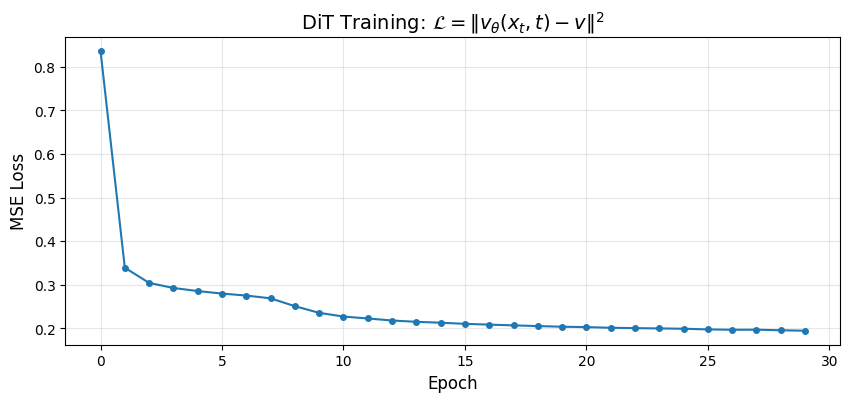

Final loss: 0.1943


In [11]:
plt.figure(figsize=(10, 4))
plt.plot(losses, marker='o', markersize=4)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('DiT Training: $\\mathcal{L} = \\|v_\\theta(x_t, t) - v\\|^2$', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")

## Step 7: Generation

Generation uses the same ODE as before:

$$\frac{dx}{dt} = v_\theta(x, t)$$

Starting from $x_1 \sim \mathcal{N}(0, I)$ at $t=1$, integrate backward to $t=0$:

$$x_{t-\Delta t} = x_t - \Delta t \cdot v_\theta(x_t, t)$$

The DiT's global attention should produce more coherent samples than the CNN's local processing.

Sampling:   0%|                                                                                     | 0/50 [00:00<?, ?it/s]

Sampling:  18%|█████████████▊                                                               | 9/50 [00:00<00:00, 87.91it/s]

Sampling:  40%|██████████████████████████████▍                                             | 20/50 [00:00<00:00, 99.77it/s]

Sampling:  64%|████████████████████████████████████████████████                           | 32/50 [00:00<00:00, 105.30it/s]

Sampling:  88%|██████████████████████████████████████████████████████████████████         | 44/50 [00:00<00:00, 109.12it/s]

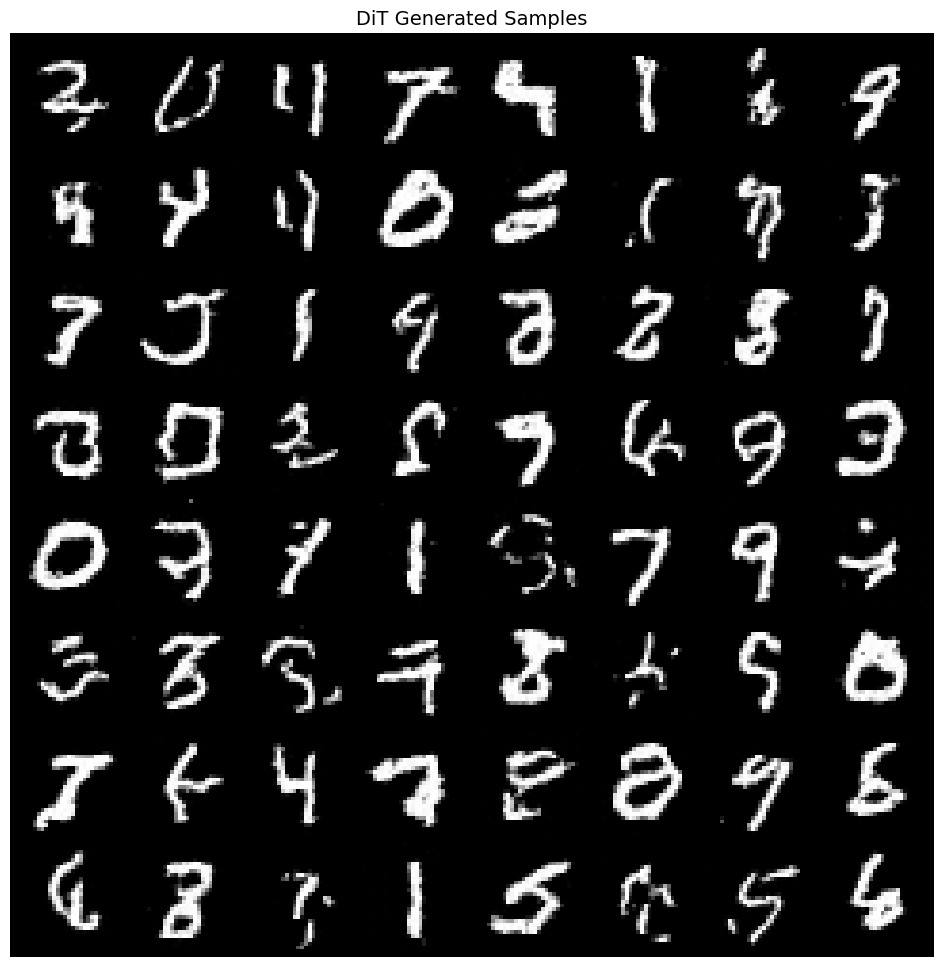

In [12]:
from from_noise_to_images.sampling import sample

def show_images(images, nrow=8, title=""):
    images = (images + 1) / 2
    images = images.clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=nrow, padding=2)
    plt.figure(figsize=(12, 12 * grid.shape[1] / grid.shape[2]))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=14)
    plt.show()

model.eval()
with torch.no_grad():
    generated, trajectory = sample(
        model=model,
        num_samples=64,
        image_shape=(1, 28, 28),
        num_steps=50,
        device=device,
        return_trajectory=True,
    )

show_images(generated, nrow=8, title="DiT Generated Samples")

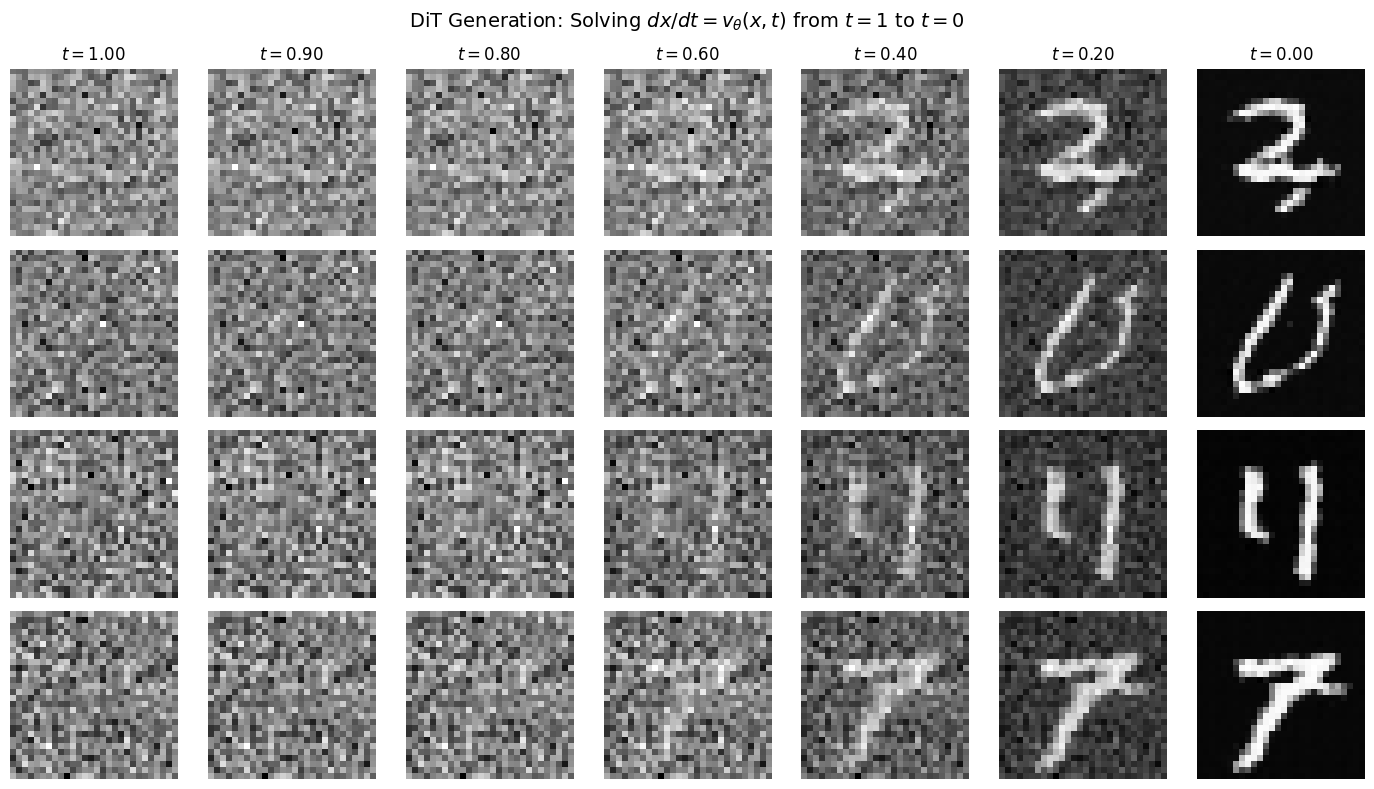

In [13]:
# Visualize generation process
num_to_show = 4
steps_to_show = [0, 5, 10, 20, 30, 40, 50]

fig, axes = plt.subplots(num_to_show, len(steps_to_show), figsize=(14, 8))

for row in range(num_to_show):
    for col, step_idx in enumerate(steps_to_show):
        img = (trajectory[step_idx][row, 0] + 1) / 2
        axes[row, col].imshow(img.cpu().numpy(), cmap='gray')
        axes[row, col].axis('off')
        if row == 0:
            t_val = 1.0 - step_idx / 50
            axes[row, col].set_title(f'$t={t_val:.2f}$')

plt.suptitle('DiT Generation: Solving $dx/dt = v_\\theta(x,t)$ from $t=1$ to $t=0$', fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: CNN vs DiT Comparison

Let's compare the two architectures side by side:

| Architecture | Parameters | Receptive Field | Conditioning |
|--------------|------------|-----------------|---------------|
| **U-Net (CNN)** | ~1.8M | Local → Global | Additive |
| **DiT** | ~12.4M | Global (layer 1) | adaLN (multiplicative) |

Loading CNN from phase1_model.pt...


Sampling:   0%|                                                                                     | 0/50 [00:00<?, ?it/s]

Sampling:  64%|████████████████████████████████████████████████                           | 32/50 [00:00<00:00, 312.20it/s]

Sampling:   0%|                                                                                     | 0/50 [00:00<?, ?it/s]

Sampling:  58%|███████████████████████████████████████████▌                               | 29/50 [00:00<00:00, 287.23it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.022983015..1.017545].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.075172484..1.043771].


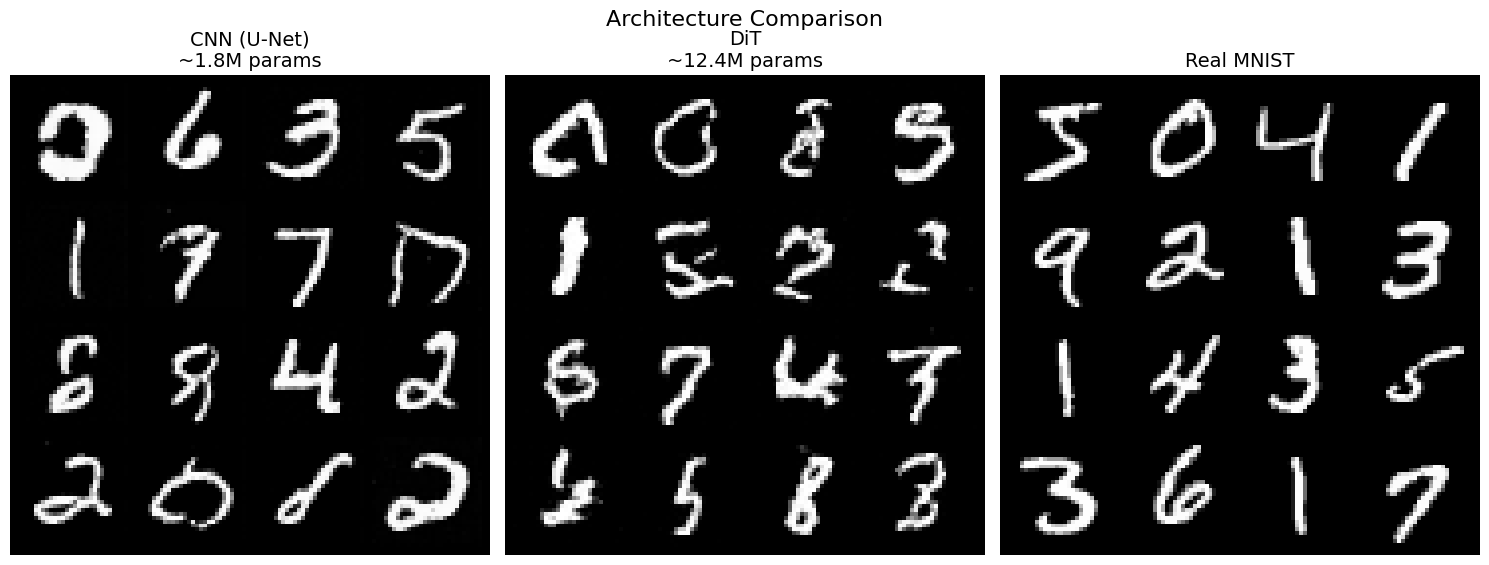

In [14]:
import os
from from_noise_to_images.models import SimpleUNet

# Load or train CNN
cnn_model = SimpleUNet(in_channels=1, model_channels=64, time_emb_dim=128).to(device)

if os.path.exists("phase1_model.pt"):
    print("Loading CNN from phase1_model.pt...")
    checkpoint = torch.load("phase1_model.pt", map_location=device)
    cnn_model.load_state_dict(checkpoint["model_state_dict"])
else:
    print("Training CNN for comparison...")
    cnn_trainer = Trainer(model=cnn_model, dataloader=train_loader, lr=1e-4, device=device)
    cnn_trainer.train(num_epochs=NUM_EPOCHS)

# Generate from both
model.eval()
cnn_model.eval()

with torch.no_grad():
    dit_samples = sample(model, 16, (1, 28, 28), 50, device)
    cnn_samples = sample(cnn_model, 16, (1, 28, 28), 50, device)

real_samples = torch.stack([train_dataset[i][0] for i in range(16)])

# Compare
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax, samples, title in [
    (axes[0], cnn_samples, 'CNN (U-Net)\n~1.8M params'),
    (axes[1], dit_samples, 'DiT\n~12.4M params'),
    (axes[2], real_samples, 'Real MNIST'),
]:
    grid = torchvision.utils.make_grid((samples + 1) / 2, nrow=4, padding=2)
    ax.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
    ax.set_title(title, fontsize=14)
    ax.axis('off')

plt.suptitle('Architecture Comparison', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
# Save model for next notebook
trainer.save_checkpoint("phase2_dit.pt")
print("Model saved to phase2_dit.pt")

Model saved to phase2_dit.pt


## Summary: What We Built

We replaced the CNN with a Diffusion Transformer that processes images through:

### The Pipeline

| Step | Operation | Result |
|------|-----------|--------|
| Patchify | $x \in \mathbb{R}^{28 \times 28}$ → patches | $z \in \mathbb{R}^{49 \times 256}$ |
| Position | Add 2D sinusoidal encoding | Spatial awareness |
| Attention | $\text{softmax}(QK^T/\sqrt{d})V$ | Global interactions |
| adaLN | $\gamma(t) \cdot \text{Norm}(x) + \beta(t)$ | Timestep conditioning |
| Unpatchify | $z \in \mathbb{R}^{49 \times 256}$ → image | $v \in \mathbb{R}^{28 \times 28}$ |

### Key Concepts

| Concept | Formula | Purpose |
|---------|---------|--------|
| **Patchify** | $z = xE + PE$ | Image to sequence |
| **Attention** | $\text{softmax}(QK^T/\sqrt{d})V$ | Global interactions |
| **adaLN** | $\gamma(t) \odot \text{Norm}(x) + \beta(t)$ | Timestep conditioning |
| **Training** | $\|v_\theta(x_t,t) - v\|^2$ | Learn velocity field |

### Why DiT Matters

- **Global from layer 1**: Every patch sees every other patch immediately
- **Scaling laws**: Predictable improvement with more compute
- **Strong conditioning**: adaLN modulates all activations per-timestep
- **Architectural simplicity**: Just stack identical blocks

## What's Next

In the next notebook, we add **class conditioning** to control generation:
- Class embeddings combined with timestep
- Classifier-Free Guidance (CFG)
- "Generate a 7" → produces a 7!